In [1]:
using DynamicalSystems
using OrdinaryDiffEq
using DifferentialEquations
using Statistics
using StaticArrays
using CairoMakie

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [3]:
tspan = (0.0, 300000.0)

a = 1.0
b = 3.0
c = 1.0
d = 5.0
xr = -1.6
r = 0.01
s = 5.0
I = 4.0
xv = 2.0

k = 0.1;

In [4]:
start_k1, end_k1, step_k1 = -0.5, 0.5, 0.01
start_k2, end_k2, step_k2 = -0.5, 0.5, 0.01

k1_array = range( start_k1, end_k1, step = step_k1 )
k2_array = range( start_k2, end_k2, step = step_k2 )

-0.5:0.01:0.5

In [5]:
spectrum_matrix = zeros( ( length(k1_array), length(k2_array), 6 ) )
EV_map = zeros( ( length(k1_array), length(k2_array) ) );

In [6]:
for (k1_index, k1) in enumerate( k1_array )

    for (k2_index, k2) in enumerate( k2_array )
        
        if k1_index == k2_index
            
            k1 = round(k1, digits = 3)
            k2 = round(k2, digits = 3)
            
            println("diagonal inheritance");  flush(stdout)
            println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
            println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
            
            if k1_index == 1
                global diagonalcondition = SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
            end
            println("initial condition:", diagonalcondition);  flush(stdout)
            
            p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
            
            println("param:", p);  flush(stdout)
            ds_HR = ContinuousDynamicalSystem(HR, diagonalcondition, p )
            
            spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                        Ttr = tspan[2] / 2, Δt = 0.1,
                                        diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
            
            spectrum_matrix[k1_index, k2_index, :] = spectrum
            
            println("spectrum:", spectrum);  flush(stdout)
            
            prob = ODEProblem(HR, diagonalcondition, tspan, p)
            sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
            
            if spectrum[1] > 0
                x_sum = sol[1,:] + sol[4,:]
                println("Length x_sum before truncate: ", length(x_sum)); flush(stdout)
                x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                println("Length x_sum after truncate: ", length(x_sum)); flush(stdout)
                
                threshold = Hs(x_sum, 6)
                println("Hs: ", threshold)
                
                counts = x_sum[x_sum.>=threshold]
                println("counts: ", length(counts))
                EV_map[k1_index, k2_index]  = length(counts)
            end
            
            diagonalcondition = sol[length(sol.u)]
            println("EV:", EV_map[k1_index, k2_index]); flush(stdout)
            println("last value: ", diagonalcondition);  flush(stdout)
            println(" _______ ");  flush(stdout)
            println(" ");  flush(stdout)
            
            global rightcondition = diagonalcondition
            global upcondition = diagonalcondition
            
            k1_index_ = k1_index + 1
            k2_index_ = k2_index + 1
            
            if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
            end
            
            for k1_ in range((k1 + step_k1), end_k1, step = step_k1 )
                
                k1_ = round(k1_, digits = 3)
                
                if k1_ > end_k1 || k2 > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance to the right");  flush(stdout)
                
                println( " index k1: ", k1_index_, "; k1: ", k1_ );  flush(stdout)
                println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
                
                println("initial condition:", rightcondition);  flush(stdout)
                
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1_, k2, k]

                println("param:", p); flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, rightcondition, p )
            
                spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                            Ttr = tspan[2] / 2, Δt = 0.1,
                                            diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
                spectrum_matrix[k1_index_, k2_index, :] = spectrum
                
                println("spectrum:", spectrum);  flush(stdout)
            
                prob = ODEProblem(HR, rightcondition, tspan, p)
                sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
                
                if spectrum[1] > 0
                    x_sum = sol[1,:] + sol[4,:]
                    println("Length x_sum before truncate: ", length(x_sum)); flush(stdout)
                    x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                    println("Length x_sum after truncate: ", length(x_sum)); flush(stdout)
                
                    threshold = Hs(x_sum, 6)
                    println("Hs: ", threshold)
                
                    counts = x_sum[x_sum.>=threshold]
                    println("counts: ", length(counts))
                    EV_map[k1_index_, k2_index]  = length(counts)
                end
            
                
                rightcondition = sol[length(sol.u)]
                
                println("EV:", EV_map[k1_index_, k2_index]); flush(stdout)
                println("last value: ",  sol[length(sol.u)]);  flush(stdout)
                
                
                k1_index_+=1
                println(">>>>>>>>>");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end
            end
            
            for k2_ in range((k2 + step_k2), end_k2, step = step_k2 )
                
                k2_ = round(k2_, digits = 3)
                
                if k1 > end_k1 || k2_ > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance upwards");  flush(stdout)
                
                println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
                println( " index k2: ", k2_index_, "; k2: ", k2_ );  flush(stdout)
                
                println("initial condition:", upcondition);  flush(stdout)
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2_, k]
                println("param:", p);  flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, upcondition, p )
            
                spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                Ttr = tspan[2] / 2, Δt = 0.1,
                                diffeq = (alg = Vern9(), abstol = 1e-14, reltol = 1e-14, maxiters = 50000000 ))
                spectrum_matrix[k1_index, k2_index_ ,:] = spectrum
                
                println("spectrum:", spectrum);  flush(stdout)
            
                prob = ODEProblem(HR, upcondition, tspan, p)
                sol = solve(prob, Vern9(), adaptive = false, dt = 0.1,  abstol = 1e-14, reltol = 1e-14, maxiters = 50000000);
                
                if spectrum[1] > 0
                   x_sum = sol[1,:] + sol[4,:]
                    println("Length x_sum before truncate: ", length(x_sum)); flush(stdout)
                    x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                    println("Length x_sum after truncate: ", length(x_sum)); flush(stdout)
                
                    threshold = Hs(x_sum, 6)
                    println("Hs: ", threshold)
                
                    counts = x_sum[x_sum.>=threshold]
                    println("counts: ", length(counts))
                    EV_map[k1_index, k2_index_]  = length(counts)
                end
            
                upcondition = sol[length(sol.u)]
                
                println("lyap:", spectrum);  flush(stdout)
                println("EV:", EV_map[k1_index, k2_index_]); flush(stdout)
                println("last value: ", sol[length(sol.u)]);  flush(stdout)
                
                
                k2_index_+=1
                println("^^^^^^^^^^");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end

            end
        end
    end
    println("-------------");  flush(stdout)
    println(" ");  flush(stdout)
end

diagonal inheritance
 index k1: 1; k1: -0.5
 index k2: 1; k2: -0.5
initial condition:[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.5, 0.1]
spectrum:[0.0057908829664447435, 3.2422862370830726e-5, -0.0042267364940850455, -0.04544836939656695, -5.189963749523846, -14.252476813073905]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.439328667142248
counts: 0
EV:0.0
last value: [-1.0751726724627653, -3.4522767992387258, 4.12556274266292, 1.7748144914347912, -2.9533520083933786, 3.232703006445888]
 _______ 
 
Inheritance to the right
 index k1: 2; k1: -0.49
 index k2: 1; k2: -0.5
initial condition:[-1.0751726724627653, -3.4522767992387258, 4.12556274266292, 1.7748144914347912, -2.9533520083933786, 3.232703006445888]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.5, 0.1]
spectrum:[0.005813871939418915, -5.062497740242634e-6, -0.0047297823457948494, -0.04447334234510789, -5.212534228051969, -14.2

 index k1: 13; k1: -0.38
 index k2: 1; k2: -0.5
initial condition:[-1.1775959503677562, -5.759392934261535, 4.080262970263597, -0.6628735954474707, -2.0376991355601453, 3.3765228780974406]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.5, 0.1]
spectrum:[-3.0683291154318914e-5, -0.00030928367505666995, -0.005445124422017083, -0.046512078362378854, -5.361381199103647, -13.969297660429941]
EV:0.0
last value: [-0.8445346029695707, -2.542490052960033, 4.195523376157765, -0.8817865368024546, -3.792973167931103, 3.1122760256388613]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 1; k2: -0.5
initial condition:[-0.8445346029695707, -2.542490052960033, 4.195523376157765, -0.8817865368024546, -3.792973167931103, 3.1122760256388613]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.5, 0.1]
spectrum:[2.6121874939432502e-5, -0.00043456480370399937, -0.00591320315438108, -0.04462986238579868, -5.34910674649728, -13.96413149931464]
Length x_sum b

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.5, 0.1]
spectrum:[1.0303430067638333e-5, -0.00427299785870451, -0.033813250535610295, -0.03381339758382585, -5.2363137958581785, -13.75831242983802]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1478061146990397
counts: 0
EV:0.0
last value: [-0.8341462928286926, -2.526920940596362, 4.060685964345814, -1.564162104974518, -11.732227063154216, 3.4706862060402677]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 1; k2: -0.5
initial condition:[-0.8341462928286926, -2.526920940596362, 4.060685964345814, -1.564162104974518, -11.732227063154216, 3.4706862060402677]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.5, 0.1]
spectrum:[1.0535219269408406e-5, -0.0049042957387273696, -0.021308691241893878, -0.02728705823218294, -5.243223246555939, -13.740204416962962]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.173234688947143
c

Hs: 2.306325973792199
counts: 18
EV:18.0
last value: [-0.9550668025966742, -3.2961592039607304, 4.092160700918123, 0.4949608626802597, 0.3608150141812137, 3.4942329919807538]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 1; k2: -0.5
initial condition:[-0.9550668025966742, -3.2961592039607304, 4.092160700918123, 0.4949608626802597, 0.3608150141812137, 3.4942329919807538]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.5, 0.1]
spectrum:[0.011435783376295678, -8.060875821923411e-7, -0.0035690369109931453, -0.025300085064807187, -5.625523651747962, -12.727607776686495]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.241072154617184
counts: 14
EV:14.0
last value: [-1.0884569871913257, -4.614882839295426, 4.280605542856253, -0.8400142498370287, -3.291419653054376, 3.29228519584815]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 1; k2: -0.5
initial condition:[-1.0884569871913257, -4.614882839

initial condition:[-0.7861011042806542, -2.159863939152244, 4.11157844248728, -1.360309245962628, -8.735475190156759, 3.346173199864888]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.5, 0.1]
spectrum:[0.01099695437751839, 8.785948453518066e-5, -0.00046232908323571664, -0.015830485501007147, -5.71662032443628, -12.2461830873335]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4387458774062365
counts: 159
EV:159.0
last value: [-1.0979611835642071, -5.2529127302264085, 3.694013555283886, -0.8039210135463033, -2.152253303611883, 4.287157519223825]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 1; k2: -0.5
initial condition:[-1.0979611835642071, -5.2529127302264085, 3.694013555283886, -0.8039210135463033, -2.152253303611883, 4.287157519223825]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.5, 0.1]
spectrum:[0.015967145637029223, 0.0030409278982339565, 9.525159660517207e-5, -0.009546277604581646, -5.936

 index k2: 1; k2: -0.5
initial condition:[-1.2835017648609346, -7.010441912158129, 4.087603822926334, -1.0265768324539764, -4.658875705747793, 3.5175384033301382]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.5, 0.1]
spectrum:[0.02170208915654426, 0.0037366692707676624, 0.00012565185990279798, -0.008324704656460038, -6.087835931024791, -11.893238073243975]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.870481879080091
counts: 91
EV:91.0
last value: [-1.3790867903566906, -8.737380137578475, 3.706819505978843, -0.457054058311984, -0.5617051825363216, 3.9386777051351545]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 1; k2: -0.5
initial condition:[-1.3790867903566906, -8.737380137578475, 3.706819505978843, -0.457054058311984, -0.5617051825363216, 3.9386777051351545]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.5, 0.1]
spectrum:[0.02176221379522897, 0.0018935436625161497, -3.740068293801617e-5, -0

 index k1: 75; k1: 0.24
 index k2: 1; k2: -0.5
initial condition:[-0.8738186309855677, -2.955949360259824, 4.046527832119336, -0.6745713983658155, -1.367822943573042, 4.252053331458468]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.5, 0.1]
spectrum:[0.02570100401045431, 0.004251916222117683, 0.0002447146260002591, -0.010522288971313758, -5.99119405169657, -11.984919578935392]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0896107280887475
counts: 70
EV:70.0
last value: [-0.26389062353802456, 0.256744407267344, 4.259449126519415, -0.9725290151656042, -3.218360209269918, 4.0310948117762395]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 1; k2: -0.5
initial condition:[-0.26389062353802456, 0.256744407267344, 4.259449126519415, -0.9725290151656042, -3.218360209269918, 4.0310948117762395]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.5, 0.1]
spectrum:[6.267383037067003e-5, -0.0021161354734032405, -0

 index k1: 87; k1: 0.36
 index k2: 1; k2: -0.5
initial condition:[-0.8493705783216443, -2.7252278935028267, 4.065356000994398, -1.0449694985268625, -4.666600030370128, 3.7423453076737694]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.5, 0.1]
spectrum:[0.02805305279347679, 0.003685616386502788, 1.6650944135616396e-5, -0.011097536846352448, -6.0086080366963035, -12.106139647915052]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3849519624163587
counts: 3
EV:3.0
last value: [-0.9244559098290693, -2.70439965745993, 4.708980699410914, -1.0023529258782524, -4.791738586357661, 3.1532776801450546]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 1; k2: -0.5
initial condition:[-0.9244559098290693, -2.70439965745993, 4.708980699410914, -1.0023529258782524, -4.791738586357661, 3.1532776801450546]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.5, 0.1]
spectrum:[0.030441524324370285, 0.0027709987207484377, -1.

  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 1; k2: -0.5
initial condition:[-1.198788873203518, -5.577490617838949, 4.533419453248059, -0.9436834137065923, -4.046521866117655, 3.3713332672959817]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.5, 0.1]
spectrum:[0.036991563486041684, 0.0030704510075943497, 9.527893448029308e-5, -0.014185847796279424, -6.085626509214108, -12.033089492673566]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7728318387329605
counts: 0
EV:0.0
last value: [-0.561603758730442, -0.45553374297391513, 4.615120439132198, -1.3612700169621714, -8.446547358914515, 3.627894020473307]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 1; k2: -0.5
initial condition:[-0.561603758730442, -0.45553374297391513, 4.615120439132198, -1.3612700169621714, -8.446547358914515, 3.627894020473307]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.5, 0.1]
spectrum:[0.03611992292456037,

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2511458409627068
counts: 0
lyap:[0.0020091542495124844, 7.793885135805957e-5, -0.0034153281127440255, -0.05066661541843343, -5.325097937099111, -13.976658731647085]
EV:0.0
last value: [-1.7608620289432826, -13.160512622124866, 4.040834462543795, 0.592396708491399, -4.533082628020154, 3.9625054322312003]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 10; k2: -0.41
initial condition:[-1.7608620289432826, -13.160512622124866, 4.040834462543795, 0.592396708491399, -4.533082628020154, 3.9625054322312003]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.41, 0.1]
spectrum:[-7.907161633184614e-5, -0.0006464743172136732, -0.002591509731985306, -0.05067098406944662, -5.315749311118549, -13.999820706392786]
lyap:[-7.907161633184614e-5, -0.0006464743172136732, -0.002591509731985306, -0.05067098406944662, -5.315749311118549, -13.999820706392786]
EV:0.0
last value: [-0.739867533328594, 

spectrum:[2.7368882337116157e-5, -0.002062721158302554, -0.01003396335229947, -0.034552277789814685, -5.309092733472601, -13.883151480334202]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.135944156671148
counts: 0
lyap:[2.7368882337116157e-5, -0.002062721158302554, -0.01003396335229947, -0.034552277789814685, -5.309092733472601, -13.883151480334202]
EV:0.0
last value: [-0.6770058056143728, -1.6648953250208147, 3.882715433722197, -1.417711710147573, -9.375991257072158, 3.538803349124077]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 21; k2: -0.3
initial condition:[-0.6770058056143728, -1.6648953250208147, 3.882715433722197, -1.417711710147573, -9.375991257072158, 3.538803349124077]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.3, 0.1]
spectrum:[-6.756253602487821e-5, -0.0023665996760545527, -0.011553758441628034, -0.03279787896548485, -5.30188407759677, -13.86335956944188]
lyap:[-6.756253602487821e-5, -0.0023665996

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.2, 0.1]
spectrum:[0.011148748758260883, -2.4756087552196665e-5, -0.009577468256399553, -0.03631595300915333, -5.37384444015715, -13.308308431911554]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5655207226226455
counts: 225
lyap:[0.011148748758260883, -2.4756087552196665e-5, -0.009577468256399553, -0.03631595300915333, -5.37384444015715, -13.308308431911554]
EV:225.0
last value: [-0.4584043658921959, -4.708446893045614, 3.439783925871116, -0.9984462160929687, -3.4352864860206815, 4.336635823100635]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 32; k2: -0.19
initial condition:[-0.4584043658921959, -4.708446893045614, 3.439783925871116, -0.9984462160929687, -3.4352864860206815, 4.336635823100635]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.19, 0.1]
spectrum:[0.0008848912719328611, 5.818723654841175e-5, -0.016934098418301867, -0.02866888115495816, -5.29

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.1, 0.1]
spectrum:[0.010635010621508938, 5.356239130972557e-6, -0.0042975856184169665, -0.021214054478427675, -5.621665567771139, -12.680743116567882]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.253502099262274
counts: 42
lyap:[0.010635010621508938, 5.356239130972557e-6, -0.0042975856184169665, -0.021214054478427675, -5.621665567771139, -12.680743116567882]
EV:42.0
last value: [-1.459163998685346, -10.222580408311064, 3.2916533127553236, -0.7714310449227977, -1.8787286584164793, 4.3108299290108825]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 42; k2: -0.09
initial condition:[-1.459163998685346, -10.222580408311064, 3.2916533127553236, -0.7714310449227977, -1.8787286584164793, 4.3108299290108825]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.09, 0.1]
spectrum:[0.010450639362900483, 3.0955587092341347e-5, -0.0022539536486564983, -0.018752398685546824, 

EV:151.0
last value: [-1.408432351715212, -8.932002989035965, 3.862999448721072, -0.8258062133515365, -2.419286701521158, 4.129822048793741]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 52; k2: 0.01
initial condition:[-1.408432351715212, -8.932002989035965, 3.862999448721072, -0.8258062133515365, -2.419286701521158, 4.129822048793741]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.01, 0.1]
spectrum:[0.015168127064484336, 0.001984460835533205, 0.0001250903535485239, -0.010824558093529857, -5.917084427912212, -12.00779751004997]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5346120269370283
counts: 136
lyap:[0.015168127064484336, 0.001984460835533205, 0.0001250903535485239, -0.010824558093529857, -5.917084427912212, -12.00779751004997]
EV:136.0
last value: [-1.090331013904658, -4.725569592172057, 4.141815612745087, -1.2406542552989257, -6.811806951584502, 3.7197437424830366]
^^^^^^^^^^
  Inheritance upwards
 index k1

^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 62; k2: 0.11
initial condition:[-1.5114584750038491, -9.481966456581254, 3.380998842757743, 1.1005001220407693, -0.6007751027674304, 4.119484830941455]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.11, 0.1]
spectrum:[0.01936114848476554, 0.0038224611684221964, 4.416344090337189e-5, -0.008831698931387761, -6.065334180463381, -11.893391175685938]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8558367677512497
counts: 75
lyap:[0.01936114848476554, 0.0038224611684221964, 4.416344090337189e-5, -0.008831698931387761, -6.065334180463381, -11.893391175685938]
EV:75.0
last value: [-1.0685419037642225, -5.047717745116471, 3.5846012422928326, -0.7575680749064402, -2.1780132813401933, 3.9005728803880246]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 63; k2: 0.12
initial condition:[-1.0685419037642225, -5.047717745116471, 3.5846012422928326, -0.7575680749064402, 

 index k1: 1; k1: -0.5
 index k2: 72; k2: 0.21
initial condition:[-1.253339910042426, -7.05487866917841, 3.6247916482203766, -0.5975370320064562, -0.647864652319633, 4.599751897652483]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.21, 0.1]
spectrum:[0.02471655798877108, 0.0015258344223901955, 0.0001060643610831338, -0.012374609377516494, -5.964950969261262, -12.044018390562327]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.983678277036719
counts: 69
lyap:[0.02471655798877108, 0.0015258344223901955, 0.0001060643610831338, -0.012374609377516494, -5.964950969261262, -12.044018390562327]
EV:69.0
last value: [-0.8974301535726599, -3.328598536954674, 3.735013308706638, -0.5398365091408037, -0.6287295877332904, 4.33163726344401]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 73; k2: 0.22
initial condition:[-0.8974301535726599, -3.328598536954674, 3.735013308706638, -0.5398365091408037, -0.6287295877332904, 4.33163726344401

initial condition:[-0.4965004287970432, -0.6808707347355821, 3.995488568564031, -1.311963998387679, -7.59307107294406, 3.9819198864035443]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.31, 0.1]
spectrum:[0.026759501803558045, 0.003932951809845209, 0.000126534489714651, -0.010845086019873636, -6.031294663583391, -12.007411207540743]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.255799388545549
counts: 9
lyap:[0.026759501803558045, 0.003932951809845209, 0.000126534489714651, -0.010845086019873636, -6.031294663583391, -12.007411207540743]
EV:9.0
last value: [-0.668025043990395, -1.7080897779834419, 3.80022757459431, -1.1312838587189196, -5.532289148513046, 3.8007040554099607]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 83; k2: 0.32
initial condition:[-0.668025043990395, -1.7080897779834419, 3.80022757459431, -1.1312838587189196, -5.532289148513046, 3.8007040554099607]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.41, 0.1]
spectrum:[0.035187610565376976, 0.003543303800013412, -1.6001834510771963e-5, -0.013557899341779884, -5.99926501482787, -12.105501007718505]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5657974615756345
counts: 0
lyap:[0.035187610565376976, 0.003543303800013412, -1.6001834510771963e-5, -0.013557899341779884, -5.99926501482787, -12.105501007718505]
EV:0.0
last value: [-1.2079448742311405, -6.462538149850741, 3.6968782363629655, -0.7447637818186644, -1.890535047099278, 4.122080168416801]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 93; k2: 0.42
initial condition:[-1.2079448742311405, -6.462538149850741, 3.6968782363629655, -0.7447637818186644, -1.890535047099278, 4.122080168416801]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, 0.42, 0.1]
spectrum:[0.03222875103420259, 0.0043836678644007965, -1.478127817145401e-5, -0.013665629261996697, -6.00460336

spectrum:[0.005316168342392332, 3.848969062721818e-5, -0.0029558565812502395, -0.04620044292810145, -5.264074209758595, -14.096947665188228]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3662433301404375
counts: 0
EV:0.0
last value: [1.3885158853068926, -1.7106242259570712, 4.001946815627024, -1.5986592869540206, -11.003589008765584, 3.3217800036182616]
 _______ 
 
Inheritance to the right
 index k1: 3; k1: -0.48
 index k2: 2; k2: -0.49
initial condition:[1.3885158853068926, -1.7106242259570712, 4.001946815627024, -1.5986592869540206, -11.003589008765584, 3.3217800036182616]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.49, 0.1]
spectrum:[-1.2084813641190296e-5, -0.003890328104297916, -0.00718270783581913, -0.030860910858768836, -5.165432004004736, -14.248123422178928]
EV:0.0
last value: [-1.2491855119742683, -6.417721838989235, 4.16867147826461, -0.8049594968700498, -4.385751422572103, 3.3072701173593493]
>>>>>>>>>
  Inheritance to 

>>>>>>>>>
  Inheritance to the right
 index k1: 16; k1: -0.35
 index k2: 2; k2: -0.49
initial condition:[-0.913194688151758, -2.8004807013889508, 4.196132851180991, -0.26926214153695865, -0.5810887974348203, 3.167915652349536]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.49, 0.1]
spectrum:[4.014956359966071e-5, -0.0014918805705016736, -0.0069675408809416195, -0.043264589865507165, -5.319632545572723, -13.946705860837588]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.144295743667895
counts: 0
EV:0.0
last value: [-0.8125884970778786, -2.2351811729841033, 4.242963207547901, -1.2888589215534847, -7.957379754676751, 3.157158056432388]
>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 2; k2: -0.49
initial condition:[-0.8125884970778786, -2.2351811729841033, 4.242963207547901, -1.2888589215534847, -7.957379754676751, 3.157158056432388]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.49, 0.1]
spectrum:

initial condition:[-0.3451494535735235, -0.05592259641732155, 4.1356224353251845, -0.9259867605630847, -3.8057424049853776, 3.1963375282065627]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.49, 0.1]
spectrum:[-6.580176403274236e-5, -0.008695529820311527, -0.015793706822900624, -0.025632290818075283, -5.205004760916343, -13.728034171936724]
EV:0.0
last value: [-1.4285970823957863, -9.431229687851795, 3.654146433429553, -0.7118875300815014, -1.8037837660506488, 3.9619808683536384]
>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 2; k2: -0.49
initial condition:[-1.4285970823957863, -9.431229687851795, 3.654146433429553, -0.7118875300815014, -1.8037837660506488, 3.9619808683536384]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.49, 0.1]
spectrum:[8.256001742887749e-6, -0.011541412393197632, -0.011470455225492586, -0.02875355202900472, -5.179792517869659, -13.743699216384455]
Length x_sum before truncate: 3000001
Length x_sum after 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.49, 0.1]
spectrum:[0.010685894154926025, 1.8943824542636447e-5, -0.005073869172745698, -0.023653439305956515, -5.607288288500433, -12.704356707314785]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2513096974251114
counts: 32
EV:32.0
last value: [-1.0390475881815846, -4.187893294947357, 4.187219718855843, -1.0939875105911112, -5.5449319459038335, 3.3051040594946963]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 2; k2: -0.49
initial condition:[-1.0390475881815846, -4.187893294947357, 4.187219718855843, -1.0939875105911112, -5.5449319459038335, 3.3051040594946963]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.49, 0.1]
spectrum:[0.009951728541667058, 1.0721367162120102e-5, -0.003664458299879965, -0.02057423724702457, -5.634400885751576, -12.617906933837732]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.264147904658

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.578370619736834
counts: 155
EV:155.0
last value: [-0.7539245439925638, -1.7099179062212204, 4.42766598975054, -0.907909144028682, -3.759434199521736, 3.3905496812071676]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 2; k2: -0.49
initial condition:[-0.7539245439925638, -1.7099179062212204, 4.42766598975054, -0.907909144028682, -3.759434199521736, 3.3905496812071676]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.49, 0.1]
spectrum:[0.017339462399763576, 0.0041714087834061695, -1.0063296472201871e-6, -0.007861249779353404, -6.021656229250938, -11.885939043603532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.594505025923708
counts: 124
EV:124.0
last value: [-0.9345135786677778, -3.2284567085002864, 4.183074755458632, -1.3340752368113609, -8.0013216124868, 3.741285010304155]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.937031344071632
counts: 41
EV:41.0
last value: [-1.5739526489566544, -11.569225254036274, 3.8959824666487104, -0.4848156934168261, -1.1489722701509824, 3.336471059799663]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 2; k2: -0.49
initial condition:[-1.5739526489566544, -11.569225254036274, 3.8959824666487104, -0.4848156934168261, -1.1489722701509824, 3.336471059799663]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.49, 0.1]
spectrum:[0.021639077399645015, 0.004167869381572786, 0.00010649116034789766, -0.010288939548251044, -5.9748232763579745, -11.966047341246282]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.93986798714747
counts: 79
EV:79.0
last value: [-0.7230368645981675, -2.3933722701053504, 3.3732997403466896, -1.2982256593227202, -7.750870919301702, 3.510535690217493]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.034417707444801
counts: 4
EV:4.0
last value: [-1.3700729712730686, -8.957534247021007, 4.221931075447216, 0.23892847739981163, 0.42340547396578476, 3.521364502177045]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 2; k2: -0.49
initial condition:[-1.3700729712730686, -8.957534247021007, 4.221931075447216, 0.23892847739981163, 0.42340547396578476, 3.521364502177045]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.49, 0.1]
spectrum:[0.027581474454951994, 0.002721795196737347, -5.1867933790090374e-5, -0.009685168913560143, -6.024597347802394, -11.971292243802353]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.178536743543668
counts: 35
EV:35.0
last value: [0.03261750763466833, 0.9548438650630495, 4.913249003464136, -1.0075062908718897, -2.424986467951783, 4.541514481474892]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 in

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.466019856721349
counts: 0
EV:0.0
last value: [0.9878953056913901, -0.25875984441727606, 4.125549689300959, -1.2538176322165224, -5.328076973832225, 4.1071055647412384]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 2; k2: -0.49
initial condition:[0.9878953056913901, -0.25875984441727606, 4.125549689300959, -1.2538176322165224, -5.328076973832225, 4.1071055647412384]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.49, 0.1]
spectrum:[0.0330464400927344, 0.0040074859719419565, 0.000100284991804106, -0.011695072207892723, -6.098016898118694, -11.987665880045459]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.481594461546223
counts: 0
EV:0.0
last value: [-0.4333201836967315, -0.5115039748079528, 3.926079268548291, -1.0155110353288301, -4.106570050683105, 3.9142191494598704]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.848314915760293
counts: 0
EV:0.0
last value: [-1.1189573555432029, -4.756486252470264, 4.439768894769057, -1.1902195346668873, -5.886217234216609, 4.072460588634695]
>>>>>>>>>
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 3; k2: -0.48
initial condition:[1.3885158853068926, -1.7106242259570712, 4.001946815627024, -1.5986592869540206, -11.003589008765584, 3.3217800036182616]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.48, 0.1]
spectrum:[6.114171812024478e-5, -0.003864408868665724, -0.007220812797372479, -0.030847658260800635, -5.165047005602545, -14.249986387607484]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3552782678803204
counts: 0
lyap:[6.114171812024478e-5, -0.003864408868665724, -0.007220812797372479, -0.030847658260800635, -5.165047005602545, -14.249986387607484]
EV:0.0
last value: [0.19840988714073626, 0.16378818780217133, 3.1557766

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.38, 0.1]
spectrum:[2.5699838018161523e-5, -0.001017063484726569, -0.005516147566360721, -0.04873509063291695, -5.333091669138695, -13.985599260999381]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.155201452483716
counts: 0
lyap:[2.5699838018161523e-5, -0.001017063484726569, -0.005516147566360721, -0.04873509063291695, -5.333091669138695, -13.985599260999381]
EV:0.0
last value: [-1.3965963666506942, -9.383721729963023, 3.1990505769327977, -0.8050228754690428, -2.189890351283617, 4.223155557409349]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 14; k2: -0.37
initial condition:[-1.3965963666506942, -9.383721729963023, 3.1990505769327977, -0.8050228754690428, -2.189890351283617, 4.223155557409349]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.37, 0.1]
spectrum:[-2.8268012129886818e-5, -0.0010858475470532582, -0.006034925193113212, -0.046793513204579154, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 24; k2: -0.27
initial condition:[-0.3286009404761854, -0.12142054496879442, 3.9438009271507197, -1.3601962678654302, -8.400078333283181, 3.485966496874524]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.27, 0.1]
spectrum:[4.067548062396974e-5, -0.003922528576191297, -0.020589802096473528, -0.03503630039602312, -5.260340455359891, -13.799220810505263]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1301728707619674
counts: 0
lyap:[4.067548062396974e-5, -0.003922528576191297, -0.020589802096473528, -0.03503630039602312, -5.260340455359891, -13.799220810505263]
EV:0.0
last value: [1.4151439262095635, -3.507925974946365, 4.113507988468694, -1.4321433700010056, -9.039692398634667, 3.4238246497935836]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 25; k2: -0.26
initial condition:[1.4151439262095635, -3.507925974946365, 4.113507988468694, -1.43214337000100

spectrum:[0.014849423356074748, -6.521109040782246e-5, -0.0062387009724624255, -0.028681523167243077, -5.600405518499063, -12.831220342980352]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4697239581866546
counts: 35
lyap:[0.014849423356074748, -6.521109040782246e-5, -0.0062387009724624255, -0.028681523167243077, -5.600405518499063, -12.831220342980352]
EV:35.0
last value: [-0.5079687577660039, -1.0226672713659049, 3.6640027787740697, -1.0500025567726639, -4.457468537713945, 4.0327616689129755]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 35; k2: -0.16
initial condition:[-0.5079687577660039, -1.0226672713659049, 3.6640027787740697, -1.0500025567726639, -4.457468537713945, 4.0327616689129755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.16, 0.1]
spectrum:[0.016027019118275015, -7.969821042105792e-5, -0.0036234462840403475, -0.025342714478918983, -5.695971262475833, -12.664373095409141]
Length x_sum before trunc

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.07, 0.1]
spectrum:[0.005641628014115643, 6.352000434379388e-5, -0.005944089913262976, -0.02115910337697316, -5.50728475594796, -12.773340613958007]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.259744397773854
counts: 34
lyap:[0.005641628014115643, 6.352000434379388e-5, -0.005944089913262976, -0.02115910337697316, -5.50728475594796, -12.773340613958007]
EV:34.0
last value: [-1.533552357534313, -9.358547353501228, 3.9179623452161123, 0.88968494206115, -4.7600953437787465, 3.9809152107193504]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 45; k2: -0.06
initial condition:[-1.533552357534313, -9.358547353501228, 3.9179623452161123, 0.88968494206115, -4.7600953437787465, 3.9809152107193504]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.06, 0.1]
spectrum:[5.753662441139997e-6, -0.004185942694877143, -0.004203866163604577, -0.015343977791762225, -5.36918686

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.610735814865273
counts: 105
lyap:[0.017271957101586084, 0.0039941191623594895, -4.481821930585815e-5, -0.008818187228218909, -5.971012995769623, -11.943409492127657]
EV:105.0
last value: [0.8253904144530962, 0.12080321955048028, 4.136776564923771, -1.2191652300728, -6.72451938572429, 3.812666006163885]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 55; k2: 0.04
initial condition:[0.8253904144530962, 0.12080321955048028, 4.136776564923771, -1.2191652300728, -6.72451938572429, 3.812666006163885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.04, 0.1]
spectrum:[0.01893036806109432, 0.004855125511706863, 3.0499907511399742e-5, -0.007160333038789875, -6.09997064288462, -11.792679995629753]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.657198777476759
counts: 94
lyap:[0.01893036806109432, 0.004855125511706863, 3.0499907511399742e-5, -0.00716

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9225138616957835
counts: 56
lyap:[0.022183197246738635, 0.0036670274048722176, 0.00012672819339045778, -0.009104723184660502, -6.041586289809528, -11.951914113752673]
EV:56.0
last value: [-0.10425986261129148, 0.2742783668858678, 3.840837397008192, -0.7581478463044414, -2.5916476719652692, 3.783242795421256]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 65; k2: 0.14
initial condition:[-0.10425986261129148, 0.2742783668858678, 3.840837397008192, -0.7581478463044414, -2.5916476719652692, 3.783242795421256]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.14, 0.1]
spectrum:[0.022349671383075816, 0.004060299726612096, -5.397676926458677e-5, -0.009909195817261553, -6.03632059017864, -11.917351272778925]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.905209544511102
counts: 95
lyap:[0.022349671383075816, 0.004060299726612096, -5.39767692645867

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0739596392238493
counts: 77
lyap:[0.026491864274855458, 0.0023258996120767185, 5.424574819651957e-5, -0.012530937071679677, -5.9373881809884, -12.01668756664646]
EV:77.0
last value: [-0.7904453054444271, -2.115047620067386, 4.159191573844634, -0.4595545714840451, -0.740439870364046, 3.791440553104551]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 75; k2: 0.24
initial condition:[-0.7904453054444271, -2.115047620067386, 4.159191573844634, -0.4595545714840451, -0.740439870364046, 3.791440553104551]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.24, 0.1]
spectrum:[0.02620050248894507, 0.0028849752856611364, 0.00035912621936788776, -0.0127238399841718, -5.975656699835278, -11.979552727589082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0660612863858914
counts: 70
lyap:[0.02620050248894507, 0.0028849752856611364, 0.00035912621936788776, -

EV:19.0
last value: [-0.2536845866899414, 0.04795278614916719, 3.9177722682580787, -1.1639507539604521, -6.0355245974895615, 4.1336793400183875]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 85; k2: 0.34
initial condition:[-0.2536845866899414, 0.04795278614916719, 3.9177722682580787, -1.1639507539604521, -6.0355245974895615, 4.1336793400183875]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.34, 0.1]
spectrum:[0.02907013397973662, 0.003630168486078201, 5.853581119532033e-5, -0.010722080720207507, -6.070157581059106, -11.945303814209403]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.316176811493677
counts: 2
lyap:[0.02907013397973662, 0.003630168486078201, 5.853581119532033e-5, -0.010722080720207507, -6.070157581059106, -11.945303814209403]
EV:2.0
last value: [-1.298593725575493, -7.478337248671351, 3.80612809768311, -0.8500301484990089, -2.721950434052158, 4.0002009393294635]
^^^^^^^^^^
  Inheritance upwards
 index

^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 95; k2: 0.44
initial condition:[-0.30896442481018643, -0.315480200285208, 3.6178408099000685, -1.3238756800859592, -8.160900618489258, 3.9382453932605133]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, 0.44, 0.1]
spectrum:[0.035361024532357364, 0.002864221982297062, -8.019496702969288e-6, -0.014046417828439262, -6.101037661324445, -11.989974136412892]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.717461965598244
counts: 0
lyap:[0.035361024532357364, 0.002864221982297062, -8.019496702969288e-6, -0.014046417828439262, -6.101037661324445, -11.989974136412892]
EV:0.0
last value: [-0.22970401662634363, -0.022307867643528677, 3.737736505911176, -1.2145164127871444, -7.11968530966356, 3.8302881848327823]
^^^^^^^^^^
  Inheritance upwards
 index k1: 2; k1: -0.49
 index k2: 96; k2: 0.45
initial condition:[-0.22970401662634363, -0.022307867643528677, 3.737736505911176, -1.214516412

>>>>>>>>>
  Inheritance to the right
 index k1: 7; k1: -0.44
 index k2: 3; k2: -0.48
initial condition:[-1.3890552706096924, -7.244791542046646, 4.000938795907544, 0.7269858849329843, 0.1904882145049962, 3.4933964152982533]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.48, 0.1]
spectrum:[6.2503669743355955e-6, -0.000837005643393947, -0.0028790028845442172, -0.07149831366273851, -5.331087459270384, -14.041229394512445]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.175007735002235
counts: 0
EV:0.0
last value: [-0.4211980874578396, -1.073784392705018, 3.189229888131516, -0.7231155273814817, -1.6756021468272908, 4.140041392596527]
>>>>>>>>>
  Inheritance to the right
 index k1: 8; k1: -0.43
 index k2: 3; k2: -0.48
initial condition:[-0.4211980874578396, -1.073784392705018, 3.189229888131516, -0.7231155273814817, -1.6756021468272908, 4.140041392596527]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.48, 0.1]
spectrum:[-6.5

>>>>>>>>>
  Inheritance to the right
 index k1: 20; k1: -0.31
 index k2: 3; k2: -0.48
initial condition:[1.6341358942735966, -2.1941964752200636, 3.3939604726594674, -1.0650624165716056, -3.396521872245898, 4.1274755265379]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.48, 0.1]
spectrum:[-7.143350693579175e-6, -0.0031816559097004988, -0.010128303380269417, -0.04130393840827584, -5.287622398265296, -13.878657756459754]
EV:0.0
last value: [-0.604897752484758, -1.1607213299164798, 4.024325801698795, -1.3065874489480633, -8.007481925106992, 3.3344213870217403]
>>>>>>>>>
  Inheritance to the right
 index k1: 21; k1: -0.3
 index k2: 3; k2: -0.48
initial condition:[-0.604897752484758, -1.1607213299164798, 4.024325801698795, -1.3065874489480633, -8.007481925106992, 3.3344213870217403]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.48, 0.1]
spectrum:[-7.817481288686007e-6, -0.003434593643144616, -0.011457421753887677, -0.040785801029436006, -5.28019798044811, -

>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 3; k2: -0.48
initial condition:[-0.5946840417608663, -1.0607559188964746, 4.136928371977888, -0.6866154724509549, -2.3512743676695966, 3.194709480258031]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.48, 0.1]
spectrum:[0.012021864614209466, 3.1990149519602943e-6, -0.008288770916771005, -0.03260204114202014, -5.508848890046594, -13.011603682829202]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.511065372008353
counts: 82
EV:82.0
last value: [-0.9992990295639408, -3.7171841854018473, 4.280060789524397, -0.39393576313495543, -0.9244920828769914, 3.2305068564715826]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 3; k2: -0.48
initial condition:[-0.9992990295639408, -3.7171841854018473, 4.280060789524397, -0.39393576313495543, -0.9244920828769914, 3.2305068564715826]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.48, 0.1]
spec

  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 3; k2: -0.48
initial condition:[-0.3453244799993068, -0.19453726286505246, 3.924331701587594, -1.2700247642020854, -6.694330505507845, 3.9156258527015777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.48, 0.1]
spectrum:[-8.086322023022036e-6, -0.0049434661719369435, -0.004932979984441349, -0.014626431269825265, -5.364651174838104, -12.940238205034841]
EV:0.0
last value: [-0.6960104787271176, -1.6346201283893007, 4.040653056195366, -1.494313925926874, -10.504985925483254, 3.5680978591997294]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 3; k2: -0.48
initial condition:[-0.6960104787271176, -1.6346201283893007, 4.040653056195366, -1.494313925926874, -10.504985925483254, 3.5680978591997294]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.48, 0.1]
spectrum:[-4.63451701632828e-6, -0.006473745240429244, -0.006447307215568708, -0.008853432534387059, -5.37092827995361, -12

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.48, 0.1]
spectrum:[0.018756717450091005, 0.004738768591354816, 0.00013271446747804833, -0.006887436828624848, -6.041516336358956, -11.856601020365735]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.699174681199259
counts: 120
EV:120.0
last value: [-1.014305046818003, -3.928342286140245, 4.209856066721, -1.1473204930341443, -6.015400087422258, 3.4163152740324954]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 3; k2: -0.48
initial condition:[-1.014305046818003, -3.928342286140245, 4.209856066721, -1.1473204930341443, -6.015400087422258, 3.4163152740324954]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.48, 0.1]
spectrum:[0.018988847451043105, 0.005077502771590182, -4.848928916691928e-6, -0.007730662614313174, -6.087298506028759, -11.822217459322799]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7300993332035195
counts

spectrum:[0.022442815340971888, 0.0020761809707117024, -5.7918524350494926e-5, -0.01096912568569882, -5.906338761628546, -12.053377257190407]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.954224910134015
counts: 121
EV:121.0
last value: [-0.7192897493425775, -2.042222038718815, 4.281615363248051, -0.007877355431944096, 0.19523113444026807, 3.51805969095728]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 3; k2: -0.48
initial condition:[-0.7192897493425775, -2.042222038718815, 4.281615363248051, -0.007877355431944096, 0.19523113444026807, 3.51805969095728]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.48, 0.1]
spectrum:[0.023226019709422722, 0.0033076023975871444, 7.61412438682503e-6, -0.011604264732327863, -6.005391972045281, -11.946569376260495]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0203647831525764
counts: 83
EV:83.0
last value: [-1.334648403117084, -7.46728481362789

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2844419479239297
counts: 8
EV:8.0
last value: [-0.9609101870690849, -3.3822956098461487, 4.31371855454387, -0.8477441817529915, -2.998220048125357, 3.701209933560257]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 3; k2: -0.48
initial condition:[-0.9609101870690849, -3.3822956098461487, 4.31371855454387, -0.8477441817529915, -2.998220048125357, 3.701209933560257]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.48, 0.1]
spectrum:[0.028392464247738856, 0.0026182289692056886, 0.0001407004200020853, -0.010956812928163815, -6.079080343506258, -11.927100188986394]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.271390814056719
counts: 15
EV:15.0
last value: [-0.737401477316126, -1.700311853550301, 4.292179177937441, -1.1624309079355006, -5.99757518349137, 3.6351119707567636]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.624617666496567
counts: 0
EV:0.0
last value: [1.003599288560934, -0.29969340316379356, 4.08274173066177, -1.725989551482299, -12.681457551890764, 3.937541439005041]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 3; k2: -0.48
initial condition:[1.003599288560934, -0.29969340316379356, 4.08274173066177, -1.725989551482299, -12.681457551890764, 3.937541439005041]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.48, 0.1]
spectrum:[0.035157790737405846, 0.0032480550956346145, -6.677781107036307e-5, -0.012645991436087028, -6.090587914329152, -11.988936646572208]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7223090503522953
counts: 0
EV:0.0
last value: [-1.3636438654309415, -9.559264540862513, 3.822199357355012, -0.039229968526684145, 0.1593079164794338, 3.469736327732424]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.44, 0.1]
spectrum:[5.436784661272226e-5, -0.0008883134496833494, -0.0028305801214861996, -0.07150950398865072, -5.331085544618093, -14.04213724931114]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1751293198479016
counts: 0
lyap:[5.436784661272226e-5, -0.0008883134496833494, -0.0028305801214861996, -0.07150950398865072, -5.331085544618093, -14.04213724931114]
EV:0.0
last value: [-1.3938413014090096, -9.336094385695759, 3.2074142061764856, -0.8169407391581238, -2.3155269269501773, 4.176299429710794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 8; k2: -0.43
initial condition:[-1.3938413014090096, -9.336094385695759, 3.2074142061764856, -0.8169407391581238, -2.3155269269501773, 4.176299429710794]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.43, 0.1]
spectrum:[-3.680860369316827e-5, -0.0010255887222123563, -0.003353350321775147, -0.06629846416967905, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 18; k2: -0.33
initial condition:[-0.7130202518395788, -2.5712003143866613, 3.1364800842373666, -0.8635699915160063, -2.670576443448463, 4.222970017931406]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.33, 0.1]
spectrum:[6.349617275283176e-5, -0.002566264662075221, -0.008350093257693165, -0.04338729474975541, -5.299588876601737, -13.911604473453595]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.13317637981997
counts: 0
lyap:[6.349617275283176e-5, -0.002566264662075221, -0.008350093257693165, -0.04338729474975541, -5.299588876601737, -13.911604473453595]
EV:0.0
last value: [-1.433460360165041, -9.24378077049981, 3.917809150457308, -0.8883303207112693, -3.247134029612271, 3.731540627593604]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 19; k2: -0.32
initial condition:[-1.433460360165041, -9.24378077049981, 3.917809150457308, -0.8883303207112693, -3

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.22994620275648
counts: 0
lyap:[7.996329724259244e-6, -0.006984900301442443, -0.018295321857192848, -0.02211794104141064, -5.227973839413927, -13.716718677656145]
EV:0.0
last value: [-0.48824325318750245, -0.8619373549025227, 3.7213463403039126, -1.4111538468233045, -8.847693523761462, 3.972558430472396]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 29; k2: -0.22
initial condition:[-0.48824325318750245, -0.8619373549025227, 3.7213463403039126, -1.4111538468233045, -8.847693523761462, 3.972558430472396]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.22, 0.1]
spectrum:[4.122975807310786e-5, -0.011728964037803427, -0.011632645635084692, -0.026492707265456206, -5.198318434716653, -13.722118966611722]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.306145316659748
counts: 0
lyap:[4.122975807310786e-5, -0.011728964037803427, -0.01163264563508

Hs: 2.3195898849427143
counts: 18
lyap:[0.012766361882443287, -6.56711892564004e-5, -0.0007403801970466016, -0.024874131780790423, -5.702712674184603, -12.589378377158264]
EV:18.0
last value: [-1.199624512532923, -6.40743547460278, 3.6003586673369994, -1.3654211917015682, -8.015440224860212, 4.159875959387404]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 39; k2: -0.12
initial condition:[-1.199624512532923, -6.40743547460278, 3.6003586673369994, -1.3654211917015682, -8.015440224860212, 4.159875959387404]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.12, 0.1]
spectrum:[0.011795382588250924, 2.5423890302323255e-5, -0.0018086287978846078, -0.025377438743757585, -5.670284570608695, -12.6185239290507]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2340370068920277
counts: 22
lyap:[0.011795382588250924, 2.5423890302323255e-5, -0.0018086287978846078, -0.025377438743757585, -5.670284570608695, -12.6185239290507]
EV:22.0


EV:0.0
last value: [-0.6121406720169824, -1.896475493607892, 3.24017745847534, -0.8701132198800728, -2.6126656300642415, 4.36090660897444]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 49; k2: -0.02
initial condition:[-0.6121406720169824, -1.896475493607892, 3.24017745847534, -0.8701132198800728, -2.6126656300642415, 4.36090660897444]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, -0.02, 0.1]
spectrum:[2.7765872277826853e-6, -0.0030460152403550397, -0.0029850145606716188, -0.0047428214463673835, -5.537594110764983, -12.453767189917373]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2487070846616892
counts: 0
lyap:[2.7765872277826853e-6, -0.0030460152403550397, -0.0029850145606716188, -0.0047428214463673835, -5.537594110764983, -12.453767189917373]
EV:0.0
last value: [-0.9956006675473023, -3.7712868289119954, 4.220323613780598, -0.8272479366435193, -2.9291357657761856, 3.6044901345025147]
^^^^^^^^^^
  Inheritance upwa

EV:103.0
last value: [-0.526468911528049, -0.8464513040874477, 3.9621848189696025, -1.2050603605087462, -6.234795981615142, 3.9518126466705983]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 59; k2: 0.08
initial condition:[-0.526468911528049, -0.8464513040874477, 3.9621848189696025, -1.2050603605087462, -6.234795981615142, 3.9518126466705983]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.08, 0.1]
spectrum:[0.020129865887076017, 0.004745389365543192, -5.446544479283398e-5, -0.007745419074982474, -6.05376696861155, -11.869769561190447]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7790539939618286
counts: 97
lyap:[0.020129865887076017, 0.004745389365543192, -5.446544479283398e-5, -0.007745419074982474, -6.05376696861155, -11.869769561190447]
EV:97.0
last value: [-1.5407971834401688, -11.352841980509181, 3.4633483979392037, -0.7973319248085614, -2.1359174240875833, 4.219219997815402]
^^^^^^^^^^
  Inheritance upwards


EV:128.0
last value: [-1.2155066640392547, -6.511846031622559, 3.7252436777653384, -0.6190870030642597, -0.616932026474443, 4.769623839753927]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 69; k2: 0.18
initial condition:[-1.2155066640392547, -6.511846031622559, 3.7252436777653384, -0.6190870030642597, -0.616932026474443, 4.769623839753927]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.18, 0.1]
spectrum:[0.022929923940069537, 0.002992264472094028, -4.243346027990576e-5, -0.010731839648021066, -5.93464501710291, -12.03834051776624]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.939106421074683
counts: 62
lyap:[0.022929923940069537, 0.002992264472094028, -4.243346027990576e-5, -0.010731839648021066, -5.93464501710291, -12.03834051776624]
EV:62.0
last value: [-1.337303758309138, -8.258147728019356, 3.520041612932755, -0.8196577379323353, -2.399271933433664, 4.109027248577409]
^^^^^^^^^^
  Inheritance upwards
 index k1

^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 79; k2: 0.28
initial condition:[-0.18068509810741537, -0.06524209609491528, 3.535227353600796, -1.1479135877687132, -5.960623178113167, 4.068054189035247]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.28, 0.1]
spectrum:[0.026291250958636807, 0.003312455043130854, 4.812728714117018e-5, -0.01292292782027151, -6.029483381407098, -12.015823603553352]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1867507914391524
counts: 19
lyap:[0.026291250958636807, 0.003312455043130854, 4.812728714117018e-5, -0.01292292782027151, -6.029483381407098, -12.015823603553352]
EV:19.0
last value: [-0.42720669011508666, -0.8054707188276953, 3.5235164453007894, -1.0795136544793558, -4.6850538031812325, 4.251486032234669]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 80; k2: 0.29
initial condition:[-0.42720669011508666, -0.8054707188276953, 3.5235164453007894, -1.07951365447

^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 89; k2: 0.38
initial condition:[0.17326126901582364, 0.6178562105812554, 3.881449265046856, -0.3268844745709435, -0.35759639861460357, 4.602250642235614]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.38, 0.1]
spectrum:[0.030776678282835184, 0.0036347102728310886, 1.772308348523116e-5, -0.011769482143442726, -6.059239966144489, -12.008784124771664]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.497881204245129
counts: 0
lyap:[0.030776678282835184, 0.0036347102728310886, 1.772308348523116e-5, -0.011769482143442726, -6.059239966144489, -12.008784124771664]
EV:0.0
last value: [-1.3332394050278034, -7.936316599676716, 3.8064184923826296, -0.6961904237915713, -1.625493830290211, 4.068898795929079]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 90; k2: 0.39
initial condition:[-1.3332394050278034, -7.936316599676716, 3.8064184923826296, -0.6961904237915713

^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 99; k2: 0.48
initial condition:[-1.692633487949718, -12.808729828802932, 3.8560435003681417, -0.23396353281014728, 0.6576474288342091, 4.66217197869444]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.48, 0.48, 0.1]
spectrum:[0.03833812584872658, 0.003023069425225671, -0.00010177348898501783, -0.01357011171365553, -6.174834175770527, -11.93583220170553]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7977513301640213
counts: 0
lyap:[0.03833812584872658, 0.003023069425225671, -0.00010177348898501783, -0.01357011171365553, -6.174834175770527, -11.93583220170553]
EV:0.0
last value: [-0.9610724862290322, -4.312648716713148, 3.238561237436574, -1.2521690585146912, -6.261120100542721, 4.480732214283979]
^^^^^^^^^^
  Inheritance upwards
 index k1: 3; k1: -0.48
 index k2: 100; k2: 0.49
initial condition:[-0.9610724862290322, -4.312648716713148, 3.238561237436574, -1.2521690585146912, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.47, 0.1]
spectrum:[6.879288627804386e-6, -0.002220199175009049, -0.005717952299048906, -0.05568939654790573, -5.310145522880192, -13.980658526384495]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1447980341362483
counts: 0
EV:0.0
last value: [-1.4554853060839201, -9.24279970301149, 3.7710302087931744, -0.2610651774829877, -0.12152432991895555, 3.68935762687012]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 4; k2: -0.47
initial condition:[-1.4554853060839201, -9.24279970301149, 3.7710302087931744, -0.2610651774829877, -0.12152432991895555, 3.68935762687012]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.47, 0.1]
spectrum:[-2.2699538111288368e-5, -0.002460664129237103, -0.006159359900745299, -0.053667023337251527, -5.306174872274902, -13.969719221582226]
EV:0.0
last value: [-0.6614841913179216, -1.5044173974734691, 3.9695160508416247, -1.388010959

>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 4; k2: -0.47
initial condition:[-1.4341092317781448, -9.018194831087753, 3.413251228143029, -0.006855934123963675, -3.231793597105523, 4.181277817070931]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.47, 0.1]
spectrum:[2.064869940112898e-5, -0.005625935978192783, -0.018638802115873404, -0.025840708788082985, -5.240632412804785, -13.748668429146834]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.156267598097161
counts: 0
EV:0.0
last value: [-0.031640851784809895, 0.45183967392369234, 3.884172748521476, -1.551885363607405, -10.093686927723962, 3.6173998233146505]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 4; k2: -0.47
initial condition:[-0.031640851784809895, 0.45183967392369234, 3.884172748521476, -1.551885363607405, -10.093686927723962, 3.6173998233146505]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.47, 0.1]
spect

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2922181784915656
counts: 19
EV:19.0
last value: [0.596387748398995, 0.46618602406650633, 3.9883993162109856, -1.5350331226222156, -9.456582289344428, 3.8574841840923955]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 4; k2: -0.47
initial condition:[0.596387748398995, 0.46618602406650633, 3.9883993162109856, -1.5350331226222156, -9.456582289344428, 3.8574841840923955]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.47, 0.1]
spectrum:[0.01228990845714989, -7.677500814110325e-5, -0.0034798593733321964, -0.025268296370021405, -5.657955203586805, -12.616794430083019]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2518853051064367
counts: 21
EV:21.0
last value: [-0.08011849790639815, 0.35098849155957473, 3.8899095295228734, -0.9816636472087825, -2.867202369146448, 4.070244084123442]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1:

last value: [-1.085000477786457, -4.8353579982706485, 4.043470346904403, -0.295972845992914, -0.27216771164104453, 3.6507598895361153]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 4; k2: -0.47
initial condition:[-1.085000477786457, -4.8353579982706485, 4.043470346904403, -0.295972845992914, -0.27216771164104453, 3.6507598895361153]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.47, 0.1]
spectrum:[0.012101192907700118, 0.0006815005520964011, -0.0003868709374464385, -0.011564507706540475, -5.808801789658434, -12.125259595466295]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.461483848977468
counts: 267
EV:267.0
last value: [0.8645553153483239, -0.005339411413577399, 4.267824048891322, -1.003831293156234, -3.320114323005643, 3.560451546216482]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 4; k2: -0.47
initial condition:[0.8645553153483239, -0.005339411413577399, 4.267824048891322, -1.00383

Length x_sum after truncate: 1500002
Hs: 2.8681107275280215
counts: 125
EV:125.0
last value: [-1.2247747549334627, -7.1334732319066045, 3.5581321458156014, -0.05365239449126405, 0.24654159729364378, 3.6452218502431695]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 4; k2: -0.47
initial condition:[-1.2247747549334627, -7.1334732319066045, 3.5581321458156014, -0.05365239449126405, 0.24654159729364378, 3.6452218502431695]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.47, 0.1]
spectrum:[0.019257834624240182, 0.004062397412449556, 8.420738820184853e-5, -0.006956717063392647, -6.0513867663385685, -11.869980317933855]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8933977673079823
counts: 79
EV:79.0
last value: [-0.8326993576979844, -2.4348352337639603, 4.198515725288837, -1.1149654387887467, -5.194450454457672, 3.9457036858898156]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 4; k2: -0.47
in

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.103949794654028
counts: 56
EV:56.0
last value: [-1.1397028818591157, -5.099804730344914, 4.317340418927376, -1.0860564669982393, -5.197633704399479, 3.58649478938207]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 4; k2: -0.47
initial condition:[-1.1397028818591157, -5.099804730344914, 4.317340418927376, -1.0860564669982393, -5.197633704399479, 3.58649478938207]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.47, 0.1]
spectrum:[0.024966770190541734, 0.0012948146993381295, -6.916729061655652e-5, -0.011743353307182715, -5.963091348882118, -12.013061261118379]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.109014160163782
counts: 74
EV:74.0
last value: [-1.2550031775866044, -6.98910071623542, 3.7627449045884425, -0.7147871168759351, -1.8678184788027759, 3.9257257678227795]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 in

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3946407629736894
counts: 4
EV:4.0
last value: [-0.28339716582661423, 0.6436116509304104, 4.786654573180379, -1.7603558318272918, -14.55856757002076, 3.592451987487014]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 4; k2: -0.47
initial condition:[-0.28339716582661423, 0.6436116509304104, 4.786654573180379, -1.7603558318272918, -14.55856757002076, 3.592451987487014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.47, 0.1]
spectrum:[0.029730368404551243, 0.0035934155371067106, -5.765978336856106e-5, -0.011983445642594808, -6.042864553627024, -12.009026835658673]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.426469725262382
counts: 1
EV:1.0
last value: [-0.8560481862028635, -2.532593018637407, 4.277626145113236, -1.1815972774429795, -5.8577798559473395, 4.01885384694567]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 ind

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.848880280967429
counts: 0
EV:0.0
last value: [-1.4041772296479234, -9.012993124234622, 3.764774753930209, -0.6354141716812842, -1.8075217364808858, 3.44193189310418]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 4; k2: -0.47
initial condition:[-1.4041772296479234, -9.012993124234622, 3.764774753930209, -0.6354141716812842, -1.8075217364808858, 3.44193189310418]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.47, 0.1]
spectrum:[0.0370957636508161, 0.0033357436621152905, -2.668864068941247e-6, -0.013323717654889254, -6.144443214585398, -11.951422741618071]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.914071822980241
counts: 0
EV:0.0
last value: [-1.413423518225626, -8.536160365156487, 4.346893057577538, -1.0442922433993094, -5.047235198080956, 3.26532230489207]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2:

EV:0.0
last value: [-1.2016400336902284, -6.893085132462648, 3.1483591255118895, -0.8255861944581827, -2.369935198507725, 4.204031372347823]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 13; k2: -0.38
initial condition:[-1.2016400336902284, -6.893085132462648, 3.1483591255118895, -0.8255861944581827, -2.369935198507725, 4.204031372347823]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.38, 0.1]
spectrum:[2.48736319720374e-8, -0.0022073187220507224, -0.005730073100477819, -0.055719871289157605, -5.310156928034208, -13.980256674536134]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1448241590970727
counts: 0
lyap:[2.48736319720374e-8, -0.0022073187220507224, -0.005730073100477819, -0.055719871289157605, -5.310156928034208, -13.980256674536134]
EV:0.0
last value: [-1.4332869043214835, -9.050293662717293, 3.749164143036691, -0.3378110477622121, -0.29804517020603916, 3.7439445652659837]
^^^^^^^^^^
  Inheritance upwards


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.125706220541602
counts: 0
lyap:[3.0564263921154384e-6, -0.004504351620962328, -0.014370691136682743, -0.06295849123669685, -5.234222843843612, -13.813484317240004]
EV:0.0
last value: [-1.5677482338525455, -11.734971032149874, 3.531372611377418, -0.8439590962471416, -2.622652214712759, 4.034313530432762]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 24; k2: -0.27
initial condition:[-1.5677482338525455, -11.734971032149874, 3.531372611377418, -0.8439590962471416, -2.622652214712759, 4.034313530432762]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.27, 0.1]
spectrum:[1.4957709676356275e-5, -0.004762047879288368, -0.016340024881061996, -0.04138599109871931, -5.2462160899977155, -13.792447760431596]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.130261626883765
counts: 0
lyap:[1.4957709676356275e-5, -0.004762047879288368, -0.01634002488106

^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 34; k2: -0.17
initial condition:[-1.442884468378637, -9.677377908218938, 3.6009398825503935, -0.63671133094711, -1.3592536296540687, 3.9740446437092167]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.17, 0.1]
spectrum:[0.015385012740781565, -4.78963947216936e-5, -0.0033070512685512607, -0.030913959540368935, -5.652087463123816, -12.709475498165794]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.460372140165113
counts: 28
lyap:[0.015385012740781565, -4.78963947216936e-5, -0.0033070512685512607, -0.030913959540368935, -5.652087463123816, -12.709475498165794]
EV:28.0
last value: [-1.1120339868397302, -5.453852353002548, 3.6060018990051845, -1.0974805894290638, -4.599343859917358, 4.373518516171526]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 35; k2: -0.16
initial condition:[-1.1120339868397302, -5.453852353002548, 3.6060018990051845, -1.09748058942

^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 44; k2: -0.07
initial condition:[-1.0723258878564748, -5.324235833083193, 3.3209819722101526, -0.8268417558817444, -2.470413457273178, 4.113106011564375]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, -0.07, 0.1]
spectrum:[0.00497187829005683, -2.31178673882006e-5, -0.007375210423283328, -0.02109695722021232, -5.491967973618437, -12.775103992895925]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2756873313029913
counts: 25
lyap:[0.00497187829005683, -2.31178673882006e-5, -0.007375210423283328, -0.02109695722021232, -5.491967973618437, -12.775103992895925]
EV:25.0
last value: [-1.536418062230313, -11.23447402123776, 3.5072834148719703, -0.8980138349957512, -2.839326534499356, 4.2632753097981455]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 45; k2: -0.06
initial condition:[-1.536418062230313, -11.23447402123776, 3.5072834148719703, -0.8980138349957512

spectrum:[0.01840913105009097, 0.005870036267972315, -2.25898203404297e-5, -0.007664333177930592, -6.094176569573389, -11.754410282805296]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.608626340314297
counts: 167
lyap:[0.01840913105009097, 0.005870036267972315, -2.25898203404297e-5, -0.007664333177930592, -6.094176569573389, -11.754410282805296]
EV:167.0
last value: [-1.2362026399948753, -6.651037834935498, 3.857828417200617, -0.7989103821851724, -2.120592561399116, 4.27028072389859]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 55; k2: 0.04
initial condition:[-1.2362026399948753, -6.651037834935498, 3.857828417200617, -0.7989103821851724, -2.120592561399116, 4.27028072389859]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.04, 0.1]
spectrum:[0.018616845072317683, 0.005286233741181651, -6.66876284015184e-5, -0.007462075754289225, -6.063564977825402, -11.833889966820538]
Length x_sum before truncate: 3000001
Length 

spectrum:[0.022443582072266925, 0.003485429786836652, 0.00016082298137235615, -0.007864467657433604, -6.069699550024989, -11.866399377532458]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.902678150401278
counts: 98
lyap:[0.022443582072266925, 0.003485429786836652, 0.00016082298137235615, -0.007864467657433604, -6.069699550024989, -11.866399377532458]
EV:98.0
last value: [-0.6280252505311616, -1.7219219537462367, 3.5231505075825815, -1.1226681635166649, -5.341545499695545, 3.9060644331522205]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 65; k2: 0.14
initial condition:[-0.6280252505311616, -1.7219219537462367, 3.5231505075825815, -1.1226681635166649, -5.341545499695545, 3.9060644331522205]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.14, 0.1]
spectrum:[0.022884705893692722, 0.004854225414140036, 3.113891825866864e-5, -0.008503543821033514, -6.040527828579393, -11.889594728533455]
Length x_sum before truncate: 300

spectrum:[0.025686294769892978, 0.0030246945206489927, 9.307869412981979e-6, -0.012203334283941393, -5.96089522712979, -12.002739053391423]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.090657094233718
counts: 70
lyap:[0.025686294769892978, 0.0030246945206489927, 9.307869412981979e-6, -0.012203334283941393, -5.96089522712979, -12.002739053391423]
EV:70.0
last value: [-1.3847570175412236, -7.109859565207435, 4.047352919989173, 0.8712907939130689, -2.3568405302487485, 4.477114674075411]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 75; k2: 0.24
initial condition:[-1.3847570175412236, -7.109859565207435, 4.047352919989173, 0.8712907939130689, -2.3568405302487485, 4.477114674075411]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.24, 0.1]
spectrum:[0.02539518232718829, 0.001865236752322082, -0.00014719804127212688, -0.01224110307099453, -6.02250681239887, -11.950521653047442]
Length x_sum before truncate: 3000001
Lengt

spectrum:[0.03044999686383405, 0.0040568931756602405, 0.00023638416833801504, -0.011252139056955927, -6.041156056961558, -11.922198957533618]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.335912771509526
counts: 15
lyap:[0.03044999686383405, 0.0040568931756602405, 0.00023638416833801504, -0.011252139056955927, -6.041156056961558, -11.922198957533618]
EV:15.0
last value: [-1.238746813188912, -6.617392110518912, 3.9258985352469713, -0.8339299500778362, -2.516322994137715, 4.103878178339942]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 85; k2: 0.34
initial condition:[-1.238746813188912, -6.617392110518912, 3.9258985352469713, -0.8339299500778362, -2.516322994137715, 4.103878178339942]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.34, 0.1]
spectrum:[0.03024541943318624, 0.0032379575581302877, 0.00018779864570687947, -0.011354154326659519, -6.032158496875056, -11.963783861182138]
Length x_sum before truncate: 3000001

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6553529034882026
counts: 0
lyap:[0.03427500510172153, 0.002930070075452369, -7.320509308409967e-5, -0.013601101268420505, -6.150398052396618, -11.978489073099926]
EV:0.0
last value: [-0.26367851940772624, 0.31002901519654225, 3.665857771907637, -0.02457818836184087, 0.31920974967611354, 4.234913601700151]
^^^^^^^^^^
  Inheritance upwards
 index k1: 4; k1: -0.47
 index k2: 95; k2: 0.44
initial condition:[-0.26367851940772624, 0.31002901519654225, 3.665857771907637, -0.02457818836184087, 0.31920974967611354, 4.234913601700151]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.47, 0.44, 0.1]
spectrum:[0.0343955352134997, 0.0037700663145643436, -7.534005150738573e-5, -0.013121654483296281, -6.139560557787904, -11.922469655379937]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7307427385902248
counts: 0
lyap:[0.0343955352134997, 0.0037700663145643436, -7.534005150738573e

initial condition:[-1.4202725266297873, -9.126079793906886, 3.841847653088868, -0.7058864285598119, -2.038624245108647, 3.6480922048951214]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.46, 0.1]
spectrum:[1.318113885401818e-5, -0.002226683211838654, -0.0034830149995974564, -0.08207745201945724, -5.301882486087541, -14.027685017768526]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1596142545429595
counts: 0
EV:0.0
last value: [-0.7934489948985174, -2.370582005311186, 3.9148944283296667, -1.4976549503868437, -10.602642838978673, 3.5224695495360994]
>>>>>>>>>
  Inheritance to the right
 index k1: 9; k1: -0.42
 index k2: 5; k2: -0.46
initial condition:[-0.7934489948985174, -2.370582005311186, 3.9148944283296667, -1.4976549503868437, -10.602642838978673, 3.5224695495360994]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.46, 0.1]
spectrum:[-3.643234656304298e-5, -0.0022724489286048886, -0.004024038263891388, -0.07631353766

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.46, 0.1]
spectrum:[6.469480749015264e-5, -0.004442676557286529, -0.010847549566942592, -0.07844825694466298, -5.230944032585732, -13.850695415890554]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1220075447762654
counts: 0
EV:0.0
last value: [-0.6390211501361197, -2.023708651730365, 3.2709742438458886, -0.7692467349354117, -2.0550896201093782, 4.150692219162906]
>>>>>>>>>
  Inheritance to the right
 index k1: 22; k1: -0.29
 index k2: 5; k2: -0.46
initial condition:[-0.6390211501361197, -2.023708651730365, 3.2709742438458886, -0.7692467349354117, -2.0550896201093782, 4.150692219162906]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.46, 0.1]
spectrum:[3.7198601158116714e-6, -0.004660672771293673, -0.012078070266142408, -0.05308753654274665, -5.248068688880946, -13.830019332702102]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.12290044526884

>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 5; k2: -0.46
initial condition:[1.7436225808393169, -3.905749948860885, 3.5524621172229494, -1.4288063623867495, -7.776957807701766, 4.098360297441047]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.46, 0.1]
spectrum:[0.013861535429225387, 1.994743239852296e-5, -0.002889928636895319, -0.030866860424060182, -5.644077173929141, -12.71152104961807]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.460478057667217
counts: 29
EV:29.0
last value: [-0.5133157299350491, -0.7854783246004371, 3.938800752665353, -1.475024633963406, -10.192941366079994, 3.5155506584228458]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 5; k2: -0.46
initial condition:[-0.5133157299350491, -0.7854783246004371, 3.938800752665353, -1.475024633963406, -10.192941366079994, 3.5155506584228458]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.46, 0.1]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 5; k2: -0.46
initial condition:[-1.062178780132541, -4.443134796186626, 4.19979418187151, 1.4055208650523425, -1.1881116422152578, 3.280308676480458]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.46, 0.1]
spectrum:[-2.7784618049449733e-6, -0.006829567426681178, -0.006765981058337084, -0.010135216552698787, -5.360002719289452, -12.910863465482786]
EV:0.0
last value: [-1.0551120126205058, -4.282732848259535, 4.294489737168629, -0.670934806800563, -1.922113933442287, 3.577879345021673]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 5; k2: -0.46
initial condition:[-1.0551120126205058, -4.282732848259535, 4.294489737168629, -0.670934806800563, -1.922113933442287, 3.577879345021673]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.46, 0.1]
spectrum:[-5.016693429886109e-6, -0.0006130199169007252, -0.009643199508304022, -0.023414001118627004, -5.366700437972411, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.46, 0.1]
spectrum:[0.020083032319231194, 0.004602544051658531, 2.7017370812552036e-5, -0.007790808369472779, -6.0942444948458805, -11.801086828249215]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.737829983778327
counts: 113
EV:113.0
last value: [-0.697024507479138, -1.61586197480106, 4.134097786049356, -0.8506682084598668, -2.8822142904020804, 3.8697905668140886]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 5; k2: -0.46
initial condition:[-0.697024507479138, -1.61586197480106, 4.134097786049356, -0.8506682084598668, -2.8822142904020804, 3.8697905668140886]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.46, 0.1]
spectrum:[0.020687254367753365, 0.005109421711480161, 4.7517422047886256e-5, -0.007140647350168397, -6.117349050049223, -11.795790583745456]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.784741792201882
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.46, 0.1]
spectrum:[0.023831187941945952, 0.003406222153790711, -0.00012401568599350966, -0.010676647329318082, -6.0108902629096495, -11.93406593382611]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.966835197660751
counts: 119
EV:119.0
last value: [-0.8450358970025131, -2.404501796912276, 4.381606126691626, -0.6978487462789396, -2.1375551936172354, 3.53111292928135]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 5; k2: -0.46
initial condition:[-0.8450358970025131, -2.404501796912276, 4.381606126691626, -0.6978487462789396, -2.1375551936172354, 3.53111292928135]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.46, 0.1]
spectrum:[0.024956131240349216, 0.002576396265100691, -3.1545277106375745e-5, -0.012913629642946673, -5.979390252559591, -11.958739407810674]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.025940580180441
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.46, 0.1]
spectrum:[0.028453100096538227, 0.0025961118134699883, 5.197285948127252e-5, -0.011597056299192502, -6.057875927002906, -11.925068268193549]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3371717352511325
counts: 11
EV:11.0
last value: [-1.2749343731219245, -6.795173057624268, 4.193037612673804, -1.1280917324286635, -5.075711883855889, 4.188403069837751]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 5; k2: -0.46
initial condition:[-1.2749343731219245, -6.795173057624268, 4.193037612673804, -1.1280917324286635, -5.075711883855889, 4.188403069837751]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.46, 0.1]
spectrum:[0.02906741665026044, 0.00257105358471094, 6.548823858703904e-5, -0.011171813212465015, -6.0914673194719615, -11.910255051717803]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.316621467953662
count

spectrum:[0.03305636113800815, 0.003891729531851731, 5.990027160586222e-5, -0.012233810991240863, -6.080303879912212, -11.996443707765213]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.683933736656022
counts: 0
EV:0.0
last value: [-0.44492048056189876, -1.6994803122498439, 3.6998558394239827, 0.3556661160064477, 0.5386895452514275, 3.7911687942116417]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 5; k2: -0.46
initial condition:[-0.44492048056189876, -1.6994803122498439, 3.6998558394239827, 0.3556661160064477, 0.5386895452514275, 3.7911687942116417]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.46, 0.1]
spectrum:[0.034743187943974116, 0.002855470922190172, 7.782039296059327e-5, -0.012562436058250649, -6.1715278692887825, -11.887339213215558]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7676775816773143
counts: 0
EV:0.0
last value: [-0.825796746918348, -2.4167545802211348, 4.

^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 10; k2: -0.41
initial condition:[-0.8073922628658633, -2.2971409926554274, 4.148490266074139, -1.1044635317401548, -5.79482198235126, 3.169917680031335]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.41, 0.1]
spectrum:[-9.409049201809713e-6, -0.0025430339484097497, -0.004431415390680573, -0.07172190945631153, -5.302439365002664, -14.01148485479188]
lyap:[-9.409049201809713e-6, -0.0025430339484097497, -0.004431415390680573, -0.07172190945631153, -5.302439365002664, -14.01148485479188]
EV:0.0
last value: [-1.5767337945694724, -10.288248536546797, 3.707235459758461, 0.34552519480821675, 0.5662846505794845, 3.7813431597833778]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 11; k2: -0.4
initial condition:[-1.5767337945694724, -10.288248536546797, 3.707235459758461, 0.34552519480821675, 0.5662846505794845, 3.7813431597833778]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -

^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 21; k2: -0.3
initial condition:[-0.8043431418841973, -2.462165575100856, 3.899717483579377, -1.4742499069040533, -10.15848235011818, 3.607894581953663]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.3, 0.1]
spectrum:[6.74541014522178e-5, -0.00444100272071329, -0.01081366779187088, -0.07846193738722493, -5.230796009716161, -13.850652795253737]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.122005593303112
counts: 0
lyap:[6.74541014522178e-5, -0.00444100272071329, -0.01081366779187088, -0.07846193738722493, -5.230796009716161, -13.850652795253737]
EV:0.0
last value: [-0.7796381527593951, -2.997946002913443, 3.151547297923852, -0.8559659718419219, -2.572430025549521, 4.266547748330829]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 22; k2: -0.29
initial condition:[-0.7796381527593951, -2.997946002913443, 3.151547297923852, -0.8559659718419219, -2.5724

EV:136.0
last value: [-0.2819992032752948, -0.3859949001823112, 3.4754531735321765, -0.8035227898090043, -1.9395733162381323, 4.419114397145035]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 32; k2: -0.19
initial condition:[-0.2819992032752948, -0.3859949001823112, 3.4754531735321765, -0.8035227898090043, -1.9395733162381323, 4.419114397145035]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.19, 0.1]
spectrum:[0.012726887666080605, -9.39167108218777e-6, -0.005817905304465655, -0.032382442689120404, -5.501474990640592, -12.977729162753791]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.487470213957799
counts: 51
lyap:[0.012726887666080605, -9.39167108218777e-6, -0.005817905304465655, -0.032382442689120404, -5.501474990640592, -12.977729162753791]
EV:51.0
last value: [-1.3600674962817405, -8.270017522524277, 3.8302068924225834, -0.9663217133069066, -3.402135586671857, 4.29141686690875]
^^^^^^^^^^
  Inheritance upward

EV:39.0
last value: [-1.29866258841352, -7.387270907154419, 3.863407303275618, -0.5381042287540526, -0.8266660985419813, 4.040482474475805]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 42; k2: -0.09
initial condition:[-1.29866258841352, -7.387270907154419, 3.863407303275618, -0.5381042287540526, -0.8266660985419813, 4.040482474475805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, -0.09, 0.1]
spectrum:[0.010073428861768133, 2.7389825578784747e-5, -0.0035883237815565587, -0.02083504769693284, -5.64443832166531, -12.565539168360933]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.245713933854253
counts: 73
lyap:[0.010073428861768133, 2.7389825578784747e-5, -0.0035883237815565587, -0.02083504769693284, -5.64443832166531, -12.565539168360933]
EV:73.0
last value: [-0.7036354734029562, -1.2910917166923823, 4.555430267248653, -0.6276299572436999, -1.5635469775785984, 3.7471646153391553]
^^^^^^^^^^
  Inheritance upwards
 ind

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.01, 0.1]
spectrum:[0.0166447278488107, 0.003794846517761529, -6.29968558473757e-5, -0.009066996090509993, -5.958656540961131, -11.936393915001842]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5243507588963894
counts: 147
lyap:[0.0166447278488107, 0.003794846517761529, -6.29968558473757e-5, -0.009066996090509993, -5.958656540961131, -11.936393915001842]
EV:147.0
last value: [-1.0361772314378992, -4.660382406657753, 3.6608040626385105, -0.7758149864865698, -2.094705262439904, 4.138796371105653]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 53; k2: 0.02
initial condition:[-1.0361772314378992, -4.660382406657753, 3.6608040626385105, -0.7758149864865698, -2.094705262439904, 4.138796371105653]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.02, 0.1]
spectrum:[0.01756371252271463, 0.0036779104010378574, 1.819268032083525e-5, -0.0073467901737068846, -6.0551496

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.11, 0.1]
spectrum:[0.02069184765919715, 0.004356598597307088, -7.378082698052081e-6, -0.007363120113435411, -6.114153854015377, -11.795966645571076]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8549534519479876
counts: 92
lyap:[0.02069184765919715, 0.004356598597307088, -7.378082698052081e-6, -0.007363120113435411, -6.114153854015377, -11.795966645571076]
EV:92.0
last value: [-1.1083089532682093, -5.3909028474937575, 3.655722505022683, -0.6878665826351246, -2.095043281274866, 3.487150437899989]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 63; k2: 0.12
initial condition:[-1.1083089532682093, -5.3909028474937575, 3.655722505022683, -0.6878665826351246, -2.095043281274866, 3.487150437899989]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.12, 0.1]
spectrum:[0.022070731718858653, 0.0034843639590186994, -1.8080563090436257e-5, -0.008673803428946926, -6.074

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.21, 0.1]
spectrum:[0.024629175052939687, 0.002440726108879756, 0.0001832589317114111, -0.012905643787414598, -6.005599485331696, -11.95644816110595]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0751658030568714
counts: 81
lyap:[0.024629175052939687, 0.002440726108879756, 0.0001832589317114111, -0.012905643787414598, -6.005599485331696, -11.95644816110595]
EV:81.0
last value: [1.788079627343866, -4.01927364147847, 3.4818813472717483, -0.9791126970034812, -4.546296620632137, 4.078678097425675]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 73; k2: 0.22
initial condition:[1.788079627343866, -4.01927364147847, 3.4818813472717483, -0.9791126970034812, -4.546296620632137, 4.078678097425675]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.22, 0.1]
spectrum:[0.025698475302171227, 0.0026691118239117605, -2.1703578949059485e-5, -0.012136379797625819, -5.966497337

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.31, 0.1]
spectrum:[0.027213304559606483, 0.0032708179348328674, 0.00015654271789099605, -0.011351040426790726, -6.043126493779379, -11.930783783086635]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3111270340333725
counts: 3
lyap:[0.027213304559606483, 0.0032708179348328674, 0.00015654271789099605, -0.011351040426790726, -6.043126493779379, -11.930783783086635]
EV:3.0
last value: [-0.35867943097319976, 0.5188973992964319, 4.091453206897674, 1.5070074871914543, -2.351024922111357, 3.972618131693211]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 83; k2: 0.32
initial condition:[-0.35867943097319976, 0.5188973992964319, 4.091453206897674, 1.5070074871914543, -2.351024922111357, 3.972618131693211]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.32, 0.1]
spectrum:[0.028176218121446724, 0.003940962240462836, -2.4420488573816942e-5, -0.011022776106157045, -6.06

spectrum:[0.03490506679422806, 0.0037820430092957444, -7.409869226872507e-5, -0.013748784180170623, -6.084606807038413, -12.012452646341663]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.603342772807428
counts: 0
lyap:[0.03490506679422806, 0.0037820430092957444, -7.409869226872507e-5, -0.013748784180170623, -6.084606807038413, -12.012452646341663]
EV:0.0
last value: [-0.7780612614802743, -2.505311143391151, 3.6788250970352894, -1.1126375104836097, -4.956333119122094, 4.194591551224219]
^^^^^^^^^^
  Inheritance upwards
 index k1: 5; k1: -0.46
 index k2: 93; k2: 0.42
initial condition:[-0.7780612614802743, -2.505311143391151, 3.6788250970352894, -1.1126375104836097, -4.956333119122094, 4.194591551224219]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.46, 0.42, 0.1]
spectrum:[0.03382297992316538, 0.003153487508515615, 8.638138650045039e-5, -0.012442897239895527, -6.108411608277811, -11.944908442028774]
Length x_sum before truncate: 3000001
Leng

spectrum:[-1.89326033821678e-5, -0.0026313636519145057, -0.0025755878522401485, -0.0978385491909233, -5.289477790621993, -14.038238569630659]
EV:0.0
last value: [-0.7043443789906829, -2.2644742055607745, 3.404881769164645, -1.1275204870610473, -5.215651132275362, 4.071220673767184]
 _______ 
 
Inheritance to the right
 index k1: 7; k1: -0.44
 index k2: 6; k2: -0.45
initial condition:[-0.7043443789906829, -2.2644742055607745, 3.404881769164645, -1.1275204870610473, -5.215651132275362, 4.071220673767184]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.45, 0.1]
spectrum:[-1.1948822008398516e-6, -0.0027277092483977117, -0.0030429705113928433, -0.09062185656154689, -5.292546516124953, -14.029303060745743]
EV:0.0
last value: [-1.273229418400564, -6.076691054938615, 4.025288678805874, -0.12638439263738746, -0.006013231275003538, 3.4588967626200224]
>>>>>>>>>
  Inheritance to the right
 index k1: 8; k1: -0.43
 index k2: 6; k2: -0.45
initial condition:[-1.273229418400564, -6.076

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.121751854250343
counts: 0
EV:0.0
last value: [-1.340965242988199, -8.142858152228783, 3.4379213926810928, -0.3261180092390732, -0.10149503780503276, 3.9622912871228557]
>>>>>>>>>
  Inheritance to the right
 index k1: 20; k1: -0.31
 index k2: 6; k2: -0.45
initial condition:[-1.340965242988199, -8.142858152228783, 3.4379213926810928, -0.3261180092390732, -0.10149503780503276, 3.9622912871228557]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.45, 0.1]
spectrum:[-2.0926335172125134e-6, -0.004689792028553335, -0.009498887314620126, -0.05502848193963883, -5.2561979700323525, -13.862815900312249]
EV:0.0
last value: [-1.5851698518860613, -10.936288622296633, 3.7218480968328738, 0.29872349957869443, -4.463701664496947, 3.902193684888829]
>>>>>>>>>
  Inheritance to the right
 index k1: 21; k1: -0.3
 index k2: 6; k2: -0.45
initial condition:[-1.5851698518860613, -10.936288622296633, 3.721848096832873

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4859040381750983
counts: 91
EV:91.0
last value: [-1.0058063984368981, -4.5310861648685705, 3.3975848525399166, -0.35356754780768873, -0.05913582178901962, 4.156753804174317]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 6; k2: -0.45
initial condition:[-1.0058063984368981, -4.5310861648685705, 3.3975848525399166, -0.35356754780768873, -0.05913582178901962, 4.156753804174317]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.45, 0.1]
spectrum:[0.013659689056604573, -2.3163759502761984e-5, -0.00641706744921393, -0.028727394817196637, -5.570606856687157, -12.878613198143249]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5051099591299013
counts: 133
EV:133.0
last value: [1.1964874310017426, -1.2108903712750076, 4.304271429431903, -0.25983605082343486, 0.18417702413371898, 3.2952208425137437]
>>>>>>>>>
  Inheritance to the right
 index k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2587872734975885
counts: 6
EV:6.0
last value: [-0.5399038657002252, -0.7846444911208261, 4.106478170636506, -1.2418035330278219, -7.056345183913314, 3.4523427093011185]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 6; k2: -0.45
initial condition:[-0.5399038657002252, -0.7846444911208261, 4.106478170636506, -1.2418035330278219, -7.056345183913314, 3.4523427093011185]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.45, 0.1]
spectrum:[1.807916574075142e-5, -0.008022407346407339, -0.008034741721010524, -0.011497827167122275, -5.350358037801055, -12.922575667960716]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.197058700184752
counts: 0
EV:0.0
last value: [-0.5796993127194578, -0.9947522037570954, 4.059570808360316, -1.4355703492267142, -9.630037989901044, 3.5194978464188695]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.

>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 6; k2: -0.45
initial condition:[-0.9256594468399968, -3.329127404857097, 4.268338832142396, 0.15899489347140996, 0.2974293544037513, 3.415484236373774]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.45, 0.1]
spectrum:[0.019565217659862248, 0.004514561345539829, -3.348795255804359e-5, -0.007349231979374276, -6.0860492524771495, -11.79582186486929]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.705177393989491
counts: 135
EV:135.0
last value: [0.4905488496954664, 0.5593721835690317, 3.999108735662117, -1.167792881624957, -4.45244040606523, 4.092842483079469]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 6; k2: -0.45
initial condition:[0.4905488496954664, 0.5593721835690317, 3.999108735662117, -1.167792881624957, -4.45244040606523, 4.092842483079469]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.45, 0.1]
spectrum:[0.0164016323

>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 6; k2: -0.45
initial condition:[-0.7637829795775937, -3.3090120249922212, 3.9711856564469574, 1.3799740776253868, -4.030933002365093, 3.968373442046966]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.45, 0.1]
spectrum:[0.023639688732743764, 0.0037436479645015395, -8.5721026467185e-6, -0.009865732194806033, -6.053968013542912, -11.875280376926296]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0351019714435035
counts: 82
EV:82.0
last value: [-0.03961958099670108, 0.5495953842284156, 4.106377732383526, -1.035270731154453, -3.2911692395515324, 4.083046406112484]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 6; k2: -0.45
initial condition:[-0.03961958099670108, 0.5495953842284156, 4.106377732383526, -1.035270731154453, -3.2911692395515324, 4.083046406112484]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.45, 0.1]
spectrum:[0.022

>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 6; k2: -0.45
initial condition:[-0.7666144375034568, -1.8975051058523527, 4.328164267618726, -0.8687484984480283, -2.941582514218415, 4.011672153167762]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.45, 0.1]
spectrum:[0.028704089862595695, 0.004014078960722463, -2.4913110100612025e-5, -0.01241525713629215, -6.106382207610623, -11.833248545850843]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.262339365459029
counts: 23
EV:23.0
last value: [-0.6768670686937609, -1.5676863572841757, 4.010114520173241, -1.2738263848361722, -7.134640005825224, 3.836566845366283]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 6; k2: -0.45
initial condition:[-0.6768670686937609, -1.5676863572841757, 4.010114520173241, -1.2738263848361722, -7.134640005825224, 3.836566845366283]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.45, 0.1]
spectrum:[0.02918

>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 6; k2: -0.45
initial condition:[-0.9003027046737875, -2.629090856713116, 4.534398686947261, -1.3953529248624001, -9.10052163336764, 3.4776060456526476]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.45, 0.1]
spectrum:[0.03175529037137099, 0.0031338826562538, -9.184072049963947e-6, -0.011642402677657667, -6.134670395344949, -11.922785369280446]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.663481665139745
counts: 0
EV:0.0
last value: [-0.8863754826280936, -2.525019440263342, 4.528395912494954, -1.389634385523082, -8.71259714056702, 3.8062618169386266]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 6; k2: -0.45
initial condition:[-0.8863754826280936, -2.525019440263342, 4.528395912494954, -1.389634385523082, -8.71259714056702, 3.8062618169386266]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.45, 0.1]
spectrum:[0.0351947332924

lyap:[-1.2111120174614815e-5, -0.002916024795073348, -0.004053987215389706, -0.09023206496917188, -5.283373790179356, -14.012873867825162]
EV:0.0
last value: [-0.8191044043425127, -2.3555794694973344, 4.161575648685423, -1.2601143903852652, -7.554015647348732, 3.1997090899138105]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 10; k2: -0.41
initial condition:[-0.8191044043425127, -2.3555794694973344, 4.161575648685423, -1.2601143903852652, -7.554015647348732, 3.1997090899138105]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.41, 0.1]
spectrum:[-2.6922921778838704e-5, -0.0030724137128908782, -0.004490683978697548, -0.09529106600646754, -5.273671101505487, -14.004710345897017]
lyap:[-2.6922921778838704e-5, -0.0030724137128908782, -0.004490683978697548, -0.09529106600646754, -5.273671101505487, -14.004710345897017]
EV:0.0
last value: [-1.522480630488346, -10.969607206704847, 3.5524250196928304, -0.8273440847847486, -2.597754650238704, 3.928088207593448

 index k1: 6; k1: -0.45
 index k2: 20; k2: -0.31
initial condition:[-1.3277255980712341, -8.275512160357133, 3.3575449454422217, -0.6401814597439617, -1.356126657948952, 4.0111698457236535]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.31, 0.1]
spectrum:[-3.826170941109217e-6, -0.004642227537498538, -0.00957156892250504, -0.05509160112553771, -5.25624111290391, -13.862819215195156]
lyap:[-3.826170941109217e-6, -0.004642227537498538, -0.00957156892250504, -0.05509160112553771, -5.25624111290391, -13.862819215195156]
EV:0.0
last value: [-1.5952143455315215, -10.703604297512907, 3.650567254300486, 0.6650970065285109, 0.3667229417207556, 3.879843495573466]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 21; k2: -0.3
initial condition:[-1.5952143455315215, -10.703604297512907, 3.650567254300486, 0.6650970065285109, 0.3667229417207556, 3.879843495573466]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.3, 0.1]
spectrum:[-2.2821811087596873

^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 31; k2: -0.2
initial condition:[-0.8338088396734112, -3.288661036403408, 3.2013795581364244, -0.4859344381805849, -0.5622483780412781, 4.132356542668104]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.2, 0.1]
spectrum:[0.010776704966555115, 6.60070827805872e-5, -0.007599375858095669, -0.029167770285544268, -5.427868835818618, -13.15044776283369]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.52655904194118
counts: 199
lyap:[0.010776704966555115, 6.60070827805872e-5, -0.007599375858095669, -0.029167770285544268, -5.427868835818618, -13.15044776283369]
EV:199.0
last value: [-0.46053915024797926, -0.6457712938799051, 3.880775200456075, -1.0850442961942206, -4.936199301212561, 3.868188939288907]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 32; k2: -0.19
initial condition:[-0.46053915024797926, -0.6457712938799051, 3.880775200456075, -1.08504429619422

^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 41; k2: -0.1
initial condition:[-0.7723627795000152, -2.488786309553419, 3.651905660688668, -1.1271571631189956, -5.223366464229341, 4.063837935524293]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, -0.1, 0.1]
spectrum:[0.011223816844333184, 2.9606776050885118e-5, -0.0050213121535485974, -0.02225313000589904, -5.6381192406099405, -12.57245383733176]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.266910905372028
counts: 77
lyap:[0.011223816844333184, 2.9606776050885118e-5, -0.0050213121535485974, -0.02225313000589904, -5.6381192406099405, -12.57245383733176]
EV:77.0
last value: [-1.1684138559267383, -5.842735085762308, 3.87639619645142, -0.7911972218262245, -2.2179035696184686, 4.104728300349518]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 42; k2: -0.09
initial condition:[-1.1684138559267383, -5.842735085762308, 3.87639619645142, -0.7911972218262245

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4474206053622742
counts: 341
lyap:[0.012309511144570089, 0.0011076833143704057, -0.001022107214679598, -0.01228978406744041, -5.7879454281305, -12.090841807402846]
EV:341.0
last value: [-0.8206605666822465, -2.3321352436989797, 4.20274905082679, -1.2478293604522939, -6.805256994115148, 3.848503432037869]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 52; k2: 0.01
initial condition:[-0.8206605666822465, -2.3321352436989797, 4.20274905082679, -1.2478293604522939, -6.805256994115148, 3.848503432037869]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.01, 0.1]
spectrum:[0.015721601823239, 0.0028919675307512833, -1.0732355525658492e-5, -0.008562166444306806, -5.956937438351606, -11.902993680913612]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.535965249251836
counts: 158
lyap:[0.015721601823239, 0.0028919675307512833, -1.0732355525658492e-5, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.872392282925216
counts: 136
lyap:[0.021114423235134502, 0.0045397234996795415, -2.614510530993052e-5, -0.007082007214281957, -6.140315190917627, -11.774849247323138]
EV:136.0
last value: [-0.5241282461013, -0.9024109298045033, 3.8751069169109047, -1.2647241035997618, -7.326015907576317, 3.5594686025579043]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 62; k2: 0.11
initial condition:[-0.5241282461013, -0.9024109298045033, 3.8751069169109047, -1.2647241035997618, -7.326015907576317, 3.5594686025579043]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.11, 0.1]
spectrum:[0.02054397760541994, 0.004163112001146717, -6.528474085895426e-5, -0.008213165005390535, -6.046707152837094, -11.831407037582922]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8564255247759904
counts: 138
lyap:[0.02054397760541994, 0.004163112001146717, -6.528474085895426e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9851168042475296
counts: 97
lyap:[0.02491033106050893, 0.003004283369269592, 0.00025375846153130637, -0.009951173158474902, -5.97770421801202, -11.92375149966468]
EV:97.0
last value: [-1.339206883757393, -8.365114297185212, 3.434651964484094, -0.71828928598493, -1.7288024793673646, 4.103305966683119]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 72; k2: 0.21
initial condition:[-1.339206883757393, -8.365114297185212, 3.434651964484094, -0.71828928598493, -1.7288024793673646, 4.103305966683119]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.21, 0.1]
spectrum:[0.025829364849603176, 0.0038540280289349966, -0.00012667135446575102, -0.011265938928062309, -6.008383699710099, -11.909887135564668]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0574988657625877
counts: 99
lyap:[0.025829364849603176, 0.0038540280289349966, -0.00012667135446575102

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.273548771661861
counts: 13
lyap:[0.028605577724685995, 0.004025168433116055, 2.4811440890989085e-5, -0.009493138585618203, -6.091542800535517, -11.835151389281117]
EV:13.0
last value: [-0.8650148411271894, -3.485086418610076, 3.2627789445435416, -1.3579525975846305, -7.675786426685854, 4.4485620916270445]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 82; k2: 0.31
initial condition:[-0.8650148411271894, -3.485086418610076, 3.2627789445435416, -1.3579525975846305, -7.675786426685854, 4.4485620916270445]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.31, 0.1]
spectrum:[0.027656279622953202, 0.003629987190785354, -7.717010233419668e-5, -0.009830665112805498, -6.084548114236818, -11.883552924084304]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.262399044920512
counts: 13
lyap:[0.027656279622953202, 0.003629987190785354, -7.717010233419668e

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.646842451656439
counts: 0
lyap:[0.03190809904889084, 0.004474981784924101, -0.00013586485260031682, -0.011085603067516011, -6.1854020807173375, -11.841714744118464]
EV:0.0
last value: [-0.9844342819811016, -4.223879987378576, 3.602833950774114, -0.8854636980866452, -2.7861011560566644, 4.2669007507824634]
^^^^^^^^^^
  Inheritance upwards
 index k1: 6; k1: -0.45
 index k2: 92; k2: 0.41
initial condition:[-0.9844342819811016, -4.223879987378576, 3.602833950774114, -0.8854636980866452, -2.7861011560566644, 4.2669007507824634]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.45, 0.41, 0.1]
spectrum:[0.033086735912023824, 0.0026079753557147244, -1.6314774274834104e-5, -0.011535408435582612, -6.159143577655713, -11.903046419761173]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6728150996639357
counts: 0
lyap:[0.033086735912023824, 0.0026079753557147244, -1.6314774274834

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.051700023521708
counts: 0
lyap:[0.03913947879211348, 0.0010723093443260393, -0.00038885098208518324, -0.013366465599776757, -6.313308235779598, -11.808689740066148]
EV:0.0
last value: [-1.4393812920772053, -8.932296465799036, 4.254952302709197, -0.5526619854575222, -1.009390863969787, 4.507883989328468]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 7; k1: -0.44
 index k2: 7; k2: -0.44
initial condition:[-0.7043443789906829, -2.2644742055607745, 3.404881769164645, -1.1275204870610473, -5.215651132275362, 4.071220673767184]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.44, 0.1]
spectrum:[-3.4647556985033266e-5, -0.003192149560177326, -0.0032240373130110788, -0.07946905146611256, -5.2991375002039, -14.023616897468745]
EV:0.0
last value: [-0.8005568639529894, -2.6560344833699525, 3.6535470142357025, -1.425322724438363, -9.167218104393479, 3.876675919191105]
 _______ 
 
Inherita

>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 7; k2: -0.44
initial condition:[-0.8410439726367475, -2.4652209308043584, 4.246089712309216, -0.9726855344819482, -4.527284826717631, 3.152138529573279]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.44, 0.1]
spectrum:[1.8164973595122116e-5, -0.00508123999025773, -0.008346050879108353, -0.04952677908367417, -5.2635093107090665, -13.875493124928058]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1198839928306574
counts: 0
EV:0.0
last value: [-0.4143638846619961, -0.32940923897919805, 4.044833959938712, -1.2408228068940876, -7.0539083511877445, 3.3130720175414563]
>>>>>>>>>
  Inheritance to the right
 index k1: 20; k1: -0.31
 index k2: 7; k2: -0.44
initial condition:[-0.4143638846619961, -0.32940923897919805, 4.044833959938712, -1.2408228068940876, -7.0539083511877445, 3.3130720175414563]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.44, 0.1]
spect

>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 7; k2: -0.44
initial condition:[-0.8342788058124189, -2.658164683208193, 3.9132417876205254, -1.5632818065319254, -11.362319280590816, 3.8473403145442275]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.44, 0.1]
spectrum:[0.011781887992740383, -5.093760712942154e-6, -0.005130728693226324, -0.031705543573044226, -5.529336333840007, -12.88809869594225]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4612551261763764
counts: 100
EV:100.0
last value: [-0.5607684060765079, -0.8533958623007478, 4.1480678726702305, -0.38007751539426926, -0.8463550410658301, 3.2671108576174324]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 7; k2: -0.44
initial condition:[-0.5607684060765079, -0.8533958623007478, 4.1480678726702305, -0.38007751539426926, -0.8463550410658301, 3.2671108576174324]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.44, 0.1

>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 7; k2: -0.44
initial condition:[-1.0602301940837082, -4.347181039179207, 4.260907335667998, -0.872503965761731, -3.2625269109075568, 3.6082117494027424]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.44, 0.1]
spectrum:[0.0037632207272825587, -8.465485457314671e-5, -0.011093172446960542, -0.019780753702751376, -5.452944756660109, -12.795636912241978]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.280199852853837
counts: 41
EV:41.0
last value: [-0.9267460709236521, -3.099697826183969, 4.3541888814433145, 1.6434857498783297, -5.592961711063196, 3.519235655582341]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 7; k2: -0.44
initial condition:[-0.9267460709236521, -3.099697826183969, 4.3541888814433145, 1.6434857498783297, -5.592961711063196, 3.519235655582341]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.44, 0.1]
spectrum:[-

spectrum:[0.018362916979668565, 0.005366868611139649, -3.094772274248166e-5, -0.005677712911785719, -6.106297265806512, -11.761005615932712]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6922823307306127
counts: 132
EV:132.0
last value: [-0.9741709205583515, -3.425140474356683, 4.3726284983625705, -1.0577650526702467, -4.935575630512926, 3.576969244123679]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 7; k2: -0.44
initial condition:[-0.9741709205583515, -3.425140474356683, 4.3726284983625705, -1.0577650526702467, -4.935575630512926, 3.576969244123679]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.44, 0.1]
spectrum:[0.01976423998673668, 0.0050780739414840945, 2.2018408109305154e-5, -0.007148727597474259, -6.131180987519561, -11.731731891072073]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7397747727138064
counts: 151
EV:151.0
last value: [-1.45426672735582, -9.68714299689754

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.44, 0.1]
spectrum:[0.0224428796057239, 0.0033751143687808624, 3.17670704347373e-5, -0.009318622835089966, -5.994036434470594, -11.901884743758588]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.017449822383082
counts: 109
EV:109.0
last value: [-1.1317380951165994, -5.569742692616485, 4.031039553089052, -0.5203516369073273, -3.768457616116196, 3.8362157252668023]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 7; k2: -0.44
initial condition:[-1.1317380951165994, -5.569742692616485, 4.031039553089052, -0.5203516369073273, -3.768457616116196, 3.8362157252668023]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.44, 0.1]
spectrum:[0.021701282683778703, 0.003314328517545874, -0.00014105312913448894, -0.007658664843504167, -6.027121685714463, -11.8838542838781]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.003273278118879
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.44, 0.1]
spectrum:[0.028211422095317996, 0.004120228534928039, 2.7792196049405525e-5, -0.011132189579864862, -6.114620896356345, -11.803667554692746]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.248355211976394
counts: 20
EV:20.0
last value: [1.089364311417927, -3.934674967729337, 4.208611316818136, -1.3172015972575597, -6.263962350434647, 4.128519852903106]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 7; k2: -0.44
initial condition:[1.089364311417927, -3.934674967729337, 4.208611316818136, -1.3172015972575597, -6.263962350434647, 4.128519852903106]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.44, 0.1]
spectrum:[0.027596922928233267, 0.00308849100906286, -2.6008704672430635e-5, -0.009706245311446511, -6.129743673518372, -11.795863203796427]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.310535148516557
counts: 14

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.44, 0.1]
spectrum:[0.03434988573649251, 0.0035775464314023227, 1.3923971975744618e-5, -0.011411987821046472, -6.18037533755694, -11.810624673763769]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7406860717427537
counts: 0
EV:0.0
last value: [-0.9677106526749396, -3.616758710131891, 4.241957237992723, -0.4857479692636565, -0.9622288606939567, 3.6290175964173357]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 7; k2: -0.44
initial condition:[-0.9677106526749396, -3.616758710131891, 4.241957237992723, -0.4857479692636565, -0.9622288606939567, 3.6290175964173357]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.44, 0.1]
spectrum:[0.035773027325912025, 0.002794527103953955, -1.3727569618982632e-5, -0.012308052368425615, -6.196889604289583, -11.83563558545114]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.694924209131727
co

^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 10; k2: -0.41
initial condition:[-0.5196290181397498, -1.0305431501756466, 3.68058393559819, -1.4175192288002159, -9.085154661531615, 3.7922567332305404]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.41, 0.1]
spectrum:[7.699868615987454e-7, -0.0035527140026627973, -0.00454356870919037, -0.06960869279415653, -5.294863695272577, -13.996642546174565]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.142466140710954
counts: 0
lyap:[7.699868615987454e-7, -0.0035527140026627973, -0.00454356870919037, -0.06960869279415653, -5.294863695272577, -13.996642546174565]
EV:0.0
last value: [-0.3484808472800056, -0.3652331226643537, 3.699914365523441, -1.4344331578789358, -9.127591484515026, 3.767235085896797]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 11; k2: -0.4
initial condition:[-0.3484808472800056, -0.3652331226643537, 3.699914365523441, -1.434433157878935

lyap:[-5.2784555008683016e-5, -0.005315757702863807, -0.00904905222135879, -0.04594291183614365, -5.2598111857232634, -13.858006815123897]
EV:0.0
last value: [-1.4376156607006205, -9.201309409976487, 3.7149349777833036, -0.3503613864236004, -0.29518119264467957, 3.797267882533765]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 21; k2: -0.3
initial condition:[-1.4376156607006205, -9.201309409976487, 3.7149349777833036, -0.3503613864236004, -0.29518119264467957, 3.797267882533765]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.3, 0.1]
spectrum:[7.20917521268081e-5, -0.005550922336511171, -0.00975374011189164, -0.04214906986038739, -5.255537995492533, -13.837837340116481]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.119996389313904
counts: 0
lyap:[7.20917521268081e-5, -0.005550922336511171, -0.00975374011189164, -0.04214906986038739, -5.255537995492533, -13.837837340116481]
EV:0.0
last value: [-1.2865151687885241, -

 index k1: 7; k1: -0.44
 index k2: 31; k2: -0.2
initial condition:[-1.2300252280869066, -5.143920488718429, 4.190704086669039, 1.2864576351245034, -0.8731302972996571, 3.473087939864327]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.2, 0.1]
spectrum:[0.011442123396725314, -7.228393556363116e-5, -0.005139325024974861, -0.028518811635818868, -5.497858654038938, -13.010682460602732]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.525765174324012
counts: 165
lyap:[0.011442123396725314, -7.228393556363116e-5, -0.005139325024974861, -0.028518811635818868, -5.497858654038938, -13.010682460602732]
EV:165.0
last value: [-0.7012946889774958, -2.2290214093782468, 3.45419640788393, -0.7345928592076303, -1.8506977302716645, 4.1372981035154]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 32; k2: -0.19
initial condition:[-0.7012946889774958, -2.2290214093782468, 3.45419640788393, -0.7345928592076303, -1.8506977302716645, 4.137298

^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 41; k2: -0.1
initial condition:[-0.8111598020344281, -2.2482351701465944, 4.260268746308518, -0.8032118986607298, -2.8447279854546537, 3.520476876468207]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, -0.1, 0.1]
spectrum:[0.010877969421116256, -1.3029912799668503e-5, -0.00424440864131783, -0.023267211842457128, -5.629973170441667, -12.569949687390864]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2501492413504844
counts: 54
lyap:[0.010877969421116256, -1.3029912799668503e-5, -0.00424440864131783, -0.023267211842457128, -5.629973170441667, -12.569949687390864]
EV:54.0
last value: [-0.7071303978286051, -1.7198775113397988, 4.0600386920057, -1.0807741807793132, -5.154922537650884, 3.6139052903554374]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 42; k2: -0.09
initial condition:[-0.7071303978286051, -1.7198775113397988, 4.0600386920057, -1.0807741807793

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.451086078866035
counts: 303
lyap:[0.012569944172860137, 0.0010741525735400153, -0.00018341717277625016, -0.012905806797884795, -5.813730423172106, -12.059400512244812]
EV:303.0
last value: [-0.9102520250562955, -2.8656197958984606, 4.386931597011868, -1.1099632268295447, -5.380569915157403, 3.6812305066923354]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 52; k2: 0.01
initial condition:[-0.9102520250562955, -2.8656197958984606, 4.386931597011868, -1.1099632268295447, -5.380569915157403, 3.6812305066923354]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.01, 0.1]
spectrum:[0.01738518298835724, 0.0035646327710928895, -4.609325297963054e-5, -0.008901047690706886, -5.999863496329617, -11.87233233033464]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.560451153161681
counts: 171
lyap:[0.01738518298835724, 0.0035646327710928895, -4.60932529796

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8441853039704883
counts: 125
lyap:[0.02063880089118118, 0.00391181856839594, 6.440276067401073e-5, -0.0064798564737644235, -6.127055592720461, -11.773983146251592]
EV:125.0
last value: [-1.078000212729411, -3.81739162245751, 4.0098678576608275, -0.06858594620730167, 0.5479136173615466, 4.154686356962274]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 62; k2: 0.11
initial condition:[-1.078000212729411, -3.81739162245751, 4.0098678576608275, -0.06858594620730167, 0.5479136173615466, 4.154686356962274]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.11, 0.1]
spectrum:[0.021348290181291613, 0.004496906152446452, 9.724543744548138e-5, -0.00781665064689385, -6.115626436399727, -11.768680376139361]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.868174847028545
counts: 163
lyap:[0.021348290181291613, 0.004496906152446452, 9.724543744548138e-5, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.032208696782861
counts: 101
lyap:[0.02389002727636273, 0.0026929665816192504, 6.244489797191306e-5, -0.010583737226370252, -6.00486287225271, -11.928302190020734]
EV:101.0
last value: [-1.3752505002073558, -8.191329230282106, 4.070865473320759, -0.490472768126347, -0.5131837807244581, 4.165422174540533]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 72; k2: 0.21
initial condition:[-1.3752505002073558, -8.191329230282106, 4.070865473320759, -0.490472768126347, -0.5131837807244581, 4.165422174540533]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.21, 0.1]
spectrum:[0.022337481077611493, 0.003317550174815682, -5.739714948184684e-5, -0.009945592161895656, -5.9954266428475345, -11.908210379198987]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.008380992288676
counts: 135
lyap:[0.022337481077611493, 0.003317550174815682, -5.739714948184684e-5

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2659093591755783
counts: 23
lyap:[0.028583450659293002, 0.004567662573857278, -5.465931087093252e-5, -0.0115409523648422, -6.068684879599177, -11.8786125990608]
EV:23.0
last value: [-0.7037317872247657, -1.8010823801366456, 3.9636137227426285, -0.8279632713937072, -2.7961946490043674, 3.79797186443661]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 82; k2: 0.31
initial condition:[-0.7037317872247657, -1.8010823801366456, 3.9636137227426285, -0.8279632713937072, -2.7961946490043674, 3.79797186443661]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.31, 0.1]
spectrum:[0.030399884842625947, 0.0029379841227846716, -3.715422264124844e-5, -0.010418320041643576, -6.0858009534785085, -11.841302771252561]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3370965643064645
counts: 0
lyap:[0.030399884842625947, 0.0029379841227846716, -3.715422264124844e

Length x_sum after truncate: 1500002
Hs: 3.677045104586552
counts: 0
lyap:[0.0325716282924626, 0.003570288895535343, -2.9991606653265354e-5, -0.012757578045746542, -6.147092123478317, -11.906519303368245]
EV:0.0
last value: [-0.765688981100033, -2.1903017128726785, 3.9656688126808373, -0.8685143692664793, -3.0493802574174467, 3.8487533391575304]
^^^^^^^^^^
  Inheritance upwards
 index k1: 7; k1: -0.44
 index k2: 92; k2: 0.41
initial condition:[-0.765688981100033, -2.1903017128726785, 3.9656688126808373, -0.8685143692664793, -3.0493802574174467, 3.8487533391575304]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.44, 0.41, 0.1]
spectrum:[0.03442115368352519, 0.002879843603095426, 9.723109734277902e-5, -0.012083286595399588, -6.124868506654087, -11.927134925314826]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7083940790505387
counts: 0
lyap:[0.03442115368352519, 0.002879843603095426, 9.723109734277902e-5, -0.012083286595399588, -6.1248685066540

Hs: 4.01317305809079
counts: 0
lyap:[0.03632924361863257, 0.0015369000945561803, 0.00016599120621021537, -0.014379529722155506, -6.234459412555334, -11.887382539487344]
EV:0.0
last value: [-0.8451944310353389, -2.9347207032764566, 3.7647958451136927, -0.706090887947242, -1.7718966261536508, 4.0191582011934015]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 8; k1: -0.43
 index k2: 8; k2: -0.43
initial condition:[-0.8005568639529894, -2.6560344833699525, 3.6535470142357025, -1.425322724438363, -9.167218104393479, 3.876675919191105]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.43, 0.1]
spectrum:[1.0071928379167401e-5, -0.0037761161867555927, -0.0037703977614502848, -0.06891424412387002, -5.300179585958411, -14.006226276514642]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.145974921833285
counts: 0
EV:0.0
last value: [-0.796162115829507, -2.232368465045254, 4.160978781766217, -0.738139273783821, -2.7096582257197355, 3.1663

spectrum:[7.339296249523353e-6, -0.006319134108302144, -0.008171083104675394, -0.041355751391092405, -5.258251087630528, -13.852368457608609]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1184862003101896
counts: 0
EV:0.0
last value: [-1.5215735246621174, -10.832656665368141, 3.6809874938021103, -0.8658950886417163, -2.891757583627426, 3.9241783596638045]
>>>>>>>>>
  Inheritance to the right
 index k1: 21; k1: -0.3
 index k2: 8; k2: -0.43
initial condition:[-1.5215735246621174, -10.832656665368141, 3.6809874938021103, -0.8658950886417163, -2.891757583627426, 3.9241783596638045]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.43, 0.1]
spectrum:[-5.183653253069563e-5, -0.006545417413750717, -0.008768196682097822, -0.03851114813728918, -5.253820853430136, -13.832623757073218]
EV:0.0
last value: [-0.4954875865666968, -1.063481198586123, 3.53404449411815, -1.2011257562497073, -6.011685155511792, 4.038304555630727]
>>>>>>>>>
  Inheritance to 

last value: [-0.8238693089998844, -2.4065183135927524, 4.1150451052208386, -1.538412077677394, -11.379362647801512, 3.3932531816606732]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 8; k2: -0.43
initial condition:[-0.8238693089998844, -2.4065183135927524, 4.1150451052208386, -1.538412077677394, -11.379362647801512, 3.3932531816606732]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.43, 0.1]
spectrum:[0.01267449095782186, 3.881328896271619e-6, -0.005836012441118473, -0.028823653520523556, -5.574976794012079, -12.833245240264775]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.498131767214515
counts: 194
EV:194.0
last value: [-0.6610827780310438, -1.3954900757045652, 4.111918544596754, -1.2153771464290923, -6.795698514804571, 3.4287654188086742]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 8; k2: -0.43
initial condition:[-0.6610827780310438, -1.3954900757045652, 4.111918544596754, -1.2

>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 8; k2: -0.43
initial condition:[0.07644911497847659, 0.34830618666495733, 3.594500278652173, -1.0767030523071854, -3.421339828318632, 4.328083828375428]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.43, 0.1]
spectrum:[5.630026538045835e-5, -0.008713745640632493, -0.01084202319147307, -0.011007977424267526, -5.338983467764397, -12.912061223346477]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.208395460591757
counts: 0
EV:0.0
last value: [-0.4616144711610783, -0.6203563409283134, 3.899882127938731, -1.268650286301605, -6.874141966789401, 3.949208371133448]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 8; k2: -0.43
initial condition:[-0.4616144711610783, -0.6203563409283134, 3.899882127938731, -1.268650286301605, -6.874141966789401, 3.949208371133448]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.43, 0.1]
spectrum:[-3.24

spectrum:[0.019997251656109518, 0.0050150548581486525, 2.906364348219353e-5, -0.005586160786842638, -6.130978884730538, -11.698313313088573]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7625570464629856
counts: 155
EV:155.0
last value: [-1.3002860945505097, -7.081892847785572, 4.209680178835801, -1.3577801334207413, -8.46534561238571, 3.5548538303315933]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 8; k2: -0.43
initial condition:[-1.3002860945505097, -7.081892847785572, 4.209680178835801, -1.3577801334207413, -8.46534561238571, 3.5548538303315933]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.43, 0.1]
spectrum:[0.020452930851094755, 0.0050327606908234295, -1.0290493539483317e-5, -0.005560862656869071, -6.157686367854644, -11.686084252423607]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7756553462851508
counts: 157
EV:157.0
last value: [-0.7920760868691457, -2.372214124487

spectrum:[0.023880079971294398, 0.002352807524589365, -1.979204540056683e-5, -0.008230904588800792, -6.0770048213192664, -11.807602874276172]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0367610603059703
counts: 122
EV:122.0
last value: [-1.4787008206503387, -9.962754900396297, 3.869786793867959, -1.046964395615709, -4.253329359370816, 4.161569493580804]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 8; k2: -0.43
initial condition:[-1.4787008206503387, -9.962754900396297, 3.869786793867959, -1.046964395615709, -4.253329359370816, 4.161569493580804]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.43, 0.1]
spectrum:[0.023367795694468466, 0.0028328897489769966, -0.00018536945666361898, -0.00977377301437558, -6.059370574391251, -11.829221468509225]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0443419404756322
counts: 123
EV:123.0
last value: [-1.3448692967962628, -8.1177509449536

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.43, 0.1]
spectrum:[0.027996800723150642, 0.0031517793491095407, -2.947279021517516e-5, -0.010325293037244752, -6.033111834927141, -11.889942816857545]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3070735352157214
counts: 13
EV:13.0
last value: [-0.8816447957099229, -2.784394338406846, 4.20601594075613, -1.2697736002211757, -7.4382249160693865, 3.4511485877212325]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 8; k2: -0.43
initial condition:[-0.8816447957099229, -2.784394338406846, 4.20601594075613, -1.2697736002211757, -7.4382249160693865, 3.4511485877212325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.43, 0.1]
spectrum:[0.02735002466871213, 0.003166703587171233, -1.5436417521916725e-5, -0.010178536752715477, -6.0291350691233205, -11.894518285705072]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.365638891434259


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.43, 0.1]
spectrum:[0.03650758505220313, 0.002926848881807761, -3.8647288367799906e-5, -0.011351856559883211, -6.274026589700792, -11.802839861461637]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.756125164200994
counts: 0
EV:0.0
last value: [-0.6116425302857222, -1.0806778486740738, 4.181248382640521, -1.1053248954778359, -5.388988585824053, 3.614102122312298]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 8; k2: -0.43
initial condition:[-0.6116425302857222, -1.0806778486740738, 4.181248382640521, -1.1053248954778359, -5.388988585824053, 3.614102122312298]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.43, 0.1]
spectrum:[0.03549611697694177, 0.003616579879981447, -0.0001911307196331156, -0.011444306340780398, -6.22273753858315, -11.847016966945013]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7960115518510813
coun

^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 12; k2: -0.39
initial condition:[-1.4923089123709998, -10.516585131762518, 3.524473943595555, -0.8050908908664863, -2.434970913478723, 3.9348503583655408]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.39, 0.1]
spectrum:[-2.8710607562324806e-5, -0.004665381088746329, -0.005007361400036843, -0.05852808720342532, -5.291185576386619, -13.967702818721268]
lyap:[-2.8710607562324806e-5, -0.004665381088746329, -0.005007361400036843, -0.05852808720342532, -5.291185576386619, -13.967702818721268]
EV:0.0
last value: [-1.0150593290140741, -4.914428612846286, 3.1560906202001395, -0.8306223084166613, -2.429654317040058, 4.195665365661346]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 13; k2: -0.38
initial condition:[-1.0150593290140741, -4.914428612846286, 3.1560906202001395, -0.8306223084166613, -2.429654317040058, 4.195665365661346]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43

lyap:[-2.507116339303597e-6, -0.006909483585922811, -0.009287408805470933, -0.03552318923774172, -5.248314614509569, -13.813235498429293]
EV:0.0
last value: [-1.1789600560535618, -6.194541983770016, 3.2813895366762433, -0.3280422904956456, -0.02726492756766246, 4.083027701555161]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 23; k2: -0.28
initial condition:[-1.1789600560535618, -6.194541983770016, 3.2813895366762433, -0.3280422904956456, -0.02726492756766246, 4.083027701555161]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.28, 0.1]
spectrum:[-1.0560395826686475e-5, -0.007306649748468548, -0.009783201312746313, -0.03254742024445693, -5.242725222153512, -13.791418514138114]
lyap:[-1.0560395826686475e-5, -0.007306649748468548, -0.009783201312746313, -0.03254742024445693, -5.242725222153512, -13.791418514138114]
EV:0.0
last value: [-1.5621247782421868, -10.217734594311947, 3.645783451176453, 0.16697999960271773, 0.60043844037328, 3.873737269045451]
^

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4946978783563267
counts: 178
lyap:[0.012519906814144765, -4.747581902511755e-5, -0.005220141512664049, -0.02838185608021362, -5.576271426888615, -12.836223639657115]
EV:178.0
last value: [-1.4872068791874418, -10.329124982262522, 3.6395960695964145, -0.7826640404479862, -2.328389334879942, 3.879416487269291]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 34; k2: -0.17
initial condition:[-1.4872068791874418, -10.329124982262522, 3.6395960695964145, -0.7826640404479862, -2.328389334879942, 3.879416487269291]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.17, 0.1]
spectrum:[0.014454211665795854, -2.9432766655232454e-5, -0.005605137042765723, -0.029825552163222028, -5.6463636609735355, -12.646251805530886]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.423298465801975
counts: 50
lyap:[0.014454211665795854, -2.9432766655232454e-5, -0.005605

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.209717286013901
counts: 79
lyap:[0.005047968692464674, -1.4999799663740097e-5, -0.005921785770357198, -0.024648095614702954, -5.487170478804519, -12.787750784293559]
EV:79.0
last value: [-0.8106089722977432, -2.194199689029645, 4.309040433608368, -0.9205082204321137, -3.7690842510138083, 3.499251195219344]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 44; k2: -0.07
initial condition:[-0.8106089722977432, -2.194199689029645, 4.309040433608368, -0.9205082204321137, -3.7690842510138083, 3.499251195219344]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, -0.07, 0.1]
spectrum:[0.0008339489246219404, -4.031643006884676e-5, -0.015567561131191327, -0.018687886577643177, -5.375977155903251, -12.893350153188123]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2743341672288664
counts: 15
lyap:[0.0008339489246219404, -4.031643006884676e-5, -0.015567561

Hs: 2.608182929746977
counts: 250
lyap:[0.01682556039400725, 0.0038965429767325015, -3.034721244959535e-6, -0.008326980133715663, -6.037820125546876, -11.811063517281381]
EV:250.0
last value: [-0.7776716956461436, -2.474153110451417, 3.7181827525277433, -1.0431234048208302, -4.206712049305865, 4.241687934759139]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 54; k2: 0.03
initial condition:[-0.7776716956461436, -2.474153110451417, 3.7181827525277433, -1.0431234048208302, -4.206712049305865, 4.241687934759139]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.03, 0.1]
spectrum:[0.019013087125760914, 0.00389293536716915, -0.00010431167550702987, -0.007979939658124328, -6.060035650593648, -11.790260202293275]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.606786147927836
counts: 181
lyap:[0.019013087125760914, 0.00389293536716915, -0.00010431167550702987, -0.007979939658124328, -6.060035650593648, -11.790260202293275]
EV:1

Hs: 2.888302397089636
counts: 139
lyap:[0.01967090009565591, 0.003577782712851609, -3.607164051831421e-5, -0.007462643017711766, -6.027897042022767, -11.85476353528398]
EV:139.0
last value: [-0.6643614612343542, -1.816317325083239, 3.6556818649859033, -1.0731934727070667, -4.278348456557207, 4.5044657078393335]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 64; k2: 0.13
initial condition:[-0.6643614612343542, -1.816317325083239, 3.6556818649859033, -1.0731934727070667, -4.278348456557207, 4.5044657078393335]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.13, 0.1]
spectrum:[0.019585467793579933, 0.003776893636263323, 6.914690177431132e-5, -0.007833537280364148, -6.096332038707983, -11.733595064798369]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.847107427163208
counts: 148
lyap:[0.019585467793579933, 0.003776893636263323, 6.914690177431132e-5, -0.007833537280364148, -6.096332038707983, -11.733595064798369]
EV:148.0

Length x_sum after truncate: 1500002
Hs: 3.0730947057425895
counts: 155
lyap:[0.02568274642089034, 0.0029647114850001404, 5.8871795326399465e-5, -0.011407262574414458, -6.029662044098953, -11.86922949589952]
EV:155.0
last value: [-1.0423939466118766, -4.786309683698479, 3.5883421560441233, -0.7895807519320591, -2.187230594535425, 4.139493119075276]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 74; k2: 0.23
initial condition:[-1.0423939466118766, -4.786309683698479, 3.5883421560441233, -0.7895807519320591, -2.187230594535425, 4.139493119075276]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.23, 0.1]
spectrum:[0.023956260285060295, 0.0023738238323708634, 4.311133718321804e-5, -0.012109777038891704, -6.000617910959977, -11.889835342658051]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.100046071534355
counts: 125
lyap:[0.023956260285060295, 0.0023738238323708634, 4.311133718321804e-5, -0.012109777038891704, -6.0006179

Length x_sum after truncate: 1500002
Hs: 3.354079532078302
counts: 7
lyap:[0.028443248544714562, 0.004482983601165678, -5.943766005003607e-6, -0.01020408094832957, -6.121698057980914, -11.831372999225824]
EV:7.0
last value: [0.14294366629458016, 0.643263892082527, 4.018638781328675, -0.9419078287139582, -4.6492496850382, 3.722680959922124]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 84; k2: 0.33
initial condition:[0.14294366629458016, 0.643263892082527, 4.018638781328675, -0.9419078287139582, -4.6492496850382, 3.722680959922124]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.33, 0.1]
spectrum:[0.0303807690789616, 0.0032960393947292933, -0.00013844802424281454, -0.011607408434265363, -6.1293136472141745, -11.820772621696355]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.356614212766667
counts: 13
lyap:[0.0303807690789616, 0.0032960393947292933, -0.00013844802424281454, -0.011607408434265363, -6.1293136472141745, 

Hs: 3.7452458342782977
counts: 0
lyap:[0.034625155066082804, 0.002525138669459669, -4.803402364881001e-5, -0.011429501807921245, -6.201374679709687, -11.871149781742947]
EV:0.0
last value: [-1.6335097188834158, -11.425621690104592, 3.6728461188788044, 0.699854581708392, -3.291221301144059, 4.301485668948992]
^^^^^^^^^^
  Inheritance upwards
 index k1: 8; k1: -0.43
 index k2: 94; k2: 0.43
initial condition:[-1.6335097188834158, -11.425621690104592, 3.6728461188788044, 0.699854581708392, -3.291221301144059, 4.301485668948992]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.43, 0.43, 0.1]
spectrum:[0.035191926813286326, 0.0037964758482752323, -2.155974603902419e-6, -0.012342051477857078, -6.225419398045536, -11.799716017188741]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8186179918591954
counts: 0
lyap:[0.035191926813286326, 0.0037964758482752323, -2.155974603902419e-6, -0.012342051477857078, -6.225419398045536, -11.799716017188741]
EV:0.0
las

 index k2: 9; k2: -0.42
initial condition:[-0.41646460303727906, -0.3862896888562836, 3.9739704911989246, -1.326689302610167, -8.097708661957011, 3.3785080733273825]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.42, 0.1]
spectrum:[2.263675019175976e-5, -0.004782065042018335, -0.004881202661801889, -0.05605042950104645, -5.29395302457509, -13.970297989277936]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.132000188396156
counts: 0
EV:0.0
last value: [-0.5305349012449972, -1.057853898120684, 3.706913176145256, -1.4176152528996322, -9.099729914477788, 3.78493172906111]
>>>>>>>>>
  Inheritance to the right
 index k1: 12; k1: -0.39
 index k2: 9; k2: -0.42
initial condition:[-0.5305349012449972, -1.057853898120684, 3.706913176145256, -1.4176152528996322, -9.099729914477788, 3.78493172906111]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.42, 0.1]
spectrum:[1.0042508716119795e-5, -0.0050767949767982, -0.005031747440198969, -0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.42, 0.1]
spectrum:[2.4842662898354494e-6, -0.00839264798372788, -0.008362892084991302, -0.031175506434080267, -5.238140542277469, -13.784961503544]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1279029896464676
counts: 0
EV:0.0
last value: [-1.3938283425268272, -7.843818716343525, 4.088387328039853, 1.585864007769553, -2.171293524307644, 3.5965113014400574]
>>>>>>>>>
  Inheritance to the right
 index k1: 24; k1: -0.27
 index k2: 9; k2: -0.42
initial condition:[-1.3938283425268272, -7.843818716343525, 4.088387328039853, 1.585864007769553, -2.171293524307644, 3.5965113014400574]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.42, 0.1]
spectrum:[-2.894644783322667e-7, -0.008832617793699786, -0.00870921905863554, -0.028845935558128585, -5.231505773554356, -13.763652392077413]
EV:0.0
last value: [-0.7004707770210761, -2.1180681854565395, 3.538552788704327, -1.213726861789874, -

>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 9; k2: -0.42
initial condition:[-0.6374623152283803, -3.936457197284478, 3.6903200078585527, -1.2019655558742428, -5.691104325106082, 4.160569067870721]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.42, 0.1]
spectrum:[0.015829062360253218, -1.6788099490030095e-5, -0.0015940556367707785, -0.020907631704097644, -5.7821102179587145, -12.376964656829768]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3270881703876247
counts: 40
EV:40.0
last value: [-1.4389589634809343, -9.21626711684771, 3.670002600015651, 0.6536740396427639, 0.4120695284012846, 4.189738546180081]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 9; k2: -0.42
initial condition:[-1.4389589634809343, -9.21626711684771, 3.670002600015651, 0.6536740396427639, 0.4120695284012846, 4.189738546180081]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.42, 0.1]
spectrum:[0.

>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 9; k2: -0.42
initial condition:[-0.35954868659584555, -0.07356460968328396, 4.141025695902245, -1.229858478646063, -6.770779339947441, 3.3786900621731686]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.42, 0.1]
spectrum:[-8.535958708315487e-6, -0.0023926232149479093, -0.003653880332039257, -0.008985566214514169, -5.385085052668474, -12.73235296704255]
EV:0.0
last value: [-1.2874448690502103, -7.217308742209208, 3.936226341044211, -0.8514379935196934, -2.7262540026241457, 4.008461023576832]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 9; k2: -0.42
initial condition:[-1.2874448690502103, -7.217308742209208, 3.936226341044211, -0.8514379935196934, -2.7262540026241457, 4.008461023576832]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.42, 0.1]
spectrum:[2.145093332205627e-5, -0.0016289460772435519, -0.004451041501179011, -0.005328877562799989, -5.46010681312

 index k1: 60; k1: 0.09
 index k2: 9; k2: -0.42
initial condition:[-0.85151016461498, -2.841328899581907, 3.891536587406345, -1.1621224545016522, -5.6591747821615845, 3.996449803455318]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.42, 0.1]
spectrum:[0.021647651224547503, 0.004625960641159104, -6.543337287737124e-5, -0.005714073650160613, -6.157911923014337, -11.681905909746568]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.859939504805719
counts: 134
EV:134.0
last value: [-1.1582034323379493, -5.700078343432733, 3.9198691049056813, -0.7419608692540154, -2.3814034573596325, 3.54082759321982]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 9; k2: -0.42
initial condition:[-1.1582034323379493, -5.700078343432733, 3.9198691049056813, -0.7419608692540154, -2.3814034573596325, 3.54082759321982]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.42, 0.1]
spectrum:[0.01834028794924316, 0.004672980633538462, 0

initial condition:[-0.741084454030645, -1.4960944766065167, 4.5260468493150166, -1.462993492029908, -9.28728534577854, 4.351572608486376]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.42, 0.1]
spectrum:[0.025534263712895803, 0.0023462385704838395, 6.716381939930018e-5, -0.008371913787402466, -6.006517353752759, -11.880047556222783]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0683875441235697
counts: 107
EV:107.0
last value: [-1.2595232640501117, -6.949766248711222, 3.8069885738778155, -1.2366755636149631, -6.416630648159553, 4.077724893451085]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 9; k2: -0.42
initial condition:[-1.2595232640501117, -6.949766248711222, 3.8069885738778155, -1.2366755636149631, -6.416630648159553, 4.077724893451085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.42, 0.1]
spectrum:[0.024519376876941057, 0.0026790992074989506, 6.699357253898177e-5, -0.00962198762941763, 

 index k1: 84; k1: 0.33
 index k2: 9; k2: -0.42
initial condition:[-1.5677192740157808, -11.296335472320852, 4.1260486529023295, -0.48295302579182764, -1.085854159149299, 3.404519424902253]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.42, 0.1]
spectrum:[0.02864951685351377, 0.004117602819497304, 0.00019584794873514247, -0.008396090438542128, -6.137713267526596, -11.773581100938175]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.406686818147797
counts: 6
EV:6.0
last value: [-1.7136757015875668, -13.551603958702353, 4.321673347451255, -1.450531218492138, -9.779766012113805, 3.5391111099166874]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 9; k2: -0.42
initial condition:[-1.7136757015875668, -13.551603958702353, 4.321673347451255, -1.450531218492138, -9.779766012113805, 3.5391111099166874]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.42, 0.1]
spectrum:[0.031308394265091626, 0.003373639729663589

>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 9; k2: -0.42
initial condition:[-0.43461853806426015, -1.4277069621633418, 4.147980105789003, 1.238791089307908, -6.102073759345549, 3.615463182913676]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.42, 0.1]
spectrum:[0.035492774310316236, 0.004370112688445373, -1.098834170397464e-5, -0.010974194856643697, -6.291177677819337, -11.737996057684787]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.007155930854423
counts: 0
EV:0.0
last value: [-1.5336858679116359, -10.89487638466586, 3.7750628354585207, -1.3721599328905654, -8.711601102828864, 3.4813364642603837]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 9; k2: -0.42
initial condition:[-1.5336858679116359, -10.89487638466586, 3.7750628354585207, -1.3721599328905654, -8.711601102828864, 3.4813364642603837]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.42, 0.1]
spectrum:[0.0375

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 15; k2: -0.36
initial condition:[-0.7155501563068026, -1.8567250845678986, 3.927502906276192, -1.4187497650920897, -9.437535158871182, 3.488048953150503]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.36, 0.1]
spectrum:[6.966838811825594e-5, -0.005815317420448031, -0.005782464583301197, -0.048566177789670345, -5.278788624939408, -13.922535067576021]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1218498454166745
counts: 0
lyap:[6.966838811825594e-5, -0.005815317420448031, -0.005782464583301197, -0.048566177789670345, -5.278788624939408, -13.922535067576021]
EV:0.0
last value: [0.10948526337095864, 0.15212171429927973, 3.2429815390360743, -1.0178592134747129, -3.172029698302498, 4.194369140903062]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 16; k2: -0.35
initial condition:[0.10948526337095864, 0.15212171429927973, 3.2429815390360743, -1.017859213

EV:0.0
last value: [0.10734450264240752, 0.6665882567195082, 4.05856396802821, -1.3719275499436063, -8.109256352706131, 3.4420220480392425]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 26; k2: -0.25
initial condition:[0.10734450264240752, 0.6665882567195082, 4.05856396802821, -1.3719275499436063, -8.109256352706131, 3.4420220480392425]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.25, 0.1]
spectrum:[-4.4349066942174546e-5, -0.009365024265081784, -0.009365732431595952, -0.025367372918163884, -5.215084581896463, -13.721841545654334]
lyap:[-4.4349066942174546e-5, -0.009365024265081784, -0.009365732431595952, -0.025367372918163884, -5.215084581896463, -13.721841545654334]
EV:0.0
last value: [-1.1623922922484633, -6.323006440372648, 3.267685333061213, -0.5984769197958717, -1.0949230141938642, 4.077987484099033]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 27; k2: -0.24
initial condition:[-1.1623922922484633, -6.323006440372648,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.15, 0.1]
spectrum:[0.015562829719243783, 6.0856749405852744e-5, -0.0012226194831023035, -0.01952579032230947, -5.768220039724668, -12.406347725792237]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.340442172614102
counts: 7
lyap:[0.015562829719243783, 6.0856749405852744e-5, -0.0012226194831023035, -0.01952579032230947, -5.768220039724668, -12.406347725792237]
EV:7.0
last value: [0.6794637567298832, 0.37329784844115294, 4.114890346842355, -1.1092809634058045, -5.181677548272564, 3.5744867353854297]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 37; k2: -0.14
initial condition:[0.6794637567298832, 0.37329784844115294, 4.114890346842355, -1.1092809634058045, -5.181677548272564, 3.5744867353854297]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.14, 0.1]
spectrum:[0.014113154268822505, -1.7108390549513366e-5, -0.0016448125447305797, -0.022792391604478626, -

spectrum:[-9.75096134574236e-5, -0.005075401696632268, -0.011117667583944031, -0.015014321751463972, -5.334219749272765, -12.885360216841658]
lyap:[-9.75096134574236e-5, -0.005075401696632268, -0.011117667583944031, -0.015014321751463972, -5.334219749272765, -12.885360216841658]
EV:0.0
last value: [-0.8367331056436457, -2.5438233515478963, 4.0864689074799, -1.3333371046356062, -7.881146597336818, 3.870577145117251]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 47; k2: -0.04
initial condition:[-0.8367331056436457, -2.5438233515478963, 4.0864689074799, -1.3333371046356062, -7.881146597336818, 3.870577145117251]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, -0.04, 0.1]
spectrum:[-1.6777317665199174e-5, -0.0001933632340135257, -0.006582054995020314, -0.014484316539741358, -5.35902321064899, -12.853444554983886]
lyap:[-1.6777317665199174e-5, -0.0001933632340135257, -0.006582054995020314, -0.014484316539741358, -5.35902321064899, -12.853444554983886]
EV:0

EV:149.0
last value: [-1.115655242790001, -5.180722908438077, 3.970814623828504, -0.7990545050998552, -2.4449175619501657, 3.9131680528676647]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 57; k2: 0.06
initial condition:[-1.115655242790001, -5.180722908438077, 3.970814623828504, -0.7990545050998552, -2.4449175619501657, 3.9131680528676647]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.06, 0.1]
spectrum:[0.019947222679609224, 0.004277568351183191, -4.834441513554392e-5, -0.006450036298233768, -6.09327935936597, -11.73460413713358]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.79357929145805
counts: 189
lyap:[0.019947222679609224, 0.004277568351183191, -4.834441513554392e-5, -0.006450036298233768, -6.09327935936597, -11.73460413713358]
EV:189.0
last value: [-0.8441212443614012, -2.904516262582505, 3.750078092252078, -1.2301764810874734, -6.769025593092313, 3.653230471645585]
^^^^^^^^^^
  Inheritance upwards
 index 

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 67; k2: 0.16
initial condition:[-1.390884853323555, -8.106175973791066, 3.972183798594033, -0.27726265320113547, -0.025987471978160852, 3.8797615484975134]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.16, 0.1]
spectrum:[0.022723951597989248, 0.0036749929504301926, 1.4639857784984585e-5, -0.008635696160385436, -6.093726367254131, -11.799104460311774]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0289063418741082
counts: 113
lyap:[0.022723951597989248, 0.0036749929504301926, 1.4639857784984585e-5, -0.008635696160385436, -6.093726367254131, -11.799104460311774]
EV:113.0
last value: [-0.6548063237423727, -1.6980794745965007, 3.7337283375759824, -1.0271083866679114, -4.67803343061758, 3.5714546318973603]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 68; k2: 0.17
initial condition:[-0.6548063237423727, -1.6980794745965007, 3.7337283375759824, -1.02710

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 77; k2: 0.26
initial condition:[-1.3667084681675175, -8.056096807399848, 4.007289960745049, -0.4183855242036524, -0.3792086233499334, 3.9885003939601975]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.26, 0.1]
spectrum:[0.02815733291707953, 0.002762615135127858, -6.504648447953295e-5, -0.011993030530725158, -6.037368018251842, -11.856291826135793]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2143125458606328
counts: 50
lyap:[0.02815733291707953, 0.002762615135127858, -6.504648447953295e-5, -0.011993030530725158, -6.037368018251842, -11.856291826135793]
EV:50.0
last value: [-0.49632821127203564, -1.0393989336977234, 3.5361839427399473, -1.5129833678146005, -10.427925381476012, 4.067687363238234]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 78; k2: 0.27
initial condition:[-0.49632821127203564, -1.0393989336977234, 3.5361839427399473, -1.5129833678

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 87; k2: 0.36
initial condition:[-1.2480842771572938, -6.8539128311871345, 3.797187909987731, -0.7504646691744744, -1.9557478137912223, 4.0853369917963835]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.36, 0.1]
spectrum:[0.030148940811918202, 0.0022414380838545146, -0.0001451670649347002, -0.012195176592739306, -6.140836542097505, -11.924041361252844]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.590006551780727
counts: 0
lyap:[0.030148940811918202, 0.0022414380838545146, -0.0001451670649347002, -0.012195176592739306, -6.140836542097505, -11.924041361252844]
EV:0.0
last value: [-0.8681827616307295, -2.9094942835754503, 3.8313057491702653, -0.39495513965252216, -0.2910686977068852, 4.047342283527744]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 88; k2: 0.37
initial condition:[-0.8681827616307295, -2.9094942835754503, 3.8313057491702653, -0.3949551

^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 97; k2: 0.46
initial condition:[0.26504972068862553, 0.4552737147421517, 3.5724365472712667, -1.3030299679564814, -8.447212154151757, 4.405146355622572]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.42, 0.46, 0.1]
spectrum:[0.03525680054222293, 0.003160640243225802, -6.380203361506136e-5, -0.013307014892134952, -6.259484656143899, -11.794522615403348]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.989138814060492
counts: 0
lyap:[0.03525680054222293, 0.003160640243225802, -6.380203361506136e-5, -0.013307014892134952, -6.259484656143899, -11.794522615403348]
EV:0.0
last value: [-1.033483657951357, -4.646189052666804, 3.5654073356553027, -1.6752341979081478, -12.704996703795576, 4.4955033505908055]
^^^^^^^^^^
  Inheritance upwards
 index k1: 9; k1: -0.42
 index k2: 98; k2: 0.47
initial condition:[-1.033483657951357, -4.646189052666804, 3.5654073356553027, -1.6752341979081478, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.41, 0.1]
spectrum:[8.501293322178719e-7, -0.006139191370897929, -0.006221528482898105, -0.04371643468118349, -5.271588308374724, -13.900307556908903]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.118394425637046
counts: 0
EV:0.0
last value: [-1.5360154693889512, -9.963691338782603, 3.7399753609521653, 0.23156557618559032, 0.5645399455294415, 3.77561330310954]
>>>>>>>>>
  Inheritance to the right
 index k1: 17; k1: -0.34
 index k2: 10; k2: -0.41
initial condition:[-1.5360154693889512, -9.963691338782603, 3.7399753609521653, 0.23156557618559032, 0.5645399455294415, 3.77561330310954]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.41, 0.1]
spectrum:[-2.8797177228218225e-6, -0.006389930900535371, -0.006450892807464844, -0.04197680478332829, -5.266936602645174, -13.884859826003595]
EV:0.0
last value: [-1.3214122438660687, -8.06035866574561, 3.422520939012654, -0.452181278282629

EV:0.0
last value: [-1.3812856091556187, -8.33539031375817, 4.088198719241493, -0.8396971814884234, -2.8743075168838517, 3.7322100639727336]
>>>>>>>>>
  Inheritance to the right
 index k1: 29; k1: -0.22
 index k2: 10; k2: -0.41
initial condition:[-1.3812856091556187, -8.33539031375817, 4.088198719241493, -0.8396971814884234, -2.8743075168838517, 3.7322100639727336]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.41, 0.1]
spectrum:[1.2572378959506734e-5, -0.009346650705002211, -0.00928799773334503, -0.029491049811075986, -5.158396089224694, -13.66488648877568]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3166751609517604
counts: 0
EV:0.0
last value: [-0.949659402827415, -4.169982708606968, 3.323513100704283, -0.8601321903260021, -2.6011536391194503, 4.256131727173236]
>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 10; k2: -0.41
initial condition:[-0.949659402827415, -4.169982708606968, 3.323513100704283, -0.86

>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 10; k2: -0.41
initial condition:[-0.08217026273315389, 0.4913497339985271, 4.060033752800876, -1.408670251345689, -8.338429832354556, 3.4451132694342084]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.41, 0.1]
spectrum:[0.01150183542870034, 5.911774868627126e-5, -0.0030720707637798225, -0.02072856629981386, -5.70241811679087, -12.401431553970216]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.280807422683581
counts: 68
EV:68.0
last value: [-0.8614512538512253, -2.625162947682224, 4.210837894427469, -1.2587702110858665, -7.3909492566101465, 3.3550784104092948]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 10; k2: -0.41
initial condition:[-0.8614512538512253, -2.625162947682224, 4.210837894427469, -1.2587702110858665, -7.3909492566101465, 3.3550784104092948]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.41, 0.1]
spectrum:[0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6210719475124167
counts: 276
EV:276.0
last value: [-0.810055079838423, -2.447399539785037, 3.9933503682140468, -1.1691564734033237, -5.781200665183439, 3.9520384838650013]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 10; k2: -0.41
initial condition:[-0.810055079838423, -2.447399539785037, 3.9933503682140468, -1.1691564734033237, -5.781200665183439, 3.9520384838650013]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.41, 0.1]
spectrum:[0.017137001972233758, 0.0050463869472430955, -3.375817847486102e-5, -0.007048301017793309, -6.060436652043862, -11.7553784480754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6422110137580783
counts: 226
EV:226.0
last value: [-0.2562601083397244, 0.3320340549964121, 4.349180490748677, -0.8576568933079576, -2.310043408471084, 4.113469001740659]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0

last value: [-1.2823277147081444, -7.043185563694438, 4.009418447485661, -1.294633216348286, -7.656988201115653, 3.519568203512746]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 10; k2: -0.41
initial condition:[-1.2823277147081444, -7.043185563694438, 4.009418447485661, -1.294633216348286, -7.656988201115653, 3.519568203512746]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.41, 0.1]
spectrum:[0.023419686458939114, 0.0034467843113799523, 0.00024239215836018772, -0.008632632438483435, -6.091447268204934, -11.776498923485056]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.98996426084475
counts: 126
EV:126.0
last value: [-0.8165665232538678, -2.37759848874815, 4.117913278013373, -1.2450835759054124, -6.843244977174438, 3.7668314374923706]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 10; k2: -0.41
initial condition:[-0.8165665232538678, -2.37759848874815, 4.117913278013373, -1.245083575905

Hs: 3.232111975994564
counts: 47
EV:47.0
last value: [-0.38215793542876514, 0.11730174707704431, 4.516026008205352, -0.9034554303992212, -2.9152940941182246, 4.101150789133275]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 10; k2: -0.41
initial condition:[-0.38215793542876514, 0.11730174707704431, 4.516026008205352, -0.9034554303992212, -2.9152940941182246, 4.101150789133275]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.41, 0.1]
spectrum:[0.02777197578619423, 0.0028552630029545873, -5.21982705848094e-5, -0.010146920486127059, -6.103821748248982, -11.77609185091542]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.296037012132873
counts: 15
EV:15.0
last value: [-1.4883593803569937, -9.759547105019635, 4.270769536528337, -0.818672659005506, -2.869660267509081, 3.551835027282924]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 10; k2: -0.41
initial condition:[-1.4883593803569937, -9.7595471

Length x_sum after truncate: 1500002
Hs: 3.668132744785958
counts: 0
EV:0.0
last value: [-1.3567545524091824, -7.9421008294327295, 4.14423223697659, -0.8809945764471969, -3.3430825872211054, 3.563396496324099]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 10; k2: -0.41
initial condition:[-1.3567545524091824, -7.9421008294327295, 4.14423223697659, -0.8809945764471969, -3.3430825872211054, 3.563396496324099]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.41, 0.1]
spectrum:[0.0323388045029261, 0.0022841736224044787, -8.489572995603765e-5, -0.010457817512360024, -6.278225296371665, -11.765631193450126]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7330848636482363
counts: 0
EV:0.0
last value: [-0.46259536929831835, -1.0858902884223984, 4.310548456667855, 0.025583221565057147, 0.5893237667750136, 4.061695565266387]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 10; k2: -0.41
initial conditio

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.126439949447397
counts: 0
EV:0.0
last value: [-0.8155864616440568, -4.109770849976311, 3.8498566531900864, 1.6975698045375696, -3.733535003152094, 3.730397007230057]
>>>>>>>>>
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 11; k2: -0.4
initial condition:[-1.4213122219141139, -9.161751474599221, 3.8143150049920154, -0.6348383767360123, -1.5937641525649056, 3.687987556968224]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.4, 0.1]
spectrum:[4.3444407983778456e-6, -0.005108484435667709, -0.005058340236615294, -0.052886119727803466, -5.291147057572409, -13.961332861266243]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1289740876296586
counts: 0
lyap:[4.3444407983778456e-6, -0.005108484435667709, -0.005058340236615294, -0.052886119727803466, -5.291147057572409, -13.961332861266243]
EV:0.0
last value: [-1.209888397628166, -6.949492448682265, 3.1933321

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.3, 0.1]
spectrum:[-1.5256096838460732e-5, -0.0074794458633711215, -0.007569972640074274, -0.03430645956148351, -5.245438261849282, -13.818365053481148]
lyap:[-1.5256096838460732e-5, -0.0074794458633711215, -0.007569972640074274, -0.03430645956148351, -5.245438261849282, -13.818365053481148]
EV:0.0
last value: [-1.1953398481048891, -5.973325958927714, 4.067614137892306, -0.6631015664530069, -1.9168672707769925, 3.517370409165918]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 22; k2: -0.29
initial condition:[-1.1953398481048891, -5.973325958927714, 4.067614137892306, -0.6631015664530069, -1.9168672707769925, 3.517370409165918]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.29, 0.1]
spectrum:[7.049661450510193e-6, -0.007871920382723548, -0.007842244985327462, -0.03221376739018644, -5.239437103499923, -13.79799642494377]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 

EV:0.0
last value: [-0.8573159885053634, -2.6194127988927844, 4.185847994298209, -1.2183991002075665, -6.863709077565455, 3.395000884816721]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 32; k2: -0.19
initial condition:[-0.8573159885053634, -2.6194127988927844, 4.185847994298209, -1.2183991002075665, -6.863709077565455, 3.395000884816721]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.19, 0.1]
spectrum:[0.00426499203620412, 0.0001332159892938991, -0.004479598675915324, -0.0258125163267541, -5.51263780218314, -12.973118284976527]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.432979111330082
counts: 98
lyap:[0.00426499203620412, 0.0001332159892938991, -0.004479598675915324, -0.0258125163267541, -5.51263780218314, -12.973118284976527]
EV:98.0
last value: [-1.212429292850419, -6.2414100035390305, 3.9885593719540613, -0.6256977345383105, -1.6091970363473889, 3.6325396883366246]
^^^^^^^^^^
  Inheritance upwards
 index

EV:56.0
last value: [-0.738034200193986, -2.1144212202601165, 3.8013781373057887, -1.338163388730356, -7.793148072878597, 4.042305506874788]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 42; k2: -0.09
initial condition:[-0.738034200193986, -2.1144212202601165, 3.8013781373057887, -1.338163388730356, -7.793148072878597, 4.042305506874788]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, -0.09, 0.1]
spectrum:[0.00925613795915205, -4.843403935563788e-5, -0.003986335599196773, -0.024246625605307066, -5.607283209590847, -12.547874316376038]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.279974203144541
counts: 92
lyap:[0.00925613795915205, -4.843403935563788e-5, -0.003986335599196773, -0.024246625605307066, -5.607283209590847, -12.547874316376038]
EV:92.0
last value: [-0.8243632014831654, -2.3764383163751095, 4.221391870498766, -0.6339608928466888, -1.7393176948589535, 3.570107841302833]
^^^^^^^^^^
  Inheritance upwards
 i

Length x_sum after truncate: 1500002
Hs: 2.5616853617554374
counts: 222
lyap:[0.017384855221418485, 0.004458924581566763, -8.02409270535103e-5, -0.007165914768721765, -6.063821133383658, -11.721884190546916]
EV:222.0
last value: [-1.4545646416600881, -8.859720100493746, 4.0775847854514415, -0.25190200104573796, 0.09861403752679465, 3.9550573607479667]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 53; k2: 0.02
initial condition:[-1.4545646416600881, -8.859720100493746, 4.0775847854514415, -0.25190200104573796, 0.09861403752679465, 3.9550573607479667]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.02, 0.1]
spectrum:[0.016643439495663423, 0.004033968919054937, -4.02383078621722e-5, -0.006908228360569938, -6.059019609047456, -11.726779606147778]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.63506398522261
counts: 209
lyap:[0.016643439495663423, 0.004033968919054937, -4.02383078621722e-5, -0.006908228360569938, -6.059

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.230120670885144
counts: 0
lyap:[3.1882093487560396e-5, -0.0001686770304591584, -0.0006475927136910755, -0.0006767205602497429, -5.676697752030878, -12.246867267474192]
EV:0.0
last value: [-1.253870332188923, -6.84415797937176, 3.8847538187093638, -0.7600250749780414, -2.023674555165858, 4.078437972438009]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 63; k2: 0.12
initial condition:[-1.253870332188923, -6.84415797937176, 3.8847538187093638, -0.7600250749780414, -2.023674555165858, 4.078437972438009]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.12, 0.1]
spectrum:[-6.662152828915408e-5, -0.00015443687536765885, -0.00020226859629258524, -0.0002454391823248459, -5.665514891699011, -12.21936559197453]
lyap:[-6.662152828915408e-5, -0.00015443687536765885, -0.00020226859629258524, -0.0002454391823248459, -5.665514891699011, -12.21936559197453]
EV:0.0
last value: [-1.1222448

Hs: 3.085257101526656
counts: 145
lyap:[0.023308014537642183, 0.003661234375759651, 1.6155674654551094e-5, -0.009702514324514182, -6.019096851721905, -11.860640147055342]
EV:145.0
last value: [-0.8431558201011149, -2.8066309573778314, 3.8541788819014218, -1.2177265666162882, -6.3401477339798795, 3.95773753936161]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 73; k2: 0.22
initial condition:[-0.8431558201011149, -2.8066309573778314, 3.8541788819014218, -1.2177265666162882, -6.3401477339798795, 3.95773753936161]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.22, 0.1]
spectrum:[0.02424742287292256, 0.0040787586666986226, 6.867359337956189e-5, -0.00954800937259039, -6.032966662013727, -11.828883057756082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0865009432890593
counts: 136
lyap:[0.02424742287292256, 0.0040787586666986226, 6.867359337956189e-5, -0.00954800937259039, -6.032966662013727, -11.828883057756082]
EV:136

Hs: 3.3878676217113135
counts: 5
lyap:[0.028200390477463817, 0.0032931702910623654, -0.00010858166466266438, -0.011470215690317453, -6.062989024747546, -11.81232288178698]
EV:5.0
last value: [-1.1426795095123286, -4.556103540232043, 3.8069040659828883, 0.24542338896569768, 0.721037506479188, 4.138778357969887]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 83; k2: 0.32
initial condition:[-1.1426795095123286, -4.556103540232043, 3.8069040659828883, 0.24542338896569768, 0.721037506479188, 4.138778357969887]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.32, 0.1]
spectrum:[0.03008937755896368, 0.004021078622519035, 3.734681214548864e-5, -0.009234167578887485, -6.050233087277796, -11.81975637471861]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4335035275942483
counts: 8
lyap:[0.03008937755896368, 0.004021078622519035, 3.734681214548864e-5, -0.009234167578887485, -6.050233087277796, -11.81975637471861]
EV:8.0
last val

EV:0.0
last value: [-1.3249373468509609, -6.159300451728261, 4.360628673147288, 0.25011477327741555, 0.8734336906278044, 4.672906094055882]
^^^^^^^^^^
  Inheritance upwards
 index k1: 10; k1: -0.41
 index k2: 93; k2: 0.42
initial condition:[-1.3249373468509609, -6.159300451728261, 4.360628673147288, 0.25011477327741555, 0.8734336906278044, 4.672906094055882]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.41, 0.42, 0.1]
spectrum:[0.03375089689997177, 0.0034175277698665282, 4.998659079051723e-5, -0.010888431619608533, -6.276877434945071, -11.764676747313422]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8749222046944842
counts: 0
lyap:[0.03375089689997177, 0.0034175277698665282, 4.998659079051723e-5, -0.010888431619608533, -6.276877434945071, -11.764676747313422]
EV:0.0
last value: [-1.080911618844945, -5.4369693780874755, 3.214398968681567, -1.659895053962557, -12.582404261814757, 4.322971630287558]
^^^^^^^^^^
  Inheritance upwards
 index k1:

initial condition:[-1.4039226845544501, -8.225021879518236, 3.337972093031583, 0.10626594413570653, 0.6573096010728815, 4.041159576860459]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.4, 0.1]
spectrum:[-7.2590692803464255e-6, -0.005497248382829259, -0.00554289123811998, -0.04821241404332227, -5.285027575331436, -13.941420316535902]
EV:0.0
last value: [-0.8297238651111442, -2.4266568520850926, 4.195126244585144, -0.9774593855437093, -4.548890835972687, 3.176796299252109]
>>>>>>>>>
  Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 11; k2: -0.4
initial condition:[-0.8297238651111442, -2.4266568520850926, 4.195126244585144, -0.9774593855437093, -4.548890835972687, 3.176796299252109]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.4, 0.1]
spectrum:[-7.89771513643068e-5, -0.005731871821434972, -0.0057235980030751485, -0.046343166490191025, -5.281494917265623, -13.929856677839178]
EV:0.0
last value: [-0.8453125751306495, -3.438309889558501, 3.19

spectrum:[-7.375551031804441e-6, -0.00847440894907619, -0.008596268081471724, -0.026364728629543248, -5.211566042444014, -13.727140511108047]
EV:0.0
last value: [-1.1545536344497627, -6.211465490009981, 3.306895459312094, -0.8246592557200695, -2.3443398910207116, 4.230280076301176]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 11; k2: -0.4
initial condition:[-1.1545536344497627, -6.211465490009981, 3.306895459312094, -0.8246592557200695, -2.3443398910207116, 4.230280076301176]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.4, 0.1]
spectrum:[-5.8644589833504836e-5, -0.00871789516954282, -0.008833547023163796, -0.025436089268807718, -5.203194158094531, -13.705652702369893]
EV:0.0
last value: [-1.3224448076204498, -8.047033912682165, 3.491106310031298, -0.46358591344804545, -0.5306767943025686, 4.01459283734928]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 11; k2: -0.4
initial condition:[-1.3224448076204498, -8.047033

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 11; k2: -0.4
initial condition:[-1.448505398496977, -9.503739612850735, 3.8880667263817816, -0.824330526536423, -2.354728977460836, 4.187095245426302]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.4, 0.1]
spectrum:[0.012670785054807865, -2.3072198812588017e-5, -0.001824894386466688, -0.021079234381955872, -5.709477023017996, -12.418196823427314]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.267572564319819
counts: 41
EV:41.0
last value: [-1.0930806081235056, -5.022935635421709, 3.888816411462001, -0.8031922834421353, -2.4472693066398463, 3.9454731577336015]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 11; k2: -0.4
initial condition:[-1.0930806081235056, -5.022935635421709, 3.888816411462001, -0.8031922834421353, -2.4472693066398463, 3.9454731577336015]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.4, 0.1]
spectrum:[0

spectrum:[0.008639770117229656, 4.6500114793729656e-5, -0.002961773583330461, -0.01738071927684754, -5.649129318216514, -12.212334272173603]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4841976447133174
counts: 546
EV:546.0
last value: [-0.40916173736562345, -0.2321105897879196, 4.141224585698753, -1.2819417700550257, -7.48771386159938, 3.4046136171314343]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 11; k2: -0.4
initial condition:[-0.40916173736562345, -0.2321105897879196, 4.141224585698753, -1.2819417700550257, -7.48771386159938, 3.4046136171314343]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.4, 0.1]
spectrum:[0.014001461964266946, 0.0024452306105348393, -4.387356550300933e-5, -0.007752852205553457, -5.949796556167126, -11.871358957134824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5282384988409
counts: 321
EV:321.0
last value: [-1.271181432834589, -6.960868660843355,

spectrum:[0.00014870936037174377, -5.4265058172775404e-5, -0.0014260597942561451, -0.001510096641725632, -5.677234608906503, -12.242553044846623]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.723472670188092
counts: 176
EV:176.0
last value: [-0.9966874295890107, -3.7384524897717806, 4.211520849763712, -1.4360671122297113, -9.620161536375093, 3.5491213521828624]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 11; k2: -0.4
initial condition:[-0.9966874295890107, -3.7384524897717806, 4.211520849763712, -1.4360671122297113, -9.620161536375093, 3.5491213521828624]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.4, 0.1]
spectrum:[-4.117536648395797e-5, -0.00030818533393490565, -0.0008368685923286974, -0.00074953796194436, -5.665323322902922, -12.220106630624239]
EV:0.0
last value: [-0.464911552143806, -0.6910663753129439, 3.871053408458066, -0.8486581142863372, -2.5851603598893225, 4.122011283719138]
>>>>>>>>>
  Inheri

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.14402149836819
counts: 116
EV:116.0
last value: [-0.7975872733318932, -2.0636897830052163, 4.365438245218904, -0.8377305805951131, -3.0016197369219673, 3.6250715169733887]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 11; k2: -0.4
initial condition:[-0.7975872733318932, -2.0636897830052163, 4.365438245218904, -0.8377305805951131, -3.0016197369219673, 3.6250715169733887]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.4, 0.1]
spectrum:[0.024645191950940126, 0.0013378338018771466, -1.4050216518543454e-5, -0.009827910549051992, -6.039263059406451, -11.841927267292881]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.131546172205496
counts: 105
EV:105.0
last value: [0.6494888120033503, 0.28609707789456107, 4.21521337864398, -0.055731673525828154, 0.9366685726627407, 4.335805410755814]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.537183424637737
counts: 2
EV:2.0
last value: [-1.0089854382891055, -3.833548176644505, 4.250151859357112, -1.2469828474060394, -7.2228631980546805, 3.3667379837213622]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 11; k2: -0.4
initial condition:[-1.0089854382891055, -3.833548176644505, 4.250151859357112, -1.2469828474060394, -7.2228631980546805, 3.3667379837213622]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.4, 0.1]
spectrum:[0.03231084485738304, 0.00221264164203042, -6.982155802961955e-5, -0.009549812156529744, -6.16365399720284, -11.787141976873167]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.605460001344615
counts: 0
EV:0.0
last value: [-1.4747816665096234, -9.944287952081936, 3.8862957143995236, -0.6438815122390861, -1.8130215078592145, 3.48353259465726]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.12530677685222
counts: 0
EV:0.0
last value: [-1.2139787286808164, -6.253691713121387, 4.025271856756584, -0.7275398538486285, -1.9225976411535048, 3.9583907522367943]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 11; k2: -0.4
initial condition:[-1.2139787286808164, -6.253691713121387, 4.025271856756584, -0.7275398538486285, -1.9225976411535048, 3.9583907522367943]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.4, 0.1]
spectrum:[0.038079252716528914, 0.0022561997341818125, -0.0003024062768199059, -0.013251780607807448, -6.451936272066885, -11.622357402386385]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.07368925501143
counts: 0
EV:0.0
last value: [-0.52178908313367, -1.006590517451043, 3.769223251382224, -0.9413210067653451, -3.8449077639385, 3.574999773249917]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 20; k2: -0.31
initial condition:[-0.8273521190989835, -2.398873073739889, 4.198789092689028, -1.0672541247273297, -5.3462389565240045, 3.2421708170899697]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.31, 0.1]
spectrum:[8.659918579989852e-6, -0.007253013170347179, -0.007209032886038356, -0.034668543999758085, -5.246444751503931, -13.827081275274248]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1174143494168542
counts: 0
lyap:[8.659918579989852e-6, -0.007253013170347179, -0.007209032886038356, -0.034668543999758085, -5.246444751503931, -13.827081275274248]
EV:0.0
last value: [-0.5284256882792073, -1.0400813182923563, 3.7161377906522457, -1.4249809660278663, -9.167768156619372, 3.8462631448552087]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 21; k2: -0.3
initial condition:[-0.5284256882792073, -1.0400813182923563, 3.7161377906522457, -1.424980966

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 31; k2: -0.2
initial condition:[-1.3887202395417824, -9.143440963965968, 3.3369454167121075, -0.8017674210918059, -2.279512706679368, 4.095746685316022]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.2, 0.1]
spectrum:[4.7906140203434886e-5, -0.002074277406563622, -0.0020575642092615777, -0.038274290226060007, -5.48037429421892, -13.065916167118363]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4344336628676038
counts: 0
lyap:[4.7906140203434886e-5, -0.002074277406563622, -0.0020575642092615777, -0.038274290226060007, -5.48037429421892, -13.065916167118363]
EV:0.0
last value: [-0.8157452245397139, -2.2732047360639154, 4.2137560518905435, -1.4067312690582494, -9.230735058693075, 3.5215832235651945]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 32; k2: -0.19
initial condition:[-0.8157452245397139, -2.2732047360639154, 4.2137560518905435, -1.406731269

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 41; k2: -0.1
initial condition:[-1.4534376159926585, -9.792731740626303, 3.659147561483145, -0.745370583139588, -1.9589274545355657, 4.023078434652449]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, -0.1, 0.1]
spectrum:[0.01138185280373196, -3.6910246776748156e-5, -0.004338735271642601, -0.02243682433558445, -5.649582696454548, -12.476370910484498]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2851124157438325
counts: 74
lyap:[0.01138185280373196, -3.6910246776748156e-5, -0.004338735271642601, -0.02243682433558445, -5.649582696454548, -12.476370910484498]
EV:74.0
last value: [-1.169811187756563, -5.898637535703124, 3.825044175911149, -0.6116677348127445, -1.2589377791658334, 3.9631719448818643]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 42; k2: -0.09
initial condition:[-1.169811187756563, -5.898637535703124, 3.825044175911149, -0.6116677348127445,

Hs: 2.5068154277683643
counts: 383
lyap:[0.014669331593334771, 0.002364689995858365, -0.00014300924731851735, -0.009174520372387106, -5.921961600602153, -11.911995999143004]
EV:383.0
last value: [-1.5389894428263486, -11.094157917297583, 3.7060655630383867, -0.8233202761454033, -2.3994983297823906, 4.118683517931504]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 52; k2: 0.01
initial condition:[-1.5389894428263486, -11.094157917297583, 3.7060655630383867, -0.8233202761454033, -2.3994983297823906, 4.118683517931504]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.01, 0.1]
spectrum:[0.017366228667609132, 0.00415413566335921, -1.7356787989241052e-5, -0.008078178686447494, -6.048086938328345, -11.743817619710368]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.553396300989175
counts: 274
lyap:[0.017366228667609132, 0.00415413566335921, -1.7356787989241052e-5, -0.008078178686447494, -6.048086938328345, -11.743817619710368]


EV:181.0
last value: [-1.0320062845581603, -4.7121130729761, 3.501692864766815, -1.4276301697808995, -9.09212466586015, 3.9760944621040943]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 62; k2: 0.11
initial condition:[-1.0320062845581603, -4.7121130729761, 3.501692864766815, -1.4276301697808995, -9.09212466586015, 3.9760944621040943]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.11, 0.1]
spectrum:[0.002393835100589907, 0.00022630371890260576, -0.0013393544568045123, -0.0023124281115677156, -5.719230304211082, -12.200803116546222]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3142010771378647
counts: 72
lyap:[0.002393835100589907, 0.00022630371890260576, -0.0013393544568045123, -0.0023124281115677156, -5.719230304211082, -12.200803116546222]
EV:72.0
last value: [-1.3810753511189544, -8.857018861414295, 3.527897103228688, -0.7946660550998206, -1.998674090473401, 4.361356015657847]
^^^^^^^^^^
  Inheritance upwards
 i

EV:90.0
last value: [-0.9453481608941919, -3.793948894455336, 3.7044472631887957, -0.7786889784122429, -1.8773360975645073, 4.419857081277354]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 72; k2: 0.21
initial condition:[-0.9453481608941919, -3.793948894455336, 3.7044472631887957, -0.7786889784122429, -1.8773360975645073, 4.419857081277354]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.21, 0.1]
spectrum:[0.02562584169997896, 0.004133041063553624, 4.1653740515599045e-5, -0.00908073531881762, -6.102327387796736, -11.764345779413233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0852355318636935
counts: 148
lyap:[0.02562584169997896, 0.004133041063553624, 4.1653740515599045e-5, -0.00908073531881762, -6.102327387796736, -11.764345779413233]
EV:148.0
last value: [-1.0365439408452723, -3.6069903380672264, 3.7733296967422283, 0.7776398394980383, -0.02455774074049135, 4.539035337410917]
^^^^^^^^^^
  Inheritance upwards
 i

EV:13.0
last value: [-1.2232189190590985, -6.885849127565918, 3.422073737394603, -0.978262330846633, -3.509189901507918, 4.302995687614603]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 82; k2: 0.31
initial condition:[-1.2232189190590985, -6.885849127565918, 3.422073737394603, -0.978262330846633, -3.509189901507918, 4.302995687614603]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.31, 0.1]
spectrum:[0.029454571723075508, 0.0038315792677439493, -9.14224532926701e-6, -0.010370064019891646, -6.148334810499928, -11.747111317334262]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.349747441748204
counts: 13
lyap:[0.029454571723075508, 0.0038315792677439493, -9.14224532926701e-6, -0.010370064019891646, -6.148334810499928, -11.747111317334262]
EV:13.0
last value: [-0.8497812965934551, -2.521423966577476, 4.241188517118338, -0.533839931768529, -0.6515203745097685, 4.277176413898974]
^^^^^^^^^^
  Inheritance upwards
 index k1:

^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 92; k2: 0.41
initial condition:[-0.18462777065476305, 0.04066113232035009, 3.7279738184866256, -0.6215684696090105, -2.1729696020232803, 3.618850003370338]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.4, 0.41, 0.1]
spectrum:[0.03347830777992492, 0.004105189871717474, 7.637328083186047e-5, -0.011347130958674442, -6.415534280315815, -11.601172387937991]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8486811597249018
counts: 0
lyap:[0.03347830777992492, 0.004105189871717474, 7.637328083186047e-5, -0.011347130958674442, -6.415534280315815, -11.601172387937991]
EV:0.0
last value: [-1.2188296898946516, -6.436832925129257, 3.8663304840160637, -0.7524649178486225, -2.025394506692991, 4.023089241826954]
^^^^^^^^^^
  Inheritance upwards
 index k1: 11; k1: -0.4
 index k2: 93; k2: 0.42
initial condition:[-1.2188296898946516, -6.436832925129257, 3.8663304840160637, -0.7524649178486225, 

 index k1: 12; k1: -0.39
 index k2: 12; k2: -0.39
initial condition:[-1.4039226845544501, -8.225021879518236, 3.337972093031583, 0.10626594413570653, 0.6573096010728815, 4.041159576860459]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.39, 0.1]
spectrum:[-1.8367472925930672e-6, -0.005674423614445824, -0.005661150218886904, -0.04608907445256939, -5.282244056342039, -13.929281251507776]
EV:0.0
last value: [-0.9552881555839673, -4.345289605299735, 3.184076040985845, -0.8296463248590595, -2.428231510355338, 4.194701414699226]
 _______ 
 
Inheritance to the right
 index k1: 13; k1: -0.38
 index k2: 12; k2: -0.39
initial condition:[-0.9552881555839673, -4.345289605299735, 3.184076040985845, -0.8296463248590595, -2.428231510355338, 4.194701414699226]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.39, 0.1]
spectrum:[-3.930313091258155e-5, -0.005856718055023141, -0.005881268788987938, -0.04424643543666357, -5.277510715677681, -13.919209527266185]
EV:0.0
last va

 index k1: 25; k1: -0.26
 index k2: 12; k2: -0.39
initial condition:[-0.7836992193318293, -2.6630570082187517, 3.5329528516320345, -1.2125932181820473, -6.143180659164474, 4.103553595896246]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.39, 0.1]
spectrum:[1.8035064433198044e-5, -0.00822705052792803, -0.008339703038413825, -0.026222105964232155, -5.205810634207369, -13.71964810886386]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.156954812222266
counts: 0
EV:0.0
last value: [-0.34728762520849044, -0.24913093242872297, 3.842497551594713, -1.453791708993853, -9.498636096979693, 3.6880627118520874]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 12; k2: -0.39
initial condition:[-0.34728762520849044, -0.24913093242872297, 3.842497551594713, -1.453791708993853, -9.498636096979693, 3.6880627118520874]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.39, 0.1]
spectrum:[-1.5454904751093267e-5, -0.008522

Length x_sum after truncate: 1500002
Hs: 2.2711433180292335
counts: 49
EV:49.0
last value: [-0.8369134278015692, -2.5073592654343013, 4.153538715569695, -1.0830455984442773, -5.510446436375136, 3.2365357839060303]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 12; k2: -0.39
initial condition:[-0.8369134278015692, -2.5073592654343013, 4.153538715569695, -1.0830455984442773, -5.510446436375136, 3.2365357839060303]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.39, 0.1]
spectrum:[0.013149426237913407, -2.412058146869561e-5, -0.0010301468054806913, -0.019450230443055518, -5.716183636726875, -12.401066492449532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2750219927919018
counts: 47
EV:47.0
last value: [-1.121807880585413, -5.30083847240118, 3.919635009008623, -0.7315228773105662, -1.9796796828063234, 3.930369786416167]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 12; k2: -0.39
initia

>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 12; k2: -0.39
initial condition:[-1.2829782321006722, -7.150832426828553, 3.9508210039084553, -0.8071681960201582, -2.366705050090732, 4.050617437387292]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.39, 0.1]
spectrum:[0.01064542994205259, 0.00012183967803419678, -0.0022030837326614473, -0.01592239741242374, -5.695534547137556, -12.149445268727037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4737662088799643
counts: 441
EV:441.0
last value: [-0.855872375117773, -2.67383372711945, 4.139001571541444, -0.9432365259374988, -4.142681079721054, 3.2910974416921177]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 12; k2: -0.39
initial condition:[-0.855872375117773, -2.67383372711945, 4.139001571541444, -0.9432365259374988, -4.142681079721054, 3.2910974416921177]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.39, 0.1]
spectrum:[2.1

>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 12; k2: -0.39
initial condition:[-1.0302545881035643, -4.190573771159033, 4.082383324344552, -1.1875498874968158, -6.293023648829791, 3.605643723996741]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.39, 0.1]
spectrum:[0.0164536669986879, 0.0032300261904674196, -2.8648769774750253e-5, -0.006534961366505542, -6.055187890804795, -11.761086799847416]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7890250846948446
counts: 182
EV:182.0
last value: [-1.4582775134063113, -9.38935924783164, 4.1404714282659665, -1.106565511003332, -5.439241038481103, 3.5230443042958526]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 12; k2: -0.39
initial condition:[-1.4582775134063113, -9.38935924783164, 4.1404714282659665, -1.106565511003332, -5.439241038481103, 3.5230443042958526]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.39, 0.1]
spectrum:[-2.

  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 12; k2: -0.39
initial condition:[-0.8406304110275233, -2.460980714538943, 4.211644119465682, -1.3468702236562262, -8.140699850392195, 3.7850057671792467]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.39, 0.1]
spectrum:[0.02573920887957448, 0.0028199427372858432, -3.957052617154079e-5, -0.010915299899723271, -6.078957216846251, -11.768982552201333]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1683666660968806
counts: 96
EV:96.0
last value: [-0.9951421505040213, -3.9418255658804546, 4.087570000011966, -0.5437507445415266, -1.383289624126187, 3.430323413596641]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 12; k2: -0.39
initial condition:[-0.9951421505040213, -3.9418255658804546, 4.087570000011966, -0.5437507445415266, -1.383289624126187, 3.430323413596641]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.39, 0.1]
spectrum:[0.0253300633

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 12; k2: -0.39
initial condition:[-1.6268522792740916, -11.896552411499185, 4.428387725039756, -1.0026741692173182, -4.635231149357911, 3.2608460740711465]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.39, 0.1]
spectrum:[0.03132387429027701, 0.00369194224609697, -6.33460527459408e-5, -0.010783859277646387, -6.186825640547098, -11.725321682508124]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.551781474472998
counts: 5
EV:5.0
last value: [-1.177255719422368, -5.800821334665467, 4.034407961562982, -0.8457213136935495, -2.5603662936028226, 4.158794013175831]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 12; k2: -0.39
initial condition:[-1.177255719422368, -5.800821334665467, 4.034407961562982, -0.8457213136935495, -2.5603662936028226, 4.158794013175831]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.39, 0.1]
spectrum:[0.0313839

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 12; k2: -0.39
initial condition:[-0.745753330650608, -2.115820892885926, 3.9085477498853147, -0.844910671273995, -2.957853860342122, 3.7371944283483183]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.39, 0.1]
spectrum:[0.03718131964142315, 0.0021555703472022443, -3.285005704063955e-5, -0.012949139880013928, -6.427780248602474, -11.656434965131004]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.116925934427833
counts: 0
EV:0.0
last value: [0.6849037019654874, -0.34755276822152026, 4.478866430962423, -0.9051929792370838, -1.945642730916669, 4.440943981312991]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 12; k2: -0.39
initial condition:[0.6849037019654874, -0.34755276822152026, 4.478866430962423, -0.9051929792370838, -1.945642730916669, 4.440943981312991]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.39, 0.1]
spectrum:[0.0388

  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 20; k2: -0.31
initial condition:[-1.6008067471190626, -11.565693752686139, 3.6159792338882224, -0.38225804978709305, -3.3524236412756707, 4.0012342112878]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.31, 0.1]
spectrum:[3.024548342131422e-6, -0.007146252300958859, -0.007260293645246006, -0.033382790111864735, -5.24146297559187, -13.820440144249144]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1175287293252127
counts: 0
lyap:[3.024548342131422e-6, -0.007146252300958859, -0.007260293645246006, -0.033382790111864735, -5.24146297559187, -13.820440144249144]
EV:0.0
last value: [-1.3871986900534274, -7.38598862085124, 4.010785419380559, 0.16361752594870507, 0.42494427916441185, 3.585340779942188]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 21; k2: -0.3
initial condition:[-1.3871986900534274, -7.38598862085124, 4.010785419380559, 0.16361752594870507, 0.42494

EV:0.0
last value: [-0.9826998716898218, -3.24709888250717, 4.257434762730477, -0.25132671831850084, -0.3600309142904273, 3.3881908245465557]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 31; k2: -0.2
initial condition:[-0.9826998716898218, -3.24709888250717, 4.257434762730477, -0.25132671831850084, -0.3600309142904273, 3.3881908245465557]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.2, 0.1]
spectrum:[9.103378155218811e-6, -0.004068845460948307, -0.004186299882038833, -0.02952639476574164, -5.483679506725311, -13.055731091287676]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.421866552820976
counts: 0
lyap:[9.103378155218811e-6, -0.004068845460948307, -0.004186299882038833, -0.02952639476574164, -5.483679506725311, -13.055731091287676]
EV:0.0
last value: [-0.8544773078236257, -2.5819671451055224, 4.19980455291618, -1.2607030837375328, -7.362397248336129, 3.413993188283935]
^^^^^^^^^^
  Inheritance upwards
 inde

EV:63.0
last value: [-1.5289756163308994, -10.88009809121615, 3.7625515858182768, -0.741020339381655, -1.9706441193212647, 3.969874508695551]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 41; k2: -0.1
initial condition:[-1.5289756163308994, -10.88009809121615, 3.7625515858182768, -0.741020339381655, -1.9706441193212647, 3.969874508695551]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, -0.1, 0.1]
spectrum:[0.012229825834289408, 9.346428249360532e-6, -0.005045186221490999, -0.021729270486803447, -5.671045185036522, -12.414123013058731]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2868073117069114
counts: 95
lyap:[0.012229825834289408, 9.346428249360532e-6, -0.005045186221490999, -0.021729270486803447, -5.671045185036522, -12.414123013058731]
EV:95.0
last value: [-1.1925934522515556, -6.094990526846296, 3.9039217143913496, -0.7472013757687644, -1.9365888342571953, 4.088682919630678]
^^^^^^^^^^
  Inheritance upwards
 

  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 51; k2: 0.0
initial condition:[-0.35890267766346473, -3.900109193105972, 3.879712243394612, -0.9816236399363302, -3.617452578888623, 4.320861059736937]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.0, 0.1]
spectrum:[9.767102887892992e-6, -0.0009975218872333139, -0.003549104033499981, -0.006995096190702034, -5.635783830071551, -12.184841591458872]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3136640612805746
counts: 0
lyap:[9.767102887892992e-6, -0.0009975218872333139, -0.003549104033499981, -0.006995096190702034, -5.635783830071551, -12.184841591458872]
EV:0.0
last value: [-0.8739752141081274, -3.9588989993700436, 3.601629950504888, -0.4160030865801856, -0.3219208659705963, 4.153147598990513]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 52; k2: 0.01
initial condition:[-0.8739752141081274, -3.9588989993700436, 3.601629950504888, -0.4160030865801856, -0.3

^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 61; k2: 0.1
initial condition:[-1.282318667304373, -7.3339163518677095, 3.7187876092870726, -1.0663110809037875, -4.337565958965168, 4.297709292593701]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.1, 0.1]
spectrum:[0.02225223880649387, 0.004523712809082816, -9.047071339011907e-5, -0.005995423793833637, -6.149659225499602, -11.640172895579413]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.912473109466715
counts: 134
lyap:[0.02225223880649387, 0.004523712809082816, -9.047071339011907e-5, -0.005995423793833637, -6.149659225499602, -11.640172895579413]
EV:134.0
last value: [-1.3619990991022055, -8.641615984371317, 3.4734051759691806, -0.7908639787498044, -1.946903650557028, 4.392648333281851]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 62; k2: 0.11
initial condition:[-1.3619990991022055, -8.641615984371317, 3.4734051759691806, -0.790863978749804

 index k2: 71; k2: 0.2
initial condition:[-0.8368358799201738, -3.0918105679099925, 3.51436690205276, -0.8170140621815525, -2.3472582719577666, 4.197393327567446]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.2, 0.1]
spectrum:[0.02478096554562483, 0.0031619517922169766, 2.245900430580167e-5, -0.009050515040142567, -6.099463193421041, -11.755099447176844]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.133170997743166
counts: 59
lyap:[0.02478096554562483, 0.0031619517922169766, 2.245900430580167e-5, -0.009050515040142567, -6.099463193421041, -11.755099447176844]
EV:59.0
last value: [-1.18935693375105, -5.66484760628712, 4.170712964144644, -0.397970711373889, -0.5848290998988332, 3.6560632591276185]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 72; k2: 0.21
initial condition:[-1.18935693375105, -5.66484760628712, 4.170712964144644, -0.397970711373889, -0.5848290998988332, 3.6560632591276185]
param:[1.0, 3.0, 1.0, 5.

 index k1: 12; k1: -0.39
 index k2: 81; k2: 0.3
initial condition:[-0.810791495521438, -2.568009274306163, 3.865499314864471, -1.1332289512806666, -5.301469675063338, 4.051212949413891]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.3, 0.1]
spectrum:[0.02883511466713888, 0.005379782645732058, -4.7317112968895334e-5, -0.01041966453456353, -6.185214657282006, -11.650379914729081]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.382323877275084
counts: 12
lyap:[0.02883511466713888, 0.005379782645732058, -4.7317112968895334e-5, -0.01041966453456353, -6.185214657282006, -11.650379914729081]
EV:12.0
last value: [-0.10504176377140804, 0.06358265114942786, 3.535830616507516, -0.837491847673798, -2.944699164564328, 4.363845456021388]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 82; k2: 0.31
initial condition:[-0.10504176377140804, 0.06358265114942786, 3.535830616507516, -0.837491847673798, -2.944699164564328, 4.363845456021

 index k1: 12; k1: -0.39
 index k2: 91; k2: 0.4
initial condition:[0.26259588894287256, 0.9404282855133624, 4.3780071662546325, -0.5003961571733134, -0.9577850807881175, 4.848466496571102]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.4, 0.1]
spectrum:[0.034427021164294455, 0.004204092446414319, 4.638420431263505e-5, -0.009344590041970038, -6.327668692694893, -11.63710295064849]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.849806999245109
counts: 0
lyap:[0.034427021164294455, 0.004204092446414319, 4.638420431263505e-5, -0.009344590041970038, -6.327668692694893, -11.63710295064849]
EV:0.0
last value: [-1.1477465247467888, -5.832491707385072, 3.595461360291781, -1.2748956532541167, -6.721209896551221, 4.26997853294738]
^^^^^^^^^^
  Inheritance upwards
 index k1: 12; k1: -0.39
 index k2: 92; k2: 0.41
initial condition:[-1.1477465247467888, -5.832491707385072, 3.595461360291781, -1.2748956532541167, -6.721209896551221, 4.26997853294738]


 index k1: 12; k1: -0.39
 index k2: 101; k2: 0.5
initial condition:[-0.6559708085678679, -1.732853534104313, 3.7229459323680385, -0.6952702613127753, -1.4539206504043336, 4.348566371362561]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.39, 0.5, 0.1]
spectrum:[0.03737013883513455, 0.0007989240035395921, -1.5470943314857362e-6, -0.014225259772761905, -6.453208185580658, -11.64962060290807]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.133367732906986
counts: 0
lyap:[0.03737013883513455, 0.0007989240035395921, -1.5470943314857362e-6, -0.014225259772761905, -6.453208185580658, -11.64962060290807]
EV:0.0
last value: [-0.9117817403184514, -3.815372022886479, 3.311864456177804, -1.3613924659592, -8.627078664698812, 3.475275595693499]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 13; k1: -0.38
 index k2: 13; k2: -0.38
initial condition:[-0.9552881555839673, -4.345289605299735, 3.184076040985845, -0.8296463248590595, -2.42823151035533

EV:0.0
last value: [-0.6678896721745488, -1.4813347936031138, 4.050991475949929, -1.2677879134664756, -7.524733782558548, 3.3362504186477335]
>>>>>>>>>
  Inheritance to the right
 index k1: 25; k1: -0.26
 index k2: 13; k2: -0.38
initial condition:[-0.6678896721745488, -1.4813347936031138, 4.050991475949929, -1.2677879134664756, -7.524733782558548, 3.3362504186477335]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.38, 0.1]
spectrum:[2.4755837642531684e-5, -0.008031885265931111, -0.00809665532358361, -0.026072666476768508, -5.199144578353857, -13.709387998099084]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.159461675029224
counts: 0
EV:0.0
last value: [-1.1123631668808918, -5.759733065216753, 3.299968164157474, -0.8267867644461107, -2.3503197204959325, 4.245063444579795]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 13; k2: -0.38
initial condition:[-1.1123631668808918, -5.759733065216753, 3.299968164157474, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.38, 0.1]
spectrum:[0.013660675574540895, 1.3818008133770029e-5, -0.001987947845934546, -0.018825065576972524, -5.716405091842445, -12.399069069140202]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.283802236827947
counts: 53
EV:53.0
last value: [-0.8216820468023621, -2.401928176773661, 4.1068660593821615, -1.495515623628447, -10.388166094894881, 3.714418617599033]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 13; k2: -0.38
initial condition:[-0.8216820468023621, -2.401928176773661, 4.1068660593821615, -1.495515623628447, -10.388166094894881, 3.714418617599033]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.38, 0.1]
spectrum:[0.010555380074796316, 1.5859770795501958e-5, -0.0033362540319621585, -0.019758427997188643, -5.643488051130096, -12.522749342384584]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.26025850064

Length x_sum after truncate: 1500002
Hs: 2.1622775215953665
counts: 0
EV:0.0
last value: [-1.051853705814049, -4.851118452037624, 3.623277002745668, -0.8037929849346935, -2.117424580680226, 4.330334031898749]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 13; k2: -0.38
initial condition:[-1.051853705814049, -4.851118452037624, 3.623277002745668, -0.8037929849346935, -2.117424580680226, 4.330334031898749]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.38, 0.1]
spectrum:[0.011217580206766147, -4.0440237764603185e-5, -0.0018709271859888516, -0.015318024633065273, -5.780181340018774, -12.039728196630582]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.491316767188816
counts: 326
EV:326.0
last value: [-0.6121156173269191, -2.6202206102004184, 4.174938021466301, -1.2807495320158906, -6.502158710153017, 4.434881932981488]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 13; k2: -0.38
initial cond

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.927815509783698
counts: 166
EV:166.0
last value: [-1.361957445422643, -8.194469336634898, 3.9597181898700327, -0.7848708678508646, -2.224062522220645, 4.028816524346907]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 13; k2: -0.38
initial condition:[-1.361957445422643, -8.194469336634898, 3.9597181898700327, -0.7848708678508646, -2.224062522220645, 4.028816524346907]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.38, 0.1]
spectrum:[0.014365984695504389, 0.0008798957950167914, 7.005922772740021e-5, -0.006218396019201719, -5.975026443601881, -11.878346376338646]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.894034030798916
counts: 148
EV:148.0
last value: [-1.2580568117727453, -6.53515116295384, 4.236769331757598, -1.2194555724603937, -6.255754560249849, 4.028652309901962]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1831745153687288
counts: 106
EV:106.0
last value: [-0.8890333640778173, -2.8431506216237046, 4.20360090400194, -1.2895048544625047, -7.36757387190411, 3.7973494158605527]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 13; k2: -0.38
initial condition:[-0.8890333640778173, -2.8431506216237046, 4.20360090400194, -1.2895048544625047, -7.36757387190411, 3.7973494158605527]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.38, 0.1]
spectrum:[0.025974726756347686, 0.0027425783780072603, -2.4614932790851035e-5, -0.01053733542923111, -6.087446453035956, -11.782282615186253]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1355882687582204
counts: 89
EV:89.0
last value: [-1.2910291335429411, -7.284550175868887, 3.9190676738674064, -0.821553013520447, -2.3981329289289315, 4.1307280914984315]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.573069809160983
counts: 3
EV:3.0
last value: [1.0802288323330471, -0.5482815220440579, 3.646751019080391, 0.6891379591604379, 0.26718575116451815, 3.798486994609476]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 13; k2: -0.38
initial condition:[1.0802288323330471, -0.5482815220440579, 3.646751019080391, 0.6891379591604379, 0.26718575116451815, 3.798486994609476]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.38, 0.1]
spectrum:[0.03006464085945737, 0.003649806510778582, 0.00010189348729958897, -0.010044191864922475, -6.190119143510472, -11.742626678466825]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5687370167687487
counts: 2
EV:2.0
last value: [-1.3857521252263572, -8.716173291812622, 3.718804698120995, -1.156369172096579, -6.100243952113223, 3.396372835384729]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.123190416305259
counts: 0
EV:0.0
last value: [-0.7747285443032526, -1.8812283409248953, 4.352423222055048, -1.2682634321535033, -7.31749870524294, 3.5675654499718266]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 13; k2: -0.38
initial condition:[-0.7747285443032526, -1.8812283409248953, 4.352423222055048, -1.2682634321535033, -7.31749870524294, 3.5675654499718266]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.38, 0.1]
spectrum:[0.03688854337816177, 0.00260860514161085, 2.2431369340202173e-5, -0.011875409751978283, -6.415572109817001, -11.626835598459863]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.102199610961751
counts: 0
EV:0.0
last value: [-0.29286373244929353, 0.2112213318769445, 4.281657952779908, -1.1042822031333623, -4.6485221142512385, 4.044336576023497]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 inde

^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 21; k2: -0.3
initial condition:[-0.3636041782449693, -0.17982171145544942, 4.013404923878594, -1.2936495359820028, -7.61373617201604, 3.414681865472115]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.3, 0.1]
spectrum:[-3.471320344582314e-5, -0.00735621752442514, -0.007341509730954831, -0.030890083671343885, -5.229492404350929, -13.791748339743508]
lyap:[-3.471320344582314e-5, -0.00735621752442514, -0.007341509730954831, -0.030890083671343885, -5.229492404350929, -13.791748339743508]
EV:0.0
last value: [0.009976083723950887, 0.2568936579919863, 3.530714546848752, -1.330927585127193, -6.883082969794793, 4.0963799006854]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 22; k2: -0.29
initial condition:[0.009976083723950887, 0.2568936579919863, 3.530714546848752, -1.330927585127193, -6.883082969794793, 4.0963799006854]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.29, 

spectrum:[1.0869173265430116e-5, -0.006813013250093816, -0.006800132601940945, -0.020162802846895655, -5.483232026294324, -13.048263009550036]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4119845027939144
counts: 0
lyap:[1.0869173265430116e-5, -0.006813013250093816, -0.006800132601940945, -0.020162802846895655, -5.483232026294324, -13.048263009550036]
EV:0.0
last value: [-1.1636447109796781, -5.207433686088745, 3.495428399435004, 1.0812649694954795, -0.7631257147191273, 4.334484927120745]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 32; k2: -0.19
initial condition:[-1.1636447109796781, -5.207433686088745, 3.495428399435004, 1.0812649694954795, -0.7631257147191273, 4.334484927120745]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.19, 0.1]
spectrum:[0.01019239328287938, 1.2531953401830027e-5, -0.0027584266108283753, -0.02270091092365542, -5.611566902227499, -12.75411644135053]
Length x_sum before truncate: 30000

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2758367056360025
counts: 77
lyap:[0.012482910072965687, -2.8539675528034897e-5, -0.004465496121978897, -0.020566691529225252, -5.696739871494009, -12.362539737721681]
EV:77.0
last value: [-0.7337577201723154, -1.9915881107211277, 3.909685244625571, -1.3568758011848598, -8.161360872829526, 3.9209540332489077]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 42; k2: -0.09
initial condition:[-0.7337577201723154, -1.9915881107211277, 3.909685244625571, -1.3568758011848598, -8.161360872829526, 3.9209540332489077]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.09, 0.1]
spectrum:[0.012189412726067739, 0.00010771375905522498, -0.00332069304210362, -0.021367767028544368, -5.683891413776968, -12.374462178021389]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2810682514096405
counts: 122
lyap:[0.012189412726067739, 0.00010771375905522498, -0.00332

initial condition:[-1.3209894488764422, -7.375846948897563, 4.237503978231224, -0.7358993901793062, -2.0663033652264464, 3.843078807008805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.01, 0.1]
spectrum:[0.016185394162389538, 0.004345794387087443, 9.259818016574055e-5, -0.007736894648381144, -6.076179628648315, -11.666988689636833]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.589280595559683
counts: 236
lyap:[0.016185394162389538, 0.004345794387087443, 9.259818016574055e-5, -0.007736894648381144, -6.076179628648315, -11.666988689636833]
EV:236.0
last value: [-1.2295341710173746, -6.8285503663065175, 3.573908518778836, -0.8895064111736622, -2.701798595047341, 4.372711954540989]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 53; k2: 0.02
initial condition:[-1.2295341710173746, -6.8285503663065175, 3.573908518778836, -0.8895064111736622, -2.701798595047341, 4.372711954540989]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 

 index k2: 62; k2: 0.11
initial condition:[-1.3386357993213343, -7.179760595996308, 3.627187513048001, 1.1730967820165095, -0.9869487845385715, 4.221344557025624]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.11, 0.1]
spectrum:[0.017878952569371363, 0.0033797256770999283, -3.864944878653043e-5, -0.007005279371232861, -6.118999694035782, -11.69304214243645]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.840831753170024
counts: 208
lyap:[0.017878952569371363, 0.0033797256770999283, -3.864944878653043e-5, -0.007005279371232861, -6.118999694035782, -11.69304214243645]
EV:208.0
last value: [0.16534076982546428, 0.2556254509926306, 3.3383569322010755, -0.9368110046610039, -3.643241307779714, 4.1918822712853645]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 63; k2: 0.12
initial condition:[0.16534076982546428, 0.2556254509926306, 3.3383569322010755, -0.9368110046610039, -3.643241307779714, 4.1918822712853645]
param:[1.0,

  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 72; k2: 0.21
initial condition:[-0.35480682614165027, -0.22685109558854077, 3.9652792926972693, -0.7303616248684607, -2.1021033995868987, 3.9750530717791026]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.21, 0.1]
spectrum:[0.024433746343376538, 0.0034300657494319422, 0.00013484775841382648, -0.008805264030676196, -6.107699870791752, -11.731246223790013]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1382434107049697
counts: 84
lyap:[0.024433746343376538, 0.0034300657494319422, 0.00013484775841382648, -0.008805264030676196, -6.107699870791752, -11.731246223790013]
EV:84.0
last value: [-1.3433432318932603, -8.19681372014929, 3.6262395444844495, -1.3485819371820134, -7.766823025297595, 4.164263985241851]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 73; k2: 0.22
initial condition:[-1.3433432318932603, -8.19681372014929, 3.6262395444844495, -1.3485819371820134

^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 82; k2: 0.31
initial condition:[-1.3485565730593914, -7.8033220645425, 3.999589760023442, -0.40685699424860855, 0.15153141503599074, 4.618605923585]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.31, 0.1]
spectrum:[0.02939192228399888, 0.0030789390739923875, -5.0416820183917866e-5, -0.009504109620975625, -6.12257072017513, -11.753212118277622]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4322807098207457
counts: 17
lyap:[0.02939192228399888, 0.0030789390739923875, -5.0416820183917866e-5, -0.009504109620975625, -6.12257072017513, -11.753212118277622]
EV:17.0
last value: [-1.274634336362679, -7.291169881651206, 3.67602876855784, -0.884331562266279, -2.6874541414287068, 4.338659611440381]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 83; k2: 0.32
initial condition:[-1.274634336362679, -7.291169881651206, 3.67602876855784, -0.884331562266279, -2.68

 index k1: 13; k1: -0.38
 index k2: 92; k2: 0.41
initial condition:[-1.0854718937852974, -4.586372036375458, 4.211049474036427, -1.5335126204146998, -10.674893115796634, 4.03467646122612]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, 0.41, 0.1]
spectrum:[0.0355626354023602, 0.0026491962084057227, -0.0001159361936885677, -0.008993503962044328, -6.387002935588165, -11.581575339973327]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.880556097686032
counts: 0
lyap:[0.0355626354023602, 0.0026491962084057227, -0.0001159361936885677, -0.008993503962044328, -6.387002935588165, -11.581575339973327]
EV:0.0
last value: [-1.1564621361849852, -5.701484137238846, 3.887394523347993, -0.7439347435069777, -1.9247700205958542, 4.081815208196104]
^^^^^^^^^^
  Inheritance upwards
 index k1: 13; k1: -0.38
 index k2: 93; k2: 0.42
initial condition:[-1.1564621361849852, -5.701484137238846, 3.887394523347993, -0.7439347435069777, -1.9247700205958542, 4.081815208

diagonal inheritance
 index k1: 14; k1: -0.37
 index k2: 14; k2: -0.37
initial condition:[-0.8966256734279006, -3.447416437788432, 3.695386233569086, -1.4360309641824296, -9.249854513193611, 3.952285762858509]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.37, 0.1]
spectrum:[1.0372376819368404e-5, -0.006289877220839884, -0.006376307648666854, -0.03922617065269702, -5.2646696012645116, -13.885792152868188]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.115441104099353
counts: 0
EV:0.0
last value: [-0.8136606070026043, -2.2612957491831422, 4.227596526746893, -1.231465207371861, -7.173136995172207, 3.2316121348411424]
 _______ 
 
Inheritance to the right
 index k1: 15; k1: -0.36
 index k2: 14; k2: -0.37
initial condition:[-0.8136606070026043, -2.2612957491831422, 4.227596526746893, -1.231465207371861, -7.173136995172207, 3.2316121348411424]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.37, 0.1]
spectrum:[-1.0547603840587

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.37, 0.1]
spectrum:[7.444455945396693e-5, -0.008191726715405093, -0.008125526170218719, -0.025662237767575258, -5.171324101305825, -13.651790087889735]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2156676693830417
counts: 0
EV:0.0
last value: [-1.1640486535196977, -6.2974977646610455, 3.330051401980759, -0.8099442639685102, -2.197506338426055, 4.277053254362405]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 14; k2: -0.37
initial condition:[-1.1640486535196977, -6.2974977646610455, 3.330051401980759, -0.8099442639685102, -2.197506338426055, 4.277053254362405]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.37, 0.1]
spectrum:[-9.351208381429409e-7, -0.008310635840380253, -0.008376561917779388, -0.026921701081540378, -5.166137195714653, -13.620273814807774]
EV:0.0
last value: [-1.4836772108428364, -10.198454682322103, 3.7199800249793125, -0.83179801

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2736270195240325
counts: 55
EV:55.0
last value: [-1.0142690015298903, -4.102773459723769, 4.057824812942288, -0.5174620012950258, -1.0078397009229572, 3.736314806201688]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 14; k2: -0.37
initial condition:[-1.0142690015298903, -4.102773459723769, 4.057824812942288, -0.5174620012950258, -1.0078397009229572, 3.736314806201688]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.37, 0.1]
spectrum:[0.012737500816260574, 5.91606259825968e-5, -0.003250127138892399, -0.01908214384341082, -5.715136841136315, -12.363225672002015]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.287244934437809
counts: 61
EV:61.0
last value: [-1.3857645480629597, -8.612377350631618, 3.8723018800786444, -0.685851087226876, -1.6476582728094564, 3.966586534404218]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1

>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 14; k2: -0.37
initial condition:[-0.5763809117588029, -1.169005462948262, 4.001189677259712, 0.3880693045657955, 0.5958704782561072, 3.9517734939745095]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.37, 0.1]
spectrum:[0.017666273154746795, 0.003958068645800346, 9.955845795298346e-5, -0.00753866099368523, -6.0529178277306235, -11.699465572038497]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.620253992147554
counts: 256
EV:256.0
last value: [-1.3794536190570288, -8.317867349348907, 4.099151071008994, -0.665309374704357, -1.6766087767114126, 3.794665568352871]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 14; k2: -0.37
initial condition:[-1.3794536190570288, -8.317867349348907, 4.099151071008994, -0.665309374704357, -1.6766087767114126, 3.794665568352871]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.37, 0.1]
spectrum:[0.020

>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 14; k2: -0.37
initial condition:[-0.7332784153588531, -1.8484741445582415, 4.081836289807308, -1.2538356030278324, -6.845258166722974, 3.8843634879690887]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.37, 0.1]
spectrum:[-2.9494273046963416e-5, -0.0004494717125691157, -0.0024610209795291834, -0.0024345497547658347, -5.658475900864879, -12.186837349117395]
EV:0.0
last value: [-1.1636972861705912, -5.5949733203895535, 4.088687405871812, -0.8577903958997555, -3.1182762454900104, 3.632424620045438]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 14; k2: -0.37
initial condition:[-1.1636972861705912, -5.5949733203895535, 4.088687405871812, -0.8577903958997555, -3.1182762454900104, 3.632424620045438]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.37, 0.1]
spectrum:[5.347480910735221e-6, -6.961568493953143e-5, -0.0017329131919565902, -0.0016484197481029012, -5.6413890

 index k1: 76; k1: 0.25
 index k2: 14; k2: -0.37
initial condition:[-1.0809725694922543, -4.758260566889811, 4.224120474950041, -0.3755299895458904, -0.6303672881322653, 3.5097400903187954]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.37, 0.1]
spectrum:[0.02657513249544101, 0.004475007574466183, 7.663031668869515e-5, -0.010070276263171158, -6.165142114664247, -11.627124912064682]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.251483220725671
counts: 49
EV:49.0
last value: [-0.6929516437803582, -1.8653056393974123, 3.7991591130816404, -1.0143569683046747, -4.344812050220562, 3.7826146927629343]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 14; k2: -0.37
initial condition:[-0.6929516437803582, -1.8653056393974123, 3.7991591130816404, -1.0143569683046747, -4.344812050220562, 3.7826146927629343]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.37, 0.1]
spectrum:[0.02923053254019354, 0.00406284319610

>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 14; k2: -0.37
initial condition:[0.3065107044410861, 0.8246559936505538, 4.569028913158704, -0.896747261382539, -2.43625519669432, 3.8251661858660597]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.37, 0.1]
spectrum:[0.03155880557546615, 0.004522796824545402, -0.00027976186050151304, -0.009806105133882265, -6.313567810006044, -11.621162424402376]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7346938088964303
counts: 0
EV:0.0
last value: [-0.8240050848682429, -2.366817642894796, 4.2031628992737256, -1.1229099475256779, -5.503477101533926, 3.701684532081902]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 14; k2: -0.37
initial condition:[-0.8240050848682429, -2.366817642894796, 4.2031628992737256, -1.1229099475256779, -5.503477101533926, 3.701684532081902]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.37, 0.1]
spectrum:[0.0339

>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 14; k2: -0.37
initial condition:[1.3684301640990042, -1.5242349005873415, 4.122119206118545, -0.18509631436765986, -2.2789917531967245, 4.212771134633062]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.37, 0.1]
spectrum:[0.034344091899606036, 0.003123275018506039, -4.241046276433983e-5, -0.012292880424915751, -6.568822199052549, -11.510681704099374]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.2532587159315085
counts: 0
EV:0.0
last value: [-1.1479492605796702, -5.803767303753966, 3.7026599655372885, -0.6957256487451055, -1.9505883524869607, 3.7055797078141]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 14; k2: -0.37
initial condition:[-1.1479492605796702, -5.803767303753966, 3.7026599655372885, -0.6957256487451055, -1.9505883524869607, 3.7055797078141]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.37, 0.1]
spectrum:[0.036

 index k1: 14; k1: -0.37
 index k2: 24; k2: -0.27
initial condition:[-0.6691778554499423, -1.7478635497718427, 3.7324523318936413, -1.425890778694078, -9.145296968925326, 3.914291896815148]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.27, 0.1]
spectrum:[1.1716043791170937e-5, -0.007718394120945639, -0.007679993187796939, -0.026726657447928678, -5.200919990232219, -13.721442090771067]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.146690093727086
counts: 0
lyap:[1.1716043791170937e-5, -0.007718394120945639, -0.007679993187796939, -0.026726657447928678, -5.200919990232219, -13.721442090771067]
EV:0.0
last value: [1.1069858110901332, -3.7848313710675288, 4.228557083148586, -1.3572366418285553, -8.020529187075182, 3.3685650430341876]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 25; k2: -0.26
initial condition:[1.1069858110901332, -3.7848313710675288, 4.228557083148586, -1.3572366418285553, -8.020529187075182, 3.36

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.407854129532816
counts: 55
lyap:[0.015099509805691264, 5.2231734987166074e-5, -0.0030898805932573067, -0.023439615223275798, -5.707375449260446, -12.444611852222652]
EV:55.0
last value: [0.9536754192750716, -0.10546255788694614, 3.893620742405548, -1.0474903582659605, -4.428658612486811, 3.6853611348781206]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 35; k2: -0.16
initial condition:[0.9536754192750716, -0.10546255788694614, 3.893620742405548, -1.0474903582659605, -4.428658612486811, 3.6853611348781206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.16, 0.1]
spectrum:[0.016651132125046278, -4.945085471947786e-6, -0.0025413337222913984, -0.020169574439535883, -5.7992954229758995, -12.283840302087155]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3488476335232606
counts: 43
lyap:[0.016651132125046278, -4.945085471947786e-6, -0.002541

lyap:[-9.704858523110302e-5, -0.0011900223201068317, -0.029172686959549447, -0.029177074181209316, -5.311200892107778, -12.870578265655723]
EV:0.0
last value: [-0.7234896467868963, -1.7630482899950812, 4.113207841697546, -1.2158697382506432, -6.661996401718301, 3.5935610311671886]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 45; k2: -0.06
initial condition:[-0.7234896467868963, -1.7630482899950812, 4.113207841697546, -1.2158697382506432, -6.661996401718301, 3.5935610311671886]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.06, 0.1]
spectrum:[-4.297812559722696e-7, -0.009745777656550565, -0.012686115281026677, -0.024619298823120587, -5.309864329018754, -12.862945461200901]
lyap:[-4.297812559722696e-7, -0.009745777656550565, -0.012686115281026677, -0.024619298823120587, -5.309864329018754, -12.862945461200901]
EV:0.0
last value: [-0.3432216978302311, -0.016540166983429312, 4.170303514645792, -1.0199390744399162, -4.618719073717076, 3.5380055929278

EV:265.0
last value: [-1.3976559376309106, -7.89637966965179, 3.760001484315927, 1.2146126795427084, -2.4933878819519664, 4.34927857159646]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 55; k2: 0.04
initial condition:[-1.3976559376309106, -7.89637966965179, 3.760001484315927, 1.2146126795427084, -2.4933878819519664, 4.34927857159646]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.04, 0.1]
spectrum:[0.01970273646564175, 0.004250705120849509, -9.206821962359268e-5, -0.006641998927254924, -6.137625900163388, -11.620041249338668]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7213573251287233
counts: 215
lyap:[0.01970273646564175, 0.004250705120849509, -9.206821962359268e-5, -0.006641998927254924, -6.137625900163388, -11.620041249338668]
EV:215.0
last value: [0.07831981849932729, -4.825063210370769, 3.7027043072578523, -1.1418315418506557, -5.5387771560298935, 4.141721356604239]
^^^^^^^^^^
  Inheritance upwards
 index

EV:0.0
last value: [-1.2517112727729065, -7.214225425683734, 3.4487609889583877, -0.8999245548081006, -2.801618308504787, 4.3512699431052795]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 65; k2: 0.14
initial condition:[-1.2517112727729065, -7.214225425683734, 3.4487609889583877, -0.8999245548081006, -2.801618308504787, 4.3512699431052795]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.14, 0.1]
spectrum:[-9.726858598110506e-5, -2.271069557062349e-6, -0.0017345778749561123, -0.0016969403138554222, -5.642384676273051, -12.141698913615611]
lyap:[-9.726858598110506e-5, -2.271069557062349e-6, -0.0017345778749561123, -0.0016969403138554222, -5.642384676273051, -12.141698913615611]
EV:0.0
last value: [-0.5838850995406291, -1.5849723446462989, 3.4063187837583797, -1.1799298914593523, -5.698348355220704, 4.214262285445883]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 66; k2: 0.15
initial condition:[-0.5838850995406291, -1.5849723446

^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 75; k2: 0.24
initial condition:[-1.105737980513611, -5.056635992967044, 3.991321135469655, -0.8319758010354145, -2.4811111377196355, 4.1409938250358325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.24, 0.1]
spectrum:[0.02654793140229544, 0.0014653730245021066, 0.00010175726568747036, -0.009690464933199163, -6.076824755863571, -11.750088000965723]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.181410270687145
counts: 102
lyap:[0.02654793140229544, 0.0014653730245021066, 0.00010175726568747036, -0.009690464933199163, -6.076824755863571, -11.750088000965723]
EV:102.0
last value: [-1.1340200454428602, -4.6505180844866425, 3.774976510251994, 0.9087502878140187, -0.24197147569248617, 4.172689132408117]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 76; k2: 0.25
initial condition:[-1.1340200454428602, -4.6505180844866425, 3.774976510251994, 0.908750287

^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 85; k2: 0.34
initial condition:[-0.7392854306500259, -3.105053152003516, 3.874625441645175, 1.2285274140697884, -6.1805767440210015, 3.7186335246495763]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.34, 0.1]
spectrum:[0.030931140897868567, 0.0040447150618607465, 5.30573294784222e-5, -0.008780499641559067, -6.21465000248787, -11.664610331558961]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5757054737746956
counts: 2
lyap:[0.030931140897868567, 0.0040447150618607465, 5.30573294784222e-5, -0.008780499641559067, -6.21465000248787, -11.664610331558961]
EV:2.0
last value: [-0.7267111792966999, -1.1916275240507008, 3.9589854863906773, 0.27928069405087674, 0.5764104244491075, 3.8858606052038764]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 86; k2: 0.35
initial condition:[-0.7267111792966999, -1.1916275240507008, 3.9589854863906773, 0.2792806940508767

^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 95; k2: 0.44
initial condition:[-1.1894221736515496, -5.219717642922678, 3.863019731850676, 1.4036399504336516, -3.540636568350754, 4.0186994053571565]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, 0.44, 0.1]
spectrum:[0.0354358839864261, 0.0027283722129953446, -0.000336326249065576, -0.01167007996512867, -6.39252363649281, -11.60140719179335]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.090633123086585
counts: 0
lyap:[0.0354358839864261, 0.0027283722129953446, -0.000336326249065576, -0.01167007996512867, -6.39252363649281, -11.60140719179335]
EV:0.0
last value: [-1.1070613326580716, -5.475167238477897, 3.5419440737232173, -0.918568150633829, -3.0654386880452265, 4.239681395984406]
^^^^^^^^^^
  Inheritance upwards
 index k1: 14; k1: -0.37
 index k2: 96; k2: 0.45
initial condition:[-1.1070613326580716, -5.475167238477897, 3.5419440737232173, -0.918568150633829, -3.0654

Length x_sum after truncate: 1500002
Hs: 2.115638036477683
counts: 0
EV:0.0
last value: [1.258707026282064, -5.621969553341506, 3.7063330648346153, -1.4776556665006435, -8.892331270913818, 3.986250594874647]
>>>>>>>>>
  Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 15; k2: -0.36
initial condition:[1.258707026282064, -5.621969553341506, 3.7063330648346153, -1.4776556665006435, -8.892331270913818, 3.986250594874647]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.36, 0.1]
spectrum:[4.855813625520001e-5, -0.006998687012576634, -0.006998630071079119, -0.0316084580767569, -5.230276377903455, -13.80524189481342]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1172685801302515
counts: 0
EV:0.0
last value: [-0.8593728151071761, -3.256104056093128, 3.4901699294486503, -1.169403484987954, -5.607790610974541, 4.140701341692972]
>>>>>>>>>
  Inheritance to the right
 index k1: 20; k1: -0.31
 index k2: 15; k2: -0.36
initial condition:[-

spectrum:[3.1936691093568176e-5, -0.0024893550353055683, -0.007646382316184034, -0.01717812302564262, -5.478875219182219, -13.037666516850695]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.400007507858151
counts: 0
EV:0.0
last value: [-1.4750312033358315, -9.857747565131595, 3.9420480355622773, -0.8069445684727843, -2.42248902462975, 3.966026080378829]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 15; k2: -0.36
initial condition:[-1.4750312033358315, -9.857747565131595, 3.9420480355622773, -0.8069445684727843, -2.42248902462975, 3.966026080378829]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.36, 0.1]
spectrum:[0.01011205175156264, 9.79043522302124e-6, -0.002735472675411075, -0.021221460525436782, -5.642408975979371, -12.671957423696355]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5089377039335505
counts: 101
EV:101.0
last value: [-0.9916940906383064, -3.7960582719628864

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.36, 0.1]
spectrum:[0.009613175895933664, -3.389352139971318e-5, -0.003524943763652509, -0.019133399839183437, -5.650239301067169, -12.41657114779562]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.33394868529163
counts: 77
EV:77.0
last value: [-0.829837739586768, -2.2724538090087796, 4.372113286155853, -0.97652798901692, -4.428199395547938, 3.301822895411761]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 15; k2: -0.36
initial condition:[-0.829837739586768, -2.2724538090087796, 4.372113286155853, -0.97652798901692, -4.428199395547938, 3.301822895411761]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.36, 0.1]
spectrum:[-4.138211597824889e-5, -0.0019344133533304067, -0.022077282356293023, -0.028690654812303866, -5.3242370845930775, -12.851037882697709]
EV:0.0
last value: [-0.8738229587513591, -3.033836156155762, 3.8661984163862892, -1.17915458375445

Length x_sum after truncate: 1500002
Hs: 2.757855602538818
counts: 225
EV:225.0
last value: [-0.9161803848263156, -3.1156370351552636, 4.151875820716389, -1.200341562434687, -6.594017358065944, 3.450406981809314]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 15; k2: -0.36
initial condition:[-0.9161803848263156, -3.1156370351552636, 4.151875820716389, -1.200341562434687, -6.594017358065944, 3.450406981809314]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.36, 0.1]
spectrum:[0.020629822196378492, 0.005805213054857605, 5.408076062151724e-6, -0.005394018345252524, -6.193227684782409, -11.532766892864302]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8098144249480117
counts: 185
EV:185.0
last value: [-0.7801569509292954, -2.4602487928499395, 3.781450911790119, -0.7700432375625735, -2.0698570465929556, 4.143540125733347]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 15; k2: -0.36
initial co

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0461671894379814
counts: 164
EV:164.0
last value: [-0.9034190481135724, -3.567636687909499, 3.6080658649857638, -0.5702091965124783, -0.9386776180891603, 4.12306313529194]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 15; k2: -0.36
initial condition:[-0.9034190481135724, -3.567636687909499, 3.6080658649857638, -0.5702091965124783, -0.9386776180891603, 4.12306313529194]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.36, 0.1]
spectrum:[0.02351895326547577, 0.004746437858751064, -0.00028043672564477166, -0.00656193431358605, -6.171877352528919, -11.59620017753026]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.123036720005451
counts: 138
EV:138.0
last value: [-1.031717889094496, -4.301553241415185, 3.9923299933970107, -1.0172279477428359, -4.567248803661713, 3.545390783978898]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3824606510056157
counts: 21
EV:21.0
last value: [-0.1112534719572787, 0.6409095644721322, 4.39937314890038, -1.0610190343978867, -4.103396668064723, 3.7655788899721685]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 15; k2: -0.36
initial condition:[-0.1112534719572787, 0.6409095644721322, 4.39937314890038, -1.0610190343978867, -4.103396668064723, 3.7655788899721685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.36, 0.1]
spectrum:[0.030632940467962156, 0.0035627019592144897, 1.060581927766987e-5, -0.010201921106566186, -6.213207911809175, -11.637595631193896]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.369265825232164
counts: 20
EV:20.0
last value: [-1.6886136734317438, -13.052176373659432, 4.407839711899235, -0.8801413342997217, -3.5134416961962867, 3.3310121683311134]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9278258068460286
counts: 0
EV:0.0
last value: [-0.5171852966495447, -2.09441134207879, 3.69788720688394, 1.6030826311961217, -3.016789524543549, 3.920153968481511]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 15; k2: -0.36
initial condition:[-0.5171852966495447, -2.09441134207879, 3.69788720688394, 1.6030826311961217, -3.016789524543549, 3.920153968481511]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.36, 0.1]
spectrum:[0.0343323546528508, 0.0058450001068466005, 6.880725962543658e-5, -0.009646734190210815, -6.461359122935335, -11.450322260498899]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9396494349715754
counts: 0
EV:0.0
last value: [-1.2375530599301385, -6.518640523883656, 3.9755978421697464, -1.2928033619125352, -7.448662000870912, 3.7228924576493445]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 

lyap:[-5.6748573690041354e-5, -0.006830780699003703, -0.006776095855467288, -0.0339271878736049, -5.24275677058627, -13.834853414037667]
EV:0.0
last value: [-1.2536689036207278, -7.193759128580672, 3.3605657359037333, -0.40697131480768356, -0.3125723822415563, 4.031999928354793]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 18; k2: -0.33
initial condition:[-1.2536689036207278, -7.193759128580672, 3.3605657359037333, -0.40697131480768356, -0.3125723822415563, 4.031999928354793]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.33, 0.1]
spectrum:[-3.0270273753852056e-5, -0.006866635861063512, -0.006879544052939906, -0.03277681771482907, -5.236040600588184, -13.82058178038473]
lyap:[-3.0270273753852056e-5, -0.006866635861063512, -0.006879544052939906, -0.03277681771482907, -5.236040600588184, -13.82058178038473]
EV:0.0
last value: [1.6953066505190602, -4.202413078418402, 3.655031697763547, -1.4407286685895473, -8.434988479896587, 4.022303085300024]
^^^

^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 28; k2: -0.23
initial condition:[-1.290913129062934, -7.817666915050511, 3.340349712988498, -0.7348460200232808, -1.8637924284899017, 4.071315915128496]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.23, 0.1]
spectrum:[4.9666475361059755e-5, -0.008205827977248446, -0.008139551650138098, -0.027067896631225063, -5.159564308902622, -13.607240905097376]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2653769300038045
counts: 0
lyap:[4.9666475361059755e-5, -0.008205827977248446, -0.008139551650138098, -0.027067896631225063, -5.159564308902622, -13.607240905097376]
EV:0.0
last value: [-0.519483696495292, -0.7311026048284173, 4.0557160653853455, -1.295470050336506, -7.728858740102138, 3.484037355385895]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 29; k2: -0.22
initial condition:[-0.519483696495292, -0.7311026048284173, 4.0557160653853455, -1.295470050

initial condition:[-0.8361882836053739, -2.4361167019269248, 4.207322521276602, -1.299666636728017, -7.637032656793846, 3.654476312666215]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.13, 0.1]
spectrum:[0.012372446601385485, 3.3420695742450904e-5, -0.0021451513005717317, -0.01928243407625001, -5.698094445653055, -12.408596221664101]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.262146067345591
counts: 77
lyap:[0.012372446601385485, 3.3420695742450904e-5, -0.0021451513005717317, -0.01928243407625001, -5.698094445653055, -12.408596221664101]
EV:77.0
last value: [-0.7644953504959122, -2.0972162886258254, 4.0599801590800135, -0.9104613392584635, -3.7228976550759345, 3.4606453375241197]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 39; k2: -0.12
initial condition:[-0.7644953504959122, -2.0972162886258254, 4.0599801590800135, -0.9104613392584635, -3.7228976550759345, 3.4606453375241197]
param:[1.0, 3.0, 1.0, 5.0, 5.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.03, 0.1]
spectrum:[-1.266950499368008e-5, -0.0009141869028141182, -0.005026371641535432, -0.010237488470578314, -5.33383956715089, -12.736029015534589]
lyap:[-1.266950499368008e-5, -0.0009141869028141182, -0.005026371641535432, -0.010237488470578314, -5.33383956715089, -12.736029015534589]
EV:0.0
last value: [-1.5522678112424544, -11.179745505643659, 3.8473520369707592, -0.831937183734071, -2.473155621692695, 4.1089301813837995]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 49; k2: -0.02
initial condition:[-1.5522678112424544, -11.179745505643659, 3.8473520369707592, -0.831937183734071, -2.473155621692695, 4.1089301813837995]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, -0.02, 0.1]
spectrum:[-4.506968668302034e-5, -0.00020626514174074898, -0.005983185821812234, -0.007499886492933315, -5.372476316039247, -12.55079021920862]
lyap:[-4.506968668302034e-5, -0.00020626514174074898, -0.00598

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8705161035460423
counts: 205
lyap:[0.020838274174474872, 0.0049974531988431345, 3.380461660051347e-6, -0.0053319509877081785, -6.26424685687227, -11.496631150574993]
EV:205.0
last value: [0.3154200042423409, 0.7396350976021052, 4.183260726650697, 0.029037221926847392, 0.6254628986715544, 4.379360412407161]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 59; k2: 0.08
initial condition:[0.3154200042423409, 0.7396350976021052, 4.183260726650697, 0.029037221926847392, 0.6254628986715544, 4.379360412407161]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.08, 0.1]
spectrum:[0.020122778339088192, 0.0045947289906820175, 6.164754893688656e-5, -0.005381528136512114, -6.229916069547365, -11.52770046136358]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.90827688560714
counts: 179
lyap:[0.020122778339088192, 0.0045947289906820175, 6.164754893688656e-

EV:112.0
last value: [-0.8301702485944048, -2.4925824270695713, 4.098467519503258, -1.247656871996555, -6.9088977281437876, 3.7348418172752997]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 69; k2: 0.18
initial condition:[-0.8301702485944048, -2.4925824270695713, 4.098467519503258, -1.247656871996555, -6.9088977281437876, 3.7348418172752997]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.18, 0.1]
spectrum:[0.023430153226970986, 0.003628111708680918, 4.422993782313026e-5, -0.006737595021376454, -6.198595234879076, -11.60116065633022]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.141968886723264
counts: 131
lyap:[0.023430153226970986, 0.003628111708680918, 4.422993782313026e-5, -0.006737595021376454, -6.198595234879076, -11.60116065633022]
EV:131.0
last value: [-1.4125308660974083, -9.052552264211048, 3.533491321924408, -0.3469412495015298, -0.0490964704915602, 4.10465667755213]
^^^^^^^^^^
  Inheritance upwards
 in

EV:19.0
last value: [0.2657506582799118, 0.48603593526108113, 3.618939286546079, -1.4267258598611234, -9.983069795972542, 4.051418384198104]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 79; k2: 0.28
initial condition:[0.2657506582799118, 0.48603593526108113, 3.618939286546079, -1.4267258598611234, -9.983069795972542, 4.051418384198104]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.28, 0.1]
spectrum:[0.026615768689382382, 0.003093954570020958, 0.00011305546379464309, -0.00816686109641583, -6.099465328023496, -11.71977258477744]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3953029439354516
counts: 25
lyap:[0.026615768689382382, 0.003093954570020958, 0.00011305546379464309, -0.00816686109641583, -6.099465328023496, -11.71977258477744]
EV:25.0
last value: [-0.4547947449794032, -0.5941690128394335, 3.8806448881869287, -1.4521584508501837, -9.351382769489307, 4.249270811914445]
^^^^^^^^^^
  Inheritance upwards
 inde

last value: [0.12851778992354834, 0.5143678839950472, 3.8145919237413426, -0.7796353184667466, -3.5162677109317944, 3.6385394115853917]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 89; k2: 0.38
initial condition:[0.12851778992354834, 0.5143678839950472, 3.8145919237413426, -0.7796353184667466, -3.5162677109317944, 3.6385394115853917]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.38, 0.1]
spectrum:[0.0341548064054289, 0.004391095872364876, -3.6040439091761364e-5, -0.009852094359070482, -6.395883503911254, -11.534383534159243]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7443810751139734
counts: 0
lyap:[0.0341548064054289, 0.004391095872364876, -3.6040439091761364e-5, -0.009852094359070482, -6.395883503911254, -11.534383534159243]
EV:0.0
last value: [-1.0049297480273465, -4.67705171513167, 3.2665100443157074, -1.3435387621363943, -7.184007941376525, 4.750450080894956]
^^^^^^^^^^
  Inheritance upwards
 index k1: 

last value: [-1.1598346124328875, -5.751563919202942, 3.7982583516133976, -0.46318356752705137, -0.5479645393385457, 4.007993665656302]
^^^^^^^^^^
  Inheritance upwards
 index k1: 15; k1: -0.36
 index k2: 99; k2: 0.48
initial condition:[-1.1598346124328875, -5.751563919202942, 3.7982583516133976, -0.46318356752705137, -0.5479645393385457, 4.007993665656302]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.36, 0.48, 0.1]
spectrum:[0.034788581890587186, 0.0025148250460087286, -7.388264665398312e-5, -0.010384317126661657, -6.487211568390033, -11.520202473573063]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.199295218624724
counts: 0
lyap:[0.034788581890587186, 0.0025148250460087286, -7.388264665398312e-5, -0.010384317126661657, -6.487211568390033, -11.520202473573063]
EV:0.0
last value: [-0.6234612243002092, -1.184721926161292, 4.137577813859833, -1.0400701592096862, -4.060941563573381, 4.417967700297597]
^^^^^^^^^^
  Inheritance upwards
 index k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1523495970202866
counts: 0
EV:0.0
last value: [-1.4265797548873953, -9.156165007259007, 3.912195905078749, -0.634582095614284, -1.534237710590216, 3.7560015526272186]
>>>>>>>>>
  Inheritance to the right
 index k1: 25; k1: -0.26
 index k2: 16; k2: -0.35
initial condition:[-1.4265797548873953, -9.156165007259007, 3.912195905078749, -0.634582095614284, -1.534237710590216, 3.7560015526272186]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.35, 0.1]
spectrum:[1.1043649544145137e-6, -0.0075762929910207066, -0.007511026216182675, -0.025651030597759694, -5.177795332423944, -13.676620768296146]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.168673595980618
counts: 0
EV:0.0
last value: [-1.4554880819626834, -9.295549448981738, 3.851662356198604, -0.242610361585257, 0.013507399770106968, 3.8081145562333036]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.2

initial condition:[-0.6966914877716771, -1.8054840306279862, 3.8682693332945397, -1.2817217403369408, -6.984277971076445, 4.111596613404094]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.35, 0.1]
spectrum:[0.014238026991628372, -7.481536161625912e-5, -0.0017726430448755895, -0.016735518693102323, -5.7832609624432925, -12.251404933885711]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2967610495917583
counts: 68
EV:68.0
last value: [-0.9098467039786425, -3.1292242288039684, 4.1118117399540965, -0.8541494426720094, -3.2064640683475125, 3.5254927013858315]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 16; k2: -0.35
initial condition:[-0.9098467039786425, -3.1292242288039684, 4.1118117399540965, -0.8541494426720094, -3.2064640683475125, 3.5254927013858315]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.35, 0.1]
spectrum:[0.01246089613172372, -4.9239006111849105e-5, -0.0028246380119941457, -0.018

spectrum:[-6.140374171050423e-5, -6.779146747592958e-5, -0.006513644568426031, -0.007677134954288192, -5.35956369361303, -12.564508705262442]
EV:0.0
last value: [-1.1944730267500683, -6.344536761056243, 3.6876396626757253, -0.3353845837227847, -0.01742578986385554, 4.122151899198099]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 16; k2: -0.35
initial condition:[-1.1944730267500683, -6.344536761056243, 3.6876396626757253, -0.3353845837227847, -0.01742578986385554, 4.122151899198099]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.35, 0.1]
spectrum:[0.012992818661330152, 0.00013336841587442412, -0.0010449186923929307, -0.012137759753360145, -5.80571801896818, -11.985551858337658]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.511653291264327
counts: 355
EV:355.0
last value: [-0.8300255020273738, -2.4320006318049474, 4.146313571482369, -1.4454822690931717, -9.664141956062592, 3.6659815256932506]
>>>>>>>>>
  Inher

spectrum:[0.02045584824679248, 0.005373752813880633, 2.621173278145427e-5, -0.004523632456143687, -6.234511343473342, -11.520172443791097]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9375151082491433
counts: 200
EV:200.0
last value: [-0.7064277483001938, -1.4387981052224204, 4.383441692473785, -1.0756708757827715, -4.843364405396048, 3.891383968478542]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 16; k2: -0.35
initial condition:[-0.7064277483001938, -1.4387981052224204, 4.383441692473785, -1.0756708757827715, -4.843364405396048, 3.891383968478542]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.35, 0.1]
spectrum:[0.020273190091727875, 0.005445618421695744, 1.4107660372761739e-6, -0.006285082367484664, -6.216307995465467, -11.539578368219578]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.967929832841663
counts: 178
EV:178.0
last value: [0.6025069377923357, -0.287681295901667

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.35, 0.1]
spectrum:[0.024862119566771014, 0.0043599846537217156, -0.000268172891781485, -0.01032870936675168, -6.1337703508125445, -11.637569755363259]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2341157620601564
counts: 81
EV:81.0
last value: [-0.6787230316692257, -0.8610581900730926, 4.8411722398849255, -1.3839156722347528, -8.811294836453202, 3.620685923078246]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 16; k2: -0.35
initial condition:[-0.6787230316692257, -0.8610581900730926, 4.8411722398849255, -1.3839156722347528, -8.811294836453202, 3.620685923078246]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.35, 0.1]
spectrum:[0.027670416307617376, 0.004010710182355502, 5.120007200079619e-5, -0.00891143057106936, -6.155683781755995, -11.60833237738433]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.25880994211112
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.35, 0.1]
spectrum:[0.03163238428657663, 0.002975781655736505, 4.1833123545176935e-5, -0.008263196874517851, -6.255779797587514, -11.610140506311748]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.676721662227341
counts: 0
EV:0.0
last value: [-0.9309329418038068, -3.5404584704723168, 3.8830723292665117, -0.6650679653302694, -1.3377996559659053, 4.233342055009124]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 16; k2: -0.35
initial condition:[-0.9309329418038068, -3.5404584704723168, 3.8830723292665117, -0.6650679653302694, -1.3377996559659053, 4.233342055009124]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.35, 0.1]
spectrum:[0.03249814077972518, 0.002875385579583134, -2.9656901621759307e-5, -0.00925245518400539, -6.381936440972067, -11.518369464192284]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5959749258520652


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.35, 0.1]
spectrum:[0.035013555915485654, 0.0015291211582208557, 8.660898717672447e-6, -0.011301571649273623, -6.541550694329052, -11.457516012034018]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.199557374017401
counts: 0
EV:0.0
last value: [0.10245778589849569, -0.5463257311596614, 4.458516615137784, -1.2130415075868144, -5.204424040095563, 4.127522062868182]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 16; k2: -0.35
initial condition:[0.10245778589849569, -0.5463257311596614, 4.458516615137784, -1.2130415075868144, -5.204424040095563, 4.127522062868182]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.35, 0.1]
spectrum:[0.03514980001323699, 0.0035669274125922643, -3.74158549224309e-5, -0.010620737857204646, -6.537998779041978, -11.448596925088824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.210457685531932
coun

spectrum:[8.194098589953924e-7, -0.007263069206301524, -0.0073264963613160145, -0.026981631711303595, -5.194912139642893, -13.720174180352217]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.140421610019491
counts: 0
lyap:[8.194098589953924e-7, -0.007263069206301524, -0.0073264963613160145, -0.026981631711303595, -5.194912139642893, -13.720174180352217]
EV:0.0
last value: [-0.8402143981866474, -2.456934875815429, 4.250619511340078, -0.9507327660922703, -4.2254721304503216, 3.273311596093276]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 24; k2: -0.27
initial condition:[-0.8402143981866474, -2.456934875815429, 4.250619511340078, -0.9507327660922703, -4.2254721304503216, 3.273311596093276]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.27, 0.1]
spectrum:[3.118760538356102e-5, -0.007382152047861472, -0.007389584377099397, -0.02623513384736402, -5.18608322651786, -13.69912929374727]
Length x_sum before truncate: 30000

EV:85.0
last value: [-1.1034219798662896, -5.572870968764599, 3.4035976474412695, -0.6712748478932419, -1.450187046474619, 4.126353704423599]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 34; k2: -0.17
initial condition:[-1.1034219798662896, -5.572870968764599, 3.4035976474412695, -0.6712748478932419, -1.450187046474619, 4.126353704423599]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.17, 0.1]
spectrum:[0.014389132513483416, 4.838639395826141e-6, -0.001822329386102262, -0.020137601331224126, -5.750770052227149, -12.354781572960768]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3961715632365124
counts: 65
lyap:[0.014389132513483416, 4.838639395826141e-6, -0.001822329386102262, -0.020137601331224126, -5.750770052227149, -12.354781572960768]
EV:65.0
last value: [-0.5890766112450244, -1.2862504324359942, 3.780257695451212, -1.30212006003901, -7.525569824532194, 3.816895004907155]
^^^^^^^^^^
  Inheritance upwards
 i

^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 44; k2: -0.07
initial condition:[-0.6662036271309755, -2.158930501249857, 3.2775063393091353, -0.974587886787403, -3.540353197605636, 4.283296699925131]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0.07, 0.1]
spectrum:[-7.569314623087179e-6, -0.0026015326717312836, -0.017576196020148243, -0.02887974980233088, -5.340831535556444, -12.827718434621955]
lyap:[-7.569314623087179e-6, -0.0026015326717312836, -0.017576196020148243, -0.02887974980233088, -5.340831535556444, -12.827718434621955]
EV:0.0
last value: [-0.5876911382103804, -1.524565726947162, 3.501388250151652, -1.174311510034451, -5.754265018433448, 4.063905067390036]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 45; k2: -0.06
initial condition:[-0.5876911382103804, -1.524565726947162, 3.501388250151652, -1.174311510034451, -5.754265018433448, 4.063905067390036]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, -0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.03, 0.1]
spectrum:[0.018281897970049657, 0.005237571156646441, -0.00010830968667124497, -0.005775168126681032, -6.202913370317552, -11.504529957678232]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7345216521216864
counts: 287
lyap:[0.018281897970049657, 0.005237571156646441, -0.00010830968667124497, -0.005775168126681032, -6.202913370317552, -11.504529957678232]
EV:287.0
last value: [-0.829821219833248, -2.8518246483604384, 3.724432800243803, -0.8615031191481137, -2.8044998980648064, 4.0515743742338355]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 55; k2: 0.04
initial condition:[-0.829821219833248, -2.8518246483604384, 3.724432800243803, -0.8615031191481137, -2.8044998980648064, 4.0515743742338355]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.04, 0.1]
spectrum:[0.019147810207197163, 0.005126257035812417, 3.257081655424045e-5, -0.006998008684940916

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.13, 0.1]
spectrum:[-3.5210879476604346e-5, -0.0005949562423347414, -0.0054000504860121255, -0.005400585016618823, -5.681294058442447, -12.181460496053857]
lyap:[-3.5210879476604346e-5, -0.0005949562423347414, -0.0054000504860121255, -0.005400585016618823, -5.681294058442447, -12.181460496053857]
EV:0.0
last value: [-1.2414344270699447, -6.7310569648196195, 3.7827082206893987, -0.4836179435996083, -0.5287894887703112, 4.124550076418326]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 65; k2: 0.14
initial condition:[-1.2414344270699447, -6.7310569648196195, 3.7827082206893987, -0.4836179435996083, -0.5287894887703112, 4.124550076418326]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.14, 0.1]
spectrum:[-2.1248888249083197e-5, -0.0006504349328035398, -0.0037753635646769835, -0.0038477119024911384, -5.657642921904055, -12.15237916036424]
lyap:[-2.1248888249083197e-5, -0.0006504349328035398, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2213727769282814
counts: 72
lyap:[0.02636009245376134, 0.002282396600294064, 0.00043254559963544427, -0.008827767219865052, -6.147100730949449, -11.655251045843277]
EV:72.0
last value: [-1.0782023336877757, -3.8177069774731547, 4.138464194234704, 0.9773097422087382, -0.1612170584990546, 3.8965090393911312]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 75; k2: 0.24
initial condition:[-1.0782023336877757, -3.8177069774731547, 4.138464194234704, 0.9773097422087382, -0.1612170584990546, 3.8965090393911312]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.24, 0.1]
spectrum:[0.02801707722234623, 0.0029929623110094726, -0.00011769361764535428, -0.009009253527704236, -6.156524708513816, -11.622986506543612]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.268064576602164
counts: 78
lyap:[0.02801707722234623, 0.0029929623110094726, -0.000117693617

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6007892124421943
counts: 1
lyap:[0.030690837324113714, 0.004146572227169216, -8.391376620386053e-5, -0.007592395456101179, -6.259719855554228, -11.573624512112355]
EV:1.0
last value: [-1.2003784045213737, -6.115364670753103, 3.975951081430197, -0.8413451467453459, -2.5758954910057255, 4.102698278062898]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 85; k2: 0.34
initial condition:[-1.2003784045213737, -6.115364670753103, 3.975951081430197, -0.8413451467453459, -2.5758954910057255, 4.102698278062898]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.34, 0.1]
spectrum:[0.030622536210792937, 0.003405185814524967, 0.0002609115523038065, -0.009500228601006496, -6.350936740422176, -11.547639356569617]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6080620689076524
counts: 2
lyap:[0.030622536210792937, 0.003405185814524967, 0.0002609115523038065

Length x_sum after truncate: 1500002
Hs: 4.021489343451485
counts: 0
lyap:[0.03420803887193975, 0.003759732462427743, 1.5611452872239475e-5, -0.009523340585638246, -6.499900879763533, -11.449814368851158]
EV:0.0
last value: [-0.8659922464268212, -3.043755031463281, 3.774114514501988, -0.4774506964786663, -0.8362666131937393, 3.7536917324279346]
^^^^^^^^^^
  Inheritance upwards
 index k1: 16; k1: -0.35
 index k2: 95; k2: 0.44
initial condition:[-0.8659922464268212, -3.043755031463281, 3.774114514501988, -0.4774506964786663, -0.8362666131937393, 3.7536917324279346]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.35, 0.44, 0.1]
spectrum:[0.03550161628206407, 0.0030987518962657763, 5.7005300249970056e-5, -0.010770461418981086, -6.53444073250791, -11.469509347147735]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.101320179069323
counts: 0
lyap:[0.03550161628206407, 0.0030987518962657763, 5.7005300249970056e-5, -0.010770461418981086, -6.534440732507

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.34, 0.1]
spectrum:[-2.492453415356961e-5, -0.0069977442807263165, -0.007062031071806314, -0.029002975271206186, -5.21054565489092, -13.764197827056762]
EV:0.0
last value: [-0.4535656481168298, -0.6638292141832095, 3.7900994622320003, -1.43298945218227, -9.298787723573415, 3.773168297789113]
>>>>>>>>>
  Inheritance to the right
 index k1: 21; k1: -0.3
 index k2: 17; k2: -0.34
initial condition:[-0.4535656481168298, -0.6638292141832095, 3.7900994622320003, -1.43298945218227, -9.298787723573415, 3.773168297789113]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.34, 0.1]
spectrum:[-1.91940969525127e-5, -0.007080612397140776, -0.007131723694072166, -0.028123005957260312, -5.202627051888301, -13.74552937644808]
EV:0.0
last value: [-1.0604581859172655, -3.661504405674772, 4.250062679213976, 0.7152756413478994, 0.14341982874722592, 3.346147229526524]
>>>>>>>>>
  Inheritance to the right
 index k1: 22; k1: -0.29
 ind

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.34, 0.1]
spectrum:[0.014638876309814693, -6.176050660356241e-5, -0.0004580511273853284, -0.019737183570287045, -5.788445747941515, -12.32907946360071]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4490063278846153
counts: 88
EV:88.0
last value: [-0.828401061402366, -2.346623785541235, 4.206343071449418, -1.682233439525671, -13.314913666081425, 4.00581164444944]
>>>>>>>>>
  Inheritance to the right
 index k1: 34; k1: -0.17
 index k2: 17; k2: -0.34
initial condition:[-0.828401061402366, -2.346623785541235, 4.206343071449418, -1.682233439525671, -13.314913666081425, 4.00581164444944]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.34, 0.1]
spectrum:[0.01570579025877096, -2.3523012108399266e-5, -0.0018571313950774754, -0.018705190577913696, -5.780746566623937, -12.29356116572495]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.395857717603146
c

spectrum:[-9.100776904907599e-6, -0.0075622485167965055, -0.01022077506529189, -0.02567988643672752, -5.330987894634428, -12.80969090164864]
EV:0.0
last value: [-1.3035793647547653, -7.642079882653228, 3.7073296857147184, -0.8053419122788508, -2.2955223458972838, 4.114857646581513]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 17; k2: -0.34
initial condition:[-1.3035793647547653, -7.642079882653228, 3.7073296857147184, -0.8053419122788508, -2.2955223458972838, 4.114857646581513]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.34, 0.1]
spectrum:[-1.7404631781277692e-5, -0.0028481177109891385, -0.01670821484339714, -0.01673003942011984, -5.312939526049568, -12.812825495025486]
EV:0.0
last value: [-0.17148503429711134, 0.25298936678262435, 3.933953064298683, -1.3690829791353842, -7.632233291218444, 3.990303415713589]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 17; k2: -0.34
initial condition:[-0.17148503429711134, 0.2

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8735442861156733
counts: 242
EV:242.0
last value: [-1.0621606862587436, -4.689460411882597, 3.924338552572823, -0.7082809542086765, -1.6824980664464626, 4.113811984024083]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 17; k2: -0.34
initial condition:[-1.0621606862587436, -4.689460411882597, 3.924338552572823, -0.7082809542086765, -1.6824980664464626, 4.113811984024083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.34, 0.1]
spectrum:[0.02079146028335213, 0.004726656775263141, 4.243341397867495e-5, -0.0063858698408903155, -6.211750355210274, -11.493200081326561]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9112632769023516
counts: 150
EV:150.0
last value: [-0.8390046148168893, -2.366303036682861, 4.350062243753171, -0.8984393529080191, -3.4259183789517467, 3.6758222125065276]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1:

Length x_sum after truncate: 1500002
Hs: 3.121378387124772
counts: 135
EV:135.0
last value: [0.7646676134453584, 0.20373570355698414, 4.268387430389437, -1.3012774446157975, -6.999751186564925, 3.3963296815179977]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 17; k2: -0.34
initial condition:[0.7646676134453584, 0.20373570355698414, 4.268387430389437, -1.3012774446157975, -6.999751186564925, 3.3963296815179977]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.34, 0.1]
spectrum:[0.024106753143252228, 0.004210833165891595, 4.926347118635535e-5, -0.0069441443422365, -6.171989921992537, -11.576943378929856]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1754008409602337
counts: 111
EV:111.0
last value: [-1.3620209691541436, -9.07103672044747, 3.8918925149118566, 1.61612286789425, -2.866765915698675, 3.786420929107391]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 17; k2: -0.34
initial conditio

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4666506492160676
counts: 12
EV:12.0
last value: [-1.0371343429510902, -5.107701280814983, 4.009112184171018, -0.039058480381650024, 0.11880152213755626, 3.443249332521328]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 17; k2: -0.34
initial condition:[-1.0371343429510902, -5.107701280814983, 4.009112184171018, -0.039058480381650024, 0.11880152213755626, 3.443249332521328]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.34, 0.1]
spectrum:[0.029720881622727558, 0.003455909141036306, -4.5657535345821005e-5, -0.008589898825913461, -6.188119229634387, -11.606715733247087]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.507434874515419
counts: 6
EV:6.0
last value: [-1.2636849815751667, -7.116811268047863, 3.6695006195790274, -1.3676202903330028, -8.178674430568607, 4.011287127847362]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.01625077776402
counts: 0
EV:0.0
last value: [-0.8562089878659984, -2.6054580237972687, 4.256402587011706, -0.6907279541203977, -2.2066122667870225, 3.4009551357051664]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 17; k2: -0.34
initial condition:[-0.8562089878659984, -2.6054580237972687, 4.256402587011706, -0.6907279541203977, -2.2066122667870225, 3.4009551357051664]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.34, 0.1]
spectrum:[0.03245828603084903, 0.003674528551028021, -1.9401889123366972e-5, -0.010085873439936255, -6.542926124842045, -11.409861386353448]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.080750505863109
counts: 0
EV:0.0
last value: [-0.7421250254558494, -1.980515910274082, 4.006895923724743, -1.1316711033477815, -5.230215524002643, 4.10689755698969]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 in

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.3, 0.1]
spectrum:[-1.3823412313983358e-5, -0.007056382163308292, -0.007157927387195443, -0.028121143222330447, -5.202732544282872, -13.745752712917852]
lyap:[-1.3823412313983358e-5, -0.007056382163308292, -0.007157927387195443, -0.028121143222330447, -5.202732544282872, -13.745752712917852]
EV:0.0
last value: [-1.1306019768076914, -4.376874878884009, 4.206645198342112, 1.7363563206298303, -2.97296996863343, 3.4250840547396746]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 22; k2: -0.29
initial condition:[-1.1306019768076914, -4.376874878884009, 4.206645198342112, 1.7363563206298303, -2.97296996863343, 3.4250840547396746]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.29, 0.1]
spectrum:[5.087682215982358e-5, -0.007088371772217201, -0.007156707213352923, -0.027335289690167092, -5.195369011389939, -13.726919154293636]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 15

EV:0.0
last value: [-0.9162251999952749, -4.064783703006269, 3.530084341224109, -0.3286318458621506, 0.10573076666570794, 4.200685754141626]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 32; k2: -0.19
initial condition:[-0.9162251999952749, -4.064783703006269, 3.530084341224109, -0.3286318458621506, 0.10573076666570794, 4.200685754141626]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.19, 0.1]
spectrum:[-1.854744795429654e-5, -0.0018884356325922773, -0.003954727076022308, -0.018941384649166507, -5.458366932104441, -13.043578131475703]
lyap:[-1.854744795429654e-5, -0.0018884356325922773, -0.003954727076022308, -0.018941384649166507, -5.458366932104441, -13.043578131475703]
EV:0.0
last value: [-0.8343889216814327, -2.5675398368174767, 4.030145723355934, -1.433618478705809, -9.09999990366062, 4.080066293783267]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 33; k2: -0.18
initial condition:[-0.8343889216814327, -2.56753983681747

^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 42; k2: -0.09
initial condition:[-1.4748620562484946, -9.553542996093334, 3.7466215587515928, -0.23906441848715526, 0.022929603012555172, 3.807569010661878]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, -0.09, 0.1]
spectrum:[0.010338259757825258, 0.00011444897800097502, -0.0033827826753377427, -0.01782460740958753, -5.667130105818536, -12.370647280474387]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3052013509487783
counts: 151
lyap:[0.010338259757825258, 0.00011444897800097502, -0.0033827826753377427, -0.01782460740958753, -5.667130105818536, -12.370647280474387]
EV:151.0
last value: [-1.1985317749358697, -5.8260276829130575, 4.271918187657235, -0.7284834720078195, -2.101613920365122, 3.7602915907546155]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 43; k2: -0.08
initial condition:[-1.1985317749358697, -5.8260276829130575, 4.271918187657235, -0

 index k2: 52; k2: 0.01
initial condition:[-1.4829364758234078, -10.257814888482745, 3.6441967789718945, -0.8207387794914847, -2.386955262491655, 4.117394317338188]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.01, 0.1]
spectrum:[0.01862978128261955, 0.005104563521857636, 9.210446569997113e-6, -0.00694427225552406, -6.118653892877749, -11.599755099412201]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6142431529205976
counts: 461
lyap:[0.01862978128261955, 0.005104563521857636, 9.210446569997113e-6, -0.00694427225552406, -6.118653892877749, -11.599755099412201]
EV:461.0
last value: [-0.9780396973854886, -3.5643555108131713, 4.245655146024632, -1.1625594708623033, -5.814891495540416, 3.823197003532141]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 53; k2: 0.02
initial condition:[-0.9780396973854886, -3.5643555108131713, 4.245655146024632, -1.1625594708623033, -5.814891495540416, 3.823197003532141]
param:[1.0, 3.0,

 index k1: 17; k1: -0.34
 index k2: 62; k2: 0.11
initial condition:[1.0233898532429289, -5.973672922924082, 3.6214014572289353, -0.9617916522774583, -4.127056337456735, 4.003256887996268]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.11, 0.1]
spectrum:[0.023700669518586407, 0.0055392592023916975, -0.00011428466278955655, -0.006639276890285338, -6.227433599388547, -11.48691746306189]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0195364327585654
counts: 140
lyap:[0.023700669518586407, 0.0055392592023916975, -0.00011428466278955655, -0.006639276890285338, -6.227433599388547, -11.48691746306189]
EV:140.0
last value: [-1.3014387795961215, -7.388561244210374, 3.7458938062602223, -0.3675281970287359, -0.07868344167781235, 4.160074945805208]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 63; k2: 0.12
initial condition:[-1.3014387795961215, -7.388561244210374, 3.7458938062602223, -0.3675281970287359, -0.07868344167781235

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.21, 0.1]
spectrum:[0.025328133685290192, 0.0034986556790912214, -8.864878903483024e-5, -0.01031385428530251, -6.161402830524473, -11.578007985744433]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.224096481665747
counts: 99
lyap:[0.025328133685290192, 0.0034986556790912214, -8.864878903483024e-5, -0.01031385428530251, -6.161402830524473, -11.578007985744433]
EV:99.0
last value: [-1.5922345114630325, -11.625031583114353, 4.038285242017847, -1.390602181398995, -8.341587648721193, 4.149697084332123]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 73; k2: 0.22
initial condition:[-1.5922345114630325, -11.625031583114353, 4.038285242017847, -1.390602181398995, -8.341587648721193, 4.149697084332123]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.22, 0.1]
spectrum:[0.02627649808166446, 0.003124923314599809, -8.900134523707378e-5, -0.009129215442984517, -6.136630

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.31, 0.1]
spectrum:[0.02845972873892591, 0.004376697537183161, -3.3207596045261205e-5, -0.008170025475834985, -6.333870560821442, -11.478684211269675]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5062739934993257
counts: 15
lyap:[0.02845972873892591, 0.004376697537183161, -3.3207596045261205e-5, -0.008170025475834985, -6.333870560821442, -11.478684211269675]
EV:15.0
last value: [-1.0837600689772553, -5.096272613102727, 3.69307190929554, -0.9173247548257005, -2.773542667530566, 4.557982085401171]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 83; k2: 0.32
initial condition:[-1.0837600689772553, -5.096272613102727, 3.69307190929554, -0.9173247548257005, -2.773542667530566, 4.557982085401171]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.32, 0.1]
spectrum:[0.030356972945377456, 0.0037736333643877676, 4.1234870641830425e-5, -0.008371321954996661, -6.21370

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.41, 0.1]
spectrum:[0.032152481554783285, 0.0036890623105495807, -3.17416881386616e-5, -0.008286124777131348, -6.536287297473369, -11.415548369983004]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9601032142890396
counts: 0
lyap:[0.032152481554783285, 0.0036890623105495807, -3.17416881386616e-5, -0.008286124777131348, -6.536287297473369, -11.415548369983004]
EV:0.0
last value: [-0.8705995946917191, -3.069574911990156, 3.8175200664453257, -0.9681061953414126, -3.55909274776108, 4.185078667628689]
^^^^^^^^^^
  Inheritance upwards
 index k1: 17; k1: -0.34
 index k2: 93; k2: 0.42
initial condition:[-0.8705995946917191, -3.069574911990156, 3.8175200664453257, -0.9681061953414126, -3.55909274776108, 4.185078667628689]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.34, 0.42, 0.1]
spectrum:[0.03284342097551285, 0.0031528816748683654, 1.9375249714321598e-5, -0.008346479410453552, -6.454201

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.33, 0.1]
spectrum:[-5.612273406292361e-5, -0.006974449614263638, -0.006940654698532503, -0.02997839226087102, -5.217434445985643, -13.78172488363764]
EV:0.0
last value: [-1.3478703047572782, -8.482447494808822, 3.4380792694299345, -0.6821488566905731, -1.5972032053586658, 4.003595599116457]
 _______ 
 
Inheritance to the right
 index k1: 19; k1: -0.32
 index k2: 18; k2: -0.33
initial condition:[-1.3478703047572782, -8.482447494808822, 3.4380792694299345, -0.6821488566905731, -1.5972032053586658, 4.003595599116457]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.33, 0.1]
spectrum:[3.546279157379797e-5, -0.0069117136590379855, -0.006972028024217853, -0.029155788687238508, -5.210193541150324, -13.765547874660037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1224359804646467
counts: 0
EV:0.0
last value: [-0.32169995155489756, -0.20601579228230033, 3.7989411331065863, -1.44578

spectrum:[2.9223869405605723e-5, -0.0024135317287971216, -0.0050777385062231025, -0.016589251722802924, -5.461264053967117, -13.028535019574505]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4055744194897097
counts: 0
EV:0.0
last value: [-0.8112235891006206, -2.5526073294442977, 3.853924196086376, -1.4586779999796313, -9.792344843055407, 3.743045325525446]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 18; k2: -0.33
initial condition:[-0.8112235891006206, -2.5526073294442977, 3.853924196086376, -1.4586779999796313, -9.792344843055407, 3.743045325525446]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.33, 0.1]
spectrum:[-8.973402401229363e-6, -0.0021464446185865643, -0.008332094131139382, -0.017595740538715418, -5.434637044843906, -13.036372574591338]
EV:0.0
last value: [-0.7933454220363862, -2.2173340768282808, 4.121590676546736, -1.169360460097085, -6.410683739727124, 3.271865870258528]
>>>>>>>>>
  Inheritanc

spectrum:[0.009458114799955498, -3.2825140238989954e-5, -0.003763328716335001, -0.016940091727610518, -5.639639540931603, -12.365304812235117]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3619189233947466
counts: 169
EV:169.0
last value: [-0.7920858395295247, -2.0697438473999603, 4.2706885611098135, -1.2716987485711309, -7.604772404054269, 3.304442537601588]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 18; k2: -0.33
initial condition:[-0.7920858395295247, -2.0697438473999603, 4.2706885611098135, -1.2716987485711309, -7.604772404054269, 3.304442537601588]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.33, 0.1]
spectrum:[0.007631363454175343, 2.6535069391758628e-5, -0.006638347224437106, -0.01773410329507332, -5.5982112768851415, -12.422343075243951]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.388082138117606
counts: 70
EV:70.0
last value: [-1.1092514172690762, -5.4080893

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.769814885758879
counts: 259
EV:259.0
last value: [-0.6666179069325675, -1.7711951401180932, 3.718216826371994, -1.1248635704001282, -5.209443629080229, 4.0497785977817875]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 18; k2: -0.33
initial condition:[-0.6666179069325675, -1.7711951401180932, 3.718216826371994, -1.1248635704001282, -5.209443629080229, 4.0497785977817875]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.33, 0.1]
spectrum:[0.02045692542502755, 0.0063944592222194094, -4.842830066949749e-5, -0.006098801251689504, -6.288041006208451, -11.38373667455043]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.820850076645652
counts: 285
EV:285.0
last value: [-0.8160814597990043, -2.384390941106828, 4.107965585725041, -1.2274474247602312, -6.643325020753313, 3.752641084967902]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0337549909018033
counts: 167
EV:167.0
last value: [-0.7446084375442685, -2.0672446262334, 3.9588771782281102, -0.8093278537622882, -2.2161227961402528, 4.2866940350329354]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 18; k2: -0.33
initial condition:[-0.7446084375442685, -2.0672446262334, 3.9588771782281102, -0.8093278537622882, -2.2161227961402528, 4.2866940350329354]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.33, 0.1]
spectrum:[0.02395265770941267, 0.0049304900219820005, -0.00015254909867701936, -0.00809747608101151, -6.20401018562602, -11.504023492488143]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0915479581165255
counts: 127
EV:127.0
last value: [-0.2673513138395421, 0.6544865611005497, 4.81530767618453, -1.1203163415278787, -4.920615457873222, 3.895930817528665]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3491196003465324
counts: 31
EV:31.0
last value: [-1.2193819066255764, -6.765147844727344, 3.492157601904451, -1.0926921260230025, -5.451598238992708, 3.374688969477713]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 18; k2: -0.33
initial condition:[-1.2193819066255764, -6.765147844727344, 3.492157601904451, -1.0926921260230025, -5.451598238992708, 3.374688969477713]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.33, 0.1]
spectrum:[0.0003518174307285339, 6.420970383430729e-6, -0.00039318798815192387, -0.0014647630628569928, -6.276122847188962, -11.532621555351737]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.401227840797392
counts: 30
EV:30.0
last value: [-0.2951499600963061, -0.12448902177682071, 3.8125776431332943, -1.3827946880650102, -8.58584741616112, 3.503559083799632]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0

Hs: 3.9040968113622876
counts: 0
EV:0.0
last value: [-1.1602054764471925, -5.101306433007456, 4.538363733273923, -1.3107838114545696, -7.7355956136729755, 3.6737050172352763]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 18; k2: -0.33
initial condition:[-1.1602054764471925, -5.101306433007456, 4.538363733273923, -1.3107838114545696, -7.7355956136729755, 3.6737050172352763]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.33, 0.1]
spectrum:[0.033259398939768856, 0.0034682368508882956, -0.0001182156456982411, -0.009450327781199279, -6.522869598640906, -11.417804154812888]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9645692969132567
counts: 0
EV:0.0
last value: [-1.0348155886557773, -4.029822898756643, 4.327034238187721, -1.0015459196188667, -4.304280540558152, 3.6743034504850134]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 18; k2: -0.33
initial condition:[-1.0348155886557773, -4.02982

lyap:[-5.283150941547321e-6, -0.007006658524003842, -0.006980584877183117, -0.028315901191004737, -5.20387204584768, -13.749719500157065]
EV:0.0
last value: [-1.444595510505243, -9.460325948401623, 3.8730078880538654, -0.7489022234451878, -2.2129081174946768, 3.7579838848080747]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 21; k2: -0.3
initial condition:[-1.444595510505243, -9.460325948401623, 3.8730078880538654, -0.7489022234451878, -2.2129081174946768, 3.7579838848080747]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.3, 0.1]
spectrum:[-9.818399237992478e-6, -0.007024706447286875, -0.007042709751242805, -0.027584341671038903, -5.1961124509236, -13.73349999211942]
lyap:[-9.818399237992478e-6, -0.007024706447286875, -0.007042709751242805, -0.027584341671038903, -5.1961124509236, -13.73349999211942]
EV:0.0
last value: [-0.8440157669899532, -2.4863645356480117, 4.25762985845279, -0.8508289109381828, -3.420166269733669, 3.2616121438241708]
^^^^^^^^

lyap:[-3.697436047311592e-6, -0.002377570838267513, -0.005100486248897262, -0.016609113051284582, -5.46097381109934, -13.031471054214203]
EV:0.0
last value: [-0.9429727464189095, -3.30280634250668, 4.209138043241232, -1.0331837552120835, -4.901384497509323, 3.353476422689452]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 32; k2: -0.19
initial condition:[-0.9429727464189095, -3.30280634250668, 4.209138043241232, -1.0331837552120835, -4.901384497509323, 3.353476422689452]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.19, 0.1]
spectrum:[-4.368007364027921e-5, -0.00212805765956537, -0.008408689298256293, -0.017583112692418065, -5.433271609491336, -13.038123402489221]
lyap:[-4.368007364027921e-5, -0.00212805765956537, -0.008408689298256293, -0.017583112692418065, -5.433271609491336, -13.038123402489221]
EV:0.0
last value: [-1.5825205170844197, -10.756719939079536, 3.8053398867795343, 0.4304198475014117, -4.729130299209996, 3.8601853686558916]
^^^^^^^

EV:75.0
last value: [-1.3118562802765665, -7.5370038126569066, 3.8945259739030256, -0.7598643345587018, -3.0293614383095626, 3.9840724390636257]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 42; k2: -0.09
initial condition:[-1.3118562802765665, -7.5370038126569066, 3.8945259739030256, -0.7598643345587018, -3.0293614383095626, 3.9840724390636257]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, -0.09, 0.1]
spectrum:[0.011727420892568183, 5.402348852771824e-5, -0.0019882062082142793, -0.017612982701856926, -5.72776446509824, -12.246821958198003]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.344981945333862
counts: 120
lyap:[0.011727420892568183, 5.402348852771824e-5, -0.0019882062082142793, -0.017612982701856926, -5.72776446509824, -12.246821958198003]
EV:120.0
last value: [-1.5564296383182399, -10.320232989707094, 3.8453293081324116, 0.8545335685518182, -3.8967511755685496, 4.197431914079447]
^^^^^^^^^^
  Inheritance 

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 52; k2: 0.01
initial condition:[-1.3267212761837306, -8.183149229303353, 3.4494883003197825, -0.8222293865565073, -2.4085156508929035, 4.120533354793128]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.01, 0.1]
spectrum:[0.017070665258276017, 0.0038076398622935437, 3.7155489608597066e-5, -0.006553608881617339, -6.052551535928797, -11.62015959812015]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6853960960706287
counts: 283
lyap:[0.017070665258276017, 0.0038076398622935437, 3.7155489608597066e-5, -0.006553608881617339, -6.052551535928797, -11.62015959812015]
EV:283.0
last value: [-0.1996897450709442, 0.38249501522427853, 4.2161175905446635, -1.1542211561186497, -5.611761575946908, 4.037899863319705]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 53; k2: 0.02
initial condition:[-0.1996897450709442, 0.38249501522427853, 4.2161175905446635, -1.1542211

^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 62; k2: 0.11
initial condition:[-0.39150129781023757, -0.6313766657304251, 3.5653609454050823, -1.2016094021535162, -6.765281188774737, 3.3872031866678576]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.11, 0.1]
spectrum:[0.022063448105068276, 0.005976795510424193, -3.830535418360069e-5, -0.00585129524738783, -6.247276662015252, -11.476425817479122]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0073597977937006
counts: 168
lyap:[0.022063448105068276, 0.005976795510424193, -3.830535418360069e-5, -0.00585129524738783, -6.247276662015252, -11.476425817479122]
EV:168.0
last value: [-0.857912578257299, -3.3787529339144835, 3.3586538707473212, -0.9605939718899551, -4.085718895738105, 3.5248890951464076]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 63; k2: 0.12
initial condition:[-0.857912578257299, -3.3787529339144835, 3.3586538707473212, -0.96059397

initial condition:[-0.4971928798414186, -1.1602230591232074, 3.4315020501548688, -1.1275117694867027, -5.744042733369969, 3.5695138146380505]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.21, 0.1]
spectrum:[0.026698855290386923, 0.004999003511399699, -1.762943889843771e-5, -0.00790322861381212, -6.17560821300148, -11.546734810781102]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.207568125044963
counts: 114
lyap:[0.026698855290386923, 0.004999003511399699, -1.762943889843771e-5, -0.00790322861381212, -6.17560821300148, -11.546734810781102]
EV:114.0
last value: [-0.9495207831647845, -3.8366378199190767, 3.6863873749884832, -0.9348916827322753, -3.157862717455687, 4.304207805225129]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 73; k2: 0.22
initial condition:[-0.9495207831647845, -3.8366378199190767, 3.6863873749884832, -0.9348916827322753, -3.157862717455687, 4.304207805225129]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.31, 0.1]
spectrum:[0.031070737174512104, 0.004113503734213689, 0.0001802350803665167, -0.009270555508657765, -6.302045778312669, -11.489229367858275]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.491986975967439
counts: 11
lyap:[0.031070737174512104, 0.004113503734213689, 0.0001802350803665167, -0.009270555508657765, -6.302045778312669, -11.489229367858275]
EV:11.0
last value: [-0.2237663707871168, 0.17880032235372975, 4.015935469089401, -0.9960590303278282, -4.348953210533435, 4.121406035524706]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 83; k2: 0.32
initial condition:[-0.2237663707871168, 0.17880032235372975, 4.015935469089401, -0.9960590303278282, -4.348953210533435, 4.121406035524706]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.32, 0.1]
spectrum:[0.032976512153093114, 0.0041051515955303625, -2.285740572769304e-5, -0.00900030678342215, -6.314

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.41, 0.1]
spectrum:[0.0338116849578572, 0.004179770487529933, 0.00012986931111660672, -0.009254563954931381, -6.517350444993361, -11.391858784341919]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9403354739231347
counts: 0
lyap:[0.0338116849578572, 0.004179770487529933, 0.00012986931111660672, -0.009254563954931381, -6.517350444993361, -11.391858784341919]
EV:0.0
last value: [-0.9521984790339818, -3.9259639228281777, 3.619251122959215, -0.854100998574186, -2.704047636171274, 4.090212277163404]
^^^^^^^^^^
  Inheritance upwards
 index k1: 18; k1: -0.33
 index k2: 93; k2: 0.42
initial condition:[-0.9521984790339818, -3.9259639228281777, 3.619251122959215, -0.854100998574186, -2.704047636171274, 4.090212277163404]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.33, 0.42, 0.1]
spectrum:[0.03167826091077447, 0.003917643832959365, -0.00018334000203314111, -0.009493403778492658, -6.5572278

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.32, 0.1]
spectrum:[4.137702225703293e-6, -0.006969426526215787, -0.006985893985039001, -0.028391132606246268, -5.2038692825089505, -13.749537816360034]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1253169895636495
counts: 0
EV:0.0
last value: [-0.4885331166313565, -1.2714082635660178, 3.2764805654587863, -0.866801166518526, -2.6421185939888048, 4.250865040075802]
 _______ 
 
Inheritance to the right
 index k1: 20; k1: -0.31
 index k2: 19; k2: -0.32
initial condition:[-0.4885331166313565, -1.2714082635660178, 3.2764805654587863, -0.866801166518526, -2.6421185939888048, 4.250865040075802]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.32, 0.1]
spectrum:[5.468187108208278e-6, -0.0069818870579970785, -0.006967704590827829, -0.027700800245623318, -5.1965000151463805, -13.734748710070464]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.12952072

initial condition:[-1.4302059179634612, -8.494181487596176, 4.128000058606085, 0.6207029413473533, 0.41341432607785034, 3.870391931643969]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.32, 0.1]
spectrum:[8.548789175749882e-6, -0.002136779743241797, -0.008464823409305502, -0.01654883835453065, -5.426618232283207, -13.024432885305965]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.503494184897468
counts: 0
EV:0.0
last value: [0.1896319888284985, 0.6566968878605594, 3.9750138874024823, -1.47160949696532, -9.292416012925036, 3.497462753095385]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 19; k2: -0.32
initial condition:[0.1896319888284985, 0.6566968878605594, 3.9750138874024823, -1.47160949696532, -9.292416012925036, 3.497462753095385]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.32, 0.1]
spectrum:[0.014380208244189271, -5.255529982081173e-5, -0.0007246798215806812, -0.017595386422438405, -5.

>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 19; k2: -0.32
initial condition:[-1.299133066873282, -7.257417834879348, 4.05185584057528, -0.8796107615515062, -3.133069148943769, 3.7934372569072905]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.32, 0.1]
spectrum:[0.010619332831059652, 2.8590895800386942e-5, -0.0034386473303097504, -0.015896468205782933, -5.684859589540146, -12.30510409243599]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3790935216128855
counts: 117
EV:117.0
last value: [-1.072638314350099, -5.1467078584505765, 3.5278284069235752, -0.7742916399844684, -2.0945743774219374, 4.123214998824813]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 19; k2: -0.32
initial condition:[-1.072638314350099, -5.1467078584505765, 3.5278284069235752, -0.7742916399844684, -2.0945743774219374, 4.123214998824813]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.32, 0.1]
spect

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.32, 0.1]
spectrum:[0.019408557578315524, 0.006408363010393273, -1.814919760805029e-5, -0.004892345287618093, -6.2245171596080375, -11.416411612639811]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.811856513611822
counts: 213
EV:213.0
last value: [-0.5217999728592908, -0.7216042184012966, 4.277008580177117, -0.10239793795927693, 0.13094099521595082, 3.6250882717911392]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 19; k2: -0.32
initial condition:[-0.5217999728592908, -0.7216042184012966, 4.277008580177117, -0.10239793795927693, 0.13094099521595082, 3.6250882717911392]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.32, 0.1]
spectrum:[0.01988839434091552, 0.005259328890358067, 5.6558489609965685e-5, -0.005082932762511697, -6.241707579865088, -11.44076867901316]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8625788242

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.32, 0.1]
spectrum:[0.025062385991205093, 0.005411567537716596, -9.555969409967159e-5, -0.006762975096829077, -6.231166717621939, -11.479723201351211]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.093881160954739
counts: 161
EV:161.0
last value: [-0.7799930975174977, -2.1260212314729836, 4.144700443234328, -0.943548561504058, -3.84796575959887, 3.6279647069608214]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 19; k2: -0.32
initial condition:[-0.7799930975174977, -2.1260212314729836, 4.144700443234328, -0.943548561504058, -3.84796575959887, 3.6279647069608214]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.32, 0.1]
spectrum:[0.024839071240473486, 0.004990405896425734, 9.37665462084837e-5, -0.007477502090304866, -6.2649318396290585, -11.449760502218638]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.128380717473261
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.32, 0.1]
spectrum:[0.026250485421602056, 0.004152140865827846, 1.9299272018398772e-5, -0.008854972325572627, -6.2116503176412365, -11.526204521142933]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.472901114930182
counts: 11
EV:11.0
last value: [-0.7732964705490696, -2.213779773321867, 3.9857676702388645, -1.015427107234482, -4.08778714366227, 4.077536660621344]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 19; k2: -0.32
initial condition:[-0.7732964705490696, -2.213779773321867, 3.9857676702388645, -1.015427107234482, -4.08778714366227, 4.077536660621344]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.32, 0.1]
spectrum:[0.027715510402386498, 0.004626889639512738, -1.9894193089849722e-5, -0.008133242318651049, -6.329374202552202, -11.470023534433734]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.483412362038377
count

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.32, 0.1]
spectrum:[0.03415454659547144, 0.0032574608408341144, 6.94634063288248e-5, -0.00809213922031746, -6.510155147537481, -11.413342400085245]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9955470514775495
counts: 0
EV:0.0
last value: [-0.4244683401661618, 0.020846680872963104, 4.559890628122001, -1.01261160656693, -4.102491903968583, 3.9311597259063924]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 19; k2: -0.32
initial condition:[-0.4244683401661618, 0.020846680872963104, 4.559890628122001, -1.01261160656693, -4.102491903968583, 3.9311597259063924]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.32, 0.1]
spectrum:[0.03331636970393666, 0.0037683511875352084, 4.462562901501748e-5, -0.00883835087361629, -6.566120749275412, -11.358296625255766]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.058985704894038
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.29, 0.1]
spectrum:[-8.734228547386945e-6, -0.007035393569725421, -0.006999492612734601, -0.026418688927714706, -5.180819519823053, -13.698048432258076]
lyap:[-8.734228547386945e-6, -0.007035393569725421, -0.006999492612734601, -0.026418688927714706, -5.180819519823053, -13.698048432258076]
EV:0.0
last value: [-1.250044324060864, -6.538619092826097, 3.302669986822996, 1.0274056780020826, -0.42217313683497204, 4.210667581582056]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 23; k2: -0.28
initial condition:[-1.250044324060864, -6.538619092826097, 3.302669986822996, 1.0274056780020826, -0.42217313683497204, 4.210667581582056]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.28, 0.1]
spectrum:[2.0133643408695827e-5, -0.007067217694350302, -0.0069955725212641024, -0.025865052863519797, -5.172899996231191, -13.676115227964502]
Length x_sum before truncate: 3000001
Length x_sum after truncate:

^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 33; k2: -0.18
initial condition:[0.0657599060451388, 0.526980403014011, 3.868878779452538, -1.3343249418653265, -7.0980537536369726, 4.218618703114578]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.18, 0.1]
spectrum:[0.013454115260077231, 3.8508150256114155e-5, -0.002213925588238971, -0.018850958763708108, -5.742570029802297, -12.365455443357034]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4467494013839284
counts: 140
lyap:[0.013454115260077231, 3.8508150256114155e-5, -0.002213925588238971, -0.018850958763708108, -5.742570029802297, -12.365455443357034]
EV:140.0
last value: [-0.8203729816064463, -2.2630589158268597, 4.298331473512694, -1.046017347115986, -5.001052699707783, 3.39199256016264]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 34; k2: -0.17
initial condition:[-0.8203729816064463, -2.2630589158268597, 4.298331473512694, -1.046017347

^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 43; k2: -0.08
initial condition:[-1.0734207545451588, -3.6790634476600887, 4.336914774924859, 1.0510316076439212, -0.3044480552273327, 3.623023383787099]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, -0.08, 0.1]
spectrum:[0.010384627222727186, 2.4147390274834075e-5, -0.0035628007955288807, -0.01701577035944939, -5.691309863816364, -12.307752229907857]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.35330739476073
counts: 122
lyap:[0.010384627222727186, 2.4147390274834075e-5, -0.0035628007955288807, -0.01701577035944939, -5.691309863816364, -12.307752229907857]
EV:122.0
last value: [-0.8043048573843556, -2.111809116614591, 4.349112839094129, -0.5304048444856184, -1.253355120150964, 3.5310090320643672]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 44; k2: -0.07
initial condition:[-0.8043048573843556, -2.111809116614591, 4.349112839094129, -0.53040484

spectrum:[0.018678578866577315, 0.004908795460441954, 4.0238527558090796e-5, -0.006326772441239721, -6.166344768524429, -11.540986809316585]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7208128438895836
counts: 323
lyap:[0.018678578866577315, 0.004908795460441954, 4.0238527558090796e-5, -0.006326772441239721, -6.166344768524429, -11.540986809316585]
EV:323.0
last value: [-0.6546412433601904, -1.573164101903147, 3.8631923291206705, -1.1995235649490816, -5.983926303539914, 4.129940447210562]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 54; k2: 0.03
initial condition:[-0.6546412433601904, -1.573164101903147, 3.8631923291206705, -1.1995235649490816, -5.983926303539914, 4.129940447210562]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.03, 0.1]
spectrum:[0.019296286025954006, 0.00559703292230672, 4.22764875707347e-5, -0.005455301905792246, -6.225728874821408, -11.468658828086339]
Length x_sum before truncate: 3000001

spectrum:[0.023216245208797743, 0.005112303941322671, -2.271493678540141e-5, -0.006436618007600519, -6.213521537939043, -11.508172195527608]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0378658331095143
counts: 143
lyap:[0.023216245208797743, 0.005112303941322671, -2.271493678540141e-5, -0.006436618007600519, -6.213521537939043, -11.508172195527608]
EV:143.0
last value: [-1.0478946283307176, -4.654078122155345, 3.7853703844601587, -0.915218364424243, -2.9579766312158227, 4.335308529330319]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 64; k2: 0.13
initial condition:[-1.0478946283307176, -4.654078122155345, 3.7853703844601587, -0.915218364424243, -2.9579766312158227, 4.335308529330319]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.13, 0.1]
spectrum:[0.023327391295130187, 0.005089308356760421, -1.9708922974641876e-5, -0.006427339747770629, -6.201581612301728, -11.507784934568447]
Length x_sum before truncate: 300

spectrum:[0.02680596938272359, 0.005715251346645582, 0.00012413427583179206, -0.00789284155795606, -6.221291844064277, -11.448156273908872]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2502112625106325
counts: 87
lyap:[0.02680596938272359, 0.005715251346645582, 0.00012413427583179206, -0.00789284155795606, -6.221291844064277, -11.448156273908872]
EV:87.0
last value: [-1.371022868426154, -8.642861026264391, 3.5600248599744044, -1.313500832805986, -7.51117609855994, 3.9319621727805885]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 74; k2: 0.23
initial condition:[-1.371022868426154, -8.642861026264391, 3.5600248599744044, -1.313500832805986, -7.51117609855994, 3.9319621727805885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.23, 0.1]
spectrum:[0.026861752346541652, 0.00387068743742727, 3.194443241074755e-5, -0.010203964814457499, -6.195462251667228, -11.532070571772728]
Length x_sum before truncate: 3000001
Length

spectrum:[0.031272393313461246, 0.004024165928090117, 6.0288478956245964e-5, -0.009494322315072032, -6.254930776660458, -11.487352794140966]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6112132786662197
counts: 2
lyap:[0.031272393313461246, 0.004024165928090117, 6.0288478956245964e-5, -0.009494322315072032, -6.254930776660458, -11.487352794140966]
EV:2.0
last value: [-0.8639659300431182, -3.325427562704207, 3.460491610755249, -1.082019379616556, -4.695669367372421, 4.120749917539281]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 84; k2: 0.33
initial condition:[-0.8639659300431182, -3.325427562704207, 3.460491610755249, -1.082019379616556, -4.695669367372421, 4.120749917539281]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.33, 0.1]
spectrum:[0.02888295361522673, 0.0035701832787758824, -4.22955602416819e-5, -0.009653300635827434, -6.298912213889536, -11.511201808274826]
Length x_sum before truncate: 3000001
Lengt

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.0131029024500116
counts: 0
lyap:[0.031208794133949922, 0.003983513978119105, -8.289343372510957e-5, -0.007758763745560217, -6.582849567712027, -11.328685626236666]
EV:0.0
last value: [-0.586024587847257, -1.5606379148398746, 3.410062535570297, -1.5592061818463983, -11.00171504351167, 4.231761666787792]
^^^^^^^^^^
  Inheritance upwards
 index k1: 19; k1: -0.32
 index k2: 94; k2: 0.43
initial condition:[-0.586024587847257, -1.5606379148398746, 3.410062535570297, -1.5592061818463983, -11.00171504351167, 4.231761666787792]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.32, 0.43, 0.1]
spectrum:[0.03277879420030108, 0.0023178105483503166, -5.9753780239132975e-5, -0.009195255995451113, -6.687717462050686, -11.314085691133188]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.103503800278672
counts: 0
lyap:[0.03277879420030108, 0.0023178105483503166, -5.9753780239132975e-5,

>>>>>>>>>
  Inheritance to the right
 index k1: 22; k1: -0.29
 index k2: 20; k2: -0.31
initial condition:[-1.3164174601727374, -8.06457649657718, 3.433506216073205, -0.6597856444730416, -1.4502895938736355, 4.0289778970592645]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.31, 0.1]
spectrum:[3.4707056584668766e-5, -0.006941492119572528, -0.0069853349238564845, -0.025987398824245323, -5.1734051306578275, -13.680556474896372]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1478303953663325
counts: 0
EV:0.0
last value: [-1.438461796337292, -9.671223911387989, 3.5490375610527876, -0.7977757483294295, -2.3143344622763284, 4.019395784709966]
>>>>>>>>>
  Inheritance to the right
 index k1: 23; k1: -0.28
 index k2: 20; k2: -0.31
initial condition:[-1.438461796337292, -9.671223911387989, 3.5490375610527876, -0.7977757483294295, -2.3143344622763284, 4.019395784709966]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.31, 0.1]
spectr

initial condition:[-0.8799855719242152, -3.141488048395254, 3.618371286504432, -0.2970729970844168, 0.08344670873476487, 4.736723979327414]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.31, 0.1]
spectrum:[0.01518503891890625, 5.313976710863636e-5, -0.0010344469207381336, -0.01753096296709004, -5.813033653584856, -12.19545391737002]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.390415135853173
counts: 98
EV:98.0
last value: [-0.7236569263578188, -2.2922805722177557, 3.4947816880205407, -1.2944030774293962, -7.67433272724121, 3.544472264545367]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 20; k2: -0.31
initial condition:[-0.7236569263578188, -2.2922805722177557, 3.4947816880205407, -1.2944030774293962, -7.67433272724121, 3.544472264545367]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.31, 0.1]
spectrum:[0.015394996320877973, -7.339504465865416e-6, -0.0015279830239681058, -0.0175058057577300

>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 20; k2: -0.31
initial condition:[-1.1149457416921167, -5.46359332277176, 3.65853021012974, -0.791897083330917, -2.2962884916575166, 4.025597197459432]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.31, 0.1]
spectrum:[2.6356911369578624e-5, -0.003072872849740249, -0.0061753085307270665, -0.024931012199512857, -5.36379365169617, -12.724795425306777]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3739310113141023
counts: 0
EV:0.0
last value: [-0.9272867433823505, -3.804086943146711, 3.540968067183554, -0.41193489589206134, -0.24493978901993257, 4.170864888978271]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 20; k2: -0.31
initial condition:[-0.9272867433823505, -3.804086943146711, 3.540968067183554, -0.41193489589206134, -0.24493978901993257, 4.170864888978271]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.31, 0.1]
spectru

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.31, 0.1]
spectrum:[0.02099355124433009, 0.0052659218269782565, 0.00012602038299827463, -0.00506904088010631, -6.298360088722656, -11.376562206795667]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.923972810069902
counts: 260
EV:260.0
last value: [-1.4330082446198165, -9.308693842418363, 3.8292354432279714, -1.0417250998403744, -4.197611349222241, 4.171616308811601]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 20; k2: -0.31
initial condition:[-1.4330082446198165, -9.308693842418363, 3.8292354432279714, -1.0417250998403744, -4.197611349222241, 4.171616308811601]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.31, 0.1]
spectrum:[0.022579956098283237, 0.005497349231830069, -2.02555292078569e-5, -0.0051064852553225435, -6.28233755120016, -11.363108520547533]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.936092205037159


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.31, 0.1]
spectrum:[0.02592120251141431, 0.0051471075188205834, -2.369869046711789e-5, -0.007673460319321955, -6.206958017216441, -11.475686161721805]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1617993991619215
counts: 145
EV:145.0
last value: [-0.9811661837352211, -3.5360034530821993, 4.347564189702781, -0.7910261829949936, -2.3478076914273736, 3.973441411374928]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 20; k2: -0.31
initial condition:[-0.9811661837352211, -3.5360034530821993, 4.347564189702781, -0.7910261829949936, -2.3478076914273736, 3.973441411374928]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.31, 0.1]
spectrum:[0.026677634696447083, 0.005436015010249551, 1.670094592066432e-5, -0.00574750146885784, -6.196447223102429, -11.470772295569475]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.218526375839934


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.31, 0.1]
spectrum:[0.029691756707340533, 0.004166386235999475, -0.0001227364455759904, -0.00947426266302558, -6.1929102367053295, -11.546091923914753]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.566430985642272
counts: 6
EV:6.0
last value: [-0.7182539717685233, -1.7347427740351118, 4.121052021287407, -1.0902438027308734, -5.361446470469871, 3.487312174536594]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 20; k2: -0.31
initial condition:[-0.7182539717685233, -1.7347427740351118, 4.121052021287407, -1.0902438027308734, -5.361446470469871, 3.487312174536594]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.31, 0.1]
spectrum:[0.02992166319347232, 0.0035433946604825693, 7.293639411614011e-5, -0.008711801237248398, -6.351885939154297, -11.447629994426604]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.562704022270239
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.31, 0.1]
spectrum:[0.03132263257189185, 0.004101518630329941, -6.329363119922259e-5, -0.009056515736984235, -6.55411606291401, -11.323676724339668]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.032644738112225
counts: 0
EV:0.0
last value: [-0.8324314743063048, -2.8131652109612566, 3.8073280092782817, -0.7674995915846086, -2.384659766363319, 3.760128244890045]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 20; k2: -0.31
initial condition:[-0.8324314743063048, -2.8131652109612566, 3.8073280092782817, -0.7674995915846086, -2.384659766363319, 3.760128244890045]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.31, 0.1]
spectrum:[0.03175639621953648, 0.0029638495269206093, 0.00012702958111452696, -0.010602016846780138, -6.580169097381635, -11.372740986992838]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.070205315533494
co

^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 25; k2: -0.26
initial condition:[-0.5686757603955132, -0.9598466651975434, 4.054063390221459, -1.2677027552533457, -7.433865481443939, 3.427621907508031]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.26, 0.1]
spectrum:[7.348274244216509e-5, -0.007161572970280795, -0.006993520127151429, -0.025158718495285805, -5.147254330685492, -13.613584360850545]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.1915787409182257
counts: 0
lyap:[7.348274244216509e-5, -0.007161572970280795, -0.006993520127151429, -0.025158718495285805, -5.147254330685492, -13.613584360850545]
EV:0.0
last value: [-0.40316665392447637, -4.606646354304181, 3.5224254740630796, -1.110713707852614, -4.426241849292201, 4.285817707714102]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 26; k2: -0.25
initial condition:[-0.40316665392447637, -4.606646354304181, 3.5224254740630796, -1.11071370

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.16, 0.1]
spectrum:[0.014931400648881927, -4.2759972958696326e-5, -0.0010039190081940895, -0.016662546233838636, -5.834819697689364, -12.166103205655492]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3840934855390765
counts: 87
lyap:[0.014931400648881927, -4.2759972958696326e-5, -0.0010039190081940895, -0.016662546233838636, -5.834819697689364, -12.166103205655492]
EV:87.0
last value: [-0.14122979541185743, -3.1831912870151458, 4.216385334852646, -0.7382261261876071, -2.0729006842333235, 3.599399897918618]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 36; k2: -0.15
initial condition:[-0.14122979541185743, -3.1831912870151458, 4.216385334852646, -0.7382261261876071, -2.0729006842333235, 3.599399897918618]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.15, 0.1]
spectrum:[0.013143533841782365, 9.856496184860153e-5, -0.00159734247971072, -0.0168387836013

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.06, 0.1]
spectrum:[0.008042425958559314, -3.340163646016075e-5, -0.003299634377696033, -0.016499017830149218, -5.658762284632883, -12.323777171392484]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.439286604906206
counts: 109
lyap:[0.008042425958559314, -3.340163646016075e-5, -0.003299634377696033, -0.016499017830149218, -5.658762284632883, -12.323777171392484]
EV:109.0
last value: [-1.1909533963226846, -5.734221485011262, 4.273579711784701, -0.8107875120782487, -2.6232393361578117, 3.7972502377866806]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 46; k2: -0.05
initial condition:[-1.1909533963226846, -5.734221485011262, 4.273579711784701, -0.8107875120782487, -2.6232393361578117, 3.7972502377866806]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, -0.05, 0.1]
spectrum:[5.554853056081437e-5, -0.0030528566162830884, -0.006197477725445094, -0.024942986069749

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.820340746540804
counts: 293
lyap:[0.019496527392092892, 0.005444059345897461, -6.0327291419665695e-5, -0.005128816527970577, -6.2626719848376675, -11.442719249008931]
EV:293.0
last value: [-0.8728615721367716, -3.080815541649967, 3.799874302872063, -1.2250306889656963, -6.22392819079566, 4.173395754227556]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 56; k2: 0.05
initial condition:[-0.8728615721367716, -3.080815541649967, 3.799874302872063, -1.2250306889656963, -6.22392819079566, 4.173395754227556]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.05, 0.1]
spectrum:[0.019965617227788793, 0.00628270495609218, -8.312354074988649e-5, -0.003745587930529291, -6.264436319588578, -11.402305761436779]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8699679122919792
counts: 243
lyap:[0.019965617227788793, 0.00628270495609218, -8.312354074988649e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.056383786049595
counts: 170
lyap:[0.022183933275099803, 0.00515723919814994, 2.5540661187767626e-6, -0.007828016200473756, -6.194668831737619, -11.521594882539073]
EV:170.0
last value: [-0.6716970170705189, -2.0537450267567054, 3.4442856897983916, -0.8982667661070526, -2.854664500784548, 4.338696251029168]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 66; k2: 0.15
initial condition:[-0.6716970170705189, -2.0537450267567054, 3.4442856897983916, -0.8982667661070526, -2.854664500784548, 4.338696251029168]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.15, 0.1]
spectrum:[0.023215868807971662, 0.005135939881220918, 2.9339121587272112e-5, -0.007215090772073867, -6.1198256617864395, -11.5559845092059]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1131685798392663
counts: 144
lyap:[0.023215868807971662, 0.005135939881220918, 2.93391215872721

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2558541078789522
counts: 117
lyap:[0.02547902993190889, 0.003950794407786989, -6.982328004196074e-5, -0.007845581765772217, -6.184695112484027, -11.526800900477934]
EV:117.0
last value: [-1.0237081519134272, -3.339295040748661, 4.174068170105298, 0.312304930166759, 0.5621290160895385, 3.8187936367540147]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 76; k2: 0.25
initial condition:[-1.0237081519134272, -3.339295040748661, 4.174068170105298, 0.312304930166759, 0.5621290160895385, 3.8187936367540147]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.25, 0.1]
spectrum:[0.026710376947514627, 0.004254988278929409, 3.981817679946782e-5, -0.007283578521072203, -6.251616856854083, -11.458584055596726]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.322985368416874
counts: 66
lyap:[0.026710376947514627, 0.004254988278929409, 3.981817679946782e-5, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7238941898830897
counts: 0
lyap:[0.03252364521053332, 0.003992126521843992, 0.00012505029982121593, -0.008063918706071224, -6.443965822451397, -11.339713455046686]
EV:0.0
last value: [-0.8100011626973533, -2.2775979205237853, 4.220438945194553, -0.7900759860556631, -1.9949343406654223, 4.39043317125151]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 86; k2: 0.35
initial condition:[-0.8100011626973533, -2.2775979205237853, 4.220438945194553, -0.7900759860556631, -1.9949343406654223, 4.39043317125151]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.35, 0.1]
spectrum:[0.031890795883289365, 0.0035114746525296645, 0.0002753384887369555, -0.009157447187810685, -6.3600979970684515, -11.439369989714212]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.671804113148151
counts: 0
lyap:[0.031890795883289365, 0.0035114746525296645, 0.00027533848873695

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.178302045468274
counts: 0
lyap:[0.032698266945899376, 0.0026279037022374266, 5.582583265998098e-5, -0.008142023817213118, -6.59493675744975, -11.296495056383298]
EV:0.0
last value: [-0.6169147258621012, -1.6266490526034965, 3.5221639507169984, -1.5546728516015822, -11.109118632034598, 4.0252351672927205]
^^^^^^^^^^
  Inheritance upwards
 index k1: 20; k1: -0.31
 index k2: 96; k2: 0.45
initial condition:[-0.6169147258621012, -1.6266490526034965, 3.5221639507169984, -1.5546728516015822, -11.109118632034598, 4.0252351672927205]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.31, 0.45, 0.1]
spectrum:[0.03275820898348977, 0.003097948271152174, 4.554974882108145e-5, -0.010101447001009766, -6.588154934539907, -11.353107278010683]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.140614372314687
counts: 0
lyap:[0.03275820898348977, 0.003097948271152174, 4.554974882108145e-5,

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.201824757697274
counts: 0
EV:0.0
last value: [-0.8364421177120938, -2.5441243911633555, 4.06592621025918, -1.5089798775169014, -10.710894229103443, 3.5981062516333897]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 21; k2: -0.3
initial condition:[-0.8364421177120938, -2.5441243911633555, 4.06592621025918, -1.5089798775169014, -10.710894229103443, 3.5981062516333897]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.3, 0.1]
spectrum:[4.084784968086003e-7, -0.007130839230907896, -0.007280983540472741, -0.02551529160735278, -5.129807139516945, -13.563630515432525]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2319003445548358
counts: 0
EV:0.0
last value: [-1.1636654580602892, -5.464981891236266, 4.2364723408997005, -0.6613501333160244, -1.878305050766585, 3.5540070768328453]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 21; k2: -0.3
initial condition:[-0.8547350877721143, -2.5072037092421486, 4.153179385372521, 1.6398012381599245, -2.2442292939599504, 3.443520184788377]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.3, 0.1]
spectrum:[0.013394678519433338, -5.377535933502022e-5, -0.0015174816238049322, -0.01475185740274968, -5.751570947528336, -12.227775005732031]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3485736290915815
counts: 112
EV:112.0
last value: [-1.1254727264768645, -5.356191440182097, 3.662073956617543, -0.10469521811260316, 0.1530941434450902, 3.639330095789931]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 21; k2: -0.3
initial condition:[-1.1254727264768645, -5.356191440182097, 3.662073956617543, -0.10469521811260316, 0.1530941434450902, 3.639330095789931]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.3, 0.1]
spectrum:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.3, 0.1]
spectrum:[0.015547348160231277, 0.003728796654708721, 2.8099488936778485e-5, -0.007536882118376211, -6.052357125608552, -11.62148511967978]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.625376634301859
counts: 268
EV:268.0
last value: [-0.06942887002333474, 0.44166970645095976, 3.9535141956699773, -1.4507134649177345, -8.685333504004099, 4.014994145119869]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 21; k2: -0.3
initial condition:[-0.06942887002333474, 0.44166970645095976, 3.9535141956699773, -1.4507134649177345, -8.685333504004099, 4.014994145119869]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.3, 0.1]
spectrum:[0.015388703241838959, 0.00499504070623767, -7.46402733531255e-5, -0.006183420735961236, -6.045984535457675, -11.60953473411015]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6781234362891033
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.3, 0.1]
spectrum:[0.022546042085909306, 0.004634081545310515, -6.74135108728957e-6, -0.004247036995472822, -6.279280808472977, -11.398582904189565]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0487122677410152
counts: 211
EV:211.0
last value: [-1.249806867632527, -7.272986532886875, 3.72565269609689, -0.09729722068265924, 0.6665398417651359, 4.37601211084352]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 21; k2: -0.3
initial condition:[-1.249806867632527, -7.272986532886875, 3.72565269609689, -0.09729722068265924, 0.6665398417651359, 4.37601211084352]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.3, 0.1]
spectrum:[0.02213791932985843, 0.005964325201003395, -2.1191589574640913e-5, -0.005862498023542307, -6.23687687047151, -11.434167592923965]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.085340884554446
counts: 1

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.3, 0.1]
spectrum:[0.028334614659366913, 0.005376407499722437, -1.2739255960425648e-5, -0.0063009063966985865, -6.250590645983063, -11.419361302970874]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.210494946191322
counts: 137
EV:137.0
last value: [-0.6817421049251794, -2.3129792575786845, 4.085291873012349, 1.7341327591470461, -3.751622700892405, 3.806596344991536]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 21; k2: -0.3
initial condition:[-0.6817421049251794, -2.3129792575786845, 4.085291873012349, 1.7341327591470461, -3.751622700892405, 3.806596344991536]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.3, 0.1]
spectrum:[0.028069657864482955, 0.005185224696452282, 0.00012415879990555304, -0.006355263939330293, -6.310578410104323, -11.381898956242393]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2685383194368924


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.3, 0.1]
spectrum:[0.03242529857896373, 0.0035665635098642134, 8.056359221397459e-5, -0.008125635084180625, -6.415645532287752, -11.367698493341047]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.744473539381488
counts: 0
EV:0.0
last value: [-1.033477433857457, -4.193403054903676, 4.154640969105263, -0.8099139416086797, -2.5023236037598755, 3.9429999230186548]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 21; k2: -0.3
initial condition:[-1.033477433857457, -4.193403054903676, 4.154640969105263, -0.8099139416086797, -2.5023236037598755, 3.9429999230186548]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.3, 0.1]
spectrum:[0.03160983531276632, 0.00434858839401011, 3.1264557503035725e-5, -0.008516352863824284, -6.460861041924881, -11.323110431571955]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.776685887734608
counts: 0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.3, 0.1]
spectrum:[0.03241177534466633, 0.0033221181584132645, 0.00013746561609012436, -0.010018361984684645, -6.677123893246202, -11.266166975455972]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.213286589573366
counts: 0
EV:0.0
last value: [-1.0145261579451152, -3.9675576188437467, 4.218953526761667, -0.7385960904770424, -2.285804534578771, 3.6401206331596945]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 21; k2: -0.3
initial condition:[-1.0145261579451152, -3.9675576188437467, 4.218953526761667, -0.7385960904770424, -2.285804534578771, 3.6401206331596945]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.3, 0.1]
spectrum:[0.03415728362048108, 0.0029764433253098408, 0.00017020288298484366, -0.009065658107504706, -6.643761716275504, -11.260157380383063]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.18602723877749
cou

Length x_sum after truncate: 1500002
Hs: 2.56701446415899
counts: 235
lyap:[0.004465563279558741, -6.848330921220173e-5, -0.012210607642087215, -0.02418729740729752, -5.272335838936918, -13.23893912817506]
EV:235.0
last value: [-1.2386000563825643, -6.336038418958966, 4.233414640980058, -0.6388753287995623, -1.6725269676087344, 3.640026776142024]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 30; k2: -0.21
initial condition:[-1.2386000563825643, -6.336038418958966, 4.233414640980058, -0.6388753287995623, -1.6725269676087344, 3.640026776142024]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.21, 0.1]
spectrum:[0.00608105859012382, 4.432430454415476e-5, -0.006772861038798724, -0.015757667055146803, -5.429703047474, -13.0307126061788]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6308261585183175
counts: 567
lyap:[0.00608105859012382, 4.432430454415476e-5, -0.006772861038798724, -0.015757667055146803, -5.429703047474, 

EV:129.0
last value: [-0.6080147238061528, -1.4543106447639316, 3.7142402293347097, -1.1173407819964374, -5.177348661191753, 4.008397089746495]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 40; k2: -0.11
initial condition:[-0.6080147238061528, -1.4543106447639316, 3.7142402293347097, -1.1173407819964374, -5.177348661191753, 4.008397089746495]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.11, 0.1]
spectrum:[0.013257135689291417, 0.00018973596970160543, -0.0007284959953149323, -0.014429966367729512, -5.804079857287945, -12.144133769612953]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.3836798433987987
counts: 95
lyap:[0.013257135689291417, 0.00018973596970160543, -0.0007284959953149323, -0.014429966367729512, -5.804079857287945, -12.144133769612953]
EV:95.0
last value: [-1.4785494298065485, -10.029312436730505, 3.8150660317962326, -0.8238442600027036, -2.4151703119511345, 4.111306627792705]
^^^^^^^^^^
  Inheritance

^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 50; k2: -0.01
initial condition:[-1.4355783791008676, -9.511576860046425, 3.6729840308547024, -0.8044972065286426, -2.28627738803555, 4.10543932410435]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, -0.01, 0.1]
spectrum:[0.014485187604641347, 0.004003502561647859, 4.013253224570105e-5, -0.007738841348930941, -6.063455008783124, -11.641158249767741]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5989514712721755
counts: 320
lyap:[0.014485187604641347, 0.004003502561647859, 4.013253224570105e-5, -0.007738841348930941, -6.063455008783124, -11.641158249767741]
EV:320.0
last value: [-0.6621617891230519, -1.7800304052921583, 3.705822470550424, -0.8178568514952174, -2.3423898580735782, 4.225202835775644]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 51; k2: 0.0
initial condition:[-0.6621617891230519, -1.7800304052921583, 3.705822470550424, -0.817856851495217

^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 60; k2: 0.09
initial condition:[-1.3258221249002675, -8.089159305023065, 3.5372848033073825, -0.8318167931929519, -2.364854482169826, 4.249283029757702]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.09, 0.1]
spectrum:[0.022081392033102224, 0.005530635615737872, 3.7474515096295084e-6, -0.006701977771994137, -6.230119940579089, -11.406176777176366]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.973643785260609
counts: 202
lyap:[0.022081392033102224, 0.005530635615737872, 3.7474515096295084e-6, -0.006701977771994137, -6.230119940579089, -11.406176777176366]
EV:202.0
last value: [-0.7991257898744912, -2.2669597857350055, 4.143055028899206, -0.821521178702456, -2.635792916179546, 3.910340962567337]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 61; k2: 0.1
initial condition:[-0.7991257898744912, -2.2669597857350055, 4.143055028899206, -0.821521178702456,

^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 70; k2: 0.19
initial condition:[-1.3570473670777135, -7.535269762550301, 3.770703878062132, 1.1485219548674812, -0.7262470816054689, 4.09507219835251]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.19, 0.1]
spectrum:[0.02658510983270126, 0.003948494888588731, 4.8593476064067935e-5, -0.006667070317032725, -6.271867795448446, -11.420574129603322]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1807643639629264
counts: 147
lyap:[0.02658510983270126, 0.003948494888588731, 4.8593476064067935e-5, -0.006667070317032725, -6.271867795448446, -11.420574129603322]
EV:147.0
last value: [-0.49328272793786027, -0.7696710408119188, 3.7938701061525926, -0.33028685503450467, -0.4097034732171867, 3.691456304428071]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 71; k2: 0.2
initial condition:[-0.49328272793786027, -0.7696710408119188, 3.7938701061525926, -0.330286855034

^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 80; k2: 0.29
initial condition:[-0.5904820560581743, -1.2185656302346082, 3.852496712055212, -1.4725295091135457, -9.731498445677003, 4.088841692489471]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.29, 0.1]
spectrum:[0.026600307769525797, 0.004166712533777411, 5.697963967922076e-5, -0.0074053304415954745, -6.278890223611752, -11.46598078013187]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4479274269197804
counts: 20
lyap:[0.026600307769525797, 0.004166712533777411, 5.697963967922076e-5, -0.0074053304415954745, -6.278890223611752, -11.46598078013187]
EV:20.0
last value: [-1.413620350384646, -9.057708139225571, 3.8133796986691215, -0.6430662865410145, -1.3819087878367415, 3.9911982331852296]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 81; k2: 0.3
initial condition:[-1.413620350384646, -9.057708139225571, 3.8133796986691215, -0.6430662865410145, 

  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 90; k2: 0.39
initial condition:[-1.3418588527642266, -7.9480850641320755, 3.922932830256333, -0.7853726741294162, -2.1523919443510313, 4.1167935799722795]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.39, 0.1]
spectrum:[0.030839424673560285, 0.004138108228422569, -1.8550824957340883e-5, -0.008620774707680249, -6.495556049338744, -11.339732102186378]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9156611211066137
counts: 0
lyap:[0.030839424673560285, 0.004138108228422569, -1.8550824957340883e-5, -0.008620774707680249, -6.495556049338744, -11.339732102186378]
EV:0.0
last value: [-0.7126958458288422, -2.022333623724776, 3.762757507953484, -0.9383690461401596, -3.3962826048084165, 4.103574629405575]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 91; k2: 0.4
initial condition:[-0.7126958458288422, -2.022333623724776, 3.762757507953484, -0.9383690461401596, -3.39628

 index k1: 21; k1: -0.3
 index k2: 100; k2: 0.49
initial condition:[-1.2900096310179463, -7.368266119034208, 3.805963242098801, -0.8663579044753706, -2.5202459067747633, 4.369019589997602]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.3, 0.49, 0.1]
spectrum:[0.030728435767107196, 0.004172516943480113, -0.0001774610323651839, -0.008267969982969062, -6.576199413463331, -11.333049661405882]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.22125396400494
counts: 0
lyap:[0.030728435767107196, 0.004172516943480113, -0.0001774610323651839, -0.008267969982969062, -6.576199413463331, -11.333049661405882]
EV:0.0
last value: [-0.9867838890603817, -4.386121744844906, 3.3952946243281708, -1.4253984731511866, -8.519882258805268, 4.55717772448126]
^^^^^^^^^^
  Inheritance upwards
 index k1: 21; k1: -0.3
 index k2: 101; k2: 0.5
initial condition:[-0.9867838890603817, -4.386121744844906, 3.3952946243281708, -1.4253984731511866, -8.519882258805268, 4.5571777244

spectrum:[8.291639652550701e-5, -0.0033597907052020223, -0.006945389419570297, -0.013153613069537582, -5.427704008398142, -12.976646515249236]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4437717283863902
counts: 0
EV:0.0
last value: [-1.3998370161201044, -9.129315552182563, 3.5272342514134234, -0.7685769099084511, -1.8531638549976297, 4.324882756209713]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 22; k2: -0.29
initial condition:[-1.3998370161201044, -9.129315552182563, 3.5272342514134234, -0.7685769099084511, -1.8531638549976297, 4.324882756209713]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.29, 0.1]
spectrum:[0.012161150664600334, 5.311361481962392e-6, -0.002579364608708326, -0.016121300412395012, -5.745939862663107, -12.32022367450884]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4708280133772567
counts: 130
EV:130.0
last value: [-1.0753401044916935, -5.2807498405

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.29, 0.1]
spectrum:[0.01072733339765571, -6.0135936402249516e-5, -0.0011504651565437916, -0.01402287891893786, -5.739074432118991, -12.203027215475283]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4363259338471606
counts: 135
EV:135.0
last value: [-0.9569867181416308, -3.9929526379708444, 3.594046813006322, -0.8436875272618611, -2.513095863635874, 4.215999802121331]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 22; k2: -0.29
initial condition:[-0.9569867181416308, -3.9929526379708444, 3.594046813006322, -0.8436875272618611, -2.513095863635874, 4.215999802121331]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.29, 0.1]
spectrum:[0.009617917155337472, 6.553893400968307e-5, -0.0013647703049145254, -0.012973032953376717, -5.738717584534024, -12.200245308467201]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.466602907

spectrum:[0.02079717539124879, 0.005985102720051117, -2.753130695159808e-6, -0.004005075010353072, -6.294289080013042, -11.335403471266181]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9238462014099387
counts: 251
EV:251.0
last value: [-1.39096021954839, -8.593082168080969, 3.9715444869524323, -0.7439867711492385, -2.2498315469149017, 3.6842210233845347]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 22; k2: -0.29
initial condition:[-1.39096021954839, -8.593082168080969, 3.9715444869524323, -0.7439867711492385, -2.2498315469149017, 3.6842210233845347]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.29, 0.1]
spectrum:[0.02028890667682689, 0.0059909758861209535, -3.422246421271396e-5, -0.004998171209990149, -6.311343743959045, -11.33204851806594]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.909171254681887
counts: 262
EV:262.0
last value: [-0.8528708138818204, -2.59195947040807

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.29, 0.1]
spectrum:[0.02437498419125455, 0.005072745654079997, -2.728935952036749e-6, -0.007564778811773107, -6.1953507773114564, -11.50094365672266]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1492288790908036
counts: 176
EV:176.0
last value: [-1.2617512065381664, -7.305616549578562, 3.4462282076304476, -1.3014005676204559, -7.447847170459985, 3.8408014907707875]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 22; k2: -0.29
initial condition:[-1.2617512065381664, -7.305616549578562, 3.4462282076304476, -1.3014005676204559, -7.447847170459985, 3.8408014907707875]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.29, 0.1]
spectrum:[0.02391797430954041, 0.0046822242367591665, 4.5972905919292876e-5, -0.006024436892474495, -6.218564913043871, -11.404703871351566]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1172249480726

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.29, 0.1]
spectrum:[0.029022872366969463, 0.004234724871653053, -2.3896314006753474e-5, -0.009240720230976782, -6.280801198513316, -11.435162355661198]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.43657836031353
counts: 17
EV:17.0
last value: [-0.808898628043591, -1.9501662342194093, 4.558705330865962, -1.094250867098849, -5.117954162563024, 3.7960839368144783]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 22; k2: -0.29
initial condition:[-0.808898628043591, -1.9501662342194093, 4.558705330865962, -1.094250867098849, -5.117954162563024, 3.7960839368144783]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.29, 0.1]
spectrum:[0.027427731917020557, 0.005882579370938947, 4.622672139802131e-5, -0.008711568408690163, -6.276063547154672, -11.38661262334675]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.492669775939804
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.29, 0.1]
spectrum:[0.03211860710164276, 0.004060459723017722, 4.916442130608922e-5, -0.007855724850336506, -6.611178600609276, -11.237778789821839]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.955265555975001
counts: 0
EV:0.0
last value: [-1.487246751090681, -9.274113988139817, 4.763240822431338, -0.8689265014267673, -3.4743043812127885, 3.296424963436664]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 22; k2: -0.29
initial condition:[-1.487246751090681, -9.274113988139817, 4.763240822431338, -0.8689265014267673, -3.4743043812127885, 3.296424963436664]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.29, 0.1]
spectrum:[0.03163714635152208, 0.004323513975893243, 3.177928609281711e-5, -0.00625979111534159, -6.57684622900092, -11.253850741955988]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.033180556928844
counts: 0
E

 index k1: 22; k1: -0.29
 index k2: 25; k2: -0.26
initial condition:[-1.4657229897259891, -9.533781841846082, 3.7801734428875444, -0.27320738670846134, -0.02571013363922456, 3.8575717846573014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.26, 0.1]
spectrum:[-3.4756875618953406e-6, -0.007040038271972017, -0.007030573755282162, -0.0251582160092766, -5.131585644863976, -13.570227117608935]
lyap:[-3.4756875618953406e-6, -0.007040038271972017, -0.007030573755282162, -0.0251582160092766, -5.131585644863976, -13.570227117608935]
EV:0.0
last value: [-1.170796448179906, -6.337854953361719, 3.3587578760115755, -0.5614742507414034, -0.9026123165125954, 4.091216015974639]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 26; k2: -0.25
initial condition:[-1.170796448179906, -6.337854953361719, 3.3587578760115755, -0.5614742507414034, -0.9026123165125954, 4.091216015974639]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.25, 0.1]
spectrum:[8.0446

spectrum:[0.015186585014620207, 0.0002486209659169942, -0.0009522143909280643, -0.01689985644809181, -5.829306248645589, -12.139913084609201]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.414293985077124
counts: 141
lyap:[0.015186585014620207, 0.0002486209659169942, -0.0009522143909280643, -0.01689985644809181, -5.829306248645589, -12.139913084609201]
EV:141.0
last value: [-0.5398679713619892, -1.255424625907467, 3.572434140131929, -0.8832428636123929, -2.949345732299432, 4.085279896945025]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 36; k2: -0.15
initial condition:[-0.5398679713619892, -1.255424625907467, 3.572434140131929, -0.8832428636123929, -2.949345732299432, 4.085279896945025]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.15, 0.1]
spectrum:[0.014744552921699471, 0.001127139655415275, -3.277653419997734e-5, -0.015163312966514745, -5.8529162492888, -12.070536892319451]
Length x_sum before truncate: 30000

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.06, 0.1]
spectrum:[0.010268629223687447, -8.60733357810393e-5, -0.0013785080152692343, -0.012165415374360616, -5.718164136929335, -12.206942342216411]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4541960491428645
counts: 154
lyap:[0.010268629223687447, -8.60733357810393e-5, -0.0013785080152692343, -0.012165415374360616, -5.718164136929335, -12.206942342216411]
EV:154.0
last value: [-0.8600100942295866, -2.797311050565343, 4.039494592459251, -0.8957766873683254, -2.871566932378396, 4.27429119294493]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 46; k2: -0.05
initial condition:[-0.8600100942295866, -2.797311050565343, 4.039494592459251, -0.8957766873683254, -2.871566932378396, 4.27429119294493]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, -0.05, 0.1]
spectrum:[0.005118854375871086, 4.248254115871808e-5, -0.0017627791070884238, -0.012635609659259963, -

spectrum:[0.021499683371977794, 0.00651542786441434, -1.3934107675389942e-5, -0.005001297107052423, -6.275228473314924, -11.360034519432261]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8333895012229324
counts: 300
lyap:[0.021499683371977794, 0.00651542786441434, -1.3934107675389942e-5, -0.005001297107052423, -6.275228473314924, -11.360034519432261]
EV:300.0
last value: [-0.7604569080729814, -2.1189773525202553, 4.016432943422828, -0.7488058302611018, -2.5275344149250696, 3.464349944329589]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 56; k2: 0.05
initial condition:[-0.7604569080729814, -2.1189773525202553, 4.016432943422828, -0.7488058302611018, -2.5275344149250696, 3.464349944329589]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.05, 0.1]
spectrum:[0.020537029769464615, 0.006182581464727849, -3.340991746829095e-5, -0.005266742292517257, -6.318714627061445, -11.319342516478153]
Length x_sum before truncate: 30

spectrum:[0.023076861239398845, 0.005304012516703911, -1.3665145702258027e-5, -0.0067016342914949815, -6.198194446749229, -11.478516109007824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.095141626429126
counts: 229
lyap:[0.023076861239398845, 0.005304012516703911, -1.3665145702258027e-5, -0.0067016342914949815, -6.198194446749229, -11.478516109007824]
EV:229.0
last value: [-1.2355155361961019, -6.592497230884348, 3.899814886356529, -0.9809360692672946, -3.4802477013268973, 4.360757881438553]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 66; k2: 0.15
initial condition:[-1.2355155361961019, -6.592497230884348, 3.899814886356529, -0.9809360692672946, -3.4802477013268973, 4.360757881438553]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.15, 0.1]
spectrum:[0.024080084534348966, 0.005134007304133587, -7.1970382090698725e-6, -0.005290797287992747, -6.240488487611279, -11.412885241842869]
Length x_sum before truncate: 

spectrum:[0.025876778662724774, 0.004434127835524342, -1.629325315559382e-5, -0.007528149030635266, -6.236778705489806, -11.441001735635883]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.302092612543477
counts: 81
lyap:[0.025876778662724774, 0.004434127835524342, -1.629325315559382e-5, -0.007528149030635266, -6.236778705489806, -11.441001735635883]
EV:81.0
last value: [1.684467565410051, -4.4128416566134705, 3.695002471688214, -1.0589869430454546, -5.823347092702587, 3.6160704506670434]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 76; k2: 0.25
initial condition:[1.684467565410051, -4.4128416566134705, 3.695002471688214, -1.0589869430454546, -5.823347092702587, 3.6160704506670434]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.25, 0.1]
spectrum:[0.026199030945279502, 0.0050954452928376305, 6.695939979576044e-5, -0.00712065309745766, -6.256839329541125, -11.422235792589834]
Length x_sum before truncate: 3000001
Le

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7072322190086213
counts: 0
lyap:[0.029270017871712035, 0.0038263915029860497, -3.2123209132466624e-5, -0.008966831199881085, -6.3641906693766845, -11.411176069121842]
EV:0.0
last value: [-1.195646114899664, -6.082462711179486, 3.953248856415132, -0.8315550561137941, -2.4804914453853066, 4.129178725311744]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 86; k2: 0.35
initial condition:[-1.195646114899664, -6.082462711179486, 3.953248856415132, -0.8315550561137941, -2.4804914453853066, 4.129178725311744]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.35, 0.1]
spectrum:[0.030855956753993295, 0.00416555508770586, -0.00016128390773133958, -0.00804740499767606, -6.444132873975966, -11.345031492360015]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7187797024396323
counts: 0
lyap:[0.030855956753993295, 0.00416555508770586, -0.000161283907731339

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.089477711945009
counts: 0
lyap:[0.033007509822604794, 0.005203164868523806, 6.886360077616307e-6, -0.008878794116367494, -6.643769843283811, -11.236243445186414]
EV:0.0
last value: [-1.0546161955397373, -4.392416264162803, 4.119511458262359, -1.1907465645992472, -5.934444518958259, 4.033583612153618]
^^^^^^^^^^
  Inheritance upwards
 index k1: 22; k1: -0.29
 index k2: 96; k2: 0.45
initial condition:[-1.0546161955397373, -4.392416264162803, 4.119511458262359, -1.1907465645992472, -5.934444518958259, 4.033583612153618]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.29, 0.45, 0.1]
spectrum:[0.03125544922682523, 0.0030294336988303007, -3.348622572040019e-5, -0.007697683104032539, -6.6298709189922835, -11.26483383319754]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.113407511948032
counts: 0
lyap:[0.03125544922682523, 0.0030294336988303007, -3.348622572040019e-5, -0.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.529200715812001
counts: 144
EV:144.0
last value: [-0.37371486807568205, -0.5242674621149066, 3.6182260592987414, -1.2743363378596722, -6.735186902199079, 4.141670747804695]
>>>>>>>>>
  Inheritance to the right
 index k1: 28; k1: -0.23
 index k2: 23; k2: -0.28
initial condition:[-0.37371486807568205, -0.5242674621149066, 3.6182260592987414, -1.2743363378596722, -6.735186902199079, 4.141670747804695]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.28, 0.1]
spectrum:[0.004722347940953602, -0.00010018240232113727, -0.016121153472976876, -0.029008800443352856, -5.242028976453314, -13.216008299941628]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5418449764107667
counts: 108
EV:108.0
last value: [1.247915521124976, -3.164563070273226, 4.347916578128603, -0.4604566586764881, -0.669383193030892, 3.389217461199118]
>>>>>>>>>
  Inheritance to the right
 index k1: 29

last value: [-1.0051169024354047, -3.822683825225361, 4.090631381659866, 0.7007391027726926, -5.365077184659198, 3.778504032560242]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 23; k2: -0.28
initial condition:[-1.0051169024354047, -3.822683825225361, 4.090631381659866, 0.7007391027726926, -5.365077184659198, 3.778504032560242]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.28, 0.1]
spectrum:[0.013753585772708255, 0.004099816056216015, 3.466885495738902e-5, -0.012098350725813492, -5.866158347406572, -12.02324290907102]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.423418100110589
counts: 210
EV:210.0
last value: [-0.9720811213253248, -3.656182175687978, 3.920466952624444, -0.018989042869020936, -4.247708787609325, 3.9054558129374564]
>>>>>>>>>
  Inheritance to the right
 index k1: 41; k1: -0.1
 index k2: 23; k2: -0.28
initial condition:[-0.9720811213253248, -3.656182175687978, 3.920466952624444, -0.018989042

>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 23; k2: -0.28
initial condition:[-0.9664751765124107, -4.265027680287357, 3.519531850242631, 0.5953951579244345, 0.49266256527344626, 4.166993807718737]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.28, 0.1]
spectrum:[0.017748057572960108, 0.006632065765784025, 1.2912062463922394e-5, -0.005471078948187613, -6.2369073490715286, -11.394011140519076]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2943392882227354
counts: 0
EV:0.0
last value: [0.1097834711906643, 0.6402319522842278, 3.9977725345338166, -1.4921701464722439, -9.483732654966778, 3.774259594775988]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index k2: 23; k2: -0.28
initial condition:[0.1097834711906643, 0.6402319522842278, 3.9977725345338166, -1.4921701464722439, -9.483732654966778, 3.774259594775988]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, -0.28, 0.1]
spectrum:[0.0183

>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 23; k2: -0.28
initial condition:[-0.8036189653309487, -3.3901508602849453, 3.476372515836012, 1.630851820516528, -3.331381054956011, 3.8657908599458968]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.28, 0.1]
spectrum:[0.02294737925559126, 0.004913190317510164, 9.237982941131855e-5, -0.005529564389214002, -6.251640353795818, -11.397280270719602]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.084166725360765
counts: 224
EV:224.0
last value: [-1.1380819984324857, -5.124879070585223, 4.2945472895505805, -0.8589575005160429, -2.775292760818885, 4.037221050717802]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 23; k2: -0.28
initial condition:[-1.1380819984324857, -5.124879070585223, 4.2945472895505805, -0.8589575005160429, -2.775292760818885, 4.037221050717802]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, -0.28, 0.1]
spectrum:[0.02

>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 23; k2: -0.28
initial condition:[-1.061825592221695, -3.9858557636159193, 4.662786131104665, -1.0189338775008074, -4.113006867227811, 4.062818252204951]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.28, 0.1]
spectrum:[0.026303827893361078, 0.006600536855124674, -4.066747185526462e-5, -0.007093176330724956, -6.3249583452939815, -11.284998050203292]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.339951491757371
counts: 37
EV:37.0
last value: [-0.1533427670731021, 0.25974693617146727, 4.0413276250818635, -0.48774779413377967, -0.08917508058517076, 4.3836146725658605]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 23; k2: -0.28
initial condition:[-0.1533427670731021, 0.25974693617146727, 4.0413276250818635, -0.48774779413377967, -0.08917508058517076, 4.3836146725658605]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.28, 0.1]
spe

>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 23; k2: -0.28
initial condition:[-0.8365569337740426, -2.6659632157501103, 4.0380400447460225, -0.6272568077208155, -1.2601519611383822, 4.089751782719323]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.28, 0.1]
spectrum:[0.03136284986812921, 0.004012254534941383, -5.918001481103224e-5, -0.00821918061668714, -6.420887963809386, -11.334937071885404]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8180516664735773
counts: 0
EV:0.0
last value: [-0.7167392838008818, -1.8053482959593887, 4.14693312465517, -0.5015696334267481, -1.037626314658579, 3.638574950774462]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 23; k2: -0.28
initial condition:[-0.7167392838008818, -1.8053482959593887, 4.14693312465517, -0.5015696334267481, -1.037626314658579, 3.638574950774462]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.28, 0.1]
spectrum:[0.0311

>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 23; k2: -0.28
initial condition:[-0.9179622153606429, -3.721291498914367, 3.979700897534945, -0.696326233274431, -3.9922695375881565, 3.653987938023746]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.28, 0.1]
spectrum:[0.030142597372357877, 0.004417655835264948, -0.00011944689120334624, -0.008195782945964706, -6.642265791787154, -11.198035019261201]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.1302568772613775
counts: 0
EV:0.0
last value: [-1.0032746051540267, -5.716779946870459, 3.867234156666222, 1.6239143309750206, -3.242886580871745, 3.856597764695131]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 23; k2: -0.28
initial condition:[-1.0032746051540267, -5.716779946870459, 3.867234156666222, 1.6239143309750206, -3.242886580871745, 3.856597764695131]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.28, 0.1]
spectrum:[0.03035

lyap:[-2.971513634721149e-6, -0.004348760868016036, -0.006844513987353467, -0.011596883188920108, -5.412327440311768, -12.976282772542353]
EV:0.0
last value: [-0.8357226996337973, -2.563033248170615, 4.044139330329638, -1.4555965632275973, -9.470860990223999, 4.035616911938015]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 33; k2: -0.18
initial condition:[-0.8357226996337973, -2.563033248170615, 4.044139330329638, -1.4555965632275973, -9.470860990223999, 4.035616911938015]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.18, 0.1]
spectrum:[-5.2994423418991175e-5, -0.004869683504710006, -0.011096327542123495, -0.011122416123355508, -5.416899108732202, -12.940087921768356]
lyap:[-5.2994423418991175e-5, -0.004869683504710006, -0.011096327542123495, -0.011122416123355508, -5.416899108732202, -12.940087921768356]
EV:0.0
last value: [-0.8171789489174323, -2.6687353935612457, 3.8106300246227187, -1.0588845540460483, -4.242721121194216, 4.365583574984363]


EV:175.0
last value: [-0.9562034698379148, -3.064918519675656, 3.9905243885650035, 1.3243477527892729, -1.00099230773221, 3.580717993153473]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 43; k2: -0.08
initial condition:[-0.9562034698379148, -3.064918519675656, 3.9905243885650035, 1.3243477527892729, -1.00099230773221, 3.580717993153473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, -0.08, 0.1]
spectrum:[0.012391161222679437, 0.0009675974723813698, 0.000215926031888975, -0.011209292615477926, -5.8686955211260745, -12.013073547685334]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.503491286244075
counts: 192
lyap:[0.012391161222679437, 0.0009675974723813698, 0.000215926031888975, -0.011209292615477926, -5.8686955211260745, -12.013073547685334]
EV:192.0
last value: [-1.2722017763934794, -7.282835289358777, 3.632566757505512, -0.514062595361923, -0.6862668128962578, 4.084277373548233]
^^^^^^^^^^
  Inheritance upwards
 

^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 53; k2: 0.02
initial condition:[0.12279536436657502, 0.41165025231854335, 3.6484783416972566, -0.8832664604419931, -2.800322422205053, 4.36192951383021]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.02, 0.1]
spectrum:[0.018082700260210808, 0.005531877909666417, 3.4485870736198855e-5, -0.004594449125873127, -6.2576665551188615, -11.383098711015116]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8420637460687423
counts: 384
lyap:[0.018082700260210808, 0.005531877909666417, 3.4485870736198855e-5, -0.004594449125873127, -6.2576665551188615, -11.383098711015116]
EV:384.0
last value: [-0.8478396614192931, -2.5777074566637497, 4.157863107695532, -1.1698182121528775, -5.667766868133223, 4.08484484392298]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 54; k2: 0.03
initial condition:[-0.8478396614192931, -2.5777074566637497, 4.157863107695532, -1.169818212

^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 63; k2: 0.12
initial condition:[-0.5027499339335922, -1.0103400641310711, 3.6688085353325004, -0.8622056832285482, -2.704167246291757, 4.221948592160813]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.12, 0.1]
spectrum:[0.021740791687273664, 0.005344202846671068, 2.2029866666604478e-5, -0.006312487235936825, -6.19786718907976, -11.462325280468173]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.044755751745222
counts: 199
lyap:[0.021740791687273664, 0.005344202846671068, 2.2029866666604478e-5, -0.006312487235936825, -6.19786718907976, -11.462325280468173]
EV:199.0
last value: [-0.1977945120358747, 0.32396282796689757, 3.684294364636285, 0.16176300540062488, 0.6551657131482854, 4.20803305918199]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 64; k2: 0.13
initial condition:[-0.1977945120358747, 0.32396282796689757, 3.684294364636285, 0.16176300540062

^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 73; k2: 0.22
initial condition:[-0.8635631980596401, -2.4932526343880523, 4.409599230730302, -0.9399153466486349, -3.4446852194713804, 4.041307961863889]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.22, 0.1]
spectrum:[0.02572534148311192, 0.004864867367301616, -4.287970138100407e-6, -0.00691083159811614, -6.254761784714567, -11.395290647237697]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2639677041609945
counts: 88
lyap:[0.02572534148311192, 0.004864867367301616, -4.287970138100407e-6, -0.00691083159811614, -6.254761784714567, -11.395290647237697]
EV:88.0
last value: [0.9068380251159563, -5.758223930038061, 3.6547653490921053, -1.2686551348792146, -8.13512332437687, 3.6091522605073214]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 74; k2: 0.23
initial condition:[0.9068380251159563, -5.758223930038061, 3.6547653490921053, -1.2686551348792146,

^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 83; k2: 0.32
initial condition:[-0.8664570406483331, -2.7227993582174603, 4.1380686128347435, -1.3193678010487055, -7.738833716867432, 3.823146496432777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.32, 0.1]
spectrum:[0.029594760257997024, 0.0038869185422899296, -9.162798981380584e-5, -0.007229267302836913, -6.4592745645287915, -11.292211510861815]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.603541933015969
counts: 5
lyap:[0.029594760257997024, 0.0038869185422899296, -9.162798981380584e-5, -0.007229267302836913, -6.4592745645287915, -11.292211510861815]
EV:5.0
last value: [-1.472667585734094, -9.530199886981741, 3.8164207629700773, -0.23414357986404308, 0.2334666842083254, 4.079742850627683]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 84; k2: 0.33
initial condition:[-1.472667585734094, -9.530199886981741, 3.8164207629700773, -0.23414357986

  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 93; k2: 0.42
initial condition:[-1.047370089423282, -4.506056859894283, 3.9515528867053358, -0.8029096076857393, -2.323145617749739, 4.089992959941926]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.28, 0.42, 0.1]
spectrum:[0.030929507685698847, 0.0044655935833855746, 0.00016731997049633092, -0.009351461461010284, -6.576710049404312, -11.248660209744255]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.029053427677709
counts: 0
lyap:[0.030929507685698847, 0.0044655935833855746, 0.00016731997049633092, -0.009351461461010284, -6.576710049404312, -11.248660209744255]
EV:0.0
last value: [-1.2760405310572889, -7.454289205635323, 3.451381806370767, -1.584805101332686, -11.5374141748358, 4.007631396551692]
^^^^^^^^^^
  Inheritance upwards
 index k1: 23; k1: -0.28
 index k2: 94; k2: 0.43
initial condition:[-1.2760405310572889, -7.454289205635323, 3.451381806370767, -1.584805101332686, -11.537414

spectrum:[-1.7296280149769046e-5, -0.007360291747241875, -0.00730815595890731, -0.026030774563573597, -5.114936076025434, -13.512437431520416]
EV:0.0
last value: [-1.437919001190555, -9.20057442033676, 4.038975313863363, -0.8494203650290533, -2.869874601841807, 3.8138736950798737]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 24; k2: -0.27
initial condition:[-1.437919001190555, -9.20057442033676, 4.038975313863363, -0.8494203650290533, -2.869874601841807, 3.8138736950798737]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.27, 0.1]
spectrum:[0.004061950401175146, -8.08599589533407e-5, -0.01933271838585417, -0.030576010356026376, -5.167810869151107, -13.33054474854229]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.46912840961963
counts: 48
EV:48.0
last value: [-1.3683747696223478, -7.405437879189018, 4.188152783573315, 0.5862612783510901, 0.39644643721606004, 3.7036694344032224]
>>>>>>>>>
  Inheritance to the r

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4324306266134523
counts: 194
EV:194.0
last value: [-0.8635576071158606, -2.6293409379799884, 4.236023143560359, -1.13978129610495, -5.9798643482638125, 3.37876732148508]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 24; k2: -0.27
initial condition:[-0.8635576071158606, -2.6293409379799884, 4.236023143560359, -1.13978129610495, -5.9798643482638125, 3.37876732148508]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.27, 0.1]
spectrum:[0.015490441300313275, 0.003042824540378716, 2.748847166173072e-5, -0.012081726717818448, -5.923782710268084, -11.93480316344684]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.409473620374123
counts: 172
EV:172.0
last value: [-1.4144810763357196, -8.763681428190932, 3.917241794002752, 1.4370276627901148, -2.0452980590880268, 4.021969022660891]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.370699566558203
counts: 0
EV:0.0
last value: [-0.5734864578733722, -2.7382332375049407, 4.1310282580727105, -1.4823537968539582, -9.796851227688911, 3.9867623758056108]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 24; k2: -0.27
initial condition:[-0.5734864578733722, -2.7382332375049407, 4.1310282580727105, -1.4823537968539582, -9.796851227688911, 3.9867623758056108]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.27, 0.1]
spectrum:[0.015136824466131078, 0.0019269858963795888, 4.231829653164174e-5, -0.009504247283227674, -6.024930712012796, -11.655827692784822]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6586474872962267
counts: 410
EV:410.0
last value: [-0.7745809824007219, -1.9575108695076868, 4.351951267052213, -0.5168095343479646, -1.256922686479208, 3.447112876774491]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.040917902504769
counts: 230
EV:230.0
last value: [-0.728819693598026, -1.897281235638431, 4.027676862807381, -0.9066402901759382, -3.294158649365326, 3.90513280792216]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 24; k2: -0.27
initial condition:[-0.728819693598026, -1.897281235638431, 4.027676862807381, -0.9066402901759382, -3.294158649365326, 3.90513280792216]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.27, 0.1]
spectrum:[0.0223657938410492, 0.004499906228675426, -6.787774049259327e-6, -0.006715250277053713, -6.282418575563709, -11.365561488851446]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0366622443356874
counts: 242
EV:242.0
last value: [-0.37366613537156096, -0.44752220978462026, 3.7518186642655738, -0.9173997898834264, -2.859264256654631, 4.381807277635812]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.231197243762166
counts: 140
EV:140.0
last value: [-1.3492667480748843, -7.609722752491038, 4.316273214531889, -1.610715891465983, -11.70242337381599, 4.2990442829361974]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 24; k2: -0.27
initial condition:[-1.3492667480748843, -7.609722752491038, 4.316273214531889, -1.610715891465983, -11.70242337381599, 4.2990442829361974]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.27, 0.1]
spectrum:[0.02429472680555744, 0.005760310343026573, -3.7941352552886524e-5, -0.00574275975559071, -6.2964149536021665, -11.370049018877568]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2581475903611974
counts: 130
EV:130.0
last value: [-0.5424779930605319, -0.972295639640513, 3.9046960761776734, -1.1368067029416935, -5.347572161464086, 4.0263747964734735]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.594667063133736
counts: 7
EV:7.0
last value: [-0.8621805415453957, -2.8748274016470403, 3.9597569117473377, -1.0226909256915264, -4.149910434981603, 4.078797823024827]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 24; k2: -0.27
initial condition:[-0.8621805415453957, -2.8748274016470403, 3.9597569117473377, -1.0226909256915264, -4.149910434981603, 4.078797823024827]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.27, 0.1]
spectrum:[0.02897608010628131, 0.004121408898846559, 5.2358433299731675e-5, -0.008026519609830711, -6.434270225328007, -11.340114641594555]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6631804940574666
counts: 0
EV:0.0
last value: [-0.1746932039709627, 0.35569202600478883, 4.1285837444179725, -0.979872991469171, -3.2923313414152298, 4.161466779324877]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.998699611948144
counts: 0
EV:0.0
last value: [1.2924040075275662, -2.4033028040264006, 4.313279443657461, -1.15768487712861, -4.8838375626659705, 4.152712314130042]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 24; k2: -0.27
initial condition:[1.2924040075275662, -2.4033028040264006, 4.313279443657461, -1.15768487712861, -4.8838375626659705, 4.152712314130042]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.27, 0.1]
spectrum:[0.030029251149088117, 0.005467987587521364, 4.024722765279206e-5, -0.0075048813760820975, -6.625791465925852, -11.183680249545276]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.010693298591134
counts: 0
EV:0.0
last value: [-0.7496506527167973, -2.0744407186718687, 3.9833330789690597, -0.8578476035862751, -3.2384636830134172, 3.5332349348595797]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6403821967416983
counts: 696
lyap:[0.003134808044837498, -4.7327856831708594e-5, -0.006679169951083908, -0.01691328926148375, -5.408277960447375, -12.990480410527843]
EV:696.0
last value: [-0.8005580888314777, -2.058667221688153, 4.367659068101038, -1.0922251473382503, -5.489314533382521, 3.3678772189049777]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 32; k2: -0.19
initial condition:[-0.8005580888314777, -2.058667221688153, 4.367659068101038, -1.0922251473382503, -5.489314533382521, 3.3678772189049777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.19, 0.1]
spectrum:[2.4751978058276205e-5, -0.00654434574466817, -0.006920289637810257, -0.008996117301515687, -5.403704136698164, -12.966321388385435]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4253692402416904
counts: 0
lyap:[2.4751978058276205e-5, -0.00654434574466817, -0.006920289

Hs: 2.4561214719370033
counts: 258
lyap:[0.014603317371814197, 0.0030204985545736565, 2.6580310058493562e-5, -0.011379420483332814, -5.915152613913644, -11.92553264080185]
EV:258.0
last value: [-0.34514364800515224, -0.11314363272122037, 4.018009937555432, -1.3722000870137419, -8.39718746079401, 3.849399742910269]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 42; k2: -0.09
initial condition:[-0.34514364800515224, -0.11314363272122037, 4.018009937555432, -1.3722000870137419, -8.39718746079401, 3.849399742910269]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, -0.09, 0.1]
spectrum:[0.013753072493944318, 0.003036105647253285, 3.5498324153464316e-5, -0.011645460978931902, -5.879771239899884, -11.974611117624107]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.463934875478752
counts: 278
lyap:[0.013753072493944318, 0.003036105647253285, 3.5498324153464316e-5, -0.011645460978931902, -5.879771239899884, -11.974611117624107]


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7468045655940214
counts: 375
lyap:[0.01569549030133331, 0.005350978498065434, 4.113364139189112e-5, -0.006730008754597577, -6.167605575009422, -11.461886802392987]
EV:375.0
last value: [-1.1574836048453796, -5.5814949539012995, 4.032861911560021, -0.7477164340091457, -1.6449585644945741, 4.432778782243907]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 52; k2: 0.01
initial condition:[-1.1574836048453796, -5.5814949539012995, 4.032861911560021, -0.7477164340091457, -1.6449585644945741, 4.432778782243907]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.01, 0.1]
spectrum:[0.01821409170049727, 0.005577603175477207, -1.1329822290264172e-5, -0.003691494859425562, -6.241824771974498, -11.369686407136664]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.294969557819495
counts: 0
lyap:[0.01821409170049727, 0.005577603175477207, -1.1329822290264172

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.057848100801298
counts: 247
lyap:[0.02214656820147322, 0.006301163342622486, -2.3075149588082886e-5, -0.004648552015641068, -6.297149754033451, -11.310688014451403]
EV:247.0
last value: [-0.7743974785261714, -2.1138279491103082, 4.0243794808841935, -0.3676892959026089, -0.38351154040231766, 3.822113799066727]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 62; k2: 0.11
initial condition:[-0.7743974785261714, -2.1138279491103082, 4.0243794808841935, -0.3676892959026089, -0.38351154040231766, 3.822113799066727]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.11, 0.1]
spectrum:[0.022799601846589006, 0.006630639461898487, 0.00010174666267149457, -0.004658849135781875, -6.314350992300289, -11.276522138230607]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0254798294515006
counts: 205
lyap:[0.022799601846589006, 0.006630639461898487, 0.0001017

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2081289792601195
counts: 134
lyap:[0.024408284160448147, 0.005083193969126392, -9.129478549302858e-5, -0.005953000335128618, -6.263711094062944, -11.353463462392966]
EV:134.0
last value: [-0.959129466903435, -3.687329285684251, 3.9518426653639427, -0.610738428446717, -0.9059509042822675, 4.499537989652476]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 72; k2: 0.21
initial condition:[-0.959129466903435, -3.687329285684251, 3.9518426653639427, -0.610738428446717, -0.9059509042822675, 4.499537989652476]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.21, 0.1]
spectrum:[0.02459483171025353, 0.005940358041275629, -2.968762534275761e-6, -0.005630262933018104, -6.257281816345968, -11.382452642378967]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.240586681348998
counts: 117
lyap:[0.02459483171025353, 0.005940358041275629, -2.968762534275761e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4655383555775074
counts: 10
lyap:[0.028067801410267688, 0.005358816728980738, -2.246716300306542e-5, -0.008511692502530793, -6.3475173867263655, -11.327460836519855]
EV:10.0
last value: [-0.6245195365683889, -1.2341661549415663, 4.059119814270346, -0.433223018448899, -0.355950682668224, 4.173688181458083]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 82; k2: 0.31
initial condition:[-0.6245195365683889, -1.2341661549415663, 4.059119814270346, -0.433223018448899, -0.355950682668224, 4.173688181458083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.31, 0.1]
spectrum:[0.028887584448060014, 0.005097635725954972, 0.00011693079024431663, -0.007946974826462868, -6.3578230047641116, -11.321978095715329]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.455255101174192
counts: 12
lyap:[0.028887584448060014, 0.005097635725954972, 0.0001169307902443

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8497122974772866
counts: 0
lyap:[0.028768416960743278, 0.0047585633271433345, 6.028829166072717e-5, -0.006606682304170459, -6.572518210005125, -11.18586880567016]
EV:0.0
last value: [-1.4073660354959696, -8.681594178837758, 4.106515185147585, -0.9480264519027793, -3.294123537724985, 4.230716630679673]
^^^^^^^^^^
  Inheritance upwards
 index k1: 24; k1: -0.27
 index k2: 92; k2: 0.41
initial condition:[-1.4073660354959696, -8.681594178837758, 4.106515185147585, -0.9480264519027793, -3.294123537724985, 4.230716630679673]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.27, 0.41, 0.1]
spectrum:[0.029151643141607956, 0.006349893854475589, -3.565667445790489e-5, -0.006834647729648055, -6.515112897251162, -11.23991173762039]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9239160239470525
counts: 0
lyap:[0.029151643141607956, 0.006349893854475589, -3.565667445790489e-5, -0

Length x_sum after truncate: 1500002
Hs: 4.0929810146668215
counts: 0
lyap:[0.03264591399376011, 0.003457606697609958, -3.8106879907236344e-5, -0.007280336922235658, -6.610569530944902, -11.212256891716573]
EV:0.0
last value: [-1.2279740840895756, -5.823560628457583, 3.9803337194428545, 1.063472194506782, -3.645892756908144, 4.275533282618831]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 25; k1: -0.26
 index k2: 25; k2: -0.26
initial condition:[-0.7466117356847207, -1.9398371584277507, 4.064733078838377, -1.3472755567080519, -8.451210943180152, 3.46447207250707]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.26, 0.1]
spectrum:[3.763342051512524e-7, -0.008354102202890974, -0.008410677619850858, -0.028561385438699974, -5.102933446102835, -13.457089880041236]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.348515367489094
counts: 0
EV:0.0
last value: [-0.7486120658025992, -1.7728062113461365, 4.372219536209753, -0.931789397

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4556155759217653
counts: 185
EV:185.0
last value: [-1.3387471998030858, -8.069917505134788, 3.756301742563864, -0.6437095484645906, -1.5206925450551432, 3.839318548352631]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 25; k2: -0.26
initial condition:[-1.3387471998030858, -8.069917505134788, 3.756301742563864, -0.6437095484645906, -1.5206925450551432, 3.839318548352631]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.26, 0.1]
spectrum:[0.01660943550825614, 0.004130568175435937, -8.499579371498539e-5, -0.012467020221115501, -5.9480798087592905, -11.871868616075204]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.463737267752004
counts: 243
EV:243.0
last value: [-1.1144655967533228, -5.001616580775426, 4.099954208781761, -1.3833268206548266, -8.82849521553767, 3.5661863122163013]
>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1:

EV:0.0
last value: [-0.5749154985689507, -0.9417630241224932, 4.101785738809199, -1.371339560353953, -8.643402811880495, 3.606017995136083]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 25; k2: -0.26
initial condition:[-0.5749154985689507, -0.9417630241224932, 4.101785738809199, -1.371339560353953, -8.643402811880495, 3.606017995136083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.26, 0.1]
spectrum:[4.393489169966391e-5, -0.0025178265444442067, -0.009562236059885751, -0.009518638352549793, -5.366208517791554, -12.566996221032298]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.350346308568584
counts: 0
EV:0.0
last value: [-0.8204806054511987, -2.4126706902634254, 4.084944541099044, -1.4957183182375784, -10.200560235491231, 3.918654942113099]
>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 25; k2: -0.26
initial condition:[-0.8204806054511987, -2.4126706902634254, 4.084944541099044, -1

Length x_sum after truncate: 1500002
Hs: 3.0443770007432702
counts: 331
EV:331.0
last value: [-0.67770441863512, -1.240808421439874, 4.463727602813312, -0.8677730696747934, -3.0716536170709827, 3.9746286873877805]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 25; k2: -0.26
initial condition:[-0.67770441863512, -1.240808421439874, 4.463727602813312, -0.8677730696747934, -3.0716536170709827, 3.9746286873877805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.26, 0.1]
spectrum:[0.021077972674082308, 0.006793210896621732, 9.656296003527064e-5, -0.005403676987852275, -6.290786593869124, -11.314588755122715]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0393048880334437
counts: 237
EV:237.0
last value: [-0.003782404604819676, 0.5661104996711404, 4.027267736032557, -1.4229443805532211, -8.392296253371944, 3.9506799575807023]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 25; k2: -0.26
initial co

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.213667668427405
counts: 130
EV:130.0
last value: [0.06326024610925099, 0.6969228832871578, 4.171085419686299, -1.2547929402156264, -6.432567569555617, 3.6325450888435293]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 25; k2: -0.26
initial condition:[0.06326024610925099, 0.6969228832871578, 4.171085419686299, -1.2547929402156264, -6.432567569555617, 3.6325450888435293]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.26, 0.1]
spectrum:[0.02304699200216042, 0.0059221413385373714, 8.088372556783339e-5, -0.005274968361523417, -6.223280963771687, -11.410343716818799]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2600966244998366
counts: 113
EV:113.0
last value: [-0.670083928684327, -1.5183442058536583, 4.022718059397787, -1.2692533862906195, -7.071439000138576, 3.8508526954103157]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5572843414350537
counts: 10
EV:10.0
last value: [-0.6070568816709027, -1.4490961831875366, 4.677732179785214, 0.2598475150828741, 0.4681059250278576, 3.6578855411472793]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 25; k2: -0.26
initial condition:[-0.6070568816709027, -1.4490961831875366, 4.677732179785214, 0.2598475150828741, 0.4681059250278576, 3.6578855411472793]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.26, 0.1]
spectrum:[0.028815178332944332, 0.0056498552219121515, 1.4522789829261514e-5, -0.006484977274145408, -6.398494082964404, -11.281435432995014]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6080467079184597
counts: 4
EV:4.0
last value: [-0.9422788958332659, -3.91269593354831, 3.5425838749908243, -0.9006196815205836, -3.421155891953685, 3.7322975353794168]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9913375766999803
counts: 0
EV:0.0
last value: [0.23911147783759257, 0.432984575558451, 4.268337620834799, -0.25975284097755924, 0.7961616919089558, 4.61676572818173]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 25; k2: -0.26
initial condition:[0.23911147783759257, 0.432984575558451, 4.268337620834799, -0.25975284097755924, 0.7961616919089558, 4.61676572818173]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.26, 0.1]
spectrum:[0.030942246587717676, 0.0043351825863666114, -4.183817320745001e-5, -0.007391472904415793, -6.500439888989288, -11.242538174650564]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.894015189857675
counts: 0
EV:0.0
last value: [-0.8425946515715301, -2.5533956848539647, 4.29546102238058, -0.5037540653642545, -0.5907923880187724, 4.1887343167041236]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6421534578311756
counts: 459
lyap:[0.004512810255861895, 4.899479960413073e-6, -0.004725704585053955, -0.017816661386398234, -5.461691013114104, -12.84587751187798]
EV:459.0
last value: [0.2897580424480924, -5.512888678788539, 3.5474274761619817, -0.708617722632251, -1.3465601381411745, 4.160294545920564]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 32; k2: -0.19
initial condition:[0.2897580424480924, -5.512888678788539, 3.5474274761619817, -0.708617722632251, -1.3465601381411745, 4.160294545920564]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.19, 0.1]
spectrum:[4.699060171989001e-6, -0.007429837480410394, -0.007724454083116586, -0.007735449939108742, -5.395841687363168, -12.957790871939402]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4242805874975817
counts: 0
lyap:[4.699060171989001e-6, -0.007429837480410394, -0.0077244540831

Hs: 2.4685369701622943
counts: 247
lyap:[0.012484309120168582, 0.003748679538297578, 3.602456223161522e-5, -0.010873805748997694, -5.931349756844409, -11.916012442050699]
EV:247.0
last value: [1.2924916278295298, -2.874283120236848, 4.278691798382704, -1.3202743763998226, -7.823845038302733, 3.6275907309192217]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 42; k2: -0.09
initial condition:[1.2924916278295298, -2.874283120236848, 4.278691798382704, -1.3202743763998226, -7.823845038302733, 3.6275907309192217]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, -0.09, 0.1]
spectrum:[0.01280617875676574, 0.003561635470089898, 2.6159158242705487e-5, -0.009366856225574713, -5.941218433121476, -11.879971945098722]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.468506586806436
counts: 348
lyap:[0.01280617875676574, 0.003561635470089898, 2.6159158242705487e-5, -0.009366856225574713, -5.941218433121476, -11.879971945098722]
EV:348.

EV:365.0
last value: [-1.3624759326343923, -8.23617066274132, 3.903257801333191, -0.9551899052131226, -3.9048251690570224, 3.6233534046964135]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 52; k2: 0.01
initial condition:[-1.3624759326343923, -8.23617066274132, 3.903257801333191, -0.9551899052131226, -3.9048251690570224, 3.6233534046964135]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.01, 0.1]
spectrum:[0.018638358886432938, 0.0057441509310160125, -3.6053459914717206e-5, -0.0056791239300720735, -6.242227187594341, -11.368416763381955]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.2959415242993746
counts: 0
lyap:[0.018638358886432938, 0.0057441509310160125, -3.6053459914717206e-5, -0.0056791239300720735, -6.242227187594341, -11.368416763381955]
EV:0.0
last value: [-0.5870411171397487, -3.000749522467229, 4.087131941476361, -1.1084556143246491, -4.950178346514348, 4.20018166060053]
^^^^^^^^^^
  Inheritance upwards

EV:279.0
last value: [-0.3878025013127791, -0.48850620785163135, 3.7497371465970275, -1.0055081301446136, -4.043822959769676, 4.118020869924027]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 62; k2: 0.11
initial condition:[-0.3878025013127791, -0.48850620785163135, 3.7497371465970275, -1.0055081301446136, -4.043822959769676, 4.118020869924027]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.11, 0.1]
spectrum:[0.02231175992810384, 0.004785999626211117, 1.8407745239572362e-5, -0.003778841912996539, -6.272949933277088, -11.331907095852063]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.078495801869815
counts: 245
lyap:[0.02231175992810384, 0.004785999626211117, 1.8407745239572362e-5, -0.003778841912996539, -6.272949933277088, -11.331907095852063]
EV:245.0
last value: [-1.2984115211823346, -7.0251198599744695, 4.034323881189144, -0.32683693104216255, 0.2258810207846512, 4.726128711914496]
^^^^^^^^^^
  Inheritance upwar

EV:172.0
last value: [-1.3605377445778188, -8.238543274037156, 3.884516182056232, -0.8038279435886019, -2.5750460756358136, 3.7785886140633345]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 72; k2: 0.21
initial condition:[-1.3605377445778188, -8.238543274037156, 3.884516182056232, -0.8038279435886019, -2.5750460756358136, 3.7785886140633345]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.21, 0.1]
spectrum:[0.024118256200647056, 0.00487260234135573, 3.8049023514428885e-6, -0.005756538534948138, -6.206345635123156, -11.415576878617443]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.172092934279946
counts: 167
lyap:[0.024118256200647056, 0.00487260234135573, 3.8049023514428885e-6, -0.005756538534948138, -6.206345635123156, -11.415576878617443]
EV:167.0
last value: [-1.2619105422570167, -7.044187594969926, 3.7783381657972694, -0.7792637744073568, -2.1966325300810055, 4.026421488942307]
^^^^^^^^^^
  Inheritance upwards

EV:20.0
last value: [-1.315328964129933, -7.762832649725348, 3.6897882589145765, -1.3480620459895978, -7.826507381459755, 4.09548071205955]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 82; k2: 0.31
initial condition:[-1.315328964129933, -7.762832649725348, 3.6897882589145765, -1.3480620459895978, -7.826507381459755, 4.09548071205955]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.31, 0.1]
spectrum:[0.028591630532935765, 0.0041385092401412206, 7.941126147275239e-5, -0.006884779392148732, -6.363762208518434, -11.320397622784357]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.518812563798027
counts: 14
lyap:[0.028591630532935765, 0.0041385092401412206, 7.941126147275239e-5, -0.006884779392148732, -6.363762208518434, -11.320397622784357]
EV:14.0
last value: [-0.9410934224728285, -2.94529486621961, 4.0398315593395075, -0.018464200377414957, 0.32639404767232755, 3.7284122986712434]
^^^^^^^^^^
  Inheritance upwards
 ind

^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 92; k2: 0.41
initial condition:[-1.2850096354541038, -7.463937056777856, 3.6316415353778067, -0.8957887796554725, -2.8605453574006803, 4.244710044940297]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.26, 0.41, 0.1]
spectrum:[0.029428116573164395, 0.005186188978172774, -7.25562554609487e-5, -0.006121348117789422, -6.4793064307006265, -11.301098944101168]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.923771187659279
counts: 0
lyap:[0.029428116573164395, 0.005186188978172774, -7.25562554609487e-5, -0.006121348117789422, -6.4793064307006265, -11.301098944101168]
EV:0.0
last value: [-1.0481876966857029, -5.0134100169687645, 3.3427700197225425, -1.4277602785094035, -9.27086624782993, 3.786035203477228]
^^^^^^^^^^
  Inheritance upwards
 index k1: 25; k1: -0.26
 index k2: 93; k2: 0.42
initial condition:[-1.0481876966857029, -5.0134100169687645, 3.3427700197225425, -1.4277602785094

  -------------
 
diagonal inheritance
 index k1: 26; k1: -0.25
 index k2: 26; k2: -0.25
initial condition:[-0.7486120658025992, -1.7728062113461365, 4.372219536209753, -0.9317893971722314, -4.016828018175955, 3.3290469347919753]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.25, 0.1]
spectrum:[0.00937859867175169, 2.9775829402147824e-5, -0.013265424879890525, -0.029504158246720466, -5.305295739773881, -13.06056081562746]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.591394553715631
counts: 234
EV:234.0
last value: [-0.8899987174647845, -3.440053945325304, 3.5454224015189304, -1.2561432302153925, -6.574005857650057, 4.2003044136348775]
 _______ 
 
Inheritance to the right
 index k1: 27; k1: -0.24
 index k2: 26; k2: -0.25
initial condition:[-0.8899987174647845, -3.440053945325304, 3.5454224015189304, -1.2561432302153925, -6.574005857650057, 4.2003044136348775]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.25, 0.1]
spe

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 26; k2: -0.25
initial condition:[-1.2324069504946358, -6.365061282566943, 3.8979799261903394, 1.3316677155405126, -5.288102506227824, 3.818713288320892]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.25, 0.1]
spectrum:[0.015939517887619492, 0.003938898214639401, 8.219602259301508e-5, -0.010341531283151798, -5.988173570878168, -11.791589353545488]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.407466380868571
counts: 196
EV:196.0
last value: [-0.7350070351969576, -1.6732713166708348, 4.105825479843433, 0.022828233314872572, 0.48293269890070933, 3.9122284657354602]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 26; k2: -0.25
initial condition:[-0.7350070351969576, -1.6732713166708348, 4.105825479843433, 0.022828233314872572, 0.48293269890070933, 3.9122284657354602]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.25, 0.1]
spe

>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 26; k2: -0.25
initial condition:[-0.9112869551372369, -3.629372867446443, 3.5993035809981917, -0.27164606863938157, 0.16701736387559152, 4.1638795000919275]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.25, 0.1]
spectrum:[-6.112296839660634e-5, -0.0008835674879973034, -0.0009488005958028724, -0.015710506687204577, -5.403231494768033, -12.45008108960398]
EV:0.0
last value: [-1.201303468726606, -6.360372876315969, 3.728271259188831, -0.8052018784689362, -2.3368860045753292, 4.076734651492044]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 26; k2: -0.25
initial condition:[-1.201303468726606, -6.360372876315969, 3.728271259188831, -0.8052018784689362, -2.3368860045753292, 4.076734651492044]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.25, 0.1]
spectrum:[0.016756233878774437, 0.005168290526811225, 1.579936023707421e-5, -0.005953284149492543, -6.184024129264521,

 index k1: 62; k1: 0.11
 index k2: 26; k2: -0.25
initial condition:[-1.083822444654875, -4.7087944173424345, 4.105160032896355, -1.0634008239033343, -4.802942242557234, 3.7739976574115155]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.25, 0.1]
spectrum:[0.021420073149442508, 0.006172904202631706, 5.639031499275675e-6, -0.004507439295889935, -6.334852953790066, -11.264460145907096]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0825979736135416
counts: 202
EV:202.0
last value: [-0.840546641686454, -2.656738751268375, 3.9850158527856605, -1.3861372137419368, -8.752258134457344, 3.715327800674105]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 26; k2: -0.25
initial condition:[-0.840546641686454, -2.656738751268375, 3.9850158527856605, -1.3861372137419368, -8.752258134457344, 3.715327800674105]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.25, 0.1]
spectrum:[0.020996786196871568, 0.0061078281454403

>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 26; k2: -0.25
initial condition:[-0.687438601376631, -1.8278884643620663, 4.349532686686481, -0.0661842183471332, 0.27781721156459777, 3.7556599281478267]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.25, 0.1]
spectrum:[0.02486957670017105, 0.006366475480550897, -8.702185465768043e-5, -0.0051188436720524, -6.346903937825948, -11.272432835165395]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.260024815110538
counts: 122
EV:122.0
last value: [-0.8769689954783121, -2.8397788879854695, 4.099484966076806, -1.3013858951764334, -7.6297599753893355, 3.681967336690439]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 26; k2: -0.25
initial condition:[-0.8769689954783121, -2.8397788879854695, 4.099484966076806, -1.3013858951764334, -7.6297599753893355, 3.681967336690439]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.25, 0.1]
spectrum:[0

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 26; k2: -0.25
initial condition:[-0.363282155620952, -0.332217193830267, 3.85926168914828, -0.879947084978924, -2.9295199538802024, 3.9667776387279936]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.25, 0.1]
spectrum:[0.030595554947740838, 0.005837110253875927, -4.6033186972252845e-6, -0.005612520670186871, -6.462015616125377, -11.187709574313207]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6174116677643093
counts: 1
EV:1.0
last value: [-0.7965961592048998, -2.1195819030526386, 4.285295612739671, -0.9445705223511273, -3.79474412432434, 3.6971357978815997]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 26; k2: -0.25
initial condition:[-0.7965961592048998, -2.1195819030526386, 4.285295612739671, -0.9445705223511273, -3.79474412432434, 3.6971357978815997]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.25, 0.1]
spectrum:[0.029

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 26; k2: -0.25
initial condition:[-1.121205731583092, -5.685741326971266, 3.446788809692915, -1.21776309896928, -6.860041423313557, 3.3654089146284227]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.25, 0.1]
spectrum:[0.03013779036670203, 0.005460964751093873, -7.300901921910971e-5, -0.006449188675318498, -6.603829072642356, -11.165892381316521]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9103728501884207
counts: 0
EV:0.0
last value: [-0.7585732759890388, -1.6922095196147935, 4.488237358216543, -0.8807356585016797, -3.1737298297729564, 3.806762007075484]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 26; k2: -0.25
initial condition:[-0.7585732759890388, -1.6922095196147935, 4.488237358216543, -0.8807356585016797, -3.1737298297729564, 3.806762007075484]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.25, 0.1]
spectrum:[0.0284

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 34; k2: -0.17
initial condition:[-1.118547911955892, -5.799479745642731, 3.3316025694650047, -0.7797423336656539, -2.126878423631107, 4.123713818770447]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.17, 0.1]
spectrum:[0.01868129827320965, 0.0027586504539523445, 6.459931723511828e-5, -0.015157383719984666, -5.923991788779976, -11.923771043755977]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4626630347325076
counts: 219
lyap:[0.01868129827320965, 0.0027586504539523445, 6.459931723511828e-5, -0.015157383719984666, -5.923991788779976, -11.923771043755977]
EV:219.0
last value: [1.4758723874142494, -4.396000270907061, 3.927194942648691, -1.4767949288247577, -9.709490707529826, 3.77389756300288]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 35; k2: -0.16
initial condition:[1.4758723874142494, -4.396000270907061, 3.927194942648691, -1.476794928824757

^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 44; k2: -0.07
initial condition:[-0.8553130166631128, -2.412535336792092, 4.440178316513969, -0.5585358633332663, -1.0675424658329684, 3.9082182666192846]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.07, 0.1]
spectrum:[0.013688737113574202, 0.004790077896159168, -2.3914156103563935e-5, -0.007174494623039204, -6.005082175541638, -11.72235349851391]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5211254286953357
counts: 313
lyap:[0.013688737113574202, 0.004790077896159168, -2.3914156103563935e-5, -0.007174494623039204, -6.005082175541638, -11.72235349851391]
EV:313.0
last value: [-0.48601204262955, -0.5222666297544436, 4.137151594805345, -1.313753246076267, -7.7838207953384355, 3.711357786594732]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 45; k2: -0.06
initial condition:[-0.48601204262955, -0.5222666297544436, 4.137151594805345, -1.3137532460

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.03, 0.1]
spectrum:[0.017981831798208805, 0.007011743088270346, 4.4895398130132326e-5, -0.0042528464901487205, -6.291477220371386, -11.292098885525956]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8576058029913725
counts: 327
lyap:[0.017981831798208805, 0.007011743088270346, 4.4895398130132326e-5, -0.0042528464901487205, -6.291477220371386, -11.292098885525956]
EV:327.0
last value: [-0.5579631302947591, -1.251349981253787, 3.635899381410716, -1.3380076002750252, -7.99935233374173, 3.842598062972805]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 55; k2: 0.04
initial condition:[-0.5579631302947591, -1.251349981253787, 3.635899381410716, -1.3380076002750252, -7.99935233374173, 3.842598062972805]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.04, 0.1]
spectrum:[0.019012769434477186, 0.006657328678126748, -9.274230067222261e-5, -0.004494323741298706, -6.33

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.13, 0.1]
spectrum:[0.023837541363377034, 0.005570995726534114, -8.892903650242244e-6, -0.0045710901228177385, -6.293662950515785, -11.308756317707585]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1385150589528
counts: 195
lyap:[0.023837541363377034, 0.005570995726534114, -8.892903650242244e-6, -0.0045710901228177385, -6.293662950515785, -11.308756317707585]
EV:195.0
last value: [-1.0752644392995658, -4.85935862543236, 3.8628206025457605, -0.869894926491569, -2.4773515044891234, 4.469540606840338]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 65; k2: 0.14
initial condition:[-1.0752644392995658, -4.85935862543236, 3.8628206025457605, -0.869894926491569, -2.4773515044891234, 4.469540606840338]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.14, 0.1]
spectrum:[0.02278957356224463, 0.006129434390432817, -2.914763186933382e-6, -0.006004121202243183, -6.2339

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.23, 0.1]
spectrum:[0.025111955000719346, 0.0065538476584794825, 4.8672918112694564e-5, -0.0053825290244563255, -6.297227078312737, -11.302871540902254]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2728441445332366
counts: 109
lyap:[0.025111955000719346, 0.0065538476584794825, 4.8672918112694564e-5, -0.0053825290244563255, -6.297227078312737, -11.302871540902254]
EV:109.0
last value: [-0.9512574092017633, -3.41097620269756, 4.161011282728608, -1.109582555007061, -4.865946722967906, 4.236375235246859]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 75; k2: 0.24
initial condition:[-0.9512574092017633, -3.41097620269756, 4.161011282728608, -1.109582555007061, -4.865946722967906, 4.236375235246859]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.24, 0.1]
spectrum:[0.02400327468254255, 0.006251293664206366, -0.00019015758552538573, -0.005398939769795814, -6.3

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.33, 0.1]
spectrum:[0.030448044243794346, 0.005473042895986289, -4.85427394730065e-5, -0.007082626776777217, -6.443983412821812, -11.205570079858168]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.622561642401865
counts: 8
lyap:[0.030448044243794346, 0.005473042895986289, -4.85427394730065e-5, -0.007082626776777217, -6.443983412821812, -11.205570079858168]
EV:8.0
last value: [-0.44092860080616225, -0.6030811665998506, 3.6961032461924566, -0.24272976214015163, -0.30255959137736044, 3.5630108127510165]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 85; k2: 0.34
initial condition:[-0.44092860080616225, -0.6030811665998506, 3.6961032461924566, -0.24272976214015163, -0.30255959137736044, 3.5630108127510165]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.34, 0.1]
spectrum:[0.02901258486012421, 0.005175866816159931, -4.4034934729917734e-5, -0.007703692493806351

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.43, 0.1]
spectrum:[0.030351436489425596, 0.0043877853783936835, 0.00010428303208111026, -0.005401327117075697, -6.575251369455796, -11.179780473497376]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8249416283729483
counts: 0
lyap:[0.030351436489425596, 0.0043877853783936835, 0.00010428303208111026, -0.005401327117075697, -6.575251369455796, -11.179780473497376]
EV:0.0
last value: [-1.2928267565061815, -7.3095661251343245, 3.8874905703264413, -1.0933376724571564, -4.581045347938343, 4.329170412249654]
^^^^^^^^^^
  Inheritance upwards
 index k1: 26; k1: -0.25
 index k2: 95; k2: 0.44
initial condition:[-1.2928267565061815, -7.3095661251343245, 3.8874905703264413, -1.0933376724571564, -4.581045347938343, 4.329170412249654]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, 0.44, 0.1]
spectrum:[0.029716904635279463, 0.005957667101856878, -5.413680054194883e-5, -0.006916369884255068, -

>>>>>>>>>
  Inheritance to the right
 index k1: 30; k1: -0.21
 index k2: 27; k2: -0.24
initial condition:[-0.7162075605606836, -1.728534758879103, 4.125764729692135, -0.9579753874671463, -4.256549789759094, 3.3170148759805387]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.24, 0.1]
spectrum:[0.016044737342209937, -2.3601136769777944e-5, -0.0016608869784285557, -0.016089529802520396, -5.767938368715389, -12.201248778259396]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.470348256282562
counts: 233
EV:233.0
last value: [-0.8140100067141575, -2.347917391543986, 4.106844854541703, -1.486973925499098, -10.069029906337832, 3.9135049050906896]
>>>>>>>>>
  Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 27; k2: -0.24
initial condition:[-0.8140100067141575, -2.347917391543986, 4.106844854541703, -1.486973925499098, -10.069029906337832, 3.9135049050906896]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.24, 0.1]
spectr

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.24, 0.1]
spectrum:[0.01401894299782337, 0.005325459862338875, -6.803189927816447e-5, -0.00935630343149603, -5.996134452128044, -11.730668069368676]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4712888878541026
counts: 350
EV:350.0
last value: [-0.8673098243429381, -2.8191032204324293, 4.073778226683809, -0.9486323473038757, -3.3618998731152274, 4.2131323086856005]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 27; k2: -0.24
initial condition:[-0.8673098243429381, -2.8191032204324293, 4.073778226683809, -0.9486323473038757, -3.3618998731152274, 4.2131323086856005]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.24, 0.1]
spectrum:[0.014788805569452704, 0.004620404902965968, -5.2208172657297096e-5, -0.007584136854549702, -6.052614904217264, -11.667490150209884]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.51039717

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.24, 0.1]
spectrum:[0.019004683534168388, 0.0055859520875762726, -8.681245557365235e-5, -0.0053315199487615735, -6.321698572778923, -11.26592774603244]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.923056069587985
counts: 324
EV:324.0
last value: [-1.4373984200501357, -9.355118109533697, 3.825981825133935, -1.2708023285176044, -7.438643315812028, 3.4115780961317297]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 27; k2: -0.24
initial condition:[-1.4373984200501357, -9.355118109533697, 3.825981825133935, -1.2708023285176044, -7.438643315812028, 3.4115780961317297]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.24, 0.1]
spectrum:[0.019312509659713546, 0.007475664291243594, -9.413104508547667e-6, -0.0037770479770879387, -6.3834621249792365, -11.186477610364635]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.902122340558

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.24, 0.1]
spectrum:[0.021676558790143047, 0.005482189110419012, -6.945418845851873e-5, -0.006121136629525038, -6.263929951956175, -11.341354061592295]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1519121724343035
counts: 157
EV:157.0
last value: [-1.046369239926227, -4.383301320119701, 4.096256260199903, -0.6861444561877623, -1.640792181550673, 4.010429332377416]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 27; k2: -0.24
initial condition:[-1.046369239926227, -4.383301320119701, 4.096256260199903, -0.6861444561877623, -1.640792181550673, 4.010429332377416]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.24, 0.1]
spectrum:[0.022559505229078316, 0.005289562115303974, -0.00014277558611259356, -0.005793854245250041, -6.248177730577983, -11.390615013902561]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1798350277001806

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.24, 0.1]
spectrum:[0.025311720434646575, 0.0062339103373479626, -2.0613483579982143e-5, -0.00494916725020661, -6.2900226233139875, -11.281379355281251]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3689068996632647
counts: 38
EV:38.0
last value: [-0.5043466378677142, -0.8594218324186207, 3.8734273477462633, -0.7901711084569286, -2.011370422252629, 4.355523215056652]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 27; k2: -0.24
initial condition:[-0.5043466378677142, -0.8594218324186207, 3.8734273477462633, -0.7901711084569286, -2.011370422252629, 4.355523215056652]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.24, 0.1]
spectrum:[0.028032969930010712, 0.006124440577688647, -2.971874045149315e-5, -0.006197566638962743, -6.250959078850169, -11.349127874790652]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.332945169347

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.24, 0.1]
spectrum:[0.028397523109784724, 0.005635419786361995, -5.1226667547297794e-5, -0.00520156812287997, -6.536242215405586, -11.176902899470424]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8302442349334442
counts: 0
EV:0.0
last value: [-0.5973001598380465, -1.1562303834313439, 4.0384436860247614, -0.8049792816980117, -2.1898377326325207, 4.283753975629045]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 27; k2: -0.24
initial condition:[-0.5973001598380465, -1.1562303834313439, 4.0384436860247614, -0.8049792816980117, -2.1898377326325207, 4.283753975629045]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.24, 0.1]
spectrum:[0.02451966436887405, 0.003735350612933931, -8.190297194552756e-7, -0.008535755165997702, -6.583386533935448, -11.224789470335976]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8611334047821613


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.23, 0.1]
spectrum:[5.585548603836091e-6, -0.0014395555949915915, -0.021073473466341034, -0.028066511107625723, -5.224853000854384, -13.132521252741926]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4666141938061688
counts: 0
lyap:[5.585548603836091e-6, -0.0014395555949915915, -0.021073473466341034, -0.028066511107625723, -5.224853000854384, -13.132521252741926]
EV:0.0
last value: [-0.8127815489258398, -2.359172674342209, 4.0821201179568956, -1.5059476572208885, -10.42737312652609, 3.8504215302986]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 29; k2: -0.22
initial condition:[-0.8127815489258398, -2.359172674342209, 4.0821201179568956, -1.5059476572208885, -10.42737312652609, 3.8504215302986]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.22, 0.1]
spectrum:[0.015779514536715018, 8.24159906850139e-5, -0.0027491109262778013, -0.017446565652230454, -5.7

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.13, 0.1]
spectrum:[0.015184895998359023, 0.0038777655444280023, 2.26347807611953e-5, -0.012102840055105481, -5.937497890097722, -11.842677706193102]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4269348587216855
counts: 293
lyap:[0.015184895998359023, 0.0038777655444280023, 2.26347807611953e-5, -0.012102840055105481, -5.937497890097722, -11.842677706193102]
EV:293.0
last value: [-0.7797007769044525, -2.1416766625438206, 4.118340031554402, -1.001157891560813, -4.146144178650821, 3.868907610875923]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 39; k2: -0.12
initial condition:[-0.7797007769044525, -2.1416766625438206, 4.118340031554402, -1.001157891560813, -4.146144178650821, 3.868907610875923]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.12, 0.1]
spectrum:[0.01589888724023233, 0.004386916131432282, -0.00012754546732987671, -0.009980363172703103, -6.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.03, 0.1]
spectrum:[0.013616178788781984, 0.0036877128995432516, 6.907836491372163e-6, -0.006978083367853603, -6.0332284140976595, -11.632278983570389]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6418378560793467
counts: 372
lyap:[0.013616178788781984, 0.0036877128995432516, 6.907836491372163e-6, -0.006978083367853603, -6.0332284140976595, -11.632278983570389]
EV:372.0
last value: [-1.096840762017089, -4.847224816342206, 4.12659941724852, -0.7332762852944653, -2.1099674299875035, 3.795673233252358]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 49; k2: -0.02
initial condition:[-1.096840762017089, -4.847224816342206, 4.12659941724852, -0.7332762852944653, -2.1099674299875035, 3.795673233252358]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, -0.02, 0.1]
spectrum:[0.015726879611414925, 0.003806723932732576, 6.882942668704177e-5, -0.006708628916110966, -6.

spectrum:[0.020272366383501016, 0.006056279251645481, -5.732419156331113e-5, -0.004960857717269507, -6.380549947851229, -11.171290279193045]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0079115109593673
counts: 293
lyap:[0.020272366383501016, 0.006056279251645481, -5.732419156331113e-5, -0.004960857717269507, -6.380549947851229, -11.171290279193045]
EV:293.0
last value: [-1.3413425186238581, -8.267598444692139, 3.5364334785932425, -1.1990249165793792, -5.318412407528609, 4.777019329747435]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 59; k2: 0.08
initial condition:[-1.3413425186238581, -8.267598444692139, 3.5364334785932425, -1.1990249165793792, -5.318412407528609, 4.777019329747435]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.08, 0.1]
spectrum:[0.02065445958441008, 0.005210648098113455, -4.6378030470912186e-5, -0.004424055091974019, -6.394484627203283, -11.182883306701777]
Length x_sum before truncate: 3000

spectrum:[0.022462890267710672, 0.0053686682276214235, -0.0001334460426929074, -0.006398360277898101, -6.244258776147417, -11.387432363263777]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.168363593709417
counts: 194
lyap:[0.022462890267710672, 0.0053686682276214235, -0.0001334460426929074, -0.006398360277898101, -6.244258776147417, -11.387432363263777]
EV:194.0
last value: [-0.6824332288752821, -1.711018277658534, 3.9135087876309, -0.9272854609795947, -3.8501003700468863, 3.491220052779364]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 69; k2: 0.18
initial condition:[-0.6824332288752821, -1.711018277658534, 3.9135087876309, -0.9272854609795947, -3.8501003700468863, 3.491220052779364]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.18, 0.1]
spectrum:[0.023765948654662087, 0.004818021008010872, 1.589675507966146e-5, -0.006417047848868272, -6.209372703441212, -11.403460906497147]
Length x_sum before truncate: 300000

spectrum:[0.026381612521884562, 0.006421430676305006, -9.783715695204434e-5, -0.0061836969521918955, -6.273238067658014, -11.312144919634404]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3526094184892865
counts: 81
lyap:[0.026381612521884562, 0.006421430676305006, -9.783715695204434e-5, -0.0061836969521918955, -6.273238067658014, -11.312144919634404]
EV:81.0
last value: [-0.6898571999557127, -1.6758785814694874, 3.961058517773945, -1.3862920820479498, -8.688206370687384, 3.8140810825187526]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 79; k2: 0.28
initial condition:[-0.6898571999557127, -1.6758785814694874, 3.961058517773945, -1.3862920820479498, -8.688206370687384, 3.8140810825187526]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.28, 0.1]
spectrum:[0.028327506021647932, 0.005076997176954888, 4.922459422681755e-5, -0.00666176752055495, -6.342977505309699, -11.291656911696501]
Length x_sum before truncate: 3000

spectrum:[0.02968011142664552, 0.00617204264607584, -4.240893918122644e-5, -0.0060646963368785785, -6.532642790458651, -11.156450430595312]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6888234629315972
counts: 0
lyap:[0.02968011142664552, 0.00617204264607584, -4.240893918122644e-5, -0.0060646963368785785, -6.532642790458651, -11.156450430595312]
EV:0.0
last value: [-0.9033260250988252, -3.1986236323690513, 3.983668422213108, -0.7046933939084703, -1.785361160575549, 3.9864558249046493]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 89; k2: 0.38
initial condition:[-0.9033260250988252, -3.1986236323690513, 3.983668422213108, -0.7046933939084703, -1.785361160575549, 3.9864558249046493]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.38, 0.1]
spectrum:[0.028590665472294108, 0.004552553932535963, 0.00011052124046797594, -0.005540623470708124, -6.504426899927031, -11.206144565079882]
Length x_sum before truncate: 3000001

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9243398667163087
counts: 0
lyap:[0.029292608318581582, 0.005411937725701998, 1.2016032321186553e-6, -0.006386903354375078, -6.628641527341661, -11.088065165486839]
EV:0.0
last value: [-1.293329830288027, -7.584970267403029, 3.6125504892009435, -0.9379619744889685, -3.385997192378168, 4.043566026992029]
^^^^^^^^^^
  Inheritance upwards
 index k1: 27; k1: -0.24
 index k2: 99; k2: 0.48
initial condition:[-1.293329830288027, -7.584970267403029, 3.6125504892009435, -0.9379619744889685, -3.385997192378168, 4.043566026992029]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.24, 0.48, 0.1]
spectrum:[0.030326830647397815, 0.007117086908834481, -3.420427350109642e-5, -0.005691675342898356, -6.610253151388444, -11.089700225838252]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9400686406338057
counts: 0
lyap:[0.030326830647397815, 0.007117086908834481, -3.420427350109642e-5, 

>>>>>>>>>
  Inheritance to the right
 index k1: 36; k1: -0.15
 index k2: 28; k2: -0.23
initial condition:[-1.0877494379774344, -5.399639705944275, 3.404793097100495, -0.9289834193222462, -3.038130406608178, 4.368253307304868]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.23, 0.1]
spectrum:[0.016723212081162665, 0.004780037018953977, -1.4512442247012553e-5, -0.012085225788320754, -6.01021764654091, -11.73635816638344]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4224088629934926
counts: 250
EV:250.0
last value: [-1.0076683101860435, -4.030439764388544, 4.009608749534973, -1.3398392240801904, -8.085311404051277, 3.7285154871424018]
>>>>>>>>>
  Inheritance to the right
 index k1: 37; k1: -0.14
 index k2: 28; k2: -0.23
initial condition:[-1.0076683101860435, -4.030439764388544, 4.009608749534973, -1.3398392240801904, -8.085311404051277, 3.7285154871424018]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.23, 0.1]
spectrum

>>>>>>>>>
  Inheritance to the right
 index k1: 48; k1: -0.03
 index k2: 28; k2: -0.23
initial condition:[-0.18820345144800554, 0.07496148763166835, 3.785762155013051, 0.11302027108344677, 0.6608006329648102, 3.9907640750082933]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, -0.23, 0.1]
spectrum:[0.01604797464114029, 0.004771706866845575, -8.902204597922514e-5, -0.0060820712448449955, -6.15460643688339, -11.45547703259729]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6487470256626846
counts: 402
EV:402.0
last value: [-0.9157089839816189, -3.4976650419388675, 3.749199325519608, -0.9071622885640785, -3.1104322206266657, 4.102686987362451]
>>>>>>>>>
  Inheritance to the right
 index k1: 49; k1: -0.02
 index k2: 28; k2: -0.23
initial condition:[-0.9157089839816189, -3.4976650419388675, 3.749199325519608, -0.9071622885640785, -3.1104322206266657, 4.102686987362451]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, -0.23, 0.1]
spec

>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 28; k2: -0.23
initial condition:[-0.5803339308988783, -0.756244156833842, 4.412011209103981, -0.8228471005171972, -2.4415193725552125, 4.140174579610978]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, -0.23, 0.1]
spectrum:[0.022051629771912013, 0.006169364139012184, -8.914785088951411e-5, -0.003114112185837513, -6.37794349056904, -11.204334066858797]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.095641546535401
counts: 223
EV:223.0
last value: [-1.1150058667672926, -4.875301569188921, 4.256833796636801, -1.26101563359997, -6.890756275247657, 3.902820554592262]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 28; k2: -0.23
initial condition:[-1.1150058667672926, -4.875301569188921, 4.256833796636801, -1.26101563359997, -6.890756275247657, 3.902820554592262]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, -0.23, 0.1]
spectrum:[0.02249312

>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 28; k2: -0.23
initial condition:[-0.8113151753354295, -2.7235358462939345, 3.7261870093848346, -0.8178723408728896, -2.4008625020348555, 4.1425630930752995]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.23, 0.1]
spectrum:[0.025391942177931857, 0.006589616378624397, 4.991172154048379e-5, -0.005454497123399468, -6.306112984633655, -11.264418340141658]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2151898530203145
counts: 154
EV:154.0
last value: [0.06700015959616686, -2.208637632405913, 4.4335710063020635, -1.279026265513779, -6.5857264962409054, 3.871353979127317]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 28; k2: -0.23
initial condition:[0.06700015959616686, -2.208637632405913, 4.4335710063020635, -1.279026265513779, -6.5857264962409054, 3.871353979127317]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, -0.23, 0.1]
spectrum

>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 28; k2: -0.23
initial condition:[-0.7774649957103719, -2.121569870948635, 4.105946600509525, -1.1858473294929666, -6.290249693695579, 3.609274773825587]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.23, 0.1]
spectrum:[0.02702718819051334, 0.0058820523278593035, 6.369528453857688e-5, -0.0058355853092113994, -6.421068472041976, -11.206597746287198]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.569112354254907
counts: 4
EV:4.0
last value: [-0.642654346697125, -3.5660796249964015, 3.845546487240688, -1.2397116403138264, -6.402823346931831, 4.054214798342808]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 28; k2: -0.23
initial condition:[-0.642654346697125, -3.5660796249964015, 3.845546487240688, -1.2397116403138264, -6.402823346931831, 4.054214798342808]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.23, 0.1]
spectrum:[0.029051

>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 28; k2: -0.23
initial condition:[-0.46916320135283274, -0.152570826226837, 4.557018867598203, -0.914143927836329, -3.039179824600328, 4.2256182992683815]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.23, 0.1]
spectrum:[0.028825324867666396, 0.0061679716608855455, 2.1797776273338885e-5, -0.006497600922682433, -6.632765828907348, -11.076808266214265]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8442373941675427
counts: 0
EV:0.0
last value: [-0.8631297036553301, -2.979339767499779, 3.852003168600121, -0.9977172704735642, -4.458060447419709, 3.480473493082522]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 28; k2: -0.23
initial condition:[-0.8631297036553301, -2.979339767499779, 3.852003168600121, -0.9977172704735642, -4.458060447419709, 3.480473493082522]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.23, 0.1]
spectrum:[0.029

 index k2: 34; k2: -0.17
initial condition:[-0.4252693121505328, -0.2895204772655995, 4.134850976564295, -1.3385997754850452, -8.168438702311382, 3.595495787374604]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.17, 0.1]
spectrum:[0.01641585376099171, 0.0023174682503343752, 4.247290874495089e-5, -0.012365213708191294, -5.959022706392708, -11.84850825196113]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4881291082241543
counts: 193
lyap:[0.01641585376099171, 0.0023174682503343752, 4.247290874495089e-5, -0.012365213708191294, -5.959022706392708, -11.84850825196113]
EV:193.0
last value: [0.1513303044067952, 0.7495997013112954, 4.24355062633711, -0.7259313685322913, -1.8827513448073923, 3.676757706998988]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 35; k2: -0.16
initial condition:[0.1513303044067952, 0.7495997013112954, 4.24355062633711, -0.7259313685322913, -1.8827513448073923, 3.676757706998988]
param:[1.0, 3.0,

 index k1: 28; k1: -0.23
 index k2: 44; k2: -0.07
initial condition:[-1.1522267291434505, -5.597495136606856, 3.9463576801691063, -0.8422206821602717, -2.6336645381759785, 4.048738104794622]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, -0.07, 0.1]
spectrum:[0.01355640971813668, 0.005946219603552378, -7.572933472083862e-5, -0.006764614936042848, -6.081631509933875, -11.590508133261784]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5337750599594067
counts: 426
lyap:[0.01355640971813668, 0.005946219603552378, -7.572933472083862e-5, -0.006764614936042848, -6.081631509933875, -11.590508133261784]
EV:426.0
last value: [-0.9067118888653143, -3.7924710903562917, 3.339292325392087, -0.8653633120644715, -2.644852082333487, 4.2567354520696465]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 45; k2: -0.06
initial condition:[-0.9067118888653143, -3.7924710903562917, 3.339292325392087, -0.8653633120644715, -2.644852082333487, 4.

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 54; k2: 0.03
initial condition:[-0.9596107981050083, -3.797361054044526, 3.83737709874025, -0.8256112000880585, -2.3959765850468364, 4.19935154214225]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.03, 0.1]
spectrum:[0.017893922256063406, 0.006467217345513519, 8.977968616191239e-5, -0.0039059987987242464, -6.315776259325422, -11.239568668262097]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8820609065987766
counts: 369
lyap:[0.017893922256063406, 0.006467217345513519, 8.977968616191239e-5, -0.0039059987987242464, -6.315776259325422, -11.239568668262097]
EV:369.0
last value: [-0.892830758269182, -3.4353885841531824, 3.6088774000557384, -0.7136201403018801, -1.7242383510430561, 4.394684775642739]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 55; k2: 0.04
initial condition:[-0.892830758269182, -3.4353885841531824, 3.6088774000557384, -0.71362014030

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 64; k2: 0.13
initial condition:[-0.7402549389271805, -2.143125578534533, 3.7864852750204725, -1.3187082421463072, -7.709912218871845, 3.857661231484297]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.13, 0.1]
spectrum:[0.020834260099351548, 0.0059191067878727735, -1.8409576977616773e-5, -0.005453719422212022, -6.356613079391213, -11.22732947239934]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1194251607724963
counts: 192
lyap:[0.020834260099351548, 0.0059191067878727735, -1.8409576977616773e-5, -0.005453719422212022, -6.356613079391213, -11.22732947239934]
EV:192.0
last value: [-0.813147207254873, -2.6007700850587043, 3.8545772070192656, -1.0622301393304865, -4.400308987810174, 4.232113128426363]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 65; k2: 0.14
initial condition:[-0.813147207254873, -2.6007700850587043, 3.8545772070192656, -1.06223013

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 74; k2: 0.23
initial condition:[-0.7317870893381879, -2.102762539207236, 3.8229315538876687, -0.5792043336895889, -1.0134245794459105, 4.107980041768402]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.23, 0.1]
spectrum:[0.025924405307333975, 0.00628121635161669, -3.6720859658518426e-6, -0.00454832666501896, -6.337708390905223, -11.229382986592803]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.289565205274455
counts: 95
lyap:[0.025924405307333975, 0.00628121635161669, -3.6720859658518426e-6, -0.00454832666501896, -6.337708390905223, -11.229382986592803]
EV:95.0
last value: [-0.802608630431302, -2.4381957490512947, 3.978647674129172, -0.7909395988314918, -2.212415518696488, 4.147639526852196]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 75; k2: 0.24
initial condition:[-0.802608630431302, -2.4381957490512947, 3.978647674129172, -0.7909395988314918

^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 84; k2: 0.33
initial condition:[-0.8638114127724185, -3.090978111312231, 3.7545535726601296, -0.6907576626278079, -1.4935805425084745, 4.233318746751035]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.33, 0.1]
spectrum:[0.030438491963822093, 0.006361134061048788, 0.00016236077829652002, -0.006200068510059958, -6.392091463668122, -11.202856285297445]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.545267208405777
counts: 8
lyap:[0.030438491963822093, 0.006361134061048788, 0.00016236077829652002, -0.006200068510059958, -6.392091463668122, -11.202856285297445]
EV:8.0
last value: [-1.2325216874432239, -6.30911871057318, 4.179448791499734, -0.84520506906188, -2.424549084899294, 4.303166797079022]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 85; k2: 0.34
initial condition:[-1.2325216874432239, -6.30911871057318, 4.179448791499734, -0.84520506906188, -2

  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 94; k2: 0.43
initial condition:[-1.0743872136237536, -4.811982854614029, 3.912009300382872, -0.7788790006803259, -1.9505093026343487, 4.324729138418681]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.23, 0.43, 0.1]
spectrum:[0.02856568589327561, 0.0063360963034153235, 4.141696342969956e-5, -0.004833069320952481, -6.6763217633826875, -11.055447714575012]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.88353113878114
counts: 0
lyap:[0.02856568589327561, 0.0063360963034153235, 4.141696342969956e-5, -0.004833069320952481, -6.6763217633826875, -11.055447714575012]
EV:0.0
last value: [-0.9261713955379701, -2.455381562412226, 4.465054079003347, 0.25035062337780545, 0.5900682312207455, 3.8865754508842287]
^^^^^^^^^^
  Inheritance upwards
 index k1: 28; k1: -0.23
 index k2: 95; k2: 0.44
initial condition:[-0.9261713955379701, -2.455381562412226, 4.465054079003347, 0.25035062337780545, 0.59006823

spectrum:[0.016452051684698443, 0.0008186122221233349, -0.0010455950595360621, -0.016728406258042557, -5.850220898285763, -12.054163539371237]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.46905169612089
counts: 270
EV:270.0
last value: [-1.383992613232775, -8.61696833816324, 3.825212363738908, -0.8737469981057013, -3.0272952813830267, 3.85236515606921]
>>>>>>>>>
  Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 29; k2: -0.22
initial condition:[-1.383992613232775, -8.61696833816324, 3.825212363738908, -0.8737469981057013, -3.0272952813830267, 3.85236515606921]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.22, 0.1]
spectrum:[-1.3179786308522787e-5, -0.0032261498103591407, -0.006483948941761645, -0.015321861452450068, -5.362115635744318, -12.871951209029938]
EV:0.0
last value: [-1.2649448965087544, -6.661153911744592, 4.238763407775125, -0.6619812484755061, -1.6267799374424043, 3.8424677364602124]
>>>>>>>>>
  Inheritance t

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.523405448255569
counts: 366
EV:366.0
last value: [-0.8336537993970287, -2.409028728004576, 4.223168761001047, -1.2354426591230334, -7.085810061446576, 3.378398704249739]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 29; k2: -0.22
initial condition:[-0.8336537993970287, -2.409028728004576, 4.223168761001047, -1.2354426591230334, -7.085810061446576, 3.378398704249739]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.22, 0.1]
spectrum:[0.01428010431262186, 0.005552874601420551, 4.378123951325708e-5, -0.006895267112665977, -6.15833279394467, -11.506652178702147]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5349808027704306
counts: 483
EV:483.0
last value: [-0.8314616891821851, -2.564514977419076, 4.0618189468135935, -0.9030583559861477, -3.0756543409001686, 4.112019179776593]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9452839777929993
counts: 364
EV:364.0
last value: [-1.057256036297179, -4.947257056601383, 3.5355145949403206, -1.2116885010903415, -6.351618527975501, 3.8444871339154894]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 29; k2: -0.22
initial condition:[-1.057256036297179, -4.947257056601383, 3.5355145949403206, -1.2116885010903415, -6.351618527975501, 3.8444871339154894]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.22, 0.1]
spectrum:[0.021252073059641805, 0.006775513378683439, -4.353793437285228e-5, -0.003926509743763309, -6.406992974448972, -11.127990098614273]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4236623057201463
counts: 0
EV:0.0
last value: [0.29767052944046424, 0.7136224544557191, 4.137128986619182, -1.116253414555587, -5.176116835710701, 3.41328347781577]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 

EV:0.0
last value: [-1.276262913468959, -7.4634803783697805, 3.4676247368185593, -1.3539346907065268, -8.092384734486835, 3.900078650624833]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 29; k2: -0.22
initial condition:[-1.276262913468959, -7.4634803783697805, 3.4676247368185593, -1.3539346907065268, -8.092384734486835, 3.900078650624833]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.22, 0.1]
spectrum:[0.021888419401360566, 0.005800064806782787, -1.0660042611161271e-5, -0.005308960908723484, -6.289234312760516, -11.302749452083663]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2168288964420206
counts: 110
EV:110.0
last value: [-0.6893205901558894, -1.9970551678633186, 4.239136472822417, 0.15149149081122934, -3.451305875014841, 4.237149680788898]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 29; k2: -0.22
initial condition:[-0.6893205901558894, -1.9970551678633186, 4.239136472822417, 

Length x_sum after truncate: 1500002
Hs: 3.3995812476061795
counts: 40
EV:40.0
last value: [-0.8360259981106228, -2.535698138561744, 4.112042274172058, -1.1144172253067717, -5.00690104637354, 4.146490022260132]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 29; k2: -0.22
initial condition:[-0.8360259981106228, -2.535698138561744, 4.112042274172058, -1.1144172253067717, -5.00690104637354, 4.146490022260132]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.22, 0.1]
spectrum:[0.02644346752420461, 0.005668582265455318, 0.00015671701313427918, -0.0062936476532769615, -6.26280999678364, -11.30476467594278]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4052147637741808
counts: 39
EV:39.0
last value: [-0.9924479615734416, -3.8294435531227884, 4.094467696086757, -1.1691218820841878, -6.194785536301627, 3.488045628309155]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 29; k2: -0.22
initial condition

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.935173423838
counts: 0
EV:0.0
last value: [-1.3802594651400428, -8.430911959673766, 3.967144164695801, -0.9124241304109475, -3.4234478026456787, 3.7548948137394382]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 29; k2: -0.22
initial condition:[-1.3802594651400428, -8.430911959673766, 3.967144164695801, -0.9124241304109475, -3.4234478026456787, 3.7548948137394382]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.22, 0.1]
spectrum:[0.02678875744833168, 0.005961632481875791, 9.114560159534266e-5, -0.005570402960616183, -6.673884764638717, -11.063495550177612]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.886230034290795
counts: 0
EV:0.0
last value: [1.7283240762847294, -3.0978299033412093, 3.595434100870781, 0.4740525569686385, -2.5204555200418537, 4.377193835513586]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k

spectrum:[0.01504299066215469, 0.001097941235072894, 0.0005728349460699435, -0.015334863529321147, -5.864041720939327, -12.031159465940501]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4725537837786637
counts: 294
lyap:[0.01504299066215469, 0.001097941235072894, 0.0005728349460699435, -0.015334863529321147, -5.864041720939327, -12.031159465940501]
EV:294.0
last value: [-0.7599471814604014, -2.1903508541179706, 3.8815705360142094, -1.2982248367745801, -7.666443830057249, 3.607381805721668]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 32; k2: -0.19
initial condition:[-0.7599471814604014, -2.1903508541179706, 3.8815705360142094, -1.2982248367745801, -7.666443830057249, 3.607381805721668]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.19, 0.1]
spectrum:[6.701966327010401e-6, -0.0032833895857715353, -0.006476056206043168, -0.015307615439992492, -5.362667233595293, -12.873972120773093]
Length x_sum before truncate: 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.495308427672958
counts: 322
lyap:[0.014430695947073266, 0.004814280144771452, 5.719742526262861e-5, -0.008584157291599448, -6.0633720929598285, -11.634420566662532]
EV:322.0
last value: [-1.2509812171071228, -6.544364728175491, 4.17381163163871, -0.5982480165861469, -1.271085870170626, 3.85909774555794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 42; k2: -0.09
initial condition:[-1.2509812171071228, -6.544364728175491, 4.17381163163871, -0.5982480165861469, -1.271085870170626, 3.85909774555794]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, -0.09, 0.1]
spectrum:[0.01453759807594387, 0.004887480155026942, 4.2142234683980105e-5, -0.007260999515920949, -6.072658991563595, -11.611549614754022]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.498998123352889
counts: 400
lyap:[0.01453759807594387, 0.004887480155026942, 4.2142234683980105e-5, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.769928932492033
counts: 450
lyap:[0.018319620902746633, 0.006486795612458945, 2.2911507733711574e-6, -0.0040846899456478784, -6.393804871670749, -11.159751688069935]
EV:450.0
last value: [-1.0734988544318198, -4.636294644990376, 4.092071070599084, -0.823043981664803, -2.364988236641931, 4.202516457394007]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 52; k2: 0.01
initial condition:[-1.0734988544318198, -4.636294644990376, 4.092071070599084, -0.823043981664803, -2.364988236641931, 4.202516457394007]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.01, 0.1]
spectrum:[0.01871620463845181, 0.006876534551246823, -9.958414168671039e-5, -0.0037664258092199305, -6.320777886941891, -11.210798366264244]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.857200258094396
counts: 473
lyap:[0.01871620463845181, 0.006876534551246823, -9.958414168671039e-5

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0947813230846775
counts: 176
lyap:[0.021172932672704155, 0.0058258354811863925, -6.680070628769329e-6, -0.003896892273617668, -6.391315783138748, -11.153809484512083]
EV:176.0
last value: [-0.7563736752611495, -2.1991293638449814, 3.897909267966265, -0.6916623331404096, -1.5879807273227482, 4.139870633321115]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 62; k2: 0.11
initial condition:[-0.7563736752611495, -2.1991293638449814, 3.897909267966265, -0.6916623331404096, -1.5879807273227482, 4.139870633321115]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.11, 0.1]
spectrum:[0.02176352298287297, 0.006149620913538026, -4.400742722145699e-6, -0.0053429187364173545, -6.34727503219377, -11.191258839672749]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0735486066284707
counts: 215
lyap:[0.02176352298287297, 0.006149620913538026, -4.40074272214

Hs: 3.2084109533472978
counts: 147
lyap:[0.024706685538275628, 0.005291296837284947, 4.533623105924081e-5, -0.00567813276081616, -6.353087302577886, -11.239777047394083]
EV:147.0
last value: [0.4490359970828843, 0.42720538047285816, 3.5601115346920205, -1.2652602185186843, -8.013275652393807, 3.5492131188202602]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 72; k2: 0.21
initial condition:[0.4490359970828843, 0.42720538047285816, 3.5601115346920205, -1.2652602185186843, -8.013275652393807, 3.5492131188202602]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.21, 0.1]
spectrum:[0.02192547989227732, 0.006095809750055856, -1.0278591316593623e-5, -0.007178249597728266, -6.2587357851620995, -11.31582049552795]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.26044024136906
counts: 126
lyap:[0.02192547989227732, 0.006095809750055856, -1.0278591316593623e-5, -0.007178249597728266, -6.2587357851620995, -11.31582049552795]
EV:12

Hs: 3.4534411181072873
counts: 21
lyap:[0.027549962348730434, 0.00532099958882758, 5.196600263619584e-5, -0.00590526554519985, -6.37324353828717, -11.23998961100491]
EV:21.0
last value: [-0.9419127607327156, -3.651061995564381, 3.8176977057626793, -0.9689398883329835, -3.315186169758608, 4.456200798556885]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 82; k2: 0.31
initial condition:[-0.9419127607327156, -3.651061995564381, 3.8176977057626793, -0.9689398883329835, -3.315186169758608, 4.456200798556885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.31, 0.1]
spectrum:[0.0281290882014728, 0.005920723047809387, -3.275783728949995e-5, -0.006276823967766982, -6.390137219509292, -11.220505214290434]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4544614496408954
counts: 20
lyap:[0.0281290882014728, 0.005920723047809387, -3.275783728949995e-5, -0.006276823967766982, -6.390137219509292, -11.220505214290434]
EV:20.0
last va

EV:0.0
last value: [-0.8049586087920071, -2.4589220324333816, 3.973835467573007, -0.7966663503894548, -2.0619758904481866, 4.366327001191185]
^^^^^^^^^^
  Inheritance upwards
 index k1: 29; k1: -0.22
 index k2: 92; k2: 0.41
initial condition:[-0.8049586087920071, -2.4589220324333816, 3.973835467573007, -0.7966663503894548, -2.0619758904481866, 4.366327001191185]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.22, 0.41, 0.1]
spectrum:[0.028338545182240764, 0.0056705039874545855, -4.19516054941762e-5, -0.005854425633824528, -6.705414263996614, -11.013594675894494]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.872523724932737
counts: 0
lyap:[0.028338545182240764, 0.0056705039874545855, -4.19516054941762e-5, -0.005854425633824528, -6.705414263996614, -11.013594675894494]
EV:0.0
last value: [-0.9010344621020457, -2.607777197972089, 4.199722570666999, 0.8079779842358114, -0.41108103167068893, 4.2994375690592355]
^^^^^^^^^^
  Inheritance upwards
 in

EV:0.0
last value: [-0.9616892198127929, -3.8098615487864937, 3.8392806116837193, -0.8806247130412224, -2.770756423937718, 4.244383505050556]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 30; k1: -0.21
 index k2: 30; k2: -0.21
initial condition:[1.2078205274436464, -4.159877731188661, 4.17533474320284, -0.9269282609485281, -2.8924799836804382, 4.112554194386928]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.21, 0.1]
spectrum:[0.0168007409783105, 0.0007513600891552757, 0.00039812757828742984, -0.014117276146345403, -5.888177979413333, -11.978011416714944]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.475791800442398
counts: 224
EV:224.0
last value: [-0.8666003461499492, -2.799228392055407, 4.079816746612699, -0.46095408947513405, -0.5843350977308661, 3.979943498229805]
 _______ 
 
Inheritance to the right
 index k1: 31; k1: -0.2
 index k2: 30; k2: -0.21
initial condition:[-0.8666003461499492, -2.799228392055407, 4.07981

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.522944663392174
counts: 300
EV:300.0
last value: [-0.33095381057153644, 0.040945161429971955, 4.213639038219838, -0.8867394680912816, -2.7240756002479536, 4.243273983462351]
>>>>>>>>>
  Inheritance to the right
 index k1: 42; k1: -0.09
 index k2: 30; k2: -0.21
initial condition:[-0.33095381057153644, 0.040945161429971955, 4.213639038219838, -0.8867394680912816, -2.7240756002479536, 4.243273983462351]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.21, 0.1]
spectrum:[0.014229035001144847, 0.005434962100583739, -6.482230086422742e-5, -0.007559092854562661, -6.081862425800704, -11.571455123700472]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.509352155615093
counts: 325
EV:325.0
last value: [-0.92668180903314, -3.3665101870059186, 3.845928704752313, 0.11533805214574017, 0.6634295396927625, 4.052820012769452]
>>>>>>>>>
  Inheritance to the right
 index k1: 43;

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.910798532201592
counts: 407
EV:407.0
last value: [-1.096128547404177, -4.800323407965507, 4.2261073801119915, -0.3539575554475149, -0.3761214635469144, 3.741619533972544]
>>>>>>>>>
  Inheritance to the right
 index k1: 54; k1: 0.03
 index k2: 30; k2: -0.21
initial condition:[-1.096128547404177, -4.800323407965507, 4.2261073801119915, -0.3539575554475149, -0.3761214635469144, 3.741619533972544]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.21, 0.1]
spectrum:[0.019062786093710413, 0.006499597545370657, 7.550365006713466e-5, -0.004603241407669809, -6.3852764492955245, -11.105914860023711]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.927870784061442
counts: 382
EV:382.0
last value: [-1.2696203208331642, -6.971160717055606, 3.96704089370951, -0.7659298104087837, -2.3055624877066543, 3.7981282483644074]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.206537892194395
counts: 126
EV:126.0
last value: [-1.6168479460640894, -12.075134135519816, 4.070549518932896, -0.8421920478464299, -2.5575142436991327, 4.088361079978888]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 30; k2: -0.21
initial condition:[-1.6168479460640894, -12.075134135519816, 4.070549518932896, -0.8421920478464299, -2.5575142436991327, 4.088361079978888]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, -0.21, 0.1]
spectrum:[2.185432522791853e-5, -0.00044100608996569253, -0.0023902560098648168, -0.008729304134301308, -7.0862909882644995, -11.041572514729198]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.267434875302667
counts: 0
EV:0.0
last value: [-0.3479397132138167, -1.4485145154781849, 4.499822817869926, -1.1531099744014262, -5.07446754162952, 4.214650368779605]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3977557485006207
counts: 50
EV:50.0
last value: [-1.4589748011025252, -9.562343796739238, 4.01595955045333, -0.7100186555966791, -1.6359284492002832, 4.140969725901063]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 30; k2: -0.21
initial condition:[-1.4589748011025252, -9.562343796739238, 4.01595955045333, -0.7100186555966791, -1.6359284492002832, 4.140969725901063]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, -0.21, 0.1]
spectrum:[0.027982311094081072, 0.0064689109213262475, 2.434711420639115e-5, -0.004424211517853506, -6.351410778486308, -11.192944853946164]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.391315954940835
counts: 45
EV:45.0
last value: [-0.5531028138859959, -1.0822131579559309, 3.8514458890792014, -0.949091472674156, -3.247203183651256, 4.351674949963533]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.88847198020689
counts: 0
EV:0.0
last value: [-1.4256284264998849, -9.13372098759844, 3.878179977435249, -1.2560003341053894, -6.578133397379068, 4.142135580806813]
>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 30; k2: -0.21
initial condition:[-1.4256284264998849, -9.13372098759844, 3.878179977435249, -1.2560003341053894, -6.578133397379068, 4.142135580806813]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, -0.21, 0.1]
spectrum:[0.028002707781443467, 0.005663702067289874, 3.961168445234076e-6, -0.005071286120529708, -6.676781169401459, -11.046802000055765]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.920633835494625
counts: 0
EV:0.0
last value: [-0.8612216577899393, -2.494887705750211, 4.371320541555117, -1.114037624221349, -5.165412271605748, 3.9669308862719657]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 3

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.478047992064503
counts: 291
lyap:[0.016859226287154618, 0.0004906833682881533, -0.0006886614117721048, -0.014243860747236919, -5.873487546048662, -11.98331029326917]
EV:291.0
last value: [-1.34565825625507, -7.575996662907612, 3.805248964962908, -0.03004594238478951, -4.741841013169244, 3.661435850094617]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 32; k2: -0.19
initial condition:[-1.34565825625507, -7.575996662907612, 3.805248964962908, -0.03004594238478951, -4.741841013169244, 3.661435850094617]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.19, 0.1]
spectrum:[1.5699982915376776e-5, -0.003560321159669317, -0.012226880147696316, -0.012703915905623274, -5.355411055096266, -12.826705119951379]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4977816936825445
counts: 0
lyap:[1.5699982915376776e-5, -0.003560321159669317, -0.012226880147

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4614781155792542
counts: 367
lyap:[0.014713230635271949, 0.006027157392843302, 5.410912732260469e-5, -0.007408528344055971, -6.078347400257368, -11.574099932058983]
EV:367.0
last value: [-0.7642476723691468, -2.0505074830010526, 4.119322891597658, -0.8293714179632974, -3.0638175996983246, 3.4906743997885803]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 42; k2: -0.09
initial condition:[-0.7642476723691468, -2.0505074830010526, 4.119322891597658, -0.8293714179632974, -3.0638175996983246, 3.4906743997885803]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, -0.09, 0.1]
spectrum:[0.014091814957277364, 0.006197649983085661, 5.9519015834208745e-5, -0.007229891981374418, -6.098961598053684, -11.543001562889604]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4991379755311005
counts: 405
lyap:[0.014091814957277364, 0.006197649983085661, 5.95190158

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8248022114590006
counts: 522
lyap:[0.01741489917741135, 0.006643369963467737, -4.416312757949916e-5, -0.004780469677318793, -6.337961468220469, -11.191763824443509]
EV:522.0
last value: [-0.7515063710107188, -1.9348389980678748, 4.123457664782507, -1.1822863309529918, -6.2465560261734785, 3.618650394111623]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 52; k2: 0.01
initial condition:[-0.7515063710107188, -1.9348389980678748, 4.123457664782507, -1.1822863309529918, -6.2465560261734785, 3.618650394111623]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.01, 0.1]
spectrum:[0.01845254321786534, 0.006094165077797803, -2.597388738991856e-5, -0.004013151146151946, -6.357895496117722, -11.175109812938166]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8505165026698265
counts: 536
lyap:[0.01845254321786534, 0.006094165077797803, -2.5973887389918

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1673010257937797
counts: 178
lyap:[0.021030180983656017, 0.006325517109020311, -0.00011146553141954993, -0.0036716772842134314, -6.439514300368196, -11.09809238229243]
EV:178.0
last value: [-0.86592442636, -2.5700697119772005, 4.361661847450947, -0.6783657813161079, -1.7997022206557372, 3.7909488524624715]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 62; k2: 0.11
initial condition:[-0.86592442636, -2.5700697119772005, 4.361661847450947, -0.6783657813161079, -1.7997022206557372, 3.7909488524624715]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.11, 0.1]
spectrum:[0.021239265522180445, 0.0066177423449180085, 3.130743302788213e-5, -0.0038587489715847627, -6.409444552983048, -11.125847377835287]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.116494822325886
counts: 185
lyap:[0.021239265522180445, 0.0066177423449180085, 3.130743302788213e

EV:117.0
last value: [-0.8496869895996783, -2.518048105741374, 4.254687245066209, -1.0320462043027043, -4.166736958958081, 4.163129070434396]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 72; k2: 0.21
initial condition:[-0.8496869895996783, -2.518048105741374, 4.254687245066209, -1.0320462043027043, -4.166736958958081, 4.163129070434396]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.21, 0.1]
spectrum:[0.022069372972903824, 0.0066280403387885605, -5.837993206144633e-5, -0.0049735796188191675, -6.362425029819, -11.210501658779442]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.261209871112727
counts: 95
lyap:[0.022069372972903824, 0.0066280403387885605, -5.837993206144633e-5, -0.0049735796188191675, -6.362425029819, -11.210501658779442]
EV:95.0
last value: [-1.3316472066043905, -8.005563148102214, 3.70833998604527, -0.8720635516124121, -2.6535323957605668, 4.263665268558214]
^^^^^^^^^^
  Inheritance upwards
 index 

EV:21.0
last value: [-1.3327420791404183, -7.849490186572947, 3.895611713416265, -0.8227900466159394, -2.4086355876220202, 4.124779395840564]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 82; k2: 0.31
initial condition:[-1.3327420791404183, -7.849490186572947, 3.895611713416265, -0.8227900466159394, -2.4086355876220202, 4.124779395840564]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.31, 0.1]
spectrum:[0.02693250236274762, 0.004768845762124655, 6.20137307132528e-5, -0.005729885921473007, -6.365135545754143, -11.243822884661261]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4761731511346374
counts: 17
lyap:[0.02693250236274762, 0.004768845762124655, 6.20137307132528e-5, -0.005729885921473007, -6.365135545754143, -11.243822884661261]
EV:17.0
last value: [-1.3968912140267706, -8.638042140529073, 4.002852810021488, -0.8300235688877011, -1.934837063201369, 4.7170667919443545]
^^^^^^^^^^
  Inheritance upwards
 index k

EV:0.0
last value: [-1.1265857231274028, -5.648251135487201, 3.510713810879243, -1.621012526371532, -11.950313453085638, 4.250081545796046]
^^^^^^^^^^
  Inheritance upwards
 index k1: 30; k1: -0.21
 index k2: 92; k2: 0.41
initial condition:[-1.1265857231274028, -5.648251135487201, 3.510713810879243, -1.621012526371532, -11.950313453085638, 4.250081545796046]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.21, 0.41, 0.1]
spectrum:[0.028212822697375795, 0.006630457024247218, -6.467303570821708e-6, -0.004613359537812877, -6.747482711120686, -10.968269915220542]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.878724594923316
counts: 0
lyap:[0.028212822697375795, 0.006630457024247218, -6.467303570821708e-6, -0.004613359537812877, -6.747482711120686, -10.968269915220542]
EV:0.0
last value: [-1.4266982968433672, -8.747649915339101, 3.7745665824067403, 0.5250727014376848, -1.356020752846938, 4.59436171300011]
^^^^^^^^^^
  Inheritance upwards
 index k1:

 _______ 
 
Inheritance to the right
 index k1: 32; k1: -0.19
 index k2: 31; k2: -0.2
initial condition:[-0.8451518590152386, -2.9110369096443365, 3.795558765645025, -0.5596762873501526, -1.14611288413654, 3.819325331960926]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.2, 0.1]
spectrum:[0.0158618857857834, 0.0018224593711558654, 0.0002093992130743651, -0.014949027972923835, -5.915726771912716, -11.892652595535589]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4802357695015056
counts: 198
EV:198.0
last value: [1.4365677669760633, -3.227425394701278, 4.112251478801, -1.4516097825330523, -8.881029767175383, 4.139597556077341]
>>>>>>>>>
  Inheritance to the right
 index k1: 33; k1: -0.18
 index k2: 31; k2: -0.2
initial condition:[1.4365677669760633, -3.227425394701278, 4.112251478801, -1.4516097825330523, -8.881029767175383, 4.139597556077341]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.2, 0.1]
spectrum:[0.0176655873

>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 31; k2: -0.2
initial condition:[-0.6544192605289991, -1.4851912841854742, 4.011911838105012, -0.7016730594232874, -1.657636600430994, 4.128016919329942]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.2, 0.1]
spectrum:[0.014375946097039105, 0.00673741997683327, 1.972996310166149e-5, -0.0071386541752836135, -6.180126359158244, -11.403414338652185]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5902687674828524
counts: 439
EV:439.0
last value: [-0.7002063646786129, -1.6246065212702192, 4.117470980254216, -1.1336884250536219, -5.6567713725364985, 3.670016170555191]
>>>>>>>>>
  Inheritance to the right
 index k1: 45; k1: -0.06
 index k2: 31; k2: -0.2
initial condition:[-0.7002063646786129, -1.6246065212702192, 4.117470980254216, -1.1336884250536219, -5.6567713725364985, 3.670016170555191]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.2, 0.1]
spectrum:

 index k1: 56; k1: 0.05
 index k2: 31; k2: -0.2
initial condition:[-0.793177275111842, -2.523913762056472, 3.7479250834321842, -1.398373106886729, -8.806775886076657, 3.847407077485506]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.2, 0.1]
spectrum:[0.01895472429106756, 0.00671816603629678, 2.3361847717387496e-5, -0.003270759226578891, -6.455390716198676, -11.075922702331331]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4643557921647083
counts: 0
EV:0.0
last value: [0.6806372030464608, -2.1869432638789394, 4.532574549828073, -1.0615082525077906, -4.326283124050671, 3.8561536162013414]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 31; k2: -0.2
initial condition:[0.6806372030464608, -2.1869432638789394, 4.532574549828073, -1.0615082525077906, -4.326283124050671, 3.8561536162013414]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.2, 0.1]
spectrum:[0.020821946774345478, 0.006454602475481787, -2.14

initial condition:[-0.943644114568035, -3.1493041142722746, 4.377026209951529, -1.1395239952283374, -5.841350336098824, 3.520138613318858]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.2, 0.1]
spectrum:[0.022530351198999116, 0.00625857580245296, -0.00013680778374644108, -0.005062019997570728, -6.321286066020998, -11.19585201926888]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2933177266336644
counts: 90
EV:90.0
last value: [0.14974692586163385, 0.7604309442083589, 4.530020564222211, -0.06670375547173266, 0.5229649483203939, 3.8359205586843963]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 31; k2: -0.2
initial condition:[0.14974692586163385, 0.7604309442083589, 4.530020564222211, -0.06670375547173266, 0.5229649483203939, 3.8359205586843963]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.2, 0.1]
spectrum:[0.022787484717413032, 0.0068040027785752745, -2.3752567646633392e-5, -0.005116955747806576

 index k1: 80; k1: 0.29
 index k2: 31; k2: -0.2
initial condition:[-1.5565404495781878, -11.38060097545033, 3.957360799309301, -0.3773488256043588, -0.4251144696297021, 3.7299881484177626]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.2, 0.1]
spectrum:[8.716951462135577e-5, -0.002743892547260298, -0.005083153021377601, -0.005038732855706112, -7.0801949473651415, -10.53829111338738]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6589862011760803
counts: 0
EV:0.0
last value: [-0.7090678138199485, -2.579943777662486, 4.001522484389193, 0.38458229158643825, 0.6718357863813215, 4.142168662198451]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 31; k2: -0.2
initial condition:[-0.7090678138199485, -2.579943777662486, 4.001522484389193, 0.38458229158643825, 0.6718357863813215, 4.142168662198451]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.2, 0.1]
spectrum:[0.02689756274601053, 0.007568353243684487, 5.44

 index k1: 92; k1: 0.41
 index k2: 31; k2: -0.2
initial condition:[-0.6191113192142871, -1.324668981870541, 3.9885312983307757, -0.7015457998891435, -1.6643368781991343, 4.119317695195497]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.2, 0.1]
spectrum:[0.028101556221708478, 0.006064719868195765, -3.87163566384194e-5, -0.004303393864333374, -6.793182019366907, -10.952041986345868]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9597288180348187
counts: 0
EV:0.0
last value: [-1.0098615516208467, -4.115808449672062, 3.9901880038053474, -0.8468678370146248, -2.572978111332455, 4.170579751134534]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 31; k2: -0.2
initial condition:[-1.0098615516208467, -4.115808449672062, 3.9901880038053474, -0.8468678370146248, -2.572978111332455, 4.170579751134534]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.2, 0.1]
spectrum:[0.025461933545632417, 0.005953158042373051, -

EV:206.0
last value: [-0.8241882557114987, -2.383081901535412, 4.15509344511422, -1.432480105503941, -9.508759298106957, 3.627009655202005]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 34; k2: -0.17
initial condition:[-0.8241882557114987, -2.383081901535412, 4.15509344511422, -1.432480105503941, -9.508759298106957, 3.627009655202005]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.17, 0.1]
spectrum:[0.01749437957505948, 0.004005506305938046, 2.657198541809226e-5, -0.013221439486071906, -6.063955158242945, -11.651191336148557]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.491205612085979
counts: 231
lyap:[0.01749437957505948, 0.004005506305938046, 2.657198541809226e-5, -0.013221439486071906, -6.063955158242945, -11.651191336148557]
EV:231.0
last value: [-0.48202346104803045, -0.7637413383551973, 3.8348883974628034, -1.1667570261403781, -5.43912420449005, 4.288034274202062]
^^^^^^^^^^
  Inheritance upwards
 index k1

EV:316.0
last value: [-0.8765310999384592, -3.018296328923995, 3.9146902500954486, -1.1695782356391085, -5.595839667374224, 4.1566291156748765]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 44; k2: -0.07
initial condition:[-0.8765310999384592, -3.018296328923995, 3.9146902500954486, -1.1695782356391085, -5.595839667374224, 4.1566291156748765]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, -0.07, 0.1]
spectrum:[0.014031202189349327, 0.0062242958710982356, -1.5479747342203888e-5, -0.007082755809822214, -6.17943846324926, -11.417671246270826]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5447255315973756
counts: 426
lyap:[0.014031202189349327, 0.0062242958710982356, -1.5479747342203888e-5, -0.007082755809822214, -6.17943846324926, -11.417671246270826]
EV:426.0
last value: [-1.3271045918892401, -7.61519146588642, 4.061769923119741, -0.8760131676646032, -3.1512401442362825, 3.7380666005683123]
^^^^^^^^^^
  Inheritance upw

EV:362.0
last value: [-0.8173366216633113, -2.372104134558709, 4.141561115420943, -1.1374655558114684, -5.124363435741408, 4.291189615124205]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 54; k2: 0.03
initial condition:[-0.8173366216633113, -2.372104134558709, 4.141561115420943, -1.1374655558114684, -5.124363435741408, 4.291189615124205]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.03, 0.1]
spectrum:[0.012315908511719018, 0.004147409049446684, -8.226846665019856e-5, -0.003997313316435263, -6.191862230543775, -11.428833415978488]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.978082014653278
counts: 421
lyap:[0.012315908511719018, 0.004147409049446684, -8.226846665019856e-5, -0.003997313316435263, -6.191862230543775, -11.428833415978488]
EV:421.0
last value: [-1.1458577224221262, -5.010263673594246, 4.023970590539572, 0.6207568479894908, 0.45758253436073565, 4.279119686487278]
^^^^^^^^^^
  Inheritance upwards
 inde

^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 64; k2: 0.13
initial condition:[-0.8255091132723129, -2.4736607777571824, 4.093313993118257, -1.1321012565768749, -5.221704829562665, 4.121787057273975]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.13, 0.1]
spectrum:[0.020281050088006503, 0.0050624078695348605, -5.763277575697306e-5, -0.00493206342156422, -6.486141979891359, -11.0660818180853]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.222264068940731
counts: 158
lyap:[0.020281050088006503, 0.0050624078695348605, -5.763277575697306e-5, -0.00493206342156422, -6.486141979891359, -11.0660818180853]
EV:158.0
last value: [-0.7797485609869067, -1.8762358444706912, 4.4378811925283035, -0.8459124607715452, -2.5034205219289896, 4.266797823981085]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 65; k2: 0.14
initial condition:[-0.7797485609869067, -1.8762358444706912, 4.4378811925283035, -0.845912460771545

^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 74; k2: 0.23
initial condition:[-0.851184821095809, -3.0530247726624307, 3.626417550302163, -1.3910222326285866, -8.818197769262431, 3.7217171800520865]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.23, 0.1]
spectrum:[0.024218193478926, 0.0068617756122702584, 5.8263944828499057e-5, -0.0037050949782002508, -6.43537285117089, -11.121917526477363]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3606915041514993
counts: 57
lyap:[0.024218193478926, 0.0068617756122702584, 5.8263944828499057e-5, -0.0037050949782002508, -6.43537285117089, -11.121917526477363]
EV:57.0
last value: [-1.2369664089007972, -6.944125491670886, 3.5581504574550253, -0.7397214028780806, -1.8600945511792057, 4.116945999932998]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 75; k2: 0.24
initial condition:[-1.2369664089007972, -6.944125491670886, 3.5581504574550253, -0.7397214028780806, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 84; k2: 0.33
initial condition:[-0.9666517207072868, -4.177438029228286, 3.4008895860451243, -1.677231852566505, -12.747411077936349, 4.496485557532618]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.33, 0.1]
spectrum:[0.028513105646492315, 0.0070503897734248, 0.0001002414159504677, -0.005059370423783521, -6.511654434591155, -11.107655230759203]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.651759306072899
counts: 0
lyap:[0.028513105646492315, 0.0070503897734248, 0.0001002414159504677, -0.005059370423783521, -6.511654434591155, -11.107655230759203]
EV:0.0
last value: [-0.8607811596375178, -2.9162369798456265, 3.925123675415917, -0.7205454102841501, -1.8375581601076774, 4.043119476028207]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 85; k2: 0.34
initial condition:[-0.8607811596375178, -2.9162369798456265, 3.925123675415917, -0.7205454102841501, -1.

 index k1: 31; k1: -0.2
 index k2: 94; k2: 0.43
initial condition:[-1.2851067590381016, -7.109258162800942, 4.011581027371085, -0.9356694078004764, -3.514194631780457, 3.879838848514402]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.2, 0.43, 0.1]
spectrum:[0.027511183024430768, 0.00612411214830497, 3.3520961791709796e-5, -0.0056887945777194734, -6.730294568627928, -10.962200994021469]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9083091695172314
counts: 0
lyap:[0.027511183024430768, 0.00612411214830497, 3.3520961791709796e-5, -0.0056887945777194734, -6.730294568627928, -10.962200994021469]
EV:0.0
last value: [-1.2093781754818727, -6.244569930151762, 3.64193557682068, -0.19186049357835486, 0.08920334164745544, 3.777518545111117]
^^^^^^^^^^
  Inheritance upwards
 index k1: 31; k1: -0.2
 index k2: 95; k2: 0.44
initial condition:[-1.2093781754818727, -6.244569930151762, 3.64193557682068, -0.19186049357835486, 0.08920334164745544, 3.77751854511

spectrum:[0.01649284441273979, 0.0031513788847230516, 4.158416410558683e-5, -0.013418360877076315, -6.027235775378891, -11.693052563335623]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4708256942603484
counts: 258
EV:258.0
last value: [-0.8343318793968899, -2.5658650764283046, 4.036611555124527, -1.3808672775152082, -8.639003095212239, 3.7579235566761264]
>>>>>>>>>
  Inheritance to the right
 index k1: 35; k1: -0.16
 index k2: 32; k2: -0.19
initial condition:[-0.8343318793968899, -2.5658650764283046, 4.036611555124527, -1.3808672775152082, -8.639003095212239, 3.7579235566761264]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.19, 0.1]
spectrum:[0.017652975562473687, 0.0054255922064681186, -6.496460412855551e-5, -0.011641811300379173, -6.123404675111759, -11.532559434504687]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.4858484056707635
counts: 257
EV:257.0
last value: [-0.8459474832218484, -2.7028232

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.19, 0.1]
spectrum:[0.015326175763211054, 0.007139204621793909, 1.4122163259447505e-6, -0.004815149687007249, -6.3379219614017055, -11.20513113434125]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6877405733460344
counts: 435
EV:435.0
last value: [-0.8685434360056667, -3.166836238616312, 3.6818552537848652, -1.0580757714435596, -4.295499886393267, 4.294202756925271]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 32; k2: -0.19
initial condition:[-0.8685434360056667, -3.166836238616312, 3.6818552537848652, -1.0580757714435596, -4.295499886393267, 4.294202756925271]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.19, 0.1]
spectrum:[0.01432153453760046, 0.007321055612942315, -2.9459137974885542e-5, -0.005129227028853348, -6.311253653668155, -11.240912479564273]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.71019495699

spectrum:[0.02065954617485619, 0.00726525264526948, 6.714036690092304e-5, -0.00452699885213529, -6.494972418589492, -11.011197622274173]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1473753919736986
counts: 227
EV:227.0
last value: [-1.0281222744896683, -4.08813236771698, 4.205427523837226, -0.8706438283639312, -2.751341879823367, 4.1713517515841945]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 32; k2: -0.19
initial condition:[-1.0281222744896683, -4.08813236771698, 4.205427523837226, -0.8706438283639312, -2.751341879823367, 4.1713517515841945]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.19, 0.1]
spectrum:[0.021615647915596295, 0.00637812188541344, 9.492601335250234e-5, -0.004145315663684077, -6.509900867556589, -10.998244160313522]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.13307649104102
counts: 236
EV:236.0
last value: [-1.2989845510493736, -7.531555665317304, 3.75

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.19, 0.1]
spectrum:[0.023298747963600912, 0.006027012227591317, 3.282104273104094e-5, -0.00325567660400731, -6.431927735079956, -11.095943354232816]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3116103450938428
counts: 70
EV:70.0
last value: [-0.8056597890305456, -2.1958721210313907, 4.233812437803386, -1.2763751202893143, -7.5084158181660134, 3.473117155027178]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 32; k2: -0.19
initial condition:[-0.8056597890305456, -2.1958721210313907, 4.233812437803386, -1.2763751202893143, -7.5084158181660134, 3.473117155027178]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.19, 0.1]
spectrum:[0.022135443800915644, 0.0059931706619212105, -2.2427899662271274e-6, -0.0043943450589013985, -6.487125497289956, -11.09589071991762]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3587556811603783

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.19, 0.1]
spectrum:[0.02732826288134339, 0.007118904518728458, -1.7310199341547608e-5, -0.006379127234318905, -6.501745950884479, -11.125436550975524]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5719958475843683
counts: 3
EV:3.0
last value: [1.5078310155318173, -1.8513806009201255, 4.033527756954711, 0.7096560147599932, 0.36646170449264026, 3.847761793690806]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 32; k2: -0.19
initial condition:[1.5078310155318173, -1.8513806009201255, 4.033527756954711, 0.7096560147599932, 0.36646170449264026, 3.847761793690806]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.19, 0.1]
spectrum:[0.02875896076524772, 0.005946144680700285, 0.00014946699860198315, -0.006687197057262401, -6.506943023502027, -11.082353897187067]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6025752284357937
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.19, 0.1]
spectrum:[0.025066892591705765, 0.006048190241421855, -5.0560561723799775e-5, -0.006367510661664834, -6.80610452758088, -10.904694988786133]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9567994182651356
counts: 0
EV:0.0
last value: [-0.888386042900482, -3.898134661200747, 3.895925638295847, -0.8826666271066672, -3.2257813637249217, 4.0209751951978605]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 32; k2: -0.19
initial condition:[-0.888386042900482, -3.898134661200747, 3.895925638295847, -0.8826666271066672, -3.2257813637249217, 4.0209751951978605]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.19, 0.1]
spectrum:[0.02668063549426158, 0.0055198627358263525, 3.1354045789031134e-5, -0.005856911603408133, -6.815542687474128, -10.881601341823512]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9508960079824997
c

Length x_sum after truncate: 1500002
Hs: 2.507395695460353
counts: 282
lyap:[0.018175399291381487, 0.006511782479314792, 6.696232098071389e-5, -0.011442241480719978, -6.175829407584083, -11.436636082564217]
EV:282.0
last value: [-1.3685746836416885, -8.35016182862607, 3.8859289031784554, -0.8037401242392073, -2.3277865267949065, 4.184799076154881]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 37; k2: -0.14
initial condition:[-1.3685746836416885, -8.35016182862607, 3.8859289031784554, -0.8037401242392073, -2.3277865267949065, 4.184799076154881]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.14, 0.1]
spectrum:[0.017106818387250287, 0.007351034584156829, -1.400571658530203e-6, -0.010536731554611888, -6.173966374020082, -11.441259347028083]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5064444398026424
counts: 301
lyap:[0.017106818387250287, 0.007351034584156829, -1.400571658530203e-6, -0.010536731554611888, -6.1739

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6675060144162956
counts: 483
lyap:[0.014065648409230804, 0.006956106193452801, 1.4064819545395023e-5, -0.004275961305125426, -6.195173704277028, -11.342456353892933]
EV:483.0
last value: [-0.9270989314785714, -3.902034312659139, 3.4129948546059032, -0.7889837568303658, -1.9973608138796455, 4.36288039722155]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 47; k2: -0.04
initial condition:[-0.9270989314785714, -3.902034312659139, 3.4129948546059032, -0.7889837568303658, -1.9973608138796455, 4.36288039722155]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, -0.04, 0.1]
spectrum:[0.01534064362735811, 0.006757662499515572, -0.0002860866756436995, -0.004605109922685474, -6.329073555765985, -11.210026422217824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7483700121309265
counts: 315
lyap:[0.01534064362735811, 0.006757662499515572, -0.00028608667

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.071952800228291
counts: 298
lyap:[0.019308901904328553, 0.0069520712137038, -5.620431059372695e-5, -0.00252850656627998, -6.450241762751855, -11.044639727923393]
EV:298.0
last value: [-0.8152246165280078, -2.289323875275361, 4.199176569978533, -1.3503104016067802, -8.12703778293604, 3.856668435346285]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 57; k2: 0.06
initial condition:[-0.8152246165280078, -2.289323875275361, 4.199176569978533, -1.3503104016067802, -8.12703778293604, 3.856668435346285]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.06, 0.1]
spectrum:[0.0207136904683022, 0.006980777234336974, -5.423773570447974e-5, -0.002727358863429821, -6.460071440862134, -11.037506936820117]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.093247243888909
counts: 316
lyap:[0.0207136904683022, 0.006980777234336974, -5.423773570447974e-5, -0.00

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2937411805078654
counts: 81
lyap:[0.017513665189770742, 0.004537363418246358, 9.266492849058161e-5, -0.005267041554755507, -6.550904369523999, -11.036538650328614]
EV:81.0
last value: [-0.9930846888587297, -4.012642424468413, 3.9316517321564755, -0.8121053660460034, -2.2615112822909196, 4.239379552291678]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 67; k2: 0.16
initial condition:[-0.9930846888587297, -4.012642424468413, 3.9316517321564755, -0.8121053660460034, -2.2615112822909196, 4.239379552291678]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.16, 0.1]
spectrum:[0.021216627751620285, 0.005765717580643658, 2.0640712128085002e-5, -0.0056275510318475885, -6.460137421714263, -11.086842841417171]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2936939744452807
counts: 89
lyap:[0.021216627751620285, 0.005765717580643658, 2.06407121280850

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.433784183586152
counts: 20
lyap:[0.026519283390265377, 0.006704709060727245, 5.620932411544703e-6, -0.0037846196226427493, -6.464379659064696, -11.088444864294063]
EV:20.0
last value: [-0.946796928275655, -3.1947244618675263, 4.352023666327662, -1.1877072027906805, -5.673170794898753, 4.290722931808946]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 77; k2: 0.26
initial condition:[-0.946796928275655, -3.1947244618675263, 4.352023666327662, -1.1877072027906805, -5.673170794898753, 4.290722931808946]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.26, 0.1]
spectrum:[0.02571969883873649, 0.007239578401403421, 7.729342738801927e-6, -0.00482152742330366, -6.43870591628221, -11.105594970585695]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4229869857136825
counts: 34
lyap:[0.02571969883873649, 0.007239578401403421, 7.729342738801927e-6, -0.0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.770382980403018
counts: 0
lyap:[0.027682656456901586, 0.0064731663051115105, 8.575416182548745e-5, -0.005291927663797839, -6.625988990113306, -11.017974775271423]
EV:0.0
last value: [-0.43610814918663543, -0.5655351678806426, 3.839851153967675, -1.3188330595579771, -7.975686264634248, 3.7434360686996753]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 87; k2: 0.36
initial condition:[-0.43610814918663543, -0.5655351678806426, 3.839851153967675, -1.3188330595579771, -7.975686264634248, 3.7434360686996753]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.36, 0.1]
spectrum:[0.027131114195157298, 0.0071793408302469565, 4.133625584067475e-5, -0.003979373619931029, -6.74080117456929, -10.888517699578118]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8095869013709898
counts: 0
lyap:[0.027131114195157298, 0.0071793408302469565, 4.133625584067475e

Length x_sum after truncate: 1500002
Hs: 3.996667324875502
counts: 0
lyap:[0.028883289503464426, 0.005068421229726028, 9.418972748106874e-5, -0.005643660034138773, -6.742033720482242, -10.93766519205047]
EV:0.0
last value: [-1.2587174951905535, -6.694000866781485, 4.106646238809836, -0.8829682435003721, -2.6481864012277128, 4.372861766965628]
^^^^^^^^^^
  Inheritance upwards
 index k1: 32; k1: -0.19
 index k2: 97; k2: 0.46
initial condition:[-1.2587174951905535, -6.694000866781485, 4.106646238809836, -0.8829682435003721, -2.6481864012277128, 4.372861766965628]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.19, 0.46, 0.1]
spectrum:[0.02840967518393252, 0.005936491368462872, 7.677420601023575e-5, -0.00551936675516479, -6.8646388759708925, -10.83679453023215]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9763984297281763
counts: 0
lyap:[0.02840967518393252, 0.005936491368462872, 7.677420601023575e-5, -0.00551936675516479, -6.8646388759708925, -

spectrum:[0.016647806983938054, 0.006296674070972708, 4.55597906136191e-5, -0.00927084104178867, -6.170015470861167, -11.424307331596689]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5616968977923857
counts: 310
EV:310.0
last value: [-1.2028036196887038, -6.3464278928707145, 3.666154481732056, -0.2961777561436237, -0.03436964018216604, 3.952853831134586]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 33; k2: -0.18
initial condition:[-1.2028036196887038, -6.3464278928707145, 3.666154481732056, -0.2961777561436237, -0.03436964018216604, 3.952853831134586]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.18, 0.1]
spectrum:[0.017256027034831853, 0.007731297738622201, -1.7782806911367096e-6, -0.009483789788856155, -6.233651859528551, -11.308804209461867]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.523821731105307
counts: 427
EV:427.0
last value: [-0.9214766920618267, -3.08803691

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.18, 0.1]
spectrum:[0.016950395571684384, 0.007131981419810925, -1.7241779048008886e-5, -0.002484295188372916, -6.447149287562456, -11.054030294057991]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9154784836303618
counts: 440
EV:440.0
last value: [-0.9518505069884546, -3.376554316794428, 4.277272447012756, -0.17688564798435624, 0.16624778379749486, 3.8661525298987143]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 33; k2: -0.18
initial condition:[-0.9518505069884546, -3.376554316794428, 4.277272447012756, -0.17688564798435624, 0.16624778379749486, 3.8661525298987143]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.18, 0.1]
spectrum:[0.01750076900815188, 0.007203291604174404, -5.315606053450205e-5, -0.0025782464620120087, -6.503459555087989, -10.978250969458864]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8813201078

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.18, 0.1]
spectrum:[0.020799107916797822, 0.006599465678195801, -4.301406720882188e-6, -0.005032669771942637, -6.571929694898602, -10.929367128007893]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2511338387892774
counts: 170
EV:170.0
last value: [-0.18418012574112502, -0.044729206705682326, 3.6946698410136825, -0.3908800944173311, -0.058304380724778365, 4.181382787412011]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 33; k2: -0.18
initial condition:[-0.18418012574112502, -0.044729206705682326, 3.6946698410136825, -0.3908800944173311, -0.058304380724778365, 4.181382787412011]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.18, 0.1]
spectrum:[0.022175865401377413, 0.005447682680595143, 3.8699868189105395e-5, -0.004717052142418519, -6.5341832679605245, -10.985511739648803]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3

spectrum:[0.023959166399496405, 0.006398606872344403, 1.6588922821023845e-5, -0.004621647356605428, -6.535089556514406, -11.013308330566106]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.436326495312819
counts: 24
EV:24.0
last value: [-0.9878094713661335, -4.094674928173688, 3.8221753900428914, -0.628203835374435, -1.2120340199248276, 4.139290082904075]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 33; k2: -0.18
initial condition:[-0.9878094713661335, -4.094674928173688, 3.8221753900428914, -0.628203835374435, -1.2120340199248276, 4.139290082904075]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.18, 0.1]
spectrum:[0.025708033441201095, 0.0056356026075292, -4.438227012231338e-5, -0.003747874874099257, -6.478722624259254, -11.069521653116526]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4256823428354384
counts: 26
EV:26.0
last value: [-0.7077330825680718, -1.5632662643994106, 

spectrum:[0.02902222689047678, 0.006405840843842117, 1.1904862923814142e-5, -0.005658396952960406, -6.680900732468923, -10.942077463157839]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.87786603373479
counts: 0
EV:0.0
last value: [-0.8278949280175742, -2.3143909617593397, 4.30240745674182, -1.0488895915598504, -4.603511775009181, 3.859945840489915]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 33; k2: -0.18
initial condition:[-0.8278949280175742, -2.3143909617593397, 4.30240745674182, -1.0488895915598504, -4.603511775009181, 3.859945840489915]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.18, 0.1]
spectrum:[0.029991776517510657, 0.006553563129411537, 5.130240719368571e-6, -0.004678998516654703, -6.725785347031832, -10.91364108025323]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8748911123023815
counts: 0
EV:0.0
last value: [1.3347336448425742, -1.5325941494095212, 4.1846673

spectrum:[0.026523209077973186, 0.005765582761483033, 8.84382690029816e-5, -0.006052051843012892, -6.903462823639551, -10.792262238122058]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.03733222617339
counts: 0
EV:0.0
last value: [-0.925270587868061, -3.091384900208588, 4.265900425521977, -1.178505000979601, -5.809507663537712, 4.029047437295287]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 33; k2: -0.18
initial condition:[-0.925270587868061, -3.091384900208588, 4.265900425521977, -1.178505000979601, -5.809507663537712, 4.029047437295287]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.18, 0.1]
spectrum:[0.026740233371669937, 0.005677697547516964, -2.788107324125416e-5, -0.006027339710895931, -6.846391997899339, -10.835136292765053]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.038253860386519
counts: 0
EV:0.0
last value: [-1.1298102429322512, -5.778635454000201, 3.45188185881

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 41; k2: -0.1
initial condition:[-0.22901441159577354, 0.2063700184566861, 4.037954525850227, -1.349537456740632, -7.955920970330714, 3.8956562995695125]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, -0.1, 0.1]
spectrum:[0.015962384883271497, 0.00664751923682695, -1.9940987143600533e-5, -0.006232455964580823, -6.257612961379991, -11.326393542518783]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5631466106009126
counts: 485
lyap:[0.015962384883271497, 0.00664751923682695, -1.9940987143600533e-5, -0.006232455964580823, -6.257612961379991, -11.326393542518783]
EV:485.0
last value: [-1.160302748100434, -5.359481782046308, 4.282177007077374, -1.067181894165163, -5.058806005909305, 3.5270154655788617]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 42; k2: -0.09
initial condition:[-1.160302748100434, -5.359481782046308, 4.282177007077374, -1.0671818941651

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 51; k2: 0.0
initial condition:[-0.9669581487451862, -3.4307719586178522, 3.930383898638124, 0.6929373710497995, 0.287539736200265, 3.9819790129167703]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.0, 0.1]
spectrum:[0.017772718143403327, 0.008105820936583805, 6.3569623402055855e-6, -0.0024742670073956328, -6.52046018657049, -10.976326568728378]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.934765670479604
counts: 443
lyap:[0.017772718143403327, 0.008105820936583805, 6.3569623402055855e-6, -0.0024742670073956328, -6.52046018657049, -10.976326568728378]
EV:443.0
last value: [-1.1458219692345197, -4.91877488907305, 4.336080547299003, -0.40753468361638173, -3.8364984895255225, 3.8664783355802284]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 52; k2: 0.01
initial condition:[-1.1458219692345197, -4.91877488907305, 4.336080547299003, -0.407534683616381

^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 61; k2: 0.1
initial condition:[-0.9822437531291736, -3.5223223733121665, 4.0067368931407135, 1.0677655164478144, -0.4255840483144193, 4.064453753349335]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.1, 0.1]
spectrum:[0.019762950511539926, 0.005621059908024482, -2.9469931911146183e-6, -0.005325666552063181, -6.5649866594372055, -10.93599890604937]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.078746462685189
counts: 0
lyap:[0.019762950511539926, 0.005621059908024482, -2.9469931911146183e-6, -0.005325666552063181, -6.5649866594372055, -10.93599890604937]
EV:0.0
last value: [-1.2355298710178737, -6.467435993193506, 4.03749019623962, -0.9612588415413246, -3.2198642744078203, 4.457920727488362]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 62; k2: 0.11
initial condition:[-1.2355298710178737, -6.467435993193506, 4.03749019623962, -0.9612588415413246,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.2, 0.1]
spectrum:[0.023946849316933385, 0.006417053195941077, 0.00014390260927190702, -0.003977452912593521, -6.606697422718468, -10.959744220534134]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4027517357305492
counts: 32
lyap:[0.023946849316933385, 0.006417053195941077, 0.00014390260927190702, -0.003977452912593521, -6.606697422718468, -10.959744220534134]
EV:32.0
last value: [-0.4749262426227415, -0.6267171801511936, 4.010486262084489, -0.6522691077269176, -1.5532272430434464, 3.9852705211442134]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 72; k2: 0.21
initial condition:[-0.4749262426227415, -0.6267171801511936, 4.010486262084489, -0.6522691077269176, -1.5532272430434464, 3.9852705211442134]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.21, 0.1]
spectrum:[0.02376880572178303, 0.0067316362244261635, 6.67093846878617e-5, -0.0037587168997052747, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.3, 0.1]
spectrum:[0.028596911768507618, 0.006030403106317342, -8.326036932406457e-6, -0.004717696541339917, -6.424947112809442, -11.154622971789403]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5710544393087504
counts: 8
lyap:[0.028596911768507618, 0.006030403106317342, -8.326036932406457e-6, -0.004717696541339917, -6.424947112809442, -11.154622971789403]
EV:8.0
last value: [-1.0051060176460365, -4.117069171773833, 3.9235827450335323, -0.978426052053209, -3.4983995087443858, 4.339085508823277]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 82; k2: 0.31
initial condition:[-1.0051060176460365, -4.117069171773833, 3.9235827450335323, -0.978426052053209, -3.4983995087443858, 4.339085508823277]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.31, 0.1]
spectrum:[0.028326697253186695, 0.007856987478677678, 4.6886904537685264e-5, -0.004364232388317629, -6.62605

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.4, 0.1]
spectrum:[0.027210161415458654, 0.006900828521760439, 3.3598340043389076e-5, -0.0039082141128739395, -6.803484154435032, -10.84647143331502]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9256979554015077
counts: 0
lyap:[0.027210161415458654, 0.006900828521760439, 3.3598340043389076e-5, -0.0039082141128739395, -6.803484154435032, -10.84647143331502]
EV:0.0
last value: [-0.8345398862830228, -3.0990342046969093, 3.4880640331366584, -0.8240599895992925, -2.604853484674678, 3.963937517563061]
^^^^^^^^^^
  Inheritance upwards
 index k1: 33; k1: -0.18
 index k2: 92; k2: 0.41
initial condition:[-0.8345398862830228, -3.0990342046969093, 3.4880640331366584, -0.8240599895992925, -2.604853484674678, 3.963937517563061]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.18, 0.41, 0.1]
spectrum:[0.02726507892834482, 0.00741699890149527, 4.518795127492932e-5, -0.0046819742948588875, -6.88691

spectrum:[0.029614103966127025, 0.006310552499884258, 2.3472694696034207e-5, -0.005337684301219781, -6.847581753761544, -10.823899811915037]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.082311921062278
counts: 0
lyap:[0.029614103966127025, 0.006310552499884258, 2.3472694696034207e-5, -0.005337684301219781, -6.847581753761544, -10.823899811915037]
EV:0.0
last value: [-0.42625927310604306, -0.5491619277238, 3.828397157007311, -1.1781386088272428, -6.1358991211183875, 3.927591424858141]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 34; k1: -0.17
 index k2: 34; k2: -0.17
initial condition:[0.8352036007172788, 0.04754619473259051, 4.269606156879936, -1.3782190823381701, -8.376973573252648, 3.552825410697204]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1]
spectrum:[0.015874579602597732, 0.005874351010563512, 2.6654291113604454e-5, -0.011918466223591162, -6.097268043835344, -11.544352007383672]
Length x_sum before tr

 index k2: 34; k2: -0.17
initial condition:[-0.8369057772893699, -2.6712470387699985, 4.057034648184001, -1.4668462202470378, -9.682729877798815, 3.9932885578248847]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.17, 0.1]
spectrum:[0.01808057153776926, 0.007865637056948172, -2.8653396063863345e-5, -0.0036318722507067834, -6.482815620498478, -10.987054103132254]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7294131651864513
counts: 545
EV:545.0
last value: [-0.8522739421911518, -2.404772565800754, 4.386318549256001, -1.2220728244952166, -6.127991822128027, 4.24004745867458]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 34; k2: -0.17
initial condition:[-0.8522739421911518, -2.404772565800754, 4.386318549256001, -1.2220728244952166, -6.127991822128027, 4.24004745867458]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.17, 0.1]
spectrum:[0.01584203934528507, 0.007547605898898906, 2.40016255279381e

>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 34; k2: -0.17
initial condition:[-0.8150515534458026, -2.3201609858799532, 4.200702359248248, -0.9478522343565284, -3.637909852735359, 3.9028375776901663]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.17, 0.1]
spectrum:[0.019600109548814963, 0.0073705251664991, -4.55132643296188e-5, -0.0033789939781049814, -6.6012848551709205, -10.870159242252422]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.111782704514374
counts: 281
EV:281.0
last value: [-0.7333872890413531, -1.9861728629005184, 3.9752727876818152, -0.7443339912361943, -1.893207212101223, 4.159258549570625]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 34; k2: -0.17
initial condition:[-0.7333872890413531, -1.9861728629005184, 3.9752727876818152, -0.7443339912361943, -1.893207212101223, 4.159258549570625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.17, 0.1]
spectrum:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, -0.17, 0.1]
spectrum:[0.023194811223114033, 0.006724826236809541, 2.214156108521436e-5, -0.0034664924797232492, -6.632779220066545, -10.930991720706277]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3557643514463495
counts: 60
EV:60.0
last value: [-1.17879659810671, -6.28725311646982, 3.475457035465208, -1.3084534488197768, -7.810028668993614, 3.5584043108538066]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 34; k2: -0.17
initial condition:[-1.17879659810671, -6.28725311646982, 3.475457035465208, -1.3084534488197768, -7.810028668993614, 3.5584043108538066]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.17, 0.1]
spectrum:[0.021958550352717317, 0.007292078023678134, -6.890229525858924e-6, -0.0044308753015583745, -6.518346690129593, -11.024150259440976]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4236947516912366
coun

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.17, 0.1]
spectrum:[0.02706072168484786, 0.008173630451755603, -2.7226503325743256e-5, -0.004385470398052735, -6.61136690794836, -10.957134907313765]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5922214524379052
counts: 3
EV:3.0
last value: [-1.355027088565773, -8.376648714069393, 3.6339749742049055, -1.053182642903776, -4.8653883873851145, 3.566843803159952]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 34; k2: -0.17
initial condition:[-1.355027088565773, -8.376648714069393, 3.6339749742049055, -1.053182642903776, -4.8653883873851145, 3.566843803159952]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.17, 0.1]
spectrum:[0.027398541545106108, 0.007357641320558621, 1.579538745824666e-5, -0.0049737383602802936, -6.621664032558726, -10.995189000833014]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.694369981717865
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.17, 0.1]
spectrum:[0.02468086464347147, 0.006074129268307237, 4.7697483396536654e-5, -0.003932320667784222, -7.066174901147933, -10.67026990167894]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.072296969467669
counts: 0
EV:0.0
last value: [-0.917444646220854, -2.7844581444489034, 4.536021054687185, -1.1944061408995101, -6.005691752927167, 4.01488804073554]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 34; k2: -0.17
initial condition:[-0.917444646220854, -2.7844581444489034, 4.536021054687185, -1.1944061408995101, -6.005691752927167, 4.01488804073554]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.17, 0.1]
spectrum:[0.026077696862781902, 0.00665745499251368, -3.723053198500397e-5, -0.00499670596428789, -7.059411406682959, -10.663196862410723]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.17321392657303
counts: 0
EV

EV:409.0
last value: [-1.3395694652446724, -7.812973949063141, 4.0286014987961405, -0.8846944898246709, -2.8582091924550954, 4.143279253151625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 38; k2: -0.13
initial condition:[-1.3395694652446724, -7.812973949063141, 4.0286014987961405, -0.8846944898246709, -2.8582091924550954, 4.143279253151625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.13, 0.1]
spectrum:[0.017610991564222068, 0.00809523978009095, 7.06598661373942e-5, -0.00935712714110528, -6.308951946507984, -11.230236030950564]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5602624324914185
counts: 453
lyap:[0.017610991564222068, 0.00809523978009095, 7.06598661373942e-5, -0.00935712714110528, -6.308951946507984, -11.230236030950564]
EV:453.0
last value: [-1.3437837453064234, -7.973159931670871, 3.9256963569920837, -0.7897748682095255, -2.219171164600095, 4.0746607194222655]
^^^^^^^^^^
  Inheritance upwards
 i

EV:532.0
last value: [-0.9480861409669951, -3.9916420321023667, 3.472276140051634, -1.2164188124091297, -6.744311409786019, 3.490575546299795]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 48; k2: -0.03
initial condition:[-0.9480861409669951, -3.9916420321023667, 3.472276140051634, -1.2164188124091297, -6.744311409786019, 3.490575546299795]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.03, 0.1]
spectrum:[0.015982386793760295, 0.007658789096537451, 3.174022678745238e-6, -0.0030833224101701464, -6.434300793759674, -11.060376612504204]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8195120362290185
counts: 418
lyap:[0.015982386793760295, 0.007658789096537451, 3.174022678745238e-6, -0.0030833224101701464, -6.434300793759674, -11.060376612504204]
EV:418.0
last value: [-0.32150639267758174, -0.058528782609591344, 4.022203782857239, -0.37435902600087545, -0.11745552341381972, 4.2132529490267565]
^^^^^^^^^^
  Inheritanc

EV:282.0
last value: [-0.8608382688490774, -2.920704913577529, 3.924225871034062, -0.6123973970663356, -1.2791408466466125, 3.9745651074663577]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 58; k2: 0.07
initial condition:[-0.8608382688490774, -2.920704913577529, 3.924225871034062, -0.6123973970663356, -1.2791408466466125, 3.9745651074663577]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.07, 0.1]
spectrum:[0.020925376888745875, 0.006293239467993768, 7.1021098168679735e-6, -0.004569653905770286, -6.5779118086727415, -10.912474511484413]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.169347491185196
counts: 228
lyap:[0.020925376888745875, 0.006293239467993768, 7.1021098168679735e-6, -0.004569653905770286, -6.5779118086727415, -10.912474511484413]
EV:228.0
last value: [-1.1561620374862154, -5.715894770772095, 3.815961684431148, -1.3529642627507086, -7.801157014835748, 4.210352686020399]
^^^^^^^^^^
  Inheritance upwar

EV:63.0
last value: [-1.1970011139460337, -6.1396325836486065, 3.918013977219643, -0.5923909389487088, -1.0052927353557564, 4.146093701239866]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 68; k2: 0.17
initial condition:[-1.1970011139460337, -6.1396325836486065, 3.918013977219643, -0.5923909389487088, -1.0052927353557564, 4.146093701239866]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.17, 0.1]
spectrum:[0.023000256033901045, 0.006264574577726328, 7.368468158080775e-5, -0.003882850677424338, -6.5923991888631495, -10.928244135829399]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3334583499466888
counts: 78
lyap:[0.023000256033901045, 0.006264574577726328, 7.368468158080775e-5, -0.003882850677424338, -6.5923991888631495, -10.928244135829399]
EV:78.0
last value: [-1.2036399412875347, -6.5419312554556095, 3.530029123025423, -1.1173749360992475, -5.134657681789797, 4.0059986663915605]
^^^^^^^^^^
  Inheritance upwards

EV:8.0
last value: [-1.1679356171042434, -6.004034976308226, 3.6304969447743205, -1.5010896854113274, -10.233897731955508, 3.9415794818114755]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 78; k2: 0.27
initial condition:[-1.1679356171042434, -6.004034976308226, 3.6304969447743205, -1.5010896854113274, -10.233897731955508, 3.9415794818114755]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.27, 0.1]
spectrum:[0.02690386580065435, 0.006963912649111408, -1.984754766372465e-5, -0.005511044552407721, -6.441506356554123, -11.115746039438356]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.530989703511347
counts: 14
lyap:[0.02690386580065435, 0.006963912649111408, -1.984754766372465e-5, -0.005511044552407721, -6.441506356554123, -11.115746039438356]
EV:14.0
last value: [-1.3904908613163929, -8.183726579477195, 4.02433027193993, 1.3584373226992932, -1.2613051932284238, 3.80377109459662]
^^^^^^^^^^
  Inheritance upwards
 inde

last value: [-0.9273501848345819, -3.002317729625291, 4.090028184179522, 0.9996781263548421, -0.22296368643466258, 3.994195687226985]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 88; k2: 0.37
initial condition:[-0.9273501848345819, -3.002317729625291, 4.090028184179522, 0.9996781263548421, -0.22296368643466258, 3.994195687226985]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.37, 0.1]
spectrum:[0.02857359463094974, 0.007073624958205561, -1.830934537054661e-5, -0.0064174158038613925, -6.740737335212225, -10.911024206629138]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8845610462603846
counts: 0
lyap:[0.02857359463094974, 0.007073624958205561, -1.830934537054661e-5, -0.0064174158038613925, -6.740737335212225, -10.911024206629138]
EV:0.0
last value: [-0.4950920303331612, -0.8800374123346802, 3.797858657381062, -0.5064469402944201, -0.9400744336268201, 3.869421520104915]
^^^^^^^^^^
  Inheritance upwards
 index k1: 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.47, 0.1]
spectrum:[0.02597164479829624, 0.006017335770341103, -2.275812680962035e-5, -0.004107666513597388, -7.092527809938187, -10.640364908495824]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.107797316046224
counts: 0
lyap:[0.02597164479829624, 0.006017335770341103, -2.275812680962035e-5, -0.004107666513597388, -7.092527809938187, -10.640364908495824]
EV:0.0
last value: [-1.189978663089398, -6.031580219578461, 3.9094326302271583, -1.1426289843104547, -4.970286841364262, 4.48323890362113]
^^^^^^^^^^
  Inheritance upwards
 index k1: 34; k1: -0.17
 index k2: 99; k2: 0.48
initial condition:[-1.189978663089398, -6.031580219578461, 3.9094326302271583, -1.1426289843104547, -4.970286841364262, 4.48323890362113]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, 0.48, 0.1]
spectrum:[0.02670868896287287, 0.00535116441612093, -3.186929438765186e-5, -0.005107230810581912, -7.0453046777781

spectrum:[0.015026146685481266, 0.007211803067887847, 2.9894975384162926e-5, -0.005276344054875182, -6.40006517581767, -11.106875786833132]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6610565500749166
counts: 474
EV:474.0
last value: [0.7065791992471451, 0.3271006009813669, 4.178302568972393, -1.4068982384253408, -8.369777718034483, 4.047660613404635]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 35; k2: -0.16
initial condition:[0.7065791992471451, 0.3271006009813669, 4.178302568972393, -1.4068982384253408, -8.369777718034483, 4.047660613404635]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.16, 0.1]
spectrum:[0.015501653740239681, 0.007304652727233164, 8.341201384342936e-6, -0.004540935518614678, -6.385488429652487, -11.122186510922129]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.667492341056493
counts: 558
EV:558.0
last value: [-1.1259280772682607, -5.179690676770309,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.16, 0.1]
spectrum:[0.01711530455101622, 0.008162677704663916, -7.971956675892964e-5, -0.0026592000587525844, -6.610502267032342, -10.858154056737376]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.044051139254738
counts: 386
EV:386.0
last value: [1.1382799008636286, -2.000709676398303, 4.441408428455208, -1.1553316161387495, -5.171602134310545, 4.143503040411018]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 35; k2: -0.16
initial condition:[1.1382799008636286, -2.000709676398303, 4.441408428455208, -1.1553316161387495, -5.171602134310545, 4.143503040411018]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.16, 0.1]
spectrum:[0.019191718650081478, 0.007568462683914411, -1.7172040849991278e-5, -0.0037147896803073127, -6.619649127513894, -10.874526456885203]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0621281199154167


spectrum:[0.02208542730310759, 0.006653566535003357, -4.885595127243605e-5, -0.003884880759937634, -6.657746756367839, -10.857578505432667]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3349293160086253
counts: 62
EV:62.0
last value: [0.3692628337973355, -0.9208159982836431, 4.689170783887879, -0.8904421909980968, -2.8191361022755097, 3.9610124046417625]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 35; k2: -0.16
initial condition:[0.3692628337973355, -0.9208159982836431, 4.689170783887879, -0.8904421909980968, -2.8191361022755097, 3.9610124046417625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.16, 0.1]
spectrum:[0.023171474558475187, 0.005862650245608371, -7.171775772236932e-5, -0.0042896837013191025, -6.645224624369513, -10.878914125928315]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3905325721753554
counts: 41
EV:41.0
last value: [-1.2992230131837672, -7.5480073722425

spectrum:[0.024893345894178635, 0.007801530950631386, 8.166483657030732e-6, -0.004203894370383639, -6.556501735880322, -10.984609124158608]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5800574528659035
counts: 0
EV:0.0
last value: [-0.83997620226035, -2.408274211641643, 4.314408218293465, -0.8773489780111327, -2.8243295150625816, 4.165359548895404]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 35; k2: -0.16
initial condition:[-0.83997620226035, -2.408274211641643, 4.314408218293465, -0.8773489780111327, -2.8243295150625816, 4.165359548895404]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.16, 0.1]
spectrum:[0.026336347429537783, 0.008664552067655276, 5.86966736091043e-5, -0.003833292255421188, -6.632192054862911, -10.915034272797314]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5825220672939944
counts: 7
EV:7.0
last value: [-0.6543416513437806, -1.3438988557722888, 4.143175

spectrum:[0.0007953211005927063, 5.053175262419533e-5, -0.0020972468441952472, -0.004070048351931909, -7.976185709513111, -10.237041225008989]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.080805993839245
counts: 0
EV:0.0
last value: [-0.6088101338607204, -1.7214243919443788, 3.421052244544469, -0.9406813438124594, -3.9225195327255213, 3.5267587193297323]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 35; k2: -0.16
initial condition:[-0.6088101338607204, -1.7214243919443788, 3.421052244544469, -0.9406813438124594, -3.9225195327255213, 3.5267587193297323]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.16, 0.1]
spectrum:[0.022177471975690533, 0.003973936679325073, -0.0002581731778422521, -0.006253910587878906, -7.211111458098467, -10.602975169300292]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.169610386919775
counts: 0
EV:0.0
last value: [-0.013270479651510028, 0.294637728523482

EV:329.0
last value: [-1.2769972847844473, -6.982341993924784, 3.7629803417248424, -0.3175500510925438, -2.5203462790958095, 4.282646952114746]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 37; k2: -0.14
initial condition:[-1.2769972847844473, -6.982341993924784, 3.7629803417248424, -0.3175500510925438, -2.5203462790958095, 4.282646952114746]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.14, 0.1]
spectrum:[0.017125278066233873, 0.007427449490103752, 4.280378257435145e-6, -0.008790264295521993, -6.270590533997863, -11.266435518069649]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5690300395521666
counts: 458
lyap:[0.017125278066233873, 0.007427449490103752, 4.280378257435145e-6, -0.008790264295521993, -6.270590533997863, -11.266435518069649]
EV:458.0
last value: [-1.0457553743099322, -4.424047707993442, 4.024588952421874, -0.819820691165421, -2.487757294436472, 4.039022565739121]
^^^^^^^^^^
  Inheritance upwards

EV:481.0
last value: [-1.213190865177998, -6.272349077604126, 3.9712998879687067, -0.8298359178704643, -2.441468335763714, 4.157448687362769]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 47; k2: -0.04
initial condition:[-1.213190865177998, -6.272349077604126, 3.9712998879687067, -0.8298359178704643, -2.441468335763714, 4.157448687362769]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, -0.04, 0.1]
spectrum:[0.01550164457186489, 0.007781277590536003, -9.336625758822507e-5, -0.0024235887252901456, -6.474422101279918, -11.004200541940179]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.820838942494214
counts: 496
lyap:[0.01550164457186489, 0.007781277590536003, -9.336625758822507e-5, -0.0024235887252901456, -6.474422101279918, -11.004200541940179]
EV:496.0
last value: [-0.7531902930390693, -1.8425358487113659, 3.948523490840382, 0.30153297039392574, 0.6534672943908378, 4.031887007990876]
^^^^^^^^^^
  Inheritance upwards


EV:202.0
last value: [-0.9563455071049208, -3.3788536236368025, 4.236523122245518, -1.1991749913014336, -6.339713263269452, 3.7091856433346235]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 57; k2: 0.06
initial condition:[-0.9563455071049208, -3.3788536236368025, 4.236523122245518, -1.1991749913014336, -6.339713263269452, 3.7091856433346235]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.06, 0.1]
spectrum:[0.019709957717195893, 0.007147729704766711, -5.106963604666356e-5, -0.004241709130263672, -6.555880883053146, -10.910295536787348]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1607040150461154
counts: 224
lyap:[0.019709957717195893, 0.007147729704766711, -5.106963604666356e-5, -0.004241709130263672, -6.555880883053146, -10.910295536787348]
EV:224.0
last value: [-1.258764873152516, -6.656380842049217, 4.100969254869733, -1.361456499532062, -8.271219352884602, 3.821407917401103]
^^^^^^^^^^
  Inheritance upwards


^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 67; k2: 0.16
initial condition:[-1.1736873441317723, -5.912381873344966, 3.810078080964809, -1.4095471122366288, -8.610225208014574, 4.194667437232468]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.16, 0.1]
spectrum:[0.02220397265227263, 0.004618471334217014, -0.00013052399544549945, -0.00529276068829872, -6.691729752662619, -10.842031886895981]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.374183674968437
counts: 70
lyap:[0.02220397265227263, 0.004618471334217014, -0.00013052399544549945, -0.00529276068829872, -6.691729752662619, -10.842031886895981]
EV:70.0
last value: [-0.9029859321044431, -3.1203233650394626, 4.05765313914585, -0.8755897522640311, -3.0423644400985825, 3.944517411597214]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 68; k2: 0.17
initial condition:[-0.9029859321044431, -3.1203233650394626, 4.05765313914585, -0.875589752264031

  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 77; k2: 0.26
initial condition:[-0.9677522810050648, -3.485831541350178, 4.259095944564853, -0.8784715688176958, -3.237594383807566, 3.7011824681895096]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.26, 0.1]
spectrum:[0.02536680625371734, 0.007697102890416055, -6.42925653261122e-5, -0.003841657530301421, -6.550845039305505, -10.985947875797843]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.5707085132343783
counts: 3
lyap:[0.02536680625371734, 0.007697102890416055, -6.42925653261122e-5, -0.003841657530301421, -6.550845039305505, -10.985947875797843]
EV:3.0
last value: [-0.9093256752768584, -3.0321701755169426, 4.203599877179286, -0.9964944617074045, -3.5318119240032964, 4.492821354378542]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 78; k2: 0.27
initial condition:[-0.9093256752768584, -3.0321701755169426, 4.203599877179286, -0.9964944617074045, -3.5318119

  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 87; k2: 0.36
initial condition:[-0.49129167411151736, -0.845824805337169, 3.8248381920984675, -0.6458803420720501, -1.5988237606709013, 3.9078961282500106]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.36, 0.1]
spectrum:[0.02830899729270422, 0.00670085775376019, -4.848216482202203e-6, -0.003947391189604761, -6.929241712081745, -10.735240839429567]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8761010205139597
counts: 0
lyap:[0.02830899729270422, 0.00670085775376019, -4.848216482202203e-6, -0.003947391189604761, -6.929241712081745, -10.735240839429567]
EV:0.0
last value: [-0.78395593199596, -1.9729688051010952, 4.3694352408055055, -0.7137739327659234, -1.7972554643142291, 4.052535636638809]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 88; k2: 0.37
initial condition:[-0.78395593199596, -1.9729688051010952, 4.3694352408055055, -0.7137739327659234, -1.797255

EV:0.0
last value: [-1.2216554439967207, -6.240797223893861, 4.0528567568728615, -1.460172583180566, -9.599274143145426, 3.9363593824829417]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 98; k2: 0.47
initial condition:[-1.2216554439967207, -6.240797223893861, 4.0528567568728615, -1.460172583180566, -9.599274143145426, 3.9363593824829417]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.16, 0.47, 0.1]
spectrum:[-6.0223408289725685e-6, -0.005833458198330843, -0.005805618550529633, -0.01742839221905959, -7.956020044346131, -10.283990185732318]
lyap:[-6.0223408289725685e-6, -0.005833458198330843, -0.005805618550529633, -0.01742839221905959, -7.956020044346131, -10.283990185732318]
EV:0.0
last value: [-1.1291192762816855, -5.675043680728764, 3.5699433490410954, -1.0261361803481432, -4.765969545253771, 3.410018401920141]
^^^^^^^^^^
  Inheritance upwards
 index k1: 35; k1: -0.16
 index k2: 99; k2: 0.48
initial condition:[-1.1291192762816855, -5.675043680728764, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.15, 0.1]
spectrum:[0.01566035977478728, 0.007900836296289536, -3.068853720818004e-5, -0.0056669219197074535, -6.414170898309964, -11.061211392113647]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7101789869398516
counts: 560
EV:560.0
last value: [-0.20935396171341256, 0.048154155682464866, 3.807132718861458, -0.86706235703764, -2.7990757733292413, 3.942499937156258]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 36; k2: -0.15
initial condition:[-0.20935396171341256, 0.048154155682464866, 3.807132718861458, -0.86706235703764, -2.7990757733292413, 3.942499937156258]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.15, 0.1]
spectrum:[0.014638554099421615, 0.008297707243233449, -2.0839237392914755e-5, -0.005051609876243734, -6.496457951592026, -10.996717904822878]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.70478253

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.15, 0.1]
spectrum:[0.02005813256367031, 0.00731661946567677, 1.773381053275619e-5, -0.0033340627355719138, -6.683219949738766, -10.789584364211898]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1365148082878473
counts: 264
EV:264.0
last value: [-0.5541451545245419, -0.7124238247360546, 4.312844112946224, -0.8519201713614019, -2.554282665117256, 4.261255670670918]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 36; k2: -0.15
initial condition:[-0.5541451545245419, -0.7124238247360546, 4.312844112946224, -0.8519201713614019, -2.554282665117256, 4.261255670670918]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.15, 0.1]
spectrum:[0.01920207231418329, 0.006731337768837547, -3.832813515304452e-5, -0.00362328317281589, -6.649628251524666, -10.82364927925812]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1477887296915563
co

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.15, 0.1]
spectrum:[0.0217676968374143, 0.005948501178453032, 5.1864484435100815e-5, -0.002504749545485289, -6.6960162478363845, -10.823927626770365]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4799866544573748
counts: 28
EV:28.0
last value: [-1.3185969678904654, -8.078879459641064, 3.4132334099791293, -1.1788495663374, -6.181558394871544, 3.5898466481076388]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 36; k2: -0.15
initial condition:[-1.3185969678904654, -8.078879459641064, 3.4132334099791293, -1.1788495663374, -6.181558394871544, 3.5898466481076388]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.15, 0.1]
spectrum:[0.02060776675572942, 0.006394982387978272, -3.63022360195679e-6, -0.0034729368108551055, -6.782147875210994, -10.776894094079514]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.508547356030906
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.15, 0.1]
spectrum:[0.026791065134023562, 0.0066362170235840946, 1.6053533420562556e-5, -0.003281101808395648, -6.670403534136204, -10.910016122211525]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6565388771743326
counts: 2
EV:2.0
last value: [-0.6624090317694133, -1.6680318626152952, 3.839764987862329, -0.8488720072092607, -2.7259393670645187, 4.042241659964714]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 36; k2: -0.15
initial condition:[-0.6624090317694133, -1.6680318626152952, 3.839764987862329, -0.8488720072092607, -2.7259393670645187, 4.042241659964714]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.15, 0.1]
spectrum:[0.02697941586899229, 0.007100970536994484, 5.075107281067898e-5, -0.0033734434145289596, -6.816673213101249, -10.799163162106955]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7242861632853286

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.15, 0.1]
spectrum:[0.024954547614721434, 0.004312253888316861, 2.665357741613783e-5, -0.007341017989335419, -7.141945862133409, -10.615997716166365]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.110394921154898
counts: 0
EV:0.0
last value: [0.0776962915822303, 0.5113667434372536, 3.945733660490448, -0.531399130618245, -0.6333344169383607, 4.027484621103215]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 36; k2: -0.15
initial condition:[0.0776962915822303, 0.5113667434372536, 3.945733660490448, -0.531399130618245, -0.6333344169383607, 4.027484621103215]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.15, 0.1]
spectrum:[5.262883079953144e-6, -0.006122765503481131, -0.006151517965985032, -0.00906233705042636, -7.957016054281206, -10.281053735842438]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.094674158638153
counts: 0

spectrum:[0.01683728800949443, 0.008066132421875824, 1.4520284127560292e-5, -0.006260037759061463, -6.330604238410735, -11.18837113963346]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.599659685660856
counts: 534
lyap:[0.01683728800949443, 0.008066132421875824, 1.4520284127560292e-5, -0.006260037759061463, -6.330604238410735, -11.18837113963346]
EV:534.0
last value: [-0.9964865766137145, -4.040107504136574, 3.942131661317117, -0.7267149891339193, -1.9224496969364946, 3.9739417154415544]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 39; k2: -0.12
initial condition:[-0.9964865766137145, -4.040107504136574, 3.942131661317117, -0.7267149891339193, -1.9224496969364946, 3.9739417154415544]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.12, 0.1]
spectrum:[0.015720949983857323, 0.007861455983013335, 5.0761742266658915e-5, -0.006847344450129082, -6.40161034830076, -11.1305936236204]
Length x_sum before truncate: 3000001


spectrum:[0.01733658530587455, 0.007566548546145783, 6.8142487485077295e-6, -0.0038979946423405134, -6.580449371821848, -10.904389004876318]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9351950842396866
counts: 426
lyap:[0.01733658530587455, 0.007566548546145783, 6.8142487485077295e-6, -0.0038979946423405134, -6.580449371821848, -10.904389004876318]
EV:426.0
last value: [-0.5680274707578933, -1.0544187949131283, 3.9329349196333756, -1.3074816160187552, -7.789849752492354, 3.623362676770518]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 49; k2: -0.02
initial condition:[-0.5680274707578933, -1.0544187949131283, 3.9329349196333756, -1.3074816160187552, -7.789849752492354, 3.623362676770518]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, -0.02, 0.1]
spectrum:[0.016331862554855837, 0.0067700922758685295, -8.545728780623828e-6, -0.0029150380797833696, -6.535350873504489, -10.949149998666597]
Length x_sum before truncate

spectrum:[0.021122120397016872, 0.0076961854811475935, 7.283544853784424e-5, -0.003011775931163875, -6.682591964791029, -10.789480905349603]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.198081671900848
counts: 221
lyap:[0.021122120397016872, 0.0076961854811475935, 7.283544853784424e-5, -0.003011775931163875, -6.682591964791029, -10.789480905349603]
EV:221.0
last value: [-1.4078278660247545, -8.962542066792365, 3.7730859443774, -1.3586715036008483, -8.304063918711753, 3.729954965633298]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 59; k2: 0.08
initial condition:[-1.4078278660247545, -8.962542066792365, 3.7730859443774, -1.3586715036008483, -8.304063918711753, 3.729954965633298]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.08, 0.1]
spectrum:[0.02084001631741611, 0.005517125852210588, -3.986859744787822e-5, -0.0036126915937378986, -6.599837662768382, -10.895246486868022]
Length x_sum before truncate: 3000001
Len

spectrum:[0.02143250551186684, 0.006515974094930463, -4.242481645915569e-5, -0.003595411450613676, -6.755602823768688, -10.770883881336413]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.493318472304207
counts: 21
lyap:[0.02143250551186684, 0.006515974094930463, -4.242481645915569e-5, -0.003595411450613676, -6.755602823768688, -10.770883881336413]
EV:21.0
last value: [-0.7580683527027889, -2.207752287807478, 3.8085997378998804, -0.2846914690973722, -0.3194247634282265, 3.581752427414756]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 69; k2: 0.18
initial condition:[-0.7580683527027889, -2.207752287807478, 3.8085997378998804, -0.2846914690973722, -0.3194247634282265, 3.581752427414756]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.18, 0.1]
spectrum:[0.015146337211148646, 0.005119537272864396, -0.0004717564338518773, -0.0032084827014104795, -6.922231144002461, -10.71859779288965]
Length x_sum before truncate: 300000

spectrum:[0.026044508027062895, 0.00790020029438021, 6.279060184265363e-8, -0.003918711732779713, -6.656083114238163, -10.895820653077461]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.645340130834058
counts: 0
lyap:[0.026044508027062895, 0.00790020029438021, 6.279060184265363e-8, -0.003918711732779713, -6.656083114238163, -10.895820653077461]
EV:0.0
last value: [-0.8818200368994505, -2.609777567505707, 4.434941752087064, -0.9650428516006043, -3.5423659368554907, 4.172484245710228]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 79; k2: 0.28
initial condition:[-0.8818200368994505, -2.609777567505707, 4.434941752087064, -0.9650428516006043, -3.5423659368554907, 4.172484245710228]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.28, 0.1]
spectrum:[0.025788370979394196, 0.00637199059953154, -1.706339599671494e-5, -0.0050825322647156, -6.4949922508209665, -11.04877875160603]
Length x_sum before truncate: 3000001
Length x

spectrum:[0.026704779805529422, 0.006617251296304115, 3.312634804650799e-6, -0.0059318762231282155, -7.003410550314273, -10.702899408641624]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.981486571756186
counts: 0
lyap:[0.026704779805529422, 0.006617251296304115, 3.312634804650799e-6, -0.0059318762231282155, -7.003410550314273, -10.702899408641624]
EV:0.0
last value: [-0.37259679463268586, -0.12268134442319378, 4.18167974732195, -0.6320064014571827, -1.5877549359755971, 3.9727940042593204]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 89; k2: 0.38
initial condition:[-0.37259679463268586, -0.12268134442319378, 4.18167974732195, -0.6320064014571827, -1.5877549359755971, 3.9727940042593204]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.38, 0.1]
spectrum:[0.024745105064359882, 0.006198085266127492, -4.1802262112519844e-5, -0.00588597000924403, -7.08958007200385, -10.628008473116061]
Length x_sum before truncate: 3000

^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 99; k2: 0.48
initial condition:[-0.898091424259158, -3.1062550685564925, 4.037605094086064, -0.7789077443193274, -2.213864398096534, 4.04218516580302]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.15, 0.48, 0.1]
spectrum:[3.241112106953894e-5, -0.0004346157979325777, -0.005737645251348316, -0.005721726559824604, -8.016587417766372, -10.271641957280023]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.1799762666939335
counts: 0
lyap:[3.241112106953894e-5, -0.0004346157979325777, -0.005737645251348316, -0.005721726559824604, -8.016587417766372, -10.271641957280023]
EV:0.0
last value: [-0.7871805697269051, -2.20709785940243, 4.0214951734926405, -0.2857646945354823, 0.07264740700475046, 4.104903397974348]
^^^^^^^^^^
  Inheritance upwards
 index k1: 36; k1: -0.15
 index k2: 100; k2: 0.49
initial condition:[-0.7871805697269051, -2.20709785940243, 4.0214951734926405, -0.285764694535

spectrum:[0.014904121086037296, 0.007510615002823059, 7.366463418339707e-5, -0.004383809645655431, -6.409297447855073, -11.043911631236417]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7451944127021344
counts: 532
EV:532.0
last value: [-0.9559539787640464, -3.7549983310293067, 3.850568417898891, -0.8250024741006536, -2.4771479336569673, 4.102074208373293]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 37; k2: -0.14
initial condition:[-0.9559539787640464, -3.7549983310293067, 3.850568417898891, -0.8250024741006536, -2.4771479336569673, 4.102074208373293]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.14, 0.1]
spectrum:[0.015286289151068748, 0.007017198588234681, -2.3449726103801632e-5, -0.0038824979367072248, -6.571868879789826, -10.916187931118747]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.827036456841605
counts: 464
EV:464.0
last value: [-1.1864207494706125, -5.7343126

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, -0.14, 0.1]
spectrum:[0.019150865008486652, 0.006965214116222822, -6.577448371071166e-5, -0.005217480991108915, -6.646525042091277, -10.84669064693903]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.236132741583639
counts: 158
EV:158.0
last value: [0.7937501721033695, -5.3003307500210575, 3.8828406473093393, -0.4575096444799807, -0.5627465394722775, 3.855716274398019]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 37; k2: -0.14
initial condition:[0.7937501721033695, -5.3003307500210575, 3.8828406473093393, -0.4575096444799807, -0.5627465394722775, 3.855716274398019]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.14, 0.1]
spectrum:[0.019888928290305308, 0.006500748258451782, 9.396904836656865e-5, -0.002707613215976986, -6.580891139685726, -10.908809724210961]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.266134771051476

spectrum:[6.197569904848754e-7, -0.0013524476408213514, -0.005161894536591164, -0.005164792900184441, -7.355284154686955, -10.807614975491717]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.364055432882692
counts: 0
EV:0.0
last value: [-0.7837872761932846, -2.343322649636638, 3.935446294854029, -0.854867775037234, -2.7866897103034614, 4.0173986779662325]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 37; k2: -0.14
initial condition:[-0.7837872761932846, -2.343322649636638, 3.935446294854029, -0.854867775037234, -2.7866897103034614, 4.0173986779662325]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.14, 0.1]
spectrum:[4.791787227356604e-5, -0.0011099306972620192, -0.0010430361557308941, -0.0018296201438831104, -7.420547822357546, -10.801423944184398]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.45009899860137
counts: 0
EV:0.0
last value: [-0.6619164825664412, -2.73626715622212, 

spectrum:[0.026871841013297256, 0.00809528558420955, 1.149705503277752e-5, -0.002736684957900202, -6.861735937664754, -10.723837244543585]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7905354267035816
counts: 0
EV:0.0
last value: [-0.9290888531114653, -3.4222248975275713, 3.9605519627272012, -0.8969993884578037, -3.0806456485057585, 4.043337412547638]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 37; k2: -0.14
initial condition:[-0.9290888531114653, -3.4222248975275713, 3.9605519627272012, -0.8969993884578037, -3.0806456485057585, 4.043337412547638]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.14, 0.1]
spectrum:[0.0280410701916029, 0.007982235624237933, -1.2756235745088079e-5, -0.003204296896116489, -6.88459741298316, -10.721136237560401]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.835984712438059
counts: 0
EV:0.0
last value: [-0.28224798056143285, 0.43461498792055125, 4

spectrum:[0.022564746362702087, 0.004501495843932133, 0.00010668785648958442, -0.007241971324064213, -7.250177921006752, -10.589056410739426]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.238047607629245
counts: 0
EV:0.0
last value: [-0.7782711930298066, -2.0108741115720594, 4.246169814564807, -1.1214538035768582, -5.10910470617327, 4.121769215526359]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 37; k2: -0.14
initial condition:[-0.7782711930298066, -2.0108741115720594, 4.246169814564807, -1.1214538035768582, -5.10910470617327, 4.121769215526359]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.14, 0.1]
spectrum:[-8.229426487499536e-6, -0.0008085180865994855, -0.015659069335707532, -0.040099445770755325, -7.911086116338759, -10.362236041967245]
EV:0.0
last value: [-0.9106032127265596, -3.493101764856003, 3.8382864060596207, -0.9097513087569078, -3.4175742281961003, 3.782702050313845]
>>>>>>>>>
  Inheritance to t

EV:713.0
last value: [-0.7987501474842564, -2.8010520081209767, 4.055978144548316, -1.2045886808236124, -6.432681335939775, 3.6909100574029563]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 42; k2: -0.09
initial condition:[-0.7987501474842564, -2.8010520081209767, 4.055978144548316, -1.2045886808236124, -6.432681335939775, 3.6909100574029563]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, -0.09, 0.1]
spectrum:[0.015432386536772338, 0.008006742926442934, -1.8983587625203357e-5, -0.004179857402521789, -6.363800898086774, -11.099292026955133]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.613229618789754
counts: 578
lyap:[0.015432386536772338, 0.008006742926442934, -1.8983587625203357e-5, -0.004179857402521789, -6.363800898086774, -11.099292026955133]
EV:578.0
last value: [-1.174702910447392, -5.646265661140408, 4.105001388923338, -0.3482288615658818, -0.042508808405274684, 4.14252263628264]
^^^^^^^^^^
  Inheritance up

EV:319.0
last value: [0.5777389758724425, 0.5040054101266878, 4.106885958282916, -0.9165277083343661, -3.7175415542678327, 3.649289007749481]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 52; k2: 0.01
initial condition:[0.5777389758724425, 0.5040054101266878, 4.106885958282916, -0.9165277083343661, -3.7175415542678327, 3.649289007749481]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.01, 0.1]
spectrum:[0.01645472674657974, 0.0077754514089596015, 1.5394361967998813e-5, -0.0031448049906586846, -6.627195034102117, -10.836051853485774]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.0538857776874764
counts: 321
lyap:[0.01645472674657974, 0.0077754514089596015, 1.5394361967998813e-5, -0.0031448049906586846, -6.627195034102117, -10.836051853485774]
EV:321.0
last value: [-0.8245681853567591, -2.913637336085412, 3.432066306739465, -0.1471626166297594, -0.06214096460399587, 3.476403079255097]
^^^^^^^^^^
  Inheritance upward

EV:38.0
last value: [-1.0461126853928944, -4.220400186540242, 4.253955484639827, -0.8120434443294282, -2.2067941854679876, 4.296242760763221]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 62; k2: 0.11
initial condition:[-1.0461126853928944, -4.220400186540242, 4.253955484639827, -0.8120434443294282, -2.2067941854679876, 4.296242760763221]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.11, 0.1]
spectrum:[3.599543001129268e-5, -0.005213478185825654, -0.010045226323823618, -0.009948255292520124, -7.014786372305353, -10.935090038761004]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9498568832077123
counts: 0
lyap:[3.599543001129268e-5, -0.005213478185825654, -0.010045226323823618, -0.009948255292520124, -7.014786372305353, -10.935090038761004]
EV:0.0
last value: [-1.240996737120691, -6.808654582445273, 3.6908943563983985, -1.4570022584971418, -9.527627933055292, 3.959206223237438]
^^^^^^^^^^
  Inheritance upwards
 in

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 72; k2: 0.21
initial condition:[-0.9691125174248622, -3.4259350814183542, 4.356147971883624, -0.6172585231741344, -0.8851062323602872, 4.463434556804066]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.21, 0.1]
spectrum:[0.02082428361739006, 0.008068905163142686, 1.4399829264184658e-5, -0.0034441926260471516, -6.812704231888713, -10.770319606953084]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6783227015685562
counts: 0
lyap:[0.02082428361739006, 0.008068905163142686, 1.4399829264184658e-5, -0.0034441926260471516, -6.812704231888713, -10.770319606953084]
EV:0.0
last value: [-0.5403999097212348, -0.8400843389934215, 3.9154289459435185, -0.12862057429559273, 0.28779695887814705, 3.9693964818148544]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 73; k2: 0.22
initial condition:[-0.5403999097212348, -0.8400843389934215, 3.9154289459435185, -0.12862057

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 82; k2: 0.31
initial condition:[-0.8431845655062019, -2.5582533728413615, 3.966871872708944, 1.1998115582929962, -1.1728625378776605, 4.299445141235083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.31, 0.1]
spectrum:[0.027380231641446616, 0.00772538116903637, -5.621980477812124e-5, -0.005884980059837506, -6.779502409774523, -10.821137690473442]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8346688618877374
counts: 0
lyap:[0.027380231641446616, 0.00772538116903637, -5.621980477812124e-5, -0.005884980059837506, -6.779502409774523, -10.821137690473442]
EV:0.0
last value: [-0.6386339904718187, -1.2293399245545962, 4.160145093589004, -1.24058066858995, -6.741014983540704, 3.8597283292765834]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 83; k2: 0.32
initial condition:[-0.6386339904718187, -1.2293399245545962, 4.160145093589004, -1.24058066858995, -

^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 92; k2: 0.41
initial condition:[-0.824461910288935, -2.370820260379459, 4.242027899189939, -0.5596766028870358, -0.891987564149696, 4.1325354880427705]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.14, 0.41, 0.1]
spectrum:[0.026651325807673838, 0.006809176109414281, -8.799523530648048e-6, -0.00599905992032846, -7.0720656381936, -10.638476142917728]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.180309361471247
counts: 0
lyap:[0.026651325807673838, 0.006809176109414281, -8.799523530648048e-6, -0.00599905992032846, -7.0720656381936, -10.638476142917728]
EV:0.0
last value: [-0.7603411496737608, -2.0928918989637504, 4.042640576731331, -0.8292282827409404, -2.323837409630873, 4.337668460409099]
^^^^^^^^^^
  Inheritance upwards
 index k1: 37; k1: -0.14
 index k2: 93; k2: 0.42
initial condition:[-0.7603411496737608, -2.0928918989637504, 4.042640576731331, -0.8292282827409404, -2.3

 _______ 
 
Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 38; k2: -0.13
initial condition:[-1.0892529149546049, -5.142042187975275, 3.718122277636327, -0.7702348569354295, -1.8722301003146786, 4.347620742959995]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.13, 0.1]
spectrum:[0.014698902980528943, 0.008355317891525946, 6.857613156055956e-6, -0.005322430948369177, -6.2736333063997884, -11.237024289759683]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.5850138903623003
counts: 748
EV:748.0
last value: [-0.9562814775560535, -4.0464262080493345, 3.5158996238471065, -0.9671649181047118, -3.3842906903399093, 4.359028946926638]
>>>>>>>>>
  Inheritance to the right
 index k1: 40; k1: -0.11
 index k2: 38; k2: -0.13
initial condition:[-0.9562814775560535, -4.0464262080493345, 3.5158996238471065, -0.9671649181047118, -3.3842906903399093, 4.359028946926638]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.13, 0.1]
sp

last value: [-0.8555690318359684, -3.0957196631270625, 3.6562777199823553, -0.9872637981340169, -3.8742963451579766, 4.022749746081361]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: -0.0
 index k2: 38; k2: -0.13
initial condition:[-0.8555690318359684, -3.0957196631270625, 3.6562777199823553, -0.9872637981340169, -3.8742963451579766, 4.022749746081361]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.0, -0.13, 0.1]
spectrum:[0.01662653424616956, 0.00813782587565732, -1.3953992029156636e-5, -0.0016642952674960686, -6.639545401658862, -10.833024845385282]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.064266985516052
counts: 372
EV:372.0
last value: [-0.7318133456706107, -1.5561731656154896, 4.423740736373847, -1.1366849967935466, -5.506946892019689, 3.86960753518442]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 38; k2: -0.13
initial condition:[-0.7318133456706107, -1.5561731656154896, 4.423740736373847, -1.136

>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 38; k2: -0.13
initial condition:[-1.0382604541048452, -5.28907249355921, 3.472822120021504, 0.7604277116176914, 0.20061542914681157, 3.682857589972459]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.13, 0.1]
spectrum:[0.0172567438500582, 0.002393210574105182, 0.00013028859402625906, -0.007380134290212238, -6.816862898235369, -10.758684343911764]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.486010753631868
counts: 24
EV:24.0
last value: [-0.6296393327323314, -1.1772255102811264, 4.206718976096667, -0.8313009575976127, -2.4832101026400726, 4.172216496608207]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 38; k2: -0.13
initial condition:[-0.6296393327323314, -1.1772255102811264, 4.206718976096667, -0.8313009575976127, -2.4832101026400726, 4.172216496608207]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.13, 0.1]
spectrum:[0.02

spectrum:[0.022320504862502567, 0.008141417984307769, -3.008993402931025e-5, -0.003201433249308056, -6.823696720195413, -10.781230943418452]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.681811568289428
counts: 1
EV:1.0
last value: [-1.4637574496138581, -9.764044443155916, 3.8200059968895514, -1.2096396080244467, -6.538706883813419, 3.575354822506421]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 38; k2: -0.13
initial condition:[-1.4637574496138581, -9.764044443155916, 3.8200059968895514, -1.2096396080244467, -6.538706883813419, 3.575354822506421]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.13, 0.1]
spectrum:[0.024614613537519935, 0.007420521683365579, 1.2800121512475345e-5, -0.0039105165895546145, -6.880571474291971, -10.693098480783965]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7263519742589644
counts: 0
EV:0.0
last value: [-1.0230978747762594, -4.086943194775915, 4.

spectrum:[0.02689714474401619, 0.0076281288936197985, 1.3223937919613542e-5, -0.0037415597028523278, -7.054687295146181, -10.613963446826737]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.050808257613859
counts: 0
EV:0.0
last value: [-1.5461623597422391, -10.596119869028817, 4.308695881267555, -1.3739803736008505, -8.22347240134194, 4.030230490086889]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 38; k2: -0.13
initial condition:[-1.5461623597422391, -10.596119869028817, 4.308695881267555, -1.3739803736008505, -8.22347240134194, 4.030230490086889]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.13, 0.1]
spectrum:[0.02684646720073755, 0.008608264433729656, 6.603754739254675e-6, -0.004454216410151858, -7.013892140252475, -10.643143784714788]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.097474311836642
counts: 0
EV:0.0
last value: [-1.2998317107706476, -7.672339474283784, 3.62036

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.266168101647262
counts: 0
EV:0.0
last value: [-0.9143602809577013, -2.8617636687333547, 4.427776902456543, -1.1285028929193637, -5.1933028503465595, 4.1003822855412855]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 38; k2: -0.13
initial condition:[-0.9143602809577013, -2.8617636687333547, 4.427776902456543, -1.1285028929193637, -5.1933028503465595, 4.1003822855412855]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.13, 0.1]
spectrum:[0.026070125397088605, 0.007772446733750409, 6.0760928417904365e-5, -0.0045353588873411725, -7.200385040886084, -10.553837904931406]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.358086956148927
counts: 0
EV:0.0
last value: [-0.8079612653872826, -2.0667117643574064, 4.431555655036978, -0.9697193401619763, -3.6826238190411393, 4.066522317454455]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0

^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 47; k2: -0.04
initial condition:[-0.8439132735677425, -2.635505051677648, 4.134037396189603, -0.7046272159682699, -1.6950897622032377, 4.096747953235175]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.04, 0.1]
spectrum:[0.016163678143990154, 0.007284141422378746, 2.319256617767129e-5, -0.0023953173947506346, -6.622175817106433, -10.825702450502371]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9079275079874316
counts: 412
lyap:[0.016163678143990154, 0.007284141422378746, 2.319256617767129e-5, -0.0023953173947506346, -6.622175817106433, -10.825702450502371]
EV:412.0
last value: [-1.2056818536725082, -5.999933770047468, 4.14503216734821, -0.40070796579408025, -0.3014136395220165, 4.024372788122623]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 48; k2: -0.03
initial condition:[-1.2056818536725082, -5.999933770047468, 4.14503216734821, -0.400707965

^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 57; k2: 0.06
initial condition:[-0.8817635708717456, -3.1653542989333907, 3.8062145675113928, -0.4033411153733547, -0.48165297465448415, 3.8396836871801927]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.06, 0.1]
spectrum:[0.01970096284403286, 0.006406870471671056, 6.871654904043082e-5, -0.004853744408990393, -6.774934824731204, -10.742674667826654]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2794975413848473
counts: 167
lyap:[0.01970096284403286, 0.006406870471671056, 6.871654904043082e-5, -0.004853744408990393, -6.774934824731204, -10.742674667826654]
EV:167.0
last value: [-0.4833371368734088, -0.6630643834470288, 4.001925768141372, -0.7895507279805498, -1.7080742682720889, 4.7559367645429695]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 58; k2: 0.07
initial condition:[-0.4833371368734088, -0.6630643834470288, 4.001925768141372, -0.78955072

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.16, 0.1]
spectrum:[-6.231635962396527e-5, -0.0011559691337142334, -0.003519806206117944, -0.0035750890898255485, -7.345919202345528, -10.78400387093962]
lyap:[-6.231635962396527e-5, -0.0011559691337142334, -0.003519806206117944, -0.0035750890898255485, -7.345919202345528, -10.78400387093962]
EV:0.0
last value: [-1.2595362329071822, -6.8008897261960595, 3.968828923706767, -1.2279279033672426, -6.135775006232866, 4.2678682705900535]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 68; k2: 0.17
initial condition:[-1.2595362329071822, -6.8008897261960595, 3.968828923706767, -1.2279279033672426, -6.135775006232866, 4.2678682705900535]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.17, 0.1]
spectrum:[-2.4041258168190157e-5, -0.0007014437165401747, -0.0022961969461176034, -0.002243123616040239, -7.405817088671542, -10.779080295163332]
lyap:[-2.4041258168190157e-5, -0.0007014437165401747, -0.0022

Hs: 3.7359188600404636
counts: 0
lyap:[0.024520635618653863, 0.008077899841514939, 3.333654218927256e-5, -0.0030848341281640153, -6.812828301093846, -10.770757364768397]
EV:0.0
last value: [-0.8497031373177962, -2.5203736327169026, 4.275574825960977, -0.7817483512400858, -1.9633527673939277, 4.356296925009075]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 78; k2: 0.27
initial condition:[-0.8497031373177962, -2.5203736327169026, 4.275574825960977, -0.7817483512400858, -1.9633527673939277, 4.356296925009075]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.27, 0.1]
spectrum:[0.02556724838005599, 0.007986860978537643, -1.5195490847884357e-5, -0.0026960340754756383, -6.752129295844642, -10.826951905464899]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.755245829644423
counts: 0
lyap:[0.02556724838005599, 0.007986860978537643, -1.5195490847884357e-5, -0.0026960340754756383, -6.752129295844642, -10.826951905464899]
EV:0.0

Hs: 4.033817789366769
counts: 0
lyap:[0.0272871614127185, 0.008337570540729203, -5.9543734273646635e-5, -0.004750531329121698, -7.102474616801519, -10.604845834533448]
EV:0.0
last value: [-1.2393078500651062, -6.727840146633151, 3.798314669317064, -1.03101023006549, -4.424862413103214, 3.8267756375948365]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 88; k2: 0.37
initial condition:[-1.2393078500651062, -6.727840146633151, 3.798314669317064, -1.03101023006549, -4.424862413103214, 3.8267756375948365]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.37, 0.1]
spectrum:[0.02485224416356745, 0.0080463911494012, -2.0952724535477674e-5, -0.0038856682660759006, -7.181036940436734, -10.521349571145521]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.075716279039225
counts: 0
lyap:[0.02485224416356745, 0.0080463911494012, -2.0952724535477674e-5, -0.0038856682660759006, -7.181036940436734, -10.521349571145521]
EV:0.0
last value:

Hs: 5.174232387096772
counts: 0
lyap:[0.0007181796799116886, -7.002885506649245e-5, -0.002081705223038939, -0.007263776976495422, -7.978447031823867, -10.408214050302483]
EV:0.0
last value: [-1.105294012536734, -5.426951491608316, 3.563290645935818, -1.0368451520986348, -4.874760536874795, 3.4059895771405606]
^^^^^^^^^^
  Inheritance upwards
 index k1: 38; k1: -0.13
 index k2: 98; k2: 0.47
initial condition:[-1.105294012536734, -5.426951491608316, 3.563290645935818, -1.0368451520986348, -4.874760536874795, 3.4059895771405606]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, 0.47, 0.1]
spectrum:[0.027472593834400923, 0.006744243781423525, -4.5448818906870865e-5, -0.004220312756444142, -7.126924190207398, -10.6372287964532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.260307618040217
counts: 0
lyap:[0.027472593834400923, 0.006744243781423525, -4.5448818906870865e-5, -0.004220312756444142, -7.126924190207398, -10.6372287964532]
EV:0.0
last v

last value: [-0.4074843258063424, -0.2775714122410727, 4.121723635553182, -0.8058820962006664, -2.8334534708980477, 3.5433813016321323]
>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 39; k2: -0.12
initial condition:[-0.4074843258063424, -0.2775714122410727, 4.121723635553182, -0.8058820962006664, -2.8334534708980477, 3.5433813016321323]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.12, 0.1]
spectrum:[0.015495633500280829, 0.008077113593299047, -1.309167552913026e-5, -0.003797244810788887, -6.542785477204121, -10.889840054778144]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.907839151695476
counts: 288
EV:288.0
last value: [0.4337326129861547, -3.494946488663624, 4.288503047964996, -0.828107106712875, -2.877041575448034, 3.506835013681841]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 39; k2: -0.12
initial condition:[0.4337326129861547, -3.494946488663624, 4.288503047964996, -0.8281

Length x_sum after truncate: 1500002
Hs: 3.358394968541916
counts: 96
EV:96.0
last value: [-0.7506003017975323, -1.8864930306856469, 4.208024190692446, -0.8347267336964671, -2.448309464839655, 4.234020923555651]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 39; k2: -0.12
initial condition:[-0.7506003017975323, -1.8864930306856469, 4.208024190692446, -0.8347267336964671, -2.448309464839655, 4.234020923555651]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.12, 0.1]
spectrum:[0.0190244706601613, 0.008295745893428772, 6.003717443461622e-5, -0.0035577598355534938, -6.773280869313706, -10.717047647639692]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4549031156263044
counts: 60
EV:60.0
last value: [-1.2819390056341147, -7.088203922481692, 4.005715723095596, -0.8026059721199983, -2.2895817691976585, 4.102174028656011]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 39; k2: -0.12
initial condit

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.12, 0.1]
spectrum:[0.015204746985579796, 0.00537445317210744, 3.549049693884856e-5, -0.004753034481711661, -7.078768476665313, -10.663674962805741]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.061254817488109
counts: 0
EV:0.0
last value: [0.13940773476142973, 0.7647513194740735, 4.276861105729704, -0.9036381725378161, -2.70545775557772, 4.292019545427533]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 39; k2: -0.12
initial condition:[0.13940773476142973, 0.7647513194740735, 4.276861105729704, -0.9036381725378161, -2.70545775557772, 4.292019545427533]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.12, 0.1]
spectrum:[0.01652191150445159, 0.005703470589622285, 3.7160105992561634e-5, -0.004841731330671997, -7.0720838111583, -10.65947703281113]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.949661071373873
counts: 0
EV:0.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.12, 0.1]
spectrum:[0.026633024582448508, 0.007310652224522832, 1.9482987947036517e-5, -0.003976924471689861, -7.036823226409436, -10.629731268216025]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9625270351956576
counts: 0
EV:0.0
last value: [1.42409038186743, -3.6676916661632037, 4.015551227991871, -0.8137219573406006, -2.1551717945239366, 4.320478324951761]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 39; k2: -0.12
initial condition:[1.42409038186743, -3.6676916661632037, 4.015551227991871, -0.8137219573406006, -2.1551717945239366, 4.320478324951761]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.12, 0.1]
spectrum:[0.02715455877463045, 0.007624776023357979, 1.158214329966051e-5, -0.0040123194567398945, -6.985711235088451, -10.659601199651275]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.024799968840257
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.12, 0.1]
spectrum:[0.025220375070050007, 0.007017300542359342, -6.00653884428371e-5, -0.004423520288362204, -7.273467857486144, -10.5342638267158]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.252058352618528
counts: 0
EV:0.0
last value: [-0.7927910160553598, -2.3999115097528727, 4.241094339448694, -0.3639625532772089, -0.18904494600248173, 4.050731455601158]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 39; k2: -0.12
initial condition:[-0.7927910160553598, -2.3999115097528727, 4.241094339448694, -0.3639625532772089, -0.18904494600248173, 4.050731455601158]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.12, 0.1]
spectrum:[0.024462173610869022, 0.0065734903857825044, 3.15953476653424e-5, -0.005194480628547115, -7.31699753069606, -10.537300951404463]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.2788399585441015
cou

EV:605.0
last value: [-0.04718253790700095, 0.2776194531165819, 3.6726942762159562, -1.30497868342597, -7.335377510276339, 3.9079986985858888]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 44; k2: -0.07
initial condition:[-0.04718253790700095, 0.2776194531165819, 3.6726942762159562, -1.30497868342597, -7.335377510276339, 3.9079986985858888]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.07, 0.1]
spectrum:[0.01513080599474513, 0.007358631536486364, 5.564021082968528e-5, -0.0023120431317366604, -6.54227585279534, -10.909982892825038]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7719872113815245
counts: 468
lyap:[0.01513080599474513, 0.007358631536486364, 5.564021082968528e-5, -0.0023120431317366604, -6.54227585279534, -10.909982892825038]
EV:468.0
last value: [-0.37242849448441895, -0.15628784795840547, 4.137192334422323, -0.680221492750831, -1.5422646658659072, 4.113732755777977]
^^^^^^^^^^
  Inheritance upwards

EV:287.0
last value: [-0.6530210663151765, -4.103026763145718, 3.7011435450150754, -0.16005442279243298, 0.28277812296106586, 4.155432562434196]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 54; k2: 0.03
initial condition:[-0.6530210663151765, -4.103026763145718, 3.7011435450150754, -0.16005442279243298, 0.28277812296106586, 4.155432562434196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.03, 0.1]
spectrum:[0.018448786738550754, 0.00794688828913175, 2.014208975176181e-5, -0.0027418606201288056, -6.772732416055998, -10.718838172257293]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2267017338571904
counts: 236
lyap:[0.018448786738550754, 0.00794688828913175, 2.014208975176181e-5, -0.0027418606201288056, -6.772732416055998, -10.718838172257293]
EV:236.0
last value: [-1.1942294332873384, -6.093390776266153, 3.9149250551189736, -0.9434977477046794, -3.297331576767436, 4.2051532399771885]
^^^^^^^^^^
  Inheritance upwa

 index k1: 39; k1: -0.12
 index k2: 64; k2: 0.13
initial condition:[-1.2219156754487315, -6.593346456392968, 3.6759225875427246, -1.4446417283441222, -9.427090358986742, 3.8696423500435615]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.13, 0.1]
spectrum:[-3.878257046062631e-5, -0.004046783359274623, -0.012703648126113161, -0.012761031586189964, -7.151997965455145, -10.845113775142162]
lyap:[-3.878257046062631e-5, -0.004046783359274623, -0.012703648126113161, -0.012761031586189964, -7.151997965455145, -10.845113775142162]
EV:0.0
last value: [-0.804295488940203, -2.421472048757531, 4.012304707609657, -0.45340930793656864, -0.558149389487564, 3.9840130158627636]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 65; k2: 0.14
initial condition:[-0.804295488940203, -2.421472048757531, 4.012304707609657, -0.45340930793656864, -0.558149389487564, 3.9840130158627636]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.14, 0.1]
spectrum:[-4.22431237

spectrum:[0.02373267067043054, 0.00820283698848324, 7.687026651771514e-5, -0.003440583726652606, -6.839078247495056, -10.717946083790386]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8541876397035484
counts: 0
lyap:[0.02373267067043054, 0.00820283698848324, 7.687026651771514e-5, -0.003440583726652606, -6.839078247495056, -10.717946083790386]
EV:0.0
last value: [-0.1468340995018806, 0.4405027792812365, 4.069889048882979, 1.063677357649165, -0.2987727728547772, 4.026103135032452]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 75; k2: 0.24
initial condition:[-0.1468340995018806, 0.4405027792812365, 4.069889048882979, 1.063677357649165, -0.2987727728547772, 4.026103135032452]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.24, 0.1]
spectrum:[0.023668820752859556, 0.008251767301296545, 6.150003138825472e-5, -0.003229464161410124, -6.936974911085826, -10.668091027362738]
Length x_sum before truncate: 3000001
Length x_su

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.028026278896072
counts: 0
lyap:[0.026971672777674368, 0.007303908546288158, -8.8695848308325e-5, -0.004538547866615319, -7.092127753246101, -10.597017877335745]
EV:0.0
last value: [-0.7430772480421518, -1.8645802675978584, 3.969661214006344, -0.00158610459409678, 0.5283495531890157, 4.032556112244251]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 85; k2: 0.34
initial condition:[-0.7430772480421518, -1.8645802675978584, 3.969661214006344, -0.00158610459409678, 0.5283495531890157, 4.032556112244251]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.34, 0.1]
spectrum:[0.026323133680453158, 0.007783744381197911, 4.0100910205893545e-5, -0.005274179660368291, -6.990125643936516, -10.702427980431777]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.071174989745419
counts: 0
lyap:[0.026323133680453158, 0.007783744381197911, 4.0100910205893545e-5, 

Length x_sum after truncate: 1500002
Hs: 4.259444599710626
counts: 0
lyap:[0.02468441792157957, 0.007038163790491782, 9.84316829549469e-5, -0.0076843008428749745, -7.18971181870522, -10.616789952990755]
EV:0.0
last value: [-0.8450670288713444, -2.5512181206138083, 4.157543974304653, -1.2390074160475635, -6.554693245766149, 4.0040962703954595]
^^^^^^^^^^
  Inheritance upwards
 index k1: 39; k1: -0.12
 index k2: 95; k2: 0.44
initial condition:[-0.8450670288713444, -2.5512181206138083, 4.157543974304653, -1.2390074160475635, -6.554693245766149, 4.0040962703954595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, 0.44, 0.1]
spectrum:[0.025173365378616856, 0.007405193375876677, -8.07443789187146e-5, -0.0041325851489945374, -7.293606567028339, -10.519508002634343]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.284570664670156
counts: 0
lyap:[0.025173365378616856, 0.007405193375876677, -8.07443789187146e-5, -0.0041325851489945374, -7.2936065670283

 index k1: 43; k1: -0.08
 index k2: 40; k2: -0.11
initial condition:[-0.39495781469348656, -0.31368781933549134, 3.9643012160174367, -1.397060640798753, -8.617636445515403, 4.005830168498184]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.11, 0.1]
spectrum:[0.01407180667870746, 0.00783114841355759, -1.3138544250751385e-5, -0.004473319869581095, -6.4325596029381495, -11.008913311248524]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7369497011449964
counts: 524
EV:524.0
last value: [0.4696021489440213, 0.40965320133591937, 3.6098338960094667, -0.49608481018205086, -0.4772023970691119, 4.133467048015885]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 40; k2: -0.11
initial condition:[0.4696021489440213, 0.40965320133591937, 3.6098338960094667, -0.49608481018205086, -0.4772023970691119, 4.133467048015885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.11, 0.1]
spectrum:[0.014534209079292409, 0.008

>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 40; k2: -0.11
initial condition:[-1.120384103119454, -5.02958008589722, 4.189827709447075, -0.8648990969139884, -2.916455912329058, 3.9261788010300642]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.11, 0.1]
spectrum:[0.01835560689381519, 0.007403841759679206, -1.753912509227566e-5, -0.0031596954417626457, -6.83280308010631, -10.644853791086723]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3538533830248163
counts: 114
EV:114.0
last value: [-0.8598276427937915, -2.886037439720894, 3.9520817646808846, -0.7587809657601792, -2.578352729310687, 3.470675943216421]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 40; k2: -0.11
initial condition:[-0.8598276427937915, -2.886037439720894, 3.9520817646808846, -0.7587809657601792, -2.578352729310687, 3.470675943216421]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.11, 0.1]
spectrum:[0.0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.906555578318966
counts: 0
EV:0.0
last value: [-1.3280114615029375, -7.732785764620434, 3.9404263362572807, -0.9749884744996427, -3.748838560421256, 3.9941246741794765]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 40; k2: -0.11
initial condition:[-1.3280114615029375, -7.732785764620434, 3.9404263362572807, -0.9749884744996427, -3.748838560421256, 3.9941246741794765]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.11, 0.1]
spectrum:[0.016513997213055444, 0.004619857638375382, -4.83484095689006e-5, -0.0051029038480692995, -7.164294587962261, -10.569716985355228]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9404177358785875
counts: 0
EV:0.0
last value: [-1.4465321291578044, -9.574204591797203, 3.7469790157896163, -1.184786323521887, -5.820570697702383, 4.0431771017958305]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.905624426780464
counts: 0
EV:0.0
last value: [-0.8197945711268154, -2.352267004575371, 4.2277227102926025, -0.764261684349973, -2.1353098847638723, 4.024705437562353]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 40; k2: -0.11
initial condition:[-0.8197945711268154, -2.352267004575371, 4.2277227102926025, -0.764261684349973, -2.1353098847638723, 4.024705437562353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.11, 0.1]
spectrum:[0.025027460291221992, 0.007814071650243311, 5.4764127198584916e-5, -0.004578826992995841, -6.8927930753637225, -10.699908966668474]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.919970603601515
counts: 0
EV:0.0
last value: [-0.7631759072842915, -3.5566797096044698, 3.4065362119865807, 0.9054905632275672, -5.697510784542806, 3.724915272418495]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 ind

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.267433757721373
counts: 0
EV:0.0
last value: [-0.9571659617868912, -3.674731887068099, 3.9054764806115303, -1.2953233946498222, -7.279178280335265, 3.967992420651083]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 40; k2: -0.11
initial condition:[-0.9571659617868912, -3.674731887068099, 3.9054764806115303, -1.2953233946498222, -7.279178280335265, 3.967992420651083]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.11, 0.1]
spectrum:[0.023323399387885704, 0.006915379850515334, -6.975160890419312e-5, -0.005663581319655392, -7.293161737050037, -10.539058590222188]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.3047202628348575
counts: 0
EV:0.0
last value: [-1.4040800660486425, -9.0876301219613, 3.5951581882068746, -1.2236542731431315, -6.561608668997947, 3.736713747463191]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 inde

spectrum:[0.015382776727255234, 0.008638633630801569, -4.479342356387269e-5, -0.004692353401872195, -6.490457255700848, -10.951023187314023]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.6925766421210575
counts: 542
lyap:[0.015382776727255234, 0.008638633630801569, -4.479342356387269e-5, -0.004692353401872195, -6.490457255700848, -10.951023187314023]
EV:542.0
last value: [-0.7427484404351665, -1.9324907330810555, 4.048221097397601, -0.2985212793203963, 0.02597797634000301, 4.085560092529702]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 43; k2: -0.08
initial condition:[-0.7427484404351665, -1.9324907330810555, 4.048221097397601, -0.2985212793203963, 0.02597797634000301, 4.085560092529702]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, -0.08, 0.1]
spectrum:[0.013530067591131496, 0.008212523753505157, 5.3682626578597294e-5, -0.004260370245248462, -6.559302201461453, -10.91051757662462]
Length x_sum before truncate: 3

spectrum:[0.016252043990509172, 0.0072977528746057795, -1.6856860363342174e-5, -0.002376486218201791, -6.837882148934619, -10.650812158940889]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1831359057872604
counts: 209
lyap:[0.016252043990509172, 0.0072977528746057795, -1.6856860363342174e-5, -0.002376486218201791, -6.837882148934619, -10.650812158940889]
EV:209.0
last value: [-1.2947515290489306, -7.318074348613634, 3.8929354945683823, -1.2159999634402976, -5.929481454291302, 4.334053849076525]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 53; k2: 0.02
initial condition:[-1.2947515290489306, -7.318074348613634, 3.8929354945683823, -1.2159999634402976, -5.929481454291302, 4.334053849076525]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.02, 0.1]
spectrum:[0.016752202894672604, 0.007275830154532139, 2.480009684447148e-5, -0.001936522203277304, -6.7619955964303085, -10.7420933059237]
Length x_sum before truncate: 30

EV:0.0
last value: [-1.1792556266096366, -6.1471635996171665, 3.621437949371098, -1.4287301518927258, -9.296659002215122, 3.7604827589629153]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 63; k2: 0.12
initial condition:[-1.1792556266096366, -6.1471635996171665, 3.621437949371098, -1.4287301518927258, -9.296659002215122, 3.7604827589629153]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.12, 0.1]
spectrum:[5.532522909486617e-5, -3.008170429060008e-5, -0.01970252800195339, -0.019739869638881198, -7.20723739606716, -10.816618107566185]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.134591269195531
counts: 0
lyap:[5.532522909486617e-5, -3.008170429060008e-5, -0.01970252800195339, -0.019739869638881198, -7.20723739606716, -10.816618107566185]
EV:0.0
last value: [0.7973373287572255, 0.14660885390608352, 3.66622793878051, -0.951430961455854, -4.521503919894989, 3.456742382262359]
^^^^^^^^^^
  Inheritance upwards
 index k1

^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 73; k2: 0.22
initial condition:[-1.2193917061391732, -6.195552298352049, 4.141959537773455, -0.7462456466104177, -1.3501488668983705, 4.757170618307135]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.22, 0.1]
spectrum:[0.01990143047193856, 0.006182852102614798, -5.010236298423096e-6, -0.0051681331483788345, -7.066247448500621, -10.596459204589177]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8653583001819385
counts: 0
lyap:[0.01990143047193856, 0.006182852102614798, -5.010236298423096e-6, -0.0051681331483788345, -7.066247448500621, -10.596459204589177]
EV:0.0
last value: [-1.3014018434992343, -7.427489721115242, 3.8669640029872596, -1.2221246787055764, -6.360797575763049, 3.9448171784369714]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 74; k2: 0.23
initial condition:[-1.3014018434992343, -7.427489721115242, 3.8669640029872596, -1.2221246787055

 index k1: 40; k1: -0.11
 index k2: 83; k2: 0.32
initial condition:[-0.7668757620500196, -2.30514739781719, 3.842216326926769, -0.8955435760962257, -3.409495294751364, 3.7718579745366903]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.32, 0.1]
spectrum:[0.02824323796357888, 0.0073215790352471, 3.035045895444974e-5, -0.004284479727049952, -7.026933979527253, -10.65531023343174]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.046841005843008
counts: 0
lyap:[0.02824323796357888, 0.0073215790352471, 3.035045895444974e-5, -0.004284479727049952, -7.026933979527253, -10.65531023343174]
EV:0.0
last value: [-1.006540432547119, -4.054235475833729, 3.948650991238866, -1.5705850512066037, -11.476038960660507, 3.8448779387917673]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 84; k2: 0.33
initial condition:[-1.006540432547119, -4.054235475833729, 3.948650991238866, -1.5705850512066037, -11.476038960660507, 3.8448779387917673]
pa

 index k2: 93; k2: 0.42
initial condition:[-0.8643249272291457, -2.7999812402893185, 4.074878163256989, -0.4184123525389994, -0.05400157508967786, 4.453455634346826]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.11, 0.42, 0.1]
spectrum:[0.02440501697730685, 0.007159720422378441, 5.943381068771632e-8, -0.0049592635285660314, -7.255621633336026, -10.52469583657885]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.292710268611444
counts: 0
lyap:[0.02440501697730685, 0.007159720422378441, 5.943381068771632e-8, -0.0049592635285660314, -7.255621633336026, -10.52469583657885]
EV:0.0
last value: [-0.9593441984143759, -3.3103425703795852, 4.254262746728597, -0.1883874936006865, 0.07609434638060995, 3.7754730681847564]
^^^^^^^^^^
  Inheritance upwards
 index k1: 40; k1: -0.11
 index k2: 94; k2: 0.43
initial condition:[-0.9593441984143759, -3.3103425703795852, 4.254262746728597, -0.1883874936006865, 0.07609434638060995, 3.7754730681847564]
param:[1.0, 3.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.1, 0.1]
spectrum:[0.014049332042881618, 0.00739185270011187, -4.7705160717515696e-5, -0.004804345503011451, -6.475250564207267, -10.972782957610606]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7460531399189203
counts: 563
EV:563.0
last value: [-0.9231779022765786, -3.09952405076393, 4.2355453732719495, -1.1909072615936152, -6.4169851162830165, 3.5239892359133482]
>>>>>>>>>
  Inheritance to the right
 index k1: 43; k1: -0.08
 index k2: 41; k2: -0.1
initial condition:[-0.9231779022765786, -3.09952405076393, 4.2355453732719495, -1.1909072615936152, -6.4169851162830165, 3.5239892359133482]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.1, 0.1]
spectrum:[0.014055465647385069, 0.007381337364208881, -3.227634609671321e-5, -0.004679406140599236, -6.557802565664446, -10.910257304270935]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.862645569099

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, -0.1, 0.1]
spectrum:[0.01651966830265097, 0.007241926741371873, 7.47086598222513e-5, -0.0018501573576781213, -6.727672088531577, -10.741701476217782]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.3334878933243397
counts: 180
EV:180.0
last value: [-0.9582082676262896, -3.953655042143118, 3.8577085661721178, 0.41740792199697196, 0.6847932022981241, 4.245200411879728]
>>>>>>>>>
  Inheritance to the right
 index k1: 55; k1: 0.04
 index k2: 41; k2: -0.1
initial condition:[-0.9582082676262896, -3.953655042143118, 3.8577085661721178, 0.41740792199697196, 0.6847932022981241, 4.245200411879728]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.1, 0.1]
spectrum:[0.01893574434139672, 0.007670278107791861, 1.873321757698028e-5, -0.0029603427738702525, -6.817074396499153, -10.68132259007983]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4263195928716645
coun

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9020705530671203
counts: 0
EV:0.0
last value: [-0.7308399478322312, -2.0826146428874046, 4.318976029508821, -0.8496967891660692, -2.6783465099828025, 4.093444241338005]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 41; k2: -0.1
initial condition:[-0.7308399478322312, -2.0826146428874046, 4.318976029508821, -0.8496967891660692, -2.6783465099828025, 4.093444241338005]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.1, 0.1]
spectrum:[0.01947532131752367, 0.006498069627206055, 5.758841245965345e-5, -0.005453528659052108, -7.055918413743784, -10.595221012005645]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9221076102455923
counts: 0
EV:0.0
last value: [0.24766189660157498, -4.486609771682847, 3.921615619837562, -0.9184131313183328, -3.1150678962236245, 4.068520412541036]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 ind

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9082549222307312
counts: 0
EV:0.0
last value: [-0.42867133274518965, -0.4328716684426736, 4.259385251849516, -0.3034795346082282, -0.08996550687869032, 3.9548690457032736]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 41; k2: -0.1
initial condition:[-0.42867133274518965, -0.4328716684426736, 4.259385251849516, -0.3034795346082282, -0.08996550687869032, 3.9548690457032736]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.1, 0.1]
spectrum:[0.024515189053296065, 0.007710680218202493, -1.5523338121214865e-5, -0.004142029515349658, -6.947029487523946, -10.672283389016668]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.897803269106211
counts: 0
EV:0.0
last value: [-0.26377123234903616, -3.4724047255806645, 3.939944299751048, -0.9041417138453455, -3.25746585226567, 3.769716349746445]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.290813991624635
counts: 0
EV:0.0
last value: [-0.9394933855695002, -2.972815190111644, 4.539572602488815, -1.1009324392872228, -4.900017870219445, 4.100815219962709]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 41; k2: -0.1
initial condition:[-0.9394933855695002, -2.972815190111644, 4.539572602488815, -1.1009324392872228, -4.900017870219445, 4.100815219962709]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.1, 0.1]
spectrum:[0.023591860640887048, 0.008222560674160452, 1.7060094677217108e-6, -0.00588344036539359, -7.214101428165688, -10.551210238306654]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.311890121149953
counts: 0
EV:0.0
last value: [-0.35377797217690116, -0.12490135769826398, 4.067031824283772, -1.0786407815690666, -4.649003266986517, 4.109815924273322]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.7253395003028436
counts: 461
lyap:[0.013645218873614562, 0.007299815935269514, 2.3562567271141603e-5, -0.004633066853069907, -6.344436738309856, -11.096147017923942]
EV:461.0
last value: [-1.2807484693104196, -7.252435140852025, 3.802140622592387, -0.8896354199704933, -3.1444352791625834, 3.8709590189496694]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 43; k2: -0.08
initial condition:[-1.2807484693104196, -7.252435140852025, 3.802140622592387, -0.8896354199704933, -3.1444352791625834, 3.8709590189496694]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, -0.08, 0.1]
spectrum:[0.01424575691601827, 0.008600097357796852, 9.496927256853922e-5, -0.004749689916787876, -6.430701517891255, -10.99281281044412]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.754492426121267
counts: 557
lyap:[0.01424575691601827, 0.008600097357796852, 9.496927256853922e

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.2492047449451165
counts: 167
lyap:[0.01833992685488579, 0.007264346556958729, -2.8628183107496153e-5, -0.0038183475848134816, -6.761635158604049, -10.696906323906155]
EV:167.0
last value: [-1.0897672032068664, -4.822701758009247, 4.047334883182243, -1.0598910142884157, -4.323853571981026, 4.262278534521393]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 53; k2: 0.02
initial condition:[-1.0897672032068664, -4.822701758009247, 4.047334883182243, -1.0598910142884157, -4.323853571981026, 4.262278534521393]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.02, 0.1]
spectrum:[0.01798937309337354, 0.007673157182062138, 1.0583614148675822e-5, -0.0027162163860451317, -6.843854888310184, -10.641106152270012]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.290710288603986
counts: 192
lyap:[0.01798937309337354, 0.007673157182062138, 1.0583614148675822e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.797947836174167
counts: 0
lyap:[0.013869547484282284, 0.0014280541518660655, -0.0008772946659291322, -0.015096707769451654, -7.129927103650847, -10.580498747200753]
EV:0.0
last value: [-0.9658110999588511, -3.595820608616521, 4.093035986108319, -0.35792020961476395, 0.5109853177239423, 4.939127641943475]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 63; k2: 0.12
initial condition:[-0.9658110999588511, -3.595820608616521, 4.093035986108319, -0.35792020961476395, 0.5109853177239423, 4.939127641943475]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.12, 0.1]
spectrum:[0.016370796741812136, 0.001998646444740433, 0.00014946341987961154, -0.00869326558264374, -7.116092612526916, -10.577795107257097]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8528812798536287
counts: 0
lyap:[0.016370796741812136, 0.001998646444740433, 0.00014946341987961154

EV:0.0
last value: [-1.2043531766101063, -5.940242465379281, 4.204212007842082, -0.9938352964946036, -3.521532446930549, 4.447078551860233]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 73; k2: 0.22
initial condition:[-1.2043531766101063, -5.940242465379281, 4.204212007842082, -0.9938352964946036, -3.521532446930549, 4.447078551860233]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.22, 0.1]
spectrum:[0.01984021887414585, 0.007299906043129383, 3.276635524207172e-5, -0.003790615968624768, -7.024007517777345, -10.612194832304223]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8979707465231863
counts: 0
lyap:[0.01984021887414585, 0.007299906043129383, 3.276635524207172e-5, -0.003790615968624768, -7.024007517777345, -10.612194832304223]
EV:0.0
last value: [-0.9080196404390175, -2.897809196520867, 4.1902684851953635, 0.4690072034001858, 0.599448705507624, 4.0902743857277715]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41;

^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 83; k2: 0.32
initial condition:[-1.228828053185588, -6.488456117435749, 3.869894258441343, -1.5384753628359495, -10.530971697932957, 4.258506823699522]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.32, 0.1]
spectrum:[0.025992356945919646, 0.0077182813946557564, 3.948461550138272e-5, -0.005395277492470587, -7.166663870679389, -10.57404185511534]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.174127452106875
counts: 0
lyap:[0.025992356945919646, 0.0077182813946557564, 3.948461550138272e-5, -0.005395277492470587, -7.166663870679389, -10.57404185511534]
EV:0.0
last value: [-0.683131436308793, -1.7642253554901974, 3.80219688718388, -1.48298979537631, -10.112784849757448, 3.8304530819662843]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 84; k2: 0.33
initial condition:[-0.683131436308793, -1.7642253554901974, 3.80219688718388, -1.48298979537631, -10.11278

 index k2: 93; k2: 0.42
initial condition:[-1.1010151772758763, -5.084032611483944, 3.8598387451228504, -1.341668195642643, -8.06120192504335, 3.7722391553754817]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.1, 0.42, 0.1]
spectrum:[0.02385107758967699, 0.006836074963983269, 2.586911386172908e-5, -0.004394613098652516, -7.332517751859423, -10.49120756044765]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.412566307328417
counts: 0
lyap:[0.02385107758967699, 0.006836074963983269, 2.586911386172908e-5, -0.004394613098652516, -7.332517751859423, -10.49120756044765]
EV:0.0
last value: [-0.9089123068080107, -2.899416012894066, 4.317114886254693, -1.3140339809667314, -7.315146370592896, 4.198756841174651]
^^^^^^^^^^
  Inheritance upwards
 index k1: 41; k1: -0.1
 index k2: 94; k2: 0.43
initial condition:[-0.9089123068080107, -2.899416012894066, 4.317114886254693, -1.3140339809667314, -7.315146370592896, 4.198756841174651]
param:[1.0, 3.0, 1.0, 5.0, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.09, 0.1]
spectrum:[0.014847767946891096, 0.007490613459043015, 4.7279423527646126e-5, -0.0036598987448386356, -6.491959097605866, -10.9471462063441]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.8546464480104037
counts: 468
EV:468.0
last value: [0.026631987751752437, 0.6104278807537068, 4.095205293010017, -0.9811755562516224, -3.598139774155156, 4.110459120657472]
>>>>>>>>>
  Inheritance to the right
 index k1: 44; k1: -0.07
 index k2: 42; k2: -0.09
initial condition:[0.026631987751752437, 0.6104278807537068, 4.095205293010017, -0.9811755562516224, -3.598139774155156, 4.110459120657472]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, -0.09, 0.1]
spectrum:[0.014298697856748213, 0.00684169969181205, 4.9382306395839326e-5, -0.0044749096723027, -6.659551311512612, -10.813912551696982]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.944678858503600

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.09, 0.1]
spectrum:[0.017840220112996807, 0.008656385874669447, 6.218019745947109e-5, -0.0015915584488305353, -6.911657745458892, -10.569744571320626]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.4448732032621883
counts: 66
EV:66.0
last value: [-0.8208700429220698, -2.4141968157475655, 4.180010523569201, -0.5858541949686936, -1.0619908111313336, 4.076095468255853]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 42; k2: -0.09
initial condition:[-0.8208700429220698, -2.4141968157475655, 4.180010523569201, -0.5858541949686936, -1.0619908111313336, 4.076095468255853]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.09, 0.1]
spectrum:[0.01730024234335985, 0.006013619238361494, -3.1549270046978213e-5, -0.004738489969120565, -7.016882585993866, -10.544148387590521]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.55488292980715

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, -0.09, 0.1]
spectrum:[0.018371727830922356, 0.005799785517231062, 8.948119566721379e-5, -0.0064343935403403255, -7.190589033221105, -10.513788928786532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9005245476981685
counts: 0
EV:0.0
last value: [-1.2800990423543581, -7.459598192929233, 3.5693898804708675, -0.9063922445688373, -3.476500442427154, 3.6498138303288905]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 42; k2: -0.09
initial condition:[-1.2800990423543581, -7.459598192929233, 3.5693898804708675, -0.9063922445688373, -3.476500442427154, 3.6498138303288905]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.09, 0.1]
spectrum:[0.0185358083152746, 0.006805464211844196, -6.37211800061496e-5, -0.005246575159419137, -7.154553234976568, -10.517670022504655]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.967538876139338
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, -0.09, 0.1]
spectrum:[0.023637111254854227, 0.009967821977584302, 1.2852428542673781e-5, -0.004086223099305263, -6.973366995095457, -10.633677578019169]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9607917997149653
counts: 0
EV:0.0
last value: [-1.0699374933716137, -5.0105633047319085, 3.6177723140673725, -1.084121579918513, -5.052836507287079, 3.7301057424677895]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 42; k2: -0.09
initial condition:[-1.0699374933716137, -5.0105633047319085, 3.6177723140673725, -1.084121579918513, -5.052836507287079, 3.7301057424677895]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.09, 0.1]
spectrum:[0.025476188437237434, 0.008054393374148839, -7.880455087649504e-5, -0.005377350934042881, -7.022259199420983, -10.62273161533346]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.011276211029415
c

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, -0.09, 0.1]
spectrum:[0.02565617323232889, 0.008273421525643188, 1.0310226038364012e-5, -0.005144252308894819, -7.294332297707299, -10.483788845111023]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.36191154645039
counts: 0
EV:0.0
last value: [-0.8371685743012965, -2.6385606850579264, 4.015668178183524, -1.0096304405921726, -4.042347578633327, 4.065979607188255]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 42; k2: -0.09
initial condition:[-0.8371685743012965, -2.6385606850579264, 4.015668178183524, -1.0096304405921726, -4.042347578633327, 4.065979607188255]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.09, 0.1]
spectrum:[0.024945939894824624, 0.007451488205797445, 1.663694207694756e-7, -0.0037430195710827273, -7.285229102641513, -10.499495635582091]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.351149852932107
counts

initial condition:[-0.9353760325949506, -3.314627646045003, 4.1440718908975995, -0.8358325328442887, -2.429850995867589, 4.247913628276534]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, -0.07, 0.1]
spectrum:[0.01422612791163034, 0.0086684036676174, 3.090555944011542e-5, -0.004203234416110404, -6.621225156642618, -10.820572370804463]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 2.9602111158909996
counts: 417
lyap:[0.01422612791163034, 0.0086684036676174, 3.090555944011542e-5, -0.004203234416110404, -6.621225156642618, -10.820572370804463]
EV:417.0
last value: [-0.7633336671452065, -2.222523424692096, 3.8904521582056777, -1.0994749488846147, -5.0327196494772215, 3.95473423757378]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 45; k2: -0.06
initial condition:[-0.7633336671452065, -2.222523424692096, 3.8904521582056777, -1.0994749488846147, -5.0327196494772215, 3.95473423757378]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.03, 0.1]
spectrum:[0.01788344632912891, 0.007920028618042361, -5.9820535305227764e-5, -0.0024799155834794484, -6.9078185842226265, -10.588162489842148]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.437505244817533
counts: 119
lyap:[0.01788344632912891, 0.007920028618042361, -5.9820535305227764e-5, -0.0024799155834794484, -6.9078185842226265, -10.588162489842148]
EV:119.0
last value: [-0.9024829532720248, -3.1891876460553568, 3.94940249102366, 1.5748758303947232, -2.9764453405080094, 3.888098005143319]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 55; k2: 0.04
initial condition:[-0.9024829532720248, -3.1891876460553568, 3.94940249102366, 1.5748758303947232, -2.9764453405080094, 3.888098005143319]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.04, 0.1]
spectrum:[0.018917689403300554, 0.0070451493807390415, 4.943608486678648e-7, -0.005192872699814291, -6

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.13, 0.1]
spectrum:[0.019218476965211256, 0.006435754435481116, 1.3925279587040224e-5, -0.006560596135015083, -6.986955621308217, -10.607256675080308]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8425671844440705
counts: 0
lyap:[0.019218476965211256, 0.006435754435481116, 1.3925279587040224e-5, -0.006560596135015083, -6.986955621308217, -10.607256675080308]
EV:0.0
last value: [-1.1422941961892763, -5.751130526299217, 3.6476450784485976, -0.9846064312130722, -3.7582260113755788, 4.097591434526603]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 65; k2: 0.14
initial condition:[-1.1422941961892763, -5.751130526299217, 3.6476450784485976, -0.9846064312130722, -3.7582260113755788, 4.097591434526603]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.14, 0.1]
spectrum:[0.018071334573218325, 0.006101299049245793, 0.00012641615695637624, -0.005525101212112914, -7.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.23, 0.1]
spectrum:[0.022172490214153726, 0.007932407868532346, -2.864114427369354e-5, -0.003963823578586446, -6.995279335887352, -10.583607245598953]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8679231415983137
counts: 0
lyap:[0.022172490214153726, 0.007932407868532346, -2.864114427369354e-5, -0.003963823578586446, -6.995279335887352, -10.583607245598953]
EV:0.0
last value: [-1.200722481478172, -5.975504801229377, 4.133317403956037, -0.8524750398451656, -2.610244505907222, 4.157453300180873]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 75; k2: 0.24
initial condition:[-1.200722481478172, -5.975504801229377, 4.133317403956037, -0.8524750398451656, -2.610244505907222, 4.157453300180873]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.24, 0.1]
spectrum:[0.02333199379621853, 0.008220928903012042, -4.715480564575306e-5, -0.0034120597252827924, -7.04651216

spectrum:[0.026560535447506254, 0.008604787478272272, -3.7699293606125556e-5, -0.0044095503524105625, -7.2442185995696775, -10.508990384109788]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.2199484124069215
counts: 0
lyap:[0.026560535447506254, 0.008604787478272272, -3.7699293606125556e-5, -0.0044095503524105625, -7.2442185995696775, -10.508990384109788]
EV:0.0
last value: [-0.07931191450768087, 0.23851965247967327, 3.7487150256056205, -0.4908993003718063, -1.2596289240328393, 3.9783555398711994]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 85; k2: 0.34
initial condition:[-0.07931191450768087, 0.23851965247967327, 3.7487150256056205, -0.4908993003718063, -1.2596289240328393, 3.9783555398711994]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.34, 0.1]
spectrum:[0.026339260495630446, 0.007539241957199908, -2.1581152872842676e-5, -0.004515710194298197, -7.209381315239502, -10.512644892385488]
Length x_sum before tru

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.412261565502032
counts: 0
lyap:[0.022791132276787508, 0.006950955755215378, 6.488393477525221e-5, -0.005904231923952386, -7.355712540948125, -10.490586536883956]
EV:0.0
last value: [-1.3335528499697973, -7.931321622004355, 3.756251055289175, -1.477091287282805, -10.06088009548391, 3.7098887565795717]
^^^^^^^^^^
  Inheritance upwards
 index k1: 42; k1: -0.09
 index k2: 95; k2: 0.44
initial condition:[-1.3335528499697973, -7.931321622004355, 3.756251055289175, -1.477091287282805, -10.06088009548391, 3.7098887565795717]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.09, 0.44, 0.1]
spectrum:[0.024117914332316893, 0.007498051206281702, 3.682064990463625e-5, -0.0043694871756384535, -7.356189688940523, -10.467056046349677]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.387058696596729
counts: 0
lyap:[0.024117914332316893, 0.007498051206281702, 3.682064990463625e-5, -0.0

>>>>>>>>>
  Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 43; k2: -0.08
initial condition:[-0.7959544507912792, -2.3305762028981394, 3.9897763192376208, -0.08001328566245546, 0.2721901384286933, 3.7849534089782484]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.08, 0.1]
spectrum:[0.014742093146288129, 0.006763302789652342, -5.908738499461988e-5, -0.0016148653712283292, -6.608991431620193, -10.847210041631197]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.1273485815804385
counts: 302
EV:302.0
last value: [-1.2363900796298761, -6.646353994895419, 3.8633936508065516, -0.8728056735224123, -3.3281242364701438, 3.5195093524827077]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1: -0.04
 index k2: 43; k2: -0.08
initial condition:[-1.2363900796298761, -6.646353994895419, 3.8633936508065516, -0.8728056735224123, -3.3281242364701438, 3.5195093524827077]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.08, 0.1

  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 43; k2: -0.08
initial condition:[-1.398940681902438, -9.007633698521003, 3.6257080620021522, -0.9817077448413672, -4.074895978020933, 3.691528152083047]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.08, 0.1]
spectrum:[0.0177500249486839, 0.006205019420668168, -2.129372316953338e-5, -0.005067177196317052, -6.968403783244269, -10.593686457283306]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6223278785702497
counts: 6
EV:6.0
last value: [1.268168706316033, -2.3588475312815516, 4.416684263870967, -0.37735380068649316, -0.4157413035863533, 3.819944200988997]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 43; k2: -0.08
initial condition:[1.268168706316033, -2.3588475312815516, 4.416684263870967, -0.37735380068649316, -0.4157413035863533, 3.819944200988997]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.08, 0.1]
spectrum:[0.018936550814947

 index k2: 43; k2: -0.08
initial condition:[-1.2471670679835885, -6.482315111495594, 4.189733130478955, -0.8303488007432117, -2.2778837040975, 4.344406115640014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.08, 0.1]
spectrum:[0.020439482747301303, 0.0074455877003127904, -2.2118918883598553e-6, -0.006245330058843333, -7.112521330400199, -10.524190703679665]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.928000473087511
counts: 0
EV:0.0
last value: [-0.6743777616974358, -2.083809658080571, 3.982543748406126, 0.04979230470039189, 0.6144071056715705, 4.091426008616217]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 43; k2: -0.08
initial condition:[-0.6743777616974358, -2.083809658080571, 3.982543748406126, 0.04979230470039189, 0.6144071056715705, 4.091426008616217]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.08, 0.1]
spectrum:[0.022089579327024034, 0.007024966525146153, 3.875467944542973e-5, -0.00

 index k1: 82; k1: 0.31
 index k2: 43; k2: -0.08
initial condition:[-1.1547645961195507, -5.4270098115634715, 4.151103239686211, -0.9850467098337601, -3.7720457524783697, 4.085741442075828]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.08, 0.1]
spectrum:[0.025422856463215536, 0.008896463556984079, -1.8094855281439757e-6, -0.004772443031869238, -7.132962971688414, -10.540751889831688]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.157211068902851
counts: 0
EV:0.0
last value: [-1.348120928778385, -8.182453687335958, 3.711290202045323, -1.348101039102802, -8.094177353819964, 3.805616816179349]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 43; k2: -0.08
initial condition:[-1.348120928778385, -8.182453687335958, 3.711290202045323, -1.348101039102802, -8.094177353819964, 3.805616816179349]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.08, 0.1]
spectrum:[0.02476850531055505, 0.008160055387375381, 3.2

  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 43; k2: -0.08
initial condition:[-1.143248361210325, -5.657665420657717, 3.7802241870485362, -0.8295515083508891, -2.6399313908747457, 3.9365007242225074]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.08, 0.1]
spectrum:[0.02594024098697057, 0.007257199848169823, -2.147004088154753e-5, -0.004192357258539323, -7.379550226117931, -10.427012140377059]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.4344988727405354
counts: 0
EV:0.0
last value: [-0.5843475783402118, -1.2492634115290748, 4.188960186009072, -0.3282487464863103, -0.012026409765474136, 4.155266639358085]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 43; k2: -0.08
initial condition:[-0.5843475783402118, -1.2492634115290748, 4.188960186009072, -0.3282487464863103, -0.012026409765474136, 4.155266639358085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.08, 0.1]
spectrum:[0.023664

spectrum:[0.015270970851530914, 0.006478302195764822, -5.314565892766477e-6, -0.0033333389092507597, -6.819175350083143, -10.657353142273818]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.221874658077974
counts: 243
lyap:[0.015270970851530914, 0.006478302195764822, -5.314565892766477e-6, -0.0033333389092507597, -6.819175350083143, -10.657353142273818]
EV:243.0
last value: [-0.812290238418163, -2.4893054348858943, 4.003475685588707, -0.7471117772273633, -2.3151691056100874, 3.689442490651052]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 48; k2: -0.03
initial condition:[-0.812290238418163, -2.4893054348858943, 4.003475685588707, -0.7471117772273633, -2.3151691056100874, 3.689442490651052]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, -0.03, 0.1]
spectrum:[0.01596088923071763, 0.006587534371814113, -1.713005307555603e-5, -0.0030561871885407686, -6.830490468926816, -10.673410334105277]
Length x_sum before truncate: 3

spectrum:[0.019278883389487595, 0.006139522296454466, 6.391295431027134e-5, -0.004877772686436536, -6.955085447492652, -10.584642286892777]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.6288164541674126
counts: 15
lyap:[0.019278883389487595, 0.006139522296454466, 6.391295431027134e-5, -0.004877772686436536, -6.955085447492652, -10.584642286892777]
EV:15.0
last value: [-1.053284894270383, -4.794761299956353, 3.642477015575848, -1.3869028079322456, -8.818923931089143, 3.6366394965997175]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 58; k2: 0.07
initial condition:[-1.053284894270383, -4.794761299956353, 3.642477015575848, -1.3869028079322456, -8.818923931089143, 3.6366394965997175]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.07, 0.1]
spectrum:[0.01773481515815264, 0.007946645025974856, -9.648646938175068e-5, -0.004583736381360099, -6.953817744084848, -10.58281120159584]
Length x_sum before truncate: 3000001
Leng

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.203549250660711
counts: 0
lyap:[6.77722095225529e-5, -0.003973774218097904, -0.008100829264934727, -0.008007915708762275, -7.586867757308509, -10.307369810810556]
EV:0.0
last value: [-0.908370232479493, -3.18310760424728, 4.038068790042142, -0.8611154547598067, -2.921351170264902, 3.9093656275080346]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 68; k2: 0.17
initial condition:[-0.908370232479493, -3.18310760424728, 4.038068790042142, -0.8611154547598067, -2.921351170264902, 3.9093656275080346]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.17, 0.1]
spectrum:[0.017755606403921233, 0.007574027576449, -0.00010932300862543406, -0.006455886161481065, -7.184465960265849, -10.464626963674261]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.941014528644201
counts: 0
lyap:[0.017755606403921233, 0.007574027576449, -0.00010932300862543406, -0.006

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.007697396024813
counts: 0
lyap:[0.023443667013657687, 0.00645848997948823, 1.697357831658556e-5, -0.005032817092371369, -6.960681165490966, -10.696585306436944]
EV:0.0
last value: [-1.172672565711366, -5.812325056825432, 3.9292052526216725, -1.1795537779556364, -5.9664116266449945, 3.847342559358287]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 78; k2: 0.27
initial condition:[-1.172672565711366, -5.812325056825432, 3.9292052526216725, -1.1795537779556364, -5.9664116266449945, 3.847342559358287]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.27, 0.1]
spectrum:[0.024494459409995385, 0.00785636764222534, 8.87911478461104e-6, -0.0042273445761469505, -7.013403561814436, -10.610330224801862]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.017571578974495
counts: 0
lyap:[0.024494459409995385, 0.00785636764222534, 8.87911478461104e-6, -0.0042

Length x_sum after truncate: 1500002
Hs: 4.3343099528250475
counts: 0
lyap:[0.025268413702275106, 0.007310563063239944, -7.898782150476892e-5, -0.005480465262288858, -7.225525877940132, -10.51813900272723]
EV:0.0
last value: [-0.661761871609157, -1.9685763280089026, 3.451611290245801, -1.1517283993024492, -6.055652630779745, 3.4766275370260247]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 88; k2: 0.37
initial condition:[-0.661761871609157, -1.9685763280089026, 3.451611290245801, -1.1517283993024492, -6.055652630779745, 3.4766275370260247]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.37, 0.1]
spectrum:[0.025243501273047118, 0.006674162256805816, 6.449728175854655e-6, -0.004941533805575577, -7.34566272012891, -10.452027517730759]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.2885186747269755
counts: 0
lyap:[0.025243501273047118, 0.006674162256805816, 6.449728175854655e-6, -0.004941533805575577, -7.34566272012891

Hs: 4.452796857644126
counts: 0
lyap:[0.022360660051358474, 0.008633439666186325, -7.812857203042429e-6, -0.004080473953807819, -7.418148921152924, -10.408044929540774]
EV:0.0
last value: [-1.2928421015831821, -7.451215279867473, 3.714665560453247, -1.295420972969674, -7.760931128472407, 3.417528887920898]
^^^^^^^^^^
  Inheritance upwards
 index k1: 43; k1: -0.08
 index k2: 98; k2: 0.47
initial condition:[-1.2928421015831821, -7.451215279867473, 3.714665560453247, -1.295420972969674, -7.760931128472407, 3.417528887920898]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.08, 0.47, 0.1]
spectrum:[0.023090258923287466, 0.007987344928750221, 3.637744726965965e-6, -0.0033695975988626754, -7.478244884711733, -10.370858198557324]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.446562992894687
counts: 0
lyap:[0.023090258923287466, 0.007987344928750221, 3.637744726965965e-6, -0.0033695975988626754, -7.478244884711733, -10.370858198557324]
EV:0.0
last val

Length x_sum after truncate: 1500002
Hs: 3.744268238702409
counts: 0
EV:0.0
last value: [-0.7561454238502505, -2.1779835622904216, 3.887711055899977, -1.091190873482593, -5.133334163969488, 3.7512760978108104]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: -0.0
 index k2: 44; k2: -0.07
initial condition:[-0.7561454238502505, -2.1779835622904216, 3.887711055899977, -1.091190873482593, -5.133334163969488, 3.7512760978108104]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.0, -0.07, 0.1]
spectrum:[0.012670616590835718, 0.003529960416939301, -4.195662470796309e-6, -0.006557199929902301, -7.433270215606623, -10.263886046103732]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.686969409761137
counts: 4
EV:4.0
last value: [-0.04646449084052819, 0.5778074915249267, 4.141696144376046, -1.1975886584423523, -6.0299047569564, 3.922485634700945]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 44; k2: -0.07
initial condition:[

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.798381597124253
counts: 0
EV:0.0
last value: [-0.43457781191010353, -1.2614263300571964, 3.52314929768053, 1.1263324915683022, -5.90105763084914, 3.7061341606701688]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 44; k2: -0.07
initial condition:[-0.43457781191010353, -1.2614263300571964, 3.52314929768053, 1.1263324915683022, -5.90105763084914, 3.7061341606701688]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.07, 0.1]
spectrum:[0.01960110768015236, 0.006155180675479714, 2.8811975913677848e-5, -0.004965274898010517, -7.047636788301956, -10.550545856574923]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8474753168720346
counts: 0
EV:0.0
last value: [-1.1742954945782613, -6.7356195432668065, 3.4486487981171456, -0.12174921866480952, -4.650859949404637, 3.662792249941566]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 ind

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.912258017181863
counts: 0
EV:0.0
last value: [-1.3347630476245682, -8.235738816955386, 3.4891610247736495, -1.054429028655865, -5.009807490016437, 3.42345792097142]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 44; k2: -0.07
initial condition:[-1.3347630476245682, -8.235738816955386, 3.4891610247736495, -1.054429028655865, -5.009807490016437, 3.42345792097142]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.07, 0.1]
spectrum:[-1.3070896599611362e-5, -0.0004001468860583402, -0.0005122522913153943, -0.004308862851296732, -7.495051150030885, -10.60450997231239]
EV:0.0
last value: [-0.8827513569303392, -2.782780791754145, 4.3280021913195, -0.5304143229797779, -0.7050315561465742, 4.187769938738099]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 44; k2: -0.07
initial condition:[-0.8827513569303392, -2.782780791754145, 4.3280021913195, -0.53041432

Hs: 4.35974585411727
counts: 0
EV:0.0
last value: [-1.025800191514109, -4.073513101604321, 4.199445725011528, -0.8662547861935521, -2.7515116247458424, 4.1334134702254595]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 44; k2: -0.07
initial condition:[-1.025800191514109, -4.073513101604321, 4.199445725011528, -0.8662547861935521, -2.7515116247458424, 4.1334134702254595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.07, 0.1]
spectrum:[0.02656498618001817, 0.008193819300332151, -3.3391522725446467e-6, -0.0036102872106546905, -7.249572317604823, -10.485403671097517]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.3910468857539335
counts: 0
EV:0.0
last value: [-0.5935158942561924, -1.1059102636721603, 4.154744975092498, -0.5103155519043032, -0.7945558235671444, 3.9939861027512484]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 44; k2: -0.07
initial condition:[-0.5935158942561924, -1.10591026

Length x_sum after truncate: 1500002
Hs: 4.469523155334297
counts: 0
EV:0.0
last value: [-0.18641259936196256, 0.24264448736903407, 4.008965188386268, -0.8857887376643041, -2.932075254379569, 4.064057414751893]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 44; k2: -0.07
initial condition:[-0.18641259936196256, 0.24264448736903407, 4.008965188386268, -0.8857887376643041, -2.932075254379569, 4.064057414751893]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.07, 0.1]
spectrum:[0.02356709722508002, 0.007921659106406529, 5.307628967282919e-7, -0.0034595503512039466, -7.504636860921441, -10.323234797865208]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.474751243952191
counts: 0
EV:0.0
last value: [-0.995144667565308, -3.950376480755817, 4.02488456407021, -0.8372236526239838, -2.5857908424849305, 4.076656490610584]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 44; k2: -0.07
initial condition

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.01, 0.1]
spectrum:[0.014721560487599084, 0.004492360643712662, 0.000139073323336059, -0.004891779931896078, -7.161403986439817, -10.46284425581154]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7598402976723397
counts: 0
lyap:[0.014721560487599084, 0.004492360643712662, 0.000139073323336059, -0.004891779931896078, -7.161403986439817, -10.46284425581154]
EV:0.0
last value: [-1.3170326800138428, -7.337227067744156, 4.091247478290798, 0.08690185001964036, 0.37341040348393195, 3.5894319812525164]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 53; k2: 0.02
initial condition:[-1.3170326800138428, -7.337227067744156, 4.091247478290798, 0.08690185001964036, 0.37341040348393195, 3.5894319812525164]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.02, 0.1]
spectrum:[0.017691872990855072, 0.007107958903165404, 2.160214208082813e-5, -0.002514151284884059, -6.8881890

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.11, 0.1]
spectrum:[0.019169915441880445, 0.006067018533742229, 6.74172864981323e-5, -0.006250774548282777, -6.976655994484702, -10.64326612359616]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8284850805637394
counts: 0
lyap:[0.019169915441880445, 0.006067018533742229, 6.74172864981323e-5, -0.006250774548282777, -6.976655994484702, -10.64326612359616]
EV:0.0
last value: [-1.1438357731556492, -5.893477570136787, 3.492770876111511, -1.1696727812861116, -5.398824693776345, 4.345799723200017]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 63; k2: 0.12
initial condition:[-1.1438357731556492, -5.893477570136787, 3.492770876111511, -1.1696727812861116, -5.398824693776345, 4.345799723200017]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.12, 0.1]
spectrum:[0.020285068555371585, 0.005341730900802921, 1.655476426534808e-5, -0.005333148546096979, -7.0968762212880

spectrum:[0.022815774180943885, 0.007476882660559972, 0.00010758231927407587, -0.00635852752781974, -7.044477880133394, -10.594607240531328]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.053024792076585
counts: 0
lyap:[0.022815774180943885, 0.007476882660559972, 0.00010758231927407587, -0.00635852752781974, -7.044477880133394, -10.594607240531328]
EV:0.0
last value: [-0.5492394833260404, -0.9892581119644083, 3.971263710283126, -0.5415643021094485, -1.1722876273967602, 3.7371965736150266]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 73; k2: 0.22
initial condition:[-0.5492394833260404, -0.9892581119644083, 3.971263710283126, -0.5415643021094485, -1.1722876273967602, 3.7371965736150266]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.22, 0.1]
spectrum:[0.022535313700671175, 0.007779508792571485, 1.8306616765818235e-5, -0.004808619616817283, -7.086357814675399, -10.546464862806552]
Length x_sum before truncate: 30000

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.219145830386416
counts: 0
lyap:[0.02369492084769183, 0.006973339852571868, -9.961526296329159e-5, -0.0064448186457009265, -7.240062940042271, -10.503308763863362]
EV:0.0
last value: [-0.921811639819762, -3.2064138330686793, 4.136678130615643, -0.855154451967456, -2.5785943940670206, 4.244813960009843]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 83; k2: 0.32
initial condition:[-0.921811639819762, -3.2064138330686793, 4.136678130615643, -0.855154451967456, -2.5785943940670206, 4.244813960009843]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.32, 0.1]
spectrum:[0.02572689346626685, 0.008419959527958426, -0.0001470575390633424, -0.0037649998146722136, -7.239477657754773, -10.485964363385493]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.278849762710328
counts: 0
lyap:[0.02572689346626685, 0.008419959527958426, -0.0001470575390633424, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.428372289531649
counts: 0
lyap:[0.024578508533514135, 0.008067335953834109, 1.5024360837807985e-5, -0.004348042156047244, -7.417030010572775, -10.401990147569107]
EV:0.0
last value: [1.1785120627849908, -0.6728981965340606, 3.970447556221968, -0.5881752397056587, -2.0027279575970893, 4.222596328291624]
^^^^^^^^^^
  Inheritance upwards
 index k1: 44; k1: -0.07
 index k2: 93; k2: 0.42
initial condition:[1.1785120627849908, -0.6728981965340606, 3.970447556221968, -0.5881752397056587, -2.0027279575970893, 4.222596328291624]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.07, 0.42, 0.1]
spectrum:[0.02434531953017413, 0.008125180276527205, 0.00011312996447193485, -0.005249962457879086, -7.436645390950912, -10.396870712599636]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.433238059584365
counts: 0
lyap:[0.02434531953017413, 0.008125180276527205, 0.00011312996447193485, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.377331058165452
counts: 155
EV:155.0
last value: [-0.6950180535736884, -1.6131928560060123, 4.1144785551522975, -0.938819040504264, -3.3428908531697137, 4.157440241941004]
 _______ 
 
Inheritance to the right
 index k1: 46; k1: -0.05
 index k2: 45; k2: -0.06
initial condition:[-0.6950180535736884, -1.6131928560060123, 4.1144785551522975, -0.938819040504264, -3.3428908531697137, 4.157440241941004]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.06, 0.1]
spectrum:[4.388040663335058e-7, 1.680344959296464e-5, -0.0037938549306908475, -0.005443413448598623, -7.286871951853651, -10.655861392996137]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.426544146272842
counts: 112
EV:112.0
last value: [1.065692707581089, -0.8495312647831281, 4.4085149101700525, -1.0436202957691698, -4.428241126170256, 3.99704227107383]
>>>>>>>>>
  Inheritance to the right
 index k1: 47; k1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7247241912308535
counts: 1
EV:1.0
last value: [-0.7928821519721857, -2.9694868359536963, 3.3560613793568965, -0.4127379262901212, -0.712960025410456, 3.5976488523205283]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 45; k2: -0.06
initial condition:[-0.7928821519721857, -2.9694868359536963, 3.3560613793568965, -0.4127379262901212, -0.712960025410456, 3.5976488523205283]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, -0.06, 0.1]
spectrum:[0.019185554660018523, 0.0060125855172774275, 0.0001591068581203856, -0.0042261349435031344, -7.03093878911226, -10.541472225476054]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.765199801523793
counts: 0
EV:0.0
last value: [-1.1845456335603473, -5.605212986764032, 4.315786241357827, -1.0331632880973491, -4.252666120988961, 4.0452919036483115]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.0

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.044373118816834
counts: 0
EV:0.0
last value: [-1.1430425650533684, -5.932681590074071, 3.6270103104573823, -0.37277164953824576, -0.6344049441603553, 3.4859181665903654]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 45; k2: -0.06
initial condition:[-1.1430425650533684, -5.932681590074071, 3.6270103104573823, -0.37277164953824576, -0.6344049441603553, 3.4859181665903654]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, -0.06, 0.1]
spectrum:[0.021694032127084463, 0.005650262096714456, -8.658434195675294e-5, -0.006805290526036384, -7.098619242962669, -10.542699298704104]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.059798342731694
counts: 0
EV:0.0
last value: [-1.7164627456025923, -13.61331052833945, 4.3567380161008336, -1.014542186854206, -4.215660486286447, 3.8380693078949863]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2

Length x_sum after truncate: 1500002
Hs: 4.455238736609148
counts: 0
EV:0.0
last value: [-0.5132074768102474, -0.7154517214023522, 4.161598526989322, -0.505853841272442, -0.9620112315179058, 3.7700181723739736]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 45; k2: -0.06
initial condition:[-0.5132074768102474, -0.7154517214023522, 4.161598526989322, -0.505853841272442, -0.9620112315179058, 3.7700181723739736]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, -0.06, 0.1]
spectrum:[0.02519781381172699, 0.00607465890864487, 6.970698335203859e-5, -0.005018118520469874, -7.1800132718863106, -10.561906456080866]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.413669550417094
counts: 0
EV:0.0
last value: [-0.6427228359714101, -0.9370088226267587, 4.564142466226497, -0.9352341493420097, -3.178051388590995, 4.312135455333947]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 45; k2: -0.06
initial condition

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.506730004096937
counts: 0
EV:0.0
last value: [-1.040524614422137, -4.023733825028489, 4.407664611075479, -0.8881633132839521, -2.6867546509506997, 4.397252264436903]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 45; k2: -0.06
initial condition:[-1.040524614422137, -4.023733825028489, 4.407664611075479, -0.8881633132839521, -2.6867546509506997, 4.397252264436903]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, -0.06, 0.1]
spectrum:[0.024139307685161523, 0.007746620034226003, 3.4483261789277297e-5, -0.004007361972169305, -7.496820153236996, -10.34834936476963]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.49928576191304
counts: 0
EV:0.0
last value: [-0.736193564467091, -1.8162550126935386, 4.139010782772948, -1.2701079168309377, -6.831159786647917, 4.125924743181041]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2

^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 49; k2: -0.02
initial condition:[-0.35691816017154127, -0.30306227844553624, 3.830548787027574, -1.2647168171672583, -6.924682209484811, 3.9677191052314877]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, -0.02, 0.1]
spectrum:[0.014700166179920274, 0.005201292120510355, 0.0001102935255093143, -0.003281991977834245, -7.173267151720887, -10.450545673083921]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.609491284868998
counts: 14
lyap:[0.014700166179920274, 0.005201292120510355, 0.0001102935255093143, -0.003281991977834245, -7.173267151720887, -10.450545673083921]
EV:14.0
last value: [-0.8300380079032557, -2.528329434873157, 4.11357302128456, -0.6328664595679573, -1.8279745957579485, 3.4586928579417524]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 50; k2: -0.01
initial condition:[-0.8300380079032557, -2.528329434873157, 4.11357302128456, -0.632866459

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.08, 0.1]
spectrum:[0.018381542993732337, 0.005443886619047462, -0.00011002940733652214, -0.006088010243256326, -7.067407006585129, -10.549447116043504]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.7881910435579202
counts: 0
lyap:[0.018381542993732337, 0.005443886619047462, -0.00011002940733652214, -0.006088010243256326, -7.067407006585129, -10.549447116043504]
EV:0.0
last value: [-1.4348491090873825, -9.213960737922758, 3.9428830162148536, -1.2037702723409107, -6.420214325246115, 3.6320005526954913]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 60; k2: 0.09
initial condition:[-1.4348491090873825, -9.213960737922758, 3.9428830162148536, -1.2037702723409107, -6.420214325246115, 3.6320005526954913]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.09, 0.1]
spectrum:[0.01853522320788672, 0.005148479037581675, 7.14148623412874e-5, -0.004789501709367259, -7.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.18, 0.1]
spectrum:[0.0198664681559324, 0.00606994146339026, 9.890485827020898e-6, -0.005332165852082709, -7.055768608810078, -10.58994443871497]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.056546732427821
counts: 0
lyap:[0.0198664681559324, 0.00606994146339026, 9.890485827020898e-6, -0.005332165852082709, -7.055768608810078, -10.58994443871497]
EV:0.0
last value: [-0.9343901644473831, -3.911382353425157, 3.4147444796182684, -1.378186951650521, -8.805809878158138, 3.531131967335126]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 70; k2: 0.19
initial condition:[-0.9343901644473831, -3.911382353425157, 3.4147444796182684, -1.378186951650521, -8.805809878158138, 3.531131967335126]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.19, 0.1]
spectrum:[0.02140055798175051, 0.006389026688914924, 4.058330210649771e-6, -0.006097137603776006, -7.0991670296399, -10.

Length x_sum after truncate: 1500002
Hs: 4.317719350673444
counts: 0
lyap:[0.024594949745426573, 0.006105020687558307, 3.431647708956776e-5, -0.006257784845119912, -7.135076070748388, -10.582393566696034]
EV:0.0
last value: [-0.6782897970773492, -1.4758682339044837, 4.166561491478787, -0.8789661679208813, -2.703716670295253, 4.343062907701334]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 80; k2: 0.29
initial condition:[-0.6782897970773492, -1.4758682339044837, 4.166561491478787, -0.8789661679208813, -2.703716670295253, 4.343062907701334]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.29, 0.1]
spectrum:[0.024856154040941422, 0.006011548715273291, 7.268031038730843e-5, -0.005969939759838435, -7.214555255031087, -10.551709920241336]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.387222356223787
counts: 0
lyap:[0.024856154040941422, 0.006011548715273291, 7.268031038730843e-5, -0.005969939759838435, -7.214555255031087

Hs: 4.446323543815202
counts: 0
lyap:[0.02551314620158882, 0.0069032330151098335, -9.19404300726781e-5, -0.0047557617979513515, -7.377014955982852, -10.450474310173215]
EV:0.0
last value: [0.9232979509309462, -0.16069632606879225, 4.305385765540497, -0.887998905461124, -4.120427938021133, 4.071996574812725]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 90; k2: 0.39
initial condition:[0.9232979509309462, -0.16069632606879225, 4.305385765540497, -0.887998905461124, -4.120427938021133, 4.071996574812725]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.39, 0.1]
spectrum:[0.02421248156593342, 0.007154534386905559, 6.0419382468906215e-5, -0.005290330348166139, -7.451631513746153, -10.37842314545201]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.461077077805404
counts: 0
lyap:[0.02421248156593342, 0.007154534386905559, 6.0419382468906215e-5, -0.005290330348166139, -7.451631513746153, -10.37842314545201]
EV:0.0
last value

EV:0.0
last value: [-0.6079706007230341, -1.4567127134058926, 3.76051103726101, -0.5041573877505825, -1.1516307204496319, 3.557193436418993]
^^^^^^^^^^
  Inheritance upwards
 index k1: 45; k1: -0.06
 index k2: 100; k2: 0.49
initial condition:[-0.6079706007230341, -1.4567127134058926, 3.76051103726101, -0.5041573877505825, -1.1516307204496319, 3.557193436418993]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.06, 0.49, 0.1]
spectrum:[0.02396522126968438, 0.007673264308714724, -2.404193540402325e-5, -0.005020592657692763, -7.560126013150761, -10.308990499952541]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.539401637783548
counts: 0
lyap:[0.02396522126968438, 0.007673264308714724, -2.404193540402325e-5, -0.005020592657692763, -7.560126013150761, -10.308990499952541]
EV:0.0
last value: [-0.7076613436353723, -1.815722081078055, 3.9471268511896307, -1.1358336495102712, -5.851199584015755, 3.504094097998329]
^^^^^^^^^^
  Inheritance upwards
 index 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, -0.05, 0.1]
spectrum:[0.01692785052346958, 0.006094043003805838, -2.8678317502790652e-5, -0.004626780973741105, -7.115981823823597, -10.48415533890408]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.852496879362514
counts: 0
EV:0.0
last value: [-0.8397655113404603, -2.4887391088616932, 4.228054136472099, -0.799039778921617, -2.2570717887250122, 4.154592854820599]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 46; k2: -0.05
initial condition:[-0.8397655113404603, -2.4887391088616932, 4.228054136472099, -0.799039778921617, -2.2570717887250122, 4.154592854820599]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.05, 0.1]
spectrum:[0.017911282697177303, 0.006991523392715309, -0.00012399078973905113, -0.004351124508138226, -7.240733626793315, -10.374891582915627]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.8635597493197835
c

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.110709620156251
counts: 0
EV:0.0
last value: [-0.6797666760930519, -1.3685415612793814, 4.310241585971894, -0.809952434243318, -2.478940147468598, 4.0034494327831815]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 46; k2: -0.05
initial condition:[-0.6797666760930519, -1.3685415612793814, 4.310241585971894, -0.809952434243318, -2.478940147468598, 4.0034494327831815]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.05, 0.1]
spectrum:[0.02119568688799475, 0.005599935341449433, 0.0001398395831750664, -0.008077867966927721, -7.107096890031852, -10.554238576752033]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.142541422348572
counts: 0
EV:0.0
last value: [-1.2760840941578115, -7.1187454949815505, 3.8664352680159992, -1.0589678795547093, -4.629378447830166, 3.897334192130156]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 ind

Hs: 4.551086377883165
counts: 0
EV:0.0
last value: [-0.9748482414574758, -3.725167661978686, 4.069761776891353, -0.8365837125329372, -2.921983252823816, 3.6924211574097763]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 46; k2: -0.05
initial condition:[-0.9748482414574758, -3.725167661978686, 4.069761776891353, -0.8365837125329372, -2.921983252823816, 3.6924211574097763]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.05, 0.1]
spectrum:[0.022387907035250967, 0.0037501827488100217, -1.13110730495771e-5, -0.010440678084287905, -7.2539028030501065, -10.639195940187214]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.6042913722594765
counts: 0
EV:0.0
last value: [-0.7499757731905157, -1.8820990479414548, 4.339430293025336, -0.4390733453802271, -0.3692357468883959, 4.1557581255334535]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 46; k2: -0.05
initial condition:[-0.7499757731905157, -1.88209904

Length x_sum after truncate: 1500002
Hs: 4.560181484945888
counts: 0
EV:0.0
last value: [0.05254680066756559, -0.390183902193414, 3.5051711958184075, -0.38377720796526243, -4.02501593219433, 3.8789054148391777]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 46; k2: -0.05
initial condition:[0.05254680066756559, -0.390183902193414, 3.5051711958184075, -0.38377720796526243, -4.02501593219433, 3.8789054148391777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.05, 0.1]
spectrum:[0.0244154193866621, 0.007553719539160259, 1.3695429797995115e-7, -0.005211379424374726, -7.473439087402136, -10.381385079263719]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.518178613104695
counts: 0
EV:0.0
last value: [-1.0897059538881282, -5.302423895726373, 3.5138753618536294, -1.1262225928649903, -5.682631621769705, 3.521587901422878]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 46; k2: -0.05
initial condition

spectrum:[0.0024422455292355933, -3.7089573070699787e-6, -0.0025477560637313613, -0.0057117139428013025, -7.268491215514469, -10.691761946603211]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.224858830398422
counts: 0
lyap:[0.0024422455292355933, -3.7089573070699787e-6, -0.0025477560637313613, -0.0057117139428013025, -7.268491215514469, -10.691761946603211]
EV:0.0
last value: [-1.234412456412178, -6.967698450243964, 3.4927596593201864, -0.8420291355358652, -3.1682882117542035, 3.433593185250209]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 49; k2: -0.02
initial condition:[-1.234412456412178, -6.967698450243964, 3.4927596593201864, -0.8420291355358652, -3.1682882117542035, 3.433593185250209]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, -0.02, 0.1]
spectrum:[0.012273283668409915, 0.0046677260178059335, 1.2664102728848666e-5, -0.0032473910887456246, -7.219411400381229, -10.460985226955756]
Length x_sum before trunc

Length x_sum after truncate: 1500002
Hs: 3.780232326721647
counts: 0
lyap:[0.02008950600110951, 0.006869909223100981, 0.0001479005090723448, -0.00574258675090547, -7.119311507455025, -10.491701439360723]
EV:0.0
last value: [0.6621374761845402, -4.9184439074905235, 3.9890543747532616, -0.22165457912769468, 0.0038518900743040037, 4.153217887804936]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 59; k2: 0.08
initial condition:[0.6621374761845402, -4.9184439074905235, 3.9890543747532616, -0.22165457912769468, 0.0038518900743040037, 4.153217887804936]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.08, 0.1]
spectrum:[0.020470514307885733, 0.007221635525459813, 3.808950115088849e-5, -0.005472102154690989, -7.069907933899275, -10.522500114735546]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 3.9360893507573733
counts: 0
lyap:[0.020470514307885733, 0.007221635525459813, 3.808950115088849e-5, -0.005472102154690989, -7.0699079

EV:0.0
last value: [-0.8098026093342676, -2.099225298645575, 4.386577682545537, 0.2682582594446758, 0.680645498798422, 4.116164986225421]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 69; k2: 0.18
initial condition:[-0.8098026093342676, -2.099225298645575, 4.386577682545537, 0.2682582594446758, 0.680645498798422, 4.116164986225421]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.18, 0.1]
spectrum:[0.020665075249162636, 0.006351432770058355, -5.715327636789815e-5, -0.00846869925353892, -7.032689387440121, -10.635547416124364]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.231369804379675
counts: 0
lyap:[0.020665075249162636, 0.006351432770058355, -5.715327636789815e-5, -0.00846869925353892, -7.032689387440121, -10.635547416124364]
EV:0.0
last value: [-0.9537543535816287, -3.548777997693944, 4.00184159093224, -1.4046692877614824, -8.767832186904194, 3.973455485183525]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k

^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 79; k2: 0.28
initial condition:[-0.8887402463558833, -3.0009748450759566, 4.059161344211794, -0.9336966952829568, -3.128027381677282, 4.333737838229406]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.28, 0.1]
spectrum:[0.024216077768086663, 0.004526280979756069, 3.1860640936328726e-5, -0.008464234537894333, -7.142864153112886, -10.636471613062726]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.5318830191104045
counts: 0
lyap:[0.024216077768086663, 0.004526280979756069, 3.1860640936328726e-5, -0.008464234537894333, -7.142864153112886, -10.636471613062726]
EV:0.0
last value: [-1.0292771199978206, -4.126143360168208, 4.149272950130214, 0.42543251143698035, 0.7066585464852471, 4.545325217278245]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 80; k2: 0.29
initial condition:[-1.0292771199978206, -4.126143360168208, 4.149272950130214, 0.42543251143698035

  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 89; k2: 0.38
initial condition:[-1.348264870063211, -8.234105378907126, 3.696224240443783, -0.2730196433784831, -0.03537475694955352, 3.8546869894642652]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.38, 0.1]
spectrum:[0.024009510365790927, 0.007346596832887456, -3.705066088892401e-5, -0.005054835652472589, -7.454462345201084, -10.366853806273921]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.5614733763690225
counts: 0
lyap:[0.024009510365790927, 0.007346596832887456, -3.705066088892401e-5, -0.005054835652472589, -7.454462345201084, -10.366853806273921]
EV:0.0
last value: [-1.1568745700440253, -5.739013982169828, 3.8424264907837804, -0.9198965005666517, -3.0732336591849396, 4.238428437605147]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 90; k2: 0.39
initial condition:[-1.1568745700440253, -5.739013982169828, 3.8424264907837804, -0.9198965005666517, -3.07

  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 99; k2: 0.48
initial condition:[-0.8729502827444257, -2.959103125904486, 3.998541561193014, -0.6382319035857393, -1.481527896397266, 3.9058507369342883]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.05, 0.48, 0.1]
spectrum:[0.023241495980895033, 0.007049770542443106, 2.648895842660995e-5, -0.004661509104298253, -7.566413245228584, -10.309966328618604]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.661523571863434
counts: 0
lyap:[0.023241495980895033, 0.007049770542443106, 2.648895842660995e-5, -0.004661509104298253, -7.566413245228584, -10.309966328618604]
EV:0.0
last value: [-1.157890080588086, -5.53610781637394, 4.083475411319855, -0.8386606900841411, -2.4854941895356517, 4.186621921265589]
^^^^^^^^^^
  Inheritance upwards
 index k1: 46; k1: -0.05
 index k2: 100; k2: 0.49
initial condition:[-1.157890080588086, -5.53610781637394, 4.083475411319855, -0.8386606900841411, -2.48549418953

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.175846469057601
counts: 0
EV:0.0
last value: [-0.8216410010731737, -2.3948877405318307, 4.133803781541572, -1.302337244666762, -7.691498745571616, 3.6354852922113614]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 47; k2: -0.04
initial condition:[-0.8216410010731737, -2.3948877405318307, 4.133803781541572, -1.302337244666762, -7.691498745571616, 3.6354852922113614]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, -0.04, 0.1]
spectrum:[0.01717788240286912, 0.006413499900150623, -2.5575803366721525e-6, -0.005419547792330454, -7.289487876851285, -10.355792275583838]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.017904072579991
counts: 0
EV:0.0
last value: [-1.4802657622631636, -9.863078978328593, 3.995206522988917, -1.1088063964704618, -4.99904757350288, 4.028193249409064]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.2377498999573655
counts: 0
EV:0.0
last value: [-0.7702837121235313, -2.1447458376638804, 4.061411530157374, -0.8266501420559743, -2.47598232903078, 4.1351931007720495]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 47; k2: -0.04
initial condition:[-0.7702837121235313, -2.1447458376638804, 4.061411530157374, -0.8266501420559743, -2.47598232903078, 4.1351931007720495]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, -0.04, 0.1]
spectrum:[-2.596739264615468e-5, -0.00010918584380572644, -0.007379671384325618, -0.051829332945129064, -7.501996519085881, -10.756420902454789]
EV:0.0
last value: [-0.7708903238692199, -1.9630638783800292, 4.360341949161977, -0.5959932582784117, -1.0420253467702012, 4.168127814031035]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 47; k2: -0.04
initial condition:[-0.7708903238692199, -1.9630638783800292, 4.360341949161977, 

 index k1: 80; k1: 0.29
 index k2: 47; k2: -0.04
initial condition:[0.07033459360149921, 0.18299932761044663, 3.6076003631218976, -0.22657999273946994, -0.061413909788819165, 3.7192578586513085]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, -0.04, 0.1]
spectrum:[1.1939624165691864e-5, -0.0077817847898632, -0.007818558376984218, -0.06852396372943827, -7.901229502815448, -10.55159696521866]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.73519207227649
counts: 0
EV:0.0
last value: [-1.3349350355214902, -7.243303303337453, 4.546842984121034, -1.1629778397168211, -5.382802092903115, 4.263281740473401]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 47; k2: -0.04
initial condition:[-1.3349350355214902, -7.243303303337453, 4.546842984121034, -1.1629778397168211, -5.382802092903115, 4.263281740473401]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, -0.04, 0.1]
spectrum:[-5.8182457685366155e-5, -0.0038248279542078

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, -0.04, 0.1]
spectrum:[0.023785338397545833, 0.005793931229132722, -2.5684283801418808e-5, -0.0065257890298122696, -7.562703516552721, -10.35355866628602]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.665007984973815
counts: 0
EV:0.0
last value: [-1.4403547744518281, -9.499361417612205, 3.7189874241197334, -1.2742984900321808, -7.257077422182965, 3.654602822244195]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 47; k2: -0.04
initial condition:[-1.4403547744518281, -9.499361417612205, 3.7189874241197334, -1.2742984900321808, -7.257077422182965, 3.654602822244195]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, -0.04, 0.1]
spectrum:[0.02591137529279486, 0.006482458496856808, 2.9065005030852325e-5, -0.0062108665792996, -7.526373644166484, -10.346715572003195]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.6603187479063095
coun

^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 50; k2: -0.01
initial condition:[-1.1406608440780825, -5.062325516242629, 4.343584375023962, -1.348474716750375, -7.869951411568121, 4.07265995029733]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, -0.01, 0.1]
spectrum:[0.002668277435231459, 5.104998213929774e-6, -0.0015836328682050118, -0.004673599875751393, -7.256178150407798, -10.717236459686797]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.258342761619882
counts: 0
lyap:[0.002668277435231459, 5.104998213929774e-6, -0.0015836328682050118, -0.004673599875751393, -7.256178150407798, -10.717236459686797]
EV:0.0
last value: [-0.7703882698390531, -1.7782428910084125, 4.453013877593435, -1.1209480869136672, -4.935943240749972, 4.308279083136051]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 51; k2: 0.0
initial condition:[-0.7703882698390531, -1.7782428910084125, 4.453013877593435, -1.120948086913667

initial condition:[-1.3308628998432386, -8.158049581842928, 3.5416221941822683, -0.7900155670545576, -2.745671163795006, 3.4764161193094734]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.09, 0.1]
spectrum:[0.018867825324585846, 0.005496236543640412, -6.008808033187703e-5, -0.0074642668673258455, -7.255766754548611, -10.444322967927258]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.108230184192272
counts: 0
lyap:[0.018867825324585846, 0.005496236543640412, -6.008808033187703e-5, -0.0074642668673258455, -7.255766754548611, -10.444322967927258]
EV:0.0
last value: [-0.6702810402621117, -1.6596248885391163, 3.9268872883640316, -0.48858781045100536, -0.9360048026287937, 3.707992942182224]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 61; k2: 0.1
initial condition:[-0.6702810402621117, -1.6596248885391163, 3.9268872883640316, -0.48858781045100536, -0.9360048026287937, 3.707992942182224]
param:[1.0, 3.0, 1.0, 5.0, 5.0, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.19, 0.1]
spectrum:[0.014262070753909223, 0.0018678297022667783, 0.00025110374900649986, -0.010390129505814426, -7.285569603315991, -10.57843874129424]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.4113834238809275
counts: 0
lyap:[0.014262070753909223, 0.0018678297022667783, 0.00025110374900649986, -0.010390129505814426, -7.285569603315991, -10.57843874129424]
EV:0.0
last value: [-0.7785526235928838, -2.170630031493382, 4.157446310294423, 1.0927706913837107, -0.530482355387893, 4.142724770067617]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 71; k2: 0.2
initial condition:[-0.7785526235928838, -2.170630031493382, 4.157446310294423, 1.0927706913837107, -0.530482355387893, 4.142724770067617]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.2, 0.1]
spectrum:[0.01708107530818933, 0.0027624358977805506, 5.2633554778053916e-5, -0.007675996648440958, -7.21335256

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.29, 0.1]
spectrum:[-4.871797626613567e-5, -0.007818580416059923, -0.007854355139877181, -0.0685223612698255, -7.9022354743114995, -10.552255019539576]
lyap:[-4.871797626613567e-5, -0.007818580416059923, -0.007854355139877181, -0.0685223612698255, -7.9022354743114995, -10.552255019539576]
EV:0.0
last value: [-1.28742731732472, -6.947448642834487, 4.16292758694174, -1.4956797649661755, -9.711832713321867, 4.394093127556382]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 81; k2: 0.3
initial condition:[-1.28742731732472, -6.947448642834487, 4.16292758694174, -1.4956797649661755, -9.711832713321867, 4.394093127556382]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.3, 0.1]
spectrum:[-1.4023026603979066e-5, -0.0038519228516583418, -0.018503415603515604, -0.018445361635950633, -8.017522631790719, -10.534686704031348]
lyap:[-1.4023026603979066e-5, -0.0038519228516583418, -0.018503415603515604, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.611932103064966
counts: 0
lyap:[0.02279885330151716, 0.0058410060288066725, -3.842740151430384e-5, -0.00611857743649631, -7.547920564048356, -10.33960353856395]
EV:0.0
last value: [-0.9699645763178137, -3.5335820227019075, 4.219714135158357, -0.9716765116071164, -3.515532230268481, 4.2576970178581774]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 91; k2: 0.4
initial condition:[-0.9699645763178137, -3.5335820227019075, 4.219714135158357, -0.9716765116071164, -3.515532230268481, 4.2576970178581774]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.4, 0.1]
spectrum:[0.023269864545182234, 0.005245865100609188, 9.464814499106237e-7, -0.00587605691020303, -7.516629058633132, -10.381308331272677]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.644791483458562
counts: 0
lyap:[0.023269864545182234, 0.005245865100609188, 9.464814499106237e-7, -0.00

Length x_sum after truncate: 1500002
Hs: 4.6684156628660745
counts: 0
lyap:[0.02211792122752468, 0.006300281013692637, 3.7965058273366296e-6, -0.004767863497980027, -7.624152520334461, -10.334557659598444]
EV:0.0
last value: [-1.1833334095903043, -5.889590669269433, 3.98848950245588, -1.0632550229676416, -4.607729530562398, 3.9773574136952563]
^^^^^^^^^^
  Inheritance upwards
 index k1: 47; k1: -0.04
 index k2: 101; k2: 0.5
initial condition:[-1.1833334095903043, -5.889590669269433, 3.98848950245588, -1.0632550229676416, -4.607729530562398, 3.9773574136952563]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.04, 0.5, 0.1]
spectrum:[0.02118161921454582, 0.006250490045629322, -4.672211115992863e-5, -0.005291936737050848, -7.620927174719816, -10.320473055346303]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.713929559403421
counts: 0
lyap:[0.02118161921454582, 0.006250490045629322, -4.672211115992863e-5, -0.005291936737050848, -7.620927174719816, 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.156423681488428
counts: 0
EV:0.0
last value: [-0.6628821960895345, -1.6983048416673514, 4.159882337021158, 1.0154385419459795, -0.29733089513559346, 4.136780336749305]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 48; k2: -0.03
initial condition:[-0.6628821960895345, -1.6983048416673514, 4.159882337021158, 1.0154385419459795, -0.29733089513559346, 4.136780336749305]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.03, 0.1]
spectrum:[0.019153506844733395, 0.004425957293161924, 4.33213941490878e-5, -0.005462463429997139, -7.233291713787602, -10.464998304288788]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.168741863402314
counts: 0
EV:0.0
last value: [-0.6976586342038631, -1.6049282074786368, 4.14850304344264, -0.8769665444549363, -3.145390540411681, 3.814422118996075]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 inde

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.452152860165385
counts: 0
EV:0.0
last value: [-0.40843247622538087, -0.44046107277440993, 3.9310307245700398, -0.8271626306384346, -2.4562500928805466, 4.19028352734064]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 48; k2: -0.03
initial condition:[-0.40843247622538087, -0.44046107277440993, 3.9310307245700398, -0.8271626306384346, -2.4562500928805466, 4.19028352734064]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.03, 0.1]
spectrum:[0.014351610754555363, 0.0012606062794881395, -0.0004151137567646725, -0.012818526405511718, -7.413384921379058, -10.503252737744301]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.661810548080796
counts: 0
EV:0.0
last value: [-0.8829201629239828, -2.8922495610707863, 4.13855550736372, -0.8579931982379804, -2.677444828006697, 4.1598948217494405]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.2

>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 48; k2: -0.03
initial condition:[-1.5973673431754447, -11.621309302345583, 4.136346186818388, -1.383893333184428, -8.353056145549063, 4.035323522224782]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, -0.03, 0.1]
spectrum:[0.018808661498122572, 0.0002180707516397448, -0.0007339365264210166, -0.01204702602476809, -7.7088157709904, -10.463899852937173]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.112235103794845
counts: 0
EV:0.0
last value: [-1.5258695731907088, -10.598613947888168, 3.9529823208119406, -1.3908356907462511, -8.54780390385899, 3.9392766208057095]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 48; k2: -0.03
initial condition:[-1.5258695731907088, -10.598613947888168, 3.9529823208119406, -1.3908356907462511, -8.54780390385899, 3.9392766208057095]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.03, 0.1]
spectrum:[0.021

>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 48; k2: -0.03
initial condition:[-0.4451216157219075, -0.8374142094276094, 4.084624586629672, -0.2469018073097858, 0.10590736800009881, 4.0354379110725]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, -0.03, 0.1]
spectrum:[0.02233792098173224, 0.005506970259008138, 0.00013158168216191569, -0.0057679420790501465, -7.651624215743478, -10.308291906912006]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.769291929182547
counts: 0
EV:0.0
last value: [-0.5323387176535251, -0.9937688054613852, 3.8547035224243333, -0.8426949115065767, -2.560584470968989, 4.1918344865906585]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 48; k2: -0.03
initial condition:[-0.5323387176535251, -0.9937688054613852, 3.8547035224243333, -0.8426949115065767, -2.560584470968989, 4.1918344865906585]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.03, 0.1]
spectrum:[0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.02, 0.1]
spectrum:[0.014317406522569494, 0.005521899869808158, 7.460853212474944e-5, -0.00327996033818883, -7.466973403884756, -10.225048797784728]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.235693992172594
counts: 0
lyap:[0.014317406522569494, 0.005521899869808158, 7.460853212474944e-5, -0.00327996033818883, -7.466973403884756, -10.225048797784728]
EV:0.0
last value: [-0.7191566204785246, -2.315255378124337, 4.238374719928561, -1.1467117680319552, -5.250822160313328, 4.287102421284626]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 54; k2: 0.03
initial condition:[-0.7191566204785246, -2.315255378124337, 4.238374719928561, -1.1467117680319552, -5.250822160313328, 4.287102421284626]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.03, 0.1]
spectrum:[-7.90541285862488e-5, -0.0008964978350784601, -0.0008089635156817113, -0.012514493019960153, -7.29011750

Length x_sum after truncate: 1500002
Hs: 4.345549957353365
counts: 0
lyap:[0.02148205088040453, 0.004681363385073528, 3.0279059168108014e-5, -0.007593595923828209, -7.190111375413387, -10.534903277208747]
EV:0.0
last value: [-0.7812406399868981, -2.521105736302161, 3.712464263506992, -0.8338274040011455, -2.948138026384499, 3.660140365553569]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 64; k2: 0.13
initial condition:[-0.7812406399868981, -2.521105736302161, 3.712464263506992, -0.8338274040011455, -2.948138026384499, 3.660140365553569]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.13, 0.1]
spectrum:[0.020617584196591144, 0.004395348089646954, -0.00015679994363949724, -0.010454859455199455, -7.198593865362706, -10.515821344468527]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.36586976980646
counts: 0
lyap:[0.020617584196591144, 0.004395348089646954, -0.00015679994363949724, -0.010454859455199455, -7.198593865362

Length x_sum after truncate: 1500002
Hs: 5.140058821674993
counts: 0
lyap:[6.190140678672506e-6, -0.0009718867351557845, -0.002444207965435225, -0.005404896516893795, -7.752487434056891, -10.469747293716237]
EV:0.0
last value: [-1.1174471785362619, -5.6428497729901475, 3.4400787157930455, -1.3157116785343288, -7.993033609913363, 3.4705614582570448]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 74; k2: 0.23
initial condition:[-1.1174471785362619, -5.6428497729901475, 3.4400787157930455, -1.3157116785343288, -7.993033609913363, 3.4705614582570448]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.23, 0.1]
spectrum:[2.696925559301255e-5, -0.0024533783659390564, -0.006894295701300577, -0.020814041187980744, -7.723219170452493, -10.513112816146837]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.199496672248781
counts: 0
lyap:[2.696925559301255e-5, -0.0024533783659390564, -0.006894295701300577, -0.020814041187980744, -7.72

^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 84; k2: 0.33
initial condition:[-0.6917055968263062, -1.611378388598822, 4.131259809051864, -0.49612399371078497, -0.4953526053119757, 4.292232922045457]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.33, 0.1]
spectrum:[0.0219543389298699, 0.003150643749189497, 0.0002089559729754907, -0.007300069451927964, -7.671543304664381, -10.348987870716226]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.961164689831905
counts: 0
lyap:[0.0219543389298699, 0.003150643749189497, 0.0002089559729754907, -0.007300069451927964, -7.671543304664381, -10.348987870716226]
EV:0.0
last value: [-0.748313082683866, -1.9545870118523214, 4.1193985804080855, -0.7536107072667392, -1.9070114937208764, 4.220637626129361]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 85; k2: 0.34
initial condition:[-0.748313082683866, -1.9545870118523214, 4.1193985804080855, -0.7536107072667392,

^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 94; k2: 0.43
initial condition:[-1.489672607479003, -10.082959146602365, 3.8980619116841004, -1.2977021002550526, -7.646665017064183, 3.5526508074745196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.03, 0.43, 0.1]
spectrum:[0.02378922530314591, 0.00670598318722024, -7.616432331680456e-6, -0.006494983181511488, -7.623424093331599, -10.287593368855724]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.732485800646451
counts: 0
lyap:[0.02378922530314591, 0.00670598318722024, -7.616432331680456e-6, -0.006494983181511488, -7.623424093331599, -10.287593368855724]
EV:0.0
last value: [-0.5667319836947786, -1.2177813883478978, 3.7412661866453365, -1.1871678302690352, -6.432053216582359, 3.5463670198066812]
^^^^^^^^^^
  Inheritance upwards
 index k1: 48; k1: -0.03
 index k2: 95; k2: 0.44
initial condition:[-0.5667319836947786, -1.2177813883478978, 3.7412661866453365, -1.187167830269035

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.041933670715414
counts: 0
EV:0.0
last value: [-0.8038321661159233, -2.3093323973652136, 4.2497770510710735, 0.438672905329779, 0.5153487717694691, 3.8058461007674866]
>>>>>>>>>
  Inheritance to the right
 index k1: 52; k1: 0.01
 index k2: 49; k2: -0.02
initial condition:[-0.8038321661159233, -2.3093323973652136, 4.2497770510710735, 0.438672905329779, 0.5153487717694691, 3.8058461007674866]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, -0.02, 0.1]
spectrum:[0.01611448834483012, 0.006626038921528305, 3.355589166747162e-5, -0.0043239470920246395, -7.586513924183143, -10.075465227731117]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.088903161893738
counts: 0
EV:0.0
last value: [-0.8479911602813497, -2.7651024813384812, 4.157851653510253, 0.7976686031200195, 0.184476968186906, 4.057925789264215]
>>>>>>>>>
  Inheritance to the right
 index k1: 53; k1: 0.02
 index 

Length x_sum after truncate: 1500002
Hs: 4.466249974309042
counts: 0
EV:0.0
last value: [-1.3015895460831457, -7.1828919903286375, 4.152044624081159, -1.0345156588934783, -3.923614915421655, 4.410999097272423]
>>>>>>>>>
  Inheritance to the right
 index k1: 64; k1: 0.13
 index k2: 49; k2: -0.02
initial condition:[-1.3015895460831457, -7.1828919903286375, 4.152044624081159, -1.0345156588934783, -3.923614915421655, 4.410999097272423]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, -0.02, 0.1]
spectrum:[0.017727112035599714, 0.003689011132619074, -0.00016609024765696346, -0.009686982095888917, -7.311634663365264, -10.505606244744756]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.384504242613802
counts: 0
EV:0.0
last value: [-1.6326799511231596, -11.754819458081013, 4.670850781804141, -1.164766000494389, -5.596026650261361, 4.022928188202413]
>>>>>>>>>
  Inheritance to the right
 index k1: 65; k1: 0.14
 index k2: 49; k2: -0.02
initial conditio

 index k2: 49; k2: -0.02
initial condition:[-1.3327820754391475, -8.181689722525116, 3.504818195535754, -1.1914396773777447, -6.431005119298637, 3.474575594707863]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, -0.02, 0.1]
spectrum:[4.079267523981033e-5, -0.0039040805869045387, -0.006950723715309742, -0.053729089200711753, -7.874584573716377, -10.271865112101175]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.114715763785188
counts: 0
EV:0.0
last value: [-0.928409544806361, -2.918355347122865, 4.503773259636058, -1.0332619495889794, -4.012050253576785, 4.33759009421475]
>>>>>>>>>
  Inheritance to the right
 index k1: 77; k1: 0.26
 index k2: 49; k2: -0.02
initial condition:[-0.928409544806361, -2.918355347122865, 4.503773259636058, -1.0332619495889794, -4.012050253576785, 4.33759009421475]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, -0.02, 0.1]
spectrum:[0.020604660343511067, 0.002374606723645634, 0.0001481097256930118, -0.0

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, -0.02, 0.1]
spectrum:[0.021323178501134882, 0.005287522134957138, 0.00010220016828037897, -0.009387389126552143, -7.5384136853578205, -10.377805615851042]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.779673601598883
counts: 0
EV:0.0
last value: [-0.9468372637480894, -3.986954216152532, 3.496338182500157, -0.918833498994222, -3.6256877307596564, 3.630430720741393]
>>>>>>>>>
  Inheritance to the right
 index k1: 89; k1: 0.38
 index k2: 49; k2: -0.02
initial condition:[-0.9468372637480894, -3.986954216152532, 3.496338182500157, -0.918833498994222, -3.6256877307596564, 3.630430720741393]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, -0.02, 0.1]
spectrum:[0.022956703047920565, 0.00398347698759507, 1.0458764135672517e-6, -0.008645023178864897, -7.585880992739961, -10.368184770844413]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.7425259142848635
cou

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, -0.02, 0.1]
spectrum:[0.02061315329123065, 0.006439672668073853, -1.740526523861772e-5, -0.005335966524714825, -7.751796370261499, -10.2361648030798]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.89427335656381
counts: 0
EV:0.0
last value: [-1.3078180428206623, -7.551431301636361, 3.9132850024021515, -0.6378422423634157, -1.3159280053428914, 4.046151157089458]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 49; k2: -0.02
initial condition:[-1.3078180428206623, -7.551431301636361, 3.9132850024021515, -0.6378422423634157, -1.3159280053428914, 4.046151157089458]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, -0.02, 0.1]
spectrum:[0.02070156935414812, 0.005995119919066039, -1.6036651059995736e-6, -0.005502865840427541, -7.721950892476655, -10.275731342279787]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.892745520739456
counts

EV:0.0
last value: [-1.2888355677978447, -7.565107079161335, 3.536417114441523, -1.2969577838267066, -7.716321072120896, 3.4872263379835595]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 59; k2: 0.08
initial condition:[-1.2888355677978447, -7.565107079161335, 3.536417114441523, -1.2969577838267066, -7.716321072120896, 3.4872263379835595]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.08, 0.1]
spectrum:[0.01648387880224298, 0.003958599494722589, 6.590727052221438e-5, -0.007236619571927651, -7.354910586514591, -10.401071685641305]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.346896439758554
counts: 0
lyap:[0.01648387880224298, 0.003958599494722589, 6.590727052221438e-5, -0.007236619571927651, -7.354910586514591, -10.401071685641305]
EV:0.0
last value: [-1.0831807998732372, -5.1746907127028, 3.587774020114032, -1.051067644202892, -4.915022951667858, 3.516420773450687]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49;

EV:0.0
last value: [-1.12194941131984, -5.674482859531451, 3.458308674704357, -1.312544065961286, -7.951101813717056, 3.4702671228617237]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 69; k2: 0.18
initial condition:[-1.12194941131984, -5.674482859531451, 3.458308674704357, -1.312544065961286, -7.951101813717056, 3.4702671228617237]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.18, 0.1]
spectrum:[0.011967492779075543, 0.0003508415216956517, -0.0011977958766673867, -0.01836359282740013, -7.529337983234842, -10.475216272367456]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.729606408678339
counts: 0
lyap:[0.011967492779075543, 0.0003508415216956517, -0.0011977958766673867, -0.01836359282740013, -7.529337983234842, -10.475216272367456]
EV:0.0
last value: [-1.3773105868341886, -8.655724061034135, 3.6096572227710904, -1.6215634867405977, -12.276774588551213, 3.8903565461251572]
^^^^^^^^^^
  Inheritance upwards
 index k

 index k2: 79; k2: 0.28
initial condition:[-0.5633024571549784, -1.3159881301349419, 3.6703039364945464, -0.4437155952082145, -0.8570730552437442, 3.6092762213279053]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.28, 0.1]
spectrum:[0.019624863433250428, 0.0017518780789583706, -8.857100251597231e-5, -0.013687292386021893, -7.569681843050527, -10.560254753041244]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.059504742304394
counts: 0
lyap:[0.019624863433250428, 0.0017518780789583706, -8.857100251597231e-5, -0.013687292386021893, -7.569681843050527, -10.560254753041244]
EV:0.0
last value: [-0.8235244554668926, -2.46461532478104, 4.131425647539854, -0.6803212148557984, -1.3750361667722941, 4.306139573181364]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 80; k2: 0.29
initial condition:[-0.8235244554668926, -2.46461532478104, 4.131425647539854, -0.6803212148557984, -1.3750361667722941, 4.306139573181364]
param:[1.0, 3

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.38, 0.1]
spectrum:[0.020826893517732894, 0.004148948497697378, -4.9977753061353143e-5, -0.011021633498908234, -7.658360357118199, -10.324464662770614]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.739527211159673
counts: 0
lyap:[0.020826893517732894, 0.004148948497697378, -4.9977753061353143e-5, -0.011021633498908234, -7.658360357118199, -10.324464662770614]
EV:0.0
last value: [-0.48192925898600164, -1.202362652062712, 3.511943852496669, 1.2215687225666745, -5.714338035288284, 3.7798124157421342]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 90; k2: 0.39
initial condition:[-0.48192925898600164, -1.202362652062712, 3.511943852496669, 1.2215687225666745, -5.714338035288284, 3.7798124157421342]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.39, 0.1]
spectrum:[0.022387595633537913, 0.004813869657549491, -8.626137259055351e-5, -0.007844617915264984, -7.691

spectrum:[0.020085695438067187, 0.004989968498371126, -9.67291602225673e-6, -0.005250112158671405, -7.740595374698008, -10.275419646672088]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.871978836337257
counts: 0
lyap:[0.020085695438067187, 0.004989968498371126, -9.67291602225673e-6, -0.005250112158671405, -7.740595374698008, -10.275419646672088]
EV:0.0
last value: [-1.1155859394928311, -5.245604258183402, 3.8659885925972186, -1.1843979707895798, -6.109472700250993, 3.757829451305961]
^^^^^^^^^^
  Inheritance upwards
 index k1: 49; k1: -0.02
 index k2: 100; k2: 0.49
initial condition:[-1.1155859394928311, -5.245604258183402, 3.8659885925972186, -1.1843979707895798, -6.109472700250993, 3.757829451305961]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.02, 0.49, 0.1]
spectrum:[0.02041690184563862, 0.0048966039833232364, 1.930209726414649e-6, -0.006903651558701666, -7.7678422467791854, -10.270881687489084]
Length x_sum before truncate: 3000001
Le

last value: [-0.856471143727729, -2.8197027597543975, 4.000747671351344, -0.7446947199142332, -2.1127959275970136, 3.900254355706092]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2: 50; k2: -0.01
initial condition:[-0.856471143727729, -2.8197027597543975, 4.000747671351344, -0.7446947199142332, -2.1127959275970136, 3.900254355706092]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, -0.01, 0.1]
spectrum:[0.018705098232318435, 0.004104869012124691, 0.00010444761509802659, -0.007955571531015192, -7.445103043056183, -10.29608892734281]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.483226727452539
counts: 0
EV:0.0
last value: [-0.8030161750046851, -2.3638925668743407, 4.168101476274876, -0.33913368016100043, -0.18581352259850242, 3.9558244757465273]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 50; k2: -0.01
initial condition:[-0.8030161750046851, -2.3638925668743407, 4.168101476274876, -0.339133

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, -0.01, 0.1]
spectrum:[-2.2770794637660222e-5, -0.004461271121984575, -0.010792412248804154, -0.010759747161875945, -7.901701135824411, -10.322733139643791]
EV:0.0
last value: [-0.30698874933188397, 0.020404549083696617, 4.119838945273528, -0.8438359305454942, -2.6305731121325593, 4.143484211520745]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 50; k2: -0.01
initial condition:[-0.30698874933188397, 0.020404549083696617, 4.119838945273528, -0.8438359305454942, -2.6305731121325593, 4.143484211520745]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, -0.01, 0.1]
spectrum:[-2.5812201477259375e-5, -0.003429079177408468, -0.020181445444726553, -0.034319949097805974, -7.874998160449698, -10.314316729269208]
EV:0.0
last value: [-1.4863094718897654, -9.822966626888144, 4.1093730414896275, -1.3927722807483698, -8.550751593313883, 3.9696282371759297]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1

>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 50; k2: -0.01
initial condition:[-0.5307391490385587, -1.5786706488104192, 4.03569772290696, 0.2520767659745959, 0.634494594197683, 3.990873869411365]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, -0.01, 0.1]
spectrum:[-4.01098035486573e-5, -0.0008759687967443765, -0.0008545848918383682, -0.02654247826560618, -7.996267486779616, -10.584533173422225]
EV:0.0
last value: [-1.5013670756109163, -9.828357989209211, 4.363237357019586, -1.30935917933082, -7.266665959316532, 4.123839276685753]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 50; k2: -0.01
initial condition:[-1.5013670756109163, -9.828357989209211, 4.363237357019586, -1.30935917933082, -7.266665959316532, 4.123839276685753]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, -0.01, 0.1]
spectrum:[0.01821291235925921, 0.002561905536652613, -1.4874667033441984e-5, -0.014148593276229783, -7.695747400661957, -10.43902

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, -0.01, 0.1]
spectrum:[0.02046615828721777, 0.005337540604599787, -5.0992520137728775e-5, -0.007721538696389334, -7.775882147017867, -10.306166358869003]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.962248409918996
counts: 0
EV:0.0
last value: [-1.182216752047005, -5.849642615644482, 4.056621843790962, -0.7605899701124544, -2.0287925511783187, 4.084103690722208]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 50; k2: -0.01
initial condition:[-1.182216752047005, -5.849642615644482, 4.056621843790962, -0.7605899701124544, -2.0287925511783187, 4.084103690722208]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, -0.01, 0.1]
spectrum:[0.02088020316231889, 0.005684821441136625, 5.2807831489806076e-5, -0.007395132386166508, -7.797986088667055, -10.279391252821677]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.954628903742708
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.05, 0.1]
spectrum:[0.0183757457728959, 0.005398330678750569, 2.8401778322991643e-5, -0.0064540587948415445, -7.543154764971665, -10.143094249409183]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.30407242564841
counts: 0
lyap:[0.0183757457728959, 0.005398330678750569, 2.8401778322991643e-5, -0.0064540587948415445, -7.543154764971665, -10.143094249409183]
EV:0.0
last value: [-1.445701071832932, -9.131641017533816, 4.181621957801272, -1.4212760166961431, -9.191071275344656, 3.729685888451159]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 57; k2: 0.06
initial condition:[-1.445701071832932, -9.131641017533816, 4.181621957801272, -1.4212760166961431, -9.191071275344656, 3.729685888451159]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.06, 0.1]
spectrum:[0.017031298395232028, 0.0044964266606937605, -1.5471549334270467e-5, -0.00874617613102755, -7.63260936826

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.15, 0.1]
spectrum:[0.016703633412400054, 0.0004610516607944687, -6.337671296851932e-5, -0.012051482769309353, -7.4817070145540745, -10.419713221776789]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.576730519803958
counts: 0
lyap:[0.016703633412400054, 0.0004610516607944687, -6.337671296851932e-5, -0.012051482769309353, -7.4817070145540745, -10.419713221776789]
EV:0.0
last value: [-0.7695165855328071, -2.515568537155271, 3.638917157571469, -0.7175160783368063, -2.1135938195114377, 3.7103833142593436]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 67; k2: 0.16
initial condition:[-0.7695165855328071, -2.515568537155271, 3.638917157571469, -0.7175160783368063, -2.1135938195114377, 3.7103833142593436]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.16, 0.1]
spectrum:[0.015979467507312557, -4.894451972054459e-5, -0.0004471192036433516, -0.012484427756961316, 

Hs: 4.84767656518005
counts: 0
lyap:[0.01878975890374091, 0.00460806532953997, -5.3231029559033104e-5, -0.01238109636771286, -7.253143425967132, -10.677047527976463]
EV:0.0
last value: [-0.8001925820430145, -2.6179446666159563, 3.8909233744954626, 0.9927219461779879, -0.23195135450224802, 4.093883616294837]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 77; k2: 0.26
initial condition:[-0.8001925820430145, -2.6179446666159563, 3.8909233744954626, 0.9927219461779879, -0.23195135450224802, 4.093883616294837]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.26, 0.1]
spectrum:[0.01812004654025883, 0.0022106967465732024, -0.0001482832014650952, -0.01448105925523347, -7.339333067000916, -10.66909669087526]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.87903880138355
counts: 0
lyap:[0.01812004654025883, 0.0022106967465732024, -0.0001482832014650952, -0.01448105925523347, -7.339333067000916, -10.66909669087526]
EV:0.0
last v

EV:0.0
last value: [-0.7668258525057162, -2.621356527702832, 3.5136803814825384, -0.530642770126989, -1.1892239125089454, 3.616486183774242]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 87; k2: 0.36
initial condition:[-0.7668258525057162, -2.621356527702832, 3.5136803814825384, -0.530642770126989, -1.1892239125089454, 3.616486183774242]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.36, 0.1]
spectrum:[0.021698476907766776, 0.003069736599849261, -8.479966939113376e-5, -0.00788895577446414, -7.688136517474346, -10.336922662517358]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.906700925253153
counts: 0
lyap:[0.021698476907766776, 0.003069736599849261, -8.479966939113376e-5, -0.00788895577446414, -7.688136517474346, -10.336922662517358]
EV:0.0
last value: [-0.39873579310751206, -0.5954729302684271, 3.6642520593467602, -0.9947355529115388, -3.834551069274881, 4.355992115949034]
^^^^^^^^^^
  Inheritance upwards
 index

last value: [-0.7511007775217958, -1.9149295566420903, 4.210671809133389, -0.48064848263331483, -0.4181196303918566, 4.302708356103103]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50; k1: -0.01
 index k2: 97; k2: 0.46
initial condition:[-0.7511007775217958, -1.9149295566420903, 4.210671809133389, -0.48064848263331483, -0.4181196303918566, 4.302708356103103]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, 0.46, 0.1]
spectrum:[0.01992163794084982, 0.005864726569830198, -9.31058541339182e-5, -0.007387454468211344, -7.843569278837129, -10.221807357538705]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.9422943482683035
counts: 0
lyap:[0.01992163794084982, 0.005864726569830198, -9.31058541339182e-5, -0.007387454468211344, -7.843569278837129, -10.221807357538705]
EV:0.0
last value: [-1.250726933548459, -6.535171396481829, 4.148514749974093, -1.1244862231800168, -5.197458795799197, 4.015748348757404]
^^^^^^^^^^
  Inheritance upwards
 index k1: 50;

last value: [-0.4670133228792931, -0.8762594397514788, 3.6826883153002137, -0.5592963936540308, -1.2997068273231234, 3.6697027255817214]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 51; k2: 0.0
initial condition:[-0.4670133228792931, -0.8762594397514788, 3.6826883153002137, -0.5592963936540308, -1.2997068273231234, 3.6697027255817214]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.0, 0.1]
spectrum:[0.01800014036473184, 0.00424258010608142, -6.039495651204452e-5, -0.006359295044295682, -7.599268761277494, -10.138129220877087]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.37688482288089
counts: 0
EV:0.0
last value: [-1.2361415182802362, -6.671218840791282, 3.7957449725853754, -1.2546102949440712, -7.1015740839016015, 3.577129496573851]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 51; k2: 0.0
initial condition:[-1.2361415182802362, -6.671218840791282, 3.7957449725853754, -1.254610294944

 index k2: 51; k2: 0.0
initial condition:[-1.5263806837395408, -10.67967876065875, 3.8743347367038785, -1.404203824451604, -8.8829986097965, 3.7854261109227836]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.0, 0.1]
spectrum:[-1.2835620702460306e-5, -0.0027549735310111742, -0.012823966566114045, -0.031312358345745354, -7.9321545229334385, -10.30805885258884]
EV:0.0
last value: [-0.8119766429815634, -2.302378964411725, 4.309328642785155, -0.43344592925440323, -0.32290336056415087, 4.182834128430295]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 51; k2: 0.0
initial condition:[-0.8119766429815634, -2.302378964411725, 4.309328642785155, -0.43344592925440323, -0.32290336056415087, 4.182834128430295]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.0, 0.1]
spectrum:[-1.8790968364128205e-5, -0.0027073619477747933, -0.010065908857904622, -0.04634063771792042, -7.959310039029033, -10.262002598531957]
EV:0.0
last value: [-1.2482543683584106, 

>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 51; k2: 0.0
initial condition:[-1.606055949877965, -12.16815922766478, 3.7245403483292336, -1.3115287752646922, -7.825876825027593, 3.5422087768895705]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.0, 0.1]
spectrum:[0.010587194809660767, 1.1824941732388229e-6, -0.003571464687014239, -0.021753057540105196, -8.017128051057211, -10.495828093990317]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.713345790246522
counts: 0
EV:0.0
last value: [-1.5348623566260862, -10.658717713074049, 4.04699458206706, -1.3632852804028184, -8.091548025111816, 4.0133430381834865]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 51; k2: 0.0
initial condition:[-1.5348623566260862, -10.658717713074049, 4.04699458206706, -1.3632852804028184, -8.091548025111816, 4.0133430381834865]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.0, 0.1]
spectrum:[0.0135097100

>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 51; k2: 0.0
initial condition:[-1.2444278920847203, -7.0758875072932215, 3.467816492567425, -1.2517184488802469, -6.997462359455524, 3.649960617268131]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.0, 0.1]
spectrum:[0.019326977727809877, 0.0037286899014750837, -0.000127568681173323, -0.010694489277183195, -7.871973389793318, -10.24451596561971]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.999059219773559
counts: 0
EV:0.0
last value: [-0.4322969717192, -0.33327177369468375, 4.154464991827079, -0.9285429155846552, -3.1902218102692554, 4.258974155620712]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 51; k2: 0.0
initial condition:[-0.4322969717192, -0.33327177369468375, 4.154464991827079, -0.9285429155846552, -3.1902218102692554, 4.258974155620712]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.0, 0.1]
spectrum:[0.0181055271941

spectrum:[0.016216075195821092, 0.004662053576367775, 3.968157398592471e-5, -0.007463956447511673, -7.672574103420698, -10.047936367438727]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.312768546187147
counts: 0
lyap:[0.016216075195821092, 0.004662053576367775, 3.968157398592471e-5, -0.007463956447511673, -7.672574103420698, -10.047936367438727]
EV:0.0
last value: [-1.029319259010405, -4.710907046292741, 3.5184932249848484, -0.9830529428690562, -4.30170661703827, 3.490140225292252]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 56; k2: 0.05
initial condition:[-1.029319259010405, -4.710907046292741, 3.5184932249848484, -0.9830529428690562, -4.30170661703827, 3.490140225292252]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.05, 0.1]
spectrum:[0.017383351188315455, 0.0031996469871749676, 1.9769333751512267e-5, -0.00784537226307147, -7.651721237934346, -10.075795899710455]
Length x_sum before truncate: 3000001
Length x_su

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.636017057796699
counts: 0
lyap:[0.01598868786139141, 0.0009264375462667741, 0.00020523563302137976, -0.01163233204519483, -7.457765772713645, -10.442405807620162]
EV:0.0
last value: [-1.223556440908169, -6.73972992679942, 3.53988835138024, -1.4312139221812425, -9.501844018979844, 3.5763091898545234]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 66; k2: 0.15
initial condition:[-1.223556440908169, -6.73972992679942, 3.53988835138024, -1.4312139221812425, -9.501844018979844, 3.5763091898545234]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.15, 0.1]
spectrum:[0.014935869464119527, 0.0008903023477727897, 0.0005131365622420064, -0.012882484979217153, -7.584828577975611, -10.35238181207479]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.862888451469749
counts: 0
lyap:[0.014935869464119527, 0.0008903023477727897, 0.0005131365622420064, -0.012882

spectrum:[0.01911615034532291, 0.002650192466938676, -5.2446102296441445e-5, -0.01240612472138743, -7.291931745731051, -10.68436600703237]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.858160740189376
counts: 0
lyap:[0.01911615034532291, 0.002650192466938676, -5.2446102296441445e-5, -0.01240612472138743, -7.291931745731051, -10.68436600703237]
EV:0.0
last value: [-1.379777812646611, -8.623222541653224, 3.704944706227394, -1.3875911916193846, -8.768785583195061, 3.6681480522876218]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 77; k2: 0.26
initial condition:[-1.379777812646611, -8.623222541653224, 3.704944706227394, -1.3875911916193846, -8.768785583195061, 3.6681480522876218]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.26, 0.1]
spectrum:[0.017908257202686434, 0.0034274082438821756, -7.178418339848503e-5, -0.0140807382703652, -7.337833141741095, -10.662672741858419]
Length x_sum before truncate: 3000001
Length x_sum

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.124402090677074
counts: 0
lyap:[0.018743147250613438, 0.0012117311122454258, 0.00017726321558365546, -0.012387391166017154, -7.723094816254335, -10.445355090044474]
EV:0.0
last value: [-0.8817850932167284, -3.3828336945964232, 3.519952968948588, -1.4119036349886027, -8.93745749322392, 3.912373892440777]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 87; k2: 0.36
initial condition:[-0.8817850932167284, -3.3828336945964232, 3.519952968948588, -1.4119036349886027, -8.93745749322392, 3.912373892440777]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.36, 0.1]
spectrum:[5.773687469131916e-5, -0.001763464800208252, -0.007364507919397794, -0.013281906598453621, -8.072103728593344, -10.426380912506458]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.801027223614832
counts: 0
lyap:[5.773687469131916e-5, -0.001763464800208252, -0.007364507919397794, -0

Hs: 5.061377753488484
counts: 0
lyap:[0.01807882035443575, 0.003254609749623754, 0.00011694197031570943, -0.009404109904654687, -7.92341344666769, -10.248540820332998]
EV:0.0
last value: [-1.1726264909944781, -5.732242859257195, 3.989019102814658, -1.4477899376667258, -9.399315131537563, 3.954824787745434]
^^^^^^^^^^
  Inheritance upwards
 index k1: 51; k1: 0.0
 index k2: 97; k2: 0.46
initial condition:[-1.1726264909944781, -5.732242859257195, 3.989019102814658, -1.4477899376667258, -9.399315131537563, 3.954824787745434]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, 0.46, 0.1]
spectrum:[0.018686443405968957, 0.003587296063941233, 0.0001152862373377487, -0.008131624189733755, -7.917855313002895, -10.241462928794306]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.016627012547503
counts: 0
lyap:[0.018686443405968957, 0.003587296063941233, 0.0001152862373377487, -0.008131624189733755, -7.917855313002895, -10.241462928794306]
EV:0.0
last value:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.439500150407399
counts: 0
EV:0.0
last value: [-1.329112218553352, -7.729816480499154, 3.925439246788105, -1.3116736301818899, -7.485614239903467, 3.9380022794393863]
>>>>>>>>>
  Inheritance to the right
 index k1: 58; k1: 0.07
 index k2: 52; k2: 0.01
initial condition:[-1.329112218553352, -7.729816480499154, 3.925439246788105, -1.3116736301818899, -7.485614239903467, 3.9380022794393863]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.01, 0.1]
spectrum:[0.01601415041029795, 0.004011494539556518, -2.7998143665851898e-5, -0.01046973910803581, -7.766180896403864, -10.030274089661635]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.488733191322364
counts: 0
EV:0.0
last value: [-1.3893040079315802, -8.145261514971983, 4.384268160663209, -1.1511464942992506, -5.414573998801553, 4.080391760172653]
>>>>>>>>>
  Inheritance to the right
 index k1: 59; k1: 0.08
 index k2:

spectrum:[6.226461876344575e-5, -0.002511774476701158, -0.00250130508973556, -0.051927959231068604, -8.068910924009073, -10.197783281226156]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.395520621656025
counts: 0
EV:0.0
last value: [-1.5202250915384683, -10.482067988129224, 3.978898183009327, -1.4017818823095665, -8.72220915837416, 3.9206743129174693]
>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 52; k2: 0.01
initial condition:[-1.5202250915384683, -10.482067988129224, 3.978898183009327, -1.4017818823095665, -8.72220915837416, 3.9206743129174693]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.01, 0.1]
spectrum:[1.7624936618683744e-5, -0.0018246456793507384, -0.0036631528784545142, -0.035241013976525515, -8.092177645605046, -10.183520304352218]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.405986201190001
counts: 0
EV:0.0
last value: [-1.3246119603497388, -8.0874708574532, 3.4835

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.710363288254079
counts: 0
EV:0.0
last value: [-0.5023342554248816, -0.17340338685421347, 4.707641309115843, -0.7986929607119164, -2.0879694681491885, 4.381498981794917]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 52; k2: 0.01
initial condition:[-0.5023342554248816, -0.17340338685421347, 4.707641309115843, -0.7986929607119164, -2.0879694681491885, 4.381498981794917]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.01, 0.1]
spectrum:[-1.9320430088492047e-5, -0.0072552111552194876, -0.013482497080429798, -0.019595598040482897, -7.617736374872632, -10.699181400978569]
EV:0.0
last value: [-1.6535760718793315, -12.647825569661071, 4.101476569991435, -1.394720294184277, -8.585720931141035, 3.945128005041063]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 52; k2: 0.01
initial condition:[-1.6535760718793315, -12.647825569661071, 4.101476569991435, -1

>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 52; k2: 0.01
initial condition:[-1.5212579423265271, -9.717634319906198, 4.8283920782296645, -1.2021212099153498, -5.684197344405588, 4.4014026826596195]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.01, 0.1]
spectrum:[0.018922165441124753, 0.003409478227251971, -0.00011341579219248531, -0.010759034475516648, -7.871338120470478, -10.260155991961861]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.053949632632809
counts: 0
EV:0.0
last value: [-0.7872805983581859, -2.595632065449952, 3.6990825016135824, -0.7029226091883571, -2.1654532539110383, 3.54255612075708]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 52; k2: 0.01
initial condition:[-0.7872805983581859, -2.595632065449952, 3.6990825016135824, -0.7029226091883571, -2.1654532539110383, 3.54255612075708]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.01, 0.1]
spectrum:[0.0201

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.06, 0.1]
spectrum:[0.017944271174790697, 0.005087110038965951, -5.111645539076697e-6, -0.007278653788871712, -7.565585712697711, -10.12886305261436]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.4303079741867935
counts: 0
lyap:[0.017944271174790697, 0.005087110038965951, -5.111645539076697e-6, -0.007278653788871712, -7.565585712697711, -10.12886305261436]
EV:0.0
last value: [-0.9106888875137304, -3.274212730787974, 3.9575633304632762, -0.863221130266305, -2.903048694681001, 3.9475036106211507]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 58; k2: 0.07
initial condition:[-0.9106888875137304, -3.274212730787974, 3.9575633304632762, -0.863221130266305, -2.903048694681001, 3.9475036106211507]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.07, 0.1]
spectrum:[0.01718278964030027, 0.004072316072486739, -0.00010422772981403057, -0.009223350156567335, -7.65656439

EV:0.0
last value: [-1.3908592161554325, -8.751646104107857, 3.723917123093965, -1.5020528290847106, -10.401861390323862, 3.7569984117322908]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 68; k2: 0.17
initial condition:[-1.3908592161554325, -8.751646104107857, 3.723917123093965, -1.5020528290847106, -10.401861390323862, 3.7569984117322908]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.17, 0.1]
spectrum:[5.0059617289756e-5, -0.0032292196025064013, -0.005353538773885827, -0.024824192588889408, -8.02113586857184, -10.238535093077145]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.356146287300377
counts: 0
lyap:[5.0059617289756e-5, -0.0032292196025064013, -0.005353538773885827, -0.024824192588889408, -8.02113586857184, -10.238535093077145]
EV:0.0
last value: [-1.4056661606750425, -8.814890106261085, 3.8807716847213336, -1.526392432154358, -10.617643113397609, 3.9402547189468233]
^^^^^^^^^^
  Inheritance upwards
 index 

spectrum:[-2.9718602575989976e-6, -0.0006893728875686831, -0.0016346179122025887, -0.010256857749086008, -8.499341267209363, -10.278590907249807]
lyap:[-2.9718602575989976e-6, -0.0006893728875686831, -0.0016346179122025887, -0.010256857749086008, -8.499341267209363, -10.278590907249807]
EV:0.0
last value: [-0.8937549745975084, -2.737114466817179, 4.395824350054381, -0.9873650969409192, -3.4192438976539066, 4.528232832097687]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 79; k2: 0.28
initial condition:[-0.8937549745975084, -2.737114466817179, 4.395824350054381, -0.9873650969409192, -3.4192438976539066, 4.528232832097687]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.28, 0.1]
spectrum:[0.017555924096549793, 0.0017883955270669876, -4.998992455912008e-5, -0.015028156591658532, -7.578837763194953, -10.5509342488227]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.274874365397024
counts: 0
lyap:[0.017555924096549793, 0.00

EV:0.0
last value: [0.5840297476562776, 0.5193149408256097, 4.522036197834677, 0.21835663279018078, 0.8092596173295045, 5.18038364587857]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 89; k2: 0.38
initial condition:[0.5840297476562776, 0.5193149408256097, 4.522036197834677, 0.21835663279018078, 0.8092596173295045, 5.18038364587857]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.38, 0.1]
spectrum:[0.020034927326652848, 0.002627595699108369, 8.34562641067106e-5, -0.009688992711486636, -7.803927725488138, -10.308864828488748]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.08959084014988
counts: 0
lyap:[0.020034927326652848, 0.002627595699108369, 8.34562641067106e-5, -0.009688992711486636, -7.803927725488138, -10.308864828488748]
EV:0.0
last value: [-0.7390282440489212, -1.8861483543094402, 4.276311152599242, 0.5362434662270124, 0.5737157320437938, 4.299793513070945]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0

^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 99; k2: 0.48
initial condition:[-1.0013013321729505, -3.980878954962049, 4.022316060393569, -1.1131720502432998, -4.999788524528983, 4.12621104150491]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.01, 0.48, 0.1]
spectrum:[0.019151885813118087, 0.002963758593520727, -3.9608113657760184e-6, -0.007918944135382609, -7.966974546047525, -10.222954279406686]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.1351829123608645
counts: 0
lyap:[0.019151885813118087, 0.002963758593520727, -3.9608113657760184e-6, -0.007918944135382609, -7.966974546047525, -10.222954279406686]
EV:0.0
last value: [-1.3075658675781279, -7.870220319160068, 3.4737031962157405, -1.2541135748160512, -7.211775376204857, 3.4442315320798262]
^^^^^^^^^^
  Inheritance upwards
 index k1: 52; k1: 0.01
 index k2: 100; k2: 0.49
initial condition:[-1.3075658675781279, -7.870220319160068, 3.4737031962157405, -1.254113574816051

spectrum:[0.018597536082403585, 0.003643928715289219, 4.1368932598938295e-5, -0.008611715649262953, -7.610589127433718, -10.226157887304861]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.656604225159073
counts: 0
EV:0.0
last value: [-1.1533612880777169, -5.275072290214364, 4.273835662979533, -1.24049912823175, -6.408799139860943, 4.147309341542051]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 53; k2: 0.02
initial condition:[-1.1533612880777169, -5.275072290214364, 4.273835662979533, -1.24049912823175, -6.408799139860943, 4.147309341542051]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.02, 0.1]
spectrum:[0.01558362338236143, 0.002938806985855559, -4.3583298628635566e-5, -0.01164601022702272, -7.558086351154147, -10.317318230946363]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.677793501100309
counts: 0
EV:0.0
last value: [-0.8115163457831273, -2.294901431893507, 4.25875267255

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.02, 0.1]
spectrum:[0.015415524859505926, -2.9719092264533254e-5, 2.5205893535319723e-5, -0.012588336812277596, -7.70097440250236, -10.366565679707783]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.039881953782187
counts: 0
EV:0.0
last value: [-0.2213966320364917, 0.49940840545580295, 4.498919071319855, -0.7737347125420129, -1.9867648788211953, 4.357471951541875]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 53; k2: 0.02
initial condition:[-0.2213966320364917, 0.49940840545580295, 4.498919071319855, -0.7737347125420129, -1.9867648788211953, 4.357471951541875]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.02, 0.1]
spectrum:[0.018179119349085084, 0.0018018738047802403, 1.7778083731603568e-5, -0.013451480069702289, -7.482519294179775, -10.512584315248441]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.023810438206269
co

Hs: 5.4047000653290045
counts: 0
EV:0.0
last value: [-0.8496066242132628, -2.311457778926473, 4.4697948957666895, -1.2221024607101871, -5.930909568710651, 4.455821251974371]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 53; k2: 0.02
initial condition:[-0.8496066242132628, -2.311457778926473, 4.4697948957666895, -1.2221024607101871, -5.930909568710651, 4.455821251974371]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.02, 0.1]
spectrum:[0.01592781690731772, -7.207990545417298e-5, -0.0015738436657003463, -0.011982420639237126, -8.00354839456991, -10.263961011500045]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.316550549871947
counts: 0
EV:0.0
last value: [-0.7978700522685162, -2.9116597946818183, 3.3934215904725384, -0.9047058944962703, -3.716033986167422, 3.413636815417466]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 53; k2: 0.02
initial condition:[-0.7978700522685162, -2.911659794681

  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 53; k2: 0.02
initial condition:[-0.8667421021854409, -2.4519250158065398, 4.499273524289059, -0.8393577080602329, -2.3917250934103085, 4.32827602223782]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.02, 0.1]
spectrum:[0.019855865470386695, 0.0028508060025498935, -9.073386974467025e-5, -0.008477116421215004, -7.968193025404048, -10.213265760556519]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.207177373345072
counts: 0
EV:0.0
last value: [1.4935720638098933, -6.286532572941306, 3.7254673427565104, 0.3880176537195792, 0.3768591980102965, 3.7148852545928324]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 53; k2: 0.02
initial condition:[1.4935720638098933, -6.286532572941306, 3.7254673427565104, 0.3880176537195792, 0.3768591980102965, 3.7148852545928324]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.02, 0.1]
spectrum:[0.01949893409158509

Length x_sum after truncate: 1500002
Hs: 4.5720225675086645
counts: 0
lyap:[0.017261715350178924, 0.0027918094986859672, -0.00013017208903558632, -0.008991619575995473, -7.633536526616363, -10.219880392272811]
EV:0.0
last value: [0.04565980168544008, 0.39598501941763514, 3.7368196481133937, -0.7288545549888138, -2.553478848229556, 3.604347942979643]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 62; k2: 0.11
initial condition:[0.04565980168544008, 0.39598501941763514, 3.7368196481133937, -0.7288545549888138, -2.553478848229556, 3.604347942979643]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.11, 0.1]
spectrum:[0.017416474750327957, 0.0030383526578260183, -4.940482165711461e-5, -0.009786848968479337, -7.533842713478195, -10.309058948327417]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.7083714729959185
counts: 0
lyap:[0.017416474750327957, 0.0030383526578260183, -4.940482165711461e-5, -0.009786848968479337, -7.53384

^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 72; k2: 0.21
initial condition:[-1.1764328600555172, -6.268929240277293, 3.4728448247048482, -1.2399604581630799, -7.073008795772058, 3.419285115774806]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.21, 0.1]
spectrum:[-5.736347609048303e-5, -0.0007739479882100348, -0.003980264070795015, -0.011620148469988047, -8.123589150588776, -10.212423896907488]
lyap:[-5.736347609048303e-5, -0.0007739479882100348, -0.003980264070795015, -0.011620148469988047, -8.123589150588776, -10.212423896907488]
EV:0.0
last value: [-1.2394905736942108, -6.3307407258981625, 4.195054615718564, -1.3876781085162853, -8.181223124013968, 4.312391966396403]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 73; k2: 0.22
initial condition:[-1.2394905736942108, -6.3307407258981625, 4.195054615718564, -1.3876781085162853, -8.181223124013968, 4.312391966396403]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.

EV:0.0
last value: [-1.1619132964407435, -5.34404849010455, 4.297970773570169, -1.2801925400310343, -6.705919449359571, 4.357610186577667]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 83; k2: 0.32
initial condition:[-1.1619132964407435, -5.34404849010455, 4.297970773570169, -1.2801925400310343, -6.705919449359571, 4.357610186577667]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.32, 0.1]
spectrum:[0.013967493782932992, -6.825238151145441e-5, -0.00223057609113621, -0.014039597556708057, -8.113594147648733, -10.353788378391487]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.708564171986328
counts: 0
lyap:[0.013967493782932992, -6.825238151145441e-5, -0.00223057609113621, -0.014039597556708057, -8.113594147648733, -10.353788378391487]
EV:0.0
last value: [-1.0483688689760653, -4.138766489339822, 4.33992714923709, -1.1127715886244505, -4.693452890646122, 4.452021661484349]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53;

initial condition:[-1.058011835403375, -5.1259577322575085, 3.3452822801374444, -1.2283520107459083, -7.025900829088249, 3.329980477780385]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.42, 0.1]
spectrum:[-2.4138080239949144e-5, -0.014690116637864714, -0.01464689094697168, -0.05044826738906585, -8.098719950318548, -10.781387991498116]
lyap:[-2.4138080239949144e-5, -0.014690116637864714, -0.01464689094697168, -0.05044826738906585, -8.098719950318548, -10.781387991498116]
EV:0.0
last value: [-0.5661182471296464, -1.3173929027334235, 3.825957777132946, 0.5380180710143946, 0.45597172142337866, 3.8320189334228028]
^^^^^^^^^^
  Inheritance upwards
 index k1: 53; k1: 0.02
 index k2: 94; k2: 0.43
initial condition:[-0.5661182471296464, -1.3173929027334235, 3.825957777132946, 0.5380180710143946, 0.45597172142337866, 3.8320189334228028]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.02, 0.43, 0.1]
spectrum:[0.017442379753497477, 0.002750940204785727, -8.420261510198147e-

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.49610535280431
counts: 0
EV:0.0
last value: [-1.0874739781653853, -4.635960520738227, 4.25594828874696, -0.7689865100604222, -2.035830646129313, 4.149545123664173]
>>>>>>>>>
  Inheritance to the right
 index k1: 56; k1: 0.05
 index k2: 54; k2: 0.03
initial condition:[-1.0874739781653853, -4.635960520738227, 4.25594828874696, -0.7689865100604222, -2.035830646129313, 4.149545123664173]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.03, 0.1]
spectrum:[0.01269768437943225, 0.0011252969472742471, 0.0001397765174172352, -0.011170107100518184, -7.960448728524584, -9.829378474219375]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.61115425818053
counts: 0
EV:0.0
last value: [-0.5760802056567249, -1.2299782881913648, 3.9618360039954785, -0.14501862941989502, 0.2281354897177484, 3.901798855335394]
>>>>>>>>>
  Inheritance to the right
 index k1: 57; k1: 0.06
 index k2: 

last value: [-0.6014665673001368, -0.655378486356414, 4.7268879541736, -0.4745483287377794, -0.39753069917372824, 4.308991578636459]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 54; k2: 0.03
initial condition:[-0.6014665673001368, -0.655378486356414, 4.7268879541736, -0.4745483287377794, -0.39753069917372824, 4.308991578636459]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.03, 0.1]
spectrum:[0.015703975288968733, -5.909746589237559e-6, -0.00017731139968724097, -0.016901359866279123, -7.665193240788678, -10.34309763017256]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.0545453477502305
counts: 0
EV:0.0
last value: [-1.1956887249489567, -5.628352373757131, 4.406890451299955, -1.2620325814323086, -6.5365328676924905, 4.291115352365154]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 54; k2: 0.03
initial condition:[-1.1956887249489567, -5.628352373757131, 4.406890451299955, -1.2620325814323

>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 54; k2: 0.03
initial condition:[-1.260585882186922, -7.407417018861252, 3.342928533170194, -1.0770781708273798, -5.313818471922211, 3.3461139510808464]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.03, 0.1]
spectrum:[0.007718781970378662, 0.00011726971051298022, -0.004462263349833518, -0.01787466077422118, -8.057916046927055, -10.36482003037884]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.5512852726952895
counts: 0
EV:0.0
last value: [-0.4483442183393055, -0.2072453174733659, 4.409500789811785, -0.7425768323020799, -1.845180515272092, 4.242957766963206]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 54; k2: 0.03
initial condition:[-0.4483442183393055, -0.2072453174733659, 4.409500789811785, -0.7425768323020799, -1.845180515272092, 4.242957766963206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.03, 0.1]
spectrum:[0.001977932

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.03, 0.1]
spectrum:[0.02005699357075418, 0.001770062070945384, -0.00010612340315930992, -0.011079234733576023, -7.934378416533732, -10.244966527058915]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.203319806506263
counts: 0
EV:0.0
last value: [-0.29681019441511364, -0.11806998106946205, 3.8798444806338215, -0.8608500508244522, -2.93219920492019, 3.9810145742824457]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 54; k2: 0.03
initial condition:[-0.29681019441511364, -0.11806998106946205, 3.8798444806338215, -0.8608500508244522, -2.93219920492019, 3.9810145742824457]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.03, 0.1]
spectrum:[0.019490821314616474, 0.002486203639259164, 0.0001980128755747466, -0.010758471530634925, -7.907316656623635, -10.26589363306079]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.152740050287033


^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 57; k2: 0.06
initial condition:[-0.015192145609627325, 0.25973553725980836, 3.773401113310738, 0.3030706132675813, 0.4922216804773469, 3.793468252966035]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.06, 0.1]
spectrum:[0.0138856078373181, 0.0026377805902507803, 3.405922817641951e-5, -0.011512815725400178, -8.04031701497552, -9.77954719526587]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.643755660200636
counts: 0
lyap:[0.0138856078373181, 0.0026377805902507803, 3.405922817641951e-5, -0.011512815725400178, -8.04031701497552, -9.77954719526587]
EV:0.0
last value: [-1.1529998020401382, -5.162976847273227, 4.410942906286247, -1.0492100729051401, -4.158728664412661, 4.3228992162467526]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 58; k2: 0.07
initial condition:[-1.1529998020401382, -5.162976847273227, 4.410942906286247, -1.0492100729051401, -4.1587286

 index k1: 54; k1: 0.03
 index k2: 67; k2: 0.16
initial condition:[-1.2487391016353806, -7.059093728968433, 3.5435977312512996, -1.2459645708293763, -7.065805396992789, 3.499273706074384]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.16, 0.1]
spectrum:[0.016117425337903377, -6.457271431005174e-6, -0.0022711093222533077, -0.01570296398145457, -7.716434819716567, -10.289326634306741]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.0209522418970325
counts: 0
lyap:[0.016117425337903377, -6.457271431005174e-6, -0.0022711093222533077, -0.01570296398145457, -7.716434819716567, -10.289326634306741]
EV:0.0
last value: [-0.6958007351521942, -1.5832449733055394, 4.161303279660337, -0.8861053942419019, -2.363035153842194, 4.782901762676261]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 68; k2: 0.17
initial condition:[-0.6958007351521942, -1.5832449733055394, 4.161303279660337, -0.8861053942419019, -2.363035153842194, 4.78290176

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.26, 0.1]
spectrum:[0.017806751199022836, 4.887757897529517e-5, -0.0027338071133227587, -0.01712669571369427, -7.706501416936366, -10.507184872330232]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.695319823568106
counts: 0
lyap:[0.017806751199022836, 4.887757897529517e-5, -0.0027338071133227587, -0.01712669571369427, -7.706501416936366, -10.507184872330232]
EV:0.0
last value: [-0.36612152883595706, -1.4388773688747596, 4.5256130998004656, -0.39763350572605094, -0.1506370797977824, 4.801003954021774]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 78; k2: 0.27
initial condition:[-0.36612152883595706, -1.4388773688747596, 4.5256130998004656, -0.39763350572605094, -0.1506370797977824, 4.801003954021774]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.27, 0.1]
spectrum:[3.980868372453341e-6, -0.012959609897696732, -0.0129385322548279, -0.038990154824301716, -8.1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.577936249467798
counts: 0
lyap:[0.014126719409911741, 6.53002983696239e-5, -0.002557070099228032, -0.014470560497182363, -8.11193822707108, -10.297411944307173]
EV:0.0
last value: [-0.7797353757823988, -2.150145393065307, 4.145959609694448, -0.6473202860777054, -1.2408601890426474, 4.252711068476823]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 88; k2: 0.37
initial condition:[-0.7797353757823988, -2.150145393065307, 4.145959609694448, -0.6473202860777054, -1.2408601890426474, 4.252711068476823]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.37, 0.1]
spectrum:[0.013835098947790876, -5.8074392261007916e-5, -0.0019695150738752564, -0.012983483696112137, -8.111133989109778, -10.241057491182248]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.48281911853868
counts: 0
lyap:[0.013835098947790876, -5.8074392261007916e-5, -0.0019695150738752564,

Length x_sum after truncate: 1500002
Hs: 5.163795877930364
counts: 0
lyap:[0.019181292632522, 0.0025175299558523067, 6.268396552493908e-5, -0.009545442701178145, -7.9539335343767235, -10.233754242407924]
EV:0.0
last value: [-0.7711740364335944, -2.0623049960428705, 4.107857971693518, -1.3647058444877302, -8.284175705040111, 3.9125068060619794]
^^^^^^^^^^
  Inheritance upwards
 index k1: 54; k1: 0.03
 index k2: 98; k2: 0.47
initial condition:[-0.7711740364335944, -2.0623049960428705, 4.107857971693518, -1.3647058444877302, -8.284175705040111, 3.9125068060619794]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.03, 0.47, 0.1]
spectrum:[0.01897453875970406, 0.002998362117164974, -1.5969741857774466e-5, -0.009849470178367327, -8.01172053762167, -10.196006914835015]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.199490862684621
counts: 0
lyap:[0.01897453875970406, 0.002998362117164974, -1.5969741857774466e-5, -0.009849470178367327, -8.01172053762167,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.04, 0.1]
spectrum:[0.015736384182377997, 0.002415692996494526, 0.00016857849455823007, -0.012164020535879496, -7.861580611282673, -10.010937444608233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.825061882923157
counts: 0
EV:0.0
last value: [-0.5990744197027611, -0.9692600273519051, 4.27187090991807, -0.7817124412091107, -2.0720044580762225, 4.257238467798684]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 55; k2: 0.04
initial condition:[-0.5990744197027611, -0.9692600273519051, 4.27187090991807, -0.7817124412091107, -2.0720044580762225, 4.257238467798684]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.04, 0.1]
spectrum:[0.01680509234253134, 0.002220008240751899, -3.451499013610915e-5, -0.012081374525290706, -7.751317463417764, -10.124902751768827]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.839201412547594
counts

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.04, 0.1]
spectrum:[-1.3830724492314697e-5, -0.0029872221552103835, -0.01362122521319378, -0.021812003605581776, -7.969253794576552, -10.263793408411905]
EV:0.0
last value: [-0.8914678559614011, -3.5163838197728654, 3.5204440937289845, -0.8290866347831033, -2.9707209197895175, 3.5827851730268856]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 55; k2: 0.04
initial condition:[-0.8914678559614011, -3.5163838197728654, 3.5204440937289845, -0.8290866347831033, -2.9707209197895175, 3.5827851730268856]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.04, 0.1]
spectrum:[1.1336930123261557e-7, -0.003220746432796029, -0.011065523462210817, -0.032059532227469385, -8.004862249498824, -10.24235792032662]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.988299330229584
counts: 0
EV:0.0
last value: [-1.5565160077117413, -11.349167146876988, 3.6825713705356926, -1.46986211

 index k1: 87; k1: 0.36
 index k2: 55; k2: 0.04
initial condition:[-0.7302609767779037, -2.0835177235824887, 3.8262546129582033, -0.8855657776083438, -3.144926477624928, 3.8893149413968855]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.04, 0.1]
spectrum:[-5.318436401472879e-6, -0.0037318148266505245, -0.005843041950698317, -0.005837883305848922, -8.63277809479737, -10.264808763637088]
EV:0.0
last value: [-0.37805701755662463, -0.2755181783120465, 4.369874989716326, -0.2669852353891756, 0.1705435795169821, 4.216872414251076]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 55; k2: 0.04
initial condition:[-0.37805701755662463, -0.2755181783120465, 4.369874989716326, -0.2669852353891756, 0.1705435795169821, 4.216872414251076]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.04, 0.1]
spectrum:[0.007357671347742547, 2.7985087098183714e-5, -0.0034676620898904486, -0.012120774868701216, -8.299500900842444, -10.233386131548482]
Length x_sum b

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.04, 0.1]
spectrum:[0.01843998240021703, 0.0020459659435888965, 4.7770757696278066e-5, -0.008448950898570224, -8.064099312491525, -10.253956257368072]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.296744415894265
counts: 0
EV:0.0
last value: [-0.653469346386616, -1.359173472732656, 4.359854698386815, -0.419653995787197, -0.2282752131493928, 4.256182583322418]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 55; k2: 0.04
initial condition:[-0.653469346386616, -1.359173472732656, 4.359854698386815, -0.419653995787197, -0.2282752131493928, 4.256182583322418]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.04, 0.1]
spectrum:[0.018986723613841495, 0.0016177378507351513, -6.497544853654136e-5, -0.009179569444063881, -8.058528870120613, -10.234574551373743]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.323500970259336
counts: 

^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 64; k2: 0.13
initial condition:[-0.8064525674686279, -2.3765603256198227, 4.204668759340857, -0.18077794029308022, 0.12298139918015619, 3.8319976161692195]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.13, 0.1]
spectrum:[0.016319037225452408, 0.0007586178558699555, -0.00020335083719544408, -0.014148059339484915, -7.791685086651955, -10.137900066892975]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.932803209223683
counts: 0
lyap:[0.016319037225452408, 0.0007586178558699555, -0.00020335083719544408, -0.014148059339484915, -7.791685086651955, -10.137900066892975]
EV:0.0
last value: [-0.813247498212229, -2.4037836393102903, 4.111000805590777, -0.7512163741732054, -1.9746649213432328, 4.113697067285591]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 65; k2: 0.14
initial condition:[-0.813247498212229, -2.4037836393102903, 4.111000805590777, -0.7512163741

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.23, 0.1]
spectrum:[2.446003439974708e-5, -0.003057738817955112, -0.013729382432358144, -0.021825353370326327, -7.978982205959569, -10.27185404848233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.971484940776493
counts: 0
lyap:[2.446003439974708e-5, -0.003057738817955112, -0.013729382432358144, -0.021825353370326327, -7.978982205959569, -10.27185404848233]
EV:0.0
last value: [-0.7132516754765105, -1.8548459009804468, 4.033135069352165, -0.38823544846182684, -0.2945843828061086, 4.031287480393625]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 75; k2: 0.24
initial condition:[-0.7132516754765105, -1.8548459009804468, 4.033135069352165, -0.38823544846182684, -0.2945843828061086, 4.031287480393625]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.24, 0.1]
spectrum:[-2.91393751073495e-5, -0.0031706340923239986, -0.011058573791708185, -0.03203248448823859, -8.001

EV:0.0
last value: [-0.47756459529738826, -0.6054657360552651, 4.181145392030785, -0.10912651581054429, 0.6223143594279441, 4.453967651609582]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 85; k2: 0.34
initial condition:[-0.47756459529738826, -0.6054657360552651, 4.181145392030785, -0.10912651581054429, 0.6223143594279441, 4.453967651609582]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.34, 0.1]
spectrum:[2.453525252630921e-5, -0.0014307941900841715, -0.001626303149154966, -0.010218896943746782, -8.361381024375117, -10.292101824974342]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.789818362775197
counts: 0
lyap:[2.453525252630921e-5, -0.0014307941900841715, -0.001626303149154966, -0.010218896943746782, -8.361381024375117, -10.292101824974342]
EV:0.0
last value: [-0.9085702732257962, -2.8919646002204527, 4.355381877444402, -0.9874871284809522, -3.4062558991231695, 4.542475967317763]
^^^^^^^^^^
  Inheritance upwards

^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 95; k2: 0.44
initial condition:[-0.9715480618975185, -4.302535717318586, 3.391350270069174, -0.8588252810845095, -3.3481264102815174, 3.4014329967261037]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.04, 0.44, 0.1]
spectrum:[0.01855310222375815, 0.0014750031742944488, 9.036872441099143e-6, -0.012181753832482043, -8.015311509612086, -10.277606180055551]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.206760674147947
counts: 0
lyap:[0.01855310222375815, 0.0014750031742944488, 9.036872441099143e-6, -0.012181753832482043, -8.015311509612086, -10.277606180055551]
EV:0.0
last value: [-1.3632584418333002, -8.484574857429548, 3.6004340735545792, -1.4468162870420243, -9.734467200302666, 3.562662309525963]
^^^^^^^^^^
  Inheritance upwards
 index k1: 55; k1: 0.04
 index k2: 96; k2: 0.45
initial condition:[-1.3632584418333002, -8.484574857429548, 3.6004340735545792, -1.4468162870420243, -

EV:0.0
last value: [-1.3783083126064863, -8.76303569180982, 3.5405453634668227, -1.3131226697435554, -7.907549975925471, 3.4996850392043353]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 56; k2: 0.05
initial condition:[-1.3783083126064863, -8.76303569180982, 3.5405453634668227, -1.3131226697435554, -7.907549975925471, 3.4996850392043353]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.05, 0.1]
spectrum:[0.017610268113620573, 0.002665884893025819, 7.613873224776397e-5, -0.00864784599319252, -7.840312996340316, -9.978196817585511]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.778618307305995
counts: 0
EV:0.0
last value: [-1.223584284537426, -6.727932058808602, 3.5396645987666355, -1.5655690595664407, -11.39516024895554, 3.8187678027320304]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 56; k2: 0.05
initial condition:[-1.223584284537426, -6.727932058808602, 3.5396645987666355, -1.56556905956

>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 56; k2: 0.05
initial condition:[-0.442359893620297, 0.09929736182675673, 4.784915813319086, -0.6519690041091027, -1.1124500710724932, 4.481387568890143]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.05, 0.1]
spectrum:[0.011209389181993814, -4.269664829198752e-5, -0.004457209460937138, -0.020346515950441218, -7.927096991235992, -10.293602422642255]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.9142988049347265
counts: 0
EV:0.0
last value: [-0.12775251252305428, 0.9440827005082303, 5.0935926436915135, -0.36615348176829926, 0.1285690720874372, 4.634886372391322]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 56; k2: 0.05
initial condition:[-0.12775251252305428, 0.9440827005082303, 5.0935926436915135, -0.36615348176829926, 0.1285690720874372, 4.634886372391322]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.05, 0.1]
spectrum:[-1.

>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 56; k2: 0.05
initial condition:[1.7173078372292152, -2.6982786324468333, 3.759919846790499, 0.0562678016805791, 0.21781281976561317, 3.725991502722654]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.05, 0.1]
spectrum:[0.004159679340079889, 7.670242910234139e-5, -0.006385997503644878, -0.018603423579673574, -8.626769696505457, -10.381659997432577]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.124449607803049
counts: 0
EV:0.0
last value: [-0.35861142827883596, -0.734338504084203, 3.4153866172341, -0.4756783398679798, -1.1208654376118692, 3.4612473980377145]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 56; k2: 0.05
initial condition:[-0.35861142827883596, -0.734338504084203, 3.4153866172341, -0.4756783398679798, -1.1208654376118692, 3.4612473980377145]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.05, 0.1]
spectrum:[2.28296641

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.05, 0.1]
spectrum:[0.017447213272494294, 0.001643867971210577, 8.903219679591979e-6, -0.011709079556595125, -8.096430661453276, -10.237813612300926]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.290950013706531
counts: 0
EV:0.0
last value: [-0.5767197377693858, -1.525896215346208, 3.5319907736787837, -0.564636161698078, -1.390971964379596, 3.5844620016982267]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 56; k2: 0.05
initial condition:[-0.5767197377693858, -1.525896215346208, 3.5319907736787837, -0.564636161698078, -1.390971964379596, 3.5844620016982267]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.05, 0.1]
spectrum:[0.01846664833287423, 0.0002451017634245156, -0.0002236138940826293, -0.011132028672137395, -8.072285980387203, -10.27367351454133]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.311439489596394
counts:

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.12, 0.1]
spectrum:[0.017451915339759465, 0.0019778669770375715, -9.617498749046432e-5, -0.012876903534574288, -7.727837069884169, -10.157025577814757]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.894094863962184
counts: 0
lyap:[0.017451915339759465, 0.0019778669770375715, -9.617498749046432e-5, -0.012876903534574288, -7.727837069884169, -10.157025577814757]
EV:0.0
last value: [-1.0577859992355683, -4.25831596488991, 4.313529721536916, -1.0728208771788734, -4.424789249147486, 4.296150653158563]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 64; k2: 0.13
initial condition:[-1.0577859992355683, -4.25831596488991, 4.313529721536916, -1.0728208771788734, -4.424789249147486, 4.296150653158563]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.13, 0.1]
spectrum:[0.01712869671787892, -5.793529381286403e-7, -0.00059725815754317, -0.014324293947299208, -7.73567438340

lyap:[-5.627252942706819e-5, -0.0018640083394344442, -0.0018715642081959065, -0.024869999206223074, -8.053852903438548, -10.297006391919023]
EV:0.0
last value: [-0.14885004786013778, 0.19802921864976017, 4.110770086329346, -0.08908111513016935, -3.2636373798162377, 4.273867567520071]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 74; k2: 0.23
initial condition:[-0.14885004786013778, 0.19802921864976017, 4.110770086329346, -0.08908111513016935, -3.2636373798162377, 4.273867567520071]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.23, 0.1]
spectrum:[0.008227162095131173, 3.995014012934903e-5, -0.007572328600785612, -0.023864211972178005, -7.94048970697323, -10.362650259840025]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.052165516345576
counts: 0
lyap:[0.008227162095131173, 3.995014012934903e-5, -0.007572328600785612, -0.023864211972178005, -7.94048970697323, -10.362650259840025]
EV:0.0
last value: [1.190317713935047

EV:0.0
last value: [-1.3727933693634207, -8.560837834748162, 3.6634822726677383, -1.4210531831720696, -9.274976911087771, 3.6437339014283485]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 84; k2: 0.33
initial condition:[-1.3727933693634207, -8.560837834748162, 3.6634822726677383, -1.4210531831720696, -9.274976911087771, 3.6437339014283485]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.33, 0.1]
spectrum:[3.837898449678488e-6, -0.003331475710344454, -0.0034816780252630206, -0.01559156523669615, -8.509279953719332, -10.300188375003911]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.886543376515056
counts: 0
lyap:[3.837898449678488e-6, -0.003331475710344454, -0.0034816780252630206, -0.01559156523669615, -8.509279953719332, -10.300188375003911]
EV:0.0
last value: [-1.103590373054033, -4.728315775078726, 4.292836687350195, -1.20560972107593, -5.766639660088365, 4.397849319737197]
^^^^^^^^^^
  Inheritance upwards
 index k

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.43, 0.1]
spectrum:[0.018434981571427457, 0.0006452289773355276, -0.0001449203181828798, -0.01177342330018629, -8.034142361885829, -10.268627125041256]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.306541367520561
counts: 0
lyap:[0.018434981571427457, 0.0006452289773355276, -0.0001449203181828798, -0.01177342330018629, -8.034142361885829, -10.268627125041256]
EV:0.0
last value: [-1.5541779877246902, -11.180942672917507, 3.8251009504632054, -1.4154428869240179, -9.065320985444647, 3.7618890221834738]
^^^^^^^^^^
  Inheritance upwards
 index k1: 56; k1: 0.05
 index k2: 95; k2: 0.44
initial condition:[-1.5541779877246902, -11.180942672917507, 3.8251009504632054, -1.4154428869240179, -9.065320985444647, 3.7618890221834738]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.05, 0.44, 0.1]
spectrum:[0.01721522120049243, 0.0013773167125393218, -6.0724868460076426e-5, -0.012689186295785465, -8.0

Hs: 4.724307294536334
counts: 0
EV:0.0
last value: [-0.6540469229076724, -2.261149407969345, 4.334902538224736, -0.7531218908355498, -1.7425332979294599, 4.4795914770699925]
>>>>>>>>>
  Inheritance to the right
 index k1: 60; k1: 0.09
 index k2: 57; k2: 0.06
initial condition:[-0.6540469229076724, -2.261149407969345, 4.334902538224736, -0.7531218908355498, -1.7425332979294599, 4.4795914770699925]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.06, 0.1]
spectrum:[0.01549997779890614, 0.002020852381815673, -1.0723882140416499e-5, -0.011166386207950706, -7.7881218894156685, -10.114744026174364]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.78192114974186
counts: 0
EV:0.0
last value: [0.01464653324960481, 0.8015932884781679, 4.4657331138127265, -0.7639916942282513, -2.0924139494086926, 4.303718119038639]
>>>>>>>>>
  Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 57; k2: 0.06
initial condition:[0.01464653324960481, 0.8015932884781

Hs: 5.578704689610869
counts: 0
EV:0.0
last value: [-1.3436606691210389, -8.275731914407112, 3.5323304938913287, -1.484796892625987, -10.28963491729452, 3.5927279335328017]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 57; k2: 0.06
initial condition:[-1.3436606691210389, -8.275731914407112, 3.5323304938913287, -1.484796892625987, -10.28963491729452, 3.5927279335328017]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.06, 0.1]
spectrum:[-6.63529740321132e-5, -0.01102028865287842, -0.010938830756760507, -0.013231807668847443, -8.162921875515192, -10.261495853871475]
EV:0.0
last value: [-0.7293625032617129, -1.9845217079043918, 3.9344792373957675, -0.8766391853867788, -3.005768214157973, 3.967616689285495]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 57; k2: 0.06
initial condition:[-0.7293625032617129, -1.9845217079043918, 3.9344792373957675, -0.8766391853867788, -3.005768214157973, 3.967616689285495]
param:[1.0, 3.0, 1.0, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.06, 0.1]
spectrum:[-7.711343490385049e-5, -0.0006055984987592218, -0.004267937890949905, -0.032424765662886046, -8.493611344953221, -10.307623361053745]
EV:0.0
last value: [-1.364514392614779, -8.567240503008264, 3.5434807192981914, -1.317510529152331, -7.897455272059701, 3.574159095580196]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 57; k2: 0.06
initial condition:[-1.364514392614779, -8.567240503008264, 3.5434807192981914, -1.317510529152331, -7.897455272059701, 3.574159095580196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.06, 0.1]
spectrum:[3.760063213259239e-5, -0.0027700374541495655, -0.005978002088307679, -0.0067907708820880135, -8.560075777169617, -10.360508041662941]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.969686714612793
counts: 0
EV:0.0
last value: [-0.9027085612775035, -2.7085742612553085, 4.521598073478658, -0.8715143819714322,

Hs: 5.380310665416209
counts: 0
EV:0.0
last value: [-0.8867611901174485, -3.288887148051864, 3.7220438548450363, -0.9028981617464693, -3.444722859879313, 3.6928591372457933]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 57; k2: 0.06
initial condition:[-0.8867611901174485, -3.288887148051864, 3.7220438548450363, -0.9028981617464693, -3.444722859879313, 3.6928591372457933]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.06, 0.1]
spectrum:[0.017060478016707015, -9.130259421518045e-5, -0.00011336981114263892, -0.013941323443218134, -8.15919461962777, -10.258606484080339]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.390525448017908
counts: 0
EV:0.0
last value: [-0.6821955740278043, -2.329290785885742, 3.351031432545102, -0.45349658853136976, -0.9519553905830828, 3.5069132121638034]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 57; k2: 0.06
initial condition:[-0.6821955740278043, -2.32929078

EV:0.0
last value: [-0.8872686503693178, -3.2532233215529676, 4.009153978855178, 0.017832697205124343, 0.6029878301483292, 4.102386401937492]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 64; k2: 0.13
initial condition:[-0.8872686503693178, -3.2532233215529676, 4.009153978855178, 0.017832697205124343, 0.6029878301483292, 4.102386401937492]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.13, 0.1]
spectrum:[0.018818563590749744, 0.0002659607426534574, 0.00031773669635425474, -0.014780248631921743, -7.738139135093429, -10.167092749286805]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.034561581951651
counts: 0
lyap:[0.018818563590749744, 0.0002659607426534574, 0.00031773669635425474, -0.014780248631921743, -7.738139135093429, -10.167092749286805]
EV:0.0
last value: [-1.1950708482193528, -5.832501770668716, 4.180580178967022, -1.2299301058162295, -6.233671267575715, 4.194449127082207]
^^^^^^^^^^
  Inheritance upwards
 in

initial condition:[-0.37619170620236714, -0.6221597160773095, 3.5820664873193273, -0.5134966018846048, -1.2957190088813195, 3.5167505420767804]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.23, 0.1]
spectrum:[0.0067954184047332115, -1.3585705361281646e-5, -0.008373799161392387, -0.025978431904883435, -7.988666491623733, -10.378674282563532]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.2352729062356715
counts: 0
lyap:[0.0067954184047332115, -1.3585705361281646e-5, -0.008373799161392387, -0.025978431904883435, -7.988666491623733, -10.378674282563532]
EV:0.0
last value: [-0.7335008597526588, -2.033036679055902, 3.9901868691916884, -0.365385142692875, -0.2415054313014733, 3.9999571198118327]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 75; k2: 0.24
initial condition:[-0.7335008597526588, -2.033036679055902, 3.9901868691916884, -0.365385142692875, -0.2415054313014733, 3.9999571198118327]
param:[1.0, 3.0, 1.0, 5.0, 5.

spectrum:[3.262334321552501e-5, -0.000596874157980561, -0.0043251960269361685, -0.03241744429494921, -8.495583411699732, -10.308920897515769]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.906500870891065
counts: 0
lyap:[3.262334321552501e-5, -0.000596874157980561, -0.0043251960269361685, -0.03241744429494921, -8.495583411699732, -10.308920897515769]
EV:0.0
last value: [-0.837579675631756, -2.3428092050378653, 4.375647696749629, -0.8048818123291944, -1.9587615675016758, 4.545397406800924]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 85; k2: 0.34
initial condition:[-0.837579675631756, -2.3428092050378653, 4.375647696749629, -0.8048818123291944, -1.9587615675016758, 4.545397406800924]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.34, 0.1]
spectrum:[-3.970855928159013e-5, -0.0026321979957323657, -0.0060793972601328565, -0.006765420656661757, -8.558784414515747, -10.360535252476271]
lyap:[-3.970855928159013e-5, -0.002

Hs: 5.4468583991574535
counts: 0
lyap:[0.015509914206623256, 2.1919991223546014e-6, -0.0017195324048150994, -0.012694661500796173, -8.247944807183583, -10.227419020642389]
EV:0.0
last value: [-0.7200893332543754, -1.9907329047228992, 4.15325461573183, 0.5278952366990348, 0.525096522763084, 4.288178256445528]
^^^^^^^^^^
  Inheritance upwards
 index k1: 57; k1: 0.06
 index k2: 95; k2: 0.44
initial condition:[-0.7200893332543754, -1.9907329047228992, 4.15325461573183, 0.5278952366990348, 0.525096522763084, 4.288178256445528]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.06, 0.44, 0.1]
spectrum:[0.01673845187528189, 2.0089434898799807e-5, -0.0004533062471784893, -0.012521582644668214, -8.157340439254424, -10.264501564103318]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.43464886978521
counts: 0
lyap:[0.01673845187528189, 2.0089434898799807e-5, -0.0004533062471784893, -0.012521582644668214, -8.157340439254424, -10.264501564103318]
EV:0.0
last val

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.07, 0.1]
spectrum:[0.017157777787472822, 0.0019833964502694234, -0.00026059441510917463, -0.012171592943154095, -7.6395625725708385, -10.26287025161609]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 4.904424444136884
counts: 0
EV:0.0
last value: [-0.3725287194149607, -0.14487585306994402, 4.18925793425616, -0.5273192077457343, -0.1242495739969059, 4.967173162430771]
>>>>>>>>>
  Inheritance to the right
 index k1: 62; k1: 0.11
 index k2: 58; k2: 0.07
initial condition:[-0.3725287194149607, -0.14487585306994402, 4.18925793425616, -0.5273192077457343, -0.1242495739969059, 4.967173162430771]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.07, 0.1]
spectrum:[0.01704242967097434, 0.0010169244151475461, 0.00012725980479355448, -0.01276851086350906, -7.813113842774642, -10.091121844975696]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.031099227206473
co

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.8000369499629425
counts: 0
EV:0.0
last value: [-0.8250646619950531, -2.8362791242596197, 3.707524460296512, -0.8446467812989608, -2.922980220069651, 3.7742984849673196]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 58; k2: 0.07
initial condition:[-0.8250646619950531, -2.8362791242596197, 3.707524460296512, -0.8446467812989608, -2.922980220069651, 3.7742984849673196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.07, 0.1]
spectrum:[7.747798286303994e-5, -3.648106731152527e-5, -0.00991918606008803, -0.04096039542605524, -8.195996700385948, -10.442416776634378]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.8184635866485195
counts: 0
EV:0.0
last value: [-0.7473326622348633, -3.0395981387211117, 3.2814885671301255, -0.16763989930105877, -0.19707716498004682, 3.3535702900301607]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.2

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.07, 0.1]
spectrum:[5.3308676116792685e-5, -0.0010744973949375718, -0.007558077790901996, -0.014170186931263429, -8.573807713317949, -10.394629386704837]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.025856828949637
counts: 0
EV:0.0
last value: [-1.461249275397214, -9.82781590371929, 3.693420913642709, -1.3894117507631492, -8.736034220029701, 3.7226645572738244]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 58; k2: 0.07
initial condition:[-1.461249275397214, -9.82781590371929, 3.693420913642709, -1.3894117507631492, -8.736034220029701, 3.7226645572738244]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.07, 0.1]
spectrum:[-4.4220970255245146e-5, -0.0006209250893577076, -0.00958706165810493, -0.015549347614853843, -8.684229040048443, -10.360792518377657]
EV:0.0
last value: [-0.39696092946758754, -0.14171217974245187, 4.433591244224419, -0.386844862809125

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.487749425799228
counts: 0
EV:0.0
last value: [-1.0179812421892132, -4.741819557165802, 3.3725660843940295, -0.9247898063610258, -3.8159069251669773, 3.4664709811972596]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 58; k2: 0.07
initial condition:[-1.0179812421892132, -4.741819557165802, 3.3725660843940295, -0.9247898063610258, -3.8159069251669773, 3.4664709811972596]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.07, 0.1]
spectrum:[0.017684062106028756, 0.0001978825854819774, -5.5739323667467154e-6, -0.012960644100789067, -8.148931366081028, -10.292164135928378]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.524669989056492
counts: 0
EV:0.0
last value: [0.007101437380438297, -0.3802580617383674, 3.9103753521686775, 1.6276926761881298, -3.3683068553729107, 3.9659821487844895]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0

initial condition:[-1.3215774756395853, -8.039920402933104, 3.4655149580928972, -1.4992399571813906, -10.564198212119814, 3.5440550523545182]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.15, 0.1]
spectrum:[0.014339736194756576, 3.836737766444605e-6, -0.002127411907491224, -0.020509562387387617, -7.919655916030311, -10.103582111124915]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.563229542824257
counts: 0
lyap:[0.014339736194756576, 3.836737766444605e-6, -0.002127411907491224, -0.020509562387387617, -7.919655916030311, -10.103582111124915]
EV:0.0
last value: [-1.169045162004415, -5.574346743345073, 4.177511528210606, -0.8473795616082594, -2.570004291070921, 4.162988800502049]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 67; k2: 0.16
initial condition:[-1.169045162004415, -5.574346743345073, 4.177511528210606, -0.8473795616082594, -2.570004291070921, 4.162988800502049]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.25, 0.1]
spectrum:[2.9922996235092694e-5, -0.004561767762861111, -0.006099285040516206, -0.020737354988266527, -8.35508025388681, -10.342804776600468]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.212763099078471
counts: 0
lyap:[2.9922996235092694e-5, -0.004561767762861111, -0.006099285040516206, -0.020737354988266527, -8.35508025388681, -10.342804776600468]
EV:0.0
last value: [-0.45666742736693977, -0.34114052733210454, 4.310457461174124, -0.6612954506156086, -1.2555429240087823, 4.535622678508963]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 77; k2: 0.26
initial condition:[-0.45666742736693977, -0.34114052733210454, 4.310457461174124, -0.6612954506156086, -1.2555429240087823, 4.535622678508963]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.26, 0.1]
spectrum:[8.937621956483627e-6, -0.0005126367076611893, -0.021452173391929768, -0.05173751535196491, -8

^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 87; k2: 0.36
initial condition:[-0.7451456894341387, -2.3535548533954014, 3.664172941967663, -0.5440789925768368, -1.2456925594058927, 3.627005941978326]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.36, 0.1]
spectrum:[6.52215466156326e-6, -0.0005727280067591871, -0.009544811883436886, -0.015513610153083598, -8.682121571588974, -10.358792773084888]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.160001291267152
counts: 0
lyap:[6.52215466156326e-6, -0.0005727280067591871, -0.009544811883436886, -0.015513610153083598, -8.682121571588974, -10.358792773084888]
EV:0.0
last value: [-1.3639077732492764, -8.198201464029099, 3.916225679254328, -1.45503362523343, -9.548268293736095, 3.893253848280052]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 88; k2: 0.37
initial condition:[-1.3639077732492764, -8.198201464029099, 3.916225679254328, -1.45503362523343, -9.

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.46, 0.1]
spectrum:[0.015168214780487676, 2.106243488284936e-5, -0.002007111819098908, -0.012026732498041306, -8.190153781740163, -10.275093700893523]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.519922480734798
counts: 0
lyap:[0.015168214780487676, 2.106243488284936e-5, -0.002007111819098908, -0.012026732498041306, -8.190153781740163, -10.275093700893523]
EV:0.0
last value: [-0.9408710219722697, -3.2736752236152435, 4.229398180246542, -0.9718991745129195, -3.367137996817006, 4.428402169543963]
^^^^^^^^^^
  Inheritance upwards
 index k1: 58; k1: 0.07
 index k2: 98; k2: 0.47
initial condition:[-0.9408710219722697, -3.2736752236152435, 4.229398180246542, -0.9718991745129195, -3.367137996817006, 4.428402169543963]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.07, 0.47, 0.1]
spectrum:[0.016249695799749244, -4.445900917661313e-5, -8.783847909821894e-6, -0.012781393118981589, -8.1715678

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.08, 0.1]
spectrum:[2.0394993455465223e-5, -0.000492037119940488, -0.005814260052219325, -0.0267557024600588, -8.246086106684686, -9.781758451046608]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.354364961115333
counts: 0
EV:0.0
last value: [-1.2016426576397783, -6.335274214424162, 3.7273201722905203, -1.1321856055653574, -5.526084920003405, 3.7516886134554497]
>>>>>>>>>
  Inheritance to the right
 index k1: 66; k1: 0.15
 index k2: 59; k2: 0.08
initial condition:[-1.2016426576397783, -6.335274214424162, 3.7273201722905203, -1.1321856055653574, -5.526084920003405, 3.7516886134554497]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.08, 0.1]
spectrum:[-3.533908864433527e-5, -0.0001244390501671676, -0.01958683133008911, -0.027663542419505905, -8.307195292380186, -10.280497548542861]
EV:0.0
last value: [-1.0098067346981345, -3.2046001551760246, 4.984701605407552, -0.9686473911885668

spectrum:[0.0038791941503443462, 3.961393902170474e-5, -0.013436520576629002, -0.026739983810979334, -8.42825066030112, -10.380760728882535]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.432363071038442
counts: 0
EV:0.0
last value: [-0.904091055133678, -3.796323367604633, 3.3233171811173494, -0.7781386492465124, -2.805774524801229, 3.3562472431246833]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 59; k2: 0.08
initial condition:[-0.904091055133678, -3.796323367604633, 3.3233171811173494, -0.7781386492465124, -2.805774524801229, 3.3562472431246833]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.08, 0.1]
spectrum:[0.004212907713965217, 1.4904743341506875e-5, -0.01207896098899734, -0.02489482815611798, -8.483113656019912, -10.372191974250757]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.519256329185808
counts: 0
EV:0.0
last value: [-1.7518299289503658, -14.235974109538121, 4.3623

Hs: 6.29673638560066
counts: 0
EV:0.0
last value: [-0.4147241934941892, -0.6980967867370131, 3.6428079825627866, -0.7064565106487298, -2.1353623533998776, 3.6655768366146875]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 59; k2: 0.08
initial condition:[-0.4147241934941892, -0.6980967867370131, 3.6428079825627866, -0.7064565106487298, -2.1353623533998776, 3.6655768366146875]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.08, 0.1]
spectrum:[0.0011846500232073423, -8.24687993508085e-5, -0.009979987576834664, -0.018288682483632822, -8.67742077656969, -10.454846635857987]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.230943575759097
counts: 0
EV:0.0
last value: [-1.3057840992139236, -7.8415485123836, 3.478694291373405, -1.262881885937382, -7.230002277800466, 3.542427733983898]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 59; k2: 0.08
initial condition:[-1.3057840992139236, -7.8415485123836, 

^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 61; k2: 0.1
initial condition:[-1.4410630017828865, -9.064037434185494, 4.269608483150214, -0.6060521260561939, -0.511524023614231, 4.7959906005665305]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.1, 0.1]
spectrum:[0.0182268875975039, 0.0001262441546582658, -0.00011825338472485197, -0.014880166449635518, -7.643972777377733, -10.283653772842571]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.006536791038659
counts: 0
lyap:[0.0182268875975039, 0.0001262441546582658, -0.00011825338472485197, -0.014880166449635518, -7.643972777377733, -10.283653772842571]
EV:0.0
last value: [-0.06354194356140819, 0.3445197055056059, 3.861732672935243, -0.7286891865674274, -2.1326334578467137, 4.048344029071735]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 62; k2: 0.11
initial condition:[-0.06354194356140819, 0.3445197055056059, 3.861732672935243, -0.7286891865674274,

^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 71; k2: 0.2
initial condition:[-0.6513751790268445, -1.3652995954891454, 4.438192079446829, 0.27965673669491486, 0.840077440690356, 4.554002451867748]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.2, 0.1]
spectrum:[3.5403080313821525e-5, -0.004040096578420025, -0.003943144712385737, -0.03527055169055953, -8.475703806681123, -10.289352537062477]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.872922524969527
counts: 0
lyap:[3.5403080313821525e-5, -0.004040096578420025, -0.003943144712385737, -0.03527055169055953, -8.475703806681123, -10.289352537062477]
EV:0.0
last value: [-0.412461063181874, -0.024757415237887298, 4.547195271935569, -0.39180016446598076, 0.22796826367490736, 4.819033885154399]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 72; k2: 0.21
initial condition:[-0.412461063181874, -0.024757415237887298, 4.547195271935569, -0.391800164465980

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.659799389023684
counts: 0
lyap:[0.0038362976154822158, 6.88624503563078e-5, -0.010142707267096592, -0.03076956038157578, -8.516551762741154, -10.418839189810399]
EV:0.0
last value: [-0.8719398053769328, -3.1264694692323878, 3.7893227105486753, -0.7403860703838256, -2.1869805324187994, 3.7826036597536095]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 82; k2: 0.31
initial condition:[-0.8719398053769328, -3.1264694692323878, 3.7893227105486753, -0.7403860703838256, -2.1869805324187994, 3.7826036597536095]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.31, 0.1]
spectrum:[6.207838188986686e-6, -0.0009804458614138469, -0.012098224369471616, -0.01515070675512104, -8.702243417238128, -10.45035090670739]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.678436757693843
counts: 0
lyap:[6.207838188986686e-6, -0.0009804458614138469, -0.012098224369471

^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 92; k2: 0.41
initial condition:[-1.3779273168426118, -8.373462558651678, 3.933208819643157, -1.5009182611772778, -10.229045458796246, 3.922937436067259]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.41, 0.1]
spectrum:[-8.96992708996497e-5, -0.0026251396188934784, -0.00456981790412834, -0.025291571321139163, -8.678975907170273, -10.422324056473412]
lyap:[-8.96992708996497e-5, -0.0026251396188934784, -0.00456981790412834, -0.025291571321139163, -8.678975907170273, -10.422324056473412]
EV:0.0
last value: [-1.3114359338403023, -7.7841265574064735, 3.6052759153073093, -1.4110112677860978, -9.198421696664736, 3.575114333439391]
^^^^^^^^^^
  Inheritance upwards
 index k1: 59; k1: 0.08
 index k2: 93; k2: 0.42
initial condition:[-1.3114359338403023, -7.7841265574064735, 3.6052759153073093, -1.4110112677860978, -9.198421696664736, 3.575114333439391]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.08, 0.42

spectrum:[0.018416714818939844, 0.002057075366981231, -1.434612843025551e-5, -0.012855591582628837, -7.5721529193163075, -10.313379544307766]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.020606525238545
counts: 0
EV:0.0
last value: [-1.3585418871430475, -8.034618556390255, 4.383707291202836, -0.11097568990983017, 0.7777147505618273, 4.57646074527516]
 _______ 
 
Inheritance to the right
 index k1: 61; k1: 0.1
 index k2: 60; k2: 0.09
initial condition:[-1.3585418871430475, -8.034618556390255, 4.383707291202836, -0.11097568990983017, 0.7777147505618273, 4.57646074527516]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.09, 0.1]
spectrum:[0.017519830044850603, 0.0002811628095619057, 8.456440285882106e-5, -0.015361589107901823, -7.630478110707897, -10.284195290543199]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.098412816305212
counts: 0
EV:0.0
last value: [-1.5727816747837466, -11.243350123099985, 4.071587

spectrum:[-3.7308902435909416e-5, -0.004814086739765886, -0.013022473183143922, -0.02007606578793074, -8.58114965672178, -10.40000449456486]
EV:0.0
last value: [-0.8998825742225741, -2.28596259654971, 4.974428941273139, -0.8470493988715414, -2.1077992063450517, 4.7125721545540005]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 60; k2: 0.09
initial condition:[-0.8998825742225741, -2.28596259654971, 4.974428941273139, -0.8470493988715414, -2.1077992063450517, 4.7125721545540005]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.09, 0.1]
spectrum:[-0.00010652309273257898, -0.00016148250053125374, -0.01419684389660811, -0.01429955107947201, -8.593514481188798, -10.383954781472024]
EV:0.0
last value: [-1.555383252578717, -10.400884598842023, 4.674102349020205, -1.4064199253898244, -8.244398870288304, 4.49947419400776]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 60; k2: 0.09
initial condition:[-1.555383252578717, -10.4008845988

>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 60; k2: 0.09
initial condition:[-1.6103464887818937, -11.865998786736844, 4.105516521216863, -1.4867546783757668, -9.882566666835988, 4.031584893604165]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.09, 0.1]
spectrum:[-1.827261080747069e-5, -0.0030097995525932473, -0.009589505258952422, -0.03775979884544004, -8.737982396187123, -10.573607717637376]
EV:0.0
last value: [-1.3021319163874232, -6.765012721837891, 4.598955094111063, -1.1402937135340905, -4.985208666135952, 4.428395224269998]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 60; k2: 0.09
initial condition:[-1.3021319163874232, -6.765012721837891, 4.598955094111063, -1.1402937135340905, -4.985208666135952, 4.428395224269998]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.09, 0.1]
spectrum:[4.6919200077512225e-5, -0.007355392144585605, -0.007313432883366486, -0.032229522633805005, -8.769566805507985, -10.

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 60; k2: 0.09
initial condition:[-1.088490362759045, -4.437560632136141, 4.459852815073959, -1.024576271770148, -3.950769411257095, 4.298384405439942]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.09, 0.1]
spectrum:[-2.3093505681076766e-5, -0.005557781367723719, -0.0055955995097230924, -0.015451048366547418, -8.57415568649085, -10.315898993772763]
EV:0.0
last value: [-0.9051773564068074, -3.758044769785442, 3.3798495492196996, -0.7724492674431873, -2.689104355233971, 3.445041153507844]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 60; k2: 0.09
initial condition:[-0.9051773564068074, -3.758044769785442, 3.3798495492196996, -0.7724492674431873, -2.689104355233971, 3.445041153507844]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.09, 0.1]
spectrum:[1.058518594076243e-5, -0.0017699400983868627, -0.0017475819145469512, -0.038473417918692895, -8.654348467200162, -10

EV:0.0
last value: [-0.71163974001599, -1.5895238519240327, 4.458195376507454, -0.223428074660562, 0.5290213759278509, 4.543080196431154]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 68; k2: 0.17
initial condition:[-0.71163974001599, -1.5895238519240327, 4.458195376507454, -0.223428074660562, 0.5290213759278509, 4.543080196431154]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.17, 0.1]
spectrum:[2.0141632578633612e-5, -0.003287100121852865, -0.006015910080977094, -0.017423240549154475, -8.478994439704826, -9.823196499026608]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.7933991025533755
counts: 0
lyap:[2.0141632578633612e-5, -0.003287100121852865, -0.006015910080977094, -0.017423240549154475, -8.478994439704826, -9.823196499026608]
EV:0.0
last value: [-1.6480492092890968, -12.493477457997757, 4.121155968818748, -1.771044598079982, -14.630169621480732, 4.347159107970509]
^^^^^^^^^^
  Inheritance upwards
 index k1: 

initial condition:[-1.2597695601812366, -7.355198875098463, 3.3596370882030535, -1.3631426015255639, -8.696635911546002, 3.3901501277246093]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.27, 0.1]
spectrum:[0.011942436261197413, 1.306726356871083e-5, -0.010296638580409696, -0.029118852525330134, -8.484131390063178, -10.252306767384061]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.644143295694476
counts: 0
lyap:[0.011942436261197413, 1.306726356871083e-5, -0.010296638580409696, -0.029118852525330134, -8.484131390063178, -10.252306767384061]
EV:0.0
last value: [-1.5075106623954884, -10.286567591029488, 3.94917057239794, -1.6146458135464636, -12.00880203680249, 4.031987056889395]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 79; k2: 0.28
initial condition:[-1.5075106623954884, -10.286567591029488, 3.94917057239794, -1.6146458135464636, -12.00880203680249, 4.031987056889395]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01,

lyap:[-8.785009815623444e-6, -0.001128895299674047, -0.0011808907368021202, -0.009840311733775906, -8.492856990049612, -10.42042323455743]
EV:0.0
last value: [-1.2821873735189908, -7.563323818669517, 3.44106120322398, -1.3530904269485502, -8.519780987464179, 3.428900562623975]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 89; k2: 0.38
initial condition:[-1.2821873735189908, -7.563323818669517, 3.44106120322398, -1.3530904269485502, -8.519780987464179, 3.428900562623975]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.38, 0.1]
spectrum:[8.977487041890801e-5, -0.0004552809666122207, -0.008839570881948687, -0.00878886980143092, -8.609843921690176, -10.365858937297947]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.107820849421621
counts: 0
lyap:[8.977487041890801e-5, -0.0004552809666122207, -0.008839570881948687, -0.00878886980143092, -8.609843921690176, -10.365858937297947]
EV:0.0
last value: [-1.2035095934350475, -5.8

 index k1: 60; k1: 0.09
 index k2: 99; k2: 0.48
initial condition:[-1.215969257872936, -6.082950191388074, 4.162296747359908, -1.3469539226632714, -7.645285061195479, 4.28400087030715]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.09, 0.48, 0.1]
spectrum:[3.0781327473903065e-6, -0.001762618934249062, -0.001792089402710512, -0.03845800875082817, -8.652564905367907, -10.285383394599249]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.111454810413608
counts: 0
lyap:[3.0781327473903065e-6, -0.001762618934249062, -0.001792089402710512, -0.03845800875082817, -8.652564905367907, -10.285383394599249]
EV:0.0
last value: [-1.3703021158185766, -8.322751525511228, 3.873755326381485, -1.4967040475381306, -10.15966308920434, 3.9267512916275678]
^^^^^^^^^^
  Inheritance upwards
 index k1: 60; k1: 0.09
 index k2: 100; k2: 0.49
initial condition:[-1.3703021158185766, -8.322751525511228, 3.873755326381485, -1.4967040475381306, -10.15966308920434, 3.926751291627

spectrum:[0.00968275043096921, -1.8637776959079588e-5, -0.006203840144225072, -0.024775978187305675, -8.409784486848567, -9.893687561029484]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.706116812871805
counts: 0
EV:0.0
last value: [-1.3387288678346903, -8.264906880848894, 3.4907831960783784, -1.2989035315881001, -7.740066729576796, 3.4838167417024364]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 61; k2: 0.1
initial condition:[-1.3387288678346903, -8.264906880848894, 3.4907831960783784, -1.2989035315881001, -7.740066729576796, 3.4838167417024364]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.1, 0.1]
spectrum:[0.00923309491412404, -0.00010841415870713242, -0.0030878485264218838, -0.024501177854891764, -8.428268795274999, -9.814355322684396]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.652306748074369
counts: 0
EV:0.0
last value: [-1.3284241533593975, -8.154308713484692, 3.47

Hs: 6.453485924844967
counts: 0
EV:0.0
last value: [-0.6555033093994314, -0.927217943473266, 4.693727418469846, -0.6834158238334037, -1.2216810099878412, 4.529387032038255]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 61; k2: 0.1
initial condition:[-0.6555033093994314, -0.927217943473266, 4.693727418469846, -0.6834158238334037, -1.2216810099878412, 4.529387032038255]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.1, 0.1]
spectrum:[0.010077839437785107, -0.00013783432411953057, -0.012521535259333765, -0.036315564717436535, -8.5729590007277, -10.240520902738652]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.7331729999616865
counts: 0
EV:0.0
last value: [-0.4710885256346945, -0.8561596438802651, 3.7280030801630035, -0.6436588427315727, -1.6909791581169995, 3.7442206811447893]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 index k2: 61; k2: 0.1
initial condition:[-0.4710885256346945, -0.856159643880

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.1, 0.1]
spectrum:[-7.184745726842037e-5, -0.0036504508542535338, -0.0036093750199810253, -0.022654610024345323, -8.77331407184444, -10.511595804053119]
EV:0.0
last value: [-0.991928851273032, -4.481007701795586, 3.385855943293981, -0.9867051989398437, -4.371028899615833, 3.453697604890885]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 61; k2: 0.1
initial condition:[-0.991928851273032, -4.481007701795586, 3.385855943293981, -0.9867051989398437, -4.371028899615833, 3.453697604890885]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.1, 0.1]
spectrum:[0.0012979787165927417, 3.776955823666856e-7, -0.0110647554699958, -0.02952230435562537, -8.720917784909602, -10.47579792537204]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.317138002692497
counts: 0
EV:0.0
last value: [1.587249448912978, -5.708999048231387, 3.8088173767109175, 0.12617362354261985, 0.19429502

^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 66; k2: 0.15
initial condition:[-1.0949552886311886, -4.599893199480513, 4.3440285046578735, -1.1228523758536861, -4.894620154057113, 4.343500606670574]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.15, 0.1]
spectrum:[0.010515468472828944, -3.377137345495209e-5, -0.004150681285833216, -0.02396351767534129, -8.276903962595759, -9.87737619416586]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.4990905414102915
counts: 0
lyap:[0.010515468472828944, -3.377137345495209e-5, -0.004150681285833216, -0.02396351767534129, -8.276903962595759, -9.87737619416586]
EV:0.0
last value: [-0.76408163176566, -2.613720429153542, 3.4931794845742976, -0.66627592060755, -1.9719901741391404, 3.5178922812069175]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 67; k2: 0.16
initial condition:[-0.76408163176566, -2.613720429153542, 3.4931794845742976, -0.66627592060755, -1.971990174

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.25, 0.1]
spectrum:[-2.3771872967391127e-5, -0.0013291357656444228, -0.0018611155829506509, -0.02224256270411242, -8.214821329117004, -10.360425184084102]
lyap:[-2.3771872967391127e-5, -0.0013291357656444228, -0.0018611155829506509, -0.02224256270411242, -8.214821329117004, -10.360425184084102]
EV:0.0
last value: [-1.226794359916936, -6.904076277828435, 3.410355416546288, -1.3678244005278983, -8.702980577830782, 3.456355142304863]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 77; k2: 0.26
initial condition:[-1.226794359916936, -6.904076277828435, 3.410355416546288, -1.3678244005278983, -8.702980577830782, 3.456355142304863]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.26, 0.1]
spectrum:[0.011853068292585438, 4.1210101300044545e-5, -0.00452315565923646, -0.028472508563137575, -8.391542016499857, -9.970744188998223]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.758618167814522
counts: 0
lyap:[0.0024569742361016554, -5.1448783521406473e-5, -0.01059609410766616, -0.022257799287919863, -8.749458200337001, -10.513512658489978]
EV:0.0
last value: [-1.4830994191586715, -9.818590053945126, 4.0400488194319735, -1.6010100772660991, -11.70487178249494, 4.104622333257134]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 87; k2: 0.36
initial condition:[-1.4830994191586715, -9.818590053945126, 4.0400488194319735, -1.6010100772660991, -11.70487178249494, 4.104622333257134]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.36, 0.1]
spectrum:[5.966678184593823e-5, -4.653792722483541e-5, -0.010740955306994562, -0.04986215556928126, -8.767043463528521, -10.622942917803575]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.867224148972575
counts: 0
lyap:[5.966678184593823e-5, -4.653792722483541e-5, -0.010740955306994562, -

EV:0.0
last value: [0.42643294724889536, 0.6549343653421025, 4.228635442658596, -0.022092484579135964, 0.03472629035317712, 4.357408819802072]
^^^^^^^^^^
  Inheritance upwards
 index k1: 61; k1: 0.1
 index k2: 97; k2: 0.46
initial condition:[0.42643294724889536, 0.6549343653421025, 4.228635442658596, -0.022092484579135964, 0.03472629035317712, 4.357408819802072]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.1, 0.46, 0.1]
spectrum:[0.005297822320859734, 8.555609690493486e-6, -0.007696684394875048, -0.023288982397641402, -8.808434437889785, -10.478062920437056]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.414603540983393
counts: 0
lyap:[0.005297822320859734, 8.555609690493486e-6, -0.007696684394875048, -0.023288982397641402, -8.808434437889785, -10.478062920437056]
EV:0.0
last value: [1.3284830343712792, -5.617995124750788, 3.8577694727632483, -0.687851145461521, -3.5231823388219734, 3.816489877031611]
^^^^^^^^^^
  Inheritance upwards
 index 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.11, 0.1]
spectrum:[0.0108874544057417, -5.268780926754487e-5, -0.0034701369732366024, -0.019199762929329622, -8.406306107709378, -9.81091535511736]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.626797449429982
counts: 0
EV:0.0
last value: [-1.4889130970492066, -9.133499284470282, 4.8924312301136395, -1.3297372077449334, -7.178307788671093, 4.50955430743418]
>>>>>>>>>
  Inheritance to the right
 index k1: 69; k1: 0.18
 index k2: 62; k2: 0.11
initial condition:[-1.4889130970492066, -9.133499284470282, 4.8924312301136395, -1.3297372077449334, -7.178307788671093, 4.50955430743418]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.11, 0.1]
spectrum:[0.01102606546764886, -4.49097296610471e-5, -0.0040288885024485615, -0.019479211202501432, -8.44495071964217, -9.820298394395406]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.627975789501612
counts: 0
EV

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.11, 0.1]
spectrum:[0.012732716479370996, 4.356864174031052e-5, -0.003829957379699225, -0.026244591621464232, -8.335032448724487, -10.01429324897334]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.818775538238967
counts: 0
EV:0.0
last value: [-1.3938927088385262, -8.058685713761829, 4.531261667031987, -1.3061909456609544, -6.9589981156744845, 4.421323030963834]
>>>>>>>>>
  Inheritance to the right
 index k1: 81; k1: 0.3
 index k2: 62; k2: 0.11
initial condition:[-1.3938927088385262, -8.058685713761829, 4.531261667031987, -1.3061909456609544, -6.9589981156744845, 4.421323030963834]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.11, 0.1]
spectrum:[0.014809031653238762, 6.771387992594415e-5, -0.003243244497363157, -0.029388002072113336, -8.319510679949502, -10.037538023060192]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.841268974570358
counts: 0

last value: [-1.5090173580349187, -9.925431965859925, 4.385060353360279, -1.3485587345099657, -7.658424429898349, 4.263939834094951]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 62; k2: 0.11
initial condition:[-1.5090173580349187, -9.925431965859925, 4.385060353360279, -1.3485587345099657, -7.658424429898349, 4.263939834094951]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.11, 0.1]
spectrum:[4.1994725630068285e-5, -0.005460193043583047, -0.00558363497089179, -0.005573231471493466, -8.652991893391425, -10.46263279644031]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.646618188550882
counts: 0
EV:0.0
last value: [1.189073385818191, -0.8110812607976761, 3.414103055653707, 1.4956438322984802, -1.39938318989903, 3.496615111164185]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 62; k2: 0.11
initial condition:[1.189073385818191, -0.8110812607976761, 3.414103055653707, 1.4956438322984802, -1.3

EV:0.0
last value: [-1.1705017892110463, -5.652786683906282, 4.071367828725821, -1.2297899702490307, -6.285347224331406, 4.139080834214376]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 66; k2: 0.15
initial condition:[-1.1705017892110463, -5.652786683906282, 4.071367828725821, -1.2297899702490307, -6.285347224331406, 4.139080834214376]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.15, 0.1]
spectrum:[0.01320136964940368, 9.957630846645534e-5, -0.00122253836268856, -0.016296332515007964, -8.16028115303223, -9.979657254931233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.559210396890424
counts: 0
lyap:[0.01320136964940368, 9.957630846645534e-5, -0.00122253836268856, -0.016296332515007964, -8.16028115303223, -9.979657254931233]
EV:0.0
last value: [-0.9861955736395112, -3.7598481664974153, 4.124425022332597, -1.0198458654488116, -3.998643151805842, 4.206319875418724]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1:

^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 76; k2: 0.25
initial condition:[-0.6359478373584957, -1.3623396201882447, 4.468840103676196, 0.6640254255116212, -0.6335712220108849, 4.606306075668314]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.25, 0.1]
spectrum:[5.653044183048624e-5, -0.008063589957644397, -0.008071279777357405, -0.023541035732357635, -8.50385916938312, -9.996134851940937]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.960991305745392
counts: 0
lyap:[5.653044183048624e-5, -0.008063589957644397, -0.008071279777357405, -0.023541035732357635, -8.50385916938312, -9.996134851940937]
EV:0.0
last value: [-0.8648169781806055, -3.1965711011243414, 3.6453799948481675, -0.7667501754489408, -2.494601730858442, 3.628810539029725]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 77; k2: 0.26
initial condition:[-0.8648169781806055, -3.1965711011243414, 3.6453799948481675, -0.7667501754489408, 

spectrum:[0.008013343870477686, 7.017492383727305e-5, -0.013167809125451471, -0.029946493301267814, -8.630353898969934, -10.355530221461258]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.79374253014319
counts: 0
lyap:[0.008013343870477686, 7.017492383727305e-5, -0.013167809125451471, -0.029946493301267814, -8.630353898969934, -10.355530221461258]
EV:0.0
last value: [-0.23444514458701937, -0.1689334351588177, 4.009096665820396, 1.143912928379592, -0.5011705885806353, 4.137230049467445]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 87; k2: 0.36
initial condition:[-0.23444514458701937, -0.1689334351588177, 4.009096665820396, 1.143912928379592, -0.5011705885806353, 4.137230049467445]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.36, 0.1]
spectrum:[0.0007472724498083139, 2.2941912861548897e-5, -0.011017509949217606, -0.03183620990142639, -8.700481446435766, -10.553182190008545]
Length x_sum before truncate: 3000001
Len

^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 97; k2: 0.46
initial condition:[-1.1945401806756577, -5.801841117656492, 4.195594655009479, -1.3462969267061926, -7.671842018534462, 4.2481091902726895]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, 0.46, 0.1]
spectrum:[6.165052798448217e-5, -8.819357321401984e-5, -0.013087525965879802, -0.01726738259930582, -8.759872049896014, -10.485486738929662]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.356434857866366
counts: 0
lyap:[6.165052798448217e-5, -8.819357321401984e-5, -0.013087525965879802, -0.01726738259930582, -8.759872049896014, -10.485486738929662]
EV:0.0
last value: [-1.1781564018547062, -5.601357851389621, 4.215549315189028, -1.289103212696843, -6.811405892134518, 4.364490996285203]
^^^^^^^^^^
  Inheritance upwards
 index k1: 62; k1: 0.11
 index k2: 98; k2: 0.47
initial condition:[-1.1781564018547062, -5.601357851389621, 4.215549315189028, -1.289103212696843, -6.8

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.12, 0.1]
spectrum:[0.010137071215360708, -1.9697421399012347e-7, -0.004843588874376559, -0.017788951992206363, -8.426651278052265, -9.870630353808272]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.65921475930759
counts: 0
EV:0.0
last value: [-0.6265836878615966, -1.3786545489255715, 3.9806049009203, -0.61004871626358, -1.2403192883765477, 4.034820716038525]
>>>>>>>>>
  Inheritance to the right
 index k1: 70; k1: 0.19
 index k2: 63; k2: 0.12
initial condition:[-0.6265836878615966, -1.3786545489255715, 3.9806049009203, -0.61004871626358, -1.2403192883765477, 4.034820716038525]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.12, 0.1]
spectrum:[-1.867664148793753e-5, -0.001222542673934572, -0.0018413714823585312, -0.014084388113585882, -8.565654273459604, -9.84991171556145]
EV:0.0
last value: [-1.2616987779467554, -7.15633345475713, 3.6146163798955553, -1.2205830109201652, -6.6118

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.74976484231414
counts: 0
EV:0.0
last value: [-0.47709228232581574, -1.5303780210979832, 3.8695300903339205, 1.573041546079841, -1.9717431805194583, 3.554802625660035]
>>>>>>>>>
  Inheritance to the right
 index k1: 82; k1: 0.31
 index k2: 63; k2: 0.12
initial condition:[-0.47709228232581574, -1.5303780210979832, 3.8695300903339205, 1.573041546079841, -1.9717431805194583, 3.554802625660035]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.12, 0.1]
spectrum:[0.014352973219312793, -0.00014673725235591804, -0.002525619011496033, -0.026249641224558598, -8.294809078737735, -10.05487734826605]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.686041706686904
counts: 0
EV:0.0
last value: [-0.7951937268315249, -2.527932196637614, 3.8093343629020833, -0.906302615440633, -3.383964858646916, 3.8022675687456524]
>>>>>>>>>
  Inheritance to the right
 index k1: 83; k1: 0.32
 in

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.12, 0.1]
spectrum:[7.298924608516815e-5, -0.006485997136718034, -0.006446170707174671, -0.045139881695699526, -8.784127447699348, -10.589898813452612]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.829886893074366
counts: 0
EV:0.0
last value: [-1.5239913063227561, -10.226241896898484, 4.31596432060919, -1.3920766043811674, -8.310961648665685, 4.211829972856684]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 63; k2: 0.12
initial condition:[-1.5239913063227561, -10.226241896898484, 4.31596432060919, -1.3920766043811674, -8.310961648665685, 4.211829972856684]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.12, 0.1]
spectrum:[5.656270288465568e-6, -0.005423945597645616, -0.014216526542175166, -0.01418666557382628, -8.710347030943005, -10.561623530902283]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.740316713760488
counts:

EV:0.0
last value: [-1.2856870482827047, -6.930709362874483, 4.176997035634035, -1.2958573275102667, -7.034220864471078, 4.206948572485765]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 68; k2: 0.17
initial condition:[-1.2856870482827047, -6.930709362874483, 4.176997035634035, -1.2958573275102667, -7.034220864471078, 4.206948572485765]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.17, 0.1]
spectrum:[0.01131388830936031, 4.930849772715278e-5, -0.0026138705743967822, -0.01865909371600058, -8.308501817237438, -9.917340594893995]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.7211179248107085
counts: 0
lyap:[0.01131388830936031, 4.930849772715278e-5, -0.0026138705743967822, -0.01865909371600058, -8.308501817237438, -9.917340594893995]
EV:0.0
last value: [-0.966345115996737, -3.836099480573611, 3.831101430805558, -1.1359670005772597, -5.581204274903392, 3.7600178259541583]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63;

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.27, 0.1]
spectrum:[0.011515190138115776, -8.624435666324813e-6, -0.0022541948534848012, -0.023161310947321236, -8.379129912343219, -9.996488331110822]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.732287864201414
counts: 0
lyap:[0.011515190138115776, -8.624435666324813e-6, -0.0022541948534848012, -0.023161310947321236, -8.379129912343219, -9.996488331110822]
EV:0.0
last value: [-0.757494854394796, -2.061403433724985, 4.094887304965467, -0.5720846695779842, -0.9674961816927525, 4.119665405757143]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 79; k2: 0.28
initial condition:[-0.757494854394796, -2.061403433724985, 4.094887304965467, -0.5720846695779842, -0.9674961816927525, 4.119665405757143]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.28, 0.1]
spectrum:[0.01213405887045987, 7.692456156435299e-5, -0.0016790667692001314, -0.022833437713944624, -8.31033566

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 7.309035002566272
counts: 0
lyap:[1.5136551403380064e-5, -0.0066967906965508675, -0.018365494336657052, -0.029605248847831316, -8.825531092125523, -10.611072608438382]
EV:0.0
last value: [-1.4239725515681885, -8.557253658474599, 4.440699350444388, -1.5256429912964777, -9.946202608700508, 4.638387014338561]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 89; k2: 0.38
initial condition:[-1.4239725515681885, -8.557253658474599, 4.440699350444388, -1.5256429912964777, -9.946202608700508, 4.638387014338561]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.38, 0.1]
spectrum:[0.008145213025856244, -2.9245454638344955e-5, -0.013504246257662271, -0.033763349433889395, -8.690064346531685, -10.411030303126696]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.919996655005438
counts: 0
lyap:[0.008145213025856244, -2.9245454638344955e-5, -0.01350424625766227

EV:0.0
last value: [0.8222688184179808, 0.16848375180640618, 4.259776495960914, 1.5170604807705919, -2.3526633235746828, 4.490967806692408]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 99; k2: 0.48
initial condition:[0.8222688184179808, 0.16848375180640618, 4.259776495960914, 1.5170604807705919, -2.3526633235746828, 4.490967806692408]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, 0.48, 0.1]
spectrum:[-5.129451057472087e-5, -0.004329491860886971, -0.0073245230883438725, -0.01579399971786795, -8.808028823013618, -10.48567886973844]
lyap:[-5.129451057472087e-5, -0.004329491860886971, -0.0073245230883438725, -0.01579399971786795, -8.808028823013618, -10.48567886973844]
EV:0.0
last value: [-1.386498754215663, -8.541010410127198, 3.8825400571969655, -1.5076911989745598, -10.316047370793525, 3.9437494330508116]
^^^^^^^^^^
  Inheritance upwards
 index k1: 63; k1: 0.12
 index k2: 100; k2: 0.49
initial condition:[-1.386498754215663, -8.541010410127198, 3.8825

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.13, 0.1]
spectrum:[0.00043290081231919407, 4.048370828460684e-5, -0.004071949192845318, -0.024693307699435202, -8.53805648846951, -9.920874611845155]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.912909241771013
counts: 0
EV:0.0
last value: [-0.6988461833970274, -2.010974180404569, 3.710740378698276, -0.6765154519076404, -1.786599076036386, 3.811542406768582]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 64; k2: 0.13
initial condition:[-0.6988461833970274, -2.010974180404569, 3.710740378698276, -0.6765154519076404, -1.786599076036386, 3.811542406768582]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.13, 0.1]
spectrum:[0.010505772518555891, 5.6113416669497905e-5, -0.0061901386137455175, -0.01739696036158455, -8.420933554078774, -9.920982506266412]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.278764244896398
counts: 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.575546517512603
counts: 0
EV:0.0
last value: [0.10240164107096536, 0.32690045652473315, 4.356912635134181, 0.8870250271722234, 0.06908321339376042, 4.374336951987213]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 64; k2: 0.13
initial condition:[0.10240164107096536, 0.32690045652473315, 4.356912635134181, 0.8870250271722234, 0.06908321339376042, 4.374336951987213]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.13, 0.1]
spectrum:[0.012103400841047971, -3.479602669199351e-5, -0.00266963699159689, -0.03235096353094005, -8.375819074141006, -10.030567374715321]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.869559528461366
counts: 0
EV:0.0
last value: [-1.156510153898879, -6.14518253457939, 3.359891294670127, -1.2768381081344518, -7.572170709813776, 3.3777691460833084]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2

EV:0.0
last value: [-0.823752103462706, -2.764086604659871, 3.769366202469693, -0.9419228468387171, -3.6627150615988566, 3.820931956723228]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 64; k2: 0.13
initial condition:[-0.823752103462706, -2.764086604659871, 3.769366202469693, -0.9419228468387171, -3.6627150615988566, 3.820931956723228]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.13, 0.1]
spectrum:[7.204181178856756e-6, -0.0033213625980668218, -0.01415172610634267, -0.014229065253349086, -8.775950348874144, -10.557032074383853]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.790640086312603
counts: 0
EV:0.0
last value: [-0.17467512653765563, 0.11312655768819108, 3.828632489857919, -0.632447997349227, -1.7364293597696445, 3.819644569592065]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 64; k2: 0.13
initial condition:[-0.17467512653765563, 0.11312655768819108, 3.828632489857919, -0.63244

^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 72; k2: 0.21
initial condition:[-0.6944979858602335, -1.1699366119634014, 4.66833450395868, -0.6372137814597136, -0.5957929797691369, 4.965789336944275]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.21, 0.1]
spectrum:[0.00031822002449565743, 4.074536140362701e-5, -0.004037976284365935, -0.024594768518581923, -8.538961605723893, -9.923558520908662]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.914352884285466
counts: 0
lyap:[0.00031822002449565743, 4.074536140362701e-5, -0.004037976284365935, -0.024594768518581923, -8.538961605723893, -9.923558520908662]
EV:0.0
last value: [-0.915440237553933, -3.0844948318514906, 4.213474810621619, -0.8776773291476128, -2.712782749803366, 4.288488912869727]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 73; k2: 0.22
initial condition:[-0.915440237553933, -3.0844948318514906, 4.213474810621619, -0.8776773291476128, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.31, 0.1]
spectrum:[0.012665129931107936, -3.039119692035562e-6, -0.0018500249710690297, -0.02428082393954737, -8.31793236259886, -10.085861819074385]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.693425580819305
counts: 0
lyap:[0.012665129931107936, -3.039119692035562e-6, -0.0018500249710690297, -0.02428082393954737, -8.31793236259886, -10.085861819074385]
EV:0.0
last value: [-1.4524302328231735, -9.878590499283824, 3.4897547474651915, -1.4580564368913702, -9.974068298821305, 3.4795020785097748]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 83; k2: 0.32
initial condition:[-1.4524302328231735, -9.878590499283824, 3.4897547474651915, -1.4580564368913702, -9.974068298821305, 3.4795020785097748]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.32, 0.1]
spectrum:[0.011395443935244502, 2.686705181203414e-5, -0.0011331165670898243, -0.023969552338172485, -8.29917

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.968077449950099
counts: 0
lyap:[0.009506551786626403, -1.0384311997428215e-6, -0.01267306413495821, -0.031149067654103083, -8.675113522989854, -10.430923742414427]
EV:0.0
last value: [-0.06511803099320358, 0.2606227450242162, 4.223252611224506, 1.0549077590354052, -4.087353846981886, 4.434006051170282]
^^^^^^^^^^
  Inheritance upwards
 index k1: 64; k1: 0.13
 index k2: 93; k2: 0.42
initial condition:[-0.06511803099320358, 0.2606227450242162, 4.223252611224506, 1.0549077590354052, -4.087353846981886, 4.434006051170282]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.13, 0.42, 0.1]
spectrum:[-9.505340273005895e-5, -0.0002730201220143337, -0.008494662063922602, -0.030418037409219972, -8.665974495530829, -10.503837033793246]
lyap:[-9.505340273005895e-5, -0.0002730201220143337, -0.008494662063922602, -0.030418037409219972, -8.665974495530829, -10.503837033793246]
EV:0.0
last value: [-1.2978673098138827,

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.490746494983217
counts: 0
EV:0.0
last value: [-0.98233884978197, -4.050738251450687, 3.7536637399479296, -1.108255802908282, -5.416877426114972, 3.614434260542487]
>>>>>>>>>
  Inheritance to the right
 index k1: 67; k1: 0.16
 index k2: 65; k2: 0.14
initial condition:[-0.98233884978197, -4.050738251450687, 3.7536637399479296, -1.108255802908282, -5.416877426114972, 3.614434260542487]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.14, 0.1]
spectrum:[0.01573589423035325, 0.00013900891952011842, 5.068181266744924e-5, -0.014494877455042823, -8.251748448258938, -9.874730659817141]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.560534978906849
counts: 0
EV:0.0
last value: [-1.4891863992063794, -10.04047896287452, 3.9210475012522505, -1.4416273255833163, -8.948063326513658, 4.3056853024415975]
>>>>>>>>>
  Inheritance to the right
 index k1: 68; k1: 0.17
 index k2: 6

last value: [-0.6675869173208012, -1.5964586828349192, 3.9579456610233974, -0.848093125059734, -2.8001060535384092, 3.9632573977782695]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 65; k2: 0.14
initial condition:[-0.6675869173208012, -1.5964586828349192, 3.9579456610233974, -0.848093125059734, -2.8001060535384092, 3.9632573977782695]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.14, 0.1]
spectrum:[-7.817213316925493e-5, 5.506683170190069e-5, -0.0017791402883632179, -0.0523080168646289, -8.50763780575941, -9.721521951000076]
EV:0.0
last value: [-0.8089307968822981, -2.100236639358078, 4.414824763409493, -0.8446890608860396, -2.436209363387983, 4.329482814573275]
>>>>>>>>>
  Inheritance to the right
 index k1: 80; k1: 0.29
 index k2: 65; k2: 0.14
initial condition:[-0.8089307968822981, -2.100236639358078, 4.414824763409493, -0.8446890608860396, -2.436209363387983, 4.329482814573275]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.1

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.14, 0.1]
spectrum:[-5.464402072074752e-5, -0.00423912592338867, -0.012829097520601022, -0.03352315193327983, -8.530376291882886, -10.125561510330433]
EV:0.0
last value: [-1.555440433810427, -11.04626114942429, 3.9848080409840523, -1.4683665308638225, -9.670378028179247, 3.9603292479041494]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 65; k2: 0.14
initial condition:[-1.555440433810427, -11.04626114942429, 3.9848080409840523, -1.4683665308638225, -9.670378028179247, 3.9603292479041494]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.14, 0.1]
spectrum:[-5.6339025951367574e-6, -0.00024806053353220586, -0.007864284864280162, -0.040972699589035516, -8.63535929269546, -10.2887048840491]
EV:0.0
last value: [1.085165366189988, -5.534025240509565, 4.050550683704989, 0.14791566658793226, 0.28416699952931757, 3.9313676625286695]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k

^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 68; k2: 0.17
initial condition:[-1.2045745766714124, -6.183418685298469, 3.914390839645118, -1.281278570698261, -7.130083347623758, 3.910594058960618]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.17, 0.1]
spectrum:[0.014239253937827972, 0.0008259168704338662, -0.0001674921215396288, -0.012527572813168148, -8.256116478401237, -9.919399960878389]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.524082524403563
counts: 0
lyap:[0.014239253937827972, 0.0008259168704338662, -0.0001674921215396288, -0.012527572813168148, -8.256116478401237, -9.919399960878389]
EV:0.0
last value: [-0.5745373584356734, -1.4459962751053608, 3.608169161329343, -0.4816718263823661, -0.9450690998235456, 3.6788427995535495]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 69; k2: 0.18
initial condition:[-0.5745373584356734, -1.4459962751053608, 3.608169161329343, -0.4816718263823661

 index k1: 65; k1: 0.14
 index k2: 78; k2: 0.27
initial condition:[-0.8294552204853967, -2.5675293351282575, 4.062725576529421, -0.7253353593697088, -1.8162005106314507, 4.105775717032132]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.27, 0.1]
spectrum:[-2.3752590542009813e-5, -0.0007290103269656705, -0.0007510833492792558, -0.019666023165378452, -8.623587722803618, -10.010542281575201]
lyap:[-2.3752590542009813e-5, -0.0007290103269656705, -0.0007510833492792558, -0.019666023165378452, -8.623587722803618, -10.010542281575201]
EV:0.0
last value: [-0.7362527691514631, -1.848542945536766, 4.18473240715687, -0.5722366165274414, -0.8746740586485044, 4.235447217709452]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 79; k2: 0.28
initial condition:[-0.7362527691514631, -1.848542945536766, 4.18473240715687, -0.5722366165274414, -0.8746740586485044, 4.235447217709452]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.28, 0.1]
spectrum:[-1.51430863

spectrum:[0.0018092915493203082, 2.0497322430498022e-5, -0.005631695533813721, -0.044127339126188714, -8.521066106632071, -10.046649124121924]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.0351219859823555
counts: 0
lyap:[0.0018092915493203082, 2.0497322430498022e-5, -0.005631695533813721, -0.044127339126188714, -8.521066106632071, -10.046649124121924]
EV:0.0
last value: [-0.39630216002437235, -0.3660521334658681, 4.2719215119647584, -0.1009897737998261, 0.6065457291535931, 4.465280361369553]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 89; k2: 0.38
initial condition:[-0.39630216002437235, -0.3660521334658681, 4.2719215119647584, -0.1009897737998261, 0.6065457291535931, 4.465280361369553]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.38, 0.1]
spectrum:[-8.276582473817458e-6, -0.002723829238461795, -0.01919961916800065, -0.03723910211682678, -8.522746088475678, -10.113755866019432]
lyap:[-8.276582473817458e-6, -0.

^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 99; k2: 0.48
initial condition:[-0.2358089796348558, 0.11078380315235634, 4.306219525712576, -0.30308209576954404, -0.8959416607178005, 4.539374980389116]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0.48, 0.1]
spectrum:[-1.571557060043769e-5, -0.007342342037521085, -0.007390645123615497, -0.02380913528265096, -8.923332946759926, -10.61359072055136]
lyap:[-1.571557060043769e-5, -0.007342342037521085, -0.007390645123615497, -0.02380913528265096, -8.923332946759926, -10.61359072055136]
EV:0.0
last value: [-1.3865713075664687, -8.852882702744553, 3.5533879343233585, -1.4723583639609272, -10.101705856131458, 3.5832988795981886]
^^^^^^^^^^
  Inheritance upwards
 index k1: 65; k1: 0.14
 index k2: 100; k2: 0.49
initial condition:[-1.3865713075664687, -8.852882702744553, 3.5533879343233585, -1.4723583639609272, -10.101705856131458, 3.5832988795981886]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.14, 0

Length x_sum after truncate: 1500002
Hs: 5.706674445734605
counts: 0
EV:0.0
last value: [-0.9804939168495727, -3.4534093892722684, 4.411455408348864, -0.9899610325511919, -3.5992298861840397, 4.344698608241826]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 66; k2: 0.15
initial condition:[-0.9804939168495727, -3.4534093892722684, 4.411455408348864, -0.9899610325511919, -3.5992298861840397, 4.344698608241826]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.15, 0.1]
spectrum:[0.010025402972964646, -5.356496948327858e-5, -0.0031879991111615187, -0.013529234461087112, -8.472246245084044, -9.91694189039011]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.722095308340167
counts: 0
EV:0.0
last value: [-1.335973879873137, -8.267032059797158, 3.449735123462908, -1.2871965776386944, -7.62921567610366, 3.440819889777022]
>>>>>>>>>
  Inheritance to the right
 index k1: 76; k1: 0.25
 index k2: 66; k2: 0.15
initial condition:[-1

Length x_sum after truncate: 1500002
Hs: 5.575507131911884
counts: 0
EV:0.0
last value: [-0.7193317282075172, -1.8118981008060744, 4.06749300279741, -0.834838767071135, -2.6700984911653514, 3.992084308180121]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 66; k2: 0.15
initial condition:[-0.7193317282075172, -1.8118981008060744, 4.06749300279741, -0.834838767071135, -2.6700984911653514, 3.992084308180121]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.15, 0.1]
spectrum:[0.013412557732607328, 7.495379140095953e-5, -0.0021453382684979098, -0.027204777966534036, -8.250940473851095, -10.103392199821393]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.578912216884189
counts: 0
EV:0.0
last value: [-1.2879181008624059, -7.387328832021004, 3.6964943829645627, -1.485497789676405, -10.173880141724261, 3.7330976575329515]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 66; k2: 0.15
initial condition:[-

spectrum:[0.010623465731396373, 0.00014039347167412215, -0.014688992066844223, -0.031314092953667265, -8.711133327450398, -10.491939989001597]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 7.108785769695897
counts: 0
EV:0.0
last value: [-0.46639382833989723, -0.5591098296654773, 4.051823097406457, -0.7814174616815142, -2.371463270205583, 3.959270834912857]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 66; k2: 0.15
initial condition:[-0.46639382833989723, -0.5591098296654773, 4.051823097406457, -0.7814174616815142, -2.371463270205583, 3.959270834912857]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.15, 0.1]
spectrum:[-2.3136684391112193e-5, -0.008889927012838476, -0.00931674314999078, -0.009395813873450596, -8.884109871513957, -10.765947586424446]
EV:0.0
last value: [-1.5860601575770825, -11.697956825334197, 3.8388473849400118, -1.4931810840466522, -10.170803525709315, 3.834372457630802]
>>>>>>>>>
  Inheritance 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.24, 0.1]
spectrum:[0.009494130927227075, -2.2396112423518117e-5, -0.002895199046433451, -0.014336992155630475, -8.493598364862224, -9.87791098173657]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.713838714325122
counts: 0
lyap:[0.009494130927227075, -2.2396112423518117e-5, -0.002895199046433451, -0.014336992155630475, -8.493598364862224, -9.87791098173657]
EV:0.0
last value: [-0.5076890177632809, -0.8453822376312242, 3.9880809003850373, -0.4171974259393392, -0.401398687175204, 4.0705800799308935]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 76; k2: 0.25
initial condition:[-0.5076890177632809, -0.8453822376312242, 3.9880809003850373, -0.4171974259393392, -0.401398687175204, 4.0705800799308935]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.25, 0.1]
spectrum:[0.009559633422492348, -6.627097959496695e-5, -0.0040914269903680285, -0.014955778390851089, -8.55

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.34, 0.1]
spectrum:[0.011953829962909307, 5.410871676938472e-5, -0.001291176294195131, -0.025534738585293256, -8.31064388415761, -10.022036041144583]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.624082723669499
counts: 0
lyap:[0.011953829962909307, 5.410871676938472e-5, -0.001291176294195131, -0.025534738585293256, -8.31064388415761, -10.022036041144583]
EV:0.0
last value: [-0.8802766630194312, -3.008457991322853, 3.99271003405209, -0.7793118325440398, -2.2078634528922874, 4.053590534362917]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 86; k2: 0.35
initial condition:[-0.8802766630194312, -3.008457991322853, 3.99271003405209, -0.7793118325440398, -2.2078634528922874, 4.053590534362917]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.35, 0.1]
spectrum:[0.013774450247383564, 8.722348675410961e-5, -0.000980635334632566, -0.02569001856765011, -8.2253628106926

EV:0.0
last value: [-1.3570642182492088, -8.567858883083503, 3.427939376046325, -1.3618064298937085, -8.64897328870573, 3.4116941246178025]
^^^^^^^^^^
  Inheritance upwards
 index k1: 66; k1: 0.15
 index k2: 96; k2: 0.45
initial condition:[-1.3570642182492088, -8.567858883083503, 3.427939376046325, -1.3618064298937085, -8.64897328870573, 3.4116941246178025]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.15, 0.45, 0.1]
spectrum:[2.5776485179678587e-5, -0.006161769214293558, -0.0064089573345342205, -0.041613463635236596, -8.806654342613209, -10.432123551661865]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.963388415643146
counts: 0
lyap:[2.5776485179678587e-5, -0.006161769214293558, -0.0064089573345342205, -0.041613463635236596, -8.806654342613209, -10.432123551661865]
EV:0.0
last value: [-0.8304874434952637, -2.825708247234822, 3.7873142621398044, -0.6588119166925404, -1.7301805339873415, 3.7459433147210093]
^^^^^^^^^^
  Inheritance upwards
 i

Hs: 5.593901728197804
counts: 0
EV:0.0
last value: [-0.6187099298224199, -1.5417885594578433, 4.276344988303226, 0.06262578536550918, 0.7341642503837441, 4.2988586121066]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 67; k2: 0.16
initial condition:[-0.6187099298224199, -1.5417885594578433, 4.276344988303226, 0.06262578536550918, 0.7341642503837441, 4.2988586121066]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.16, 0.1]
spectrum:[0.011056958478715323, -3.140571900365309e-5, -0.001160619567003096, -0.015059332002700286, -8.432963982900825, -9.911745905697584]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.699898378575882
counts: 0
EV:0.0
last value: [-0.2710257469583688, -0.2999026774164208, 3.6133753264763526, -0.45984149002433006, -1.074611638228585, 3.5530973712391987]
>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 67; k2: 0.16
initial condition:[-0.2710257469583688, -0.299902677416420

>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 67; k2: 0.16
initial condition:[-0.7406697569640416, -1.9970918725802502, 4.001865048705921, -0.8926519881650228, -3.007840634694869, 4.108346958091256]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.16, 0.1]
spectrum:[0.011714012203411298, 3.496078082160728e-5, -0.0033756802040563125, -0.020065443518683446, -8.308112334604075, -10.01186611882247]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.409546947129175
counts: 0
EV:0.0
last value: [-0.9888110976374306, -4.322698099298734, 3.514900339150007, -1.129649758234268, -5.817076342310563, 3.425435080986469]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 67; k2: 0.16
initial condition:[-0.9888110976374306, -4.322698099298734, 3.514900339150007, -1.129649758234268, -5.817076342310563, 3.425435080986469]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.16, 0.1]
spectrum:[0.01239002291

spectrum:[0.006351244369223444, -5.5066782537979895e-5, -0.008253952126057805, -0.04356970633675507, -8.670043467569652, -10.291660580143938]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.594614345350864
counts: 0
EV:0.0
last value: [-0.1056764447754567, 0.3572981645408762, 4.571111575879525, -0.320125578169278, -0.08144212261713639, 4.404389404309022]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 67; k2: 0.16
initial condition:[-0.1056764447754567, 0.3572981645408762, 4.571111575879525, -0.320125578169278, -0.08144212261713639, 4.404389404309022]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.16, 0.1]
spectrum:[0.004010782459816522, 1.690974875150688e-5, -0.00958431473748929, -0.04405138374396191, -8.690958073165346, -10.345782121412855]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.684746222623045
counts: 0
EV:0.0
last value: [-1.525768694420351, -10.125437134254499, 4.44986

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.741548444482351
counts: 0
lyap:[0.00829222135761307, -4.0949189573713685e-5, -0.004471366418106025, -0.014495747583227452, -8.470856345004842, -9.925512436143242]
EV:0.0
last value: [-0.9503571105382554, -3.526892821898018, 4.04722133052544, -0.8744433723782243, -2.93196218900483, 4.009183534495464]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 74; k2: 0.23
initial condition:[-0.9503571105382554, -3.526892821898018, 4.04722133052544, -0.8744433723782243, -2.93196218900483, 4.009183534495464]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.23, 0.1]
spectrum:[0.010654872143097419, 9.342430883351076e-5, -0.003113993397857282, -0.012777813764384143, -8.500324880378063, -9.891266994286438]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.700140469072679
counts: 0
lyap:[0.010654872143097419, 9.342430883351076e-5, -0.003113993397857282, -0.012777

^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 84; k2: 0.33
initial condition:[-1.1835256979926372, -5.618579775267754, 4.267098875740637, -1.2501805855372545, -6.334626375908315, 4.3523870141201]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.33, 0.1]
spectrum:[-0.00010892875770856534, -0.0021047843848230412, -0.002687963214021062, -0.0027785881068103464, -8.030124428271842, -10.306016367651468]
lyap:[-0.00010892875770856534, -0.0021047843848230412, -0.002687963214021062, -0.0027785881068103464, -8.030124428271842, -10.306016367651468]
EV:0.0
last value: [-0.7904928654786242, -2.6135521740082384, 3.67789217979895, -0.8636948531200421, -3.2423623476034242, 3.584056217578147]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 85; k2: 0.34
initial condition:[-0.7904928654786242, -2.6135521740082384, 3.67789217979895, -0.8636948531200421, -3.2423623476034242, 3.584056217578147]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.43, 0.1]
spectrum:[4.3710619885845474e-5, -0.003799046560024685, -0.00958373425579942, -0.07303149931170372, -8.533408342707729, -10.16975285423165]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.157027822940871
counts: 0
lyap:[4.3710619885845474e-5, -0.003799046560024685, -0.00958373425579942, -0.07303149931170372, -8.533408342707729, -10.16975285423165]
EV:0.0
last value: [-0.8892623580360864, -2.666176918050889, 4.444083643920872, -0.9101928219516604, -2.7065392454984867, 4.590110078508495]
^^^^^^^^^^
  Inheritance upwards
 index k1: 67; k1: 0.16
 index k2: 95; k2: 0.44
initial condition:[-0.8892623580360864, -2.666176918050889, 4.444083643920872, -0.9101928219516604, -2.7065392454984867, 4.590110078508495]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.16, 0.44, 0.1]
spectrum:[-1.6270907731509962e-5, -0.004773354806060579, -0.03455119103443319, -0.04176616964100069, -8.541558088

>>>>>>>>>
  Inheritance to the right
 index k1: 71; k1: 0.2
 index k2: 68; k2: 0.17
initial condition:[-1.1173323514780715, -4.926354170546934, 4.292380673679383, -0.6884474533923779, -1.3361952623847675, 4.375634961577837]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.17, 0.1]
spectrum:[0.013733862072147985, 0.00034236898192440194, -3.665760168227546e-5, -0.01006536595746344, -8.409753134799683, -9.838385510574238]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.607360518891571
counts: 0
EV:0.0
last value: [-0.9752226507570978, -3.687288300823632, 4.095690367783941, -1.0238291633616452, -4.011448317519788, 4.234764365991524]
>>>>>>>>>
  Inheritance to the right
 index k1: 72; k1: 0.21
 index k2: 68; k2: 0.17
initial condition:[-0.9752226507570978, -3.687288300823632, 4.095690367783941, -1.0238291633616452, -4.011448317519788, 4.234764365991524]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.17, 0.1]
spectrum:[0.01092717031

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.467176884486084
counts: 0
EV:0.0
last value: [-1.2875803041308895, -7.1107832953050805, 4.019774787822648, -1.1875609336630726, -5.926271207512112, 3.9789394004104834]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 68; k2: 0.17
initial condition:[-1.2875803041308895, -7.1107832953050805, 4.019774787822648, -1.1875609336630726, -5.926271207512112, 3.9789394004104834]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.17, 0.1]
spectrum:[0.010764994542034537, 7.051174938613601e-5, -0.001365912222935664, -0.016709538822619444, -8.32352038061619, -9.941350304035222]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.429358388299696
counts: 0
EV:0.0
last value: [-0.9590572426030108, -3.4119164614741857, 4.251828593609063, -0.9511811818991944, -3.423582982732287, 4.1617628432633795]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 inde

>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 68; k2: 0.17
initial condition:[-0.5811891811220983, -0.8320715246213605, 4.337720847123048, -0.7636923038208102, -1.970031244072048, 4.250735464299393]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.17, 0.1]
spectrum:[-4.6044736169996024e-5, -0.004525198233451493, -0.01045190362569131, -0.06608891680682888, -8.551769061203684, -10.180835434773728]
EV:0.0
last value: [-1.537393959928671, -10.691319432728939, 4.048268960494188, -1.4429666245179993, -9.248761041448134, 4.0015831425603015]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 68; k2: 0.17
initial condition:[-1.537393959928671, -10.691319432728939, 4.048268960494188, -1.4429666245179993, -9.248761041448134, 4.0015831425603015]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.17, 0.1]
spectrum:[4.748972329718655e-7, -0.005179513858472927, -0.025548308192255672, -0.07199278823924088, -8.543136746886637, -10.1

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.23, 0.1]
spectrum:[0.011800743111786697, -1.7641267430211937e-5, -0.0011978261364544481, -0.012617912781528044, -8.459430615446982, -9.868246228183486]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.622619484460056
counts: 0
lyap:[0.011800743111786697, -1.7641267430211937e-5, -0.0011978261364544481, -0.012617912781528044, -8.459430615446982, -9.868246228183486]
EV:0.0
last value: [-0.9500722213575067, -2.9404700454169608, 4.6900028118679735, -0.9696932977806446, -2.9484030049156535, 4.872117964745042]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 75; k2: 0.24
initial condition:[-0.9500722213575067, -2.9404700454169608, 4.6900028118679735, -0.9696932977806446, -2.9484030049156535, 4.872117964745042]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.24, 0.1]
spectrum:[0.004988039934347549, -6.20059459316496e-5, -0.006785086730250978, -0.009562697824875207, -8.

Length x_sum after truncate: 1500002
Hs: 5.448659837943245
counts: 0
lyap:[0.009442865483115456, 8.044845943519011e-5, -0.0024788483586931113, -0.015693448261900403, -8.340814106864382, -9.914468643216974]
EV:0.0
last value: [-1.093658173564574, -5.360539516746873, 3.4926579851330906, -1.1471584542270203, -5.957606617478846, 3.469878884078042]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 85; k2: 0.34
initial condition:[-1.093658173564574, -5.360539516746873, 3.4926579851330906, -1.1471584542270203, -5.957606617478846, 3.469878884078042]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.34, 0.1]
spectrum:[0.010658062502598034, -7.62775047966888e-5, -0.0028619805403831333, -0.01809131751811618, -8.331920146602952, -9.932291006075388]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.329264613580159
counts: 0
lyap:[0.010658062502598034, -7.62775047966888e-5, -0.0028619805403831333, -0.01809131751811618, -8.331920146602952, 

EV:0.0
last value: [-1.407545313687696, -9.068181517695962, 3.6446516116078076, -1.4703655567702252, -10.012939710675314, 3.6430580712587295]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 95; k2: 0.44
initial condition:[-1.407545313687696, -9.068181517695962, 3.6446516116078076, -1.4703655567702252, -10.012939710675314, 3.6430580712587295]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.17, 0.44, 0.1]
spectrum:[-1.9246169310218726e-5, -0.0030529410747610294, -0.007585716897475555, -0.05747984445239791, -8.5609394366121, -10.180255510440222]
lyap:[-1.9246169310218726e-5, -0.0030529410747610294, -0.007585716897475555, -0.05747984445239791, -8.5609394366121, -10.180255510440222]
EV:0.0
last value: [-0.20982318376960596, -0.3044320170469767, 3.4473790672048414, -0.2972568276071843, -0.8578168003141841, 3.3888054115604342]
^^^^^^^^^^
  Inheritance upwards
 index k1: 68; k1: 0.17
 index k2: 96; k2: 0.45
initial condition:[-0.20982318376960596, -0.304432017046976

>>>>>>>>>
  Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 69; k2: 0.18
initial condition:[-1.1160896111716534, -4.721643652283715, 4.458825839762816, -1.052692343230045, -4.138006362949207, 4.386941693260909]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.18, 0.1]
spectrum:[0.010957198601362518, 9.774019060830801e-5, -0.00018419255201963436, -0.011650841916548818, -8.439687367093763, -9.858975064710243]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.619258172142116
counts: 0
EV:0.0
last value: [-0.26939742160918095, -0.021877273004172273, 3.889721740172435, -1.035427655713918, -4.967810666729374, 3.588243720318142]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 69; k2: 0.18
initial condition:[-0.26939742160918095, -0.021877273004172273, 3.889721740172435, -1.035427655713918, -4.967810666729374, 3.588243720318142]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.18, 0.1]
spectrum:[0.0124

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 69; k2: 0.18
initial condition:[1.176588235249101, -1.0535731564037798, 4.392424158276927, -0.5463245973876747, -2.791592914297238, 4.372404090352018]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.18, 0.1]
spectrum:[0.011678463802948976, 1.2475133320061337e-5, -0.0016891512594547707, -0.01605839052099276, -8.248155502290418, -9.980871418307562]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.3899064153302065
counts: 0
EV:0.0
last value: [-1.0449330392031166, -4.911538845728459, 3.4553712957505827, -1.0721809326756042, -5.0918850758039165, 3.556921380657825]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 69; k2: 0.18
initial condition:[-1.0449330392031166, -4.911538845728459, 3.4553712957505827, -1.0721809326756042, -5.0918850758039165, 3.556921380657825]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.18, 0.1]
spectrum:[0.011438

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.18, 0.1]
spectrum:[-1.1204886869050854e-5, -0.004926643762846107, -0.01166880633087166, -0.06590303560829772, -8.565668483390278, -10.195651726733857]
EV:0.0
last value: [-1.3970157965135706, -9.031790053613776, 3.534708486034241, -1.3381973374000498, -8.199774943598962, 3.5431840450002214]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 69; k2: 0.18
initial condition:[-1.3970157965135706, -9.031790053613776, 3.534708486034241, -1.3381973374000498, -8.199774943598962, 3.5431840450002214]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.18, 0.1]
spectrum:[-2.598705342947221e-6, -0.005393255253186988, -0.024144988150294363, -0.0679969513718493, -8.557469023157994, -10.192917238689352]
EV:0.0
last value: [-1.3812192944510864, -8.824874333764948, 3.5173887100544414, -1.3221767519318242, -8.003087972943579, 3.525446744330459]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index

spectrum:[7.875664652419012e-5, -0.0018592660259076981, -0.007703725605291542, -0.00767128174185219, -8.756030522670027, -9.943670510774382]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.0268786712222076
counts: 0
lyap:[7.875664652419012e-5, -0.0018592660259076981, -0.007703725605291542, -0.00767128174185219, -8.756030522670027, -9.943670510774382]
EV:0.0
last value: [-0.9374233333780756, -3.582195216143583, 3.856166551921309, -0.9293426276143419, -3.570671695363141, 3.792259814356341]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 78; k2: 0.27
initial condition:[-0.9374233333780756, -3.582195216143583, 3.856166551921309, -0.9293426276143419, -3.570671695363141, 3.792259814356341]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.27, 0.1]
spectrum:[4.461539315713025e-5, -0.0033974517973315924, -0.00915174631021002, -0.009151252805821901, -8.758158774398357, -9.937416606501145]
Length x_sum before truncate: 3000001
Leng

EV:0.0
last value: [-0.3358115083024145, -0.1258408881725657, 4.264439578623355, -0.7076465661856852, -2.9109102886366025, 4.10252468812374]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 88; k2: 0.37
initial condition:[-0.3358115083024145, -0.1258408881725657, 4.264439578623355, -0.7076465661856852, -2.9109102886366025, 4.10252468812374]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.37, 0.1]
spectrum:[8.969880851571367e-5, -0.0002931685339360517, -0.0028649718367094873, -0.002801626552556314, -7.912179960783291, -10.433345263571159]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.256296097325146
counts: 0
lyap:[8.969880851571367e-5, -0.0002931685339360517, -0.0028649718367094873, -0.002801626552556314, -7.912179960783291, -10.433345263571159]
EV:0.0
last value: [-0.9349002248318128, -3.586281834897346, 3.8354010187815946, -0.861961481136586, -2.8268799514600422, 4.021040117027137]
^^^^^^^^^^
  Inheritance upwards
 i

initial condition:[-0.9002201001588025, -3.315361212921723, 3.8294368146247786, -0.7546176005213481, -2.262637931918459, 3.79961238227534]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.47, 0.1]
spectrum:[-1.3282295340011457e-5, -0.004943948731596458, -0.011637818465408283, -0.06588009113876203, -8.563663880219858, -10.193587485705521]
lyap:[-1.3282295340011457e-5, -0.004943948731596458, -0.011637818465408283, -0.06588009113876203, -8.563663880219858, -10.193587485705521]
EV:0.0
last value: [-1.4107465286143235, -8.70722635119866, 4.07596168176771, -1.5106837695919924, -10.174875635896171, 4.141965923847659]
^^^^^^^^^^
  Inheritance upwards
 index k1: 69; k1: 0.18
 index k2: 99; k2: 0.48
initial condition:[-1.4107465286143235, -8.70722635119866, 4.07596168176771, -1.5106837695919924, -10.174875635896171, 4.141965923847659]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.18, 0.48, 0.1]
spectrum:[8.050655904925788e-6, -0.005394585261791559, -0.024155684075509005, -

last value: [-0.8994944428844527, -2.6725973387974324, 4.525701659467051, -0.9349718247852492, -3.062914836247358, 4.41737824023014]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 70; k2: 0.19
initial condition:[-0.8994944428844527, -2.6725973387974324, 4.525701659467051, -0.9349718247852492, -3.062914836247358, 4.41737824023014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.19, 0.1]
spectrum:[4.663275491943317e-5, -0.005225653309691055, -0.008806317398610649, -0.008811687389167917, -8.751735498241388, -9.950158154380768]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.035490508587565
counts: 0
EV:0.0
last value: [-1.1772830838947899, -6.354421714321804, 3.4040930880140032, -1.1043121770563795, -5.537926474584294, 3.416900566651043]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 70; k2: 0.19
initial condition:[-1.1772830838947899, -6.354421714321804, 3.4040930880140032, -1.104312177056379

EV:0.0
last value: [-1.1859249412235666, -6.095906263983103, 3.876586512040528, -0.6005406556622583, -1.173800221336958, 3.9948544065752194]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 70; k2: 0.19
initial condition:[-1.1859249412235666, -6.095906263983103, 3.876586512040528, -0.6005406556622583, -1.173800221336958, 3.9948544065752194]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.19, 0.1]
spectrum:[0.011806989060800013, 1.868324010466316e-5, -0.0035398521301280234, -0.020198948085638508, -8.335327156013376, -10.020095062184415]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.583058296339329
counts: 0
EV:0.0
last value: [-1.1555985086055351, -5.6382927020610945, 3.939671928455047, -0.9070131826145842, -3.2402585336779177, 3.9330633727866333]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 70; k2: 0.19
initial condition:[-1.1555985086055351, -5.6382927020610945, 3.939671928455047, -0.90701

EV:0.0
last value: [-1.5456500500840193, -10.689797587043518, 4.191211795039618, -1.4647660617829958, -9.86301603719085, 3.6976060799746135]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 73; k2: 0.22
initial condition:[-1.5456500500840193, -10.689797587043518, 4.191211795039618, -1.4647660617829958, -9.86301603719085, 3.6976060799746135]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.22, 0.1]
spectrum:[0.013218617057972436, 0.0014116605455557754, -0.00010015357987411425, -0.012402025297546098, -8.41483010508714, -9.837779086761865]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.57349568159409
counts: 0
lyap:[0.013218617057972436, 0.0014116605455557754, -0.00010015357987411425, -0.012402025297546098, -8.41483010508714, -9.837779086761865]
EV:0.0
last value: [-0.5672251011912517, -1.3669809101581896, 4.227448518628351, 0.6496909419745551, 0.3995741636840767, 4.345205890059796]
^^^^^^^^^^
  Inheritance upwards
 index k

EV:0.0
last value: [-1.3607221794681479, -7.932049059155467, 4.157176315774726, -1.4281134684668542, -8.813663211901039, 4.248310847449948]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 84; k2: 0.33
initial condition:[-1.3607221794681479, -7.932049059155467, 4.157176315774726, -1.4281134684668542, -8.813663211901039, 4.248310847449948]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.33, 0.1]
spectrum:[2.3858114723616255e-5, -0.0017559524492228693, -0.004626565971419525, -0.012923481026902151, -8.61976674750018, -9.90518824638433]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.906259642173562
counts: 0
lyap:[2.3858114723616255e-5, -0.0017559524492228693, -0.004626565971419525, -0.012923481026902151, -8.61976674750018, -9.90518824638433]
EV:0.0
last value: [-1.405856976351659, -9.042356329172355, 3.646381109748946, -1.4682730711757686, -9.958869752686873, 3.6665668971910534]
^^^^^^^^^^
  Inheritance upwards
 index k1: 

^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 94; k2: 0.43
initial condition:[-1.2752056441757085, -7.455661165092845, 3.463633431270521, -1.33162531415768, -8.194158283785491, 3.4663859813103186]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.43, 0.1]
spectrum:[-2.9591024080658124e-5, -0.006131360514202535, -0.006336254541096035, -0.03027393877524659, -8.54137912601035, -10.02645699651941]
lyap:[-2.9591024080658124e-5, -0.006131360514202535, -0.006336254541096035, -0.03027393877524659, -8.54137912601035, -10.02645699651941]
EV:0.0
last value: [-1.4195173804631733, -9.178133326015464, 3.7087233183413466, -1.5165767991421404, -10.635314745280985, 3.7521163668906405]
^^^^^^^^^^
  Inheritance upwards
 index k1: 70; k1: 0.19
 index k2: 95; k2: 0.44
initial condition:[-1.4195173804631733, -9.178133326015464, 3.7087233183413466, -1.5165767991421404, -10.635314745280985, 3.7521163668906405]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.19, 0.44, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.2, 0.1]
spectrum:[0.0078590798285014, 2.0286502382425586e-5, -0.0036568517176515437, -0.010090471387455394, -8.601676700695467, -9.92110508217828]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.723668609559985
counts: 0
EV:0.0
last value: [-0.8854984143608281, -3.59505426157738, 3.3837724778591265, -0.7488167737863214, -2.5523659913580983, 3.423034184204027]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 71; k2: 0.2
initial condition:[-0.8854984143608281, -3.59505426157738, 3.3837724778591265, -0.7488167737863214, -2.5523659913580983, 3.423034184204027]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.2, 0.1]
spectrum:[-2.165909676218182e-5, -0.004260835279679493, -0.004165520901388022, -0.004326733828525514, -8.732137528758669, -9.954186374810721]
EV:0.0
last value: [-0.81073101372793, -2.475612009742978, 3.988813964973453, -0.95235223710956, -3.5829754

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.2, 0.1]
spectrum:[0.011337820021777315, 7.488600221840682e-5, -0.0016692878513347932, -0.01571957734180733, -8.310542171364062, -9.923032165007406]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.416621515326139
counts: 0
EV:0.0
last value: [-1.180305406807083, -5.70990201010962, 4.142446501575354, -1.105339678543947, -4.935724846970136, 4.088007019655911]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 71; k2: 0.2
initial condition:[-1.180305406807083, -5.70990201010962, 4.142446501575354, -1.105339678543947, -4.935724846970136, 4.088007019655911]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.2, 0.1]
spectrum:[0.01212286777926111, -5.322899434843301e-6, -0.003101313426457666, -0.01664302636027779, -8.27861381305741, -9.96563753930931]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.396201855661937
counts: 0
EV:0.0
last 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.2, 0.1]
spectrum:[8.212849010502405e-5, -0.004231174607589672, -0.008542917671430039, -0.08660422852725799, -8.534465366941884, -10.198445172306233]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.180356655233843
counts: 0
EV:0.0
last value: [-1.2979009532230206, -6.878531000706491, 4.410988377130443, -1.207440054574064, -5.8716032854223625, 4.287632625904928]
>>>>>>>>>
  Inheritance to the right
 index k1: 101; k1: 0.5
 index k2: 71; k2: 0.2
initial condition:[-1.2979009532230206, -6.878531000706491, 4.410988377130443, -1.207440054574064, -5.8716032854223625, 4.287632625904928]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.5, 0.2, 0.1]
spectrum:[-9.352066363692873e-5, -0.0049772840989910925, -0.01052667755514575, -0.07226782647535901, -8.561555234337826, -10.208730028546858]
EV:0.0
last value: [-1.4898301082999532, -9.81226541019631, 4.179619906608028, -1.3891373113970547, -8.37883

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.3, 0.1]
spectrum:[2.961440426621616e-5, -0.005674149946629569, -0.008964415690518125, -0.023825006597494286, -8.725996890534631, -9.934361935680101]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.026177571409406
counts: 0
lyap:[2.961440426621616e-5, -0.005674149946629569, -0.008964415690518125, -0.023825006597494286, -8.725996890534631, -9.934361935680101]
EV:0.0
last value: [-0.5905123995459901, -1.0462765083107946, 4.229478387299482, -0.4266008500952226, -0.2094122896397869, 4.3367168260287]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 82; k2: 0.31
initial condition:[-0.5905123995459901, -1.0462765083107946, 4.229478387299482, -0.4266008500952226, -0.2094122896397869, 4.3367168260287]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.31, 0.1]
spectrum:[-2.3283129052228187e-5, -0.005172018539072861, -0.007223953280039815, -0.03239435108425394, -8.701750732293

last value: [-1.4439882107494864, -9.262644003433524, 4.030391029026401, -1.2645889554667273, -6.862232045003148, 3.948794531300494]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 92; k2: 0.41
initial condition:[-1.4439882107494864, -9.262644003433524, 4.030391029026401, -1.2645889554667273, -6.862232045003148, 3.948794531300494]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.2, 0.41, 0.1]
spectrum:[-2.114161936358603e-5, -0.0011985766326382782, -0.0012619573027357978, -0.0019197604544788044, -7.8432855442855365, -10.522572030961296]
lyap:[-2.114161936358603e-5, -0.0011985766326382782, -0.0012619573027357978, -0.0019197604544788044, -7.8432855442855365, -10.522572030961296]
EV:0.0
last value: [-0.854698485062876, -2.376193476843481, 4.470689239552408, -0.9150564485062254, -3.060866881316503, 4.241555640348998]
^^^^^^^^^^
  Inheritance upwards
 index k1: 71; k1: 0.2
 index k2: 93; k2: 0.42
initial condition:[-0.854698485062876, -2.376193476843481, 4.47068923

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.536496200894341
counts: 0
EV:0.0
last value: [-1.3837840782498383, -8.879153799664843, 3.493411352258566, -1.3686457190695815, -8.633914231615584, 3.5269105899792685]
 _______ 
 
Inheritance to the right
 index k1: 73; k1: 0.22
 index k2: 72; k2: 0.21
initial condition:[-1.3837840782498383, -8.879153799664843, 3.493411352258566, -1.3686457190695815, -8.633914231615584, 3.5269105899792685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.21, 0.1]
spectrum:[0.014654410933688335, 0.0006679252981978728, 0.0003937952715881033, -0.012234583190081267, -8.392561133999852, -9.866561705493774]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.606860853989475
counts: 0
EV:0.0
last value: [-0.9555370376768397, -3.966903637478738, 3.6068967055028733, -0.8942564036815451, -3.402714661015281, 3.655439688826671]
>>>>>>>>>
  Inheritance to the right
 index k1: 74; k1: 0.23
 index

EV:0.0
last value: [-0.29767840817256896, 0.19041097459823897, 4.370499130066591, -0.5027290009918977, -0.7328916236052261, 4.236445095048297]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 72; k2: 0.21
initial condition:[-0.29767840817256896, 0.19041097459823897, 4.370499130066591, -0.5027290009918977, -0.7328916236052261, 4.236445095048297]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.21, 0.1]
spectrum:[-6.523404249003043e-5, -0.0028191768226617743, -0.002737021060591706, -0.011504339148337395, -8.627041213818979, -9.895637656471694]
EV:0.0
last value: [-0.014304294845460233, 0.6286564478815789, 4.4059517680914935, -0.2869460003461371, -0.16144873975206134, 4.251335539338546]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 72; k2: 0.21
initial condition:[-0.014304294845460233, 0.6286564478815789, 4.4059517680914935, -0.2869460003461371, -0.16144873975206134, 4.251335539338546]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01

spectrum:[-1.465330604299474e-5, -0.0010210553562681327, -0.006801225819581676, -0.037853260502839735, -8.522594109875332, -10.155330458667706]
EV:0.0
last value: [-0.13897129203924555, -0.6954070038045662, 3.395674128485191, 0.0030973851911812373, 0.0543796116013096, 3.4719558910497845]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 72; k2: 0.21
initial condition:[-0.13897129203924555, -0.6954070038045662, 3.395674128485191, 0.0030973851911812373, 0.0543796116013096, 3.4719558910497845]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.21, 0.1]
spectrum:[-5.816471145958834e-6, -0.0020152850985265293, -0.00701388396498535, -0.04375508502361759, -8.53854797142681, -10.17535540957066]
EV:0.0
last value: [-0.5797702833601722, -1.4753117219227567, 3.583335128412162, -0.6439327873828269, -1.7634245433174853, 3.6455231741668643]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 72; k2: 0.21
initial condition:[-0.5797702833601722, -1

EV:0.0
last value: [-0.9226439446500649, -3.4606420183766056, 3.8552365311956494, -0.9102732574983762, -3.4176563166833165, 3.78798835610274]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 81; k2: 0.3
initial condition:[-0.9226439446500649, -3.4606420183766056, 3.8552365311956494, -0.9102732574983762, -3.4176563166833165, 3.78798835610274]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.3, 0.1]
spectrum:[5.993437834402251e-6, -0.006521112441337678, -0.01120773829324329, -0.03132609710656733, -8.72428220446803, -9.945145012559067]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.032686654154388
counts: 0
lyap:[5.993437834402251e-6, -0.006521112441337678, -0.01120773829324329, -0.03132609710656733, -8.72428220446803, -9.945145012559067]
EV:0.0
last value: [-1.4301096044159782, -9.318832562916528, 3.7273778396692316, -1.4917296285773594, -10.22878270807854, 3.764124040842631]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72;

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.4, 0.1]
spectrum:[0.011631224724694815, 5.423725406602152e-5, -0.0028410924371557924, -0.018871250710165054, -8.2966987371462, -9.957691028003765]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.403079834322328
counts: 0
lyap:[0.011631224724694815, 5.423725406602152e-5, -0.0028410924371557924, -0.018871250710165054, -8.2966987371462, -9.957691028003765]
EV:0.0
last value: [-0.9278390218183038, -3.4137420681383013, 3.965311279197925, -0.8308733696088794, -2.652973039214136, 3.955560561580981]
^^^^^^^^^^
  Inheritance upwards
 index k1: 72; k1: 0.21
 index k2: 92; k2: 0.41
initial condition:[-0.9278390218183038, -3.4137420681383013, 3.965311279197925, -0.8308733696088794, -2.652973039214136, 3.955560561580981]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.21, 0.41, 0.1]
spectrum:[0.011415369712595599, -2.3117059554348353e-5, -0.0028282286524650324, -0.017748111288695145, -8.2569565956

EV:0.0
last value: [-0.8507063538623675, -3.2837810988030434, 3.4046929658528873, -0.9595346972219033, -4.229399043186256, 3.358221718903708]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 73; k1: 0.22
 index k2: 73; k2: 0.22
initial condition:[-1.3837840782498383, -8.879153799664843, 3.493411352258566, -1.3686457190695815, -8.633914231615584, 3.5269105899792685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.22, 0.1]
spectrum:[0.010191057606613527, 7.067173221483858e-5, -0.002200703716662881, -0.009623395015831473, -8.542658709077285, -9.879961636880973]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.690701086925401
counts: 0
EV:0.0
last value: [-0.7778472425998616, -2.0925879497777955, 4.178933879750303, -0.8362584116546646, -2.5268004206857446, 4.16034408770793]
 _______ 
 
Inheritance to the right
 index k1: 74; k1: 0.23
 index k2: 73; k2: 0.22
initial condition:[-0.7778472425998616, -2.0925879497777955, 4.1789338797503

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.22, 0.1]
spectrum:[3.055651706138817e-5, -0.005995339132285097, -0.0060638856279616096, -0.02635689566505812, -8.648671727279794, -9.923913335531996]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.954541631106901
counts: 0
EV:0.0
last value: [-0.8634977842691517, -2.3877684311871854, 4.546575732127565, -0.9081068296129221, -2.884089712814879, 4.42061764060847]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 73; k2: 0.22
initial condition:[-0.8634977842691517, -2.3877684311871854, 4.546575732127565, -0.9081068296129221, -2.884089712814879, 4.42061764060847]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.22, 0.1]
spectrum:[9.218761279485035e-5, -0.004343922138156623, -0.0043214992999635205, -0.017080538736905085, -8.618538664664245, -9.920588601632387]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.919390839905483
counts:

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.925278779900917
counts: 0
EV:0.0
last value: [-0.029701102868035786, 0.3467806452524301, 3.866526513433905, -0.46139038537688515, -1.108866262842873, 3.8420668572000425]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 73; k2: 0.22
initial condition:[-0.029701102868035786, 0.3467806452524301, 3.866526513433905, -0.46139038537688515, -1.108866262842873, 3.8420668572000425]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.22, 0.1]
spectrum:[-8.11591452461165e-5, -0.0002056904438059237, -0.00685242752697245, -0.027616552051396816, -8.501421712405499, -10.126066416214076]
EV:0.0
last value: [-1.0703410126647566, -5.2564204543391595, 3.3652799428619713, -0.959496208486922, -4.155411450184098, 3.4153088599287784]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 73; k2: 0.22
initial condition:[-1.0703410126647566, -5.2564204543391595, 3.3652799428619713, 

initial condition:[-0.8881181765052429, -3.0878522972218923, 3.9938291065488065, -0.6517452591219276, -1.4585322202802231, 4.010785631401642]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.3, 0.1]
spectrum:[-2.9356464832701313e-5, -0.008202519571566463, -0.010705740941748837, -0.02399680665217771, -8.733462325108118, -9.946242149388206]
lyap:[-2.9356464832701313e-5, -0.008202519571566463, -0.010705740941748837, -0.02399680665217771, -8.733462325108118, -9.946242149388206]
EV:0.0
last value: [-1.0597533327064255, -5.089683005644595, 3.4127622943509843, -1.1431433090283605, -5.984153756111678, 3.396228845415784]
^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 82; k2: 0.31
initial condition:[-1.0597533327064255, -5.089683005644595, 3.4127622943509843, -1.1431433090283605, -5.984153756111678, 3.396228845415784]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.31, 0.1]
spectrum:[1.951156426324119e-6, -0.0060795964135660725, -0.0129070943615748

EV:0.0
last value: [-1.3438346372286445, -8.135688830006425, 3.701656729342313, -1.3198482805139966, -7.838681961156202, 3.6727418376838243]
^^^^^^^^^^
  Inheritance upwards
 index k1: 73; k1: 0.22
 index k2: 92; k2: 0.41
initial condition:[-1.3438346372286445, -8.135688830006425, 3.701656729342313, -1.3198482805139966, -7.838681961156202, 3.6727418376838243]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.22, 0.41, 0.1]
spectrum:[0.012458203103774589, -6.250902375133573e-5, -0.003029148566166638, -0.01732074824623747, -8.238158562931257, -10.013857916912398]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.406864690362446
counts: 0
lyap:[0.012458203103774589, -6.250902375133573e-5, -0.003029148566166638, -0.01732074824623747, -8.238158562931257, -10.013857916912398]
EV:0.0
last value: [-0.7424910360134588, -2.1821538646922876, 3.7839666333625512, -1.0576672665807996, -4.919673792679596, 3.6251677212728204]
^^^^^^^^^^
  Inheritance upwards
 index

 index k2: 74; k2: 0.23
initial condition:[-0.7778472425998616, -2.0925879497777955, 4.178933879750303, -0.8362584116546646, -2.5268004206857446, 4.16034408770793]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.23, 0.1]
spectrum:[5.063553995659244e-5, -0.0010796345128864806, -0.0020987216955587486, -0.005938683278926668, -8.663705584737905, -9.996795711396492]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.862403695064158
counts: 0
EV:0.0
last value: [-0.7611297340286536, -2.4255223992651693, 3.668054436354692, -0.8345814118216177, -3.0123865080252035, 3.5973652913460716]
 _______ 
 
Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 74; k2: 0.23
initial condition:[-0.7611297340286536, -2.4255223992651693, 3.668054436354692, -0.8345814118216177, -3.0123865080252035, 3.5973652913460716]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.23, 0.1]
spectrum:[-5.88539966166507e-6, -0.0017388965087499915, -0.004400809244609

Length x_sum after truncate: 1500002
Hs: 5.936253235311477
counts: 0
EV:0.0
last value: [-0.7463095154937172, -2.022708662289874, 4.013703746400963, -0.8962809169337368, -3.114692031430398, 4.021523388584181]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 74; k2: 0.23
initial condition:[-0.7463095154937172, -2.022708662289874, 4.013703746400963, -0.8962809169337368, -3.114692031430398, 4.021523388584181]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.23, 0.1]
spectrum:[5.4006819873115265e-5, -0.004632550493764443, -0.004690323672039743, -0.015625006155090125, -8.604535985031475, -9.935402174982514]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.900165519221197
counts: 0
EV:0.0
last value: [-0.4728492127109258, -0.7926482296925369, 3.8105959746293996, -0.6749803956729622, -1.8007596846353098, 3.852452036314717]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 74; k2: 0.23
initial condition:[

>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 74; k2: 0.23
initial condition:[-1.501444704909707, -10.404156096232327, 3.7403640194811056, -1.430551788494634, -9.329708065753705, 3.72177025965461]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.23, 0.1]
spectrum:[-6.709879166641886e-6, -2.7971388596913715e-5, -0.0069666996941051195, -0.02388451474652096, -8.479674511858587, -10.130099211270418]
EV:0.0
last value: [-0.8540068629114689, -2.9735115752467345, 3.785404405412371, -0.951343611133178, -3.717574018451276, 3.8465865554780048]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2: 74; k2: 0.23
initial condition:[-0.8540068629114689, -2.9735115752467345, 3.785404405412371, -0.951343611133178, -3.717574018451276, 3.8465865554780048]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.49, 0.23, 0.1]
spectrum:[5.1398914420820014e-5, -0.0010084407182862263, -0.006883001261630874, -0.028540775112356975, -8.499326011020505, -

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.005403507947828
counts: 0
lyap:[2.755135653190662e-5, -0.005545017173508209, -0.015742966154929594, -0.02199298409233882, -8.713570515796821, -9.932940924714107]
EV:0.0
last value: [-0.861637279423134, -2.9890465778594835, 3.8475527934685823, -0.8175334583867965, -2.713945405800918, 3.7831571503600196]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 84; k2: 0.33
initial condition:[-0.861637279423134, -2.9890465778594835, 3.8475527934685823, -0.8175334583867965, -2.713945405800918, 3.7831571503600196]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.33, 0.1]
spectrum:[9.958068250806525e-6, -0.004926222822403573, -0.017178761103940655, -0.03826787345369624, -8.668468395528816, -9.92559294343196]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.987614547127516
counts: 0
lyap:[9.958068250806525e-6, -0.004926222822403573, -0.017178761103940655, -0

EV:0.0
last value: [-0.4618580438548068, -0.9556947262428965, 4.21306450128771, 0.4082020934656785, 0.6061896606139391, 4.250849233153563]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k1: 0.23
 index k2: 94; k2: 0.43
initial condition:[-0.4618580438548068, -0.9556947262428965, 4.21306450128771, 0.4082020934656785, 0.6061896606139391, 4.250849233153563]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, 0.43, 0.1]
spectrum:[0.013379751135860147, -2.49784771714311e-5, -0.002134011756030574, -0.018590701475261765, -8.267389256268947, -9.97558035652622]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.401794705343151
counts: 0
lyap:[0.013379751135860147, -2.49784771714311e-5, -0.002134011756030574, -0.018590701475261765, -8.267389256268947, -9.97558035652622]
EV:0.0
last value: [-1.3579660537810128, -8.355319727994635, 3.6681949465948045, -1.3713500103875975, -8.579159795766724, 3.628610669955082]
^^^^^^^^^^
  Inheritance upwards
 index k1: 74; k

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.977093480452824
counts: 0
EV:0.0
last value: [0.08874880854347292, -3.841864334620485, 4.245761616164269, 0.3327094738307629, 0.3068854867993945, 4.027961987788721]
>>>>>>>>>
  Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 75; k2: 0.24
initial condition:[0.08874880854347292, -3.841864334620485, 4.245761616164269, 0.3327094738307629, 0.3068854867993945, 4.027961987788721]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.24, 0.1]
spectrum:[1.4023701269543712e-6, -0.0043797692979156335, -0.009976256778230204, -0.010012263570699525, -8.783286857555792, -9.940912434258147]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 6.001969695091687
counts: 0
EV:0.0
last value: [0.6225234049344958, 0.4793082139460395, 4.385974314046262, 0.22496650210827457, 0.4892282583184296, 4.257666255068672]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2:

Hs: 5.363049775145031
counts: 0
EV:0.0
last value: [-0.2991700627377507, -0.1479047870438893, 3.8945750005742124, -0.5834453823685001, -1.397696652917324, 3.8985219576272616]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 75; k2: 0.24
initial condition:[-0.2991700627377507, -0.1479047870438893, 3.8945750005742124, -0.5834453823685001, -1.397696652917324, 3.8985219576272616]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.24, 0.1]
spectrum:[0.014200479976887531, -4.233612004653751e-5, -0.000734979992019113, -0.016712415794606663, -8.246260486626484, -9.978843827742352]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.354855118608746
counts: 0
EV:0.0
last value: [-0.6963032387589437, -2.9097111786688963, 4.075917167478623, 1.3423484333674676, -4.618459061663721, 4.057982108968538]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 75; k2: 0.24
initial condition:[-0.6963032387589437, -2.9097111786688

^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 77; k2: 0.26
initial condition:[-1.1960152681208012, -5.770724848051485, 4.2602796859520256, -1.223720396749521, -5.9993095227394635, 4.36780041245228]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.26, 0.1]
spectrum:[-1.9776626576549324e-5, -0.006908779065873239, -0.01209629624833716, -0.012129040475472967, -8.739812762374859, -9.970613213974428]
lyap:[-1.9776626576549324e-5, -0.006908779065873239, -0.01209629624833716, -0.012129040475472967, -8.739812762374859, -9.970613213974428]
EV:0.0
last value: [-1.4105657733153176, -9.03481385531276, 3.726529377123426, -1.4760662914510698, -9.987483210126747, 3.7633838967082776]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 78; k2: 0.27
initial condition:[-1.4105657733153176, -9.03481385531276, 3.726529377123426, -1.4760662914510698, -9.987483210126747, 3.7633838967082776]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.27, 0.1

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.91485029605996
counts: 0
lyap:[2.158622332796883e-5, -0.006287609680459696, -0.008653192568958327, -0.02318554294438035, -8.607326074248634, -9.928789912658774]
EV:0.0
last value: [-0.8833226969197998, -3.1571413878017682, 3.8477526637268675, -0.8230930142423106, -2.7553535037418473, 3.779557415162778]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 88; k2: 0.37
initial condition:[-0.8833226969197998, -3.1571413878017682, 3.8477526637268675, -0.8230930142423106, -2.7553535037418473, 3.779557415162778]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.37, 0.1]
spectrum:[1.840594709258613e-5, -0.004868496429853036, -0.004845754348382548, -0.01387567506314637, -8.580651255625241, -9.94171385364249]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.876554276102273
counts: 0
lyap:[1.840594709258613e-5, -0.004868496429853036, -0.004845754348382548, -

EV:0.0
last value: [-0.8751718674233528, -2.7977213032906456, 4.187383732132992, -0.7762067005068224, -1.9717731551066302, 4.301829063056919]
^^^^^^^^^^
  Inheritance upwards
 index k1: 75; k1: 0.24
 index k2: 98; k2: 0.47
initial condition:[-0.8751718674233528, -2.7977213032906456, 4.187383732132992, -0.7762067005068224, -1.9717731551066302, 4.301829063056919]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, 0.47, 0.1]
spectrum:[0.009029046876998905, -6.218204605722693e-6, -0.0052175996590726244, -0.012849383927100557, -8.293919207352424, -10.041673217933734]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.558045893081868
counts: 0
lyap:[0.009029046876998905, -6.218204605722693e-6, -0.0052175996590726244, -0.012849383927100557, -8.293919207352424, -10.041673217933734]
EV:0.0
last value: [1.5108715175655452, -5.114840043242401, 4.108274851078981, 0.1573011481317573, -4.6071976878857335, 4.270653617644518]
^^^^^^^^^^
  Inheritance upwards
 ind

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.25, 0.1]
spectrum:[0.006680212326073155, -3.634537042227351e-5, -0.00305177998616578, -0.016608099025969228, -8.555258508739492, -9.892722051118612]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.677408151245398
counts: 0
EV:0.0
last value: [-1.1775901940155833, -5.943617740488107, 3.872505731783601, -0.9344134494053545, -3.4663754514683403, 3.932029780049181]
>>>>>>>>>
  Inheritance to the right
 index k1: 84; k1: 0.33
 index k2: 76; k2: 0.25
initial condition:[-1.1775901940155833, -5.943617740488107, 3.872505731783601, -0.9344134494053545, -3.4663754514683403, 3.932029780049181]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.25, 0.1]
spectrum:[2.3920520130465975e-5, -0.004464898247413822, -0.004942979699334494, -0.02039323633722694, -8.713307071828734, -9.881523895251666]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.9621713290762095
counts

 index k2: 76; k2: 0.25
initial condition:[-0.8129021420281334, -2.004731816274541, 4.578896545501615, -0.7132802604270951, -1.444093978943225, 4.454780615609273]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.25, 0.1]
spectrum:[0.012388379209843932, 6.57422725093009e-5, -0.0018396737486157217, -0.01904187974726782, -8.251267549203328, -10.008901682814358]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.384830494643211
counts: 0
EV:0.0
last value: [-0.9166177624443428, -3.3449177483867074, 3.9702781588561358, -0.6675545582614446, -1.6649932843753574, 3.869871010652151]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 76; k2: 0.25
initial condition:[-0.9166177624443428, -3.3449177483867074, 3.9702781588561358, -0.6675545582614446, -1.6649932843753574, 3.869871010652151]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.25, 0.1]
spectrum:[0.012747565787271046, 0.0001815299020697857, -0.0013173384629028562,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.31, 0.1]
spectrum:[0.010826533715628523, 8.760148494887677e-6, -0.0012654934327078625, -0.013761265408416413, -8.455504355207704, -9.873802406202257]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.606843684600326
counts: 0
lyap:[0.010826533715628523, 8.760148494887677e-6, -0.0012654934327078625, -0.013761265408416413, -8.455504355207704, -9.873802406202257]
EV:0.0
last value: [-1.432284925097086, -9.277785758495384, 3.8056426547601943, -1.4907226661945778, -10.159965143907057, 3.8203196604953593]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 83; k2: 0.32
initial condition:[-1.432284925097086, -9.277785758495384, 3.8056426547601943, -1.4907226661945778, -10.159965143907057, 3.8203196604953593]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.32, 0.1]
spectrum:[0.0072547126248836274, -6.814983797939646e-5, -0.003402523965270922, -0.015674115773567674, -8.5742

EV:0.0
last value: [-0.8330865325694101, -3.021689046110585, 3.611039493084326, -0.5735114625887292, -1.5035743232443444, 3.477212234731426]
^^^^^^^^^^
  Inheritance upwards
 index k1: 76; k1: 0.25
 index k2: 93; k2: 0.42
initial condition:[-0.8330865325694101, -3.021689046110585, 3.611039493084326, -0.5735114625887292, -1.5035743232443444, 3.477212234731426]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.25, 0.42, 0.1]
spectrum:[0.01209738150092751, -5.380071301941153e-7, -0.0006661246519661041, -0.020120849396423793, -8.27319818444498, -9.973336468739513]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.350809639309842
counts: 0
lyap:[0.01209738150092751, -5.380071301941153e-7, -0.0006661246519661041, -0.020120849396423793, -8.27319818444498, -9.973336468739513]
EV:0.0
last value: [-0.9632415906621766, -3.58841084782673, 4.099916236721731, -0.9120133118998236, -3.0612274800082537, 4.199701966644382]
^^^^^^^^^^
  Inheritance upwards
 index k1: 

 _______ 
 
Inheritance to the right
 index k1: 78; k1: 0.27
 index k2: 77; k2: 0.26
initial condition:[-0.8678930193387704, -3.0300458932187615, 3.854275445244194, -0.831789678969973, -2.7816656316108173, 3.823092827016181]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.26, 0.1]
spectrum:[0.010863598716908306, -6.927481109080712e-6, -0.0004462695686175903, -0.01374214623801332, -8.457064590743583, -9.83316729980249]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.499422551192428
counts: 0
EV:0.0
last value: [-1.5865528337820516, -11.569370778499946, 3.976727224039817, -1.5639699426384366, -11.195095050027662, 3.9660718600469855]
>>>>>>>>>
  Inheritance to the right
 index k1: 79; k1: 0.28
 index k2: 77; k2: 0.26
initial condition:[-1.5865528337820516, -11.569370778499946, 3.976727224039817, -1.5639699426384366, -11.195095050027662, 3.9660718600469855]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.26, 0.1]
spectrum:[0.0118

>>>>>>>>>
  Inheritance to the right
 index k1: 90; k1: 0.39
 index k2: 77; k2: 0.26
initial condition:[-0.8004679679858592, -2.595014615629625, 3.7792513290075544, -0.8720068228182111, -3.0683800423717793, 3.8507681537662144]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.26, 0.1]
spectrum:[-8.516023542201927e-5, -0.004853818150874065, -0.004838386865764934, -0.00912323667666111, -8.513024312824443, -9.949424942993534]
EV:0.0
last value: [-0.8388674571781155, -2.66062591840766, 4.015628702085871, -0.9246495156798269, -3.313290971480501, 4.051735874120198]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 77; k2: 0.26
initial condition:[-0.8388674571781155, -2.66062591840766, 4.015628702085871, -0.9246495156798269, -3.313290971480501, 4.051735874120198]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.26, 0.1]
spectrum:[0.012233639772916728, 0.0009251395390038432, -7.111569119491183e-5, -0.013380174069204831, -8.23131384262999, -9.9891116

 index k2: 78; k2: 0.27
initial condition:[-0.8678930193387704, -3.0300458932187615, 3.854275445244194, -0.831789678969973, -2.7816656316108173, 3.823092827016181]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.27, 0.1]
spectrum:[0.012975493322794868, 3.089917621362918e-6, -0.001344341757511074, -0.013407597021330164, -8.4278212678986, -9.819188363387148]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.484302026420461
counts: 0
lyap:[0.012975493322794868, 3.089917621362918e-6, -0.001344341757511074, -0.013407597021330164, -8.4278212678986, -9.819188363387148]
EV:0.0
last value: [-1.3923319791274626, -8.503455472079056, 4.015727685030804, -1.463928592404384, -9.554312761429943, 4.028013267278443]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 79; k2: 0.28
initial condition:[-1.3923319791274626, -8.503455472079056, 4.015727685030804, -1.463928592404384, -9.554312761429943, 4.028013267278443]
param:[1.0, 3.0, 1.0, 5.0, 5

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.37, 0.1]
spectrum:[-2.5790171386815373e-7, -0.0043820217692441595, -0.01575990009856161, -0.015771405212532584, -8.602287196922468, -9.913639128495726]
lyap:[-2.5790171386815373e-7, -0.0043820217692441595, -0.01575990009856161, -0.015771405212532584, -8.602287196922468, -9.913639128495726]
EV:0.0
last value: [-1.4028340318106, -8.644251576755948, 4.024042732195002, -1.482190572718069, -9.756978949468314, 4.110436437040137]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 89; k2: 0.38
initial condition:[-1.4028340318106, -8.644251576755948, 4.024042732195002, -1.482190572718069, -9.756978949468314, 4.110436437040137]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.38, 0.1]
spectrum:[-4.210375014415509e-5, -0.006523732133366643, -0.014281908679182657, -0.021013833561721366, -8.554587731670662, -9.933776032882257]
lyap:[-4.210375014415509e-5, -0.006523732133366643, -0.014281908679182657, -0.0210

Length x_sum after truncate: 1500002
Hs: 5.4162912723705885
counts: 0
lyap:[0.012405187560622997, -4.602389207765329e-5, -0.00010163221244012713, -0.017841246022470586, -8.203854855691409, -10.020777899921736]
EV:0.0
last value: [-1.0531996677127173, -4.77830514602252, 3.675430517346561, -1.2294653418758217, -6.740467142324784, 3.6541180013486456]
^^^^^^^^^^
  Inheritance upwards
 index k1: 77; k1: 0.26
 index k2: 99; k2: 0.48
initial condition:[-1.0531996677127173, -4.77830514602252, 3.675430517346561, -1.2294653418758217, -6.740467142324784, 3.6541180013486456]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.26, 0.48, 0.1]
spectrum:[0.01185184202032035, 0.00011820981129675679, -0.001332871285064607, -0.019261658715194377, -8.230068735500788, -10.050210477256602]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.419242118071813
counts: 0
lyap:[0.01185184202032035, 0.00011820981129675679, -0.001332871285064607, -0.019261658715194377, -8.2300687355

>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 78; k2: 0.27
initial condition:[-0.7809304771012081, -2.053701462878627, 4.243149855798042, -0.8808278881282149, -2.790542290480765, 4.244847566720852]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.27, 0.1]
spectrum:[0.01276883656955581, 2.7835216127865914e-6, -0.0003115898785250492, -0.016883408361163692, -8.336700808193815, -9.907793567180796]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.421239871865634
counts: 0
EV:0.0
last value: [-0.756515028713146, -2.2066700652382627, 3.8808785604677616, -0.8739138317575206, -3.062662921501002, 3.8801144619802943]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 78; k2: 0.27
initial condition:[-0.756515028713146, -2.2066700652382627, 3.8808785604677616, -0.8739138317575206, -3.062662921501002, 3.8801144619802943]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.27, 0.1]
spectrum:[0.013693

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.27, 0.1]
spectrum:[0.012915541851137809, 0.00012751132293668417, -0.0002842691744956134, -0.018194819278901122, -8.207947361657686, -10.024426932124713]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.401857031577117
counts: 0
EV:0.0
last value: [-0.878596604436951, -2.8038205654449047, 4.1918095284565835, -0.9409955533611364, -3.412034158513281, 4.086373196968652]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 78; k2: 0.27
initial condition:[-0.878596604436951, -2.8038205654449047, 4.1918095284565835, -0.9409955533611364, -3.412034158513281, 4.086373196968652]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.27, 0.1]
spectrum:[0.013233657073155786, -5.391963278204322e-6, -0.001974732492078612, -0.017383069843721507, -8.25120954066132, -10.039951811887526]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.422454709745593
cou

^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 86; k2: 0.35
initial condition:[-1.045806414186261, -4.178357579905491, 4.276403422980016, -1.0398357581561293, -4.006528847270948, 4.401713657529806]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.35, 0.1]
spectrum:[0.012540431723583961, 6.976203136603338e-6, -0.0006956264396545351, -0.015812206507160014, -8.34340505434562, -9.90616758378186]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.40936035808172
counts: 0
lyap:[0.012540431723583961, 6.976203136603338e-6, -0.0006956264396545351, -0.015812206507160014, -8.34340505434562, -9.90616758378186]
EV:0.0
last value: [-0.9443689214162029, -3.5569078815634887, 3.9623459749867815, -0.8272383471437037, -2.7101426566934204, 3.8584883885619803]
^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 87; k2: 0.36
initial condition:[-0.9443689214162029, -3.5569078815634887, 3.9623459749867815, -0.8272383471437037, -2.

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.349403921700736
counts: 0
lyap:[0.0129122081703455, 4.2061020150986974e-5, -0.0005418924687217114, -0.01909832550716622, -8.235252277384998, -10.028583560645634]
EV:0.0
last value: [-1.1189787999506073, -5.5396508060331815, 3.6165753175595152, -0.8711276058226666, -3.12840084700407, 3.7413042530646483]
^^^^^^^^^^
  Inheritance upwards
 index k1: 78; k1: 0.27
 index k2: 97; k2: 0.46
initial condition:[-1.1189787999506073, -5.5396508060331815, 3.6165753175595152, -0.8711276058226666, -3.12840084700407, 3.7413042530646483]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.27, 0.46, 0.1]
spectrum:[0.012493836411394081, 4.812345626548472e-5, -0.0005373110913678806, -0.019768745664368103, -8.236710801439612, -10.005862671618726]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.401156273030269
counts: 0
lyap:[0.012493836411394081, 4.812345626548472e-5, -0.0005373110913678806,

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.28, 0.1]
spectrum:[0.012296122237470964, 5.385346466343773e-5, -0.0004996688012720755, -0.015739598109409825, -8.38048730574296, -9.851645897000761]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.4229642951891135
counts: 0
EV:0.0
last value: [-0.882883625197442, -3.0018379543833595, 4.004169880464283, -0.959534510564961, -3.6098641652148893, 4.04309399656846]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 79; k2: 0.28
initial condition:[-0.882883625197442, -3.0018379543833595, 4.004169880464283, -0.959534510564961, -3.6098641652148893, 4.04309399656846]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.28, 0.1]
spectrum:[0.013209454202694893, -1.4185489042404144e-6, -0.0008242914687472969, -0.015067471327255387, -8.350155363646264, -9.887699895255583]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.405383389674124
counts: 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.28, 0.1]
spectrum:[0.012300443895321825, 5.164629721382946e-5, -0.001074873332800623, -0.02075238590521421, -8.245016949164974, -10.018701469534237]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.375100001392983
counts: 0
EV:0.0
last value: [-1.3788410295149556, -7.872132368061548, 4.527059458838743, -1.0730999423886574, -4.4633204721442485, 4.224787176566973]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 79; k2: 0.28
initial condition:[-1.3788410295149556, -7.872132368061548, 4.527059458838743, -1.0730999423886574, -4.4633204721442485, 4.224787176566973]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.28, 0.1]
spectrum:[0.014654984128026441, -6.560642429014689e-5, -0.0004965116986663344, -0.018344993701008436, -8.211444522187936, -10.048008986664371]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.37638346576039
counts

spectrum:[0.013326101979495214, 0.00033108716743498123, -4.1619677015196565e-5, -0.014707315932448197, -8.321474717698212, -9.90160206645783]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.419047378121125
counts: 0
lyap:[0.013326101979495214, 0.00033108716743498123, -4.1619677015196565e-5, -0.014707315932448197, -8.321474717698212, -9.90160206645783]
EV:0.0
last value: [-0.9663340658663698, -3.517149076966603, 4.2079091199175185, -0.9287093115913775, -3.0553051755455964, 4.360219175010403]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 86; k2: 0.35
initial condition:[-0.9663340658663698, -3.517149076966603, 4.2079091199175185, -0.9287093115913775, -3.0553051755455964, 4.360219175010403]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.35, 0.1]
spectrum:[0.012059816511477578, 0.0002691172359684557, 6.756966789878534e-5, -0.016171756135640303, -8.370250044037565, -9.873528013740954]
Length x_sum before truncate: 3000001


Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.337772954055623
counts: 0
lyap:[0.01285522890023158, 4.2338043747673006e-5, -0.00030659303491138116, -0.021000921140876656, -8.234058631052863, -10.000158468107923]
EV:0.0
last value: [0.09929935812788551, 0.26138782126052507, 4.177905037165691, 1.3489482184973003, -0.9790644169452135, 4.268651538935743]
^^^^^^^^^^
  Inheritance upwards
 index k1: 79; k1: 0.28
 index k2: 96; k2: 0.45
initial condition:[0.09929935812788551, 0.26138782126052507, 4.177905037165691, 1.3489482184973003, -0.9790644169452135, 4.268651538935743]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.28, 0.45, 0.1]
spectrum:[0.013003139587578195, 0.0004771887546131341, -0.0008236148589387968, -0.018921220607816435, -8.21535286526037, -9.990956061112065]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.350416976099195
counts: 0
lyap:[0.013003139587578195, 0.0004771887546131341, -0.0008236148589387968

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.29, 0.1]
spectrum:[0.011883615752160398, 0.0005861226390050016, 6.471270760479626e-5, -0.015080987718006452, -8.393105671579551, -9.8597268385784]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.40617634567367
counts: 0
EV:0.0
last value: [-0.7001011636604758, -1.8606776366241071, 3.9119168983640193, -0.6174369056950333, -1.477770283401328, 3.793239234740345]
>>>>>>>>>
  Inheritance to the right
 index k1: 85; k1: 0.34
 index k2: 80; k2: 0.29
initial condition:[-0.7001011636604758, -1.8606776366241071, 3.9119168983640193, -0.6174369056950333, -1.477770283401328, 3.793239234740345]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.29, 0.1]
spectrum:[0.011913175124588508, 0.00025140037849853664, -0.0002117299761516407, -0.016364031126403094, -8.376835761730863, -9.847294623390667]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.376076016840219
counts

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.337394326397353
counts: 0
EV:0.0
last value: [-0.9713861290692574, -3.728352675503611, 4.0297951882974745, -0.8677555617842337, -2.928868704286491, 3.95219680592358]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 80; k2: 0.29
initial condition:[-0.9713861290692574, -3.728352675503611, 4.0297951882974745, -0.8677555617842337, -2.928868704286491, 3.95219680592358]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.29, 0.1]
spectrum:[0.012445012905898716, -4.465000190523478e-5, -0.0006960636274181829, -0.017975139911979778, -8.236262465660118, -9.998987021290132]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.355650307303741
counts: 0
EV:0.0
last value: [-0.9871080470409452, -3.8585506601764785, 4.03044910928661, -0.9628534644147733, -3.6362043658822687, 4.034866635027256]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index 

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.370622014587597
counts: 0
lyap:[0.012840330776839883, 5.6878394298404684e-5, 0.0003296881274580493, -0.015823053516320944, -8.344995284354566, -9.880032641472111]
EV:0.0
last value: [1.5121742041977582, -4.1211001742061395, 4.1083700455135475, -0.6771002352793132, -3.1164194848883606, 4.218843970825433]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 87; k2: 0.36
initial condition:[1.5121742041977582, -4.1211001742061395, 4.1083700455135475, -0.6771002352793132, -3.1164194848883606, 4.218843970825433]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.36, 0.1]
spectrum:[0.013129073905826228, 0.00017391137339595875, -0.00018312115964164518, -0.015193637748384517, -8.323551935984758, -9.887918067607664]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.344920729897726
counts: 0
lyap:[0.013129073905826228, 0.00017391137339595875, -0.000183121159641

Length x_sum after truncate: 1500002
Hs: 5.360547914090507
counts: 0
lyap:[0.013545777298789691, 0.00010291468488357258, -0.00022031398769426785, -0.01683797690065338, -8.18929829497586, -10.012328150449829]
EV:0.0
last value: [-0.8028945386080352, -2.4469009329741636, 4.009817305682839, -0.6160215547196602, -1.2100715982143522, 4.088720846173127]
^^^^^^^^^^
  Inheritance upwards
 index k1: 80; k1: 0.29
 index k2: 97; k2: 0.46
initial condition:[-0.8028945386080352, -2.4469009329741636, 4.009817305682839, -0.6160215547196602, -1.2100715982143522, 4.088720846173127]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.29, 0.46, 0.1]
spectrum:[0.01323584453171903, 0.00014067214974588754, 3.228851455565902e-6, -0.017652170566535796, -8.196595758610187, -10.013973875529718]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.355434818591864
counts: 0
lyap:[0.01323584453171903, 0.00014067214974588754, 3.228851455565902e-6, -0.017652170566535796, -8.1965957586

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.344914652745958
counts: 0
EV:0.0
last value: [-0.9245249999941089, -3.1690581462935477, 4.193276197416889, -0.9717596744839662, -3.633217979578178, 4.13226780661398]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 81; k2: 0.3
initial condition:[-0.9245249999941089, -3.1690581462935477, 4.193276197416889, -0.9717596744839662, -3.633217979578178, 4.13226780661398]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.3, 0.1]
spectrum:[0.011971872827377638, 2.4544296248827116e-5, 5.595936491192468e-5, -0.01686203669504739, -8.315863078822357, -9.897059969247044]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.356316607259314
counts: 0
EV:0.0
last value: [-0.6559794610407064, -1.849334950698296, 3.592493453352815, -0.7855437390895796, -2.625870523765991, 3.656287605805335]
>>>>>>>>>
  Inheritance to the right
 index k1: 88; k1: 0.37
 index k2: 81

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.365218719139751
counts: 0
EV:0.0
last value: [1.7665092429146823, -3.765407696326927, 3.477456373670291, -0.43661611717833626, -4.40006844918458, 3.7773467751481014]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 81; k2: 0.3
initial condition:[1.7665092429146823, -3.765407696326927, 3.477456373670291, -0.43661611717833626, -4.40006844918458, 3.7773467751481014]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.3, 0.1]
spectrum:[0.012240642264890815, 6.326704271045474e-5, -0.0006790927537711521, -0.021138208672852453, -8.238194573276148, -10.006830115882082]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.360919396265586
counts: 0
EV:0.0
last value: [1.7108564663078285, -2.6861360931815312, 3.566585304573783, 1.6417028367457454, -6.0508264389113835, 3.736765843581303]
>>>>>>>>>
  Inheritance to the right
 index k1: 100; k1: 0.49
 index k2

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.38, 0.1]
spectrum:[0.013594601081926056, 0.0004632158955947562, -6.717477117626745e-5, -0.014800343126809532, -8.277796977803963, -9.922169168014738]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.354576685156584
counts: 0
lyap:[0.013594601081926056, 0.0004632158955947562, -6.717477117626745e-5, -0.014800343126809532, -8.277796977803963, -9.922169168014738]
EV:0.0
last value: [-1.160857297091698, -5.650589396067747, 3.9536610418284224, -1.254507572557997, -6.772358993071875, 3.939052117508733]
^^^^^^^^^^
  Inheritance upwards
 index k1: 81; k1: 0.3
 index k2: 90; k2: 0.39
initial condition:[-1.160857297091698, -5.650589396067747, 3.9536610418284224, -1.254507572557997, -6.772358993071875, 3.939052117508733]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.39, 0.1]
spectrum:[0.013859781750771159, -3.2212898977962874e-5, -0.0005566394757658926, -0.016039426769416675, -8.295886557628

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.48, 0.1]
spectrum:[0.010852897469957445, 7.588601509420724e-5, -0.0007875659087332292, -0.02009490779905344, -8.263681690825063, -9.988049737051018]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.3884472429090335
counts: 0
lyap:[0.010852897469957445, 7.588601509420724e-5, -0.0007875659087332292, -0.02009490779905344, -8.263681690825063, -9.988049737051018]
EV:0.0
last value: [-0.9959371893673332, -3.8456352392725472, 4.1663622980910775, -0.7086718607477096, -1.738598658166906, 4.059262984019048]
^^^^^^^^^^
  Inheritance upwards
 index k1: 81; k1: 0.3
 index k2: 100; k2: 0.49
initial condition:[-0.9959371893673332, -3.8456352392725472, 4.1663622980910775, -0.7086718607477096, -1.738598658166906, 4.059262984019048]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.3, 0.49, 0.1]
spectrum:[0.012066636623935674, 6.113097091542435e-5, 1.1918382021329487e-5, -0.02172356481091171, -8.2329939730

Hs: 5.323998483966111
counts: 0
EV:0.0
last value: [-0.5639597440291793, -1.0034131517146467, 4.172862750505414, -0.43855501905901256, -0.30403924042186986, 4.2797973695219955]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 82; k2: 0.31
initial condition:[-0.5639597440291793, -1.0034131517146467, 4.172862750505414, -0.43855501905901256, -0.30403924042186986, 4.2797973695219955]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.31, 0.1]
spectrum:[0.01365995995441394, 0.0006805986974491191, -0.0006085885624521305, -0.016524366419403247, -8.255319338253436, -9.920823920182078]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.342332315605826
counts: 0
EV:0.0
last value: [-1.258459672193381, -7.067050904432893, 3.678997229616862, -1.1071031837225784, -5.294725799535897, 3.707106928400819]
>>>>>>>>>
  Inheritance to the right
 index k1: 92; k1: 0.41
 index k2: 82; k2: 0.31
initial condition:[-1.258459672193381, -7.06705090443

Hs: 5.343550143828745
counts: 0
lyap:[0.01387511539437509, 0.001151495622779435, -9.485589446508811e-6, -0.014116662830209768, -8.314758531387652, -9.886120045291927]
EV:0.0
last value: [-1.0510651892576408, -4.391133671666601, 4.088594794281877, -1.134666142668278, -5.106665680338893, 4.254410161365712]
^^^^^^^^^^
  Inheritance upwards
 index k1: 82; k1: 0.31
 index k2: 84; k2: 0.33
initial condition:[-1.0510651892576408, -4.391133671666601, 4.088594794281877, -1.134666142668278, -5.106665680338893, 4.254410161365712]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.33, 0.1]
spectrum:[0.014040705004169776, 0.0016323984209893185, 0.00022634427729150173, -0.014090415763783894, -8.326442297858412, -9.860835946297394]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.345484219270644
counts: 0
lyap:[0.014040705004169776, 0.0016323984209893185, 0.00022634427729150173, -0.014090415763783894, -8.326442297858412, -9.860835946297394]
EV:0.0
last value

EV:0.0
last value: [-0.5234356029261561, -1.342942925155336, 3.410365164630654, -0.641008839851724, -2.0220954755676033, 3.3648798132507576]
^^^^^^^^^^
  Inheritance upwards
 index k1: 82; k1: 0.31
 index k2: 94; k2: 0.43
initial condition:[-0.5234356029261561, -1.342942925155336, 3.410365164630654, -0.641008839851724, -2.0220954755676033, 3.3648798132507576]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.31, 0.43, 0.1]
spectrum:[0.014402128816551753, 0.0006011678633826619, -0.00039611125725175884, -0.014207322271483514, -8.219517427661822, -9.981331816810048]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.325770124438823
counts: 0
lyap:[0.014402128816551753, 0.0006011678633826619, -0.00039611125725175884, -0.014207322271483514, -8.219517427661822, -9.981331816810048]
EV:0.0
last value: [-0.8835915659754394, -3.3973655653934087, 3.588026420705451, -0.7664647451743926, -2.4625613092799465, 3.6619718748447636]
^^^^^^^^^^
  Inheritance upwards
 i

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.32, 0.1]
spectrum:[0.014073564417599885, 0.0020946410370673144, -0.0001028573452893422, -0.014274614782041088, -8.265784587869247, -9.921656682631196]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.343327175060566
counts: 0
EV:0.0
last value: [0.3390506882634866, 0.259832617279655, 3.9174663781342427, 0.6184367769724082, 0.2816391829326758, 3.8755139603745192]
>>>>>>>>>
  Inheritance to the right
 index k1: 86; k1: 0.35
 index k2: 83; k2: 0.32
initial condition:[0.3390506882634866, 0.259832617279655, 3.9174663781342427, 0.6184367769724082, 0.2816391829326758, 3.8755139603745192]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.32, 0.1]
spectrum:[0.014396460618214441, 0.0009592289018895388, 1.1333185994816597e-5, -0.014612052095646434, -8.30543008759285, -9.867528838671717]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.323147776586999
counts: 0


param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.32, 0.1]
spectrum:[0.014683285733427403, 3.363510261328211e-7, -0.00017076077489344685, -0.016512160047502243, -8.188412797623636, -10.012721022385675]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.321599836232101
counts: 0
EV:0.0
last value: [-1.2481604096371188, -6.68839775056745, 3.9466205078763577, -1.1485612591857288, -5.5090788086405125, 3.9603060924482527]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 83; k2: 0.32
initial condition:[-1.2481604096371188, -6.68839775056745, 3.9466205078763577, -1.1485612591857288, -5.5090788086405125, 3.9603060924482527]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.32, 0.1]
spectrum:[0.013993090840207563, -2.0169127181612968e-5, -0.0007524485146061508, -0.018432327837411597, -8.208063368745949, -10.007375848480448]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.366088091745542

initial condition:[-0.43692271087346995, -1.236808284484197, 3.4337380334059975, -0.22422929712390008, -0.26219647986319783, 3.5299251600624033]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.39, 0.1]
spectrum:[0.01312929453881566, 1.7424289690208214e-5, -0.0013574646319368241, -0.01684646616556694, -8.34158834162201, -9.874898068382077]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.328539872429532
counts: 0
lyap:[0.01312929453881566, 1.7424289690208214e-5, -0.0013574646319368241, -0.01684646616556694, -8.34158834162201, -9.874898068382077]
EV:0.0
last value: [-0.40011817008795747, -0.5005617821056311, 3.8440480315363965, -0.5951336834245063, -1.584160089773702, 3.698120244785412]
^^^^^^^^^^
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 91; k2: 0.4
initial condition:[-0.40011817008795747, -0.5005617821056311, 3.8440480315363965, -0.5951336834245063, -1.584160089773702, 3.698120244785412]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.49, 0.1]
spectrum:[0.012971658436234204, 8.56065213078715e-5, -3.1375523583318266e-5, -0.019482559198439182, -8.222294924316659, -10.010291927367028]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.3669273214522955
counts: 0
lyap:[0.012971658436234204, 8.56065213078715e-5, -3.1375523583318266e-5, -0.019482559198439182, -8.222294924316659, -10.010291927367028]
EV:0.0
last value: [-1.1777623408496305, -6.077344483535562, 3.696120210344421, -1.254898745238999, -7.162266703045958, 3.5213602379890308]
^^^^^^^^^^
  Inheritance upwards
 index k1: 83; k1: 0.32
 index k2: 101; k2: 0.5
initial condition:[-1.1777623408496305, -6.077344483535562, 3.696120210344421, -1.254898745238999, -7.162266703045958, 3.5213602379890308]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.32, 0.5, 0.1]
spectrum:[0.012940445185576133, -7.852117967735471e-6, -0.0013975698263586015, -0.0201395634844932, -8.2145448033

>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 84; k2: 0.33
initial condition:[-0.24448435684512623, -0.08492427950799536, 4.0187423809731335, -0.3363968113168618, 0.25204190620783523, 4.845403834915496]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.33, 0.1]
spectrum:[0.013491270842056317, 0.0009969059037733612, 0.00020348238220453948, -0.01512488976756221, -8.249226288175413, -9.938469584670667]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.3179944671465655
counts: 0
EV:0.0
last value: [-0.9032403562891628, -2.9448816090687933, 4.247251023782374, -0.9934124554723753, -3.804484666322981, 4.160285302474087]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 84; k2: 0.33
initial condition:[-0.9032403562891628, -2.9448816090687933, 4.247251023782374, -0.9934124554723753, -3.804484666322981, 4.160285302474087]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.33, 0.1]
spectrum:[0.01

spectrum:[0.013445020349863893, 0.0011372271088137945, 0.0002831572059062798, -0.014310675919177552, -8.270341850732098, -9.90851321731357]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.29940912537822
counts: 0
lyap:[0.013445020349863893, 0.0011372271088137945, 0.0002831572059062798, -0.014310675919177552, -8.270341850732098, -9.90851321731357]
EV:0.0
last value: [-0.8396744312112522, -2.665000535309322, 4.101309064223806, -0.5280794604913168, -0.9348434086355826, 3.9022290325259057]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 89; k2: 0.38
initial condition:[-0.8396744312112522, -2.665000535309322, 4.101309064223806, -0.5280794604913168, -0.9348434086355826, 3.9022290325259057]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.38, 0.1]
spectrum:[0.013368476682806755, 0.0008825649107775922, -0.00026279184507241944, -0.015693346322995353, -8.289898734690704, -9.901646568313023]
Length x_sum before truncate: 3000001
Le

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.337533250426307
counts: 0
lyap:[0.013906324020324445, 0.0008558706445110164, -0.00032616888311360373, -0.016147635114812334, -8.21327620235607, -9.999026017876716]
EV:0.0
last value: [-1.235650792831681, -6.651841154075298, 3.800761221563461, -1.351384261449633, -8.11434419510686, 3.843420624896234]
^^^^^^^^^^
  Inheritance upwards
 index k1: 84; k1: 0.33
 index k2: 99; k2: 0.48
initial condition:[-1.235650792831681, -6.651841154075298, 3.800761221563461, -1.351384261449633, -8.11434419510686, 3.843420624896234]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.33, 0.48, 0.1]
spectrum:[0.01367855184550415, 9.893624458526761e-5, -0.0013825056762397476, -0.01893229246698768, -8.234546320152107, -10.004948177577996]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.32855893112194
counts: 0
lyap:[0.01367855184550415, 9.893624458526761e-5, -0.0013825056762397476, -0.01893229

last value: [-1.1568780462493669, -5.584635199277058, 3.9748739654266787, -1.2789850963486082, -7.106047592507854, 3.9099971924606582]
>>>>>>>>>
  Inheritance to the right
 index k1: 93; k1: 0.42
 index k2: 85; k2: 0.34
initial condition:[-1.1568780462493669, -5.584635199277058, 3.9748739654266787, -1.2789850963486082, -7.106047592507854, 3.9099971924606582]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.34, 0.1]
spectrum:[0.014524442418899068, 0.0006720651980089175, -0.0002616310642054653, -0.015563234075677114, -8.23251452221552, -9.898798156166196]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.2773066169485
counts: 0
EV:0.0
last value: [1.4152010991436943, -5.509476739984197, 4.200130482292444, 1.7495120864968288, -4.078150526114362, 3.951041610806031]
>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 85; k2: 0.34
initial condition:[1.4152010991436943, -5.509476739984197, 4.200130482292444, 1.7495120864968288, -

spectrum:[0.013580753440685357, -1.8141973370956673e-5, 0.00025455654787251425, -0.016563743323407404, -8.300831504586553, -9.862608661486648]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.291285765523927
counts: 0
lyap:[0.013580753440685357, -1.8141973370956673e-5, 0.00025455654787251425, -0.016563743323407404, -8.300831504586553, -9.862608661486648]
EV:0.0
last value: [-0.5814510466932267, -1.2082960776779041, 3.9109347734019964, -0.6241413064747071, -1.588162070238059, 3.738498256141536]
^^^^^^^^^^
  Inheritance upwards
 index k1: 85; k1: 0.34
 index k2: 89; k2: 0.38
initial condition:[-0.5814510466932267, -1.2082960776779041, 3.9109347734019964, -0.6241413064747071, -1.588162070238059, 3.738498256141536]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.38, 0.1]
spectrum:[0.014545131506863117, 0.0007682837034765766, 5.755347346968541e-5, -0.013132326603381723, -8.267866049757934, -9.932376215891336]
Length x_sum before truncate: 300000

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.306631952792936
counts: 0
lyap:[0.013395603322246137, 0.0010114967470767008, -0.00012226337737628916, -0.01787721898290197, -8.260468274354688, -9.933810361569654]
EV:0.0
last value: [-1.0986569929521703, -4.5756914748791955, 4.441961249202139, -0.84937602878973, -2.5922146248453792, 4.162265736358842]
^^^^^^^^^^
  Inheritance upwards
 index k1: 85; k1: 0.34
 index k2: 99; k2: 0.48
initial condition:[-1.0986569929521703, -4.5756914748791955, 4.441961249202139, -0.84937602878973, -2.5922146248453792, 4.162265736358842]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.34, 0.48, 0.1]
spectrum:[0.012905644885855501, -6.420793548901766e-5, -0.0005393217130894457, -0.01778277784060928, -8.255356699501743, -9.968111623390703]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.318275178457965
counts: 0
lyap:[0.012905644885855501, -6.420793548901766e-5, -0.0005393217130894457, -

>>>>>>>>>
  Inheritance to the right
 index k1: 94; k1: 0.43
 index k2: 86; k2: 0.35
initial condition:[-1.017129787103435, -4.692025887963321, 3.4142827337140735, -0.9623929806225918, -4.202187006913527, 3.3972467468476655]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.35, 0.1]
spectrum:[0.014593755476182779, 0.0013765025992445528, -6.540031130858548e-5, -0.016325122402015675, -8.217989542107668, -9.953025289122508]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.275996243934654
counts: 0
EV:0.0
last value: [-0.8785038164135807, -2.914992149983619, 4.064251582608102, -0.9527606489674574, -3.555421461096157, 4.039202438473015]
>>>>>>>>>
  Inheritance to the right
 index k1: 95; k1: 0.44
 index k2: 86; k2: 0.35
initial condition:[-0.8785038164135807, -2.914992149983619, 4.064251582608102, -0.9527606489674574, -3.555421461096157, 4.039202438473015]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.35, 0.1]
spectrum:[0.015556780

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.39, 0.1]
spectrum:[0.013933294428822565, 0.0006806525467045612, 0.0003642728475419195, -0.015229213632722465, -8.251426097016761, -9.896656259067603]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.297967951742921
counts: 0
lyap:[0.013933294428822565, 0.0006806525467045612, 0.0003642728475419195, -0.015229213632722465, -8.251426097016761, -9.896656259067603]
EV:0.0
last value: [-1.3723678378131565, -8.086768156821693, 4.177512288027982, -1.296579134247284, -7.1310970886627665, 4.103964675003023]
^^^^^^^^^^
  Inheritance upwards
 index k1: 86; k1: 0.35
 index k2: 91; k2: 0.4
initial condition:[-1.3723678378131565, -8.086768156821693, 4.177512288027982, -1.296579134247284, -7.1310970886627665, 4.103964675003023]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.4, 0.1]
spectrum:[0.01302511153823805, 0.001961490712305901, 7.001797497303329e-5, -0.01570355463960452, -8.258299384546662

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.49, 0.1]
spectrum:[0.013167272872132495, 0.0009360840197838443, 7.447244777318386e-6, -0.01806256115560478, -8.2074332415493, -9.977131206773523]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.333387819852838
counts: 0
lyap:[0.013167272872132495, 0.0009360840197838443, 7.447244777318386e-6, -0.01806256115560478, -8.2074332415493, -9.977131206773523]
EV:0.0
last value: [-0.16457832344609907, -0.4683663305347913, 3.677786194577529, -0.46059121029824446, -3.0230250103079928, 4.116975081081798]
^^^^^^^^^^
  Inheritance upwards
 index k1: 86; k1: 0.35
 index k2: 101; k2: 0.5
initial condition:[-0.16457832344609907, -0.4683663305347913, 3.677786194577529, -0.46059121029824446, -3.0230250103079928, 4.116975081081798]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, 0.5, 0.1]
spectrum:[0.011260734477811235, 0.0008849401885141838, 7.855199061780564e-5, -0.0188556414377728, -8.2780522102905

>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 87; k2: 0.36
initial condition:[-0.8422941683905071, -3.036451827364243, 3.6364203431532434, -0.7749952814790846, -2.5147904980248623, 3.6727473580606937]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.36, 0.1]
spectrum:[0.013120212709864887, 0.0005464796531195089, -0.00010057526107094118, -0.014791068339100983, -8.297358299515826, -9.862689288230115]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.30132583438854
counts: 0
EV:0.0
last value: [-1.2661769269771352, -7.02178709707845, 3.829613705336221, -1.128898933799036, -5.427358451627682, 3.814475530348376]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 87; k2: 0.36
initial condition:[-1.2661769269771352, -7.02178709707845, 3.829613705336221, -1.128898933799036, -5.427358451627682, 3.814475530348376]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.36, 0.1]
spectrum:[0.0140916548

^^^^^^^^^^
  Inheritance upwards
 index k1: 87; k1: 0.36
 index k2: 94; k2: 0.43
initial condition:[-1.1245324714857199, -5.045716748524989, 4.194584097910972, -1.126948787149747, -5.140339825598726, 4.119708379632909]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, 0.43, 0.1]
spectrum:[0.013995312001553718, 0.0011887213919458861, -0.0003272797439219037, -0.015613874857956886, -8.2555413759944, -9.89512394205248]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.2803072109590525
counts: 0
lyap:[0.013995312001553718, 0.0011887213919458861, -0.0003272797439219037, -0.015613874857956886, -8.2555413759944, -9.89512394205248]
EV:0.0
last value: [-1.3296079723490997, -8.099541409301105, 3.526230913145824, -1.4024229493548364, -9.103366253818617, 3.542088865296394]
^^^^^^^^^^
  Inheritance upwards
 index k1: 87; k1: 0.36
 index k2: 95; k2: 0.44
initial condition:[-1.3296079723490997, -8.099541409301105, 3.526230913145824, -1.4024229493548364, -9.1033

spectrum:[0.014403165617089556, 0.0014435049229469385, -0.00019881964328494935, -0.01473881057330306, -8.260917570747603, -9.876133888867692]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.263309353583515
counts: 0
EV:0.0
last value: [-0.7240864940680493, -1.7976938869640884, 4.094930971205139, -1.047807932911673, -4.458133178160096, 4.0296341441294246]
>>>>>>>>>
  Inheritance to the right
 index k1: 91; k1: 0.4
 index k2: 88; k2: 0.37
initial condition:[-0.7240864940680493, -1.7976938869640884, 4.094930971205139, -1.047807932911673, -4.458133178160096, 4.0296341441294246]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.37, 0.1]
spectrum:[0.013722600395887108, 0.001941503950499898, 9.328990641266139e-5, -0.015522866997623662, -8.239622970145152, -9.895222216848229]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.258471260706535
counts: 0
EV:0.0
last value: [-1.2287261427530307, -6.437582169567007, 3.9650040

spectrum:[0.013347991999378507, 0.0009764187095551722, -3.047668500702294e-5, -0.015026766090911694, -8.24347847298171, -9.869096094197586]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.251127858796741
counts: 0
lyap:[0.013347991999378507, 0.0009764187095551722, -3.047668500702294e-5, -0.015026766090911694, -8.24347847298171, -9.869096094197586]
EV:0.0
last value: [-0.5842900711913227, -1.1343654942156172, 3.9794508128560695, -0.8541857186622066, -2.8821670952095726, 3.958783514863614]
^^^^^^^^^^
  Inheritance upwards
 index k1: 88; k1: 0.37
 index k2: 90; k2: 0.39
initial condition:[-0.5842900711913227, -1.1343654942156172, 3.9794508128560695, -0.8541857186622066, -2.8821670952095726, 3.958783514863614]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.39, 0.1]
spectrum:[0.013304854691462914, 0.001992550441801358, 1.2079462377949384e-5, -0.016339865910811366, -8.26839615204131, -9.902061656720818]
Length x_sum before truncate: 3000001
Len

Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.28860048219905
counts: 0
lyap:[0.014333364475936512, 0.0016183256487329444, 5.832495486265363e-5, -0.015526239178207371, -8.225220136012549, -9.93439219993796]
EV:0.0
last value: [-0.8234684742332365, -3.8196465275233344, 4.1183989183656875, -0.8720726437535136, -3.5689492336946524, 3.9432678049099206]
^^^^^^^^^^
  Inheritance upwards
 index k1: 88; k1: 0.37
 index k2: 100; k2: 0.49
initial condition:[-0.8234684742332365, -3.8196465275233344, 4.1183989183656875, -0.8720726437535136, -3.5689492336946524, 3.9432678049099206]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.37, 0.49, 0.1]
spectrum:[0.012755623794459126, 0.0019048657402959987, 0.00011067867026526922, -0.018258895663427626, -8.229281280392996, -9.976471382842508]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.32170717725929
counts: 0
lyap:[0.012755623794459126, 0.0019048657402959987, 0.000110678670265269

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 89; k2: 0.38
initial condition:[-1.0578098396568012, -4.233914234609708, 4.340900510670584, -1.0733131306841266, -4.481112160043482, 4.239945560086437]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.38, 0.1]
spectrum:[0.014873632314809055, 0.0009291986451868013, -0.00012510616860262816, -0.014545929466326348, -8.157234771173824, -9.970861773226849]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.272184931598012
counts: 0
EV:0.0
last value: [-0.8264907516078273, -2.6489098579889507, 3.9159175206309795, -1.0027992901344764, -3.992076010526556, 4.056799697169626]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 89; k2: 0.38
initial condition:[-0.8264907516078273, -2.6489098579889507, 3.9159175206309795, -1.0027992901344764, -3.992076010526556, 4.056799697169626]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.38, 0.1]
spectrum:[0.0130

EV:0.0
last value: [-0.7130300404960992, -1.9001264202658412, 3.9659325584620344, -0.605979390894537, -1.2020582127036186, 4.051046904380055]
^^^^^^^^^^
  Inheritance upwards
 index k1: 89; k1: 0.38
 index k2: 97; k2: 0.46
initial condition:[-0.7130300404960992, -1.9001264202658412, 3.9659325584620344, -0.605979390894537, -1.2020582127036186, 4.051046904380055]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.38, 0.46, 0.1]
spectrum:[0.014300782949790512, 0.0018942811722053017, -9.979713300937248e-5, -0.015716346050318783, -8.164258795057592, -9.961696655306756]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.247232177993178
counts: 0
lyap:[0.014300782949790512, 0.0018942811722053017, -9.979713300937248e-5, -0.015716346050318783, -8.164258795057592, -9.961696655306756]
EV:0.0
last value: [-0.5472666050875512, -1.2481619387585456, 3.6484989635362672, -0.7037620493023321, -2.2527479822499745, 3.520807723683759]
^^^^^^^^^^
  Inheritance upwards
 ind

last value: [-1.280623785548432, -7.352299918828849, 3.6366609850427443, -1.4569747569157678, -9.925822619715317, 3.5306503476770708]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 90; k2: 0.39
initial condition:[-1.280623785548432, -7.352299918828849, 3.6366609850427443, -1.4569747569157678, -9.925822619715317, 3.5306503476770708]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.39, 0.1]
spectrum:[0.01376887082184039, 0.0006349995998473476, 0.00013904688635356068, -0.013890694859725699, -8.215631728446212, -9.89573715285335]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.27252788036514
counts: 0
EV:0.0
last value: [-0.9611047843076689, -3.96714954249042, 3.625171811065519, -1.223776886341754, -6.833982460000506, 3.4885335503638086]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 90; k2: 0.39
initial condition:[-0.9611047843076689, -3.96714954249042, 3.625171811065519, -1.223776886341754, -6

^^^^^^^^^^
  Inheritance upwards
 index k1: 90; k1: 0.39
 index k2: 96; k2: 0.45
initial condition:[-1.0681398934005908, -4.715337380146344, 3.915263179367302, -1.1562661994516767, -5.6019501931512865, 3.9699818395500843]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.39, 0.45, 0.1]
spectrum:[0.014828369593606922, 0.0010701220854396514, 7.55918696481194e-5, -0.015131965968204266, -8.225087926181038, -9.912544761219303]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.2554778864810885
counts: 0
lyap:[0.014828369593606922, 0.0010701220854396514, 7.55918696481194e-5, -0.015131965968204266, -8.225087926181038, -9.912544761219303]
EV:0.0
last value: [-0.9671413784378726, -3.697552785282172, 4.011616085440965, -0.9603230586878369, -3.5774676628715367, 4.0780870229759945]
^^^^^^^^^^
  Inheritance upwards
 index k1: 90; k1: 0.39
 index k2: 97; k2: 0.46
initial condition:[-0.9671413784378726, -3.697552785282172, 4.011616085440965, -0.9603230586878369, -3

last value: [0.8226244703796134, -4.708528731509117, 3.931262250065263, -0.6368114917030002, -2.732251876005224, 3.7058364482904143]
>>>>>>>>>
  Inheritance to the right
 index k1: 96; k1: 0.45
 index k2: 91; k2: 0.4
initial condition:[0.8226244703796134, -4.708528731509117, 3.931262250065263, -0.6368114917030002, -2.732251876005224, 3.7058364482904143]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.4, 0.1]
spectrum:[0.013306649223422532, 0.001698518616260288, -9.266092577018136e-5, -0.0167246464616584, -8.20704201403514, -9.934996727707293]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.25439013437997
counts: 0
EV:0.0
last value: [-1.3001713823625751, -7.205181513980577, 4.084094502708808, -1.2737086771918504, -6.823727292509696, 4.128198905861212]
>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 91; k2: 0.4
initial condition:[-1.3001713823625751, -7.205181513980577, 4.084094502708808, -1.2737086771918504, -6.8237

^^^^^^^^^^
  Inheritance upwards
 index k1: 91; k1: 0.4
 index k2: 97; k2: 0.46
initial condition:[-0.9553717269480502, -3.7566516557476293, 3.829980577841594, -0.9691699796719249, -3.8979789257091033, 3.809072767982822]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.4, 0.46, 0.1]
spectrum:[0.013624234863542363, 0.0019141118204776305, 3.138701878850851e-5, -0.014214061422070772, -8.210809356869994, -9.91898945184725]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.243615910300233
counts: 0
lyap:[0.013624234863542363, 0.0019141118204776305, 3.138701878850851e-5, -0.014214061422070772, -8.210809356869994, -9.91898945184725]
EV:0.0
last value: [-1.2610041617501822, -6.953607734672762, 3.8310991058855404, -1.1530426449944615, -5.597450867088275, 3.916436701780495]
^^^^^^^^^^
  Inheritance upwards
 index k1: 91; k1: 0.4
 index k2: 98; k2: 0.47
initial condition:[-1.2610041617501822, -6.953607734672762, 3.8310991058855404, -1.1530426449944615, -5.597

>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 92; k2: 0.41
initial condition:[-0.5919285685030801, -1.3710835722981332, 3.7873220151215135, -0.6235941887281454, -1.4148515298103463, 3.937683153787127]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.41, 0.1]
spectrum:[0.01415037088200092, 0.0008134682394558279, -2.6194525759050933e-6, -0.01596424184649072, -8.208411583628699, -9.891972878677375]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.252815376426557
counts: 0
EV:0.0
last value: [-1.361998998036983, -8.484862712067512, 3.597044015465049, -1.2912168883196196, -7.563501731289249, 3.56469084497055]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 92; k2: 0.41
initial condition:[-1.361998998036983, -8.484862712067512, 3.597044015465049, -1.2912168883196196, -7.563501731289249, 3.56469084497055]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.41, 0.1]
spectrum:[0.013789664005

EV:0.0
last value: [-1.346587192890207, -8.10272013080663, 3.7708950493689835, -1.3832518119185269, -8.56568256660138, 3.8231093549602453]
^^^^^^^^^^
  Inheritance upwards
 index k1: 92; k1: 0.41
 index k2: 100; k2: 0.49
initial condition:[-1.346587192890207, -8.10272013080663, 3.7708950493689835, -1.3832518119185269, -8.56568256660138, 3.8231093549602453]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.41, 0.49, 0.1]
spectrum:[0.014087900194516292, 0.000535026795872053, 8.674183353643755e-5, -0.014749607394816936, -8.211524870947056, -9.901657383534696]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.247609482776593
counts: 0
lyap:[0.014087900194516292, 0.000535026795872053, 8.674183353643755e-5, -0.014749607394816936, -8.211524870947056, -9.901657383534696]
EV:0.0
last value: [-0.7376165876435798, -2.067325741089549, 3.942506522277496, -0.6380702922174623, -1.393178543642701, 4.021637299233041]
^^^^^^^^^^
  Inheritance upwards
 index k1: 92; k

spectrum:[0.013801308025082839, 0.0017976838154049363, -1.1531853336392613e-5, -0.013721502872909058, -8.197143919483919, -9.930808315732005]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.232305020513721
counts: 0
lyap:[0.013801308025082839, 0.0017976838154049363, -1.1531853336392613e-5, -0.013721502872909058, -8.197143919483919, -9.930808315732005]
EV:0.0
last value: [-0.8557302240297235, -3.724080307298766, 3.670321863029926, -0.6976880285300022, -4.626948476105567, 3.6045548926422617]
^^^^^^^^^^
  Inheritance upwards
 index k1: 93; k1: 0.42
 index k2: 95; k2: 0.44
initial condition:[-0.8557302240297235, -3.724080307298766, 3.670321863029926, -0.6976880285300022, -4.626948476105567, 3.6045548926422617]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.42, 0.44, 0.1]
spectrum:[0.01548586128823317, 0.0007454708428255534, 0.0004208433907010419, -0.014070120855133133, -8.177124568660572, -9.929147194101049]
Length x_sum before truncate: 3000001
Le

>>>>>>>>>
  Inheritance to the right
 index k1: 97; k1: 0.46
 index k2: 94; k2: 0.43
initial condition:[-0.9087796317437581, -3.6143041797759796, 3.559081878947262, -0.8826589147839322, -3.24292152867971, 3.736213872080216]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.43, 0.1]
spectrum:[0.014800697072182581, 0.00043844715460977215, -5.2879792047024226e-5, -0.014448682403160017, -8.197942795598282, -9.930066650641125]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.232717803912941
counts: 0
EV:0.0
last value: [0.9351751557337258, -0.04946970368085562, 4.056952556473493, -0.4769028816380114, -1.6445753600845257, 4.006971902063686]
>>>>>>>>>
  Inheritance to the right
 index k1: 98; k1: 0.47
 index k2: 94; k2: 0.43
initial condition:[0.9351751557337258, -0.04946970368085562, 4.056952556473493, -0.4769028816380114, -1.6445753600845257, 4.006971902063686]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, 0.43, 0.1]
spectrum:[0.0141

^^^^^^^^^^
  Inheritance upwards
 index k1: 94; k1: 0.43
 index k2: 101; k2: 0.5
initial condition:[-0.5984120447795991, -1.2692383184505602, 3.8864195747546666, -1.005733334906764, -4.357942563470955, 3.741067297713022]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.43, 0.5, 0.1]
spectrum:[0.014154024783856793, 0.0009850204993516478, 0.00020249045515299897, -0.014292086138746435, -8.169935838569938, -9.958500674892536]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.267769579541914
counts: 0
lyap:[0.014154024783856793, 0.0009850204993516478, 0.00020249045515299897, -0.014292086138746435, -8.169935838569938, -9.958500674892536]
EV:0.0
last value: [-0.8007826856447782, -2.1658740165982278, 4.276004629337807, -0.840386833291588, -2.5968632985380813, 4.11596543739086]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 95; k1: 0.44
 index k2: 95; k2: 0.44
initial condition:[-1.046062647999356, -4.341080237666795, 4.10945638223455, -0.9480

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.48, 0.1]
spectrum:[0.014804252462760457, 0.000662743821765672, -0.00021121462508068964, -0.014579279665242863, -8.221626210573373, -9.91029207680868]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.226000056582148
counts: 0
lyap:[0.014804252462760457, 0.000662743821765672, -0.00021121462508068964, -0.014579279665242863, -8.221626210573373, -9.91029207680868]
EV:0.0
last value: [-1.2176279469121616, -6.512786562962972, 3.7667144016452294, -0.8794512588236554, -3.049333816300512, 3.89377472421542]
^^^^^^^^^^
  Inheritance upwards
 index k1: 95; k1: 0.44
 index k2: 100; k2: 0.49
initial condition:[-1.2176279469121616, -6.512786562962972, 3.7667144016452294, -0.8794512588236554, -3.049333816300512, 3.89377472421542]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.44, 0.49, 0.1]
spectrum:[0.014163315777100866, 0.0009769208497866753, 0.00019811061488762694, -0.015506547454463301, -8.1604966

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.48, 0.1]
spectrum:[0.014680560512091361, 8.268788076646631e-5, 0.00015055131749403246, -0.013635525008615413, -8.149167014786745, -9.984379023690016]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.258393526309848
counts: 0
lyap:[0.014680560512091361, 8.268788076646631e-5, 0.00015055131749403246, -0.013635525008615413, -8.149167014786745, -9.984379023690016]
EV:0.0
last value: [-1.111648108950469, -5.158914807964284, 3.926615542402598, -1.0758424154056094, -4.81019249692836, 3.90059660404447]
^^^^^^^^^^
  Inheritance upwards
 index k1: 96; k1: 0.45
 index k2: 100; k2: 0.49
initial condition:[-1.111648108950469, -5.158914807964284, 3.926615542402598, -1.0758424154056094, -4.81019249692836, 3.90059660404447]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.45, 0.49, 0.1]
spectrum:[0.014418918846876305, 0.0011375565867902198, 1.2023205303543976e-5, -0.014346802284561389, -8.22204367406476

initial condition:[-1.34169652095188, -8.142302449822974, 3.675236612332005, -1.202928214206596, -6.330352092973927, 3.727981774091585]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.46, 0.5, 0.1]
spectrum:[0.013021959350039011, 0.0015060309296726336, 0.00018640801743945864, -0.016191390562219285, -8.164876259401918, -9.948348697156458]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.248301944770273
counts: 0
lyap:[0.013021959350039011, 0.0015060309296726336, 0.00018640801743945864, -0.016191390562219285, -8.164876259401918, -9.948348697156458]
EV:0.0
last value: [0.24726509746301786, 0.3479046144587111, 3.967466739254259, 0.09631192671401177, -0.013316176738388995, 3.9104164004233692]
^^^^^^^^^^
  -------------
 
diagonal inheritance
 index k1: 98; k1: 0.47
 index k2: 98; k2: 0.47
initial condition:[-0.40937393540990885, -0.4898703126793524, 4.004305467220889, -0.4319733968794929, -0.7980780464308236, 3.7615501444664425]
param:[1.0, 3.0, 1.0, 

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.49, 0.1]
spectrum:[0.014766022804080502, 0.0004131110824731364, 0.00017867680116841433, -0.015006685163753903, -8.19968496550675, -9.90937008314992]
Length x_sum before truncate: 3000001
Length x_sum after truncate: 1500002
Hs: 5.2199258262740305
counts: 0
lyap:[0.014766022804080502, 0.0004131110824731364, 0.00017867680116841433, -0.015006685163753903, -8.19968496550675, -9.90937008314992]
EV:0.0
last value: [-1.0195409990880056, -3.940957757292553, 4.27082638207597, -0.9553733037242486, -3.599662938430165, 4.000133659079441]
^^^^^^^^^^
  Inheritance upwards
 index k1: 99; k1: 0.48
 index k2: 101; k2: 0.5
initial condition:[-1.0195409990880056, -3.940957757292553, 4.27082638207597, -0.9553733037242486, -3.599662938430165, 4.000133659079441]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, 0.5, 0.1]
spectrum:[0.014592932860900316, 0.0001236149927146935, -0.0006241214070462224, -0.014913190870911835, -8.168833333991

In [7]:
using JLD

In [8]:
save("map_LES_k_equal_01.jld", "data", spectrum_matrix)
save("map_EEs_equal_01.jld", "data", EV_map)

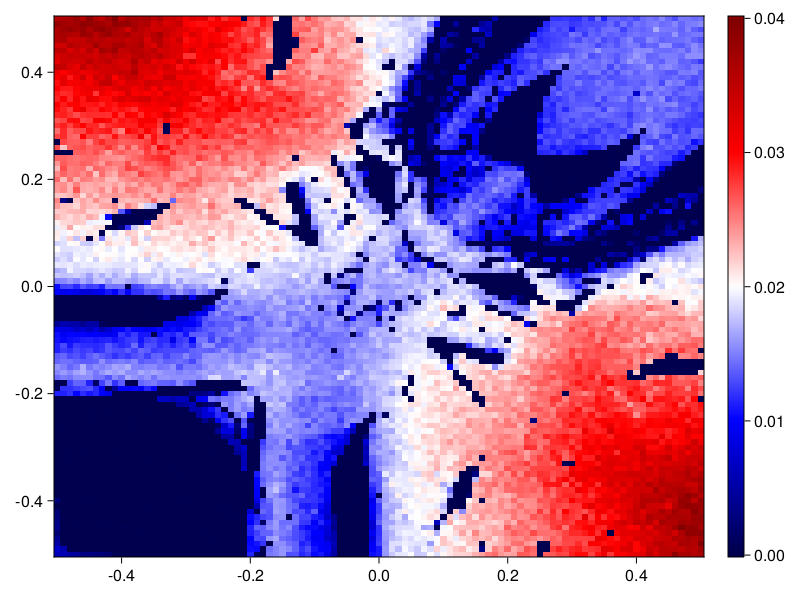

In [9]:
fig, ax, hm = heatmap(k1_array, k2_array, spectrum_matrix[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

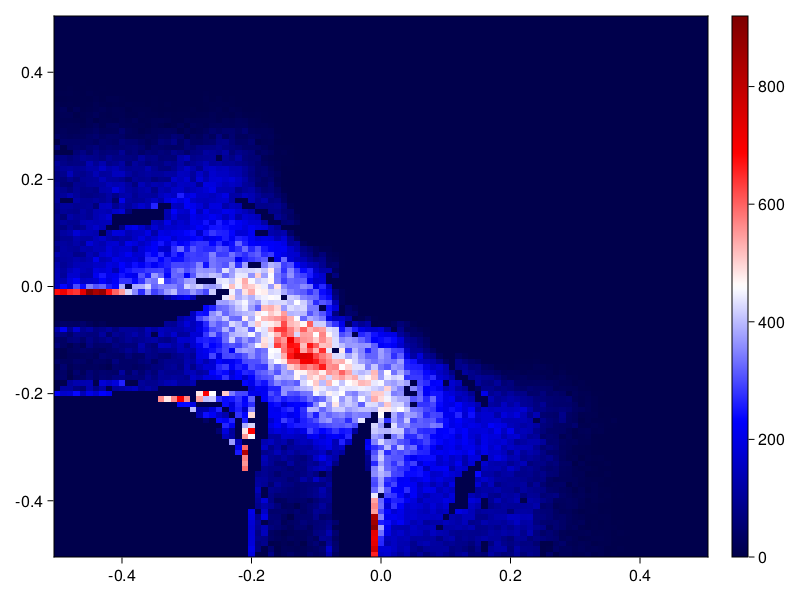

In [10]:
fig, ax, hm = heatmap(k1_array, k2_array, EV_map, colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

In [55]:
using JLD
using NPZ

In [54]:
save("spectrum_matrix_k01.jld", "data", spectrum_matrix)
save("EV_map_k01.jld", "data", EV_map)

In [56]:
npzwrite("spectrum_matrix_k01.npy", spectrum_matrix)
npzwrite("EV_map_k01.npy", EV_map)

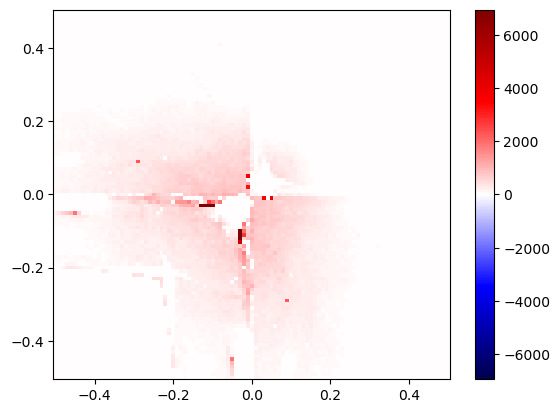

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000497D32B0>

In [30]:
lyapmin,lyapmax =  -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

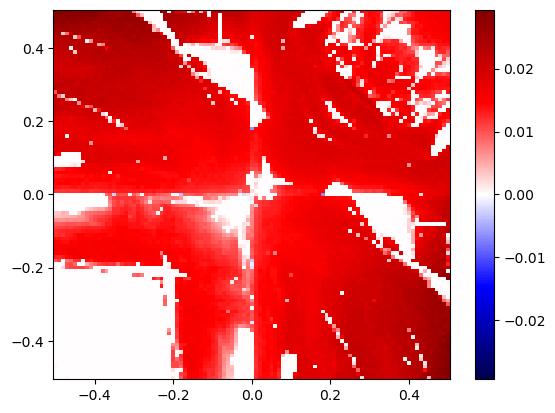

PyObject <matplotlib.colorbar.Colorbar object at 0x000000004988D190>

In [31]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [32]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small_article.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR_article.npy",EV_map)

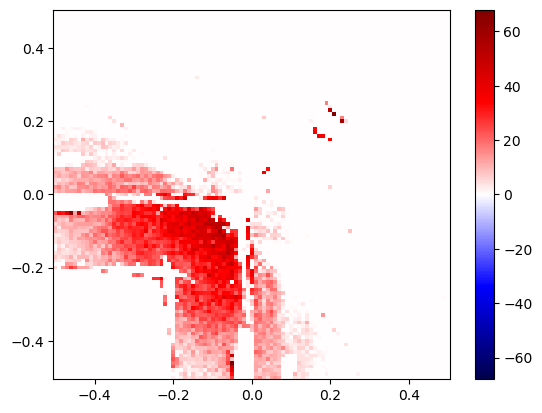

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000009378790>

In [7]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) ) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [10]:
lyap_matrix

101×101 Matrix{Float64}:
  8.19857e-6    6.47474e-5   5.14542e-5   …  0.0276682  0.0272808  0.0291445
  4.06075e-5    3.75252e-5   0.000253653     0.0272182  0.0277339  0.0292966
  3.13037e-5    0.000918656  5.90286e-5      0.0270186  0.0277955  0.029067
  0.000237857   3.48348e-5   2.37488e-5      0.027876   0.027632   0.0287336
  3.654e-5      2.7089e-5    1.00419e-5      0.028559   0.0286812  0.0300362
  9.94368e-6    2.23644e-6   8.28923e-6   …  0.0269209  0.0276201  0.0280668
  2.39406e-5    1.81937e-5   3.74486e-5      0.026856   0.0298292  0.0283967
 -1.85917e-6   -2.39113e-5   1.43275e-5      0.0272673  0.0279262  0.0277269
  1.61646e-5    3.30036e-5   1.4663e-6       0.0264745  0.0275779  0.0280929
 -1.3285e-6     2.29626e-5   6.41577e-6      0.0275636  0.0275413  0.0291799
 -9.06613e-6    9.54144e-6   2.41304e-6   …  0.0270102  0.0268263  0.0291496
  8.70916e-6    1.57952e-5   5.02821e-6      0.025589   0.0269834  0.025414
  3.66871e-5    3.24289e-5   1.65681e-5      0.025743

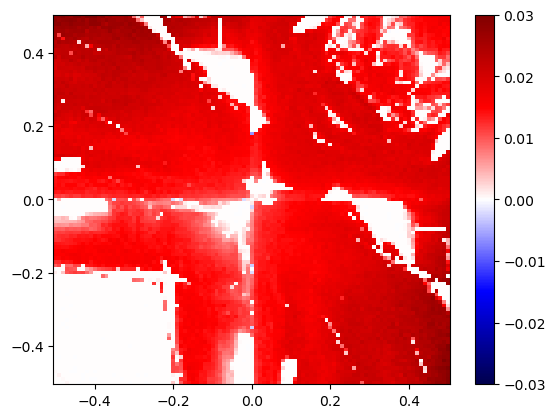

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008D51DC0>

In [11]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

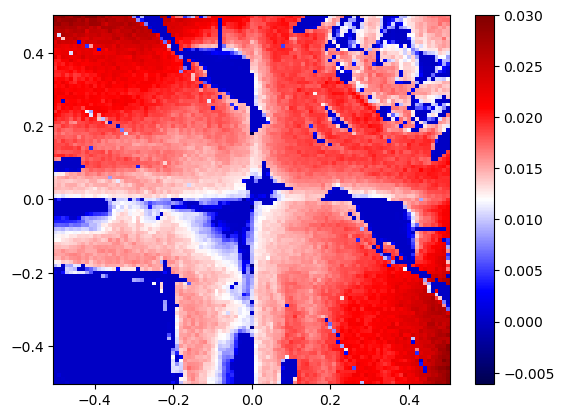

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008E93340>

In [16]:
lyapmin,lyapmax = minimum(lyap_matrix), maximum( lyap_matrix)

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [12]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR.npy",EV_map)